<span style="color:yellow; font-weight:bold;">
 TABNET sector
 </span> 
 this section was being done in parallel with red-wine 2 project   



In [1]:
import pandas as pd
df = pd.read_csv("D:\\Wine quality project\\winequality-red.csv",)


In [2]:

# !pip install pytorch-tabnet

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from pytorch_tabnet.tab_model import TabNetClassifier

#  Load data
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

#  Create 3-class target (low / medium / high) from original quality
#    Here we use:
#      low    = 3–4
#      medium = 5–6
#      high   = 7–8
def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

print("Original quality values:", sorted(df["quality"].unique()))
print(df[["quality", "quality_3cls"]].head())

#  Split X / y
#    DO NOT drop any features except the original target column
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
y_str = df["quality_3cls"].values

# Encode 3 classes as 0,1,2 for TabNet
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(y_str)

print("\nClass mapping:", class_mapping)

#  Train–test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#  Normalize data (fit scaler on TRAIN only to avoid leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TabNet prefers float32
X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab = X_test_scaled.astype(np.float32)

#  Define TabNet model
torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="sparsemax",
    seed=42
)

#  Train TabNet
clf.fit(
    X_train_tab, y_train,
    eval_set=[(X_train_tab, y_train), (X_test_tab, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

#  Evaluation
y_pred = clf.predict(X_test_tab)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in sorted(inv_class_mapping.keys())]

print("\n=== TabNet Results (3-class: low / medium / high) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names]
)
print(cm_df)


Original quality values: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8)]
   quality quality_3cls
0        5       medium
1        5       medium
2        5       medium
3        6       medium
4        5       medium

Class mapping: {'low': 0, 'medium': 1, 'high': 2}


d:\red wine project\.venv-gpu\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.61838 | train_accuracy: 0.77248 | valid_accuracy: 0.7875  |  0:00:00s
epoch 1  | loss: 0.68886 | train_accuracy: 0.73339 | valid_accuracy: 0.79062 |  0:00:01s
epoch 2  | loss: 0.57507 | train_accuracy: 0.80375 | valid_accuracy: 0.81875 |  0:00:02s
epoch 3  | loss: 0.64206 | train_accuracy: 0.7498  | valid_accuracy: 0.73125 |  0:00:02s
epoch 4  | loss: 0.5689  | train_accuracy: 0.79906 | valid_accuracy: 0.77188 |  0:00:03s
epoch 5  | loss: 0.48654 | train_accuracy: 0.78264 | valid_accuracy: 0.76875 |  0:00:03s
epoch 6  | loss: 0.4383  | train_accuracy: 0.80923 | valid_accuracy: 0.77188 |  0:00:04s
epoch 7  | loss: 0.44257 | train_accuracy: 0.83503 | valid_accuracy: 0.82188 |  0:00:04s
epoch 8  | loss: 0.45834 | train_accuracy: 0.82486 | valid_accuracy: 0.80312 |  0:00:05s
epoch 9  | loss: 0.45796 | train_accuracy: 0.84363 | valid_accuracy: 0.84062 |  0:00:05s
epoch 10 | loss: 0.44483 | train_accuracy: 0.82408 | valid_accuracy: 0.80625 |  0:00:06s
epoch 11 | loss: 0.44

d:\red wine project\.venv-gpu\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from pytorch_tabnet.tab_model import TabNetClassifier


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

print("Original quality values:", sorted(df["quality"].unique()))
print(df[["quality", "quality_3cls"]].head())

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
y_str = df["quality_3cls"].values


class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(y_str)

print("\nClass mapping:", class_mapping)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab = X_test_scaled.astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="sparsemax",
    seed=42
)

#  Train TabNet
clf.fit(
    X_train_tab, y_train,
    eval_set=[(X_train_tab, y_train), (X_test_tab, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=200,
    patience=20,
    batch_size=100,
    virtual_batch_size=28,
    num_workers=0,
    drop_last=False
)

# Evaluation
y_pred = clf.predict( _test_tab)                   

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in sorted(inv_class_mapping.keys())]

print("\n=== TabNet Results (3-class: low / medium / high) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names]
)
print(cm_df)


Original quality values: [3, 4, 5, 6, 7, 8]
   quality quality_3cls
0        5       medium
1        5       medium
2        5       medium
3        6       medium
4        5       medium

Class mapping: {'low': 0, 'medium': 1, 'high': 2}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13256 | train_accuracy: 0.78421 | valid_accuracy: 0.78438 |  0:00:00s
epoch 1  | loss: 0.73609 | train_accuracy: 0.77795 | valid_accuracy: 0.75    |  0:00:01s
epoch 2  | loss: 0.63798 | train_accuracy: 0.83346 | valid_accuracy: 0.84375 |  0:00:02s
epoch 3  | loss: 0.56262 | train_accuracy: 0.83659 | valid_accuracy: 0.82812 |  0:00:03s
epoch 4  | loss: 0.51635 | train_accuracy: 0.81939 | valid_accuracy: 0.81875 |  0:00:04s
epoch 5  | loss: 0.52765 | train_accuracy: 0.80532 | valid_accuracy: 0.78438 |  0:00:05s
epoch 6  | loss: 0.48521 | train_accuracy: 0.82565 | valid_accuracy: 0.8125  |  0:00:05s
epoch 7  | loss: 0.47442 | train_accuracy: 0.82643 | valid_accuracy: 0.81875 |  0:00:06s
epoch 8  | loss: 0.47491 | train_accuracy: 0.82721 | valid_accuracy: 0.83125 |  0:00:07s
epoch 9  | loss: 0.49172 | train_accuracy: 0.82877 | valid_accuracy: 0.82188 |  0:00:08s
epoch 10 | loss: 0.46176 | train_accuracy: 0.83815 | valid_accuracy: 0.84062 |  0:00:08s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet Results (3-class: low / medium / high) ===
Accuracy:           0.865625
Balanced accuracy:  0.4844441733976618
Macro F1:           0.5297617415264474

Classification report:
              precision    recall  f1-score   support

         low       1.00      0.08      0.14        13
      medium       0.87      0.98      0.92       264
        high       0.77      0.40      0.52        43

    accuracy                           0.87       320
   macro avg       0.88      0.48      0.53       320
weighted avg       0.86      0.87      0.84       320

Confusion matrix (rows=true, cols=pred):
             pred_low  pred_medium  pred_high
true_low            1           12          0
true_medium         0          259          5
true_high           0           26         17


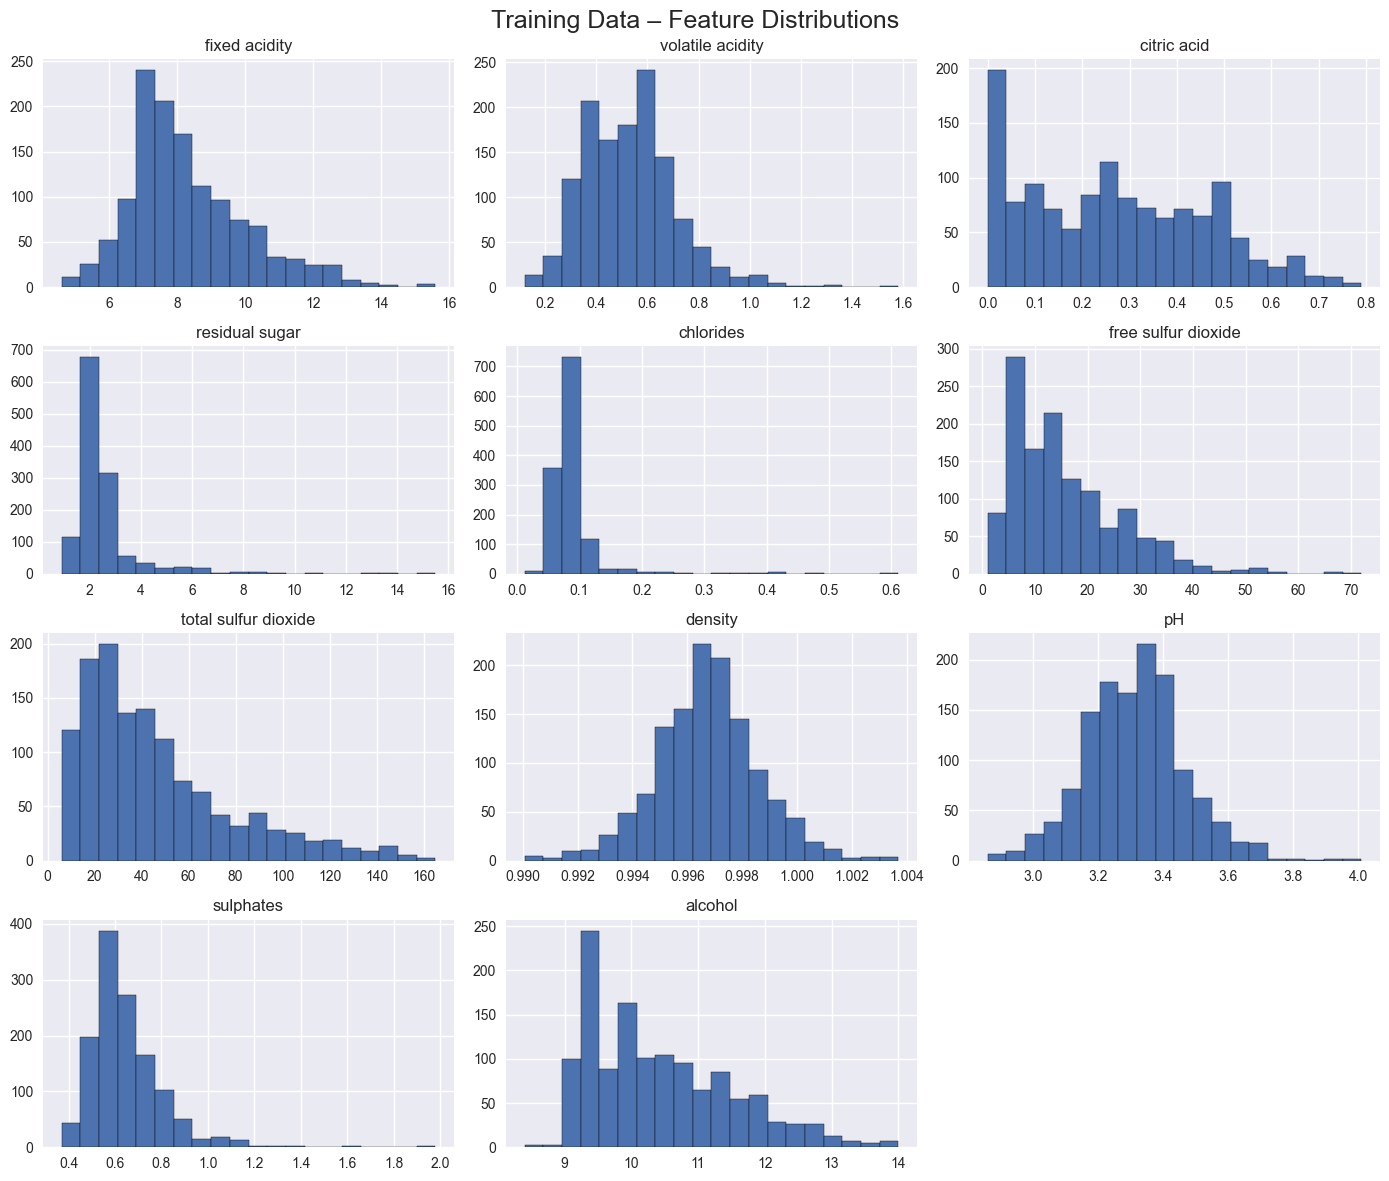

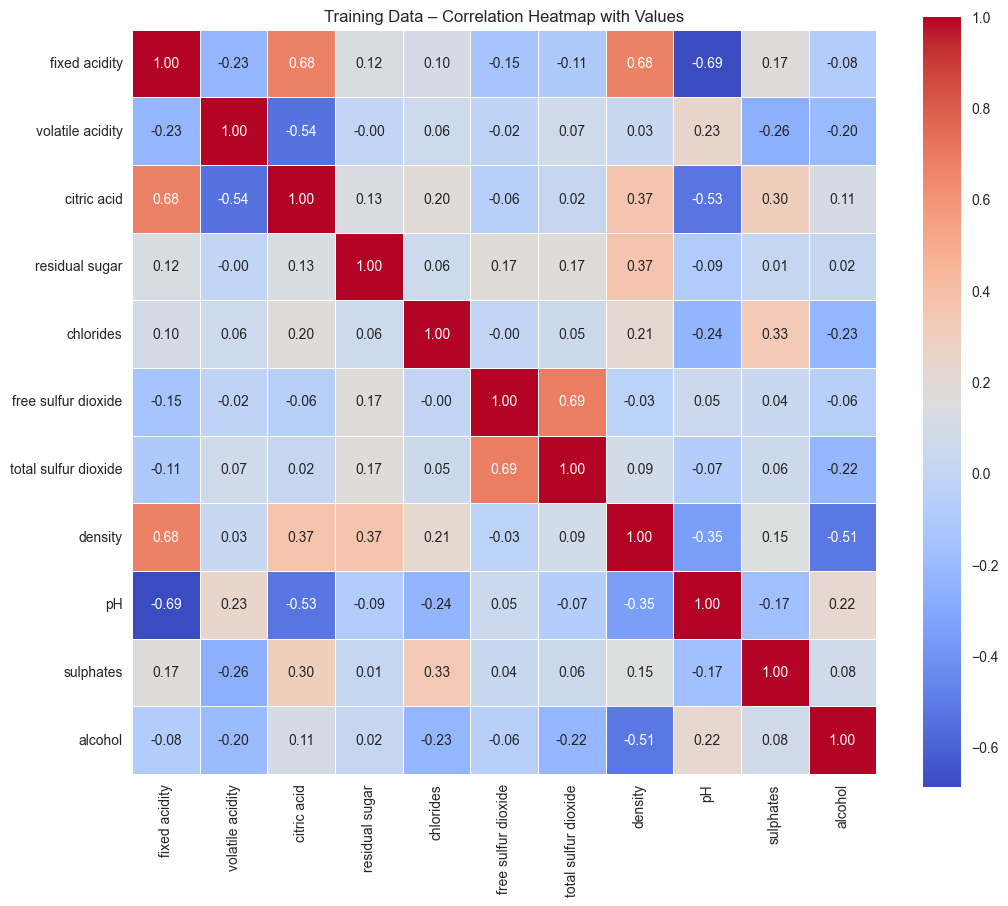

C:\Users\parsa\AppData\Local\Temp\ipykernel_7388\23397605.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_str, palette="Set2")


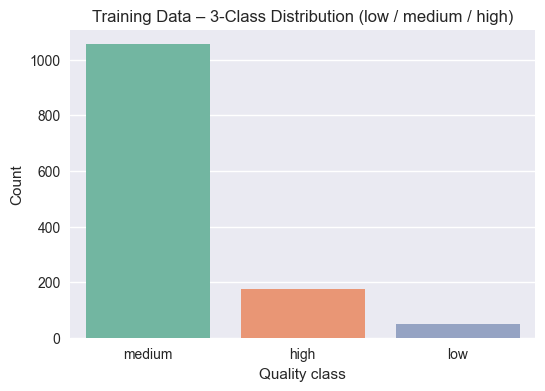

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8")


df_train_vis = pd.DataFrame(X_train, columns=feature_cols)


inv_class_mapping = {0: "low", 1: "medium", 2: "high"}
y_train_str = pd.Series([inv_class_mapping[i] for i in y_train], name="quality_3cls")

df_train_vis["quality_3cls"] = y_train_str


df_train_vis[feature_cols].hist(
    figsize=(14, 12),
    bins=20,
    edgecolor="black"
)
plt.suptitle("Training Data – Feature Distributions", fontsize=18)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 10))
corr_train = df_train_vis[feature_cols].corr()

sns.heatmap(
    corr_train,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    linewidths=0.5
)
plt.title("Training Data – Correlation Heatmap with Values")
plt.show()







plt.figure(figsize=(6, 4))
sns.countplot(x=y_train_str, palette="Set2")
plt.title("Training Data – 3-Class Distribution (low / medium / high)")
plt.xlabel("Quality class")
plt.ylabel("Count")
plt.show()


In [ ]:


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from pytorch_tabnet.tab_model import TabNetClassifier


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")


def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

print("Features:", feature_cols)
print("Class mapping:", class_mapping)
print("Class counts (full):", np.bincount(y))


X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Class counts (train):", np.bincount(y_train))
print("Class counts (test): ", np.bincount(y_test))


X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

lower_q, upper_q = 0.01, 0.99

for col in feature_cols:
    low  = X_train_df[col].quantile(lower_q)
    high = X_train_df[col].quantile(upper_q)
    X_train_df[col] = X_train_df[col].clip(low, high)
    X_test_df[col]  = X_test_df[col].clip(low, high)

X_train = X_train_df.values
X_test  = X_test_df.values


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# TabNet prefers float32
X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab  = X_test_scaled.astype(np.float32)


class_counts = np.bincount(y_train)
n_classes = len(class_counts)
class_weights = class_counts.sum() / (n_classes * class_counts.astype(np.float32))
sample_weights = class_weights[y_train]

print("Class weights (train):", class_weights)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="sparsemax",
    seed=42,
)

clf.fit(
    X_train_tab,
    y_train,
    eval_set=[(X_train_tab, y_train), (X_test_tab, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["balanced_accuracy"],  # better for class imbalance
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    weights=sample_weights,
)


y_pred = clf.predict(X_test_tab)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(len(inv_class_mapping))]

print("\n=== TabNet Results (3-class: low / medium / high) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm_df)


Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Class mapping: {'low': 0, 'medium': 1, 'high': 2}
Class counts (full): [  63 1319  217]
Class counts (train): [  50 1055  174]
Class counts (test):  [ 13 264  43]
Class weights (train): [8.526667   0.40410742 2.4501915 ]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.61382 | train_balanced_accuracy: 0.4835  | valid_balanced_accuracy: 0.45356 |  0:00:00s
epoch 1  | loss: 1.12231 | train_balanced_accuracy: 0.53298 | valid_balanced_accuracy: 0.41705 |  0:00:00s
epoch 2  | loss: 0.90572 | train_balanced_accuracy: 0.58158 | valid_balanced_accuracy: 0.57366 |  0:00:00s
epoch 3  | loss: 0.84641 | train_balanced_accuracy: 0.59668 | valid_balanced_accuracy: 0.65539 |  0:00:01s
epoch 4  | loss: 0.74801 | train_balanced_accuracy: 0.61478 | valid_balanced_accuracy: 0.67469 |  0:00:01s
epoch 5  | loss: 0.74679 | train_balanced_accuracy: 0.64878 | valid_balanced_accuracy: 0.6347  |  0:00:01s
epoch 6  | loss: 0.74777 | train_balanced_accuracy: 0.65066 | valid_balanced_accuracy: 0.62239 |  0:00:01s
epoch 7  | loss: 0.69013 | train_balanced_accuracy: 0.67833 | valid_balanced_accuracy: 0.60071 |  0:00:02s
epoch 8  | loss: 0.68136 | train_balanced_accuracy: 0.68355 | valid_balanced_accuracy: 0.65669 |  0:00:02s
epoch 9  | loss: 0.66611 | train_bala

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
# TabNet focused on raw accuracy (no class weights)

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from pytorch_tabnet.tab_model import TabNetClassifier


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    low  = X_train_df[col].quantile(0.01)
    high = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(low, high)
    X_test_df[col]  = X_test_df[col].clip(low, high)

X_train = X_train_df.values
X_test  = X_test_df.values


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab  = X_test_scaled.astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf_acc = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type="sparsemax",
    seed=42,
)

clf_acc.fit(
    X_train_tab,
    y_train,
    eval_set=[(X_train_tab, y_train), (X_test_tab, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],     
    max_epochs=200,
    patience=20,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)


y_pred = clf_acc.predict(X_test_tab)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(len(inv_class_mapping))]

print("\n=== TabNet (accuracy-optimised) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm_df)


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.59867 | train_accuracy: 0.78264 | valid_accuracy: 0.78125 |  0:00:00s
epoch 1  | loss: 0.69716 | train_accuracy: 0.73729 | valid_accuracy: 0.7375  |  0:00:00s
epoch 2  | loss: 0.56104 | train_accuracy: 0.78577 | valid_accuracy: 0.79062 |  0:00:00s
epoch 3  | loss: 0.54726 | train_accuracy: 0.78342 | valid_accuracy: 0.77812 |  0:00:01s
epoch 4  | loss: 0.50401 | train_accuracy: 0.82174 | valid_accuracy: 0.82812 |  0:00:01s
epoch 5  | loss: 0.52416 | train_accuracy: 0.81548 | valid_accuracy: 0.79375 |  0:00:01s
epoch 6  | loss: 0.46988 | train_accuracy: 0.81235 | valid_accuracy: 0.8125  |  0:00:02s
epoch 7  | loss: 0.45995 | train_accuracy: 0.82799 | valid_accuracy: 0.825   |  0:00:02s
epoch 8  | loss: 0.47579 | train_accuracy: 0.81392 | valid_accuracy: 0.81875 |  0:00:02s
epoch 9  | loss: 0.44518 | train_accuracy: 0.83268 | valid_accuracy: 0.83125 |  0:00:02s
epoch 10 | loss: 0.43944 | train_accuracy: 0.8233  | valid_accuracy: 0.81875 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from pytorch_tabnet.tab_model import TabNetClassifier

df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

print("Features:", feature_cols)
print("Class mapping:", class_mapping)
print("Full class counts:", np.bincount(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))



do_clip = True

X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

if do_clip:
    for col in feature_cols:
        low  = X_train_df[col].quantile(0.01)
        high = X_train_df[col].quantile(0.99)
        X_train_df[col] = X_train_df[col].clip(low, high)
        X_test_df[col]  = X_test_df[col].clip(low, high)

X_train = X_train_df.values
X_test  = X_test_df.values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab  = X_test_scaled.astype(np.float32)


def train_tabnet_config(X_train_tab, y_train, X_test_tab, y_test,
                        n_d, n_a, n_steps, lr, gamma, lambda_sparse, seed=42):

    torch.manual_seed(seed)
    np.random.seed(seed)

    clf = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        n_independent=2,
        n_shared=2,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="sparsemax",
        seed=seed,
    )

    clf.fit(
        X_train_tab, y_train,
        eval_set=[(X_train_tab, y_train), (X_test_tab, y_test)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],    # optimise accuracy
        max_epochs=200,
        patience=20,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    y_pred = clf.predict(X_test_tab)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    return acc, bal_acc, macro_f1, clf


# Search over configs × seeds

configs = [
    {"name": "small_3steps",   "n_d": 16, "n_a": 16, "n_steps": 3, "lr": 1e-2, "gamma": 1.3, "lambda_sparse": 1e-4},
    {"name": "base_5steps",    "n_d": 32, "n_a": 32, "n_steps": 5, "lr": 1e-2, "gamma": 1.5, "lambda_sparse": 1e-4},
    {"name": "deep_7steps",    "n_d": 32, "n_a": 32, "n_steps": 7, "lr": 1e-2, "gamma": 1.5, "lambda_sparse": 1e-4},
    {"name": "base_lowLR",     "n_d": 32, "n_a": 32, "n_steps": 5, "lr": 5e-3, "gamma": 1.5, "lambda_sparse": 1e-4},
    {"name": "wide_5steps",    "n_d": 64, "n_a": 64, "n_steps": 5, "lr": 1e-2, "gamma": 1.5, "lambda_sparse": 1e-4},
    {"name": "base_sparser",   "n_d": 32, "n_a": 32, "n_steps": 5, "lr": 1e-2, "gamma": 1.5, "lambda_sparse": 1e-3},
]

seeds = [0, 1, 2]

results = []   # to store all runs

for cfg in configs:
    for seed in seeds:
        print(f"\n=== Training config {cfg['name']} with seed {seed} ===")
        acc, bal_acc, macro_f1, clf = train_tabnet_config(
            X_train_tab, y_train, X_test_tab, y_test,
            n_d=cfg["n_d"],
            n_a=cfg["n_a"],
            n_steps=cfg["n_steps"],
            lr=cfg["lr"],
            gamma=cfg["gamma"],
            lambda_sparse=cfg["lambda_sparse"],
            seed=seed,
        )
        print(f" -> acc={acc:.4f}, bal_acc={bal_acc:.4f}, macro_f1={macro_f1:.4f}")

        results.append({
            "name": cfg["name"],
            "seed": seed,
            "acc": acc,
            "bal_acc": bal_acc,
            "macro_f1": macro_f1,
            "model": clf,
        })



# 7. Pick best single model

results_sorted = sorted(results, key=lambda r: r["acc"], reverse=True)
best = results_sorted[0]

print("\n==============================")
print(" BEST SINGLE TABNET MODEL")
print("==============================")
print(f"Config: {best['name']}, seed={best['seed']}")
print(f"Accuracy:          {best['acc']:.4f}")
print(f"Balanced accuracy: {best['bal_acc']:.4f}")
print(f"Macro F1:          {best['macro_f1']:.4f}")

best_model = best["model"]

# Detailed report for best model
y_pred_best = best_model.predict(X_test_tab)
inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(len(inv_class_mapping))]

print("\nClassification report (best single model):")
print(classification_report(y_test, y_pred_best, target_names=target_names))

cm_best = confusion_matrix(y_test, y_pred_best)
cm_best_df = pd.DataFrame(
    cm_best,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion matrix (best single model):")
print(cm_best_df)



#  Ensemble of top 3 models

top_k = 3
top_models = [r["model"] for r in results_sorted[:top_k]]

# average predicted probabilities from each model
probs_list = [m.predict_proba(X_test_tab) for m in top_models]
probs_ens = np.mean(probs_list, axis=0)
y_pred_ens = probs_ens.argmax(axis=1)

acc_ens = accuracy_score(y_test, y_pred_ens)
bal_acc_ens = balanced_accuracy_score(y_test, y_pred_ens)
macro_f1_ens = f1_score(y_test, y_pred_ens, average="macro")

print("\n==============================")
print(f" ENSEMBLE OF TOP {top_k} MODELS")
print("==============================")
print(f"Accuracy:          {acc_ens:.4f}")
print(f"Balanced accuracy: {bal_acc_ens:.4f}")
print(f"Macro F1:          {macro_f1_ens:.4f}")

print("\nClassification report (ensemble):")
print(classification_report(y_test, y_pred_ens, target_names=target_names))

cm_ens = confusion_matrix(y_test, y_pred_ens)
cm_ens_df = pd.DataFrame(
    cm_ens,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion matrix (ensemble):")
print(cm_ens_df)


Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Class mapping: {'low': 0, 'medium': 1, 'high': 2}
Full class counts: [  63 1319  217]
Train class counts: [  50 1055  174]
Test  class counts: [ 13 264  43]

=== Training config small_3steps with seed 0 ===


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95726 | train_accuracy: 0.76153 | valid_accuracy: 0.75312 |  0:00:00s
epoch 1  | loss: 0.60184 | train_accuracy: 0.81157 | valid_accuracy: 0.79375 |  0:00:00s
epoch 2  | loss: 0.54138 | train_accuracy: 0.81548 | valid_accuracy: 0.79375 |  0:00:00s
epoch 3  | loss: 0.49104 | train_accuracy: 0.81079 | valid_accuracy: 0.8     |  0:00:00s
epoch 4  | loss: 0.46193 | train_accuracy: 0.82486 | valid_accuracy: 0.80312 |  0:00:00s
epoch 5  | loss: 0.44204 | train_accuracy: 0.82877 | valid_accuracy: 0.8125  |  0:00:01s
epoch 6  | loss: 0.43217 | train_accuracy: 0.83268 | valid_accuracy: 0.8375  |  0:00:01s
epoch 7  | loss: 0.41065 | train_accuracy: 0.83815 | valid_accuracy: 0.80625 |  0:00:01s
epoch 8  | loss: 0.4035  | train_accuracy: 0.84441 | valid_accuracy: 0.85    |  0:00:01s
epoch 9  | loss: 0.41365 | train_accuracy: 0.84754 | valid_accuracy: 0.84688 |  0:00:01s
epoch 10 | loss: 0.4026  | train_accuracy: 0.8491  | valid_accuracy: 0.84062 |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


 -> acc=0.8750, bal_acc=0.5905, macro_f1=0.6167

=== Training config small_3steps with seed 1 ===
epoch 0  | loss: 0.85093 | train_accuracy: 0.76388 | valid_accuracy: 0.74688 |  0:00:00s
epoch 1  | loss: 0.5545  | train_accuracy: 0.80923 | valid_accuracy: 0.80938 |  0:00:00s
epoch 2  | loss: 0.53587 | train_accuracy: 0.82174 | valid_accuracy: 0.81875 |  0:00:00s
epoch 3  | loss: 0.50043 | train_accuracy: 0.82955 | valid_accuracy: 0.84375 |  0:00:00s
epoch 4  | loss: 0.46219 | train_accuracy: 0.83737 | valid_accuracy: 0.82188 |  0:00:00s
epoch 5  | loss: 0.43512 | train_accuracy: 0.84206 | valid_accuracy: 0.84062 |  0:00:01s
epoch 6  | loss: 0.43096 | train_accuracy: 0.84832 | valid_accuracy: 0.8375  |  0:00:01s
epoch 7  | loss: 0.42617 | train_accuracy: 0.85145 | valid_accuracy: 0.82812 |  0:00:01s
epoch 8  | loss: 0.41106 | train_accuracy: 0.8491  | valid_accuracy: 0.83438 |  0:00:01s
epoch 9  | loss: 0.4055  | train_accuracy: 0.85692 | valid_accuracy: 0.84062 |  0:00:01s
epoch 10 | l

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8343  | train_accuracy: 0.80219 | valid_accuracy: 0.79062 |  0:00:00s
epoch 1  | loss: 0.58914 | train_accuracy: 0.82721 | valid_accuracy: 0.80938 |  0:00:00s
epoch 2  | loss: 0.52298 | train_accuracy: 0.81626 | valid_accuracy: 0.81875 |  0:00:00s
epoch 3  | loss: 0.48017 | train_accuracy: 0.82877 | valid_accuracy: 0.82188 |  0:00:00s
epoch 4  | loss: 0.45966 | train_accuracy: 0.83112 | valid_accuracy: 0.8125  |  0:00:00s
epoch 5  | loss: 0.44945 | train_accuracy: 0.81157 | valid_accuracy: 0.82812 |  0:00:01s
epoch 6  | loss: 0.42865 | train_accuracy: 0.82017 | valid_accuracy: 0.825   |  0:00:01s
epoch 7  | loss: 0.43458 | train_accuracy: 0.83268 | valid_accuracy: 0.80938 |  0:00:01s
epoch 8  | loss: 0.43265 | train_accuracy: 0.83034 | valid_accuracy: 0.80312 |  0:00:01s
epoch 9  | loss: 0.42397 | train_accuracy: 0.83425 | valid_accuracy: 0.8375  |  0:00:01s
epoch 10 | loss: 0.40719 | train_accuracy: 0.84206 | valid_accuracy: 0.85    |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


 -> acc=0.8625, bal_acc=0.4653, macro_f1=0.4862

=== Training config base_5steps with seed 0 ===
epoch 0  | loss: 1.1939  | train_accuracy: 0.78342 | valid_accuracy: 0.78125 |  0:00:00s
epoch 1  | loss: 0.68135 | train_accuracy: 0.70602 | valid_accuracy: 0.725   |  0:00:00s
epoch 2  | loss: 0.58231 | train_accuracy: 0.79828 | valid_accuracy: 0.8     |  0:00:00s
epoch 3  | loss: 0.52321 | train_accuracy: 0.7717  | valid_accuracy: 0.75    |  0:00:01s
epoch 4  | loss: 0.49618 | train_accuracy: 0.80453 | valid_accuracy: 0.80938 |  0:00:01s
epoch 5  | loss: 0.45103 | train_accuracy: 0.82252 | valid_accuracy: 0.78438 |  0:00:01s
epoch 6  | loss: 0.46467 | train_accuracy: 0.81157 | valid_accuracy: 0.79375 |  0:00:02s
epoch 7  | loss: 0.44378 | train_accuracy: 0.82721 | valid_accuracy: 0.80312 |  0:00:02s
epoch 8  | loss: 0.44598 | train_accuracy: 0.82643 | valid_accuracy: 0.8     |  0:00:02s
epoch 9  | loss: 0.41551 | train_accuracy: 0.83112 | valid_accuracy: 0.81875 |  0:00:02s
epoch 10 | lo

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.33431 | train_accuracy: 0.60907 | valid_accuracy: 0.59688 |  0:00:00s
epoch 1  | loss: 0.7874  | train_accuracy: 0.77561 | valid_accuracy: 0.77188 |  0:00:00s
epoch 2  | loss: 0.68001 | train_accuracy: 0.74746 | valid_accuracy: 0.75312 |  0:00:00s
epoch 3  | loss: 0.56272 | train_accuracy: 0.77639 | valid_accuracy: 0.8     |  0:00:01s
epoch 4  | loss: 0.54441 | train_accuracy: 0.75606 | valid_accuracy: 0.76562 |  0:00:01s
epoch 5  | loss: 0.50613 | train_accuracy: 0.79203 | valid_accuracy: 0.76875 |  0:00:01s
epoch 6  | loss: 0.51574 | train_accuracy: 0.79984 | valid_accuracy: 0.775   |  0:00:01s
epoch 7  | loss: 0.50996 | train_accuracy: 0.83034 | valid_accuracy: 0.8375  |  0:00:02s
epoch 8  | loss: 0.49815 | train_accuracy: 0.82721 | valid_accuracy: 0.8375  |  0:00:02s
epoch 9  | loss: 0.46101 | train_accuracy: 0.81704 | valid_accuracy: 0.80625 |  0:00:02s
epoch 10 | loss: 0.45887 | train_accuracy: 0.82643 | valid_accuracy: 0.81875 |  0:00:02s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91352 | train_accuracy: 0.76622 | valid_accuracy: 0.79375 |  0:00:00s
epoch 1  | loss: 0.65969 | train_accuracy: 0.77248 | valid_accuracy: 0.78125 |  0:00:00s
epoch 2  | loss: 0.53667 | train_accuracy: 0.79672 | valid_accuracy: 0.78125 |  0:00:00s
epoch 3  | loss: 0.50642 | train_accuracy: 0.81626 | valid_accuracy: 0.80938 |  0:00:01s
epoch 4  | loss: 0.4777  | train_accuracy: 0.82721 | valid_accuracy: 0.83438 |  0:00:01s
epoch 5  | loss: 0.44484 | train_accuracy: 0.82643 | valid_accuracy: 0.825   |  0:00:01s
epoch 6  | loss: 0.50325 | train_accuracy: 0.82721 | valid_accuracy: 0.86562 |  0:00:01s
epoch 7  | loss: 0.49256 | train_accuracy: 0.83815 | valid_accuracy: 0.8375  |  0:00:02s
epoch 8  | loss: 0.46632 | train_accuracy: 0.83425 | valid_accuracy: 0.85    |  0:00:02s
epoch 9  | loss: 0.46888 | train_accuracy: 0.83346 | valid_accuracy: 0.85625 |  0:00:02s
epoch 10 | loss: 0.45536 | train_accuracy: 0.83425 | valid_accuracy: 0.81562 |  0:00:02s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.7778  | train_accuracy: 0.74199 | valid_accuracy: 0.74688 |  0:00:00s
epoch 1  | loss: 0.83937 | train_accuracy: 0.71071 | valid_accuracy: 0.70312 |  0:00:00s
epoch 2  | loss: 0.71749 | train_accuracy: 0.78812 | valid_accuracy: 0.77188 |  0:00:01s
epoch 3  | loss: 0.65653 | train_accuracy: 0.76935 | valid_accuracy: 0.78125 |  0:00:01s
epoch 4  | loss: 0.61832 | train_accuracy: 0.80532 | valid_accuracy: 0.77812 |  0:00:01s
epoch 5  | loss: 0.56524 | train_accuracy: 0.78499 | valid_accuracy: 0.78125 |  0:00:02s
epoch 6  | loss: 0.53741 | train_accuracy: 0.81079 | valid_accuracy: 0.75938 |  0:00:02s
epoch 7  | loss: 0.51551 | train_accuracy: 0.81392 | valid_accuracy: 0.78125 |  0:00:02s
epoch 8  | loss: 0.51567 | train_accuracy: 0.82565 | valid_accuracy: 0.79062 |  0:00:03s
epoch 9  | loss: 0.487   | train_accuracy: 0.82565 | valid_accuracy: 0.80312 |  0:00:03s
epoch 10 | loss: 0.48479 | train_accuracy: 0.79828 | valid_accuracy: 0.80312 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.55673 | train_accuracy: 0.58874 | valid_accuracy: 0.58438 |  0:00:00s
epoch 1  | loss: 0.83174 | train_accuracy: 0.80063 | valid_accuracy: 0.80938 |  0:00:00s
epoch 2  | loss: 0.66353 | train_accuracy: 0.77795 | valid_accuracy: 0.775   |  0:00:01s
epoch 3  | loss: 0.55877 | train_accuracy: 0.81157 | valid_accuracy: 0.78438 |  0:00:01s
epoch 4  | loss: 0.56879 | train_accuracy: 0.78655 | valid_accuracy: 0.74062 |  0:00:01s
epoch 5  | loss: 0.53701 | train_accuracy: 0.80923 | valid_accuracy: 0.78125 |  0:00:02s
epoch 6  | loss: 0.51254 | train_accuracy: 0.80063 | valid_accuracy: 0.80938 |  0:00:02s
epoch 7  | loss: 0.51496 | train_accuracy: 0.82486 | valid_accuracy: 0.8375  |  0:00:02s
epoch 8  | loss: 0.48257 | train_accuracy: 0.82955 | valid_accuracy: 0.81875 |  0:00:03s
epoch 9  | loss: 0.47814 | train_accuracy: 0.82486 | valid_accuracy: 0.81562 |  0:00:03s
epoch 10 | loss: 0.46111 | train_accuracy: 0.80219 | valid_accuracy: 0.79375 |  0:00:03s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.982   | train_accuracy: 0.67553 | valid_accuracy: 0.68438 |  0:00:00s
epoch 1  | loss: 0.7077  | train_accuracy: 0.75371 | valid_accuracy: 0.74688 |  0:00:00s
epoch 2  | loss: 0.62492 | train_accuracy: 0.79984 | valid_accuracy: 0.79062 |  0:00:01s
epoch 3  | loss: 0.53719 | train_accuracy: 0.77717 | valid_accuracy: 0.77812 |  0:00:01s
epoch 4  | loss: 0.48044 | train_accuracy: 0.80453 | valid_accuracy: 0.79062 |  0:00:01s
epoch 5  | loss: 0.50909 | train_accuracy: 0.81626 | valid_accuracy: 0.7875  |  0:00:02s
epoch 6  | loss: 0.50204 | train_accuracy: 0.82486 | valid_accuracy: 0.80312 |  0:00:02s
epoch 7  | loss: 0.45389 | train_accuracy: 0.81079 | valid_accuracy: 0.76562 |  0:00:02s
epoch 8  | loss: 0.49433 | train_accuracy: 0.8405  | valid_accuracy: 0.80312 |  0:00:03s
epoch 9  | loss: 0.47939 | train_accuracy: 0.79046 | valid_accuracy: 0.75312 |  0:00:03s
epoch 10 | loss: 0.52619 | train_accuracy: 0.82408 | valid_accuracy: 0.83125 |  0:00:03s
epoch 11 | loss: 0.51

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44466 | train_accuracy: 0.64034 | valid_accuracy: 0.63438 |  0:00:00s
epoch 1  | loss: 0.76729 | train_accuracy: 0.7631  | valid_accuracy: 0.775   |  0:00:00s
epoch 2  | loss: 0.63308 | train_accuracy: 0.79515 | valid_accuracy: 0.79688 |  0:00:00s
epoch 3  | loss: 0.53834 | train_accuracy: 0.81783 | valid_accuracy: 0.825   |  0:00:01s
epoch 4  | loss: 0.53545 | train_accuracy: 0.81548 | valid_accuracy: 0.82188 |  0:00:01s
epoch 5  | loss: 0.51138 | train_accuracy: 0.81861 | valid_accuracy: 0.84688 |  0:00:01s
epoch 6  | loss: 0.48884 | train_accuracy: 0.83346 | valid_accuracy: 0.84375 |  0:00:01s
epoch 7  | loss: 0.48887 | train_accuracy: 0.8319  | valid_accuracy: 0.8375  |  0:00:02s
epoch 8  | loss: 0.5066  | train_accuracy: 0.81548 | valid_accuracy: 0.83438 |  0:00:02s
epoch 9  | loss: 0.46372 | train_accuracy: 0.82252 | valid_accuracy: 0.825   |  0:00:02s
epoch 10 | loss: 0.48339 | train_accuracy: 0.82174 | valid_accuracy: 0.83438 |  0:00:02s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.03807 | train_accuracy: 0.32838 | valid_accuracy: 0.30625 |  0:00:00s
epoch 1  | loss: 1.09253 | train_accuracy: 0.70211 | valid_accuracy: 0.70938 |  0:00:00s
epoch 2  | loss: 0.74891 | train_accuracy: 0.81235 | valid_accuracy: 0.77812 |  0:00:00s
epoch 3  | loss: 0.67571 | train_accuracy: 0.82486 | valid_accuracy: 0.79375 |  0:00:01s
epoch 4  | loss: 0.63714 | train_accuracy: 0.81704 | valid_accuracy: 0.81875 |  0:00:01s
epoch 5  | loss: 0.58736 | train_accuracy: 0.81548 | valid_accuracy: 0.81875 |  0:00:01s
epoch 6  | loss: 0.51734 | train_accuracy: 0.81939 | valid_accuracy: 0.84688 |  0:00:01s
epoch 7  | loss: 0.49668 | train_accuracy: 0.82095 | valid_accuracy: 0.81875 |  0:00:02s
epoch 8  | loss: 0.51901 | train_accuracy: 0.83112 | valid_accuracy: 0.80938 |  0:00:02s
epoch 9  | loss: 0.48394 | train_accuracy: 0.83815 | valid_accuracy: 0.79375 |  0:00:02s
epoch 10 | loss: 0.46949 | train_accuracy: 0.83034 | valid_accuracy: 0.84688 |  0:00:02s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02429 | train_accuracy: 0.78655 | valid_accuracy: 0.78438 |  0:00:00s
epoch 1  | loss: 0.65849 | train_accuracy: 0.78655 | valid_accuracy: 0.72812 |  0:00:00s
epoch 2  | loss: 0.57356 | train_accuracy: 0.78812 | valid_accuracy: 0.775   |  0:00:00s
epoch 3  | loss: 0.52384 | train_accuracy: 0.80844 | valid_accuracy: 0.78438 |  0:00:01s
epoch 4  | loss: 0.52444 | train_accuracy: 0.79906 | valid_accuracy: 0.78125 |  0:00:01s
epoch 5  | loss: 0.53472 | train_accuracy: 0.82408 | valid_accuracy: 0.81875 |  0:00:01s
epoch 6  | loss: 0.48963 | train_accuracy: 0.82565 | valid_accuracy: 0.80312 |  0:00:01s
epoch 7  | loss: 0.47759 | train_accuracy: 0.84128 | valid_accuracy: 0.79688 |  0:00:02s
epoch 8  | loss: 0.44893 | train_accuracy: 0.8491  | valid_accuracy: 0.8     |  0:00:02s
epoch 9  | loss: 0.43188 | train_accuracy: 0.84676 | valid_accuracy: 0.81875 |  0:00:02s
epoch 10 | loss: 0.4463  | train_accuracy: 0.84988 | valid_accuracy: 0.83438 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.68397 | train_accuracy: 0.74277 | valid_accuracy: 0.725   |  0:00:00s
epoch 1  | loss: 0.70441 | train_accuracy: 0.75371 | valid_accuracy: 0.72812 |  0:00:00s
epoch 2  | loss: 0.66611 | train_accuracy: 0.76153 | valid_accuracy: 0.75312 |  0:00:01s
epoch 3  | loss: 0.56194 | train_accuracy: 0.79437 | valid_accuracy: 0.77188 |  0:00:01s
epoch 4  | loss: 0.56617 | train_accuracy: 0.81626 | valid_accuracy: 0.81875 |  0:00:01s
epoch 5  | loss: 0.48942 | train_accuracy: 0.80844 | valid_accuracy: 0.79688 |  0:00:02s
epoch 6  | loss: 0.51447 | train_accuracy: 0.79203 | valid_accuracy: 0.76875 |  0:00:02s
epoch 7  | loss: 0.50515 | train_accuracy: 0.82408 | valid_accuracy: 0.82812 |  0:00:03s
epoch 8  | loss: 0.50481 | train_accuracy: 0.83503 | valid_accuracy: 0.79688 |  0:00:03s
epoch 9  | loss: 0.50207 | train_accuracy: 0.83112 | valid_accuracy: 0.83125 |  0:00:03s
epoch 10 | loss: 0.47965 | train_accuracy: 0.83034 | valid_accuracy: 0.83125 |  0:00:04s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02678 | train_accuracy: 0.67631 | valid_accuracy: 0.64688 |  0:00:00s
epoch 1  | loss: 0.79266 | train_accuracy: 0.74511 | valid_accuracy: 0.74375 |  0:00:00s
epoch 2  | loss: 0.58898 | train_accuracy: 0.76231 | valid_accuracy: 0.76562 |  0:00:01s
epoch 3  | loss: 0.54255 | train_accuracy: 0.75371 | valid_accuracy: 0.70312 |  0:00:01s
epoch 4  | loss: 0.53047 | train_accuracy: 0.70758 | valid_accuracy: 0.675   |  0:00:01s
epoch 5  | loss: 0.4889  | train_accuracy: 0.75606 | valid_accuracy: 0.69688 |  0:00:02s
epoch 6  | loss: 0.51432 | train_accuracy: 0.78186 | valid_accuracy: 0.74062 |  0:00:02s
epoch 7  | loss: 0.51252 | train_accuracy: 0.83268 | valid_accuracy: 0.81875 |  0:00:02s
epoch 8  | loss: 0.48427 | train_accuracy: 0.81861 | valid_accuracy: 0.76562 |  0:00:03s
epoch 9  | loss: 0.44759 | train_accuracy: 0.83581 | valid_accuracy: 0.83438 |  0:00:03s
epoch 10 | loss: 0.46222 | train_accuracy: 0.83737 | valid_accuracy: 0.81562 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93849 | train_accuracy: 0.74902 | valid_accuracy: 0.7375  |  0:00:00s
epoch 1  | loss: 0.70795 | train_accuracy: 0.72635 | valid_accuracy: 0.72812 |  0:00:00s
epoch 2  | loss: 0.66527 | train_accuracy: 0.69977 | valid_accuracy: 0.64688 |  0:00:00s
epoch 3  | loss: 0.57082 | train_accuracy: 0.73651 | valid_accuracy: 0.7375  |  0:00:01s
epoch 4  | loss: 0.56918 | train_accuracy: 0.79203 | valid_accuracy: 0.74688 |  0:00:01s
epoch 5  | loss: 0.54157 | train_accuracy: 0.78342 | valid_accuracy: 0.73438 |  0:00:01s
epoch 6  | loss: 0.547   | train_accuracy: 0.82486 | valid_accuracy: 0.81562 |  0:00:02s
epoch 7  | loss: 0.53468 | train_accuracy: 0.81783 | valid_accuracy: 0.79062 |  0:00:02s
epoch 8  | loss: 0.50237 | train_accuracy: 0.82799 | valid_accuracy: 0.79688 |  0:00:03s
epoch 9  | loss: 0.4829  | train_accuracy: 0.83425 | valid_accuracy: 0.85312 |  0:00:03s
epoch 10 | loss: 0.45687 | train_accuracy: 0.82565 | valid_accuracy: 0.79062 |  0:00:03s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23801 | train_accuracy: 0.76466 | valid_accuracy: 0.76875 |  0:00:00s
epoch 1  | loss: 0.68616 | train_accuracy: 0.78812 | valid_accuracy: 0.80312 |  0:00:00s
epoch 2  | loss: 0.59513 | train_accuracy: 0.77561 | valid_accuracy: 0.79688 |  0:00:00s
epoch 3  | loss: 0.6169  | train_accuracy: 0.77561 | valid_accuracy: 0.77812 |  0:00:01s
epoch 4  | loss: 0.53576 | train_accuracy: 0.7803  | valid_accuracy: 0.77812 |  0:00:01s
epoch 5  | loss: 0.50422 | train_accuracy: 0.79593 | valid_accuracy: 0.77188 |  0:00:01s
epoch 6  | loss: 0.52037 | train_accuracy: 0.79672 | valid_accuracy: 0.775   |  0:00:02s
epoch 7  | loss: 0.49568 | train_accuracy: 0.82955 | valid_accuracy: 0.83438 |  0:00:02s
epoch 8  | loss: 0.50332 | train_accuracy: 0.81392 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.45675 | train_accuracy: 0.83503 | valid_accuracy: 0.80938 |  0:00:03s
epoch 10 | loss: 0.46778 | train_accuracy: 0.81783 | valid_accuracy: 0.7875  |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.31625 | train_accuracy: 0.58327 | valid_accuracy: 0.59375 |  0:00:00s
epoch 1  | loss: 0.74351 | train_accuracy: 0.7631  | valid_accuracy: 0.78125 |  0:00:00s
epoch 2  | loss: 0.65923 | train_accuracy: 0.7459  | valid_accuracy: 0.74688 |  0:00:00s
epoch 3  | loss: 0.61737 | train_accuracy: 0.78264 | valid_accuracy: 0.78438 |  0:00:01s
epoch 4  | loss: 0.52851 | train_accuracy: 0.78108 | valid_accuracy: 0.76562 |  0:00:01s
epoch 5  | loss: 0.49881 | train_accuracy: 0.81548 | valid_accuracy: 0.79688 |  0:00:01s
epoch 6  | loss: 0.49979 | train_accuracy: 0.81157 | valid_accuracy: 0.80938 |  0:00:01s
epoch 7  | loss: 0.47062 | train_accuracy: 0.82955 | valid_accuracy: 0.79062 |  0:00:02s
epoch 8  | loss: 0.47974 | train_accuracy: 0.81157 | valid_accuracy: 0.8     |  0:00:02s
epoch 9  | loss: 0.49379 | train_accuracy: 0.83268 | valid_accuracy: 0.78438 |  0:00:02s
epoch 10 | loss: 0.44877 | train_accuracy: 0.83503 | valid_accuracy: 0.7875  |  0:00:02s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91423 | train_accuracy: 0.76388 | valid_accuracy: 0.72188 |  0:00:00s
epoch 1  | loss: 0.62721 | train_accuracy: 0.75137 | valid_accuracy: 0.73125 |  0:00:00s
epoch 2  | loss: 0.54468 | train_accuracy: 0.75528 | valid_accuracy: 0.75    |  0:00:00s
epoch 3  | loss: 0.47566 | train_accuracy: 0.79203 | valid_accuracy: 0.7625  |  0:00:01s
epoch 4  | loss: 0.49001 | train_accuracy: 0.78108 | valid_accuracy: 0.78125 |  0:00:01s
epoch 5  | loss: 0.49058 | train_accuracy: 0.80297 | valid_accuracy: 0.8     |  0:00:01s
epoch 6  | loss: 0.4643  | train_accuracy: 0.81079 | valid_accuracy: 0.82188 |  0:00:02s
epoch 7  | loss: 0.48266 | train_accuracy: 0.8061  | valid_accuracy: 0.80938 |  0:00:02s
epoch 8  | loss: 0.45997 | train_accuracy: 0.81157 | valid_accuracy: 0.78438 |  0:00:02s
epoch 9  | loss: 0.45711 | train_accuracy: 0.82643 | valid_accuracy: 0.80625 |  0:00:02s
epoch 10 | loss: 0.45322 | train_accuracy: 0.8147  | valid_accuracy: 0.83125 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [2]:
!pip install pytorch-tabnet --upgrade



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip uninstall -y torch torchvision torchaudio


Found existing installation: torch 2.8.0+cpu
Uninstalling torch-2.8.0+cpu:
  Successfully uninstalled torch-2.8.0+cpu
Found existing installation: torchvision 0.23.0+cpu
Uninstalling torchvision-0.23.0+cpu:
  Successfully uninstalled torchvision-0.23.0+cpu
Found existing installation: torchaudio 2.8.0+cpu
Uninstalling torchaudio-2.8.0+cpu:
  Successfully uninstalled torchaudio-2.8.0+cpu


You can safely remove it manually.


In [1]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("device name:", torch.cuda.get_device_name(0))


torch: 2.5.1+cu121
cuda available: True
device name: NVIDIA GeForce GTX 1650 Ti


In [ ]:
# ======================================================
# GPU TABNET RANDOM SEARCH (Optimized for GTX 1650 Ti)
# ======================================================

!pip install pytorch-tabnet --quiet

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix
from pytorch_tabnet.tab_model import TabNetClassifier


print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low": 0, "medium": 1, "high": 2}
y_full = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X_full = df[feature_cols].values


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)

def winsorize(X_train, X_test):
    Xtr = pd.DataFrame(X_train, columns=feature_cols)
    Xte = pd.DataFrame(X_test, columns=feature_cols)
    for c in feature_cols:
        lo = Xtr[c].quantile(0.01)
        hi = Xtr[c].quantile(0.99)
        Xtr[c] = Xtr[c].clip(lo, hi)
        Xte[c] = Xte[c].clip(lo, hi)
    return Xtr.values, Xte.values

X_train_full, X_test = winsorize(X_train_full, X_test)

scaler = StandardScaler()
X_train_full_sc = scaler.fit_transform(X_train_full).astype(np.float32)
X_test_sc = scaler.transform(X_test).astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_sc, y_train_full, test_size=0.2, random_state=123, stratify=y_train_full
)

# =========================
#  Hyperparameter search space
# =========================
def sample_hparams(rng):
    return {
        "n_d": rng.choice([16, 24, 32, 48, 64]),
        "n_a": rng.choice([16, 24, 32, 48, 64]),
        "n_steps": rng.choice([3, 4, 5, 6, 7]),
        "lr": 10 ** rng.uniform(-3, -1.4),
        "gamma": rng.uniform(1.2, 2.0),
        "lambda_sparse": 10 ** rng.uniform(-5, -2),
        "seed": int(rng.randint(0, 10000)),
        "mask_type": rng.choice(["sparsemax", "entmax"])
    }

device = "cuda" if torch.cuda.is_available() else "cpu"
rng = np.random.RandomState(0)
n_trials = 40  # You can go up to 100 if you want maximum accuracy

def train_one(hp):
    torch.manual_seed(hp["seed"])
    np.random.seed(hp["seed"])

    clf = TabNetClassifier(
        n_d=hp["n_d"], n_a=hp["n_a"], n_steps=hp["n_steps"],
        gamma=hp["gamma"], n_independent=2, n_shared=2,
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=250,
        patience=25,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # Evaluate
    yv = clf.predict(X_val)
    val_acc = accuracy_score(y_val, yv)
    val_bal = balanced_accuracy_score(y_val, yv)
    val_f1 = f1_score(y_val, yv, average="macro")

    yt = clf.predict(X_train)
    train_acc = accuracy_score(y_train, yt)

    # Drop configs that overfit (>10% train-val gap)
    if train_acc - val_acc > 0.10:
        return None

    return {"hp": hp, "clf": clf, "val_acc": val_acc, "val_bal": val_bal, "val_f1": val_f1}


# =========================
#  random search
# =========================
results = []
for i in range(n_trials):
    hp = sample_hparams(rng)
    print(f"\nTrial {i+1}/{n_trials} → {hp}")
    res = train_one(hp)
    if res:
        print(f"val_acc={res['val_acc']:.4f}, val_bal={res['val_bal']:.4f}")
        results.append(res)
    else:
        print("Dropped for overfitting.")

# Sort by validation accuracy
results = sorted(results, key=lambda r: r["val_acc"], reverse=True)
best = results[0]
print("\nBEST VALIDATION RESULT:", best["val_acc"], best["hp"])


hp = best["hp"]

clf_final = TabNetClassifier(
    n_d=hp["n_d"], n_a=hp["n_a"], n_steps=hp["n_steps"],
    gamma=hp["gamma"], n_independent=2, n_shared=2,
    lambda_sparse=hp["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": hp["lr"]},
    mask_type=hp["mask_type"],
    seed=hp["seed"],
    device_name=device,
)

clf_final.fit(
    X_train_full_sc, y_train_full,
    eval_set=[(X_train_full_sc, y_train_full)],
    eval_name=["train_full"],
    eval_metric=["accuracy"],
    max_epochs=hp["n_steps"] * 80,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    verbose=0,
)

# =========================
#  Final test performance
# =========================
y_pred = clf_final.predict(X_test_sc)
print("\n=== FINAL TEST RESULTS ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Using device: cuda

Trial 1/40 → {'n_d': 64, 'n_a': 16, 'n_steps': 6, 'lr': 0.023589187814074677, 'gamma': 1.8778013910273004, 'lambda_sparse': 0.0007424908231815005, 'seed': 5874, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.49543 | train_accuracy: 0.81623 | valid_accuracy: 0.82422 |  0:00:00s
epoch 1  | loss: 1.29579 | train_accuracy: 0.71261 | valid_accuracy: 0.73047 |  0:00:01s
epoch 2  | loss: 0.80554 | train_accuracy: 0.7175  | valid_accuracy: 0.74219 |  0:00:01s
epoch 3  | loss: 0.65661 | train_accuracy: 0.74096 | valid_accuracy: 0.75781 |  0:00:01s
epoch 4  | loss: 0.60268 | train_accuracy: 0.78104 | valid_accuracy: 0.80469 |  0:00:02s
epoch 5  | loss: 0.57557 | train_accuracy: 0.76735 | valid_accuracy: 0.78906 |  0:00:02s
epoch 6  | loss: 0.55525 | train_accuracy: 0.77615 | valid_accuracy: 0.77344 |  0:00:02s
epoch 7  | loss: 0.50025 | train_accuracy: 0.82307 | valid_accuracy: 0.81641 |  0:00:03s
epoch 8  | loss: 0.48076 | train_accuracy: 0.79277 | valid_accuracy: 0.79297 |  0:00:03s
epoch 9  | loss: 0.48785 | train_accuracy: 0.7781  | valid_accuracy: 0.77734 |  0:00:04s
epoch 10 | loss: 0.48505 | train_accuracy: 0.82111 | valid_accuracy: 0.83203 |  0:00:04s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8594, val_bal=0.4667

Trial 2/40 → {'n_d': 16, 'n_a': 16, 'n_steps': 7, 'lr': 0.004106827203576412, 'gamma': 1.8333800304661316, 'lambda_sparse': 0.00038608662714605465, 'seed': 7768, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.60493 | train_accuracy: 0.61095 | valid_accuracy: 0.51953 |  0:00:00s
epoch 1  | loss: 1.12552 | train_accuracy: 0.76931 | valid_accuracy: 0.73438 |  0:00:00s
epoch 2  | loss: 0.94601 | train_accuracy: 0.81818 | valid_accuracy: 0.80859 |  0:00:01s
epoch 3  | loss: 0.8317  | train_accuracy: 0.81916 | valid_accuracy: 0.82031 |  0:00:01s
epoch 4  | loss: 0.75818 | train_accuracy: 0.82502 | valid_accuracy: 0.83203 |  0:00:02s
epoch 5  | loss: 0.71027 | train_accuracy: 0.8172  | valid_accuracy: 0.8125  |  0:00:02s
epoch 6  | loss: 0.60163 | train_accuracy: 0.80938 | valid_accuracy: 0.8125  |  0:00:02s
epoch 7  | loss: 0.62278 | train_accuracy: 0.8045  | valid_accuracy: 0.81641 |  0:00:03s
epoch 8  | loss: 0.58778 | train_accuracy: 0.81525 | valid_accuracy: 0.82031 |  0:00:03s
epoch 9  | loss: 0.56868 | train_accuracy: 0.83089 | valid_accuracy: 0.83203 |  0:00:04s
epoch 10 | loss: 0.56801 | train_accuracy: 0.83382 | valid_accuracy: 0.82031 |  0:00:04s
epoch 11 | loss: 0.57

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8555, val_bal=0.4810

Trial 3/40 → {'n_d': 24, 'n_a': 16, 'n_steps': 4, 'lr': 0.010891181493051105, 'gamma': 1.4945932318724384, 'lambda_sparse': 0.007438159327920402, 'seed': 1871, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98749 | train_accuracy: 0.75855 | valid_accuracy: 0.76172 |  0:00:00s
epoch 1  | loss: 0.6247  | train_accuracy: 0.79863 | valid_accuracy: 0.80859 |  0:00:00s
epoch 2  | loss: 0.56152 | train_accuracy: 0.80352 | valid_accuracy: 0.81641 |  0:00:00s
epoch 3  | loss: 0.51758 | train_accuracy: 0.79277 | valid_accuracy: 0.80859 |  0:00:01s
epoch 4  | loss: 0.46908 | train_accuracy: 0.79472 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.44368 | train_accuracy: 0.81916 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.41657 | train_accuracy: 0.82111 | valid_accuracy: 0.82031 |  0:00:01s
epoch 7  | loss: 0.3934  | train_accuracy: 0.82698 | valid_accuracy: 0.80859 |  0:00:02s
epoch 8  | loss: 0.38563 | train_accuracy: 0.82502 | valid_accuracy: 0.82812 |  0:00:02s
epoch 9  | loss: 0.44015 | train_accuracy: 0.84164 | valid_accuracy: 0.8125  |  0:00:02s
epoch 10 | loss: 0.39275 | train_accuracy: 0.83675 | valid_accuracy: 0.78906 |  0:00:02s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32908 | train_accuracy: 0.78592 | valid_accuracy: 0.76953 |  0:00:00s
epoch 1  | loss: 0.6487  | train_accuracy: 0.7263  | valid_accuracy: 0.71094 |  0:00:00s
epoch 2  | loss: 0.56563 | train_accuracy: 0.78397 | valid_accuracy: 0.80859 |  0:00:01s
epoch 3  | loss: 0.52777 | train_accuracy: 0.77615 | valid_accuracy: 0.80859 |  0:00:01s
epoch 4  | loss: 0.49455 | train_accuracy: 0.77419 | valid_accuracy: 0.78516 |  0:00:01s
epoch 5  | loss: 0.47847 | train_accuracy: 0.81036 | valid_accuracy: 0.81641 |  0:00:02s
epoch 6  | loss: 0.4963  | train_accuracy: 0.82893 | valid_accuracy: 0.80469 |  0:00:02s
epoch 7  | loss: 0.48097 | train_accuracy: 0.7957  | valid_accuracy: 0.80078 |  0:00:02s
epoch 8  | loss: 0.45774 | train_accuracy: 0.84066 | valid_accuracy: 0.80859 |  0:00:03s
epoch 9  | loss: 0.44652 | train_accuracy: 0.83284 | valid_accuracy: 0.82422 |  0:00:03s
epoch 10 | loss: 0.43838 | train_accuracy: 0.81134 | valid_accuracy: 0.80469 |  0:00:04s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8516, val_bal=0.4397

Trial 5/40 → {'n_d': 24, 'n_a': 24, 'n_steps': 4, 'lr': 0.032469101237201134, 'gamma': 1.6174786574000573, 'lambda_sparse': 0.00017538232373118053, 'seed': 1207, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29558 | train_accuracy: 0.80059 | valid_accuracy: 0.81641 |  0:00:00s
epoch 1  | loss: 0.61965 | train_accuracy: 0.78201 | valid_accuracy: 0.8125  |  0:00:00s
epoch 2  | loss: 0.57182 | train_accuracy: 0.80743 | valid_accuracy: 0.82031 |  0:00:00s
epoch 3  | loss: 0.5068  | train_accuracy: 0.78788 | valid_accuracy: 0.81641 |  0:00:01s
epoch 4  | loss: 0.49098 | train_accuracy: 0.81818 | valid_accuracy: 0.80469 |  0:00:01s
epoch 5  | loss: 0.46566 | train_accuracy: 0.80352 | valid_accuracy: 0.82031 |  0:00:01s
epoch 6  | loss: 0.44389 | train_accuracy: 0.82014 | valid_accuracy: 0.82422 |  0:00:01s
epoch 7  | loss: 0.42577 | train_accuracy: 0.82991 | valid_accuracy: 0.82812 |  0:00:02s
epoch 8  | loss: 0.41361 | train_accuracy: 0.82893 | valid_accuracy: 0.83594 |  0:00:02s
epoch 9  | loss: 0.39355 | train_accuracy: 0.83187 | valid_accuracy: 0.83203 |  0:00:02s
epoch 10 | loss: 0.39891 | train_accuracy: 0.82893 | valid_accuracy: 0.83203 |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.7479  | train_accuracy: 0.05279 | valid_accuracy: 0.06641 |  0:00:00s
epoch 1  | loss: 2.41336 | train_accuracy: 0.16031 | valid_accuracy: 0.14453 |  0:00:00s
epoch 2  | loss: 1.5238  | train_accuracy: 0.35191 | valid_accuracy: 0.32422 |  0:00:00s
epoch 3  | loss: 0.96904 | train_accuracy: 0.6608  | valid_accuracy: 0.67578 |  0:00:00s
epoch 4  | loss: 0.72711 | train_accuracy: 0.77126 | valid_accuracy: 0.77344 |  0:00:01s
epoch 5  | loss: 0.59702 | train_accuracy: 0.80841 | valid_accuracy: 0.83203 |  0:00:01s
epoch 6  | loss: 0.55726 | train_accuracy: 0.81525 | valid_accuracy: 0.85156 |  0:00:01s
epoch 7  | loss: 0.49856 | train_accuracy: 0.81427 | valid_accuracy: 0.83984 |  0:00:01s
epoch 8  | loss: 0.49164 | train_accuracy: 0.82698 | valid_accuracy: 0.83594 |  0:00:01s
epoch 9  | loss: 0.46763 | train_accuracy: 0.83382 | valid_accuracy: 0.82812 |  0:00:02s
epoch 10 | loss: 0.46358 | train_accuracy: 0.83187 | valid_accuracy: 0.8125  |  0:00:02s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.03273 | train_accuracy: 0.73021 | valid_accuracy: 0.75781 |  0:00:00s
epoch 1  | loss: 0.7444  | train_accuracy: 0.7957  | valid_accuracy: 0.81641 |  0:00:00s
epoch 2  | loss: 0.56889 | train_accuracy: 0.77126 | valid_accuracy: 0.80078 |  0:00:00s
epoch 3  | loss: 0.47645 | train_accuracy: 0.80254 | valid_accuracy: 0.79297 |  0:00:00s
epoch 4  | loss: 0.48308 | train_accuracy: 0.82698 | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.42003 | train_accuracy: 0.82014 | valid_accuracy: 0.80859 |  0:00:01s
epoch 6  | loss: 0.42041 | train_accuracy: 0.84066 | valid_accuracy: 0.81641 |  0:00:01s
epoch 7  | loss: 0.40737 | train_accuracy: 0.82893 | valid_accuracy: 0.83203 |  0:00:01s
epoch 8  | loss: 0.40672 | train_accuracy: 0.85142 | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.38186 | train_accuracy: 0.86022 | valid_accuracy: 0.84375 |  0:00:02s
epoch 10 | loss: 0.37727 | train_accuracy: 0.85044 | valid_accuracy: 0.83984 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8594, val_bal=0.4667

Trial 8/40 → {'n_d': 48, 'n_a': 16, 'n_steps': 6, 'lr': 0.0038188907426110184, 'gamma': 1.6561574163343038, 'lambda_sparse': 0.00020692098656538335, 'seed': 4420, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27499 | train_accuracy: 0.6911  | valid_accuracy: 0.72656 |  0:00:00s
epoch 1  | loss: 0.83161 | train_accuracy: 0.79472 | valid_accuracy: 0.78906 |  0:00:00s
epoch 2  | loss: 0.71781 | train_accuracy: 0.79863 | valid_accuracy: 0.79297 |  0:00:01s
epoch 3  | loss: 0.65333 | train_accuracy: 0.79081 | valid_accuracy: 0.78125 |  0:00:01s
epoch 4  | loss: 0.59526 | train_accuracy: 0.8045  | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.58441 | train_accuracy: 0.80743 | valid_accuracy: 0.82812 |  0:00:02s
epoch 6  | loss: 0.56902 | train_accuracy: 0.8172  | valid_accuracy: 0.80469 |  0:00:02s
epoch 7  | loss: 0.52978 | train_accuracy: 0.80352 | valid_accuracy: 0.82422 |  0:00:02s
epoch 8  | loss: 0.52661 | train_accuracy: 0.79472 | valid_accuracy: 0.78516 |  0:00:03s
epoch 9  | loss: 0.49318 | train_accuracy: 0.82209 | valid_accuracy: 0.82422 |  0:00:03s
epoch 10 | loss: 0.48303 | train_accuracy: 0.826   | valid_accuracy: 0.82031 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8594, val_bal=0.5144

Trial 9/40 → {'n_d': 64, 'n_a': 64, 'n_steps': 6, 'lr': 0.03912724847261379, 'gamma': 1.6654802635508275, 'lambda_sparse': 0.00017502728844860836, 'seed': 1684, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.41671 | train_accuracy: 0.41153 | valid_accuracy: 0.46484 |  0:00:00s
epoch 1  | loss: 1.789   | train_accuracy: 0.80059 | valid_accuracy: 0.78906 |  0:00:00s
epoch 2  | loss: 1.02126 | train_accuracy: 0.6911  | valid_accuracy: 0.74219 |  0:00:01s
epoch 3  | loss: 0.71291 | train_accuracy: 0.7263  | valid_accuracy: 0.75    |  0:00:01s
epoch 4  | loss: 0.58785 | train_accuracy: 0.76931 | valid_accuracy: 0.77344 |  0:00:01s
epoch 5  | loss: 0.50866 | train_accuracy: 0.65494 | valid_accuracy: 0.66016 |  0:00:02s
epoch 6  | loss: 0.50664 | train_accuracy: 0.80352 | valid_accuracy: 0.80078 |  0:00:02s
epoch 7  | loss: 0.46399 | train_accuracy: 0.76051 | valid_accuracy: 0.78906 |  0:00:02s
epoch 8  | loss: 0.4385  | train_accuracy: 0.80059 | valid_accuracy: 0.78125 |  0:00:03s
epoch 9  | loss: 0.433   | train_accuracy: 0.78495 | valid_accuracy: 0.73438 |  0:00:03s
epoch 10 | loss: 0.40017 | train_accuracy: 0.74976 | valid_accuracy: 0.69141 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8398, val_bal=0.4350

Trial 10/40 → {'n_d': 32, 'n_a': 16, 'n_steps': 4, 'lr': 0.01759352130454266, 'gamma': 1.9596568427605936, 'lambda_sparse': 0.0009718082930499698, 'seed': 8448, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7759  | train_accuracy: 0.73021 | valid_accuracy: 0.69141 |  0:00:00s
epoch 1  | loss: 0.5779  | train_accuracy: 0.69892 | valid_accuracy: 0.70703 |  0:00:00s
epoch 2  | loss: 0.55784 | train_accuracy: 0.82698 | valid_accuracy: 0.80469 |  0:00:00s
epoch 3  | loss: 0.50044 | train_accuracy: 0.80841 | valid_accuracy: 0.79688 |  0:00:01s
epoch 4  | loss: 0.44736 | train_accuracy: 0.80841 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.45513 | train_accuracy: 0.82014 | valid_accuracy: 0.82031 |  0:00:01s
epoch 6  | loss: 0.44142 | train_accuracy: 0.82991 | valid_accuracy: 0.83203 |  0:00:01s
epoch 7  | loss: 0.43037 | train_accuracy: 0.84653 | valid_accuracy: 0.83594 |  0:00:02s
epoch 8  | loss: 0.42074 | train_accuracy: 0.80938 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.43028 | train_accuracy: 0.8348  | valid_accuracy: 0.83594 |  0:00:02s
epoch 10 | loss: 0.40259 | train_accuracy: 0.84653 | valid_accuracy: 0.82422 |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.18864 | train_accuracy: 0.71261 | valid_accuracy: 0.75391 |  0:00:00s
epoch 1  | loss: 0.7318  | train_accuracy: 0.67742 | valid_accuracy: 0.69922 |  0:00:00s
epoch 2  | loss: 0.63983 | train_accuracy: 0.66471 | valid_accuracy: 0.6875  |  0:00:00s
epoch 3  | loss: 0.5301  | train_accuracy: 0.77713 | valid_accuracy: 0.79688 |  0:00:01s
epoch 4  | loss: 0.47971 | train_accuracy: 0.78983 | valid_accuracy: 0.79297 |  0:00:01s
epoch 5  | loss: 0.46185 | train_accuracy: 0.78495 | valid_accuracy: 0.82031 |  0:00:01s
epoch 6  | loss: 0.45994 | train_accuracy: 0.81329 | valid_accuracy: 0.8125  |  0:00:02s
epoch 7  | loss: 0.42729 | train_accuracy: 0.81427 | valid_accuracy: 0.79688 |  0:00:02s
epoch 8  | loss: 0.4029  | train_accuracy: 0.81623 | valid_accuracy: 0.77344 |  0:00:02s
epoch 9  | loss: 0.38491 | train_accuracy: 0.81134 | valid_accuracy: 0.8125  |  0:00:03s
epoch 10 | loss: 0.39228 | train_accuracy: 0.8348  | valid_accuracy: 0.81641 |  0:00:03s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8594, val_bal=0.4508

Trial 12/40 → {'n_d': 24, 'n_a': 16, 'n_steps': 5, 'lr': 0.002834595805381064, 'gamma': 1.296157248970535, 'lambda_sparse': 7.73429250206465e-05, 'seed': 6521, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.42348 | train_accuracy: 0.32747 | valid_accuracy: 0.33984 |  0:00:00s
epoch 1  | loss: 1.63174 | train_accuracy: 0.47312 | valid_accuracy: 0.49609 |  0:00:00s
epoch 2  | loss: 1.09131 | train_accuracy: 0.64614 | valid_accuracy: 0.64844 |  0:00:00s
epoch 3  | loss: 0.83772 | train_accuracy: 0.78006 | valid_accuracy: 0.77344 |  0:00:01s
epoch 4  | loss: 0.77427 | train_accuracy: 0.80743 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.70142 | train_accuracy: 0.81525 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.65573 | train_accuracy: 0.8172  | valid_accuracy: 0.80078 |  0:00:02s
epoch 7  | loss: 0.64599 | train_accuracy: 0.82307 | valid_accuracy: 0.82812 |  0:00:02s
epoch 8  | loss: 0.58883 | train_accuracy: 0.82014 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.55133 | train_accuracy: 0.82502 | valid_accuracy: 0.81641 |  0:00:02s
epoch 10 | loss: 0.53704 | train_accuracy: 0.826   | valid_accuracy: 0.81641 |  0:00:03s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8359, val_bal=0.4413

Trial 13/40 → {'n_d': 48, 'n_a': 48, 'n_steps': 6, 'lr': 0.01282198873505191, 'gamma': 1.6532811633652602, 'lambda_sparse': 6.254152586876391e-05, 'seed': 5531, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.17974 | train_accuracy: 0.78886 | valid_accuracy: 0.79297 |  0:00:00s
epoch 1  | loss: 0.75908 | train_accuracy: 0.60899 | valid_accuracy: 0.65234 |  0:00:00s
epoch 2  | loss: 0.657   | train_accuracy: 0.76051 | valid_accuracy: 0.78906 |  0:00:01s
epoch 3  | loss: 0.6301  | train_accuracy: 0.53861 | valid_accuracy: 0.63281 |  0:00:01s
epoch 4  | loss: 0.54974 | train_accuracy: 0.8045  | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.5326  | train_accuracy: 0.71457 | valid_accuracy: 0.74609 |  0:00:02s
epoch 6  | loss: 0.50767 | train_accuracy: 0.76246 | valid_accuracy: 0.74219 |  0:00:02s
epoch 7  | loss: 0.44532 | train_accuracy: 0.81232 | valid_accuracy: 0.79688 |  0:00:02s
epoch 8  | loss: 0.44509 | train_accuracy: 0.69013 | valid_accuracy: 0.67578 |  0:00:03s
epoch 9  | loss: 0.45253 | train_accuracy: 0.84066 | valid_accuracy: 0.82422 |  0:00:03s
epoch 10 | loss: 0.43547 | train_accuracy: 0.75171 | valid_accuracy: 0.75781 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8594, val_bal=0.4746

Trial 14/40 → {'n_d': 24, 'n_a': 32, 'n_steps': 4, 'lr': 0.0013582508585052583, 'gamma': 1.422174849024826, 'lambda_sparse': 1.0667683314888562e-05, 'seed': 307, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.05734 | train_accuracy: 0.17791 | valid_accuracy: 0.19141 |  0:00:00s
epoch 1  | loss: 1.71866 | train_accuracy: 0.21505 | valid_accuracy: 0.23438 |  0:00:00s
epoch 2  | loss: 1.44607 | train_accuracy: 0.30694 | valid_accuracy: 0.29297 |  0:00:00s
epoch 3  | loss: 1.1931  | train_accuracy: 0.43597 | valid_accuracy: 0.40234 |  0:00:00s
epoch 4  | loss: 1.00262 | train_accuracy: 0.55523 | valid_accuracy: 0.54688 |  0:00:01s
epoch 5  | loss: 0.87232 | train_accuracy: 0.65005 | valid_accuracy: 0.66406 |  0:00:01s
epoch 6  | loss: 0.75889 | train_accuracy: 0.72825 | valid_accuracy: 0.74609 |  0:00:01s
epoch 7  | loss: 0.71457 | train_accuracy: 0.75562 | valid_accuracy: 0.78516 |  0:00:02s
epoch 8  | loss: 0.69846 | train_accuracy: 0.78788 | valid_accuracy: 0.80859 |  0:00:02s
epoch 9  | loss: 0.62707 | train_accuracy: 0.79472 | valid_accuracy: 0.79688 |  0:00:02s
epoch 10 | loss: 0.61032 | train_accuracy: 0.79961 | valid_accuracy: 0.80078 |  0:00:02s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.82411 | train_accuracy: 0.21994 | valid_accuracy: 0.25    |  0:00:00s
epoch 1  | loss: 2.07473 | train_accuracy: 0.38319 | valid_accuracy: 0.39453 |  0:00:00s
epoch 2  | loss: 1.56604 | train_accuracy: 0.57674 | valid_accuracy: 0.56641 |  0:00:01s
epoch 3  | loss: 1.09009 | train_accuracy: 0.7263  | valid_accuracy: 0.71484 |  0:00:01s
epoch 4  | loss: 0.86023 | train_accuracy: 0.78495 | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.7313  | train_accuracy: 0.80156 | valid_accuracy: 0.80859 |  0:00:02s
epoch 6  | loss: 0.675   | train_accuracy: 0.81232 | valid_accuracy: 0.80078 |  0:00:02s
epoch 7  | loss: 0.62758 | train_accuracy: 0.80938 | valid_accuracy: 0.81641 |  0:00:02s
epoch 8  | loss: 0.57936 | train_accuracy: 0.80841 | valid_accuracy: 0.82422 |  0:00:03s
epoch 9  | loss: 0.62223 | train_accuracy: 0.8172  | valid_accuracy: 0.82812 |  0:00:03s
epoch 10 | loss: 0.58433 | train_accuracy: 0.81818 | valid_accuracy: 0.83984 |  0:00:03s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8594, val_bal=0.4270

Trial 16/40 → {'n_d': 48, 'n_a': 32, 'n_steps': 6, 'lr': 0.03463392181346297, 'gamma': 1.3990025148159664, 'lambda_sparse': 0.0005351456545529512, 'seed': 3912, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40058 | train_accuracy: 0.76637 | valid_accuracy: 0.75391 |  0:00:00s
epoch 1  | loss: 0.95242 | train_accuracy: 0.78788 | valid_accuracy: 0.79297 |  0:00:00s
epoch 2  | loss: 0.81712 | train_accuracy: 0.65298 | valid_accuracy: 0.67578 |  0:00:01s
epoch 3  | loss: 0.66619 | train_accuracy: 0.71163 | valid_accuracy: 0.67188 |  0:00:01s
epoch 4  | loss: 0.68162 | train_accuracy: 0.73314 | valid_accuracy: 0.72266 |  0:00:01s
epoch 5  | loss: 0.60051 | train_accuracy: 0.68524 | valid_accuracy: 0.64844 |  0:00:02s
epoch 6  | loss: 0.58399 | train_accuracy: 0.68426 | valid_accuracy: 0.62109 |  0:00:02s
epoch 7  | loss: 0.55149 | train_accuracy: 0.79277 | valid_accuracy: 0.79297 |  0:00:02s
epoch 8  | loss: 0.4728  | train_accuracy: 0.75171 | valid_accuracy: 0.72656 |  0:00:03s
epoch 9  | loss: 0.47679 | train_accuracy: 0.8172  | valid_accuracy: 0.83594 |  0:00:03s
epoch 10 | loss: 0.4419  | train_accuracy: 0.81427 | valid_accuracy: 0.81641 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8555, val_bal=0.4810

Trial 17/40 → {'n_d': 32, 'n_a': 16, 'n_steps': 7, 'lr': 0.026698514597272262, 'gamma': 1.7440444555707297, 'lambda_sparse': 0.00022263488451764368, 'seed': 8131, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11126 | train_accuracy: 0.74976 | valid_accuracy: 0.76172 |  0:00:00s
epoch 1  | loss: 0.74593 | train_accuracy: 0.64321 | valid_accuracy: 0.67578 |  0:00:00s
epoch 2  | loss: 0.63672 | train_accuracy: 0.69404 | valid_accuracy: 0.72656 |  0:00:01s
epoch 3  | loss: 0.561   | train_accuracy: 0.62659 | valid_accuracy: 0.67969 |  0:00:01s
epoch 4  | loss: 0.59387 | train_accuracy: 0.79668 | valid_accuracy: 0.82812 |  0:00:01s
epoch 5  | loss: 0.55764 | train_accuracy: 0.72239 | valid_accuracy: 0.73828 |  0:00:02s
epoch 6  | loss: 0.47647 | train_accuracy: 0.76442 | valid_accuracy: 0.73438 |  0:00:02s
epoch 7  | loss: 0.50165 | train_accuracy: 0.76833 | valid_accuracy: 0.80078 |  0:00:03s
epoch 8  | loss: 0.44539 | train_accuracy: 0.74585 | valid_accuracy: 0.71875 |  0:00:03s
epoch 9  | loss: 0.43664 | train_accuracy: 0.78299 | valid_accuracy: 0.78906 |  0:00:03s
epoch 10 | loss: 0.41413 | train_accuracy: 0.7957  | valid_accuracy: 0.77344 |  0:00:04s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8477, val_bal=0.4699

Trial 18/40 → {'n_d': 48, 'n_a': 64, 'n_steps': 4, 'lr': 0.004309324369699607, 'gamma': 1.9048825576889292, 'lambda_sparse': 0.0005543941231681776, 'seed': 1134, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.203   | train_accuracy: 0.64321 | valid_accuracy: 0.64453 |  0:00:00s
epoch 1  | loss: 0.69686 | train_accuracy: 0.73509 | valid_accuracy: 0.77344 |  0:00:00s
epoch 2  | loss: 0.66698 | train_accuracy: 0.78104 | valid_accuracy: 0.76953 |  0:00:00s
epoch 3  | loss: 0.53812 | train_accuracy: 0.77908 | valid_accuracy: 0.82422 |  0:00:01s
epoch 4  | loss: 0.50798 | train_accuracy: 0.80352 | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.5066  | train_accuracy: 0.81134 | valid_accuracy: 0.81641 |  0:00:01s
epoch 6  | loss: 0.48813 | train_accuracy: 0.8045  | valid_accuracy: 0.8125  |  0:00:01s
epoch 7  | loss: 0.46246 | train_accuracy: 0.82502 | valid_accuracy: 0.8125  |  0:00:02s
epoch 8  | loss: 0.45908 | train_accuracy: 0.83284 | valid_accuracy: 0.82812 |  0:00:02s
epoch 9  | loss: 0.42609 | train_accuracy: 0.81623 | valid_accuracy: 0.83203 |  0:00:02s
epoch 10 | loss: 0.43207 | train_accuracy: 0.83871 | valid_accuracy: 0.82812 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.90595 | train_accuracy: 0.30499 | valid_accuracy: 0.27344 |  0:00:00s
epoch 1  | loss: 1.05473 | train_accuracy: 0.67546 | valid_accuracy: 0.71094 |  0:00:00s
epoch 2  | loss: 0.75918 | train_accuracy: 0.79277 | valid_accuracy: 0.78516 |  0:00:00s
epoch 3  | loss: 0.63727 | train_accuracy: 0.81134 | valid_accuracy: 0.80078 |  0:00:01s
epoch 4  | loss: 0.57638 | train_accuracy: 0.82209 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.5256  | train_accuracy: 0.83089 | valid_accuracy: 0.80078 |  0:00:01s
epoch 6  | loss: 0.51516 | train_accuracy: 0.82014 | valid_accuracy: 0.81641 |  0:00:01s
epoch 7  | loss: 0.50063 | train_accuracy: 0.83187 | valid_accuracy: 0.82422 |  0:00:02s
epoch 8  | loss: 0.47286 | train_accuracy: 0.8172  | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.47926 | train_accuracy: 0.83089 | valid_accuracy: 0.80469 |  0:00:02s
epoch 10 | loss: 0.45576 | train_accuracy: 0.83675 | valid_accuracy: 0.79688 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84976 | train_accuracy: 0.63245 | valid_accuracy: 0.67188 |  0:00:00s
epoch 1  | loss: 0.72039 | train_accuracy: 0.77028 | valid_accuracy: 0.78125 |  0:00:00s
epoch 2  | loss: 0.57138 | train_accuracy: 0.76051 | valid_accuracy: 0.71875 |  0:00:00s
epoch 3  | loss: 0.50387 | train_accuracy: 0.78006 | valid_accuracy: 0.74219 |  0:00:01s
epoch 4  | loss: 0.4853  | train_accuracy: 0.79765 | valid_accuracy: 0.77344 |  0:00:01s
epoch 5  | loss: 0.47768 | train_accuracy: 0.76637 | valid_accuracy: 0.77344 |  0:00:01s
epoch 6  | loss: 0.45397 | train_accuracy: 0.81818 | valid_accuracy: 0.80078 |  0:00:01s
epoch 7  | loss: 0.44112 | train_accuracy: 0.81623 | valid_accuracy: 0.80469 |  0:00:02s
epoch 8  | loss: 0.43798 | train_accuracy: 0.82502 | valid_accuracy: 0.79297 |  0:00:02s
epoch 9  | loss: 0.41153 | train_accuracy: 0.85728 | valid_accuracy: 0.82422 |  0:00:02s
epoch 10 | loss: 0.42102 | train_accuracy: 0.85337 | valid_accuracy: 0.82031 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.43759 | train_accuracy: 0.24047 | valid_accuracy: 0.25781 |  0:00:00s
epoch 1  | loss: 1.99849 | train_accuracy: 0.3001  | valid_accuracy: 0.34766 |  0:00:00s
epoch 2  | loss: 1.59254 | train_accuracy: 0.37146 | valid_accuracy: 0.39453 |  0:00:00s
epoch 3  | loss: 1.25539 | train_accuracy: 0.48876 | valid_accuracy: 0.51172 |  0:00:00s
epoch 4  | loss: 1.0198  | train_accuracy: 0.61779 | valid_accuracy: 0.61719 |  0:00:01s
epoch 5  | loss: 0.8382  | train_accuracy: 0.71554 | valid_accuracy: 0.71875 |  0:00:01s
epoch 6  | loss: 0.71176 | train_accuracy: 0.76833 | valid_accuracy: 0.79297 |  0:00:01s
epoch 7  | loss: 0.61101 | train_accuracy: 0.8045  | valid_accuracy: 0.80469 |  0:00:01s
epoch 8  | loss: 0.5679  | train_accuracy: 0.8172  | valid_accuracy: 0.82031 |  0:00:01s
epoch 9  | loss: 0.54251 | train_accuracy: 0.82698 | valid_accuracy: 0.82422 |  0:00:02s
epoch 10 | loss: 0.50499 | train_accuracy: 0.83773 | valid_accuracy: 0.83203 |  0:00:02s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


val_acc=0.8516, val_bal=0.4476

Trial 22/40 → {'n_d': 64, 'n_a': 16, 'n_steps': 3, 'lr': 0.004900828405807971, 'gamma': 1.9172372766808503, 'lambda_sparse': 0.00012667345328336817, 'seed': 6118, 'mask_type': 'entmax'}
epoch 0  | loss: 1.88467 | train_accuracy: 0.60802 | valid_accuracy: 0.63672 |  0:00:00s
epoch 1  | loss: 0.71288 | train_accuracy: 0.79472 | valid_accuracy: 0.82422 |  0:00:00s
epoch 2  | loss: 0.60395 | train_accuracy: 0.80156 | valid_accuracy: 0.80469 |  0:00:00s
epoch 3  | loss: 0.51562 | train_accuracy: 0.8045  | valid_accuracy: 0.82422 |  0:00:00s
epoch 4  | loss: 0.47618 | train_accuracy: 0.81232 | valid_accuracy: 0.84375 |  0:00:01s
epoch 5  | loss: 0.47349 | train_accuracy: 0.82014 | valid_accuracy: 0.84375 |  0:00:01s
epoch 6  | loss: 0.43795 | train_accuracy: 0.84066 | valid_accuracy: 0.85938 |  0:00:01s
epoch 7  | loss: 0.4158  | train_accuracy: 0.85533 | valid_accuracy: 0.85547 |  0:00:01s
epoch 8  | loss: 0.40689 | train_accuracy: 0.84555 | valid_accuracy: 0

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.68702 | train_accuracy: 0.71652 | valid_accuracy: 0.72266 |  0:00:00s
epoch 1  | loss: 0.85984 | train_accuracy: 0.71457 | valid_accuracy: 0.73828 |  0:00:00s
epoch 2  | loss: 0.68074 | train_accuracy: 0.63636 | valid_accuracy: 0.62891 |  0:00:01s
epoch 3  | loss: 0.62439 | train_accuracy: 0.71945 | valid_accuracy: 0.71094 |  0:00:01s
epoch 4  | loss: 0.60694 | train_accuracy: 0.80938 | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.57935 | train_accuracy: 0.77322 | valid_accuracy: 0.76172 |  0:00:02s
epoch 6  | loss: 0.53981 | train_accuracy: 0.77908 | valid_accuracy: 0.78125 |  0:00:02s
epoch 7  | loss: 0.44931 | train_accuracy: 0.81036 | valid_accuracy: 0.81641 |  0:00:02s
epoch 8  | loss: 0.46165 | train_accuracy: 0.80743 | valid_accuracy: 0.82422 |  0:00:03s
epoch 9  | loss: 0.46655 | train_accuracy: 0.78495 | valid_accuracy: 0.79688 |  0:00:03s
epoch 10 | loss: 0.46985 | train_accuracy: 0.79277 | valid_accuracy: 0.80078 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8555, val_bal=0.4810

Trial 24/40 → {'n_d': 32, 'n_a': 48, 'n_steps': 6, 'lr': 0.0018490813610308916, 'gamma': 1.8232408156872286, 'lambda_sparse': 0.0039336877814735455, 'seed': 2997, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06456 | train_accuracy: 0.68426 | valid_accuracy: 0.66016 |  0:00:00s
epoch 1  | loss: 0.84151 | train_accuracy: 0.75855 | valid_accuracy: 0.75    |  0:00:00s
epoch 2  | loss: 0.81061 | train_accuracy: 0.79179 | valid_accuracy: 0.78906 |  0:00:01s
epoch 3  | loss: 0.60829 | train_accuracy: 0.79374 | valid_accuracy: 0.77344 |  0:00:01s
epoch 4  | loss: 0.64346 | train_accuracy: 0.79277 | valid_accuracy: 0.78125 |  0:00:01s
epoch 5  | loss: 0.61261 | train_accuracy: 0.79472 | valid_accuracy: 0.78906 |  0:00:02s
epoch 6  | loss: 0.55842 | train_accuracy: 0.79765 | valid_accuracy: 0.80078 |  0:00:02s
epoch 7  | loss: 0.6061  | train_accuracy: 0.79472 | valid_accuracy: 0.8125  |  0:00:02s
epoch 8  | loss: 0.55164 | train_accuracy: 0.81818 | valid_accuracy: 0.8125  |  0:00:03s
epoch 9  | loss: 0.53373 | train_accuracy: 0.83773 | valid_accuracy: 0.83594 |  0:00:03s
epoch 10 | loss: 0.55356 | train_accuracy: 0.83675 | valid_accuracy: 0.84375 |  0:00:03s
epoch 11 | loss: 0.52

In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from pytorch_tabnet.tab_model import TabNetClassifier

print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low": 0, "medium": 1, "high": 2}
y_full = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X_full = df[feature_cols].values


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)


def winsorize(X_train, X_test, cols):
    Xtr = pd.DataFrame(X_train, columns=cols)
    Xte = pd.DataFrame(X_test, columns=cols)
    for c in cols:
        lo = Xtr[c].quantile(0.01)
        hi = Xtr[c].quantile(0.99)
        Xtr[c] = Xtr[c].clip(lo, hi)
        Xte[c] = Xte[c].clip(lo, hi)
    return Xtr.values, Xte.values

X_train_full, X_test = winsorize(X_train_full, X_test, feature_cols)

scaler = StandardScaler()
X_train_full_sc = scaler.fit_transform(X_train_full).astype(np.float32)
X_test_sc = scaler.transform(X_test).astype(np.float32)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_sc,
    y_train_full,
    test_size=0.2,
    random_state=123,
    stratify=y_train_full,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
rng = np.random.RandomState(0)
n_trials = 15   


#  Hyperparameter sampling

def sample_hparams(rng):
    return {
        "n_d": rng.choice([16, 24, 32, 48]),
        "n_a": rng.choice([16, 24, 32, 48]),
        "n_steps": rng.choice([3, 4, 5, 6]),
        "lr": 10 ** rng.uniform(-3, -1.4),
        "gamma": rng.uniform(1.2, 2.0),
        "lambda_sparse": 10 ** rng.uniform(-5, -2),
        "seed": int(rng.randint(0, 10000)),
        "mask_type": rng.choice(["sparsemax", "entmax"]),
    }

def train_one(hp):
    torch.manual_seed(hp["seed"])
    np.random.seed(hp["seed"])

    clf = TabNetClassifier(
        n_d=hp["n_d"],
        n_a=hp["n_a"],
        n_steps=hp["n_steps"],
        gamma=hp["gamma"],
        n_independent=2,
        n_shared=2,
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=250,
        patience=25,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # evaluate on val
    yv = clf.predict(X_val)
    val_acc = accuracy_score(y_val, yv)
    val_bal = balanced_accuracy_score(y_val, yv)
    val_f1 = f1_score(y_val, yv, average="macro")

    yt = clf.predict(X_train)
    train_acc = accuracy_score(y_train, yt)

    # simple overfitting filter
    if train_acc - val_acc > 0.10:
        print(f"  dropped (overfit: train_acc {train_acc:.3f} vs val_acc {val_acc:.3f})")
        return None

    return {"hp": hp, "clf": clf, "val_acc": val_acc, "val_bal": val_bal, "val_f1": val_f1}


#  Random search loop

results = []
print("\nStarting random search...")

for i in range(n_trials):
    hp = sample_hparams(rng)
    print(f"\n=== Trial {i+1}/{n_trials} ===")
    print("Hyperparams:", hp)
    res = train_one(hp)
    if res is None:
        continue
    print(f"  -> val_acc={res['val_acc']:.4f}, val_bal={res['val_bal']:.4f}, val_f1={res['val_f1']:.4f}")
    results.append(res)

if not results:
    print("\nNo configs survived the overfitting filter. Try reducing the threshold or n_trials.")
else:
    
    # Best config & retrain on full train
    
    results = sorted(results, key=lambda r: r["val_acc"], reverse=True)
    best = results[0]

    print("\n==============================")
    print(" BEST CONFIG (by val accuracy)")
    print("==============================")
    print("Hyperparams:", best["hp"])
    print(
        f"val_acc={best['val_acc']:.4f}, "
        f"val_bal={best['val_bal']:.4f}, "
        f"val_f1={best['val_f1']:.4f}"
    )

    hp = best["hp"]

    clf_final = TabNetClassifier(
        n_d=hp["n_d"],
        n_a=hp["n_a"],
        n_steps=hp["n_steps"],
        gamma=hp["gamma"],
        n_independent=2,
        n_shared=2,
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf_final.fit(
        X_train_full_sc,
        y_train_full,
        eval_set=[(X_train_full_sc, y_train_full)],
        eval_name=["train_full"],
        eval_metric=["accuracy"],
        max_epochs=hp["n_steps"] * 80,
        patience=40,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    
    y_pred = clf_final.predict(X_test_sc)

    print("\n=== FINAL TEST PERFORMANCE ===")
    print("Accuracy:          ", accuracy_score(y_test, y_pred))
    print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
    print("Macro F1:          ", f1_score(y_test, y_pred, average="macro"))

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))

    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred))


Using device: cuda

Starting random search...

=== Trial 1/15 ===
Hyperparams: {'n_d': 16, 'n_a': 48, 'n_steps': 4, 'lr': 0.02242978949545704, 'gamma': 1.8863564940982054, 'lambda_sparse': 0.003481410351917467, 'seed': 7891, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90394 | train_accuracy: 0.79863 | valid_accuracy: 0.78906 |  0:00:00s
epoch 1  | loss: 0.58251 | train_accuracy: 0.7781  | valid_accuracy: 0.79297 |  0:00:00s
epoch 2  | loss: 0.51162 | train_accuracy: 0.7957  | valid_accuracy: 0.76953 |  0:00:00s
epoch 3  | loss: 0.49048 | train_accuracy: 0.79863 | valid_accuracy: 0.77344 |  0:00:01s
epoch 4  | loss: 0.46599 | train_accuracy: 0.82405 | valid_accuracy: 0.77734 |  0:00:01s
epoch 5  | loss: 0.45084 | train_accuracy: 0.84066 | valid_accuracy: 0.82422 |  0:00:01s
epoch 6  | loss: 0.42813 | train_accuracy: 0.84946 | valid_accuracy: 0.82812 |  0:00:02s
epoch 7  | loss: 0.42891 | train_accuracy: 0.83284 | valid_accuracy: 0.82812 |  0:00:02s
epoch 8  | loss: 0.42533 | train_accuracy: 0.82307 | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.42369 | train_accuracy: 0.83382 | valid_accuracy: 0.82812 |  0:00:03s
epoch 10 | loss: 0.40045 | train_accuracy: 0.82893 | valid_accuracy: 0.80859 |  0:00:03s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.89791 | train_accuracy: 0.60215 | valid_accuracy: 0.67578 |  0:00:00s
epoch 1  | loss: 0.73168 | train_accuracy: 0.73803 | valid_accuracy: 0.76953 |  0:00:00s
epoch 2  | loss: 0.57872 | train_accuracy: 0.75953 | valid_accuracy: 0.80469 |  0:00:01s
epoch 3  | loss: 0.6142  | train_accuracy: 0.71652 | valid_accuracy: 0.75781 |  0:00:01s
epoch 4  | loss: 0.52121 | train_accuracy: 0.7781  | valid_accuracy: 0.82031 |  0:00:02s
epoch 5  | loss: 0.55663 | train_accuracy: 0.72043 | valid_accuracy: 0.71094 |  0:00:02s
epoch 6  | loss: 0.56244 | train_accuracy: 0.81232 | valid_accuracy: 0.79297 |  0:00:02s
epoch 7  | loss: 0.52986 | train_accuracy: 0.75073 | valid_accuracy: 0.76953 |  0:00:03s
epoch 8  | loss: 0.48323 | train_accuracy: 0.79179 | valid_accuracy: 0.83203 |  0:00:03s
epoch 9  | loss: 0.47174 | train_accuracy: 0.78886 | valid_accuracy: 0.80859 |  0:00:03s
epoch 10 | loss: 0.45339 | train_accuracy: 0.77028 | valid_accuracy: 0.82422 |  0:00:04s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4874, val_f1=0.5234

=== Trial 3/15 ===
Hyperparams: {'n_d': 32, 'n_a': 16, 'n_steps': 4, 'lr': 0.030265971673098333, 'gamma': 1.2568288465583095, 'lambda_sparse': 1.825525480239899e-05, 'seed': 2163, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96278 | train_accuracy: 0.75367 | valid_accuracy: 0.73047 |  0:00:00s
epoch 1  | loss: 0.6064  | train_accuracy: 0.80059 | valid_accuracy: 0.8125  |  0:00:00s
epoch 2  | loss: 0.52347 | train_accuracy: 0.72727 | valid_accuracy: 0.73047 |  0:00:00s
epoch 3  | loss: 0.50094 | train_accuracy: 0.739   | valid_accuracy: 0.76172 |  0:00:01s
epoch 4  | loss: 0.4807  | train_accuracy: 0.82014 | valid_accuracy: 0.82812 |  0:00:01s
epoch 5  | loss: 0.44853 | train_accuracy: 0.80156 | valid_accuracy: 0.80078 |  0:00:01s
epoch 6  | loss: 0.43891 | train_accuracy: 0.80938 | valid_accuracy: 0.82422 |  0:00:01s
epoch 7  | loss: 0.44527 | train_accuracy: 0.8045  | valid_accuracy: 0.81641 |  0:00:02s
epoch 8  | loss: 0.43661 | train_accuracy: 0.82209 | valid_accuracy: 0.81641 |  0:00:02s
epoch 9  | loss: 0.41262 | train_accuracy: 0.82209 | valid_accuracy: 0.82031 |  0:00:02s
epoch 10 | loss: 0.40144 | train_accuracy: 0.82991 | valid_accuracy: 0.82031 |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54711 | train_accuracy: 0.48876 | valid_accuracy: 0.55859 |  0:00:00s
epoch 1  | loss: 1.02735 | train_accuracy: 0.70674 | valid_accuracy: 0.67969 |  0:00:00s
epoch 2  | loss: 0.81977 | train_accuracy: 0.79472 | valid_accuracy: 0.8125  |  0:00:01s
epoch 3  | loss: 0.71312 | train_accuracy: 0.81134 | valid_accuracy: 0.8125  |  0:00:01s
epoch 4  | loss: 0.68782 | train_accuracy: 0.8172  | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.66327 | train_accuracy: 0.80352 | valid_accuracy: 0.8125  |  0:00:01s
epoch 6  | loss: 0.59922 | train_accuracy: 0.80841 | valid_accuracy: 0.8125  |  0:00:02s
epoch 7  | loss: 0.55337 | train_accuracy: 0.8172  | valid_accuracy: 0.80469 |  0:00:02s
epoch 8  | loss: 0.53244 | train_accuracy: 0.81525 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.52742 | train_accuracy: 0.82698 | valid_accuracy: 0.8125  |  0:00:03s
epoch 10 | loss: 0.52147 | train_accuracy: 0.82796 | valid_accuracy: 0.82422 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4477, val_f1=0.4633

=== Trial 5/15 ===
Hyperparams: {'n_d': 48, 'n_a': 48, 'n_steps': 5, 'lr': 0.014223688988571534, 'gamma': 1.6656158336600857, 'lambda_sparse': 0.00040937346448417414, 'seed': 8736, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58727 | train_accuracy: 0.7263  | valid_accuracy: 0.69922 |  0:00:00s
epoch 1  | loss: 0.79779 | train_accuracy: 0.74976 | valid_accuracy: 0.71875 |  0:00:00s
epoch 2  | loss: 0.62705 | train_accuracy: 0.73803 | valid_accuracy: 0.71875 |  0:00:00s
epoch 3  | loss: 0.52431 | train_accuracy: 0.74682 | valid_accuracy: 0.73047 |  0:00:01s
epoch 4  | loss: 0.46796 | train_accuracy: 0.73509 | valid_accuracy: 0.74219 |  0:00:01s
epoch 5  | loss: 0.47973 | train_accuracy: 0.77126 | valid_accuracy: 0.76562 |  0:00:01s
epoch 6  | loss: 0.44568 | train_accuracy: 0.82111 | valid_accuracy: 0.81641 |  0:00:02s
epoch 7  | loss: 0.43275 | train_accuracy: 0.79472 | valid_accuracy: 0.77344 |  0:00:02s
epoch 8  | loss: 0.44967 | train_accuracy: 0.82111 | valid_accuracy: 0.79297 |  0:00:02s
epoch 9  | loss: 0.39736 | train_accuracy: 0.78397 | valid_accuracy: 0.77734 |  0:00:03s
epoch 10 | loss: 0.38073 | train_accuracy: 0.84751 | valid_accuracy: 0.82031 |  0:00:03s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4651, val_f1=0.4888

=== Trial 6/15 ===
Hyperparams: {'n_d': 32, 'n_a': 16, 'n_steps': 6, 'lr': 0.002650263035946535, 'gamma': 1.8193869515473733, 'lambda_sparse': 0.00023358825194833553, 'seed': 8994, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54681 | train_accuracy: 0.58162 | valid_accuracy: 0.60547 |  0:00:00s
epoch 1  | loss: 1.11089 | train_accuracy: 0.74096 | valid_accuracy: 0.76953 |  0:00:00s
epoch 2  | loss: 0.86404 | train_accuracy: 0.78104 | valid_accuracy: 0.78516 |  0:00:01s
epoch 3  | loss: 0.83521 | train_accuracy: 0.80059 | valid_accuracy: 0.80078 |  0:00:01s
epoch 4  | loss: 0.7384  | train_accuracy: 0.80547 | valid_accuracy: 0.81641 |  0:00:01s
epoch 5  | loss: 0.65177 | train_accuracy: 0.80841 | valid_accuracy: 0.8125  |  0:00:02s
epoch 6  | loss: 0.63643 | train_accuracy: 0.81232 | valid_accuracy: 0.81641 |  0:00:02s
epoch 7  | loss: 0.62278 | train_accuracy: 0.81134 | valid_accuracy: 0.83203 |  0:00:02s
epoch 8  | loss: 0.59718 | train_accuracy: 0.81232 | valid_accuracy: 0.82422 |  0:00:03s
epoch 9  | loss: 0.583   | train_accuracy: 0.826   | valid_accuracy: 0.82031 |  0:00:03s
epoch 10 | loss: 0.55343 | train_accuracy: 0.82111 | valid_accuracy: 0.81641 |  0:00:04s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4731, val_f1=0.5159

=== Trial 7/15 ===
Hyperparams: {'n_d': 16, 'n_a': 16, 'n_steps': 4, 'lr': 0.0017357204787982977, 'gamma': 1.37785711060127, 'lambda_sparse': 0.00014436667144263009, 'seed': 1641, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84133 | train_accuracy: 0.69208 | valid_accuracy: 0.65625 |  0:00:00s
epoch 1  | loss: 0.7947  | train_accuracy: 0.72923 | valid_accuracy: 0.70312 |  0:00:00s
epoch 2  | loss: 0.7531  | train_accuracy: 0.75758 | valid_accuracy: 0.73828 |  0:00:00s
epoch 3  | loss: 0.65762 | train_accuracy: 0.78592 | valid_accuracy: 0.76953 |  0:00:01s
epoch 4  | loss: 0.66499 | train_accuracy: 0.80938 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.61211 | train_accuracy: 0.826   | valid_accuracy: 0.82422 |  0:00:01s
epoch 6  | loss: 0.61045 | train_accuracy: 0.82698 | valid_accuracy: 0.82812 |  0:00:01s
epoch 7  | loss: 0.58206 | train_accuracy: 0.82796 | valid_accuracy: 0.82422 |  0:00:02s
epoch 8  | loss: 0.55488 | train_accuracy: 0.82893 | valid_accuracy: 0.82812 |  0:00:02s
epoch 9  | loss: 0.53636 | train_accuracy: 0.82991 | valid_accuracy: 0.82422 |  0:00:02s
epoch 10 | loss: 0.53203 | train_accuracy: 0.82893 | valid_accuracy: 0.82812 |  0:00:02s
epoch 11 | loss: 0.51

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8633, val_bal=0.4762, val_f1=0.5256

=== Trial 8/15 ===
Hyperparams: {'n_d': 32, 'n_a': 48, 'n_steps': 3, 'lr': 0.02778163064370864, 'gamma': 1.2794242802871791, 'lambda_sparse': 0.008117591698634132, 'seed': 8622, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79079 | train_accuracy: 0.65005 | valid_accuracy: 0.69922 |  0:00:00s
epoch 1  | loss: 0.54695 | train_accuracy: 0.73509 | valid_accuracy: 0.78906 |  0:00:00s
epoch 2  | loss: 0.50474 | train_accuracy: 0.72825 | valid_accuracy: 0.76172 |  0:00:00s
epoch 3  | loss: 0.47496 | train_accuracy: 0.75562 | valid_accuracy: 0.76953 |  0:00:00s
epoch 4  | loss: 0.41896 | train_accuracy: 0.81329 | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.43586 | train_accuracy: 0.79961 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.39575 | train_accuracy: 0.83187 | valid_accuracy: 0.82031 |  0:00:01s
epoch 7  | loss: 0.39461 | train_accuracy: 0.84751 | valid_accuracy: 0.83984 |  0:00:01s
epoch 8  | loss: 0.37798 | train_accuracy: 0.83382 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.3631  | train_accuracy: 0.84555 | valid_accuracy: 0.83594 |  0:00:02s
epoch 10 | loss: 0.3646  | train_accuracy: 0.85337 | valid_accuracy: 0.84375 |  0:00:02s
epoch 11 | loss: 0.34

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98155 | train_accuracy: 0.72825 | valid_accuracy: 0.71484 |  0:00:00s
epoch 1  | loss: 0.65027 | train_accuracy: 0.6784  | valid_accuracy: 0.67578 |  0:00:00s
epoch 2  | loss: 0.57198 | train_accuracy: 0.79277 | valid_accuracy: 0.80469 |  0:00:00s
epoch 3  | loss: 0.58316 | train_accuracy: 0.77908 | valid_accuracy: 0.78516 |  0:00:01s
epoch 4  | loss: 0.55123 | train_accuracy: 0.73803 | valid_accuracy: 0.76562 |  0:00:01s
epoch 5  | loss: 0.47909 | train_accuracy: 0.80743 | valid_accuracy: 0.76953 |  0:00:01s
epoch 6  | loss: 0.49926 | train_accuracy: 0.78495 | valid_accuracy: 0.77344 |  0:00:02s
epoch 7  | loss: 0.45483 | train_accuracy: 0.79961 | valid_accuracy: 0.76953 |  0:00:02s
epoch 8  | loss: 0.42456 | train_accuracy: 0.8436  | valid_accuracy: 0.80859 |  0:00:02s
epoch 9  | loss: 0.43299 | train_accuracy: 0.82893 | valid_accuracy: 0.80469 |  0:00:03s
epoch 10 | loss: 0.42796 | train_accuracy: 0.85728 | valid_accuracy: 0.83594 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8672, val_bal=0.4937, val_f1=0.5447

=== Trial 10/15 ===
Hyperparams: {'n_d': 32, 'n_a': 16, 'n_steps': 6, 'lr': 0.0021587522824310012, 'gamma': 1.329047614307997, 'lambda_sparse': 0.0009105944026265282, 'seed': 3918, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.46271 | train_accuracy: 0.13783 | valid_accuracy: 0.11719 |  0:00:00s
epoch 1  | loss: 5.44874 | train_accuracy: 0.13392 | valid_accuracy: 0.125   |  0:00:00s
epoch 2  | loss: 4.20084 | train_accuracy: 0.16325 | valid_accuracy: 0.13281 |  0:00:01s
epoch 3  | loss: 3.2856  | train_accuracy: 0.29423 | valid_accuracy: 0.30469 |  0:00:01s
epoch 4  | loss: 2.35553 | train_accuracy: 0.48387 | valid_accuracy: 0.51953 |  0:00:01s
epoch 5  | loss: 1.75241 | train_accuracy: 0.62659 | valid_accuracy: 0.64453 |  0:00:02s
epoch 6  | loss: 1.35721 | train_accuracy: 0.7087  | valid_accuracy: 0.6875  |  0:00:02s
epoch 7  | loss: 1.02203 | train_accuracy: 0.76051 | valid_accuracy: 0.76172 |  0:00:03s
epoch 8  | loss: 0.78046 | train_accuracy: 0.81036 | valid_accuracy: 0.80469 |  0:00:03s
epoch 9  | loss: 0.75818 | train_accuracy: 0.81329 | valid_accuracy: 0.82031 |  0:00:03s
epoch 10 | loss: 0.6294  | train_accuracy: 0.8172  | valid_accuracy: 0.82031 |  0:00:04s
epoch 11 | loss: 0.64

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8477, val_bal=0.4619, val_f1=0.5001

=== Trial 11/15 ===
Hyperparams: {'n_d': 16, 'n_a': 48, 'n_steps': 5, 'lr': 0.0017961861107789858, 'gamma': 1.288300112931444, 'lambda_sparse': 0.0009310837957239838, 'seed': 9797, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95726 | train_accuracy: 0.65005 | valid_accuracy: 0.66406 |  0:00:00s
epoch 1  | loss: 0.78439 | train_accuracy: 0.71945 | valid_accuracy: 0.76562 |  0:00:00s
epoch 2  | loss: 0.69568 | train_accuracy: 0.77419 | valid_accuracy: 0.79688 |  0:00:01s
epoch 3  | loss: 0.62574 | train_accuracy: 0.79374 | valid_accuracy: 0.8125  |  0:00:01s
epoch 4  | loss: 0.62466 | train_accuracy: 0.80352 | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.55971 | train_accuracy: 0.80059 | valid_accuracy: 0.80859 |  0:00:01s
epoch 6  | loss: 0.58267 | train_accuracy: 0.80547 | valid_accuracy: 0.82031 |  0:00:02s
epoch 7  | loss: 0.5412  | train_accuracy: 0.82405 | valid_accuracy: 0.81641 |  0:00:02s
epoch 8  | loss: 0.53014 | train_accuracy: 0.826   | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.51573 | train_accuracy: 0.82893 | valid_accuracy: 0.82422 |  0:00:03s
epoch 10 | loss: 0.4946  | train_accuracy: 0.826   | valid_accuracy: 0.83203 |  0:00:03s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4492, val_f1=0.4732

=== Trial 12/15 ===
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 6, 'lr': 0.02058681528125068, 'gamma': 1.2776810206344489, 'lambda_sparse': 0.0032646356775235205, 'seed': 9008, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.41608 | train_accuracy: 0.7781  | valid_accuracy: 0.78125 |  0:00:00s
epoch 1  | loss: 0.65348 | train_accuracy: 0.7478  | valid_accuracy: 0.79688 |  0:00:00s
epoch 2  | loss: 0.58987 | train_accuracy: 0.78788 | valid_accuracy: 0.78125 |  0:00:01s
epoch 3  | loss: 0.56174 | train_accuracy: 0.78201 | valid_accuracy: 0.78125 |  0:00:01s
epoch 4  | loss: 0.5154  | train_accuracy: 0.80254 | valid_accuracy: 0.78125 |  0:00:01s
epoch 5  | loss: 0.50269 | train_accuracy: 0.81916 | valid_accuracy: 0.78906 |  0:00:02s
epoch 6  | loss: 0.43292 | train_accuracy: 0.81036 | valid_accuracy: 0.80469 |  0:00:02s
epoch 7  | loss: 0.43801 | train_accuracy: 0.84457 | valid_accuracy: 0.82031 |  0:00:02s
epoch 8  | loss: 0.42508 | train_accuracy: 0.82014 | valid_accuracy: 0.81641 |  0:00:03s
epoch 9  | loss: 0.40441 | train_accuracy: 0.83578 | valid_accuracy: 0.79688 |  0:00:03s
epoch 10 | loss: 0.3816  | train_accuracy: 0.82893 | valid_accuracy: 0.80469 |  0:00:04s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8594, val_bal=0.4905, val_f1=0.5348

=== Trial 13/15 ===
Hyperparams: {'n_d': 48, 'n_a': 32, 'n_steps': 5, 'lr': 0.036544139587397835, 'gamma': 1.6838764157960369, 'lambda_sparse': 0.0016511660035531798, 'seed': 2418, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13578 | train_accuracy: 0.69208 | valid_accuracy: 0.70312 |  0:00:00s
epoch 1  | loss: 0.64471 | train_accuracy: 0.71163 | valid_accuracy: 0.72266 |  0:00:00s
epoch 2  | loss: 0.62659 | train_accuracy: 0.71359 | valid_accuracy: 0.67188 |  0:00:01s
epoch 3  | loss: 0.49237 | train_accuracy: 0.77615 | valid_accuracy: 0.77344 |  0:00:01s
epoch 4  | loss: 0.46608 | train_accuracy: 0.82991 | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.48596 | train_accuracy: 0.81818 | valid_accuracy: 0.8125  |  0:00:01s
epoch 6  | loss: 0.42842 | train_accuracy: 0.84164 | valid_accuracy: 0.82812 |  0:00:02s
epoch 7  | loss: 0.41467 | train_accuracy: 0.83089 | valid_accuracy: 0.8125  |  0:00:02s
epoch 8  | loss: 0.39377 | train_accuracy: 0.8651  | valid_accuracy: 0.83594 |  0:00:02s
epoch 9  | loss: 0.39098 | train_accuracy: 0.84066 | valid_accuracy: 0.83594 |  0:00:03s
epoch 10 | loss: 0.39306 | train_accuracy: 0.86217 | valid_accuracy: 0.83984 |  0:00:03s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8633, val_bal=0.5080, val_f1=0.5094

=== Trial 14/15 ===
Hyperparams: {'n_d': 32, 'n_a': 48, 'n_steps': 6, 'lr': 0.005880708457799456, 'gamma': 1.7509289462446163, 'lambda_sparse': 0.0043795316349595605, 'seed': 6738, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.51431 | train_accuracy: 0.42717 | valid_accuracy: 0.49609 |  0:00:00s
epoch 1  | loss: 0.96207 | train_accuracy: 0.75464 | valid_accuracy: 0.75    |  0:00:00s
epoch 2  | loss: 0.72153 | train_accuracy: 0.7869  | valid_accuracy: 0.78516 |  0:00:01s
epoch 3  | loss: 0.69288 | train_accuracy: 0.77713 | valid_accuracy: 0.80469 |  0:00:01s
epoch 4  | loss: 0.6088  | train_accuracy: 0.80254 | valid_accuracy: 0.83203 |  0:00:01s
epoch 5  | loss: 0.54812 | train_accuracy: 0.80743 | valid_accuracy: 0.83594 |  0:00:02s
epoch 6  | loss: 0.5537  | train_accuracy: 0.81036 | valid_accuracy: 0.82812 |  0:00:02s
epoch 7  | loss: 0.53509 | train_accuracy: 0.82014 | valid_accuracy: 0.82812 |  0:00:02s
epoch 8  | loss: 0.50756 | train_accuracy: 0.82111 | valid_accuracy: 0.81641 |  0:00:03s
epoch 9  | loss: 0.4532  | train_accuracy: 0.83187 | valid_accuracy: 0.81641 |  0:00:03s
epoch 10 | loss: 0.46499 | train_accuracy: 0.82307 | valid_accuracy: 0.8125  |  0:00:04s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8594, val_bal=0.4747, val_f1=0.4902

=== Trial 15/15 ===
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 4, 'lr': 0.0065215426232120175, 'gamma': 1.9333783632155686, 'lambda_sparse': 0.005800598830742219, 'seed': 7204, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91175 | train_accuracy: 0.70283 | valid_accuracy: 0.66797 |  0:00:00s
epoch 1  | loss: 0.62559 | train_accuracy: 0.71261 | valid_accuracy: 0.73047 |  0:00:00s
epoch 2  | loss: 0.56281 | train_accuracy: 0.77224 | valid_accuracy: 0.78125 |  0:00:00s
epoch 3  | loss: 0.53772 | train_accuracy: 0.7781  | valid_accuracy: 0.75    |  0:00:01s
epoch 4  | loss: 0.49687 | train_accuracy: 0.8045  | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.49607 | train_accuracy: 0.80352 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.47047 | train_accuracy: 0.81134 | valid_accuracy: 0.80859 |  0:00:01s
epoch 7  | loss: 0.49897 | train_accuracy: 0.8172  | valid_accuracy: 0.80859 |  0:00:02s
epoch 8  | loss: 0.44295 | train_accuracy: 0.82209 | valid_accuracy: 0.82031 |  0:00:02s
epoch 9  | loss: 0.45572 | train_accuracy: 0.82014 | valid_accuracy: 0.83203 |  0:00:02s
epoch 10 | loss: 0.42508 | train_accuracy: 0.83675 | valid_accuracy: 0.80859 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.88348 | train_full_accuracy: 0.68335 |  0:00:00s
epoch 1  | loss: 0.69406 | train_full_accuracy: 0.70758 |  0:00:00s
epoch 2  | loss: 0.57446 | train_full_accuracy: 0.67709 |  0:00:01s
epoch 3  | loss: 0.61449 | train_full_accuracy: 0.7889  |  0:00:01s
epoch 4  | loss: 0.55344 | train_full_accuracy: 0.71931 |  0:00:01s
epoch 5  | loss: 0.51432 | train_full_accuracy: 0.80063 |  0:00:02s
epoch 6  | loss: 0.50896 | train_full_accuracy: 0.78108 |  0:00:02s
epoch 7  | loss: 0.48508 | train_full_accuracy: 0.81157 |  0:00:02s
epoch 8  | loss: 0.50485 | train_full_accuracy: 0.82095 |  0:00:03s
epoch 9  | loss: 0.49609 | train_full_accuracy: 0.82174 |  0:00:03s
epoch 10 | loss: 0.45525 | train_full_accuracy: 0.82799 |  0:00:04s
epoch 11 | loss: 0.45226 | train_full_accuracy: 0.83659 |  0:00:04s
epoch 12 | loss: 0.43692 | train_full_accuracy: 0.83034 |  0:00:04s
epoch 13 | loss: 0.45077 | train_full_accuracy: 0.8233  |  0:00:05s
epoch 14 | loss: 0.46214 | train_full_accuracy: 

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from pytorch_tabnet.tab_model import TabNetClassifier

print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low": 0, "medium": 1, "high": 2}
y_full = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X_full = df[feature_cols].values

X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=42, stratify=y_full
)


def winsorize(X_train, X_test, cols):
    Xtr = pd.DataFrame(X_train, columns=cols)
    Xte = pd.DataFrame(X_test, columns=cols)
    for c in cols:
        lo = Xtr[c].quantile(0.01)
        hi = Xtr[c].quantile(0.99)
        Xtr[c] = Xtr[c].clip(lo, hi)
        Xte[c] = Xte[c].clip(lo, hi)
    return Xtr.values, Xte.values

X_train_full, X_test = winsorize(X_train_full, X_test, feature_cols)

scaler = StandardScaler()
X_train_full_sc = scaler.fit_transform(X_train_full).astype(np.float32)
X_test_sc = scaler.transform(X_test).astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_sc,
    y_train_full,
    test_size=0.2,
    random_state=123,
    stratify=y_train_full,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
rng = np.random.RandomState(0)
n_trials = 30   # you can increase later once you see it working


def sample_hparams(rng):
    return {
        "n_d": rng.choice([16, 24, 32, 48]),
        "n_a": rng.choice([16, 24, 32, 48]),
        "n_steps": rng.choice([3, 4, 5, 6]),
        "lr": 10 ** rng.uniform(-3, -1.4),
        "gamma": rng.uniform(1.2, 2.0),
        "lambda_sparse": 10 ** rng.uniform(-5, -2),
        "seed": int(rng.randint(0, 10000)),
        "mask_type": rng.choice(["sparsemax", "entmax"]),
    }

def train_one(hp):
    torch.manual_seed(hp["seed"])
    np.random.seed(hp["seed"])

    clf = TabNetClassifier(
        n_d=hp["n_d"],
        n_a=hp["n_a"],
        n_steps=hp["n_steps"],
        gamma=hp["gamma"],
        n_independent=2,
        n_shared=2,
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=250,
        patience=25,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # evaluate on val
    yv = clf.predict(X_val)
    val_acc = accuracy_score(y_val, yv)
    val_bal = balanced_accuracy_score(y_val, yv)
    val_f1 = f1_score(y_val, yv, average="macro")

    yt = clf.predict(X_train)
    train_acc = accuracy_score(y_train, yt)

    # simple overfitting filter
    if train_acc - val_acc > 0.10:
        print(f"  dropped (overfit: train_acc {train_acc:.3f} vs val_acc {val_acc:.3f})")
        return None

    return {"hp": hp, "clf": clf, "val_acc": val_acc, "val_bal": val_bal, "val_f1": val_f1}


#  Random search loop

results = []
print("\nStarting random search...")

for i in range(n_trials):
    hp = sample_hparams(rng)
    print(f"\n=== Trial {i+1}/{n_trials} ===")
    print("Hyperparams:", hp)
    res = train_one(hp)
    if res is None:
        continue
    print(f"  -> val_acc={res['val_acc']:.4f}, val_bal={res['val_bal']:.4f}, val_f1={res['val_f1']:.4f}")
    results.append(res)

if not results:
    print("\nNo configs survived the overfitting filter. Try reducing the threshold or n_trials.")
else:
    
    results = sorted(results, key=lambda r: r["val_acc"], reverse=True)
    best = results[0]

    print("\n==============================")
    print(" BEST CONFIG (by val accuracy)")
    print("==============================")
    print("Hyperparams:", best["hp"])
    print(
        f"val_acc={best['val_acc']:.4f}, "
        f"val_bal={best['val_bal']:.4f}, "
        f"val_f1={best['val_f1']:.4f}"
    )

    hp = best["hp"]

    clf_final = TabNetClassifier(
        n_d=hp["n_d"],
        n_a=hp["n_a"],
        n_steps=hp["n_steps"],
        gamma=hp["gamma"],
        n_independent=2,
        n_shared=2,
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf_final.fit(
        X_train_full_sc,
        y_train_full,
        eval_set=[(X_train_full_sc, y_train_full)],
        eval_name=["train_full"],
        eval_metric=["accuracy"],
        max_epochs=hp["n_steps"] * 80,
        patience=40,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    
    y_pred = clf_final.predict(X_test_sc)

    print("\n=== FINAL TEST PERFORMANCE ===")
    print("Accuracy:          ", accuracy_score(y_test, y_pred))
    print("Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
    print("Macro F1:          ", f1_score(y_test, y_pred, average="macro"))

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))

    print("\nConfusion matrix:")
    print(confusion_matrix(y_test, y_pred))


Using device: cuda

Starting random search...

=== Trial 1/30 ===
Hyperparams: {'n_d': 16, 'n_a': 48, 'n_steps': 4, 'lr': 0.02242978949545704, 'gamma': 1.8863564940982054, 'lambda_sparse': 0.003481410351917467, 'seed': 7891, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90394 | train_accuracy: 0.79863 | valid_accuracy: 0.78906 |  0:00:00s
epoch 1  | loss: 0.58251 | train_accuracy: 0.7781  | valid_accuracy: 0.79297 |  0:00:00s
epoch 2  | loss: 0.51162 | train_accuracy: 0.7957  | valid_accuracy: 0.76953 |  0:00:01s
epoch 3  | loss: 0.49048 | train_accuracy: 0.79863 | valid_accuracy: 0.77344 |  0:00:01s
epoch 4  | loss: 0.46599 | train_accuracy: 0.82405 | valid_accuracy: 0.77734 |  0:00:01s
epoch 5  | loss: 0.45084 | train_accuracy: 0.84066 | valid_accuracy: 0.82422 |  0:00:02s
epoch 6  | loss: 0.42813 | train_accuracy: 0.84946 | valid_accuracy: 0.82812 |  0:00:02s
epoch 7  | loss: 0.42891 | train_accuracy: 0.83284 | valid_accuracy: 0.82812 |  0:00:02s
epoch 8  | loss: 0.42533 | train_accuracy: 0.82307 | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.42369 | train_accuracy: 0.83382 | valid_accuracy: 0.82812 |  0:00:03s
epoch 10 | loss: 0.40045 | train_accuracy: 0.82893 | valid_accuracy: 0.80859 |  0:00:03s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.89791 | train_accuracy: 0.60215 | valid_accuracy: 0.67578 |  0:00:00s
epoch 1  | loss: 0.73168 | train_accuracy: 0.73803 | valid_accuracy: 0.76953 |  0:00:00s
epoch 2  | loss: 0.57872 | train_accuracy: 0.75953 | valid_accuracy: 0.80469 |  0:00:01s
epoch 3  | loss: 0.6142  | train_accuracy: 0.71652 | valid_accuracy: 0.75781 |  0:00:01s
epoch 4  | loss: 0.52121 | train_accuracy: 0.7781  | valid_accuracy: 0.82031 |  0:00:02s
epoch 5  | loss: 0.55663 | train_accuracy: 0.72043 | valid_accuracy: 0.71094 |  0:00:02s
epoch 6  | loss: 0.56244 | train_accuracy: 0.81232 | valid_accuracy: 0.79297 |  0:00:02s
epoch 7  | loss: 0.52986 | train_accuracy: 0.75073 | valid_accuracy: 0.76953 |  0:00:03s
epoch 8  | loss: 0.48323 | train_accuracy: 0.79179 | valid_accuracy: 0.83203 |  0:00:03s
epoch 9  | loss: 0.47174 | train_accuracy: 0.78886 | valid_accuracy: 0.80859 |  0:00:04s
epoch 10 | loss: 0.45339 | train_accuracy: 0.77028 | valid_accuracy: 0.82422 |  0:00:04s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4874, val_f1=0.5234

=== Trial 3/30 ===
Hyperparams: {'n_d': 32, 'n_a': 16, 'n_steps': 4, 'lr': 0.030265971673098333, 'gamma': 1.2568288465583095, 'lambda_sparse': 1.825525480239899e-05, 'seed': 2163, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96278 | train_accuracy: 0.75367 | valid_accuracy: 0.73047 |  0:00:00s
epoch 1  | loss: 0.6064  | train_accuracy: 0.80059 | valid_accuracy: 0.8125  |  0:00:00s
epoch 2  | loss: 0.52347 | train_accuracy: 0.72727 | valid_accuracy: 0.73047 |  0:00:00s
epoch 3  | loss: 0.50094 | train_accuracy: 0.739   | valid_accuracy: 0.76172 |  0:00:01s
epoch 4  | loss: 0.4807  | train_accuracy: 0.82014 | valid_accuracy: 0.82812 |  0:00:01s
epoch 5  | loss: 0.44853 | train_accuracy: 0.80156 | valid_accuracy: 0.80078 |  0:00:01s
epoch 6  | loss: 0.43891 | train_accuracy: 0.80938 | valid_accuracy: 0.82422 |  0:00:01s
epoch 7  | loss: 0.44527 | train_accuracy: 0.8045  | valid_accuracy: 0.81641 |  0:00:02s
epoch 8  | loss: 0.43661 | train_accuracy: 0.82209 | valid_accuracy: 0.81641 |  0:00:02s
epoch 9  | loss: 0.41262 | train_accuracy: 0.82209 | valid_accuracy: 0.82031 |  0:00:02s
epoch 10 | loss: 0.40144 | train_accuracy: 0.82991 | valid_accuracy: 0.82031 |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54711 | train_accuracy: 0.48876 | valid_accuracy: 0.55859 |  0:00:00s
epoch 1  | loss: 1.02735 | train_accuracy: 0.70674 | valid_accuracy: 0.67969 |  0:00:00s
epoch 2  | loss: 0.81977 | train_accuracy: 0.79472 | valid_accuracy: 0.8125  |  0:00:01s
epoch 3  | loss: 0.71312 | train_accuracy: 0.81134 | valid_accuracy: 0.8125  |  0:00:01s
epoch 4  | loss: 0.68782 | train_accuracy: 0.8172  | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.66327 | train_accuracy: 0.80352 | valid_accuracy: 0.8125  |  0:00:02s
epoch 6  | loss: 0.59922 | train_accuracy: 0.80841 | valid_accuracy: 0.8125  |  0:00:02s
epoch 7  | loss: 0.55337 | train_accuracy: 0.8172  | valid_accuracy: 0.80469 |  0:00:02s
epoch 8  | loss: 0.53244 | train_accuracy: 0.81525 | valid_accuracy: 0.8125  |  0:00:03s
epoch 9  | loss: 0.52742 | train_accuracy: 0.82698 | valid_accuracy: 0.8125  |  0:00:03s
epoch 10 | loss: 0.52147 | train_accuracy: 0.82796 | valid_accuracy: 0.82422 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4477, val_f1=0.4633

=== Trial 5/30 ===
Hyperparams: {'n_d': 48, 'n_a': 48, 'n_steps': 5, 'lr': 0.014223688988571534, 'gamma': 1.6656158336600857, 'lambda_sparse': 0.00040937346448417414, 'seed': 8736, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58727 | train_accuracy: 0.7263  | valid_accuracy: 0.69922 |  0:00:00s
epoch 1  | loss: 0.79779 | train_accuracy: 0.74976 | valid_accuracy: 0.71875 |  0:00:00s
epoch 2  | loss: 0.62705 | train_accuracy: 0.73803 | valid_accuracy: 0.71875 |  0:00:00s
epoch 3  | loss: 0.52431 | train_accuracy: 0.74682 | valid_accuracy: 0.73047 |  0:00:01s
epoch 4  | loss: 0.46796 | train_accuracy: 0.73509 | valid_accuracy: 0.74219 |  0:00:01s
epoch 5  | loss: 0.47973 | train_accuracy: 0.77126 | valid_accuracy: 0.76562 |  0:00:01s
epoch 6  | loss: 0.44568 | train_accuracy: 0.82111 | valid_accuracy: 0.81641 |  0:00:02s
epoch 7  | loss: 0.43275 | train_accuracy: 0.79472 | valid_accuracy: 0.77344 |  0:00:02s
epoch 8  | loss: 0.44967 | train_accuracy: 0.82111 | valid_accuracy: 0.79297 |  0:00:02s
epoch 9  | loss: 0.39736 | train_accuracy: 0.78397 | valid_accuracy: 0.77734 |  0:00:03s
epoch 10 | loss: 0.38073 | train_accuracy: 0.84751 | valid_accuracy: 0.82031 |  0:00:03s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4651, val_f1=0.4888

=== Trial 6/30 ===
Hyperparams: {'n_d': 32, 'n_a': 16, 'n_steps': 6, 'lr': 0.002650263035946535, 'gamma': 1.8193869515473733, 'lambda_sparse': 0.00023358825194833553, 'seed': 8994, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54681 | train_accuracy: 0.58162 | valid_accuracy: 0.60547 |  0:00:00s
epoch 1  | loss: 1.11089 | train_accuracy: 0.74096 | valid_accuracy: 0.76953 |  0:00:00s
epoch 2  | loss: 0.86404 | train_accuracy: 0.78104 | valid_accuracy: 0.78516 |  0:00:01s
epoch 3  | loss: 0.83521 | train_accuracy: 0.80059 | valid_accuracy: 0.80078 |  0:00:01s
epoch 4  | loss: 0.7384  | train_accuracy: 0.80547 | valid_accuracy: 0.81641 |  0:00:01s
epoch 5  | loss: 0.65177 | train_accuracy: 0.80841 | valid_accuracy: 0.8125  |  0:00:02s
epoch 6  | loss: 0.63643 | train_accuracy: 0.81232 | valid_accuracy: 0.81641 |  0:00:02s
epoch 7  | loss: 0.62278 | train_accuracy: 0.81134 | valid_accuracy: 0.83203 |  0:00:02s
epoch 8  | loss: 0.59718 | train_accuracy: 0.81232 | valid_accuracy: 0.82422 |  0:00:03s
epoch 9  | loss: 0.583   | train_accuracy: 0.826   | valid_accuracy: 0.82031 |  0:00:03s
epoch 10 | loss: 0.55343 | train_accuracy: 0.82111 | valid_accuracy: 0.81641 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4731, val_f1=0.5159

=== Trial 7/30 ===
Hyperparams: {'n_d': 16, 'n_a': 16, 'n_steps': 4, 'lr': 0.0017357204787982977, 'gamma': 1.37785711060127, 'lambda_sparse': 0.00014436667144263009, 'seed': 1641, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.84133 | train_accuracy: 0.69208 | valid_accuracy: 0.65625 |  0:00:00s
epoch 1  | loss: 0.7947  | train_accuracy: 0.72923 | valid_accuracy: 0.70312 |  0:00:00s
epoch 2  | loss: 0.7531  | train_accuracy: 0.75758 | valid_accuracy: 0.73828 |  0:00:00s
epoch 3  | loss: 0.65762 | train_accuracy: 0.78592 | valid_accuracy: 0.76953 |  0:00:01s
epoch 4  | loss: 0.66499 | train_accuracy: 0.80938 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.61211 | train_accuracy: 0.826   | valid_accuracy: 0.82422 |  0:00:01s
epoch 6  | loss: 0.61045 | train_accuracy: 0.82698 | valid_accuracy: 0.82812 |  0:00:01s
epoch 7  | loss: 0.58206 | train_accuracy: 0.82796 | valid_accuracy: 0.82422 |  0:00:02s
epoch 8  | loss: 0.55488 | train_accuracy: 0.82893 | valid_accuracy: 0.82812 |  0:00:02s
epoch 9  | loss: 0.53636 | train_accuracy: 0.82991 | valid_accuracy: 0.82422 |  0:00:02s
epoch 10 | loss: 0.53203 | train_accuracy: 0.82893 | valid_accuracy: 0.82812 |  0:00:02s
epoch 11 | loss: 0.51

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.79079 | train_accuracy: 0.65005 | valid_accuracy: 0.69922 |  0:00:00s
epoch 1  | loss: 0.54695 | train_accuracy: 0.73509 | valid_accuracy: 0.78906 |  0:00:00s
epoch 2  | loss: 0.50474 | train_accuracy: 0.72825 | valid_accuracy: 0.76172 |  0:00:00s
epoch 3  | loss: 0.47496 | train_accuracy: 0.75562 | valid_accuracy: 0.76953 |  0:00:00s
epoch 4  | loss: 0.41896 | train_accuracy: 0.81329 | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.43586 | train_accuracy: 0.79961 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.39575 | train_accuracy: 0.83187 | valid_accuracy: 0.82031 |  0:00:01s
epoch 7  | loss: 0.39461 | train_accuracy: 0.84751 | valid_accuracy: 0.83984 |  0:00:01s
epoch 8  | loss: 0.37798 | train_accuracy: 0.83382 | valid_accuracy: 0.8125  |  0:00:01s
epoch 9  | loss: 0.3631  | train_accuracy: 0.84555 | valid_accuracy: 0.83594 |  0:00:02s
epoch 10 | loss: 0.3646  | train_accuracy: 0.85337 | valid_accuracy: 0.84375 |  0:00:02s
epoch 11 | loss: 0.34

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.98155 | train_accuracy: 0.72825 | valid_accuracy: 0.71484 |  0:00:00s
epoch 1  | loss: 0.65027 | train_accuracy: 0.6784  | valid_accuracy: 0.67578 |  0:00:00s
epoch 2  | loss: 0.57198 | train_accuracy: 0.79277 | valid_accuracy: 0.80469 |  0:00:00s
epoch 3  | loss: 0.58316 | train_accuracy: 0.77908 | valid_accuracy: 0.78516 |  0:00:01s
epoch 4  | loss: 0.55123 | train_accuracy: 0.73803 | valid_accuracy: 0.76562 |  0:00:01s
epoch 5  | loss: 0.47909 | train_accuracy: 0.80743 | valid_accuracy: 0.76953 |  0:00:01s
epoch 6  | loss: 0.49926 | train_accuracy: 0.78495 | valid_accuracy: 0.77344 |  0:00:02s
epoch 7  | loss: 0.45483 | train_accuracy: 0.79961 | valid_accuracy: 0.76953 |  0:00:02s
epoch 8  | loss: 0.42456 | train_accuracy: 0.8436  | valid_accuracy: 0.80859 |  0:00:02s
epoch 9  | loss: 0.43299 | train_accuracy: 0.82893 | valid_accuracy: 0.80469 |  0:00:02s
epoch 10 | loss: 0.42796 | train_accuracy: 0.85728 | valid_accuracy: 0.83594 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 6.46271 | train_accuracy: 0.13783 | valid_accuracy: 0.11719 |  0:00:00s
epoch 1  | loss: 5.44874 | train_accuracy: 0.13392 | valid_accuracy: 0.125   |  0:00:00s
epoch 2  | loss: 4.20084 | train_accuracy: 0.16325 | valid_accuracy: 0.13281 |  0:00:01s
epoch 3  | loss: 3.2856  | train_accuracy: 0.29423 | valid_accuracy: 0.30469 |  0:00:01s
epoch 4  | loss: 2.35553 | train_accuracy: 0.48387 | valid_accuracy: 0.51953 |  0:00:01s
epoch 5  | loss: 1.75241 | train_accuracy: 0.62659 | valid_accuracy: 0.64453 |  0:00:02s
epoch 6  | loss: 1.35721 | train_accuracy: 0.7087  | valid_accuracy: 0.6875  |  0:00:02s
epoch 7  | loss: 1.02203 | train_accuracy: 0.76051 | valid_accuracy: 0.76172 |  0:00:02s
epoch 8  | loss: 0.78046 | train_accuracy: 0.81036 | valid_accuracy: 0.80469 |  0:00:03s
epoch 9  | loss: 0.75818 | train_accuracy: 0.81329 | valid_accuracy: 0.82031 |  0:00:03s
epoch 10 | loss: 0.6294  | train_accuracy: 0.8172  | valid_accuracy: 0.82031 |  0:00:03s
epoch 11 | loss: 0.64

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8477, val_bal=0.4619, val_f1=0.5001

=== Trial 11/30 ===
Hyperparams: {'n_d': 16, 'n_a': 48, 'n_steps': 5, 'lr': 0.0017961861107789858, 'gamma': 1.288300112931444, 'lambda_sparse': 0.0009310837957239838, 'seed': 9797, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95726 | train_accuracy: 0.65005 | valid_accuracy: 0.66406 |  0:00:00s
epoch 1  | loss: 0.78439 | train_accuracy: 0.71945 | valid_accuracy: 0.76562 |  0:00:00s
epoch 2  | loss: 0.69568 | train_accuracy: 0.77419 | valid_accuracy: 0.79688 |  0:00:00s
epoch 3  | loss: 0.62574 | train_accuracy: 0.79374 | valid_accuracy: 0.8125  |  0:00:01s
epoch 4  | loss: 0.62466 | train_accuracy: 0.80352 | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.55971 | train_accuracy: 0.80059 | valid_accuracy: 0.80859 |  0:00:01s
epoch 6  | loss: 0.58267 | train_accuracy: 0.80547 | valid_accuracy: 0.82031 |  0:00:02s
epoch 7  | loss: 0.5412  | train_accuracy: 0.82405 | valid_accuracy: 0.81641 |  0:00:02s
epoch 8  | loss: 0.53014 | train_accuracy: 0.826   | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.51573 | train_accuracy: 0.82893 | valid_accuracy: 0.82422 |  0:00:03s
epoch 10 | loss: 0.4946  | train_accuracy: 0.826   | valid_accuracy: 0.83203 |  0:00:03s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4492, val_f1=0.4732

=== Trial 12/30 ===
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 6, 'lr': 0.02058681528125068, 'gamma': 1.2776810206344489, 'lambda_sparse': 0.0032646356775235205, 'seed': 9008, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.41608 | train_accuracy: 0.7781  | valid_accuracy: 0.78125 |  0:00:00s
epoch 1  | loss: 0.65348 | train_accuracy: 0.7478  | valid_accuracy: 0.79688 |  0:00:00s
epoch 2  | loss: 0.58987 | train_accuracy: 0.78788 | valid_accuracy: 0.78125 |  0:00:01s
epoch 3  | loss: 0.56174 | train_accuracy: 0.78201 | valid_accuracy: 0.78125 |  0:00:01s
epoch 4  | loss: 0.5154  | train_accuracy: 0.80254 | valid_accuracy: 0.78125 |  0:00:01s
epoch 5  | loss: 0.50269 | train_accuracy: 0.81916 | valid_accuracy: 0.78906 |  0:00:02s
epoch 6  | loss: 0.43292 | train_accuracy: 0.81036 | valid_accuracy: 0.80469 |  0:00:02s
epoch 7  | loss: 0.43801 | train_accuracy: 0.84457 | valid_accuracy: 0.82031 |  0:00:02s
epoch 8  | loss: 0.42508 | train_accuracy: 0.82014 | valid_accuracy: 0.81641 |  0:00:03s
epoch 9  | loss: 0.40441 | train_accuracy: 0.83578 | valid_accuracy: 0.79688 |  0:00:03s
epoch 10 | loss: 0.3816  | train_accuracy: 0.82893 | valid_accuracy: 0.80469 |  0:00:03s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8594, val_bal=0.4905, val_f1=0.5348

=== Trial 13/30 ===
Hyperparams: {'n_d': 48, 'n_a': 32, 'n_steps': 5, 'lr': 0.036544139587397835, 'gamma': 1.6838764157960369, 'lambda_sparse': 0.0016511660035531798, 'seed': 2418, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13578 | train_accuracy: 0.69208 | valid_accuracy: 0.70312 |  0:00:00s
epoch 1  | loss: 0.64471 | train_accuracy: 0.71163 | valid_accuracy: 0.72266 |  0:00:00s
epoch 2  | loss: 0.62659 | train_accuracy: 0.71359 | valid_accuracy: 0.67188 |  0:00:00s
epoch 3  | loss: 0.49237 | train_accuracy: 0.77615 | valid_accuracy: 0.77344 |  0:00:01s
epoch 4  | loss: 0.46608 | train_accuracy: 0.82991 | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.48596 | train_accuracy: 0.81818 | valid_accuracy: 0.8125  |  0:00:01s
epoch 6  | loss: 0.42842 | train_accuracy: 0.84164 | valid_accuracy: 0.82812 |  0:00:02s
epoch 7  | loss: 0.41467 | train_accuracy: 0.83089 | valid_accuracy: 0.8125  |  0:00:02s
epoch 8  | loss: 0.39377 | train_accuracy: 0.8651  | valid_accuracy: 0.83594 |  0:00:02s
epoch 9  | loss: 0.39098 | train_accuracy: 0.84066 | valid_accuracy: 0.83594 |  0:00:03s
epoch 10 | loss: 0.39306 | train_accuracy: 0.86217 | valid_accuracy: 0.83984 |  0:00:03s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.51431 | train_accuracy: 0.42717 | valid_accuracy: 0.49609 |  0:00:00s
epoch 1  | loss: 0.96207 | train_accuracy: 0.75464 | valid_accuracy: 0.75    |  0:00:00s
epoch 2  | loss: 0.72153 | train_accuracy: 0.7869  | valid_accuracy: 0.78516 |  0:00:01s
epoch 3  | loss: 0.69288 | train_accuracy: 0.77713 | valid_accuracy: 0.80469 |  0:00:01s
epoch 4  | loss: 0.6088  | train_accuracy: 0.80254 | valid_accuracy: 0.83203 |  0:00:01s
epoch 5  | loss: 0.54812 | train_accuracy: 0.80743 | valid_accuracy: 0.83594 |  0:00:02s
epoch 6  | loss: 0.5537  | train_accuracy: 0.81036 | valid_accuracy: 0.82812 |  0:00:02s
epoch 7  | loss: 0.53509 | train_accuracy: 0.82014 | valid_accuracy: 0.82812 |  0:00:02s
epoch 8  | loss: 0.50756 | train_accuracy: 0.82111 | valid_accuracy: 0.81641 |  0:00:03s
epoch 9  | loss: 0.4532  | train_accuracy: 0.83187 | valid_accuracy: 0.81641 |  0:00:03s
epoch 10 | loss: 0.46499 | train_accuracy: 0.82307 | valid_accuracy: 0.8125  |  0:00:03s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8594, val_bal=0.4747, val_f1=0.4902

=== Trial 15/30 ===
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 4, 'lr': 0.0065215426232120175, 'gamma': 1.9333783632155686, 'lambda_sparse': 0.005800598830742219, 'seed': 7204, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91175 | train_accuracy: 0.70283 | valid_accuracy: 0.66797 |  0:00:00s
epoch 1  | loss: 0.62559 | train_accuracy: 0.71261 | valid_accuracy: 0.73047 |  0:00:00s
epoch 2  | loss: 0.56281 | train_accuracy: 0.77224 | valid_accuracy: 0.78125 |  0:00:00s
epoch 3  | loss: 0.53772 | train_accuracy: 0.7781  | valid_accuracy: 0.75    |  0:00:00s
epoch 4  | loss: 0.49687 | train_accuracy: 0.8045  | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.49607 | train_accuracy: 0.80352 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.47047 | train_accuracy: 0.81134 | valid_accuracy: 0.80859 |  0:00:01s
epoch 7  | loss: 0.49897 | train_accuracy: 0.8172  | valid_accuracy: 0.80859 |  0:00:01s
epoch 8  | loss: 0.44295 | train_accuracy: 0.82209 | valid_accuracy: 0.82031 |  0:00:02s
epoch 9  | loss: 0.45572 | train_accuracy: 0.82014 | valid_accuracy: 0.83203 |  0:00:02s
epoch 10 | loss: 0.42508 | train_accuracy: 0.83675 | valid_accuracy: 0.80859 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.63741 | train_accuracy: 0.7087  | valid_accuracy: 0.69922 |  0:00:00s
epoch 1  | loss: 0.59879 | train_accuracy: 0.78299 | valid_accuracy: 0.80078 |  0:00:00s
epoch 2  | loss: 0.52373 | train_accuracy: 0.74682 | valid_accuracy: 0.75781 |  0:00:00s
epoch 3  | loss: 0.47506 | train_accuracy: 0.75953 | valid_accuracy: 0.77344 |  0:00:00s
epoch 4  | loss: 0.45516 | train_accuracy: 0.79277 | valid_accuracy: 0.76953 |  0:00:01s
epoch 5  | loss: 0.43446 | train_accuracy: 0.79863 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.44313 | train_accuracy: 0.77517 | valid_accuracy: 0.76953 |  0:00:01s
epoch 7  | loss: 0.41986 | train_accuracy: 0.82111 | valid_accuracy: 0.80469 |  0:00:01s
epoch 8  | loss: 0.40552 | train_accuracy: 0.82698 | valid_accuracy: 0.82812 |  0:00:01s
epoch 9  | loss: 0.39306 | train_accuracy: 0.79961 | valid_accuracy: 0.78516 |  0:00:02s
epoch 10 | loss: 0.39125 | train_accuracy: 0.83773 | valid_accuracy: 0.81641 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48251 | train_accuracy: 0.739   | valid_accuracy: 0.73438 |  0:00:00s
epoch 1  | loss: 0.70626 | train_accuracy: 0.76051 | valid_accuracy: 0.76562 |  0:00:00s
epoch 2  | loss: 0.66849 | train_accuracy: 0.79472 | valid_accuracy: 0.77344 |  0:00:00s
epoch 3  | loss: 0.65933 | train_accuracy: 0.7654  | valid_accuracy: 0.75391 |  0:00:01s
epoch 4  | loss: 0.60438 | train_accuracy: 0.80059 | valid_accuracy: 0.78516 |  0:00:01s
epoch 5  | loss: 0.51222 | train_accuracy: 0.82014 | valid_accuracy: 0.80078 |  0:00:01s
epoch 6  | loss: 0.48883 | train_accuracy: 0.80743 | valid_accuracy: 0.80469 |  0:00:02s
epoch 7  | loss: 0.47853 | train_accuracy: 0.8172  | valid_accuracy: 0.81641 |  0:00:02s
epoch 8  | loss: 0.46549 | train_accuracy: 0.81525 | valid_accuracy: 0.82812 |  0:00:02s
epoch 9  | loss: 0.46669 | train_accuracy: 0.82405 | valid_accuracy: 0.82812 |  0:00:02s
epoch 10 | loss: 0.45477 | train_accuracy: 0.80645 | valid_accuracy: 0.82031 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8438, val_bal=0.4683, val_f1=0.5071

=== Trial 18/30 ===
Hyperparams: {'n_d': 48, 'n_a': 32, 'n_steps': 5, 'lr': 0.0028944249907796944, 'gamma': 1.5466304495856353, 'lambda_sparse': 0.0018548982077619476, 'seed': 3912, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.75841 | train_accuracy: 0.41153 | valid_accuracy: 0.47266 |  0:00:00s
epoch 1  | loss: 1.01454 | train_accuracy: 0.69208 | valid_accuracy: 0.72656 |  0:00:00s
epoch 2  | loss: 0.73471 | train_accuracy: 0.78495 | valid_accuracy: 0.78906 |  0:00:01s
epoch 3  | loss: 0.70574 | train_accuracy: 0.80254 | valid_accuracy: 0.79297 |  0:00:01s
epoch 4  | loss: 0.60886 | train_accuracy: 0.7869  | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.56092 | train_accuracy: 0.7654  | valid_accuracy: 0.78125 |  0:00:01s
epoch 6  | loss: 0.53663 | train_accuracy: 0.77517 | valid_accuracy: 0.76562 |  0:00:02s
epoch 7  | loss: 0.50966 | train_accuracy: 0.81134 | valid_accuracy: 0.79688 |  0:00:02s
epoch 8  | loss: 0.47496 | train_accuracy: 0.80645 | valid_accuracy: 0.82031 |  0:00:02s
epoch 9  | loss: 0.50152 | train_accuracy: 0.82502 | valid_accuracy: 0.8125  |  0:00:03s
epoch 10 | loss: 0.47368 | train_accuracy: 0.82209 | valid_accuracy: 0.78906 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28879 | train_accuracy: 0.81134 | valid_accuracy: 0.83594 |  0:00:00s
epoch 1  | loss: 0.66132 | train_accuracy: 0.81427 | valid_accuracy: 0.82422 |  0:00:00s
epoch 2  | loss: 0.54226 | train_accuracy: 0.78788 | valid_accuracy: 0.77344 |  0:00:00s
epoch 3  | loss: 0.44763 | train_accuracy: 0.80743 | valid_accuracy: 0.80078 |  0:00:00s
epoch 4  | loss: 0.41923 | train_accuracy: 0.78983 | valid_accuracy: 0.76953 |  0:00:01s
epoch 5  | loss: 0.39536 | train_accuracy: 0.79961 | valid_accuracy: 0.79688 |  0:00:01s
epoch 6  | loss: 0.39213 | train_accuracy: 0.80156 | valid_accuracy: 0.80859 |  0:00:01s
epoch 7  | loss: 0.3879  | train_accuracy: 0.83871 | valid_accuracy: 0.8125  |  0:00:01s
epoch 8  | loss: 0.37968 | train_accuracy: 0.8436  | valid_accuracy: 0.8125  |  0:00:01s
epoch 9  | loss: 0.37146 | train_accuracy: 0.84653 | valid_accuracy: 0.84766 |  0:00:01s
epoch 10 | loss: 0.39189 | train_accuracy: 0.85239 | valid_accuracy: 0.83984 |  0:00:02s
epoch 11 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.04216 | train_accuracy: 0.70772 | valid_accuracy: 0.71484 |  0:00:00s
epoch 1  | loss: 0.70925 | train_accuracy: 0.67449 | valid_accuracy: 0.68359 |  0:00:00s
epoch 2  | loss: 0.63573 | train_accuracy: 0.78592 | valid_accuracy: 0.78516 |  0:00:00s
epoch 3  | loss: 0.55818 | train_accuracy: 0.76735 | valid_accuracy: 0.77734 |  0:00:01s
epoch 4  | loss: 0.49197 | train_accuracy: 0.75464 | valid_accuracy: 0.76172 |  0:00:01s
epoch 5  | loss: 0.47086 | train_accuracy: 0.80156 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.45119 | train_accuracy: 0.76442 | valid_accuracy: 0.78906 |  0:00:02s
epoch 7  | loss: 0.44434 | train_accuracy: 0.79961 | valid_accuracy: 0.81641 |  0:00:02s
epoch 8  | loss: 0.43787 | train_accuracy: 0.74682 | valid_accuracy: 0.77344 |  0:00:02s
epoch 9  | loss: 0.46836 | train_accuracy: 0.83675 | valid_accuracy: 0.82031 |  0:00:03s
epoch 10 | loss: 0.47532 | train_accuracy: 0.73803 | valid_accuracy: 0.76172 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.30988 | train_accuracy: 0.6305  | valid_accuracy: 0.60938 |  0:00:00s
epoch 1  | loss: 0.684   | train_accuracy: 0.78788 | valid_accuracy: 0.78906 |  0:00:00s
epoch 2  | loss: 0.61955 | train_accuracy: 0.80352 | valid_accuracy: 0.79688 |  0:00:00s
epoch 3  | loss: 0.56107 | train_accuracy: 0.80841 | valid_accuracy: 0.80078 |  0:00:00s
epoch 4  | loss: 0.4951  | train_accuracy: 0.79472 | valid_accuracy: 0.79297 |  0:00:01s
epoch 5  | loss: 0.49535 | train_accuracy: 0.79374 | valid_accuracy: 0.77734 |  0:00:01s
epoch 6  | loss: 0.50795 | train_accuracy: 0.81623 | valid_accuracy: 0.79297 |  0:00:01s
epoch 7  | loss: 0.49164 | train_accuracy: 0.81818 | valid_accuracy: 0.79297 |  0:00:01s
epoch 8  | loss: 0.47562 | train_accuracy: 0.82796 | valid_accuracy: 0.80859 |  0:00:02s
epoch 9  | loss: 0.44895 | train_accuracy: 0.82796 | valid_accuracy: 0.79688 |  0:00:02s
epoch 10 | loss: 0.42705 | train_accuracy: 0.84848 | valid_accuracy: 0.83203 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.39367 | train_accuracy: 0.56012 | valid_accuracy: 0.56641 |  0:00:00s
epoch 1  | loss: 0.87735 | train_accuracy: 0.74682 | valid_accuracy: 0.75    |  0:00:00s
epoch 2  | loss: 0.71656 | train_accuracy: 0.79179 | valid_accuracy: 0.79688 |  0:00:01s
epoch 3  | loss: 0.67682 | train_accuracy: 0.81232 | valid_accuracy: 0.80078 |  0:00:01s
epoch 4  | loss: 0.61651 | train_accuracy: 0.81134 | valid_accuracy: 0.78516 |  0:00:01s
epoch 5  | loss: 0.55459 | train_accuracy: 0.79472 | valid_accuracy: 0.77734 |  0:00:02s
epoch 6  | loss: 0.5729  | train_accuracy: 0.80352 | valid_accuracy: 0.80078 |  0:00:02s
epoch 7  | loss: 0.52858 | train_accuracy: 0.82991 | valid_accuracy: 0.80859 |  0:00:02s
epoch 8  | loss: 0.52231 | train_accuracy: 0.82014 | valid_accuracy: 0.79297 |  0:00:03s
epoch 9  | loss: 0.50783 | train_accuracy: 0.82307 | valid_accuracy: 0.80078 |  0:00:03s
epoch 10 | loss: 0.49773 | train_accuracy: 0.82405 | valid_accuracy: 0.8125  |  0:00:03s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4413, val_f1=0.4635

=== Trial 23/30 ===
Hyperparams: {'n_d': 16, 'n_a': 48, 'n_steps': 4, 'lr': 0.004853219361533734, 'gamma': 1.3083792513779602, 'lambda_sparse': 7.849590083353902e-05, 'seed': 3421, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.8405  | train_accuracy: 0.40567 | valid_accuracy: 0.40234 |  0:00:00s
epoch 1  | loss: 1.05097 | train_accuracy: 0.67449 | valid_accuracy: 0.69141 |  0:00:00s
epoch 2  | loss: 0.73951 | train_accuracy: 0.79961 | valid_accuracy: 0.8125  |  0:00:00s
epoch 3  | loss: 0.58228 | train_accuracy: 0.81232 | valid_accuracy: 0.80078 |  0:00:01s
epoch 4  | loss: 0.51072 | train_accuracy: 0.80938 | valid_accuracy: 0.81641 |  0:00:01s
epoch 5  | loss: 0.47731 | train_accuracy: 0.81623 | valid_accuracy: 0.82031 |  0:00:01s
epoch 6  | loss: 0.46468 | train_accuracy: 0.82796 | valid_accuracy: 0.81641 |  0:00:01s
epoch 7  | loss: 0.40763 | train_accuracy: 0.83187 | valid_accuracy: 0.8125  |  0:00:02s
epoch 8  | loss: 0.41023 | train_accuracy: 0.82698 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.38886 | train_accuracy: 0.83578 | valid_accuracy: 0.82422 |  0:00:02s
epoch 10 | loss: 0.38168 | train_accuracy: 0.84457 | valid_accuracy: 0.83203 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1231  | train_accuracy: 0.76149 | valid_accuracy: 0.77344 |  0:00:00s
epoch 1  | loss: 0.63302 | train_accuracy: 0.76833 | valid_accuracy: 0.79297 |  0:00:00s
epoch 2  | loss: 0.57175 | train_accuracy: 0.75171 | valid_accuracy: 0.79688 |  0:00:00s
epoch 3  | loss: 0.53498 | train_accuracy: 0.80156 | valid_accuracy: 0.85547 |  0:00:01s
epoch 4  | loss: 0.48019 | train_accuracy: 0.80645 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.47297 | train_accuracy: 0.82209 | valid_accuracy: 0.80859 |  0:00:01s
epoch 6  | loss: 0.44998 | train_accuracy: 0.83089 | valid_accuracy: 0.81641 |  0:00:02s
epoch 7  | loss: 0.42038 | train_accuracy: 0.82307 | valid_accuracy: 0.8125  |  0:00:02s
epoch 8  | loss: 0.42113 | train_accuracy: 0.84066 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.3975  | train_accuracy: 0.8436  | valid_accuracy: 0.80859 |  0:00:02s
epoch 10 | loss: 0.40786 | train_accuracy: 0.8348  | valid_accuracy: 0.80859 |  0:00:03s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.93846 | train_accuracy: 0.7478  | valid_accuracy: 0.77344 |  0:00:00s
epoch 1  | loss: 0.71588 | train_accuracy: 0.7566  | valid_accuracy: 0.75391 |  0:00:00s
epoch 2  | loss: 0.64326 | train_accuracy: 0.77713 | valid_accuracy: 0.78125 |  0:00:00s
epoch 3  | loss: 0.56528 | train_accuracy: 0.67253 | valid_accuracy: 0.64844 |  0:00:01s
epoch 4  | loss: 0.51886 | train_accuracy: 0.78104 | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.52322 | train_accuracy: 0.67546 | valid_accuracy: 0.66406 |  0:00:01s
epoch 6  | loss: 0.49721 | train_accuracy: 0.82209 | valid_accuracy: 0.82031 |  0:00:01s
epoch 7  | loss: 0.47195 | train_accuracy: 0.76931 | valid_accuracy: 0.77344 |  0:00:02s
epoch 8  | loss: 0.45198 | train_accuracy: 0.81427 | valid_accuracy: 0.79297 |  0:00:02s
epoch 9  | loss: 0.45331 | train_accuracy: 0.81916 | valid_accuracy: 0.79688 |  0:00:02s
epoch 10 | loss: 0.43969 | train_accuracy: 0.8045  | valid_accuracy: 0.79688 |  0:00:03s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58588 | train_accuracy: 0.76833 | valid_accuracy: 0.79297 |  0:00:00s
epoch 1  | loss: 0.65089 | train_accuracy: 0.76931 | valid_accuracy: 0.81641 |  0:00:00s
epoch 2  | loss: 0.51954 | train_accuracy: 0.78886 | valid_accuracy: 0.8125  |  0:00:00s
epoch 3  | loss: 0.50435 | train_accuracy: 0.79081 | valid_accuracy: 0.82422 |  0:00:00s
epoch 4  | loss: 0.43994 | train_accuracy: 0.79179 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.44746 | train_accuracy: 0.81329 | valid_accuracy: 0.81641 |  0:00:01s
epoch 6  | loss: 0.4372  | train_accuracy: 0.82698 | valid_accuracy: 0.82031 |  0:00:01s
epoch 7  | loss: 0.41136 | train_accuracy: 0.82111 | valid_accuracy: 0.82031 |  0:00:01s
epoch 8  | loss: 0.41167 | train_accuracy: 0.82405 | valid_accuracy: 0.83984 |  0:00:01s
epoch 9  | loss: 0.41182 | train_accuracy: 0.83382 | valid_accuracy: 0.84766 |  0:00:02s
epoch 10 | loss: 0.40507 | train_accuracy: 0.84457 | valid_accuracy: 0.79297 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06456 | train_accuracy: 0.68426 | valid_accuracy: 0.66016 |  0:00:00s
epoch 1  | loss: 0.84151 | train_accuracy: 0.75855 | valid_accuracy: 0.75    |  0:00:00s
epoch 2  | loss: 0.81061 | train_accuracy: 0.79179 | valid_accuracy: 0.78906 |  0:00:01s
epoch 3  | loss: 0.60829 | train_accuracy: 0.79374 | valid_accuracy: 0.77344 |  0:00:01s
epoch 4  | loss: 0.64346 | train_accuracy: 0.79277 | valid_accuracy: 0.78125 |  0:00:01s
epoch 5  | loss: 0.61261 | train_accuracy: 0.79472 | valid_accuracy: 0.78906 |  0:00:02s
epoch 6  | loss: 0.55842 | train_accuracy: 0.79765 | valid_accuracy: 0.80078 |  0:00:02s
epoch 7  | loss: 0.6061  | train_accuracy: 0.79472 | valid_accuracy: 0.8125  |  0:00:02s
epoch 8  | loss: 0.55164 | train_accuracy: 0.81818 | valid_accuracy: 0.8125  |  0:00:03s
epoch 9  | loss: 0.53373 | train_accuracy: 0.83773 | valid_accuracy: 0.83594 |  0:00:03s
epoch 10 | loss: 0.55356 | train_accuracy: 0.83675 | valid_accuracy: 0.84375 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8594, val_bal=0.4984, val_f1=0.5499

=== Trial 28/30 ===
Hyperparams: {'n_d': 48, 'n_a': 48, 'n_steps': 6, 'lr': 0.0012902301692844635, 'gamma': 1.7579430185156508, 'lambda_sparse': 0.00022941829510695258, 'seed': 8922, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40896 | train_accuracy: 0.6217  | valid_accuracy: 0.59375 |  0:00:00s
epoch 1  | loss: 1.14356 | train_accuracy: 0.69795 | valid_accuracy: 0.69922 |  0:00:00s
epoch 2  | loss: 1.07801 | train_accuracy: 0.74194 | valid_accuracy: 0.73438 |  0:00:01s
epoch 3  | loss: 0.90751 | train_accuracy: 0.76833 | valid_accuracy: 0.74609 |  0:00:01s
epoch 4  | loss: 0.79255 | train_accuracy: 0.76246 | valid_accuracy: 0.75781 |  0:00:01s
epoch 5  | loss: 0.78035 | train_accuracy: 0.77713 | valid_accuracy: 0.75    |  0:00:02s
epoch 6  | loss: 0.72121 | train_accuracy: 0.78397 | valid_accuracy: 0.77344 |  0:00:02s
epoch 7  | loss: 0.66964 | train_accuracy: 0.78788 | valid_accuracy: 0.78906 |  0:00:02s
epoch 8  | loss: 0.72454 | train_accuracy: 0.80156 | valid_accuracy: 0.80469 |  0:00:03s
epoch 9  | loss: 0.69061 | train_accuracy: 0.80938 | valid_accuracy: 0.8125  |  0:00:03s
epoch 10 | loss: 0.63599 | train_accuracy: 0.81525 | valid_accuracy: 0.79297 |  0:00:03s
epoch 11 | loss: 0.61

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8594, val_bal=0.4429, val_f1=0.4700

=== Trial 29/30 ===
Hyperparams: {'n_d': 16, 'n_a': 48, 'n_steps': 6, 'lr': 0.0010631750052030487, 'gamma': 1.3845938683254366, 'lambda_sparse': 0.001971220000597586, 'seed': 5181, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.9458  | train_accuracy: 0.07722 | valid_accuracy: 0.10938 |  0:00:00s
epoch 1  | loss: 2.56972 | train_accuracy: 0.10362 | valid_accuracy: 0.09766 |  0:00:00s
epoch 2  | loss: 2.3441  | train_accuracy: 0.15445 | valid_accuracy: 0.13672 |  0:00:01s
epoch 3  | loss: 2.04334 | train_accuracy: 0.19746 | valid_accuracy: 0.1875  |  0:00:01s
epoch 4  | loss: 1.81924 | train_accuracy: 0.26295 | valid_accuracy: 0.25781 |  0:00:01s
epoch 5  | loss: 1.59002 | train_accuracy: 0.34409 | valid_accuracy: 0.33984 |  0:00:02s
epoch 6  | loss: 1.37496 | train_accuracy: 0.4565  | valid_accuracy: 0.44141 |  0:00:02s
epoch 7  | loss: 1.18716 | train_accuracy: 0.54643 | valid_accuracy: 0.5     |  0:00:02s
epoch 8  | loss: 1.05968 | train_accuracy: 0.64125 | valid_accuracy: 0.57812 |  0:00:03s
epoch 9  | loss: 0.91882 | train_accuracy: 0.7175  | valid_accuracy: 0.69531 |  0:00:03s
epoch 10 | loss: 0.85431 | train_accuracy: 0.76149 | valid_accuracy: 0.72656 |  0:00:03s
epoch 11 | loss: 0.75

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8672, val_bal=0.4778, val_f1=0.4957

=== Trial 30/30 ===
Hyperparams: {'n_d': 24, 'n_a': 16, 'n_steps': 5, 'lr': 0.006818024695140908, 'gamma': 1.2434703906714029, 'lambda_sparse': 3.980976140397891e-05, 'seed': 6180, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32489 | train_accuracy: 0.71652 | valid_accuracy: 0.73047 |  0:00:00s
epoch 1  | loss: 0.79611 | train_accuracy: 0.81916 | valid_accuracy: 0.80469 |  0:00:00s
epoch 2  | loss: 0.71118 | train_accuracy: 0.81916 | valid_accuracy: 0.8125  |  0:00:00s
epoch 3  | loss: 0.66322 | train_accuracy: 0.81134 | valid_accuracy: 0.80859 |  0:00:01s
epoch 4  | loss: 0.6012  | train_accuracy: 0.80743 | valid_accuracy: 0.80469 |  0:00:01s
epoch 5  | loss: 0.54335 | train_accuracy: 0.81427 | valid_accuracy: 0.84766 |  0:00:01s
epoch 6  | loss: 0.51532 | train_accuracy: 0.80938 | valid_accuracy: 0.80859 |  0:00:02s
epoch 7  | loss: 0.51279 | train_accuracy: 0.80645 | valid_accuracy: 0.82031 |  0:00:02s
epoch 8  | loss: 0.4841  | train_accuracy: 0.80156 | valid_accuracy: 0.79297 |  0:00:02s
epoch 9  | loss: 0.45546 | train_accuracy: 0.8172  | valid_accuracy: 0.81641 |  0:00:02s
epoch 10 | loss: 0.46996 | train_accuracy: 0.826   | valid_accuracy: 0.83984 |  0:00:03s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45952 | train_full_accuracy: 0.73651 |  0:00:00s
epoch 1  | loss: 0.5596  | train_full_accuracy: 0.75293 |  0:00:00s
epoch 2  | loss: 0.49714 | train_full_accuracy: 0.77091 |  0:00:00s
epoch 3  | loss: 0.45444 | train_full_accuracy: 0.79672 |  0:00:00s
epoch 4  | loss: 0.45803 | train_full_accuracy: 0.79124 |  0:00:01s
epoch 5  | loss: 0.45124 | train_full_accuracy: 0.82955 |  0:00:01s
epoch 6  | loss: 0.41342 | train_full_accuracy: 0.84519 |  0:00:01s
epoch 7  | loss: 0.42073 | train_full_accuracy: 0.84597 |  0:00:01s
epoch 8  | loss: 0.39839 | train_full_accuracy: 0.85301 |  0:00:02s
epoch 9  | loss: 0.41041 | train_full_accuracy: 0.85457 |  0:00:02s
epoch 10 | loss: 0.39513 | train_full_accuracy: 0.85536 |  0:00:02s
epoch 11 | loss: 0.37759 | train_full_accuracy: 0.85457 |  0:00:02s
epoch 12 | loss: 0.3887  | train_full_accuracy: 0.85614 |  0:00:03s
epoch 13 | loss: 0.3828  | train_full_accuracy: 0.85457 |  0:00:03s
epoch 14 | loss: 0.41812 | train_full_accuracy: 

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from pytorch_tabnet.tab_model import TabNetClassifier


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    print("CUDA device:", torch.cuda.get_device_name(0))



df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y_full = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X_full = df[feature_cols].values


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full,
)


def winsorize(X_train, X_test, cols):
    Xtr = pd.DataFrame(X_train, columns=cols)
    Xte = pd.DataFrame(X_test, columns=cols)
    for c in cols:
        lo = Xtr[c].quantile(0.01)
        hi = Xtr[c].quantile(0.99)
        Xtr[c] = Xtr[c].clip(lo, hi)
        Xte[c] = Xte[c].clip(lo, hi)
    return Xtr.values, Xte.values

X_train_full, X_test = winsorize(X_train_full, X_test, feature_cols)

scaler = StandardScaler()
X_train_full_sc = scaler.fit_transform(X_train_full).astype(np.float32)
X_test_sc       = scaler.transform(X_test).astype(np.float32)

# internal train/val for hyperparameter search
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_sc,
    y_train_full,
    test_size=0.2,
    random_state=123,
    stratify=y_train_full,
)



rng = np.random.RandomState(0)
n_trials = 30   

def sample_hparams(rng):
    """
    Broader TabNet hyperparameter space.
    """
    return {
        "n_d": rng.choice([16, 24, 32, 48, 64]),
        "n_a": rng.choice([16, 24, 32, 48, 64]),
        "n_steps": rng.choice([3, 4, 5, 6, 7, 8]),
        "n_shared": rng.choice([1, 2, 3, 4]),
        "n_independent": rng.choice([1, 2, 3, 4]),
        # learning rate between ~0.0006 and 0.1
        "lr": 10 ** rng.uniform(-3.2, -1.0),
        "gamma": rng.uniform(1.0, 2.5),
        # lambda_sparse between 1e-6 and 1e-2
        "lambda_sparse": 10 ** rng.uniform(-6, -2),
        "seed": int(rng.randint(0, 10000)),
        "mask_type": rng.choice(["sparsemax", "entmax"]),
    }

def train_one(hp):
    torch.manual_seed(hp["seed"])
    np.random.seed(hp["seed"])

    clf = TabNetClassifier(
        n_d=hp["n_d"],
        n_a=hp["n_a"],
        n_steps=hp["n_steps"],
        gamma=hp["gamma"],
        n_shared=hp["n_shared"],
        n_independent=hp["n_independent"],
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=300,
        patience=30,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # Validation metrics
    yv = clf.predict(X_val)
    val_acc = accuracy_score(y_val, yv)
    val_bal = balanced_accuracy_score(y_val, yv)
    val_f1  = f1_score(y_val, yv, average="macro")

    # Overfitting check (a bit more relaxed than before)
    yt = clf.predict(X_train)
    train_acc = accuracy_score(y_train, yt)

    if train_acc - val_acc > 0.15:
        print(f"  dropped (overfit: train_acc {train_acc:.3f} vs val_acc {val_acc:.3f})")
        return None

    return {
        "hp": hp,
        "clf": clf,
        "val_acc": val_acc,
        "val_bal": val_bal,
        "val_f1": val_f1,
    }


results = []
print("\nStarting BROAD random search...")

for i in range(n_trials):
    hp = sample_hparams(rng)
    print(f"\n=== Trial {i+1}/{n_trials} ===")
    print("Hyperparams:", hp)
    res = train_one(hp)
    if res is None:
        continue
    print(
        f"  -> val_acc={res['val_acc']:.4f}, "
        f"val_bal={res['val_bal']:.4f}, "
        f"val_f1={res['val_f1']:.4f}"
    )
    results.append(res)

if not results:
    print("\nNo configs survived the overfitting filter. "
          "Try reducing the threshold or shrinking the search space.")
else:
    
    results = sorted(results, key=lambda r: r["val_acc"], reverse=True)
    best = results[0]

    print("\n==============================")
    print(" BEST CONFIG (by val accuracy)")
    print("==============================")
    print("Hyperparams:", best["hp"])
    print(
        f"val_acc={best['val_acc']:.4f}, "
        f"val_bal={best['val_bal']:.4f}, "
        f"val_f1={best['val_f1']:.4f}"
    )

    hp = best["hp"]

  
    torch.manual_seed(hp["seed"])
    np.random.seed(hp["seed"])

    clf_final = TabNetClassifier(
        n_d=hp["n_d"],
        n_a=hp["n_a"],
        n_steps=hp["n_steps"],
        gamma=hp["gamma"],
        n_shared=hp["n_shared"],
        n_independent=hp["n_independent"],
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf_final.fit(
        X_train_full_sc,
        y_train_full,
        eval_set=[(X_train_full_sc, y_train_full)],
        eval_name=["train_full"],
        eval_metric=["accuracy"],
        max_epochs=hp["n_steps"] * 100,  # more epochs for final fit
        patience=50,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

   
    y_pred = clf_final.predict(X_test_sc)

    acc      = accuracy_score(y_test, y_pred)
    bal_acc  = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    print("\n=== FINAL TEST PERFORMANCE (3-class TabNet) ===")
    print("Accuracy:          ", acc)
    print("Balanced accuracy: ", bal_acc)
    print("Macro F1:          ", macro_f1)

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))

    print("\nConfusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_test, y_pred))


Using device: cuda
CUDA device: NVIDIA GeForce GTX 1650 Ti

Starting BROAD random search...

=== Trial 1/30 ===
Hyperparams: {'n_d': 64, 'n_a': 16, 'n_steps': 6, 'n_shared': 4, 'n_independent': 4, 'lr': 0.0461268529367344, 'gamma': 1.9353455451789585, 'lambda_sparse': 3.447679044520655e-05, 'seed': 6744, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52126 | train_accuracy: 0.69404 | valid_accuracy: 0.69531 |  0:00:00s
epoch 1  | loss: 1.0216  | train_accuracy: 0.65885 | valid_accuracy: 0.625   |  0:00:01s
epoch 2  | loss: 1.36018 | train_accuracy: 0.64516 | valid_accuracy: 0.6875  |  0:00:01s
epoch 3  | loss: 0.99445 | train_accuracy: 0.57087 | valid_accuracy: 0.54688 |  0:00:02s
epoch 4  | loss: 0.87403 | train_accuracy: 0.66276 | valid_accuracy: 0.63672 |  0:00:03s
epoch 5  | loss: 0.60144 | train_accuracy: 0.72532 | valid_accuracy: 0.72656 |  0:00:03s
epoch 6  | loss: 0.57903 | train_accuracy: 0.6999  | valid_accuracy: 0.67188 |  0:00:04s
epoch 7  | loss: 0.6153  | train_accuracy: 0.82307 | valid_accuracy: 0.82422 |  0:00:04s
epoch 8  | loss: 0.73874 | train_accuracy: 0.59531 | valid_accuracy: 0.625   |  0:00:05s
epoch 9  | loss: 0.59254 | train_accuracy: 0.80254 | valid_accuracy: 0.80078 |  0:00:06s
epoch 10 | loss: 0.52051 | train_accuracy: 0.82111 | valid_accuracy: 0.8125  |  0:00:06s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8672, val_bal=0.4778, val_f1=0.5055

=== Trial 2/30 ===
Hyperparams: {'n_d': 32, 'n_a': 24, 'n_steps': 3, 'n_shared': 2, 'n_independent': 2, 'lr': 0.043588636074067946, 'gamma': 1.5060942406259026, 'lambda_sparse': 0.0003914600869268909, 'seed': 5072, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27609 | train_accuracy: 0.78201 | valid_accuracy: 0.78516 |  0:00:00s
epoch 1  | loss: 0.59585 | train_accuracy: 0.71065 | valid_accuracy: 0.72266 |  0:00:00s
epoch 2  | loss: 0.48708 | train_accuracy: 0.76051 | valid_accuracy: 0.76172 |  0:00:00s
epoch 3  | loss: 0.4352  | train_accuracy: 0.79179 | valid_accuracy: 0.79297 |  0:00:00s
epoch 4  | loss: 0.40568 | train_accuracy: 0.79961 | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.39257 | train_accuracy: 0.81623 | valid_accuracy: 0.8125  |  0:00:01s
epoch 6  | loss: 0.37143 | train_accuracy: 0.80938 | valid_accuracy: 0.81641 |  0:00:01s
epoch 7  | loss: 0.36276 | train_accuracy: 0.82502 | valid_accuracy: 0.80859 |  0:00:01s
epoch 8  | loss: 0.35339 | train_accuracy: 0.84066 | valid_accuracy: 0.81641 |  0:00:02s
epoch 9  | loss: 0.34656 | train_accuracy: 0.86022 | valid_accuracy: 0.84375 |  0:00:02s
epoch 10 | loss: 0.33567 | train_accuracy: 0.84262 | valid_accuracy: 0.81641 |  0:00:02s
epoch 11 | loss: 0.33

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.23853 | train_accuracy: 0.42033 | valid_accuracy: 0.41406 |  0:00:00s
epoch 1  | loss: 1.14161 | train_accuracy: 0.68524 | valid_accuracy: 0.66016 |  0:00:00s
epoch 2  | loss: 0.74911 | train_accuracy: 0.80547 | valid_accuracy: 0.8125  |  0:00:01s
epoch 3  | loss: 0.6856  | train_accuracy: 0.82111 | valid_accuracy: 0.82031 |  0:00:01s
epoch 4  | loss: 0.5705  | train_accuracy: 0.8172  | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.56482 | train_accuracy: 0.81427 | valid_accuracy: 0.80078 |  0:00:02s
epoch 6  | loss: 0.56547 | train_accuracy: 0.8172  | valid_accuracy: 0.80469 |  0:00:02s
epoch 7  | loss: 0.51944 | train_accuracy: 0.80938 | valid_accuracy: 0.79297 |  0:00:02s
epoch 8  | loss: 0.51793 | train_accuracy: 0.80938 | valid_accuracy: 0.80469 |  0:00:03s
epoch 9  | loss: 0.47808 | train_accuracy: 0.81818 | valid_accuracy: 0.80469 |  0:00:03s
epoch 10 | loss: 0.48416 | train_accuracy: 0.82796 | valid_accuracy: 0.80078 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8594, val_bal=0.4667, val_f1=0.4882

=== Trial 4/30 ===
Hyperparams: {'n_d': 24, 'n_a': 24, 'n_steps': 3, 'n_shared': 4, 'n_independent': 3, 'lr': 0.005155327598139716, 'gamma': 1.3968334181569404, 'lambda_sparse': 0.0012500712230836249, 'seed': 1207, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.85998 | train_accuracy: 0.2346  | valid_accuracy: 0.20312 |  0:00:00s
epoch 1  | loss: 1.59603 | train_accuracy: 0.48583 | valid_accuracy: 0.5     |  0:00:00s
epoch 2  | loss: 0.94861 | train_accuracy: 0.7478  | valid_accuracy: 0.71094 |  0:00:00s
epoch 3  | loss: 0.70016 | train_accuracy: 0.80254 | valid_accuracy: 0.78906 |  0:00:01s
epoch 4  | loss: 0.61361 | train_accuracy: 0.81427 | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.57289 | train_accuracy: 0.82405 | valid_accuracy: 0.80859 |  0:00:01s
epoch 6  | loss: 0.52873 | train_accuracy: 0.82502 | valid_accuracy: 0.80078 |  0:00:02s
epoch 7  | loss: 0.51701 | train_accuracy: 0.81427 | valid_accuracy: 0.80859 |  0:00:02s
epoch 8  | loss: 0.53638 | train_accuracy: 0.80938 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.48793 | train_accuracy: 0.82991 | valid_accuracy: 0.8125  |  0:00:03s
epoch 10 | loss: 0.48616 | train_accuracy: 0.83089 | valid_accuracy: 0.8125  |  0:00:03s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.33628 | train_accuracy: 0.46041 | valid_accuracy: 0.5     |  0:00:00s
epoch 1  | loss: 1.00461 | train_accuracy: 0.60313 | valid_accuracy: 0.63672 |  0:00:00s
epoch 2  | loss: 0.82493 | train_accuracy: 0.68719 | valid_accuracy: 0.72656 |  0:00:00s
epoch 3  | loss: 0.7605  | train_accuracy: 0.77126 | valid_accuracy: 0.78516 |  0:00:00s
epoch 4  | loss: 0.6255  | train_accuracy: 0.80547 | valid_accuracy: 0.81641 |  0:00:01s
epoch 5  | loss: 0.61201 | train_accuracy: 0.81036 | valid_accuracy: 0.82031 |  0:00:01s
epoch 6  | loss: 0.57921 | train_accuracy: 0.81134 | valid_accuracy: 0.83594 |  0:00:01s
epoch 7  | loss: 0.55118 | train_accuracy: 0.82307 | valid_accuracy: 0.82812 |  0:00:01s
epoch 8  | loss: 0.51363 | train_accuracy: 0.82796 | valid_accuracy: 0.83203 |  0:00:01s
epoch 9  | loss: 0.49438 | train_accuracy: 0.82796 | valid_accuracy: 0.83594 |  0:00:01s
epoch 10 | loss: 0.48275 | train_accuracy: 0.83284 | valid_accuracy: 0.84375 |  0:00:02s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.61471 | train_accuracy: 0.37146 | valid_accuracy: 0.32031 |  0:00:00s
epoch 1  | loss: 1.37982 | train_accuracy: 0.40469 | valid_accuracy: 0.38281 |  0:00:00s
epoch 2  | loss: 1.19497 | train_accuracy: 0.51417 | valid_accuracy: 0.41016 |  0:00:01s
epoch 3  | loss: 1.07195 | train_accuracy: 0.58162 | valid_accuracy: 0.54297 |  0:00:01s
epoch 4  | loss: 0.95112 | train_accuracy: 0.6608  | valid_accuracy: 0.64453 |  0:00:01s
epoch 5  | loss: 0.88047 | train_accuracy: 0.70479 | valid_accuracy: 0.72656 |  0:00:02s
epoch 6  | loss: 0.75291 | train_accuracy: 0.75269 | valid_accuracy: 0.73438 |  0:00:02s
epoch 7  | loss: 0.72404 | train_accuracy: 0.78299 | valid_accuracy: 0.78125 |  0:00:03s
epoch 8  | loss: 0.69811 | train_accuracy: 0.80743 | valid_accuracy: 0.79297 |  0:00:03s
epoch 9  | loss: 0.66534 | train_accuracy: 0.81329 | valid_accuracy: 0.79297 |  0:00:03s
epoch 10 | loss: 0.63601 | train_accuracy: 0.81232 | valid_accuracy: 0.80859 |  0:00:04s
epoch 11 | loss: 0.63

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8477, val_bal=0.4064, val_f1=0.4234

=== Trial 7/30 ===
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 6, 'n_shared': 2, 'n_independent': 1, 'lr': 0.011335296770556356, 'gamma': 1.6579022701934805, 'lambda_sparse': 0.008984529773922535, 'seed': 7108, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.18591 | train_accuracy: 0.55621 | valid_accuracy: 0.50391 |  0:00:00s
epoch 1  | loss: 0.76958 | train_accuracy: 0.7566  | valid_accuracy: 0.73828 |  0:00:00s
epoch 2  | loss: 0.64128 | train_accuracy: 0.75073 | valid_accuracy: 0.76172 |  0:00:01s
epoch 3  | loss: 0.59638 | train_accuracy: 0.76246 | valid_accuracy: 0.75781 |  0:00:01s
epoch 4  | loss: 0.56471 | train_accuracy: 0.78299 | valid_accuracy: 0.77734 |  0:00:01s
epoch 5  | loss: 0.48878 | train_accuracy: 0.81134 | valid_accuracy: 0.80078 |  0:00:02s
epoch 6  | loss: 0.50152 | train_accuracy: 0.7957  | valid_accuracy: 0.81641 |  0:00:02s
epoch 7  | loss: 0.4869  | train_accuracy: 0.77419 | valid_accuracy: 0.77344 |  0:00:02s
epoch 8  | loss: 0.50054 | train_accuracy: 0.79081 | valid_accuracy: 0.80859 |  0:00:03s
epoch 9  | loss: 0.50104 | train_accuracy: 0.80254 | valid_accuracy: 0.78125 |  0:00:03s
epoch 10 | loss: 0.44974 | train_accuracy: 0.80254 | valid_accuracy: 0.78906 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8594, val_bal=0.4429, val_f1=0.4643

=== Trial 8/30 ===
Hyperparams: {'n_d': 64, 'n_a': 48, 'n_steps': 7, 'n_shared': 1, 'n_independent': 1, 'lr': 0.00227636303991717, 'gamma': 1.6994661592844595, 'lambda_sparse': 9.499535455183795e-06, 'seed': 2957, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.83534 | train_accuracy: 0.30108 | valid_accuracy: 0.35938 |  0:00:00s
epoch 1  | loss: 2.64661 | train_accuracy: 0.61388 | valid_accuracy: 0.60156 |  0:00:00s
epoch 2  | loss: 1.45991 | train_accuracy: 0.76051 | valid_accuracy: 0.78125 |  0:00:00s
epoch 3  | loss: 1.03675 | train_accuracy: 0.81818 | valid_accuracy: 0.82031 |  0:00:01s
epoch 4  | loss: 0.84613 | train_accuracy: 0.82698 | valid_accuracy: 0.80469 |  0:00:01s
epoch 5  | loss: 0.82291 | train_accuracy: 0.8172  | valid_accuracy: 0.80859 |  0:00:01s
epoch 6  | loss: 0.6839  | train_accuracy: 0.81916 | valid_accuracy: 0.8125  |  0:00:02s
epoch 7  | loss: 0.64003 | train_accuracy: 0.82209 | valid_accuracy: 0.80859 |  0:00:02s
epoch 8  | loss: 0.58487 | train_accuracy: 0.83675 | valid_accuracy: 0.82031 |  0:00:02s
epoch 9  | loss: 0.60018 | train_accuracy: 0.82991 | valid_accuracy: 0.8125  |  0:00:03s
epoch 10 | loss: 0.52137 | train_accuracy: 0.82502 | valid_accuracy: 0.81641 |  0:00:03s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4556, val_f1=0.4746

=== Trial 9/30 ===
Hyperparams: {'n_d': 16, 'n_a': 24, 'n_steps': 8, 'n_shared': 2, 'n_independent': 4, 'lr': 0.004085031177311167, 'gamma': 2.231489844771903, 'lambda_sparse': 2.4457108102318822e-06, 'seed': 3762, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.72136 | train_accuracy: 0.35973 | valid_accuracy: 0.34766 |  0:00:00s
epoch 1  | loss: 1.24121 | train_accuracy: 0.54154 | valid_accuracy: 0.58203 |  0:00:01s
epoch 2  | loss: 0.9132  | train_accuracy: 0.70674 | valid_accuracy: 0.76172 |  0:00:01s
epoch 3  | loss: 0.85177 | train_accuracy: 0.75953 | valid_accuracy: 0.76172 |  0:00:02s
epoch 4  | loss: 0.75175 | train_accuracy: 0.77908 | valid_accuracy: 0.78906 |  0:00:03s
epoch 5  | loss: 0.71631 | train_accuracy: 0.78201 | valid_accuracy: 0.8125  |  0:00:03s
epoch 6  | loss: 0.72316 | train_accuracy: 0.7654  | valid_accuracy: 0.8125  |  0:00:04s
epoch 7  | loss: 0.70238 | train_accuracy: 0.77322 | valid_accuracy: 0.80078 |  0:00:05s
epoch 8  | loss: 0.62543 | train_accuracy: 0.77517 | valid_accuracy: 0.79297 |  0:00:05s
epoch 9  | loss: 0.61919 | train_accuracy: 0.80743 | valid_accuracy: 0.79688 |  0:00:06s
epoch 10 | loss: 0.58504 | train_accuracy: 0.79961 | valid_accuracy: 0.8125  |  0:00:06s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8359, val_bal=0.4652, val_f1=0.4984

=== Trial 10/30 ===
Hyperparams: {'n_d': 32, 'n_a': 16, 'n_steps': 8, 'n_shared': 4, 'n_independent': 3, 'lr': 0.008340145528649421, 'gamma': 1.0835720405524094, 'lambda_sparse': 6.377300155643865e-05, 'seed': 2418, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.49876 | train_accuracy: 0.75562 | valid_accuracy: 0.73438 |  0:00:00s
epoch 1  | loss: 1.07794 | train_accuracy: 0.7263  | valid_accuracy: 0.74219 |  0:00:01s
epoch 2  | loss: 0.94146 | train_accuracy: 0.7478  | valid_accuracy: 0.76562 |  0:00:02s
epoch 3  | loss: 0.86389 | train_accuracy: 0.76833 | valid_accuracy: 0.82422 |  0:00:02s
epoch 4  | loss: 0.71895 | train_accuracy: 0.79374 | valid_accuracy: 0.81641 |  0:00:03s
epoch 5  | loss: 0.67666 | train_accuracy: 0.81329 | valid_accuracy: 0.80469 |  0:00:04s
epoch 6  | loss: 0.68931 | train_accuracy: 0.83089 | valid_accuracy: 0.83984 |  0:00:04s
epoch 7  | loss: 0.63547 | train_accuracy: 0.80352 | valid_accuracy: 0.81641 |  0:00:05s
epoch 8  | loss: 0.706   | train_accuracy: 0.826   | valid_accuracy: 0.83984 |  0:00:06s
epoch 9  | loss: 0.55438 | train_accuracy: 0.80547 | valid_accuracy: 0.82422 |  0:00:06s
epoch 10 | loss: 0.58127 | train_accuracy: 0.7654  | valid_accuracy: 0.82031 |  0:00:07s
epoch 11 | loss: 0.56

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8750, val_bal=0.5048, val_f1=0.5176

=== Trial 11/30 ===
Hyperparams: {'n_d': 32, 'n_a': 48, 'n_steps': 5, 'n_shared': 2, 'n_independent': 3, 'lr': 0.05458168721696348, 'gamma': 2.377353199543217, 'lambda_sparse': 7.36696404933736e-06, 'seed': 2787, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15111 | train_accuracy: 0.53763 | valid_accuracy: 0.64844 |  0:00:00s
epoch 1  | loss: 0.67552 | train_accuracy: 0.63832 | valid_accuracy: 0.63281 |  0:00:00s
epoch 2  | loss: 0.59259 | train_accuracy: 0.74585 | valid_accuracy: 0.75781 |  0:00:01s
epoch 3  | loss: 0.53603 | train_accuracy: 0.54741 | valid_accuracy: 0.49219 |  0:00:01s
epoch 4  | loss: 0.49678 | train_accuracy: 0.78983 | valid_accuracy: 0.79297 |  0:00:01s
epoch 5  | loss: 0.49098 | train_accuracy: 0.66178 | valid_accuracy: 0.68359 |  0:00:02s
epoch 6  | loss: 0.50411 | train_accuracy: 0.82014 | valid_accuracy: 0.82812 |  0:00:02s
epoch 7  | loss: 0.49959 | train_accuracy: 0.69404 | valid_accuracy: 0.69531 |  0:00:02s
epoch 8  | loss: 0.49818 | train_accuracy: 0.82307 | valid_accuracy: 0.8125  |  0:00:03s
epoch 9  | loss: 0.46397 | train_accuracy: 0.78592 | valid_accuracy: 0.80078 |  0:00:03s
epoch 10 | loss: 0.45046 | train_accuracy: 0.78886 | valid_accuracy: 0.83203 |  0:00:04s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8477, val_bal=0.4381, val_f1=0.4532

=== Trial 12/30 ===
Hyperparams: {'n_d': 24, 'n_a': 32, 'n_steps': 6, 'n_shared': 3, 'n_independent': 2, 'lr': 0.06707284724068517, 'gamma': 1.1246687389459036, 'lambda_sparse': 1.2908454406051873e-05, 'seed': 307, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29232 | train_accuracy: 0.76051 | valid_accuracy: 0.77734 |  0:00:00s
epoch 1  | loss: 0.66629 | train_accuracy: 0.72141 | valid_accuracy: 0.74219 |  0:00:00s
epoch 2  | loss: 0.53589 | train_accuracy: 0.71261 | valid_accuracy: 0.75    |  0:00:01s
epoch 3  | loss: 0.52104 | train_accuracy: 0.63832 | valid_accuracy: 0.66016 |  0:00:01s
epoch 4  | loss: 0.4665  | train_accuracy: 0.66178 | valid_accuracy: 0.6875  |  0:00:02s
epoch 5  | loss: 0.4503  | train_accuracy: 0.69013 | valid_accuracy: 0.75781 |  0:00:02s
epoch 6  | loss: 0.41077 | train_accuracy: 0.64027 | valid_accuracy: 0.66797 |  0:00:03s
epoch 7  | loss: 0.4031  | train_accuracy: 0.77224 | valid_accuracy: 0.76172 |  0:00:03s
epoch 8  | loss: 0.4183  | train_accuracy: 0.72336 | valid_accuracy: 0.75    |  0:00:04s
epoch 9  | loss: 0.41937 | train_accuracy: 0.652   | valid_accuracy: 0.74609 |  0:00:04s
epoch 10 | loss: 0.4311  | train_accuracy: 0.81623 | valid_accuracy: 0.80469 |  0:00:04s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.5271, val_f1=0.5665

=== Trial 13/30 ===
Hyperparams: {'n_d': 16, 'n_a': 16, 'n_steps': 6, 'n_shared': 3, 'n_independent': 3, 'lr': 0.010380236674490574, 'gamma': 1.2474106903628261, 'lambda_sparse': 3.0146185764300432e-05, 'seed': 8829, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.87327 | train_accuracy: 0.78397 | valid_accuracy: 0.75    |  0:00:00s
epoch 1  | loss: 0.72491 | train_accuracy: 0.78592 | valid_accuracy: 0.81641 |  0:00:00s
epoch 2  | loss: 0.57545 | train_accuracy: 0.7869  | valid_accuracy: 0.78125 |  0:00:01s
epoch 3  | loss: 0.5545  | train_accuracy: 0.80645 | valid_accuracy: 0.81641 |  0:00:01s
epoch 4  | loss: 0.51797 | train_accuracy: 0.79863 | valid_accuracy: 0.81641 |  0:00:02s
epoch 5  | loss: 0.52815 | train_accuracy: 0.80743 | valid_accuracy: 0.80859 |  0:00:02s
epoch 6  | loss: 0.50329 | train_accuracy: 0.8172  | valid_accuracy: 0.79688 |  0:00:03s
epoch 7  | loss: 0.49616 | train_accuracy: 0.81525 | valid_accuracy: 0.81641 |  0:00:03s
epoch 8  | loss: 0.48392 | train_accuracy: 0.81525 | valid_accuracy: 0.82812 |  0:00:04s
epoch 9  | loss: 0.47996 | train_accuracy: 0.81329 | valid_accuracy: 0.82031 |  0:00:04s
epoch 10 | loss: 0.45339 | train_accuracy: 0.80938 | valid_accuracy: 0.82422 |  0:00:05s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4651, val_f1=0.4817

=== Trial 14/30 ===
Hyperparams: {'n_d': 48, 'n_a': 32, 'n_steps': 6, 'n_shared': 2, 'n_independent': 1, 'lr': 0.0022246255239949044, 'gamma': 1.8642360016267554, 'lambda_sparse': 0.00023343594208268843, 'seed': 6594, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37829 | train_accuracy: 0.62854 | valid_accuracy: 0.61328 |  0:00:00s
epoch 1  | loss: 0.96279 | train_accuracy: 0.74096 | valid_accuracy: 0.72266 |  0:00:00s
epoch 2  | loss: 0.82607 | train_accuracy: 0.78006 | valid_accuracy: 0.78906 |  0:00:00s
epoch 3  | loss: 0.74792 | train_accuracy: 0.79472 | valid_accuracy: 0.80469 |  0:00:01s
epoch 4  | loss: 0.70074 | train_accuracy: 0.79961 | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.64702 | train_accuracy: 0.81916 | valid_accuracy: 0.80078 |  0:00:01s
epoch 6  | loss: 0.6539  | train_accuracy: 0.81134 | valid_accuracy: 0.79297 |  0:00:02s
epoch 7  | loss: 0.59451 | train_accuracy: 0.81623 | valid_accuracy: 0.8125  |  0:00:02s
epoch 8  | loss: 0.58285 | train_accuracy: 0.80743 | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.53876 | train_accuracy: 0.81134 | valid_accuracy: 0.82422 |  0:00:03s
epoch 10 | loss: 0.55742 | train_accuracy: 0.82307 | valid_accuracy: 0.82422 |  0:00:03s
epoch 11 | loss: 0.56

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4636, val_f1=0.4779

=== Trial 15/30 ===
Hyperparams: {'n_d': 64, 'n_a': 48, 'n_steps': 7, 'n_shared': 2, 'n_independent': 3, 'lr': 0.006140942403070307, 'gamma': 2.4678563926310755, 'lambda_sparse': 2.9161350875794e-06, 'seed': 3533, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.53198 | train_accuracy: 0.68426 | valid_accuracy: 0.67969 |  0:00:00s
epoch 1  | loss: 0.91564 | train_accuracy: 0.67644 | valid_accuracy: 0.66016 |  0:00:01s
epoch 2  | loss: 0.84417 | train_accuracy: 0.75269 | valid_accuracy: 0.75781 |  0:00:01s
epoch 3  | loss: 0.8179  | train_accuracy: 0.80156 | valid_accuracy: 0.82422 |  0:00:01s
epoch 4  | loss: 0.82615 | train_accuracy: 0.76637 | valid_accuracy: 0.72266 |  0:00:02s
epoch 5  | loss: 0.79057 | train_accuracy: 0.78983 | valid_accuracy: 0.79297 |  0:00:03s
epoch 6  | loss: 0.75433 | train_accuracy: 0.79277 | valid_accuracy: 0.80078 |  0:00:03s
epoch 7  | loss: 0.74678 | train_accuracy: 0.7957  | valid_accuracy: 0.80859 |  0:00:04s
epoch 8  | loss: 0.60481 | train_accuracy: 0.81036 | valid_accuracy: 0.83203 |  0:00:04s
epoch 9  | loss: 0.63333 | train_accuracy: 0.77419 | valid_accuracy: 0.78516 |  0:00:05s
epoch 10 | loss: 0.74771 | train_accuracy: 0.8172  | valid_accuracy: 0.81641 |  0:00:05s
epoch 11 | loss: 0.67

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8672, val_bal=0.5334, val_f1=0.5269

=== Trial 16/30 ===
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 3, 'n_shared': 1, 'n_independent': 2, 'lr': 0.05493103678203692, 'gamma': 2.0387973851166485, 'lambda_sparse': 0.0007961907345193564, 'seed': 2934, 'mask_type': 'entmax'}
epoch 0  | loss: 1.07325 | train_accuracy: 0.68524 | valid_accuracy: 0.73438 |  0:00:00s


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.65581 | train_accuracy: 0.74682 | valid_accuracy: 0.82031 |  0:00:00s
epoch 2  | loss: 0.49808 | train_accuracy: 0.78201 | valid_accuracy: 0.82422 |  0:00:00s
epoch 3  | loss: 0.46795 | train_accuracy: 0.76833 | valid_accuracy: 0.77734 |  0:00:00s
epoch 4  | loss: 0.4622  | train_accuracy: 0.79961 | valid_accuracy: 0.79688 |  0:00:00s
epoch 5  | loss: 0.42559 | train_accuracy: 0.79277 | valid_accuracy: 0.78125 |  0:00:01s
epoch 6  | loss: 0.40672 | train_accuracy: 0.83089 | valid_accuracy: 0.83203 |  0:00:01s
epoch 7  | loss: 0.38635 | train_accuracy: 0.81818 | valid_accuracy: 0.81641 |  0:00:01s
epoch 8  | loss: 0.38385 | train_accuracy: 0.84457 | valid_accuracy: 0.83203 |  0:00:01s
epoch 9  | loss: 0.36794 | train_accuracy: 0.80645 | valid_accuracy: 0.80078 |  0:00:01s
epoch 10 | loss: 0.37891 | train_accuracy: 0.84066 | valid_accuracy: 0.8125  |  0:00:02s
epoch 11 | loss: 0.36246 | train_accuracy: 0.8436  | valid_accuracy: 0.82812 |  0:00:02s
epoch 12 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


  -> val_acc=0.8516, val_bal=0.4636, val_f1=0.4914

=== Trial 17/30 ===
Hyperparams: {'n_d': 48, 'n_a': 24, 'n_steps': 3, 'n_shared': 1, 'n_independent': 1, 'lr': 0.013616486853226964, 'gamma': 1.0287897974640003, 'lambda_sparse': 1.6080489570097158e-05, 'seed': 8717, 'mask_type': 'entmax'}
epoch 0  | loss: 0.97122 | train_accuracy: 0.81623 | valid_accuracy: 0.81641 |  0:00:00s
epoch 1  | loss: 0.54123 | train_accuracy: 0.83187 | valid_accuracy: 0.83594 |  0:00:00s
epoch 2  | loss: 0.44517 | train_accuracy: 0.81818 | valid_accuracy: 0.81641 |  0:00:00s
epoch 3  | loss: 0.42554 | train_accuracy: 0.83284 | valid_accuracy: 0.83594 |  0:00:00s
epoch 4  | loss: 0.3953  | train_accuracy: 0.83675 | valid_accuracy: 0.84375 |  0:00:00s
epoch 5  | loss: 0.37865 | train_accuracy: 0.84946 | valid_accuracy: 0.85938 |  0:00:01s
epoch 6  | loss: 0.37128 | train_accuracy: 0.85337 | valid_accuracy: 0.84766 |  0:00:01s
epoch 7  | loss: 0.35479 | train_accuracy: 0.86022 | valid_accuracy: 0.85938 |  0:00:

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.12039 | train_accuracy: 0.42913 | valid_accuracy: 0.37891 |  0:00:00s
epoch 1  | loss: 1.02255 | train_accuracy: 0.5259  | valid_accuracy: 0.46484 |  0:00:00s
epoch 2  | loss: 0.95977 | train_accuracy: 0.60899 | valid_accuracy: 0.55078 |  0:00:00s
epoch 3  | loss: 0.88826 | train_accuracy: 0.6784  | valid_accuracy: 0.60547 |  0:00:01s
epoch 4  | loss: 0.79677 | train_accuracy: 0.70283 | valid_accuracy: 0.66797 |  0:00:01s
epoch 5  | loss: 0.78311 | train_accuracy: 0.74194 | valid_accuracy: 0.72266 |  0:00:01s
epoch 6  | loss: 0.717   | train_accuracy: 0.77419 | valid_accuracy: 0.76562 |  0:00:02s
epoch 7  | loss: 0.68757 | train_accuracy: 0.79179 | valid_accuracy: 0.77734 |  0:00:02s
epoch 8  | loss: 0.67255 | train_accuracy: 0.79961 | valid_accuracy: 0.79688 |  0:00:02s
epoch 9  | loss: 0.63752 | train_accuracy: 0.8045  | valid_accuracy: 0.8125  |  0:00:02s
epoch 10 | loss: 0.6307  | train_accuracy: 0.81329 | valid_accuracy: 0.8125  |  0:00:03s
epoch 11 | loss: 0.60

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.70954 | train_accuracy: 0.16129 | valid_accuracy: 0.19141 |  0:00:00s
epoch 1  | loss: 2.49471 | train_accuracy: 0.31476 | valid_accuracy: 0.32031 |  0:00:01s
epoch 2  | loss: 1.49596 | train_accuracy: 0.54154 | valid_accuracy: 0.58984 |  0:00:01s
epoch 3  | loss: 1.09143 | train_accuracy: 0.69306 | valid_accuracy: 0.73047 |  0:00:02s
epoch 4  | loss: 0.94365 | train_accuracy: 0.76246 | valid_accuracy: 0.78125 |  0:00:02s
epoch 5  | loss: 0.81893 | train_accuracy: 0.78788 | valid_accuracy: 0.80469 |  0:00:03s
epoch 6  | loss: 0.80491 | train_accuracy: 0.81036 | valid_accuracy: 0.78516 |  0:00:03s
epoch 7  | loss: 0.71243 | train_accuracy: 0.8172  | valid_accuracy: 0.8125  |  0:00:04s
epoch 8  | loss: 0.66551 | train_accuracy: 0.78006 | valid_accuracy: 0.80859 |  0:00:04s
epoch 9  | loss: 0.66671 | train_accuracy: 0.79668 | valid_accuracy: 0.83203 |  0:00:05s
epoch 10 | loss: 0.64658 | train_accuracy: 0.80547 | valid_accuracy: 0.8125  |  0:00:06s
epoch 11 | loss: 0.57

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8359, val_bal=0.4413, val_f1=0.4552

=== Trial 20/30 ===
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 6, 'n_shared': 1, 'n_independent': 1, 'lr': 0.023514235260371587, 'gamma': 2.4982705098517997, 'lambda_sparse': 3.960893986343535e-06, 'seed': 623, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.03384 | train_accuracy: 0.81818 | valid_accuracy: 0.80859 |  0:00:00s
epoch 1  | loss: 0.84217 | train_accuracy: 0.73216 | valid_accuracy: 0.74609 |  0:00:00s
epoch 2  | loss: 0.68498 | train_accuracy: 0.76931 | valid_accuracy: 0.76953 |  0:00:00s
epoch 3  | loss: 0.64257 | train_accuracy: 0.80645 | valid_accuracy: 0.80859 |  0:00:01s
epoch 4  | loss: 0.56231 | train_accuracy: 0.78886 | valid_accuracy: 0.77734 |  0:00:01s
epoch 5  | loss: 0.58934 | train_accuracy: 0.81232 | valid_accuracy: 0.78906 |  0:00:01s
epoch 6  | loss: 0.5693  | train_accuracy: 0.79765 | valid_accuracy: 0.78906 |  0:00:01s
epoch 7  | loss: 0.56896 | train_accuracy: 0.82307 | valid_accuracy: 0.82422 |  0:00:02s
epoch 8  | loss: 0.53414 | train_accuracy: 0.78983 | valid_accuracy: 0.78125 |  0:00:02s
epoch 9  | loss: 0.54636 | train_accuracy: 0.8436  | valid_accuracy: 0.82031 |  0:00:02s
epoch 10 | loss: 0.47849 | train_accuracy: 0.82893 | valid_accuracy: 0.81641 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8438, val_bal=0.4445, val_f1=0.4582

=== Trial 21/30 ===
Hyperparams: {'n_d': 32, 'n_a': 48, 'n_steps': 6, 'n_shared': 2, 'n_independent': 4, 'lr': 0.03265218460075728, 'gamma': 2.297399943403739, 'lambda_sparse': 4.421675783215149e-05, 'seed': 807, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.02532 | train_accuracy: 0.63148 | valid_accuracy: 0.61719 |  0:00:00s
epoch 1  | loss: 0.75103 | train_accuracy: 0.62659 | valid_accuracy: 0.64844 |  0:00:00s
epoch 2  | loss: 0.69526 | train_accuracy: 0.52102 | valid_accuracy: 0.54297 |  0:00:01s
epoch 3  | loss: 0.63672 | train_accuracy: 0.68915 | valid_accuracy: 0.69922 |  0:00:01s
epoch 4  | loss: 0.5429  | train_accuracy: 0.74487 | valid_accuracy: 0.76953 |  0:00:02s
epoch 5  | loss: 0.56619 | train_accuracy: 0.75269 | valid_accuracy: 0.75391 |  0:00:02s
epoch 6  | loss: 0.51789 | train_accuracy: 0.77224 | valid_accuracy: 0.73828 |  0:00:03s
epoch 7  | loss: 0.55403 | train_accuracy: 0.75953 | valid_accuracy: 0.75781 |  0:00:03s
epoch 8  | loss: 0.52379 | train_accuracy: 0.79472 | valid_accuracy: 0.76953 |  0:00:04s
epoch 9  | loss: 0.49086 | train_accuracy: 0.78592 | valid_accuracy: 0.76953 |  0:00:04s
epoch 10 | loss: 0.46878 | train_accuracy: 0.82209 | valid_accuracy: 0.82812 |  0:00:05s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4556, val_f1=0.4716

=== Trial 22/30 ===
Hyperparams: {'n_d': 24, 'n_a': 24, 'n_steps': 6, 'n_shared': 3, 'n_independent': 3, 'lr': 0.0008152557172446383, 'gamma': 1.5482441593951155, 'lambda_sparse': 1.1654989723692225e-06, 'seed': 199, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.91268 | train_accuracy: 0.37634 | valid_accuracy: 0.39062 |  0:00:00s
epoch 1  | loss: 1.59475 | train_accuracy: 0.41838 | valid_accuracy: 0.40234 |  0:00:00s
epoch 2  | loss: 1.44039 | train_accuracy: 0.46921 | valid_accuracy: 0.5     |  0:00:01s
epoch 3  | loss: 1.28774 | train_accuracy: 0.53372 | valid_accuracy: 0.52734 |  0:00:02s
epoch 4  | loss: 1.1933  | train_accuracy: 0.6129  | valid_accuracy: 0.59766 |  0:00:02s
epoch 5  | loss: 1.12907 | train_accuracy: 0.6696  | valid_accuracy: 0.625   |  0:00:03s
epoch 6  | loss: 0.99381 | train_accuracy: 0.6784  | valid_accuracy: 0.67578 |  0:00:03s
epoch 7  | loss: 0.96339 | train_accuracy: 0.71065 | valid_accuracy: 0.70312 |  0:00:04s
epoch 8  | loss: 0.84872 | train_accuracy: 0.7263  | valid_accuracy: 0.74219 |  0:00:04s
epoch 9  | loss: 0.87692 | train_accuracy: 0.75464 | valid_accuracy: 0.76953 |  0:00:05s
epoch 10 | loss: 0.82279 | train_accuracy: 0.77908 | valid_accuracy: 0.77734 |  0:00:05s
epoch 11 | loss: 0.80

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8672, val_bal=0.4619, val_f1=0.4883

=== Trial 23/30 ===
Hyperparams: {'n_d': 24, 'n_a': 64, 'n_steps': 5, 'n_shared': 3, 'n_independent': 1, 'lr': 0.0008308900807463769, 'gamma': 1.2999947873446, 'lambda_sparse': 1.1860067966373885e-06, 'seed': 1483, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.70996 | train_accuracy: 0.24731 | valid_accuracy: 0.23828 |  0:00:00s
epoch 1  | loss: 2.3883  | train_accuracy: 0.25318 | valid_accuracy: 0.21875 |  0:00:00s
epoch 2  | loss: 2.16224 | train_accuracy: 0.30108 | valid_accuracy: 0.24609 |  0:00:00s
epoch 3  | loss: 1.84011 | train_accuracy: 0.33138 | valid_accuracy: 0.28516 |  0:00:01s
epoch 4  | loss: 1.61006 | train_accuracy: 0.40567 | valid_accuracy: 0.40234 |  0:00:01s
epoch 5  | loss: 1.51359 | train_accuracy: 0.48192 | valid_accuracy: 0.47266 |  0:00:01s
epoch 6  | loss: 1.35933 | train_accuracy: 0.59922 | valid_accuracy: 0.58594 |  0:00:02s
epoch 7  | loss: 1.18565 | train_accuracy: 0.65885 | valid_accuracy: 0.65234 |  0:00:02s
epoch 8  | loss: 1.12177 | train_accuracy: 0.70968 | valid_accuracy: 0.71094 |  0:00:02s
epoch 9  | loss: 0.95873 | train_accuracy: 0.739   | valid_accuracy: 0.75    |  0:00:03s
epoch 10 | loss: 0.93592 | train_accuracy: 0.75562 | valid_accuracy: 0.78125 |  0:00:03s
epoch 11 | loss: 0.85

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.01855 | train_accuracy: 0.348   | valid_accuracy: 0.34375 |  0:00:00s
epoch 1  | loss: 1.84441 | train_accuracy: 0.42522 | valid_accuracy: 0.38672 |  0:00:00s
epoch 2  | loss: 1.48711 | train_accuracy: 0.48485 | valid_accuracy: 0.46094 |  0:00:01s
epoch 3  | loss: 1.24265 | train_accuracy: 0.57771 | valid_accuracy: 0.55859 |  0:00:01s
epoch 4  | loss: 1.0624  | train_accuracy: 0.62463 | valid_accuracy: 0.61328 |  0:00:02s
epoch 5  | loss: 0.95287 | train_accuracy: 0.68622 | valid_accuracy: 0.64844 |  0:00:02s
epoch 6  | loss: 0.86299 | train_accuracy: 0.72532 | valid_accuracy: 0.71484 |  0:00:03s
epoch 7  | loss: 0.82722 | train_accuracy: 0.74585 | valid_accuracy: 0.73438 |  0:00:03s
epoch 8  | loss: 0.8201  | train_accuracy: 0.75464 | valid_accuracy: 0.74609 |  0:00:03s
epoch 9  | loss: 0.7547  | train_accuracy: 0.76149 | valid_accuracy: 0.76562 |  0:00:04s
epoch 10 | loss: 0.74238 | train_accuracy: 0.78006 | valid_accuracy: 0.78125 |  0:00:05s
epoch 11 | loss: 0.75

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4413, val_f1=0.4605

=== Trial 25/30 ===
Hyperparams: {'n_d': 24, 'n_a': 48, 'n_steps': 7, 'n_shared': 4, 'n_independent': 3, 'lr': 0.012525698332151914, 'gamma': 2.0951830442751547, 'lambda_sparse': 1.7692124299043632e-05, 'seed': 4317, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.97885 | train_accuracy: 0.55523 | valid_accuracy: 0.51562 |  0:00:00s
epoch 1  | loss: 0.77868 | train_accuracy: 0.63148 | valid_accuracy: 0.60547 |  0:00:01s
epoch 2  | loss: 0.67049 | train_accuracy: 0.66178 | valid_accuracy: 0.66797 |  0:00:01s
epoch 3  | loss: 0.65847 | train_accuracy: 0.61584 | valid_accuracy: 0.62891 |  0:00:02s
epoch 4  | loss: 0.62385 | train_accuracy: 0.63636 | valid_accuracy: 0.63672 |  0:00:02s
epoch 5  | loss: 0.62376 | train_accuracy: 0.75073 | valid_accuracy: 0.74219 |  0:00:03s
epoch 6  | loss: 0.69085 | train_accuracy: 0.79374 | valid_accuracy: 0.79297 |  0:00:03s
epoch 7  | loss: 0.65948 | train_accuracy: 0.74976 | valid_accuracy: 0.71875 |  0:00:04s
epoch 8  | loss: 0.56035 | train_accuracy: 0.74585 | valid_accuracy: 0.76562 |  0:00:04s
epoch 9  | loss: 0.52374 | train_accuracy: 0.80059 | valid_accuracy: 0.80859 |  0:00:05s
epoch 10 | loss: 0.53732 | train_accuracy: 0.75562 | valid_accuracy: 0.76172 |  0:00:05s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4159, val_f1=0.4360

=== Trial 26/30 ===
Hyperparams: {'n_d': 32, 'n_a': 64, 'n_steps': 7, 'n_shared': 2, 'n_independent': 2, 'lr': 0.007568492396474174, 'gamma': 1.341121941959985, 'lambda_sparse': 1.0409405504965531e-05, 'seed': 6854, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47205 | train_accuracy: 0.72239 | valid_accuracy: 0.71484 |  0:00:00s
epoch 1  | loss: 0.77521 | train_accuracy: 0.68915 | valid_accuracy: 0.73438 |  0:00:00s
epoch 2  | loss: 0.64971 | train_accuracy: 0.72141 | valid_accuracy: 0.77734 |  0:00:01s
epoch 3  | loss: 0.54395 | train_accuracy: 0.74096 | valid_accuracy: 0.75    |  0:00:01s
epoch 4  | loss: 0.56337 | train_accuracy: 0.74878 | valid_accuracy: 0.78125 |  0:00:01s
epoch 5  | loss: 0.51208 | train_accuracy: 0.78104 | valid_accuracy: 0.82031 |  0:00:02s
epoch 6  | loss: 0.47334 | train_accuracy: 0.79081 | valid_accuracy: 0.79297 |  0:00:02s
epoch 7  | loss: 0.5215  | train_accuracy: 0.77028 | valid_accuracy: 0.78906 |  0:00:03s
epoch 8  | loss: 0.47264 | train_accuracy: 0.83284 | valid_accuracy: 0.78906 |  0:00:03s
epoch 9  | loss: 0.47507 | train_accuracy: 0.81818 | valid_accuracy: 0.79297 |  0:00:03s
epoch 10 | loss: 0.43815 | train_accuracy: 0.8436  | valid_accuracy: 0.79688 |  0:00:04s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4397, val_f1=0.4652

=== Trial 27/30 ===
Hyperparams: {'n_d': 32, 'n_a': 64, 'n_steps': 6, 'n_shared': 4, 'n_independent': 2, 'lr': 0.009851385295924903, 'gamma': 2.2819203704660715, 'lambda_sparse': 0.0009447962943638518, 'seed': 2546, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.8587  | train_accuracy: 0.47996 | valid_accuracy: 0.51953 |  0:00:00s
epoch 1  | loss: 1.39205 | train_accuracy: 0.58847 | valid_accuracy: 0.64453 |  0:00:00s
epoch 2  | loss: 0.94158 | train_accuracy: 0.57087 | valid_accuracy: 0.53125 |  0:00:01s
epoch 3  | loss: 0.70795 | train_accuracy: 0.70186 | valid_accuracy: 0.67578 |  0:00:01s
epoch 4  | loss: 0.65093 | train_accuracy: 0.71848 | valid_accuracy: 0.74609 |  0:00:02s
epoch 5  | loss: 0.58385 | train_accuracy: 0.80156 | valid_accuracy: 0.81641 |  0:00:02s
epoch 6  | loss: 0.6808  | train_accuracy: 0.78788 | valid_accuracy: 0.79297 |  0:00:03s
epoch 7  | loss: 0.5889  | train_accuracy: 0.739   | valid_accuracy: 0.74219 |  0:00:03s
epoch 8  | loss: 0.59636 | train_accuracy: 0.73705 | valid_accuracy: 0.73828 |  0:00:03s
epoch 9  | loss: 0.54266 | train_accuracy: 0.80547 | valid_accuracy: 0.77734 |  0:00:04s
epoch 10 | loss: 0.51698 | train_accuracy: 0.80743 | valid_accuracy: 0.78125 |  0:00:04s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8477, val_bal=0.4381, val_f1=0.4553

=== Trial 28/30 ===
Hyperparams: {'n_d': 48, 'n_a': 24, 'n_steps': 7, 'n_shared': 4, 'n_independent': 2, 'lr': 0.09522383855423981, 'gamma': 1.3253454765977108, 'lambda_sparse': 0.0004490687274250039, 'seed': 6250, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.92806 | train_accuracy: 0.82502 | valid_accuracy: 0.82422 |  0:00:00s
epoch 1  | loss: 2.4485  | train_accuracy: 0.46921 | valid_accuracy: 0.51172 |  0:00:00s
epoch 2  | loss: 1.24043 | train_accuracy: 0.77517 | valid_accuracy: 0.78125 |  0:00:01s
epoch 3  | loss: 0.6235  | train_accuracy: 0.82111 | valid_accuracy: 0.82422 |  0:00:01s
epoch 4  | loss: 0.51531 | train_accuracy: 0.80645 | valid_accuracy: 0.82422 |  0:00:02s
epoch 5  | loss: 0.46369 | train_accuracy: 0.82502 | valid_accuracy: 0.82422 |  0:00:02s
epoch 6  | loss: 0.47409 | train_accuracy: 0.68622 | valid_accuracy: 0.70312 |  0:00:03s
epoch 7  | loss: 0.47498 | train_accuracy: 0.72434 | valid_accuracy: 0.76172 |  0:00:03s
epoch 8  | loss: 0.47804 | train_accuracy: 0.7869  | valid_accuracy: 0.78516 |  0:00:04s
epoch 9  | loss: 0.47086 | train_accuracy: 0.78201 | valid_accuracy: 0.77734 |  0:00:04s
epoch 10 | loss: 0.47308 | train_accuracy: 0.75171 | valid_accuracy: 0.77344 |  0:00:05s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8477, val_bal=0.4143, val_f1=0.4324

=== Trial 29/30 ===
Hyperparams: {'n_d': 16, 'n_a': 64, 'n_steps': 6, 'n_shared': 4, 'n_independent': 1, 'lr': 0.01662363967196708, 'gamma': 1.487024458099698, 'lambda_sparse': 0.00011990706551773742, 'seed': 8352, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.16824 | train_accuracy: 0.53959 | valid_accuracy: 0.47266 |  0:00:00s
epoch 1  | loss: 0.71799 | train_accuracy: 0.66569 | valid_accuracy: 0.64453 |  0:00:00s
epoch 2  | loss: 0.57513 | train_accuracy: 0.67449 | valid_accuracy: 0.67188 |  0:00:01s
epoch 3  | loss: 0.55248 | train_accuracy: 0.74487 | valid_accuracy: 0.70703 |  0:00:01s
epoch 4  | loss: 0.47727 | train_accuracy: 0.80743 | valid_accuracy: 0.77344 |  0:00:02s
epoch 5  | loss: 0.45832 | train_accuracy: 0.8172  | valid_accuracy: 0.78516 |  0:00:02s
epoch 6  | loss: 0.44795 | train_accuracy: 0.81232 | valid_accuracy: 0.77734 |  0:00:02s
epoch 7  | loss: 0.42966 | train_accuracy: 0.82502 | valid_accuracy: 0.80078 |  0:00:03s
epoch 8  | loss: 0.43011 | train_accuracy: 0.81427 | valid_accuracy: 0.80469 |  0:00:03s
epoch 9  | loss: 0.40986 | train_accuracy: 0.82991 | valid_accuracy: 0.8125  |  0:00:04s
epoch 10 | loss: 0.4466  | train_accuracy: 0.83773 | valid_accuracy: 0.82812 |  0:00:04s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8711, val_bal=0.5032, val_f1=0.5530

=== Trial 30/30 ===
Hyperparams: {'n_d': 16, 'n_a': 32, 'n_steps': 4, 'n_shared': 1, 'n_independent': 1, 'lr': 0.0063604156670774665, 'gamma': 1.725112924898129, 'lambda_sparse': 0.0014287548252664847, 'seed': 7594, 'mask_type': 'sparsemax'}
epoch 0  | loss: 1.83844 | train_accuracy: 0.3607  | valid_accuracy: 0.42969 |  0:00:00s


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 1.05324 | train_accuracy: 0.63343 | valid_accuracy: 0.69141 |  0:00:00s
epoch 2  | loss: 0.74136 | train_accuracy: 0.78201 | valid_accuracy: 0.80469 |  0:00:00s
epoch 3  | loss: 0.61178 | train_accuracy: 0.81329 | valid_accuracy: 0.82031 |  0:00:00s
epoch 4  | loss: 0.60975 | train_accuracy: 0.80938 | valid_accuracy: 0.81641 |  0:00:00s
epoch 5  | loss: 0.56348 | train_accuracy: 0.80938 | valid_accuracy: 0.8125  |  0:00:01s
epoch 6  | loss: 0.52173 | train_accuracy: 0.81525 | valid_accuracy: 0.81641 |  0:00:01s
epoch 7  | loss: 0.48981 | train_accuracy: 0.83284 | valid_accuracy: 0.84375 |  0:00:01s
epoch 8  | loss: 0.48186 | train_accuracy: 0.83187 | valid_accuracy: 0.84375 |  0:00:01s
epoch 9  | loss: 0.47224 | train_accuracy: 0.82405 | valid_accuracy: 0.83984 |  0:00:01s
epoch 10 | loss: 0.47123 | train_accuracy: 0.83675 | valid_accuracy: 0.83203 |  0:00:01s
epoch 11 | loss: 0.47603 | train_accuracy: 0.84164 | valid_accuracy: 0.82812 |  0:00:02s
epoch 12 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


  -> val_acc=0.8555, val_bal=0.4334, val_f1=0.4535

 BEST CONFIG (by val accuracy)
Hyperparams: {'n_d': 32, 'n_a': 16, 'n_steps': 8, 'n_shared': 4, 'n_independent': 3, 'lr': 0.008340145528649421, 'gamma': 1.0835720405524094, 'lambda_sparse': 6.377300155643865e-05, 'seed': 2418, 'mask_type': 'entmax'}
val_acc=0.8750, val_bal=0.5048, val_f1=0.5176
epoch 0  | loss: 1.49265 | train_full_accuracy: 0.72166 |  0:00:00s
epoch 1  | loss: 0.93515 | train_full_accuracy: 0.73104 |  0:00:01s
epoch 2  | loss: 0.88384 | train_full_accuracy: 0.74277 |  0:00:02s
epoch 3  | loss: 0.79752 | train_full_accuracy: 0.7412  |  0:00:03s
epoch 4  | loss: 0.76608 | train_full_accuracy: 0.78186 |  0:00:03s
epoch 5  | loss: 0.81831 | train_full_accuracy: 0.80923 |  0:00:04s
epoch 6  | loss: 0.70121 | train_full_accuracy: 0.81235 |  0:00:05s
epoch 7  | loss: 0.66424 | train_full_accuracy: 0.77952 |  0:00:05s
epoch 8  | loss: 0.61495 | train_full_accuracy: 0.80219 |  0:00:06s
epoch 9  | loss: 0.6112  | train_full_ac

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== FINAL TEST PERFORMANCE (3-class TabNet) ===
Accuracy:           0.81875
Balanced accuracy:  0.5726653837118953
Macro F1:           0.565268287414269

Classification report:
              precision    recall  f1-score   support

         low       0.21      0.23      0.22        13
      medium       0.90      0.88      0.89       264
        high       0.57      0.60      0.58        43

    accuracy                           0.82       320
   macro avg       0.56      0.57      0.57       320
weighted avg       0.82      0.82      0.82       320


Confusion matrix (rows=true, cols=pred):
[[  3  10   0]
 [ 11 233  20]
 [  0  17  26]]


In [ ]:
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    print("CUDA device:", torch.cuda.get_device_name(0))


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y_full = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X_full = df[feature_cols].values


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full,
)


def winsorize(X_train, X_test, cols):
    Xtr = pd.DataFrame(X_train, columns=cols)
    Xte = pd.DataFrame(X_test, columns=cols)
    for c in cols:
        lo = Xtr[c].quantile(0.01)
        hi = Xtr[c].quantile(0.99)
        Xtr[c] = Xtr[c].clip(lo, hi)
        Xte[c] = Xte[c].clip(lo, hi)
    return Xtr.values, Xte.values

X_train_full, X_test = winsorize(X_train_full, X_test, feature_cols)

scaler = StandardScaler()
X_train_full_sc = scaler.fit_transform(X_train_full).astype(np.float32)
X_test_sc       = scaler.transform(X_test).astype(np.float32)

# internal train/val for hyperparameter search
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_sc,
    y_train_full,
    test_size=0.2,
    random_state=123,
    stratify=y_train_full,
)


classes = np.unique(y_train_full)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_full
)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

def make_sample_weights(y):
    return np.array([class_weight_dict[c] for c in y], dtype=np.float32)

w_train      = make_sample_weights(y_train)
w_train_full = make_sample_weights(y_train_full)


rng = np.random.RandomState(0)

N_GLOBAL = 20   # coarse exploration
N_LOCAL  = 20   # local refinement around best config

# Discrete choices
N_D_CHOICES       = [16, 24, 32, 48, 64]
N_A_CHOICES       = [16, 24, 32, 48, 64]
N_STEPS_CHOICES   = [3, 4, 5, 6, 7, 8]
N_SHARED_CHOICES  = [1, 2, 3, 4]
N_INDEP_CHOICES   = [1, 2, 3, 4]
MASK_CHOICES      = ["sparsemax", "entmax"]

def sample_global(rng):
    """Wide random sampling over the whole space."""
    return {
        "n_d": rng.choice(N_D_CHOICES),
        "n_a": rng.choice(N_A_CHOICES),
        "n_steps": rng.choice(N_STEPS_CHOICES),
        "n_shared": rng.choice(N_SHARED_CHOICES),
        "n_independent": rng.choice(N_INDEP_CHOICES),
        # learning rate between ~0.0006 and 0.1
        "lr": 10 ** rng.uniform(-3.2, -1.0),
        "gamma": rng.uniform(1.0, 2.5),
        # lambda_sparse between 1e-6 and 1e-2
        "lambda_sparse": 10 ** rng.uniform(-6, -2),
        "seed": int(rng.randint(0, 10000)),
        "mask_type": rng.choice(MASK_CHOICES),
    }

def biased_choice(rng, choices, best_val, stay_prob=0.6):
    """
    Pick best_val with 'stay_prob' or a random other value with remaining prob.
    """
    if rng.rand() < stay_prob and best_val in choices:
        return best_val
    # choose any of the others
    others = [c for c in choices if c != best_val]
    return rng.choice(others) if others else best_val

def sample_local(rng, best_hp):
    """
    Local sampling around best_hp:
    - Discrete params: biased to keep best value.
    - Continuous params: log-normal / normal around best.
    """
    # LR: log-normal around best lr
    lr_center = best_hp["lr"]
    lr = np.clip(
        np.random.lognormal(mean=np.log(lr_center + 1e-12), sigma=0.3),
        1e-4,
        0.1,
    )

    # lambda_sparse: log-normal around best
    lam_center = best_hp["lambda_sparse"]
    lam = np.clip(
        np.random.lognormal(mean=np.log(lam_center + 1e-12), sigma=0.5),
        1e-6,
        1e-2,
    )

    # gamma: normal around best (clipped)
    gamma_center = best_hp["gamma"]
    gamma = float(np.clip(rng.normal(loc=gamma_center, scale=0.3), 1.0, 2.5))

    return {
        "n_d": biased_choice(rng, N_D_CHOICES, best_hp["n_d"]),
        "n_a": biased_choice(rng, N_A_CHOICES, best_hp["n_a"]),
        "n_steps": biased_choice(rng, N_STEPS_CHOICES, best_hp["n_steps"]),
        "n_shared": biased_choice(rng, N_SHARED_CHOICES, best_hp["n_shared"]),
        "n_independent": biased_choice(rng, N_INDEP_CHOICES, best_hp["n_independent"]),
        "lr": lr,
        "gamma": gamma,
        "lambda_sparse": lam,
        "seed": int(rng.randint(0, 10000)),
        "mask_type": biased_choice(rng, MASK_CHOICES, best_hp["mask_type"], stay_prob=0.7),
    }

def train_one(hp, phase, idx, total):
    torch.manual_seed(hp["seed"])
    np.random.seed(hp["seed"])

    print(f"\n[{phase}] Trial {idx}/{total}")
    print("Hyperparams:", hp)

    clf = TabNetClassifier(
        n_d=hp["n_d"],
        n_a=hp["n_a"],
        n_steps=hp["n_steps"],
        gamma=hp["gamma"],
        n_shared=hp["n_shared"],
        n_independent=hp["n_independent"],
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf.fit(
        X_train,
        y_train,
        weights=w_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],  # we compute balanced acc ourselves
        max_epochs=300,
        patience=30,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # Validation metrics
    yv = clf.predict(X_val)
    val_acc = accuracy_score(y_val, yv)
    val_bal = balanced_accuracy_score(y_val, yv)
    val_f1  = f1_score(y_val, yv, average="macro")

    yt = clf.predict(X_train)
    train_acc = accuracy_score(y_train, yt)

    # Overfitting guard (small, just to avoid crazy configs)
    if train_acc - val_acc > 0.20:
        print(f"  -> DROPPED (overfit: train_acc={train_acc:.3f}, val_acc={val_acc:.3f})")
        return None

    print(
        f"  -> val_acc={val_acc:.4f}, "
        f"val_bal={val_bal:.4f}, "
        f"val_f1={val_f1:.4f}"
    )

    return {
        "hp": hp,
        "clf": clf,
        "val_acc": val_acc,
        "val_bal": val_bal,
        "val_f1": val_f1,
    }


results = []

print("\n=== GLOBAL SEARCH PHASE ===")
for i in range(1, N_GLOBAL + 1):
    hp = sample_global(rng)
    res = train_one(hp, phase="Global", idx=i, total=N_GLOBAL)
    if res is not None:
        results.append(res)

if not results:
    raise RuntimeError("No valid configs from global search – reduce overfit threshold or epochs.")

# Pick best so far by (balanced_acc, acc)
results = sorted(results, key=lambda r: (r["val_bal"], r["val_acc"]), reverse=True)
best = results[0]
print("\nAfter GLOBAL search, best so far:")
print("Hyperparams:", best["hp"])
print(
    f"val_acc={best['val_acc']:.4f}, "
    f"val_bal={best['val_bal']:.4f}, "
    f"val_f1={best['val_f1']:.4f}"
)

print("\n=== LOCAL REFINEMENT PHASE (around best) ===")
for j in range(1, N_LOCAL + 1):
    hp_local = sample_local(rng, best["hp"])
    res = train_one(hp_local, phase="Local", idx=j, total=N_LOCAL)
    if res is None:
        continue
    results.append(res)
    # Update best if improved
    if (res["val_bal"], res["val_acc"]) > (best["val_bal"], best["val_acc"]):
        best = res
        print("  >> New BEST config found in local search!")

# Final best after both phases
best = sorted(results, key=lambda r: (r["val_bal"], r["val_acc"]), reverse=True)[0]

print("\n==============================")
print(" FINAL BEST CONFIG (val balanced accuracy)")
print("==============================")
print("Hyperparams:", best["hp"])
print(
    f"val_acc={best['val_acc']:.4f}, "
    f"val_bal={best['val_bal']:.4f}, "
    f"val_f1={best['val_f1']:.4f}"
)

hp = best["hp"]


torch.manual_seed(hp["seed"])
np.random.seed(hp["seed"])

clf_final = TabNetClassifier(
    n_d=hp["n_d"],
    n_a=hp["n_a"],
    n_steps=hp["n_steps"],
    gamma=hp["gamma"],
    n_shared=hp["n_shared"],
    n_independent=hp["n_independent"],
    lambda_sparse=hp["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": hp["lr"]},
    mask_type=hp["mask_type"],
    seed=hp["seed"],
    device_name=device,
)

clf_final.fit(
    X_train_full_sc,
    y_train_full,
    weights=w_train_full,
    eval_set=[(X_train_full_sc, y_train_full)],
    eval_name=["train_full"],
    eval_metric=["accuracy"],
    max_epochs=hp["n_steps"] * 100,
    patience=50,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)


y_pred = clf_final.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TEST PERFORMANCE (3-class TabNet, smart search) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))

print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))


Using device: cuda
CUDA device: NVIDIA GeForce GTX 1650 Ti
Class weights: {0: 8.526666666666667, 1: 0.40410742496050556, 2: 2.450191570881226}

=== GLOBAL SEARCH PHASE ===

[Global] Trial 1/20
Hyperparams: {'n_d': 64, 'n_a': 16, 'n_steps': 6, 'n_shared': 4, 'n_independent': 4, 'lr': 0.0461268529367344, 'gamma': 1.9353455451789585, 'lambda_sparse': 3.447679044520655e-05, 'seed': 6744, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.6113  | train_accuracy: 0.30303 | valid_accuracy: 0.19141 |  0:00:00s
epoch 1  | loss: 1.63848 | train_accuracy: 0.38319 | valid_accuracy: 0.36719 |  0:00:01s
epoch 2  | loss: 1.77798 | train_accuracy: 0.23656 | valid_accuracy: 0.20312 |  0:00:01s
epoch 3  | loss: 1.39938 | train_accuracy: 0.24145 | valid_accuracy: 0.24219 |  0:00:02s
epoch 4  | loss: 1.22716 | train_accuracy: 0.49853 | valid_accuracy: 0.45703 |  0:00:02s
epoch 5  | loss: 1.20024 | train_accuracy: 0.37341 | valid_accuracy: 0.47266 |  0:00:03s
epoch 6  | loss: 1.47554 | train_accuracy: 0.46628 | valid_accuracy: 0.51953 |  0:00:03s
epoch 7  | loss: 1.15745 | train_accuracy: 0.25122 | valid_accuracy: 0.32812 |  0:00:04s
epoch 8  | loss: 0.95076 | train_accuracy: 0.18964 | valid_accuracy: 0.22656 |  0:00:04s
epoch 9  | loss: 0.90245 | train_accuracy: 0.3695  | valid_accuracy: 0.4375  |  0:00:05s
epoch 10 | loss: 0.88522 | train_accuracy: 0.19453 | valid_accuracy: 0.17578 |  0:00:05s
epoch 11 | loss: 0.98

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7617, val_bal=0.5225, val_f1=0.4889

[Global] Trial 2/20
Hyperparams: {'n_d': 32, 'n_a': 24, 'n_steps': 3, 'n_shared': 2, 'n_independent': 2, 'lr': 0.043588636074067946, 'gamma': 1.5060942406259026, 'lambda_sparse': 0.0003914600869268909, 'seed': 5072, 'mask_type': 'entmax'}
epoch 0  | loss: 1.33167 | train_accuracy: 0.32845 | valid_accuracy: 0.31641 |  0:00:00s


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.80656 | train_accuracy: 0.40078 | valid_accuracy: 0.34375 |  0:00:00s
epoch 2  | loss: 0.6467  | train_accuracy: 0.39394 | valid_accuracy: 0.41406 |  0:00:00s
epoch 3  | loss: 0.53767 | train_accuracy: 0.38807 | valid_accuracy: 0.375   |  0:00:00s
epoch 4  | loss: 0.50882 | train_accuracy: 0.59629 | valid_accuracy: 0.56641 |  0:00:01s
epoch 5  | loss: 0.51904 | train_accuracy: 0.43011 | valid_accuracy: 0.42969 |  0:00:01s
epoch 6  | loss: 0.53942 | train_accuracy: 0.48876 | valid_accuracy: 0.49609 |  0:00:01s
epoch 7  | loss: 0.54118 | train_accuracy: 0.56989 | valid_accuracy: 0.60547 |  0:00:01s
epoch 8  | loss: 0.46798 | train_accuracy: 0.4868  | valid_accuracy: 0.50781 |  0:00:01s
epoch 9  | loss: 0.48868 | train_accuracy: 0.62659 | valid_accuracy: 0.62891 |  0:00:02s
epoch 10 | loss: 0.43165 | train_accuracy: 0.63441 | valid_accuracy: 0.62109 |  0:00:02s
epoch 11 | loss: 0.4599  | train_accuracy: 0.62463 | valid_accuracy: 0.61328 |  0:00:02s
epoch 12 | loss: 0.34

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.99024 | train_accuracy: 0.28152 | valid_accuracy: 0.32422 |  0:00:00s
epoch 1  | loss: 1.27781 | train_accuracy: 0.38612 | valid_accuracy: 0.42969 |  0:00:00s
epoch 2  | loss: 1.19323 | train_accuracy: 0.43011 | valid_accuracy: 0.44141 |  0:00:00s
epoch 3  | loss: 1.02169 | train_accuracy: 0.42815 | valid_accuracy: 0.4375  |  0:00:01s
epoch 4  | loss: 0.87597 | train_accuracy: 0.43891 | valid_accuracy: 0.45703 |  0:00:01s
epoch 5  | loss: 0.83801 | train_accuracy: 0.50342 | valid_accuracy: 0.52344 |  0:00:01s
epoch 6  | loss: 0.86938 | train_accuracy: 0.52688 | valid_accuracy: 0.52344 |  0:00:02s
epoch 7  | loss: 0.82514 | train_accuracy: 0.57087 | valid_accuracy: 0.58984 |  0:00:02s
epoch 8  | loss: 0.77844 | train_accuracy: 0.57087 | valid_accuracy: 0.55469 |  0:00:02s
epoch 9  | loss: 0.75906 | train_accuracy: 0.55523 | valid_accuracy: 0.54297 |  0:00:02s
epoch 10 | loss: 0.73825 | train_accuracy: 0.55621 | valid_accuracy: 0.55859 |  0:00:03s
epoch 11 | loss: 0.70

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7891, val_bal=0.5177, val_f1=0.4999

[Global] Trial 4/20
Hyperparams: {'n_d': 24, 'n_a': 24, 'n_steps': 3, 'n_shared': 4, 'n_independent': 3, 'lr': 0.005155327598139716, 'gamma': 1.3968334181569404, 'lambda_sparse': 0.0012500712230836249, 'seed': 1207, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.09571 | train_accuracy: 0.20626 | valid_accuracy: 0.19531 |  0:00:00s
epoch 1  | loss: 1.39235 | train_accuracy: 0.32356 | valid_accuracy: 0.30859 |  0:00:00s
epoch 2  | loss: 1.10895 | train_accuracy: 0.41935 | valid_accuracy: 0.37891 |  0:00:00s
epoch 3  | loss: 0.99867 | train_accuracy: 0.48876 | valid_accuracy: 0.48438 |  0:00:01s
epoch 4  | loss: 0.88844 | train_accuracy: 0.53568 | valid_accuracy: 0.58203 |  0:00:01s
epoch 5  | loss: 0.91681 | train_accuracy: 0.52981 | valid_accuracy: 0.57031 |  0:00:01s
epoch 6  | loss: 0.83165 | train_accuracy: 0.49951 | valid_accuracy: 0.54297 |  0:00:01s
epoch 7  | loss: 0.73681 | train_accuracy: 0.52688 | valid_accuracy: 0.52344 |  0:00:02s
epoch 8  | loss: 0.76572 | train_accuracy: 0.53372 | valid_accuracy: 0.58203 |  0:00:02s
epoch 9  | loss: 0.7549  | train_accuracy: 0.60313 | valid_accuracy: 0.63281 |  0:00:02s
epoch 10 | loss: 0.68675 | train_accuracy: 0.60117 | valid_accuracy: 0.62109 |  0:00:03s
epoch 11 | loss: 0.73

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58584 | train_accuracy: 0.32649 | valid_accuracy: 0.32422 |  0:00:00s
epoch 1  | loss: 1.31517 | train_accuracy: 0.39589 | valid_accuracy: 0.40234 |  0:00:00s
epoch 2  | loss: 1.19774 | train_accuracy: 0.44477 | valid_accuracy: 0.44922 |  0:00:00s
epoch 3  | loss: 1.14682 | train_accuracy: 0.47996 | valid_accuracy: 0.51953 |  0:00:00s
epoch 4  | loss: 1.02832 | train_accuracy: 0.50831 | valid_accuracy: 0.53125 |  0:00:00s
epoch 5  | loss: 0.91732 | train_accuracy: 0.51613 | valid_accuracy: 0.5625  |  0:00:01s
epoch 6  | loss: 0.89659 | train_accuracy: 0.53079 | valid_accuracy: 0.58203 |  0:00:01s
epoch 7  | loss: 0.85513 | train_accuracy: 0.56207 | valid_accuracy: 0.60547 |  0:00:01s
epoch 8  | loss: 0.80381 | train_accuracy: 0.56598 | valid_accuracy: 0.61328 |  0:00:01s
epoch 9  | loss: 0.77419 | train_accuracy: 0.55914 | valid_accuracy: 0.60938 |  0:00:01s
epoch 10 | loss: 0.7521  | train_accuracy: 0.56891 | valid_accuracy: 0.63672 |  0:00:01s
epoch 11 | loss: 0.74

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.79615 | train_accuracy: 0.34213 | valid_accuracy: 0.30469 |  0:00:00s
epoch 1  | loss: 1.63623 | train_accuracy: 0.34897 | valid_accuracy: 0.30469 |  0:00:00s
epoch 2  | loss: 1.592   | train_accuracy: 0.3695  | valid_accuracy: 0.28125 |  0:00:00s
epoch 3  | loss: 1.41701 | train_accuracy: 0.348   | valid_accuracy: 0.30078 |  0:00:01s
epoch 4  | loss: 1.36152 | train_accuracy: 0.37048 | valid_accuracy: 0.36328 |  0:00:01s
epoch 5  | loss: 1.32935 | train_accuracy: 0.39394 | valid_accuracy: 0.39062 |  0:00:01s
epoch 6  | loss: 1.25533 | train_accuracy: 0.41349 | valid_accuracy: 0.42188 |  0:00:02s
epoch 7  | loss: 1.16637 | train_accuracy: 0.43206 | valid_accuracy: 0.46875 |  0:00:02s
epoch 8  | loss: 1.20252 | train_accuracy: 0.46823 | valid_accuracy: 0.48047 |  0:00:02s
epoch 9  | loss: 1.11757 | train_accuracy: 0.47703 | valid_accuracy: 0.5     |  0:00:03s
epoch 10 | loss: 1.05409 | train_accuracy: 0.48485 | valid_accuracy: 0.51172 |  0:00:03s
epoch 11 | loss: 1.01

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8086, val_bal=0.5733, val_f1=0.5385

[Global] Trial 7/20
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 6, 'n_shared': 2, 'n_independent': 1, 'lr': 0.011335296770556356, 'gamma': 1.6579022701934805, 'lambda_sparse': 0.008984529773922535, 'seed': 7108, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.69182 | train_accuracy: 0.23167 | valid_accuracy: 0.21094 |  0:00:00s
epoch 1  | loss: 1.32369 | train_accuracy: 0.2825  | valid_accuracy: 0.33594 |  0:00:00s
epoch 2  | loss: 1.08146 | train_accuracy: 0.46725 | valid_accuracy: 0.52734 |  0:00:00s
epoch 3  | loss: 1.12247 | train_accuracy: 0.44673 | valid_accuracy: 0.48828 |  0:00:01s
epoch 4  | loss: 0.82837 | train_accuracy: 0.44477 | valid_accuracy: 0.47656 |  0:00:01s
epoch 5  | loss: 0.7453  | train_accuracy: 0.53275 | valid_accuracy: 0.52734 |  0:00:01s
epoch 6  | loss: 0.67826 | train_accuracy: 0.59238 | valid_accuracy: 0.63672 |  0:00:02s
epoch 7  | loss: 0.74032 | train_accuracy: 0.46432 | valid_accuracy: 0.47656 |  0:00:02s
epoch 8  | loss: 0.68928 | train_accuracy: 0.57576 | valid_accuracy: 0.57812 |  0:00:02s
epoch 9  | loss: 0.64063 | train_accuracy: 0.62561 | valid_accuracy: 0.64062 |  0:00:02s
epoch 10 | loss: 0.65339 | train_accuracy: 0.53177 | valid_accuracy: 0.55078 |  0:00:03s
epoch 11 | loss: 0.69

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8008, val_bal=0.4986, val_f1=0.4789

[Global] Trial 8/20
Hyperparams: {'n_d': 64, 'n_a': 48, 'n_steps': 7, 'n_shared': 1, 'n_independent': 1, 'lr': 0.00227636303991717, 'gamma': 1.6994661592844595, 'lambda_sparse': 9.499535455183795e-06, 'seed': 2957, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.54269 | train_accuracy: 0.22581 | valid_accuracy: 0.22656 |  0:00:00s
epoch 1  | loss: 2.47464 | train_accuracy: 0.42522 | valid_accuracy: 0.44141 |  0:00:00s
epoch 2  | loss: 1.78086 | train_accuracy: 0.54057 | valid_accuracy: 0.53906 |  0:00:00s
epoch 3  | loss: 1.49474 | train_accuracy: 0.56598 | valid_accuracy: 0.5625  |  0:00:01s
epoch 4  | loss: 1.27226 | train_accuracy: 0.56989 | valid_accuracy: 0.62109 |  0:00:01s
epoch 5  | loss: 0.94516 | train_accuracy: 0.56696 | valid_accuracy: 0.61328 |  0:00:01s
epoch 6  | loss: 0.90047 | train_accuracy: 0.58749 | valid_accuracy: 0.625   |  0:00:02s
epoch 7  | loss: 0.84887 | train_accuracy: 0.59238 | valid_accuracy: 0.63672 |  0:00:02s
epoch 8  | loss: 0.7797  | train_accuracy: 0.62952 | valid_accuracy: 0.64062 |  0:00:02s
epoch 9  | loss: 0.72968 | train_accuracy: 0.63343 | valid_accuracy: 0.64844 |  0:00:02s
epoch 10 | loss: 0.69472 | train_accuracy: 0.64223 | valid_accuracy: 0.64844 |  0:00:03s
epoch 11 | loss: 0.64

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8164, val_bal=0.6002, val_f1=0.5465

[Global] Trial 9/20
Hyperparams: {'n_d': 16, 'n_a': 24, 'n_steps': 8, 'n_shared': 2, 'n_independent': 4, 'lr': 0.004085031177311167, 'gamma': 2.231489844771903, 'lambda_sparse': 2.4457108102318822e-06, 'seed': 3762, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.65626 | train_accuracy: 0.29032 | valid_accuracy: 0.27734 |  0:00:00s
epoch 1  | loss: 1.27918 | train_accuracy: 0.35973 | valid_accuracy: 0.30078 |  0:00:01s
epoch 2  | loss: 1.15872 | train_accuracy: 0.37439 | valid_accuracy: 0.37891 |  0:00:01s
epoch 3  | loss: 1.1444  | train_accuracy: 0.3783  | valid_accuracy: 0.39844 |  0:00:02s
epoch 4  | loss: 1.15301 | train_accuracy: 0.41544 | valid_accuracy: 0.44141 |  0:00:02s
epoch 5  | loss: 1.04709 | train_accuracy: 0.44086 | valid_accuracy: 0.44531 |  0:00:03s
epoch 6  | loss: 1.00204 | train_accuracy: 0.44575 | valid_accuracy: 0.44922 |  0:00:03s
epoch 7  | loss: 0.94501 | train_accuracy: 0.47019 | valid_accuracy: 0.47266 |  0:00:04s
epoch 8  | loss: 0.98333 | train_accuracy: 0.48387 | valid_accuracy: 0.47656 |  0:00:05s
epoch 9  | loss: 0.9737  | train_accuracy: 0.49756 | valid_accuracy: 0.49609 |  0:00:05s
epoch 10 | loss: 0.94144 | train_accuracy: 0.51613 | valid_accuracy: 0.49219 |  0:00:06s
epoch 11 | loss: 0.89

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7539, val_bal=0.5114, val_f1=0.4860

[Global] Trial 10/20
Hyperparams: {'n_d': 32, 'n_a': 16, 'n_steps': 8, 'n_shared': 4, 'n_independent': 3, 'lr': 0.008340145528649421, 'gamma': 1.0835720405524094, 'lambda_sparse': 6.377300155643865e-05, 'seed': 2418, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.35722 | train_accuracy: 0.49853 | valid_accuracy: 0.49219 |  0:00:00s
epoch 1  | loss: 1.78292 | train_accuracy: 0.34995 | valid_accuracy: 0.30859 |  0:00:01s
epoch 2  | loss: 1.55953 | train_accuracy: 0.42326 | valid_accuracy: 0.46094 |  0:00:01s
epoch 3  | loss: 1.27569 | train_accuracy: 0.51026 | valid_accuracy: 0.50391 |  0:00:02s
epoch 4  | loss: 1.19315 | train_accuracy: 0.46725 | valid_accuracy: 0.45703 |  0:00:03s
epoch 5  | loss: 1.09833 | train_accuracy: 0.40958 | valid_accuracy: 0.41406 |  0:00:03s
epoch 6  | loss: 1.06198 | train_accuracy: 0.49756 | valid_accuracy: 0.51172 |  0:00:04s
epoch 7  | loss: 0.97478 | train_accuracy: 0.55718 | valid_accuracy: 0.55078 |  0:00:04s
epoch 8  | loss: 0.99097 | train_accuracy: 0.46237 | valid_accuracy: 0.46484 |  0:00:05s
epoch 9  | loss: 0.84166 | train_accuracy: 0.6217  | valid_accuracy: 0.62891 |  0:00:06s
epoch 10 | loss: 0.82211 | train_accuracy: 0.59238 | valid_accuracy: 0.64844 |  0:00:06s
epoch 11 | loss: 0.86

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7305, val_bal=0.4781, val_f1=0.4460

[Global] Trial 11/20
Hyperparams: {'n_d': 32, 'n_a': 48, 'n_steps': 5, 'n_shared': 2, 'n_independent': 3, 'lr': 0.05458168721696348, 'gamma': 2.377353199543217, 'lambda_sparse': 7.36696404933736e-06, 'seed': 2787, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.10421 | train_accuracy: 0.51515 | valid_accuracy: 0.53125 |  0:00:00s
epoch 1  | loss: 1.34534 | train_accuracy: 0.18182 | valid_accuracy: 0.22266 |  0:00:00s
epoch 2  | loss: 0.98369 | train_accuracy: 0.23754 | valid_accuracy: 0.19922 |  0:00:01s
epoch 3  | loss: 0.79489 | train_accuracy: 0.31378 | valid_accuracy: 0.32812 |  0:00:01s
epoch 4  | loss: 0.78607 | train_accuracy: 0.49267 | valid_accuracy: 0.50391 |  0:00:01s
epoch 5  | loss: 0.82333 | train_accuracy: 0.36266 | valid_accuracy: 0.38672 |  0:00:01s
epoch 6  | loss: 0.75959 | train_accuracy: 0.39687 | valid_accuracy: 0.41016 |  0:00:02s
epoch 7  | loss: 0.71476 | train_accuracy: 0.33138 | valid_accuracy: 0.35547 |  0:00:02s
epoch 8  | loss: 0.70514 | train_accuracy: 0.35386 | valid_accuracy: 0.4375  |  0:00:02s
epoch 9  | loss: 0.64939 | train_accuracy: 0.3089  | valid_accuracy: 0.30469 |  0:00:03s
epoch 10 | loss: 0.63482 | train_accuracy: 0.41544 | valid_accuracy: 0.49219 |  0:00:03s
epoch 11 | loss: 0.76

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7695, val_bal=0.5177, val_f1=0.5028

[Global] Trial 12/20
Hyperparams: {'n_d': 24, 'n_a': 32, 'n_steps': 6, 'n_shared': 3, 'n_independent': 2, 'lr': 0.06707284724068517, 'gamma': 1.1246687389459036, 'lambda_sparse': 1.2908454406051873e-05, 'seed': 307, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.65897 | train_accuracy: 0.40665 | valid_accuracy: 0.46875 |  0:00:00s
epoch 1  | loss: 0.98633 | train_accuracy: 0.24047 | valid_accuracy: 0.25    |  0:00:00s
epoch 2  | loss: 0.91736 | train_accuracy: 0.36657 | valid_accuracy: 0.37891 |  0:00:01s
epoch 3  | loss: 0.82912 | train_accuracy: 0.37537 | valid_accuracy: 0.41406 |  0:00:01s
epoch 4  | loss: 0.76346 | train_accuracy: 0.25611 | valid_accuracy: 0.28516 |  0:00:01s
epoch 5  | loss: 0.73263 | train_accuracy: 0.47605 | valid_accuracy: 0.48047 |  0:00:02s
epoch 6  | loss: 0.70114 | train_accuracy: 0.42424 | valid_accuracy: 0.4375  |  0:00:02s
epoch 7  | loss: 0.72356 | train_accuracy: 0.55132 | valid_accuracy: 0.62109 |  0:00:03s
epoch 8  | loss: 0.69493 | train_accuracy: 0.32747 | valid_accuracy: 0.33203 |  0:00:03s
epoch 9  | loss: 0.72961 | train_accuracy: 0.52493 | valid_accuracy: 0.5625  |  0:00:03s
epoch 10 | loss: 0.73436 | train_accuracy: 0.40176 | valid_accuracy: 0.39453 |  0:00:04s
epoch 11 | loss: 0.65

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7578, val_bal=0.6242, val_f1=0.5479

[Global] Trial 13/20
Hyperparams: {'n_d': 16, 'n_a': 16, 'n_steps': 6, 'n_shared': 3, 'n_independent': 3, 'lr': 0.010380236674490574, 'gamma': 1.2474106903628261, 'lambda_sparse': 3.0146185764300432e-05, 'seed': 8829, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.14455 | train_accuracy: 0.55523 | valid_accuracy: 0.52734 |  0:00:00s
epoch 1  | loss: 1.39416 | train_accuracy: 0.36461 | valid_accuracy: 0.38672 |  0:00:00s
epoch 2  | loss: 1.12906 | train_accuracy: 0.23851 | valid_accuracy: 0.23438 |  0:00:01s
epoch 3  | loss: 1.06225 | train_accuracy: 0.31965 | valid_accuracy: 0.3125  |  0:00:01s
epoch 4  | loss: 0.94781 | train_accuracy: 0.40567 | valid_accuracy: 0.44531 |  0:00:02s
epoch 5  | loss: 0.79426 | train_accuracy: 0.38807 | valid_accuracy: 0.4375  |  0:00:02s
epoch 6  | loss: 0.80092 | train_accuracy: 0.34506 | valid_accuracy: 0.40234 |  0:00:02s
epoch 7  | loss: 0.77209 | train_accuracy: 0.36657 | valid_accuracy: 0.41797 |  0:00:03s
epoch 8  | loss: 0.79818 | train_accuracy: 0.44477 | valid_accuracy: 0.46094 |  0:00:03s
epoch 9  | loss: 0.78905 | train_accuracy: 0.41349 | valid_accuracy: 0.42188 |  0:00:04s
epoch 10 | loss: 0.72066 | train_accuracy: 0.39785 | valid_accuracy: 0.42578 |  0:00:04s
epoch 11 | loss: 0.66

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7344, val_bal=0.5511, val_f1=0.4992

[Global] Trial 14/20
Hyperparams: {'n_d': 48, 'n_a': 32, 'n_steps': 6, 'n_shared': 2, 'n_independent': 1, 'lr': 0.0022246255239949044, 'gamma': 1.8642360016267554, 'lambda_sparse': 0.00023343594208268843, 'seed': 6594, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.98162 | train_accuracy: 0.41642 | valid_accuracy: 0.41797 |  0:00:00s
epoch 1  | loss: 1.57776 | train_accuracy: 0.40762 | valid_accuracy: 0.40234 |  0:00:00s
epoch 2  | loss: 1.31354 | train_accuracy: 0.34604 | valid_accuracy: 0.37109 |  0:00:00s
epoch 3  | loss: 1.29472 | train_accuracy: 0.34995 | valid_accuracy: 0.375   |  0:00:01s
epoch 4  | loss: 1.08095 | train_accuracy: 0.41056 | valid_accuracy: 0.40625 |  0:00:01s
epoch 5  | loss: 1.01925 | train_accuracy: 0.46628 | valid_accuracy: 0.48438 |  0:00:01s
epoch 6  | loss: 1.04586 | train_accuracy: 0.50049 | valid_accuracy: 0.55859 |  0:00:02s
epoch 7  | loss: 0.8918  | train_accuracy: 0.50929 | valid_accuracy: 0.51953 |  0:00:02s
epoch 8  | loss: 0.91011 | train_accuracy: 0.46432 | valid_accuracy: 0.48828 |  0:00:02s
epoch 9  | loss: 0.87974 | train_accuracy: 0.49658 | valid_accuracy: 0.51562 |  0:00:02s
epoch 10 | loss: 0.87308 | train_accuracy: 0.53177 | valid_accuracy: 0.55469 |  0:00:03s
epoch 11 | loss: 0.84

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.67516 | train_accuracy: 0.51222 | valid_accuracy: 0.54297 |  0:00:00s
epoch 1  | loss: 1.73609 | train_accuracy: 0.45064 | valid_accuracy: 0.45312 |  0:00:00s
epoch 2  | loss: 1.52515 | train_accuracy: 0.41544 | valid_accuracy: 0.42969 |  0:00:01s
epoch 3  | loss: 1.39388 | train_accuracy: 0.56891 | valid_accuracy: 0.58594 |  0:00:01s
epoch 4  | loss: 1.15151 | train_accuracy: 0.44868 | valid_accuracy: 0.50781 |  0:00:02s
epoch 5  | loss: 0.86856 | train_accuracy: 0.43206 | valid_accuracy: 0.49219 |  0:00:02s
epoch 6  | loss: 0.925   | train_accuracy: 0.43597 | valid_accuracy: 0.51953 |  0:00:03s
epoch 7  | loss: 1.1932  | train_accuracy: 0.36168 | valid_accuracy: 0.38281 |  0:00:03s
epoch 8  | loss: 1.20595 | train_accuracy: 0.5523  | valid_accuracy: 0.61328 |  0:00:04s
epoch 9  | loss: 0.99522 | train_accuracy: 0.41544 | valid_accuracy: 0.46094 |  0:00:04s
epoch 10 | loss: 0.96821 | train_accuracy: 0.49267 | valid_accuracy: 0.46484 |  0:00:05s
epoch 11 | loss: 0.86

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7930, val_bal=0.5669, val_f1=0.5242

[Global] Trial 16/20
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 3, 'n_shared': 1, 'n_independent': 2, 'lr': 0.05493103678203692, 'gamma': 2.0387973851166485, 'lambda_sparse': 0.0007961907345193564, 'seed': 2934, 'mask_type': 'entmax'}
epoch 0  | loss: 1.38657 | train_accuracy: 0.50538 | valid_accuracy: 0.54688 |  0:00:00s


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.901   | train_accuracy: 0.41838 | valid_accuracy: 0.39062 |  0:00:00s
epoch 2  | loss: 0.74554 | train_accuracy: 0.2825  | valid_accuracy: 0.25781 |  0:00:00s
epoch 3  | loss: 0.6639  | train_accuracy: 0.40567 | valid_accuracy: 0.41406 |  0:00:00s
epoch 4  | loss: 0.62278 | train_accuracy: 0.47898 | valid_accuracy: 0.50781 |  0:00:00s
epoch 5  | loss: 0.55991 | train_accuracy: 0.4086  | valid_accuracy: 0.47656 |  0:00:01s
epoch 6  | loss: 0.59239 | train_accuracy: 0.40762 | valid_accuracy: 0.40625 |  0:00:01s
epoch 7  | loss: 0.54825 | train_accuracy: 0.51124 | valid_accuracy: 0.49609 |  0:00:01s
epoch 8  | loss: 0.49561 | train_accuracy: 0.49951 | valid_accuracy: 0.48828 |  0:00:01s
epoch 9  | loss: 0.5779  | train_accuracy: 0.54936 | valid_accuracy: 0.57422 |  0:00:01s
epoch 10 | loss: 0.56306 | train_accuracy: 0.53763 | valid_accuracy: 0.52344 |  0:00:02s
epoch 11 | loss: 0.52769 | train_accuracy: 0.48778 | valid_accuracy: 0.53125 |  0:00:02s
epoch 12 | loss: 0.51

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23494 | train_accuracy: 0.38612 | valid_accuracy: 0.46484 |  0:00:00s
epoch 1  | loss: 0.7715  | train_accuracy: 0.49658 | valid_accuracy: 0.5     |  0:00:00s
epoch 2  | loss: 0.62367 | train_accuracy: 0.51026 | valid_accuracy: 0.51562 |  0:00:00s
epoch 3  | loss: 0.59453 | train_accuracy: 0.58162 | valid_accuracy: 0.62109 |  0:00:00s
epoch 4  | loss: 0.58385 | train_accuracy: 0.60313 | valid_accuracy: 0.64062 |  0:00:00s
epoch 5  | loss: 0.49068 | train_accuracy: 0.60117 | valid_accuracy: 0.65625 |  0:00:00s
epoch 6  | loss: 0.44289 | train_accuracy: 0.60117 | valid_accuracy: 0.62891 |  0:00:01s
epoch 7  | loss: 0.45432 | train_accuracy: 0.69501 | valid_accuracy: 0.68359 |  0:00:01s
epoch 8  | loss: 0.44504 | train_accuracy: 0.7175  | valid_accuracy: 0.71094 |  0:00:01s
epoch 9  | loss: 0.40752 | train_accuracy: 0.68426 | valid_accuracy: 0.70703 |  0:00:01s
epoch 10 | loss: 0.41116 | train_accuracy: 0.73998 | valid_accuracy: 0.73828 |  0:00:01s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47711 | train_accuracy: 0.35777 | valid_accuracy: 0.30469 |  0:00:00s
epoch 1  | loss: 1.47163 | train_accuracy: 0.38514 | valid_accuracy: 0.32812 |  0:00:00s
epoch 2  | loss: 1.32007 | train_accuracy: 0.39198 | valid_accuracy: 0.32422 |  0:00:00s
epoch 3  | loss: 1.22754 | train_accuracy: 0.35973 | valid_accuracy: 0.32422 |  0:00:01s
epoch 4  | loss: 1.16018 | train_accuracy: 0.3607  | valid_accuracy: 0.30469 |  0:00:01s
epoch 5  | loss: 1.1894  | train_accuracy: 0.35582 | valid_accuracy: 0.34375 |  0:00:01s
epoch 6  | loss: 1.07802 | train_accuracy: 0.34702 | valid_accuracy: 0.33203 |  0:00:01s
epoch 7  | loss: 1.03041 | train_accuracy: 0.3304  | valid_accuracy: 0.30859 |  0:00:02s
epoch 8  | loss: 1.02659 | train_accuracy: 0.33431 | valid_accuracy: 0.30078 |  0:00:02s
epoch 9  | loss: 0.93605 | train_accuracy: 0.33627 | valid_accuracy: 0.30078 |  0:00:02s
epoch 10 | loss: 0.97799 | train_accuracy: 0.34213 | valid_accuracy: 0.30469 |  0:00:02s
epoch 11 | loss: 0.95

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.76482 | train_accuracy: 0.14858 | valid_accuracy: 0.15625 |  0:00:00s
epoch 1  | loss: 2.33339 | train_accuracy: 0.2434  | valid_accuracy: 0.24609 |  0:00:01s
epoch 2  | loss: 1.74648 | train_accuracy: 0.30499 | valid_accuracy: 0.32422 |  0:00:01s
epoch 3  | loss: 1.38958 | train_accuracy: 0.4086  | valid_accuracy: 0.44531 |  0:00:02s
epoch 4  | loss: 1.28844 | train_accuracy: 0.40665 | valid_accuracy: 0.44141 |  0:00:02s
epoch 5  | loss: 1.15862 | train_accuracy: 0.43695 | valid_accuracy: 0.47266 |  0:00:03s
epoch 6  | loss: 0.97861 | train_accuracy: 0.45161 | valid_accuracy: 0.51562 |  0:00:03s
epoch 7  | loss: 0.99473 | train_accuracy: 0.47703 | valid_accuracy: 0.50391 |  0:00:04s
epoch 8  | loss: 0.90017 | train_accuracy: 0.55034 | valid_accuracy: 0.53906 |  0:00:04s
epoch 9  | loss: 0.84099 | train_accuracy: 0.51026 | valid_accuracy: 0.48438 |  0:00:05s
epoch 10 | loss: 0.80576 | train_accuracy: 0.49853 | valid_accuracy: 0.45703 |  0:00:05s
epoch 11 | loss: 0.77

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7578, val_bal=0.5686, val_f1=0.5131

[Global] Trial 20/20
Hyperparams: {'n_d': 48, 'n_a': 16, 'n_steps': 6, 'n_shared': 1, 'n_independent': 1, 'lr': 0.023514235260371587, 'gamma': 2.4982705098517997, 'lambda_sparse': 3.960893986343535e-06, 'seed': 623, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.75763 | train_accuracy: 0.27468 | valid_accuracy: 0.30078 |  0:00:00s
epoch 1  | loss: 1.25948 | train_accuracy: 0.43891 | valid_accuracy: 0.41406 |  0:00:00s
epoch 2  | loss: 0.99297 | train_accuracy: 0.35386 | valid_accuracy: 0.29688 |  0:00:00s
epoch 3  | loss: 1.00172 | train_accuracy: 0.48387 | valid_accuracy: 0.48047 |  0:00:01s
epoch 4  | loss: 1.02581 | train_accuracy: 0.47116 | valid_accuracy: 0.48438 |  0:00:01s
epoch 5  | loss: 0.94926 | train_accuracy: 0.48583 | valid_accuracy: 0.53125 |  0:00:01s
epoch 6  | loss: 0.79149 | train_accuracy: 0.50538 | valid_accuracy: 0.50391 |  0:00:01s
epoch 7  | loss: 0.80281 | train_accuracy: 0.47214 | valid_accuracy: 0.49609 |  0:00:02s
epoch 8  | loss: 0.78477 | train_accuracy: 0.49951 | valid_accuracy: 0.48828 |  0:00:02s
epoch 9  | loss: 0.72508 | train_accuracy: 0.58847 | valid_accuracy: 0.53906 |  0:00:02s
epoch 10 | loss: 0.66347 | train_accuracy: 0.48387 | valid_accuracy: 0.46094 |  0:00:02s
epoch 11 | loss: 0.74

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.39177 | train_accuracy: 0.15054 | valid_accuracy: 0.13672 |  0:00:00s
epoch 1  | loss: 1.40283 | train_accuracy: 0.57967 | valid_accuracy: 0.55859 |  0:00:00s
epoch 2  | loss: 1.02413 | train_accuracy: 0.25415 | valid_accuracy: 0.25781 |  0:00:01s
epoch 3  | loss: 0.81706 | train_accuracy: 0.42326 | valid_accuracy: 0.46094 |  0:00:01s
epoch 4  | loss: 0.76155 | train_accuracy: 0.28152 | valid_accuracy: 0.26562 |  0:00:01s
epoch 5  | loss: 0.73125 | train_accuracy: 0.36364 | valid_accuracy: 0.35547 |  0:00:02s
epoch 6  | loss: 0.68815 | train_accuracy: 0.36266 | valid_accuracy: 0.42969 |  0:00:02s
epoch 7  | loss: 0.69063 | train_accuracy: 0.21896 | valid_accuracy: 0.19531 |  0:00:03s
epoch 8  | loss: 0.709   | train_accuracy: 0.30596 | valid_accuracy: 0.32812 |  0:00:03s
epoch 9  | loss: 0.70472 | train_accuracy: 0.28348 | valid_accuracy: 0.24609 |  0:00:03s
epoch 10 | loss: 0.68294 | train_accuracy: 0.42326 | valid_accuracy: 0.38672 |  0:00:04s
epoch 11 | loss: 0.65

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7578, val_bal=0.6003, val_f1=0.5348

[Local] Trial 2/20
Hyperparams: {'n_d': 24, 'n_a': 16, 'n_steps': 6, 'n_shared': 3, 'n_independent': 2, 'lr': 0.09178273807000976, 'gamma': 1.0, 'lambda_sparse': 3.584335715150968e-05, 'seed': 199, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.06001 | train_accuracy: 0.23265 | valid_accuracy: 0.26953 |  0:00:00s
epoch 1  | loss: 1.2499  | train_accuracy: 0.34995 | valid_accuracy: 0.375   |  0:00:00s
epoch 2  | loss: 0.89143 | train_accuracy: 0.42033 | valid_accuracy: 0.47266 |  0:00:01s
epoch 3  | loss: 0.74876 | train_accuracy: 0.30499 | valid_accuracy: 0.25391 |  0:00:01s
epoch 4  | loss: 0.73561 | train_accuracy: 0.45455 | valid_accuracy: 0.45312 |  0:00:01s
epoch 5  | loss: 0.65871 | train_accuracy: 0.43597 | valid_accuracy: 0.44531 |  0:00:02s
epoch 6  | loss: 0.65249 | train_accuracy: 0.30987 | valid_accuracy: 0.3125  |  0:00:02s
epoch 7  | loss: 0.65538 | train_accuracy: 0.60899 | valid_accuracy: 0.63281 |  0:00:03s
epoch 8  | loss: 0.71268 | train_accuracy: 0.38612 | valid_accuracy: 0.35938 |  0:00:03s
epoch 9  | loss: 0.72979 | train_accuracy: 0.59238 | valid_accuracy: 0.55469 |  0:00:03s
epoch 10 | loss: 0.69187 | train_accuracy: 0.47703 | valid_accuracy: 0.46094 |  0:00:04s
epoch 11 | loss: 0.68

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7656, val_bal=0.5162, val_f1=0.4876

[Local] Trial 3/20
Hyperparams: {'n_d': 24, 'n_a': 32, 'n_steps': 6, 'n_shared': 3, 'n_independent': 3, 'lr': 0.09352237811783044, 'gamma': 1.0, 'lambda_sparse': 1.0987339391031509e-05, 'seed': 894, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.28543 | train_accuracy: 0.40078 | valid_accuracy: 0.35938 |  0:00:00s
epoch 1  | loss: 1.34078 | train_accuracy: 0.43402 | valid_accuracy: 0.47656 |  0:00:00s
epoch 2  | loss: 0.92344 | train_accuracy: 0.35582 | valid_accuracy: 0.41406 |  0:00:01s
epoch 3  | loss: 0.82852 | train_accuracy: 0.36266 | valid_accuracy: 0.39453 |  0:00:01s
epoch 4  | loss: 0.79106 | train_accuracy: 0.57576 | valid_accuracy: 0.55859 |  0:00:02s
epoch 5  | loss: 0.77803 | train_accuracy: 0.22385 | valid_accuracy: 0.23828 |  0:00:02s
epoch 6  | loss: 0.75878 | train_accuracy: 0.25415 | valid_accuracy: 0.23438 |  0:00:03s
epoch 7  | loss: 0.76567 | train_accuracy: 0.35386 | valid_accuracy: 0.39062 |  0:00:03s
epoch 8  | loss: 0.64628 | train_accuracy: 0.54057 | valid_accuracy: 0.58984 |  0:00:04s
epoch 9  | loss: 0.66989 | train_accuracy: 0.33431 | valid_accuracy: 0.36328 |  0:00:04s
epoch 10 | loss: 0.62914 | train_accuracy: 0.61779 | valid_accuracy: 0.66016 |  0:00:04s
epoch 11 | loss: 0.61

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7109, val_bal=0.5496, val_f1=0.4812

[Local] Trial 4/20
Hyperparams: {'n_d': 16, 'n_a': 32, 'n_steps': 7, 'n_shared': 1, 'n_independent': 1, 'lr': 0.08249075175572124, 'gamma': 1.2864434963334488, 'lambda_sparse': 1.0630818560589367e-05, 'seed': 9753, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.18236 | train_accuracy: 0.30987 | valid_accuracy: 0.30859 |  0:00:00s
epoch 1  | loss: 0.93593 | train_accuracy: 0.37732 | valid_accuracy: 0.39453 |  0:00:00s
epoch 2  | loss: 0.8533  | train_accuracy: 0.30205 | valid_accuracy: 0.30469 |  0:00:00s
epoch 3  | loss: 0.82802 | train_accuracy: 0.38514 | valid_accuracy: 0.35938 |  0:00:01s
epoch 4  | loss: 0.7795  | train_accuracy: 0.48485 | valid_accuracy: 0.46484 |  0:00:01s
epoch 5  | loss: 0.80141 | train_accuracy: 0.35973 | valid_accuracy: 0.375   |  0:00:01s
epoch 6  | loss: 0.73799 | train_accuracy: 0.41935 | valid_accuracy: 0.45312 |  0:00:02s
epoch 7  | loss: 0.71049 | train_accuracy: 0.41544 | valid_accuracy: 0.46484 |  0:00:02s
epoch 8  | loss: 0.70231 | train_accuracy: 0.44282 | valid_accuracy: 0.47656 |  0:00:02s
epoch 9  | loss: 0.79789 | train_accuracy: 0.31672 | valid_accuracy: 0.35156 |  0:00:02s
epoch 10 | loss: 0.7001  | train_accuracy: 0.43206 | valid_accuracy: 0.44922 |  0:00:03s
epoch 11 | loss: 0.69

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7383, val_bal=0.5209, val_f1=0.4958

[Local] Trial 5/20
Hyperparams: {'n_d': 32, 'n_a': 32, 'n_steps': 6, 'n_shared': 3, 'n_independent': 2, 'lr': 0.0785923861000224, 'gamma': 1.3704992491067474, 'lambda_sparse': 1.0610351239775986e-05, 'seed': 9100, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.35865 | train_accuracy: 0.38807 | valid_accuracy: 0.41797 |  0:00:00s
epoch 1  | loss: 1.28773 | train_accuracy: 0.33529 | valid_accuracy: 0.38281 |  0:00:00s
epoch 2  | loss: 0.98282 | train_accuracy: 0.46725 | valid_accuracy: 0.46484 |  0:00:01s
epoch 3  | loss: 0.91014 | train_accuracy: 0.3607  | valid_accuracy: 0.38672 |  0:00:01s
epoch 4  | loss: 0.9619  | train_accuracy: 0.14076 | valid_accuracy: 0.14062 |  0:00:02s
epoch 5  | loss: 1.00347 | train_accuracy: 0.23949 | valid_accuracy: 0.21875 |  0:00:02s
epoch 6  | loss: 0.77048 | train_accuracy: 0.45552 | valid_accuracy: 0.50391 |  0:00:02s
epoch 7  | loss: 0.7079  | train_accuracy: 0.37146 | valid_accuracy: 0.39844 |  0:00:03s
epoch 8  | loss: 0.69619 | train_accuracy: 0.43988 | valid_accuracy: 0.43359 |  0:00:03s
epoch 9  | loss: 0.70336 | train_accuracy: 0.44673 | valid_accuracy: 0.48438 |  0:00:04s
epoch 10 | loss: 0.68947 | train_accuracy: 0.39687 | valid_accuracy: 0.4375  |  0:00:04s
epoch 11 | loss: 0.68

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7461, val_bal=0.5003, val_f1=0.4726

[Local] Trial 6/20
Hyperparams: {'n_d': 24, 'n_a': 24, 'n_steps': 6, 'n_shared': 3, 'n_independent': 2, 'lr': 0.09086388074614755, 'gamma': 1.2455256705536613, 'lambda_sparse': 1.5352140013930874e-05, 'seed': 6854, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.36409 | train_accuracy: 0.42326 | valid_accuracy: 0.44531 |  0:00:00s
epoch 1  | loss: 1.11265 | train_accuracy: 0.45455 | valid_accuracy: 0.4375  |  0:00:00s
epoch 2  | loss: 0.88968 | train_accuracy: 0.40078 | valid_accuracy: 0.32812 |  0:00:01s
epoch 3  | loss: 0.71864 | train_accuracy: 0.43109 | valid_accuracy: 0.41797 |  0:00:01s
epoch 4  | loss: 0.7072  | train_accuracy: 0.348   | valid_accuracy: 0.34766 |  0:00:02s
epoch 5  | loss: 0.72408 | train_accuracy: 0.32551 | valid_accuracy: 0.34766 |  0:00:02s
epoch 6  | loss: 0.73031 | train_accuracy: 0.53666 | valid_accuracy: 0.50391 |  0:00:02s
epoch 7  | loss: 0.68258 | train_accuracy: 0.30596 | valid_accuracy: 0.27344 |  0:00:03s
epoch 8  | loss: 0.68858 | train_accuracy: 0.5132  | valid_accuracy: 0.48828 |  0:00:03s
epoch 9  | loss: 0.66577 | train_accuracy: 0.38319 | valid_accuracy: 0.37109 |  0:00:04s
epoch 10 | loss: 0.68826 | train_accuracy: 0.37341 | valid_accuracy: 0.40625 |  0:00:04s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7891, val_bal=0.4621, val_f1=0.4726

[Local] Trial 7/20
Hyperparams: {'n_d': 24, 'n_a': 24, 'n_steps': 3, 'n_shared': 1, 'n_independent': 3, 'lr': 0.043959023634734286, 'gamma': 1.144361123246446, 'lambda_sparse': 1.113071566716422e-05, 'seed': 3968, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26555 | train_accuracy: 0.25904 | valid_accuracy: 0.30078 |  0:00:00s
epoch 1  | loss: 0.76852 | train_accuracy: 0.35288 | valid_accuracy: 0.44141 |  0:00:00s
epoch 2  | loss: 0.67702 | train_accuracy: 0.29814 | valid_accuracy: 0.32031 |  0:00:00s
epoch 3  | loss: 0.60212 | train_accuracy: 0.37928 | valid_accuracy: 0.43359 |  0:00:00s
epoch 4  | loss: 0.60669 | train_accuracy: 0.46334 | valid_accuracy: 0.48828 |  0:00:01s
epoch 5  | loss: 0.53258 | train_accuracy: 0.41935 | valid_accuracy: 0.45703 |  0:00:01s
epoch 6  | loss: 0.55461 | train_accuracy: 0.49756 | valid_accuracy: 0.55078 |  0:00:01s
epoch 7  | loss: 0.54876 | train_accuracy: 0.54643 | valid_accuracy: 0.58203 |  0:00:01s
epoch 8  | loss: 0.48209 | train_accuracy: 0.48387 | valid_accuracy: 0.55078 |  0:00:01s
epoch 9  | loss: 0.51072 | train_accuracy: 0.54741 | valid_accuracy: 0.57812 |  0:00:02s
epoch 10 | loss: 0.46975 | train_accuracy: 0.63148 | valid_accuracy: 0.63672 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.33611 | train_accuracy: 0.23949 | valid_accuracy: 0.26172 |  0:00:00s
epoch 1  | loss: 1.16684 | train_accuracy: 0.63539 | valid_accuracy: 0.62891 |  0:00:00s
epoch 2  | loss: 0.89832 | train_accuracy: 0.65005 | valid_accuracy: 0.65234 |  0:00:01s
epoch 3  | loss: 0.90008 | train_accuracy: 0.17791 | valid_accuracy: 0.17188 |  0:00:01s
epoch 4  | loss: 0.78684 | train_accuracy: 0.57967 | valid_accuracy: 0.64844 |  0:00:01s
epoch 5  | loss: 0.77295 | train_accuracy: 0.24829 | valid_accuracy: 0.30469 |  0:00:02s
epoch 6  | loss: 0.77929 | train_accuracy: 0.45748 | valid_accuracy: 0.53906 |  0:00:02s
epoch 7  | loss: 0.6756  | train_accuracy: 0.41251 | valid_accuracy: 0.44922 |  0:00:02s
epoch 8  | loss: 0.67217 | train_accuracy: 0.32356 | valid_accuracy: 0.36328 |  0:00:03s
epoch 9  | loss: 0.6137  | train_accuracy: 0.43304 | valid_accuracy: 0.42969 |  0:00:03s
epoch 10 | loss: 0.60336 | train_accuracy: 0.41544 | valid_accuracy: 0.43359 |  0:00:03s
epoch 11 | loss: 0.62

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6562, val_bal=0.5037, val_f1=0.4483

[Local] Trial 9/20
Hyperparams: {'n_d': 64, 'n_a': 16, 'n_steps': 3, 'n_shared': 4, 'n_independent': 2, 'lr': 0.088569556486234, 'gamma': 1.414525859874224, 'lambda_sparse': 2.7512538776417686e-05, 'seed': 3396, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.52089 | train_accuracy: 0.41349 | valid_accuracy: 0.44141 |  0:00:00s
epoch 1  | loss: 1.03685 | train_accuracy: 0.39003 | valid_accuracy: 0.36328 |  0:00:00s
epoch 2  | loss: 0.85249 | train_accuracy: 0.43109 | valid_accuracy: 0.44141 |  0:00:00s
epoch 3  | loss: 0.73401 | train_accuracy: 0.28055 | valid_accuracy: 0.27344 |  0:00:01s
epoch 4  | loss: 0.81216 | train_accuracy: 0.3001  | valid_accuracy: 0.23828 |  0:00:01s
epoch 5  | loss: 0.66106 | train_accuracy: 0.22874 | valid_accuracy: 0.19922 |  0:00:01s
epoch 6  | loss: 0.76651 | train_accuracy: 0.28739 | valid_accuracy: 0.28516 |  0:00:01s
epoch 7  | loss: 0.7125  | train_accuracy: 0.20137 | valid_accuracy: 0.19531 |  0:00:02s
epoch 8  | loss: 0.66365 | train_accuracy: 0.37732 | valid_accuracy: 0.40625 |  0:00:02s
epoch 9  | loss: 0.75426 | train_accuracy: 0.31965 | valid_accuracy: 0.30469 |  0:00:02s
epoch 10 | loss: 0.67158 | train_accuracy: 0.52395 | valid_accuracy: 0.54297 |  0:00:02s
epoch 11 | loss: 0.67

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.27738 | train_accuracy: 0.36461 | valid_accuracy: 0.36719 |  0:00:00s
epoch 1  | loss: 1.66408 | train_accuracy: 0.43109 | valid_accuracy: 0.4375  |  0:00:00s
epoch 2  | loss: 0.92336 | train_accuracy: 0.44379 | valid_accuracy: 0.44531 |  0:00:01s
epoch 3  | loss: 0.74353 | train_accuracy: 0.35875 | valid_accuracy: 0.375   |  0:00:01s
epoch 4  | loss: 0.5985  | train_accuracy: 0.34115 | valid_accuracy: 0.35547 |  0:00:02s
epoch 5  | loss: 0.57917 | train_accuracy: 0.45846 | valid_accuracy: 0.44531 |  0:00:02s
epoch 6  | loss: 0.55849 | train_accuracy: 0.54936 | valid_accuracy: 0.53125 |  0:00:03s
epoch 7  | loss: 0.55754 | train_accuracy: 0.51222 | valid_accuracy: 0.50391 |  0:00:03s
epoch 8  | loss: 0.51222 | train_accuracy: 0.53275 | valid_accuracy: 0.53906 |  0:00:03s
epoch 9  | loss: 0.48864 | train_accuracy: 0.4741  | valid_accuracy: 0.48828 |  0:00:04s
epoch 10 | loss: 0.50412 | train_accuracy: 0.64809 | valid_accuracy: 0.625   |  0:00:04s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8164, val_bal=0.4970, val_f1=0.4888

[Local] Trial 11/20
Hyperparams: {'n_d': 24, 'n_a': 64, 'n_steps': 6, 'n_shared': 4, 'n_independent': 2, 'lr': 0.06434202532457275, 'gamma': 1.138740077401731, 'lambda_sparse': 1.451894519794948e-05, 'seed': 437, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.69378 | train_accuracy: 0.31769 | valid_accuracy: 0.30078 |  0:00:00s
epoch 1  | loss: 1.16328 | train_accuracy: 0.4741  | valid_accuracy: 0.42969 |  0:00:01s
epoch 2  | loss: 1.10265 | train_accuracy: 0.16716 | valid_accuracy: 0.16406 |  0:00:01s
epoch 3  | loss: 0.87951 | train_accuracy: 0.4956  | valid_accuracy: 0.48438 |  0:00:01s
epoch 4  | loss: 0.89539 | train_accuracy: 0.29423 | valid_accuracy: 0.28125 |  0:00:02s
epoch 5  | loss: 0.76092 | train_accuracy: 0.42131 | valid_accuracy: 0.40625 |  0:00:02s
epoch 6  | loss: 0.74018 | train_accuracy: 0.44184 | valid_accuracy: 0.48828 |  0:00:03s
epoch 7  | loss: 0.69921 | train_accuracy: 0.49365 | valid_accuracy: 0.46875 |  0:00:03s
epoch 8  | loss: 0.65948 | train_accuracy: 0.51906 | valid_accuracy: 0.47656 |  0:00:04s
epoch 9  | loss: 0.6813  | train_accuracy: 0.38514 | valid_accuracy: 0.36719 |  0:00:04s
epoch 10 | loss: 0.62922 | train_accuracy: 0.4086  | valid_accuracy: 0.37109 |  0:00:05s
epoch 11 | loss: 0.69

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7500, val_bal=0.6369, val_f1=0.5441
  >> New BEST config found in local search!

[Local] Trial 12/20
Hyperparams: {'n_d': 16, 'n_a': 48, 'n_steps': 6, 'n_shared': 4, 'n_independent': 1, 'lr': 0.03201224623077918, 'gamma': 1.0, 'lambda_sparse': 2.2867348702721567e-05, 'seed': 9882, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47983 | train_accuracy: 0.41838 | valid_accuracy: 0.52734 |  0:00:00s
epoch 1  | loss: 0.83023 | train_accuracy: 0.35191 | valid_accuracy: 0.41016 |  0:00:00s
epoch 2  | loss: 0.71546 | train_accuracy: 0.44868 | valid_accuracy: 0.46094 |  0:00:01s
epoch 3  | loss: 0.64868 | train_accuracy: 0.4477  | valid_accuracy: 0.47266 |  0:00:01s
epoch 4  | loss: 0.57964 | train_accuracy: 0.54936 | valid_accuracy: 0.59766 |  0:00:02s
epoch 5  | loss: 0.54507 | train_accuracy: 0.53275 | valid_accuracy: 0.56641 |  0:00:02s
epoch 6  | loss: 0.48736 | train_accuracy: 0.63636 | valid_accuracy: 0.63672 |  0:00:02s
epoch 7  | loss: 0.44986 | train_accuracy: 0.63441 | valid_accuracy: 0.68359 |  0:00:03s
epoch 8  | loss: 0.44987 | train_accuracy: 0.59238 | valid_accuracy: 0.63672 |  0:00:03s
epoch 9  | loss: 0.42357 | train_accuracy: 0.68524 | valid_accuracy: 0.66406 |  0:00:04s
epoch 10 | loss: 0.45112 | train_accuracy: 0.6217  | valid_accuracy: 0.62109 |  0:00:04s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8398, val_bal=0.4985, val_f1=0.5013

[Local] Trial 13/20
Hyperparams: {'n_d': 24, 'n_a': 64, 'n_steps': 3, 'n_shared': 1, 'n_independent': 1, 'lr': 0.1, 'gamma': 1.0, 'lambda_sparse': 1.367391443806126e-05, 'seed': 8015, 'mask_type': 'sparsemax'}
epoch 0  | loss: 1.13905 | train_accuracy: 0.27175 | valid_accuracy: 0.31641 |  0:00:00s


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.74941 | train_accuracy: 0.26002 | valid_accuracy: 0.29688 |  0:00:00s
epoch 2  | loss: 0.67922 | train_accuracy: 0.35875 | valid_accuracy: 0.35938 |  0:00:00s
epoch 3  | loss: 0.62288 | train_accuracy: 0.3695  | valid_accuracy: 0.39453 |  0:00:00s
epoch 4  | loss: 0.66956 | train_accuracy: 0.41935 | valid_accuracy: 0.42188 |  0:00:00s
epoch 5  | loss: 0.59453 | train_accuracy: 0.33627 | valid_accuracy: 0.34375 |  0:00:00s
epoch 6  | loss: 0.59083 | train_accuracy: 0.41349 | valid_accuracy: 0.39844 |  0:00:01s
epoch 7  | loss: 0.53811 | train_accuracy: 0.50342 | valid_accuracy: 0.45703 |  0:00:01s
epoch 8  | loss: 0.5337  | train_accuracy: 0.58847 | valid_accuracy: 0.62109 |  0:00:01s
epoch 9  | loss: 0.55742 | train_accuracy: 0.57087 | valid_accuracy: 0.54297 |  0:00:01s
epoch 10 | loss: 0.55851 | train_accuracy: 0.57869 | valid_accuracy: 0.54688 |  0:00:01s
epoch 11 | loss: 0.56881 | train_accuracy: 0.64809 | valid_accuracy: 0.63672 |  0:00:01s
epoch 12 | loss: 0.59

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.71426 | train_accuracy: 0.6608  | valid_accuracy: 0.71484 |  0:00:00s
epoch 1  | loss: 0.96408 | train_accuracy: 0.39687 | valid_accuracy: 0.45703 |  0:00:00s
epoch 2  | loss: 0.72973 | train_accuracy: 0.57674 | valid_accuracy: 0.64844 |  0:00:00s
epoch 3  | loss: 0.63645 | train_accuracy: 0.45357 | valid_accuracy: 0.49609 |  0:00:01s
epoch 4  | loss: 0.54169 | train_accuracy: 0.55816 | valid_accuracy: 0.59375 |  0:00:01s
epoch 5  | loss: 0.49047 | train_accuracy: 0.56696 | valid_accuracy: 0.61719 |  0:00:01s
epoch 6  | loss: 0.46788 | train_accuracy: 0.50929 | valid_accuracy: 0.5625  |  0:00:01s
epoch 7  | loss: 0.48369 | train_accuracy: 0.70479 | valid_accuracy: 0.69141 |  0:00:02s
epoch 8  | loss: 0.4412  | train_accuracy: 0.66764 | valid_accuracy: 0.69922 |  0:00:02s
epoch 9  | loss: 0.46713 | train_accuracy: 0.64712 | valid_accuracy: 0.65625 |  0:00:02s
epoch 10 | loss: 0.42984 | train_accuracy: 0.69013 | valid_accuracy: 0.67969 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43675 | train_accuracy: 0.60313 | valid_accuracy: 0.57031 |  0:00:00s
epoch 1  | loss: 1.01447 | train_accuracy: 0.4262  | valid_accuracy: 0.44141 |  0:00:00s
epoch 2  | loss: 0.95806 | train_accuracy: 0.27175 | valid_accuracy: 0.27734 |  0:00:00s
epoch 3  | loss: 0.88623 | train_accuracy: 0.23265 | valid_accuracy: 0.29297 |  0:00:01s
epoch 4  | loss: 0.77022 | train_accuracy: 0.44966 | valid_accuracy: 0.52734 |  0:00:01s
epoch 5  | loss: 0.69993 | train_accuracy: 0.40078 | valid_accuracy: 0.46875 |  0:00:01s
epoch 6  | loss: 0.73297 | train_accuracy: 0.60117 | valid_accuracy: 0.67578 |  0:00:01s
epoch 7  | loss: 0.71697 | train_accuracy: 0.4086  | valid_accuracy: 0.45312 |  0:00:02s
epoch 8  | loss: 0.6131  | train_accuracy: 0.32356 | valid_accuracy: 0.39453 |  0:00:02s
epoch 9  | loss: 0.57893 | train_accuracy: 0.40274 | valid_accuracy: 0.39844 |  0:00:02s
epoch 10 | loss: 0.64745 | train_accuracy: 0.44184 | valid_accuracy: 0.51172 |  0:00:03s
epoch 11 | loss: 0.63

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.52586 | train_accuracy: 0.51222 | valid_accuracy: 0.50781 |  0:00:00s
epoch 1  | loss: 1.11218 | train_accuracy: 0.33627 | valid_accuracy: 0.32422 |  0:00:01s
epoch 2  | loss: 0.91828 | train_accuracy: 0.54448 | valid_accuracy: 0.53125 |  0:00:01s
epoch 3  | loss: 0.88179 | train_accuracy: 0.45552 | valid_accuracy: 0.4375  |  0:00:01s
epoch 4  | loss: 0.82724 | train_accuracy: 0.38416 | valid_accuracy: 0.41406 |  0:00:02s
epoch 5  | loss: 0.74853 | train_accuracy: 0.2913  | valid_accuracy: 0.28906 |  0:00:02s
epoch 6  | loss: 0.67316 | train_accuracy: 0.34897 | valid_accuracy: 0.36719 |  0:00:03s
epoch 7  | loss: 0.63244 | train_accuracy: 0.33236 | valid_accuracy: 0.33984 |  0:00:03s
epoch 8  | loss: 0.66192 | train_accuracy: 0.348   | valid_accuracy: 0.35938 |  0:00:04s
epoch 9  | loss: 0.6818  | train_accuracy: 0.41349 | valid_accuracy: 0.37891 |  0:00:04s
epoch 10 | loss: 0.68649 | train_accuracy: 0.5738  | valid_accuracy: 0.53516 |  0:00:04s
epoch 11 | loss: 0.67

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6914, val_bal=0.5655, val_f1=0.4853

[Local] Trial 17/20
Hyperparams: {'n_d': 24, 'n_a': 64, 'n_steps': 6, 'n_shared': 4, 'n_independent': 2, 'lr': 0.09726987082371319, 'gamma': 1.1856920387913439, 'lambda_sparse': 7.326962055202834e-06, 'seed': 5394, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.8918  | train_accuracy: 0.46334 | valid_accuracy: 0.47656 |  0:00:00s
epoch 1  | loss: 1.07138 | train_accuracy: 0.44673 | valid_accuracy: 0.48047 |  0:00:00s
epoch 2  | loss: 0.77487 | train_accuracy: 0.51222 | valid_accuracy: 0.52734 |  0:00:01s
epoch 3  | loss: 0.73156 | train_accuracy: 0.14467 | valid_accuracy: 0.14844 |  0:00:01s
epoch 4  | loss: 0.76754 | train_accuracy: 0.1828  | valid_accuracy: 0.17578 |  0:00:02s
epoch 5  | loss: 0.7225  | train_accuracy: 0.17302 | valid_accuracy: 0.17188 |  0:00:02s
epoch 6  | loss: 0.63849 | train_accuracy: 0.3607  | valid_accuracy: 0.36719 |  0:00:03s
epoch 7  | loss: 0.67914 | train_accuracy: 0.31965 | valid_accuracy: 0.32031 |  0:00:03s
epoch 8  | loss: 0.70025 | train_accuracy: 0.40665 | valid_accuracy: 0.41016 |  0:00:03s
epoch 9  | loss: 0.59952 | train_accuracy: 0.3392  | valid_accuracy: 0.34375 |  0:00:04s
epoch 10 | loss: 0.57668 | train_accuracy: 0.43891 | valid_accuracy: 0.50391 |  0:00:04s
epoch 11 | loss: 0.57

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8125, val_bal=0.5510, val_f1=0.5283

[Local] Trial 18/20
Hyperparams: {'n_d': 24, 'n_a': 16, 'n_steps': 4, 'n_shared': 4, 'n_independent': 4, 'lr': 0.07774262396810817, 'gamma': 1.2083943882618138, 'lambda_sparse': 1.754616425544971e-05, 'seed': 292, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54679 | train_accuracy: 0.27859 | valid_accuracy: 0.3125  |  0:00:00s
epoch 1  | loss: 1.12346 | train_accuracy: 0.36364 | valid_accuracy: 0.43359 |  0:00:00s
epoch 2  | loss: 0.99668 | train_accuracy: 0.44379 | valid_accuracy: 0.47656 |  0:00:01s
epoch 3  | loss: 0.86013 | train_accuracy: 0.29521 | valid_accuracy: 0.23438 |  0:00:01s
epoch 4  | loss: 0.97673 | train_accuracy: 0.36852 | valid_accuracy: 0.39453 |  0:00:02s
epoch 5  | loss: 0.76661 | train_accuracy: 0.23949 | valid_accuracy: 0.22656 |  0:00:02s
epoch 6  | loss: 0.7275  | train_accuracy: 0.19746 | valid_accuracy: 0.16406 |  0:00:02s
epoch 7  | loss: 0.69824 | train_accuracy: 0.18475 | valid_accuracy: 0.18359 |  0:00:03s
epoch 8  | loss: 0.70408 | train_accuracy: 0.17302 | valid_accuracy: 0.16406 |  0:00:03s
epoch 9  | loss: 0.72684 | train_accuracy: 0.22874 | valid_accuracy: 0.21484 |  0:00:04s
epoch 10 | loss: 0.7143  | train_accuracy: 0.24438 | valid_accuracy: 0.25    |  0:00:04s
epoch 11 | loss: 0.67

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7617, val_bal=0.6019, val_f1=0.5373

[Local] Trial 19/20
Hyperparams: {'n_d': 32, 'n_a': 64, 'n_steps': 6, 'n_shared': 4, 'n_independent': 2, 'lr': 0.05234317671368613, 'gamma': 1.4710274808242105, 'lambda_sparse': 7.3301121511988825e-06, 'seed': 8389, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.96611 | train_accuracy: 0.23558 | valid_accuracy: 0.21094 |  0:00:00s
epoch 1  | loss: 1.29979 | train_accuracy: 0.31378 | valid_accuracy: 0.32422 |  0:00:00s
epoch 2  | loss: 1.20667 | train_accuracy: 0.37634 | valid_accuracy: 0.34375 |  0:00:01s
epoch 3  | loss: 1.0211  | train_accuracy: 0.34115 | valid_accuracy: 0.3125  |  0:00:01s
epoch 4  | loss: 1.06023 | train_accuracy: 0.29423 | valid_accuracy: 0.26562 |  0:00:02s
epoch 5  | loss: 0.9395  | train_accuracy: 0.38123 | valid_accuracy: 0.44531 |  0:00:02s
epoch 6  | loss: 0.80271 | train_accuracy: 0.27077 | valid_accuracy: 0.25    |  0:00:03s
epoch 7  | loss: 0.80169 | train_accuracy: 0.35973 | valid_accuracy: 0.36719 |  0:00:03s
epoch 8  | loss: 0.70528 | train_accuracy: 0.40469 | valid_accuracy: 0.42188 |  0:00:04s
epoch 9  | loss: 0.6995  | train_accuracy: 0.45357 | valid_accuracy: 0.52344 |  0:00:04s
epoch 10 | loss: 0.65779 | train_accuracy: 0.44966 | valid_accuracy: 0.46094 |  0:00:04s
epoch 11 | loss: 0.78

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6914, val_bal=0.5655, val_f1=0.4911

[Local] Trial 20/20
Hyperparams: {'n_d': 24, 'n_a': 16, 'n_steps': 6, 'n_shared': 4, 'n_independent': 4, 'lr': 0.1, 'gamma': 1.191611703096569, 'lambda_sparse': 1.5789715733360313e-05, 'seed': 8020, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.83557 | train_accuracy: 0.59629 | valid_accuracy: 0.56641 |  0:00:00s
epoch 1  | loss: 1.30953 | train_accuracy: 0.43304 | valid_accuracy: 0.4375  |  0:00:01s
epoch 2  | loss: 0.99041 | train_accuracy: 0.1828  | valid_accuracy: 0.14453 |  0:00:01s
epoch 3  | loss: 1.00951 | train_accuracy: 0.28055 | valid_accuracy: 0.24609 |  0:00:02s
epoch 4  | loss: 0.91583 | train_accuracy: 0.20626 | valid_accuracy: 0.20312 |  0:00:02s
epoch 5  | loss: 0.88221 | train_accuracy: 0.17107 | valid_accuracy: 0.18359 |  0:00:03s
epoch 6  | loss: 0.87858 | train_accuracy: 0.21701 | valid_accuracy: 0.25781 |  0:00:03s
epoch 7  | loss: 0.78395 | train_accuracy: 0.30792 | valid_accuracy: 0.375   |  0:00:04s
epoch 8  | loss: 0.73214 | train_accuracy: 0.34604 | valid_accuracy: 0.36328 |  0:00:05s
epoch 9  | loss: 0.74178 | train_accuracy: 0.24242 | valid_accuracy: 0.25    |  0:00:05s
epoch 10 | loss: 0.7235  | train_accuracy: 0.39589 | valid_accuracy: 0.37891 |  0:00:06s
epoch 11 | loss: 0.74

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7656, val_bal=0.5479, val_f1=0.5025

 FINAL BEST CONFIG (val balanced accuracy)
Hyperparams: {'n_d': 24, 'n_a': 64, 'n_steps': 6, 'n_shared': 4, 'n_independent': 2, 'lr': 0.06434202532457275, 'gamma': 1.138740077401731, 'lambda_sparse': 1.451894519794948e-05, 'seed': 437, 'mask_type': 'sparsemax'}
val_acc=0.7500, val_bal=0.6369, val_f1=0.5441


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.16939 | train_full_accuracy: 0.35809 |  0:00:00s
epoch 1  | loss: 1.09294 | train_full_accuracy: 0.40422 |  0:00:01s
epoch 2  | loss: 1.05303 | train_full_accuracy: 0.27131 |  0:00:01s
epoch 3  | loss: 0.80065 | train_full_accuracy: 0.36278 |  0:00:02s
epoch 4  | loss: 0.75673 | train_full_accuracy: 0.45582 |  0:00:02s
epoch 5  | loss: 0.80558 | train_full_accuracy: 0.47537 |  0:00:03s
epoch 6  | loss: 0.81223 | train_full_accuracy: 0.26505 |  0:00:03s
epoch 7  | loss: 0.83967 | train_full_accuracy: 0.39015 |  0:00:04s
epoch 8  | loss: 0.76916 | train_full_accuracy: 0.56763 |  0:00:04s
epoch 9  | loss: 0.80343 | train_full_accuracy: 0.20641 |  0:00:05s
epoch 10 | loss: 0.7859  | train_full_accuracy: 0.54496 |  0:00:05s
epoch 11 | loss: 0.72429 | train_full_accuracy: 0.34558 |  0:00:06s
epoch 12 | loss: 0.71686 | train_full_accuracy: 0.51837 |  0:00:06s
epoch 13 | loss: 0.69041 | train_full_accuracy: 0.43628 |  0:00:07s
epoch 14 | loss: 0.71383 | train_full_accuracy: 

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== FINAL TEST PERFORMANCE (3-class TabNet, smart search) ===
Accuracy:           0.703125
Balanced accuracy:  0.6266195045264813
Macro F1:           0.5192840237639066

Classification report:
              precision    recall  f1-score   support

         low       0.19      0.38      0.25        13
      medium       0.92      0.70      0.80       264
        high       0.38      0.79      0.51        43

    accuracy                           0.70       320
   macro avg       0.49      0.63      0.52       320
weighted avg       0.81      0.70      0.74       320


Confusion matrix (rows=true, cols=pred):
[[  5   8   0]
 [ 22 186  56]
 [  0   9  34]]


In [ ]:
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from pytorch_tabnet.tab_model import TabNetClassifier


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    print("CUDA device:", torch.cuda.get_device_name(0))


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y_full = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X_full = df[feature_cols].values


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full,
)


def winsorize(X_train, X_test, cols):
    Xtr = pd.DataFrame(X_train, columns=cols)
    Xte = pd.DataFrame(X_test, columns=cols)
    for c in cols:
        lo = Xtr[c].quantile(0.01)
        hi = Xtr[c].quantile(0.99)
        Xtr[c] = Xtr[c].clip(lo, hi)
        Xte[c] = Xte[c].clip(lo, hi)
    return Xtr.values, Xte.values

X_train_full, X_test = winsorize(X_train_full, X_test, feature_cols)

scaler = StandardScaler()
X_train_full_sc = scaler.fit_transform(X_train_full).astype(np.float32)
X_test_sc       = scaler.transform(X_test).astype(np.float32)

# internal train/val split *only on the training part*
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_sc,
    y_train_full,
    test_size=0.2,
    random_state=123,
    stratify=y_train_full,
)



base_hp = {
    "n_d": 32,
    "n_a": 32,
    "n_steps": 5,
    "gamma": 1.5,
    "n_shared": 2,
    "n_independent": 2,
    "lambda_sparse": 1e-4,
    "lr": 2e-2,
    "mask_type": "sparsemax",
    "seed": 42,
}

rng = np.random.RandomState(0)
n_trials = 20   

def sample_local_hparams(center, rng):
    """
    Sample hyperparameters in a *small neighbourhood* around `center`.
    """
    return {
        # depth & attention sizes near 32
        "n_d": rng.choice([24, 32, 40, 48]),
        "n_a": rng.choice([24, 32, 40, 48]),
        # steps around 5
        "n_steps": rng.choice([4, 5, 6]),
        # shared/independent blocks close to 2
        "n_shared": rng.choice([1, 2, 3]),
        "n_independent": rng.choice([1, 2, 3]),
        # lr around 2e-2  (roughly 0.01–0.04)
        "lr": 10 ** rng.uniform(-2.1, -1.4),
        # gamma around 1.5
        "gamma": rng.uniform(1.2, 1.8),
        # lambda_sparse around 1e-4
        "lambda_sparse": 10 ** rng.uniform(-5, -3),
        # keep mask_type and seed fixed to reduce randomness
        "mask_type": center["mask_type"],
        "seed": center["seed"],
    }

def train_one(hp):
    torch.manual_seed(hp["seed"])
    np.random.seed(hp["seed"])

    clf = TabNetClassifier(
        n_d=hp["n_d"],
        n_a=hp["n_a"],
        n_steps=hp["n_steps"],
        gamma=hp["gamma"],
        n_shared=hp["n_shared"],
        n_independent=hp["n_independent"],
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=250,
        patience=25,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # Validation metrics
    yv = clf.predict(X_val)
    val_acc = accuracy_score(y_val, yv)
    val_bal = balanced_accuracy_score(y_val, yv)
    val_f1  = f1_score(y_val, yv, average="macro")

    yt = clf.predict(X_train)
    train_acc = accuracy_score(y_train, yt)

    # light overfitting filter
    if train_acc - val_acc > 0.20:
        print(f"  dropped (overfit: train_acc {train_acc:.3f} vs val_acc {val_acc:.3f})")
        return None

    return {
        "hp": hp,
        "clf": clf,
        "val_acc": val_acc,
        "val_bal": val_bal,
        "val_f1": val_f1,
    }

results = []

print("\n=== Trial 0: base config (your original) ===")
print("Hyperparams:", base_hp)
base_res = train_one(base_hp)
if base_res is not None:
    print(
        f"  -> val_acc={base_res['val_acc']:.4f}, "
        f"val_bal={base_res['val_bal']:.4f}, "
        f"val_f1={base_res['val_f1']:.4f}"
    )
    results.append(base_res)

print("\nStarting LOCAL random search around base config...")

for i in range(1, n_trials + 1):
    hp = sample_local_hparams(base_hp, rng)
    print(f"\n=== Trial {i}/{n_trials} ===")
    print("Hyperparams:", hp)
    res = train_one(hp)
    if res is None:
        continue
    print(
        f"  -> val_acc={res['val_acc']:.4f}, "
        f"val_bal={res['val_bal']:.4f}, "
        f"val_f1={res['val_f1']:.4f}"
    )
    results.append(res)

if not results:
    print("\nNo configs survived the overfitting filter.")
else:
    
    results = sorted(results, key=lambda r: r["val_acc"], reverse=True)
    best = results[0]

    print("\n==============================")
    print(" BEST LOCAL CONFIG (by val acc)")
    print("==============================")
    print("Hyperparams:", best["hp"])
    print(
        f"val_acc={best['val_acc']:.4f}, "
        f"val_bal={best['val_bal']:.4f}, "
        f"val_f1={best['val_f1']:.4f}"
    )

    hp_best = best["hp"]

   
    torch.manual_seed(hp_best["seed"])
    np.random.seed(hp_best["seed"])

    clf_final = TabNetClassifier(
        n_d=hp_best["n_d"],
        n_a=hp_best["n_a"],
        n_steps=hp_best["n_steps"],
        gamma=hp_best["gamma"],
        n_shared=hp_best["n_shared"],
        n_independent=hp_best["n_independent"],
        lambda_sparse=hp_best["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp_best["lr"]},
        mask_type=hp_best["mask_type"],
        seed=hp_best["seed"],
        device_name=device,
    )

    clf_final.fit(
        X_train_full_sc,
        y_train_full,
        eval_set=[(X_train_full_sc, y_train_full)],
        eval_name=["train_full"],
        eval_metric=["accuracy"],
        max_epochs=hp_best["n_steps"] * 80,
        patience=40,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    =
    y_pred = clf_final.predict(X_test_sc)

    acc      = accuracy_score(y_test, y_pred)
    bal_acc  = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    inv_class_mapping = {v: k for k, v in class_mapping.items()}
    target_names = [inv_class_mapping[i] for i in range(len(inv_class_mapping))]

    print("\n=== FINAL TEST PERFORMANCE (3-class TabNet) ===")
    print("Accuracy:          ", acc)
    print("Balanced accuracy: ", bal_acc)
    print("Macro F1:          ", macro_f1)

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    print("\nConfusion matrix (rows=true, cols=pred):")
    print(confusion_matrix(y_test, y_pred))


Using device: cuda
CUDA device: NVIDIA GeForce GTX 1650 Ti

=== Trial 0: base config (your original) ===
Hyperparams: {'n_d': 32, 'n_a': 32, 'n_steps': 5, 'gamma': 1.5, 'n_shared': 2, 'n_independent': 2, 'lambda_sparse': 0.0001, 'lr': 0.02, 'mask_type': 'sparsemax', 'seed': 42}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.66942 | train_accuracy: 0.75367 | valid_accuracy: 0.75    |  0:00:00s
epoch 1  | loss: 0.72737 | train_accuracy: 0.70577 | valid_accuracy: 0.74609 |  0:00:00s
epoch 2  | loss: 0.68299 | train_accuracy: 0.75269 | valid_accuracy: 0.78906 |  0:00:00s
epoch 3  | loss: 0.59239 | train_accuracy: 0.67742 | valid_accuracy: 0.69531 |  0:00:01s
epoch 4  | loss: 0.55818 | train_accuracy: 0.76442 | valid_accuracy: 0.77734 |  0:00:01s
epoch 5  | loss: 0.53055 | train_accuracy: 0.77419 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.46481 | train_accuracy: 0.81525 | valid_accuracy: 0.83203 |  0:00:02s
epoch 7  | loss: 0.46383 | train_accuracy: 0.80547 | valid_accuracy: 0.80078 |  0:00:02s
epoch 8  | loss: 0.43764 | train_accuracy: 0.82111 | valid_accuracy: 0.81641 |  0:00:02s
epoch 9  | loss: 0.47011 | train_accuracy: 0.7957  | valid_accuracy: 0.78516 |  0:00:03s
epoch 10 | loss: 0.45674 | train_accuracy: 0.8045  | valid_accuracy: 0.79688 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.4953, val_f1=0.5326

Starting LOCAL random search around base config...

=== Trial 1/20 ===
Hyperparams: {'n_d': 24, 'n_a': 48, 'n_steps': 5, 'n_shared': 1, 'n_independent': 2, 'lr': 0.02170174158329757, 'gamma': 1.43062902437562, 'lambda_sparse': 3.9361280014637065e-05, 'mask_type': 'sparsemax', 'seed': 42}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95443 | train_accuracy: 0.73803 | valid_accuracy: 0.76953 |  0:00:00s
epoch 1  | loss: 0.61209 | train_accuracy: 0.73118 | valid_accuracy: 0.71875 |  0:00:00s
epoch 2  | loss: 0.51449 | train_accuracy: 0.78397 | valid_accuracy: 0.76172 |  0:00:00s
epoch 3  | loss: 0.50685 | train_accuracy: 0.78104 | valid_accuracy: 0.80078 |  0:00:01s
epoch 4  | loss: 0.46462 | train_accuracy: 0.8045  | valid_accuracy: 0.77734 |  0:00:01s
epoch 5  | loss: 0.44852 | train_accuracy: 0.82893 | valid_accuracy: 0.8125  |  0:00:01s
epoch 6  | loss: 0.45137 | train_accuracy: 0.84457 | valid_accuracy: 0.81641 |  0:00:01s
epoch 7  | loss: 0.42603 | train_accuracy: 0.80938 | valid_accuracy: 0.82422 |  0:00:02s
epoch 8  | loss: 0.42883 | train_accuracy: 0.85044 | valid_accuracy: 0.84375 |  0:00:02s
epoch 9  | loss: 0.42703 | train_accuracy: 0.82405 | valid_accuracy: 0.85547 |  0:00:02s
epoch 10 | loss: 0.41202 | train_accuracy: 0.84457 | valid_accuracy: 0.83594 |  0:00:03s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07284 | train_accuracy: 0.78886 | valid_accuracy: 0.77734 |  0:00:00s
epoch 1  | loss: 0.64585 | train_accuracy: 0.75171 | valid_accuracy: 0.78516 |  0:00:00s
epoch 2  | loss: 0.5265  | train_accuracy: 0.80156 | valid_accuracy: 0.80078 |  0:00:00s
epoch 3  | loss: 0.5208  | train_accuracy: 0.79472 | valid_accuracy: 0.78516 |  0:00:01s
epoch 4  | loss: 0.45851 | train_accuracy: 0.81329 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.44043 | train_accuracy: 0.79668 | valid_accuracy: 0.75781 |  0:00:01s
epoch 6  | loss: 0.44804 | train_accuracy: 0.8172  | valid_accuracy: 0.79688 |  0:00:02s
epoch 7  | loss: 0.4108  | train_accuracy: 0.8172  | valid_accuracy: 0.78125 |  0:00:02s
epoch 8  | loss: 0.4277  | train_accuracy: 0.82502 | valid_accuracy: 0.81641 |  0:00:02s
epoch 9  | loss: 0.41496 | train_accuracy: 0.83675 | valid_accuracy: 0.82422 |  0:00:02s
epoch 10 | loss: 0.4263  | train_accuracy: 0.85044 | valid_accuracy: 0.83203 |  0:00:03s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.16256 | train_accuracy: 0.79765 | valid_accuracy: 0.80469 |  0:00:00s
epoch 1  | loss: 0.83046 | train_accuracy: 0.7654  | valid_accuracy: 0.80469 |  0:00:00s
epoch 2  | loss: 0.57583 | train_accuracy: 0.77615 | valid_accuracy: 0.80469 |  0:00:00s
epoch 3  | loss: 0.52697 | train_accuracy: 0.81036 | valid_accuracy: 0.79688 |  0:00:01s
epoch 4  | loss: 0.50112 | train_accuracy: 0.80938 | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.47557 | train_accuracy: 0.79863 | valid_accuracy: 0.76172 |  0:00:01s
epoch 6  | loss: 0.44409 | train_accuracy: 0.78006 | valid_accuracy: 0.75781 |  0:00:01s
epoch 7  | loss: 0.45499 | train_accuracy: 0.82405 | valid_accuracy: 0.78125 |  0:00:02s
epoch 8  | loss: 0.43432 | train_accuracy: 0.79863 | valid_accuracy: 0.78906 |  0:00:02s
epoch 9  | loss: 0.42192 | train_accuracy: 0.83969 | valid_accuracy: 0.82031 |  0:00:02s
epoch 10 | loss: 0.4196  | train_accuracy: 0.82111 | valid_accuracy: 0.8125  |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.998   | train_accuracy: 0.5826  | valid_accuracy: 0.64453 |  0:00:00s
epoch 1  | loss: 0.73766 | train_accuracy: 0.73705 | valid_accuracy: 0.77734 |  0:00:00s
epoch 2  | loss: 0.57678 | train_accuracy: 0.71554 | valid_accuracy: 0.76172 |  0:00:00s
epoch 3  | loss: 0.5143  | train_accuracy: 0.72923 | valid_accuracy: 0.71484 |  0:00:01s
epoch 4  | loss: 0.48341 | train_accuracy: 0.78788 | valid_accuracy: 0.78516 |  0:00:01s
epoch 5  | loss: 0.44871 | train_accuracy: 0.78201 | valid_accuracy: 0.78125 |  0:00:01s
epoch 6  | loss: 0.45384 | train_accuracy: 0.8172  | valid_accuracy: 0.76562 |  0:00:01s
epoch 7  | loss: 0.47151 | train_accuracy: 0.8045  | valid_accuracy: 0.74219 |  0:00:02s
epoch 8  | loss: 0.42901 | train_accuracy: 0.84164 | valid_accuracy: 0.80078 |  0:00:02s
epoch 9  | loss: 0.40394 | train_accuracy: 0.79277 | valid_accuracy: 0.76172 |  0:00:02s
epoch 10 | loss: 0.41015 | train_accuracy: 0.83969 | valid_accuracy: 0.80078 |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14382 | train_accuracy: 0.62952 | valid_accuracy: 0.6875  |  0:00:00s
epoch 1  | loss: 0.69103 | train_accuracy: 0.80645 | valid_accuracy: 0.81641 |  0:00:00s
epoch 2  | loss: 0.69163 | train_accuracy: 0.75367 | valid_accuracy: 0.78906 |  0:00:00s
epoch 3  | loss: 0.56036 | train_accuracy: 0.76931 | valid_accuracy: 0.78125 |  0:00:01s
epoch 4  | loss: 0.5257  | train_accuracy: 0.78201 | valid_accuracy: 0.78516 |  0:00:01s
epoch 5  | loss: 0.4748  | train_accuracy: 0.82405 | valid_accuracy: 0.81641 |  0:00:01s
epoch 6  | loss: 0.47693 | train_accuracy: 0.70283 | valid_accuracy: 0.74219 |  0:00:02s
epoch 7  | loss: 0.45597 | train_accuracy: 0.81427 | valid_accuracy: 0.83594 |  0:00:02s
epoch 8  | loss: 0.45939 | train_accuracy: 0.74585 | valid_accuracy: 0.76172 |  0:00:02s
epoch 9  | loss: 0.47798 | train_accuracy: 0.826   | valid_accuracy: 0.81641 |  0:00:03s
epoch 10 | loss: 0.4626  | train_accuracy: 0.81134 | valid_accuracy: 0.83594 |  0:00:03s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25692 | train_accuracy: 0.7781  | valid_accuracy: 0.78906 |  0:00:00s
epoch 1  | loss: 0.91408 | train_accuracy: 0.73412 | valid_accuracy: 0.74609 |  0:00:00s
epoch 2  | loss: 0.7626  | train_accuracy: 0.74682 | valid_accuracy: 0.76953 |  0:00:01s
epoch 3  | loss: 0.60805 | train_accuracy: 0.76735 | valid_accuracy: 0.77734 |  0:00:01s
epoch 4  | loss: 0.57354 | train_accuracy: 0.75171 | valid_accuracy: 0.77344 |  0:00:01s
epoch 5  | loss: 0.54109 | train_accuracy: 0.80645 | valid_accuracy: 0.80469 |  0:00:02s
epoch 6  | loss: 0.52483 | train_accuracy: 0.79765 | valid_accuracy: 0.78516 |  0:00:02s
epoch 7  | loss: 0.54055 | train_accuracy: 0.82698 | valid_accuracy: 0.78125 |  0:00:02s
epoch 8  | loss: 0.44299 | train_accuracy: 0.76637 | valid_accuracy: 0.77344 |  0:00:03s
epoch 9  | loss: 0.46948 | train_accuracy: 0.83969 | valid_accuracy: 0.83594 |  0:00:03s
epoch 10 | loss: 0.49503 | train_accuracy: 0.77713 | valid_accuracy: 0.76172 |  0:00:03s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8711, val_bal=0.5667, val_f1=0.6111

=== Trial 7/20 ===
Hyperparams: {'n_d': 24, 'n_a': 24, 'n_steps': 5, 'n_shared': 1, 'n_independent': 2, 'lr': 0.0164045753593685, 'gamma': 1.5678380747304794, 'lambda_sparse': 0.0006378185800348735, 'mask_type': 'sparsemax', 'seed': 42}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.92281 | train_accuracy: 0.30108 | valid_accuracy: 0.27734 |  0:00:00s
epoch 1  | loss: 0.85705 | train_accuracy: 0.80254 | valid_accuracy: 0.78125 |  0:00:00s
epoch 2  | loss: 0.64599 | train_accuracy: 0.81916 | valid_accuracy: 0.8125  |  0:00:00s
epoch 3  | loss: 0.54072 | train_accuracy: 0.75953 | valid_accuracy: 0.75    |  0:00:01s
epoch 4  | loss: 0.48445 | train_accuracy: 0.79374 | valid_accuracy: 0.76562 |  0:00:01s
epoch 5  | loss: 0.48739 | train_accuracy: 0.82307 | valid_accuracy: 0.80078 |  0:00:01s
epoch 6  | loss: 0.45587 | train_accuracy: 0.80938 | valid_accuracy: 0.81641 |  0:00:01s
epoch 7  | loss: 0.45588 | train_accuracy: 0.82111 | valid_accuracy: 0.80469 |  0:00:02s
epoch 8  | loss: 0.43969 | train_accuracy: 0.82307 | valid_accuracy: 0.82031 |  0:00:02s
epoch 9  | loss: 0.43598 | train_accuracy: 0.83675 | valid_accuracy: 0.83594 |  0:00:02s
epoch 10 | loss: 0.41029 | train_accuracy: 0.85239 | valid_accuracy: 0.83984 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.58972 | train_accuracy: 0.67449 | valid_accuracy: 0.64062 |  0:00:00s
epoch 1  | loss: 1.01844 | train_accuracy: 0.57967 | valid_accuracy: 0.64062 |  0:00:00s
epoch 2  | loss: 0.67732 | train_accuracy: 0.63245 | valid_accuracy: 0.63672 |  0:00:01s
epoch 3  | loss: 0.58729 | train_accuracy: 0.64516 | valid_accuracy: 0.64453 |  0:00:01s
epoch 4  | loss: 0.64825 | train_accuracy: 0.6999  | valid_accuracy: 0.74219 |  0:00:01s
epoch 5  | loss: 0.52817 | train_accuracy: 0.66471 | valid_accuracy: 0.63672 |  0:00:02s
epoch 6  | loss: 0.53865 | train_accuracy: 0.79179 | valid_accuracy: 0.75781 |  0:00:02s
epoch 7  | loss: 0.49595 | train_accuracy: 0.79081 | valid_accuracy: 0.79297 |  0:00:03s
epoch 8  | loss: 0.53697 | train_accuracy: 0.73509 | valid_accuracy: 0.73438 |  0:00:03s
epoch 9  | loss: 0.47711 | train_accuracy: 0.79961 | valid_accuracy: 0.79297 |  0:00:03s
epoch 10 | loss: 0.52227 | train_accuracy: 0.76442 | valid_accuracy: 0.74609 |  0:00:04s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8438, val_bal=0.4366, val_f1=0.4524

=== Trial 9/20 ===
Hyperparams: {'n_d': 24, 'n_a': 32, 'n_steps': 6, 'n_shared': 1, 'n_independent': 1, 'lr': 0.03726185641887783, 'gamma': 1.5916741902032945, 'lambda_sparse': 0.00018625920596913718, 'mask_type': 'sparsemax', 'seed': 42}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06841 | train_accuracy: 0.63148 | valid_accuracy: 0.67188 |  0:00:00s
epoch 1  | loss: 0.67072 | train_accuracy: 0.7566  | valid_accuracy: 0.75    |  0:00:00s
epoch 2  | loss: 0.60137 | train_accuracy: 0.81916 | valid_accuracy: 0.8125  |  0:00:00s
epoch 3  | loss: 0.52306 | train_accuracy: 0.81916 | valid_accuracy: 0.80469 |  0:00:01s
epoch 4  | loss: 0.46242 | train_accuracy: 0.83187 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.48396 | train_accuracy: 0.81525 | valid_accuracy: 0.80078 |  0:00:01s
epoch 6  | loss: 0.45515 | train_accuracy: 0.82991 | valid_accuracy: 0.82422 |  0:00:01s
epoch 7  | loss: 0.4577  | train_accuracy: 0.81232 | valid_accuracy: 0.79688 |  0:00:02s
epoch 8  | loss: 0.44517 | train_accuracy: 0.83284 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.41567 | train_accuracy: 0.83382 | valid_accuracy: 0.80859 |  0:00:02s
epoch 10 | loss: 0.4001  | train_accuracy: 0.83871 | valid_accuracy: 0.81641 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.61438 | train_accuracy: 0.5523  | valid_accuracy: 0.63281 |  0:00:00s
epoch 1  | loss: 0.6492  | train_accuracy: 0.81232 | valid_accuracy: 0.80078 |  0:00:00s
epoch 2  | loss: 0.55809 | train_accuracy: 0.77028 | valid_accuracy: 0.8125  |  0:00:00s
epoch 3  | loss: 0.48704 | train_accuracy: 0.77419 | valid_accuracy: 0.82031 |  0:00:01s
epoch 4  | loss: 0.47706 | train_accuracy: 0.76246 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.45046 | train_accuracy: 0.78299 | valid_accuracy: 0.82422 |  0:00:01s
epoch 6  | loss: 0.44179 | train_accuracy: 0.82405 | valid_accuracy: 0.82031 |  0:00:01s
epoch 7  | loss: 0.41319 | train_accuracy: 0.81525 | valid_accuracy: 0.79688 |  0:00:02s
epoch 8  | loss: 0.40469 | train_accuracy: 0.83284 | valid_accuracy: 0.80859 |  0:00:02s
epoch 9  | loss: 0.4009  | train_accuracy: 0.83871 | valid_accuracy: 0.82031 |  0:00:02s
epoch 10 | loss: 0.39592 | train_accuracy: 0.82991 | valid_accuracy: 0.80078 |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.04034 | train_accuracy: 0.81623 | valid_accuracy: 0.82031 |  0:00:00s
epoch 1  | loss: 0.78063 | train_accuracy: 0.76931 | valid_accuracy: 0.76562 |  0:00:00s
epoch 2  | loss: 0.56177 | train_accuracy: 0.79765 | valid_accuracy: 0.79688 |  0:00:00s
epoch 3  | loss: 0.57787 | train_accuracy: 0.75562 | valid_accuracy: 0.76172 |  0:00:01s
epoch 4  | loss: 0.49009 | train_accuracy: 0.7781  | valid_accuracy: 0.76953 |  0:00:01s
epoch 5  | loss: 0.47335 | train_accuracy: 0.7263  | valid_accuracy: 0.72266 |  0:00:01s
epoch 6  | loss: 0.45741 | train_accuracy: 0.81232 | valid_accuracy: 0.80469 |  0:00:01s
epoch 7  | loss: 0.46653 | train_accuracy: 0.75269 | valid_accuracy: 0.71875 |  0:00:02s
epoch 8  | loss: 0.45655 | train_accuracy: 0.82014 | valid_accuracy: 0.79297 |  0:00:02s
epoch 9  | loss: 0.43808 | train_accuracy: 0.79374 | valid_accuracy: 0.76562 |  0:00:02s
epoch 10 | loss: 0.44931 | train_accuracy: 0.81818 | valid_accuracy: 0.80078 |  0:00:02s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.6585  | train_accuracy: 0.73509 | valid_accuracy: 0.71484 |  0:00:00s
epoch 1  | loss: 0.70326 | train_accuracy: 0.82209 | valid_accuracy: 0.81641 |  0:00:00s
epoch 2  | loss: 0.60873 | train_accuracy: 0.79179 | valid_accuracy: 0.82031 |  0:00:00s
epoch 3  | loss: 0.59075 | train_accuracy: 0.80352 | valid_accuracy: 0.81641 |  0:00:01s
epoch 4  | loss: 0.54541 | train_accuracy: 0.79668 | valid_accuracy: 0.85547 |  0:00:01s
epoch 5  | loss: 0.56047 | train_accuracy: 0.7781  | valid_accuracy: 0.78125 |  0:00:01s
epoch 6  | loss: 0.55785 | train_accuracy: 0.78201 | valid_accuracy: 0.79688 |  0:00:02s
epoch 7  | loss: 0.4758  | train_accuracy: 0.82405 | valid_accuracy: 0.81641 |  0:00:02s
epoch 8  | loss: 0.48045 | train_accuracy: 0.82014 | valid_accuracy: 0.82031 |  0:00:02s
epoch 9  | loss: 0.45809 | train_accuracy: 0.82893 | valid_accuracy: 0.82812 |  0:00:03s
epoch 10 | loss: 0.46722 | train_accuracy: 0.84946 | valid_accuracy: 0.84766 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.18653 | train_accuracy: 0.81329 | valid_accuracy: 0.8125  |  0:00:00s
epoch 1  | loss: 0.65767 | train_accuracy: 0.7869  | valid_accuracy: 0.79688 |  0:00:00s
epoch 2  | loss: 0.57414 | train_accuracy: 0.79374 | valid_accuracy: 0.79297 |  0:00:00s
epoch 3  | loss: 0.50067 | train_accuracy: 0.80938 | valid_accuracy: 0.80859 |  0:00:01s
epoch 4  | loss: 0.52598 | train_accuracy: 0.8045  | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.53265 | train_accuracy: 0.81916 | valid_accuracy: 0.8125  |  0:00:01s
epoch 6  | loss: 0.48341 | train_accuracy: 0.81525 | valid_accuracy: 0.82422 |  0:00:01s
epoch 7  | loss: 0.45406 | train_accuracy: 0.81818 | valid_accuracy: 0.82812 |  0:00:02s
epoch 8  | loss: 0.44621 | train_accuracy: 0.84066 | valid_accuracy: 0.84375 |  0:00:02s
epoch 9  | loss: 0.45901 | train_accuracy: 0.83675 | valid_accuracy: 0.83203 |  0:00:02s
epoch 10 | loss: 0.43731 | train_accuracy: 0.83382 | valid_accuracy: 0.82422 |  0:00:02s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11469 | train_accuracy: 0.63636 | valid_accuracy: 0.64844 |  0:00:00s
epoch 1  | loss: 0.73413 | train_accuracy: 0.69599 | valid_accuracy: 0.68359 |  0:00:00s
epoch 2  | loss: 0.63317 | train_accuracy: 0.74976 | valid_accuracy: 0.73438 |  0:00:01s
epoch 3  | loss: 0.6437  | train_accuracy: 0.73803 | valid_accuracy: 0.76953 |  0:00:01s
epoch 4  | loss: 0.6151  | train_accuracy: 0.76735 | valid_accuracy: 0.76562 |  0:00:02s
epoch 5  | loss: 0.53172 | train_accuracy: 0.78592 | valid_accuracy: 0.77734 |  0:00:02s
epoch 6  | loss: 0.51463 | train_accuracy: 0.74194 | valid_accuracy: 0.72266 |  0:00:03s
epoch 7  | loss: 0.45313 | train_accuracy: 0.78886 | valid_accuracy: 0.78125 |  0:00:03s
epoch 8  | loss: 0.47205 | train_accuracy: 0.83089 | valid_accuracy: 0.79297 |  0:00:03s
epoch 9  | loss: 0.45617 | train_accuracy: 0.78886 | valid_accuracy: 0.77734 |  0:00:04s
epoch 10 | loss: 0.45339 | train_accuracy: 0.81134 | valid_accuracy: 0.8125  |  0:00:04s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8516, val_bal=0.5430, val_f1=0.5573

=== Trial 15/20 ===
Hyperparams: {'n_d': 48, 'n_a': 24, 'n_steps': 5, 'n_shared': 3, 'n_independent': 3, 'lr': 0.009241838128129643, 'gamma': 1.5455678973337075, 'lambda_sparse': 0.0007220917699605235, 'mask_type': 'sparsemax', 'seed': 42}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.97229 | train_accuracy: 0.54643 | valid_accuracy: 0.59375 |  0:00:00s
epoch 1  | loss: 0.81417 | train_accuracy: 0.72434 | valid_accuracy: 0.74609 |  0:00:00s
epoch 2  | loss: 0.71873 | train_accuracy: 0.67742 | valid_accuracy: 0.73438 |  0:00:01s
epoch 3  | loss: 0.59443 | train_accuracy: 0.73509 | valid_accuracy: 0.76172 |  0:00:01s
epoch 4  | loss: 0.55644 | train_accuracy: 0.72532 | valid_accuracy: 0.72266 |  0:00:01s
epoch 5  | loss: 0.51454 | train_accuracy: 0.78397 | valid_accuracy: 0.76172 |  0:00:02s
epoch 6  | loss: 0.54644 | train_accuracy: 0.75464 | valid_accuracy: 0.75    |  0:00:02s
epoch 7  | loss: 0.47405 | train_accuracy: 0.81036 | valid_accuracy: 0.80078 |  0:00:03s
epoch 8  | loss: 0.47676 | train_accuracy: 0.77419 | valid_accuracy: 0.76562 |  0:00:03s
epoch 9  | loss: 0.48529 | train_accuracy: 0.78495 | valid_accuracy: 0.78906 |  0:00:03s
epoch 10 | loss: 0.47247 | train_accuracy: 0.80254 | valid_accuracy: 0.76172 |  0:00:04s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8555, val_bal=0.4572, val_f1=0.4754

=== Trial 16/20 ===
Hyperparams: {'n_d': 48, 'n_a': 24, 'n_steps': 6, 'n_shared': 1, 'n_independent': 1, 'lr': 0.03082976990601676, 'gamma': 1.3588380985700699, 'lambda_sparse': 6.246568481264792e-05, 'mask_type': 'sparsemax', 'seed': 42}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.70785 | train_accuracy: 0.68719 | valid_accuracy: 0.6875  |  0:00:00s
epoch 1  | loss: 0.9005  | train_accuracy: 0.79179 | valid_accuracy: 0.79297 |  0:00:00s
epoch 2  | loss: 0.63496 | train_accuracy: 0.74682 | valid_accuracy: 0.75    |  0:00:00s
epoch 3  | loss: 0.61364 | train_accuracy: 0.74976 | valid_accuracy: 0.78125 |  0:00:01s
epoch 4  | loss: 0.58948 | train_accuracy: 0.81036 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.49285 | train_accuracy: 0.77224 | valid_accuracy: 0.76953 |  0:00:01s
epoch 6  | loss: 0.44583 | train_accuracy: 0.80938 | valid_accuracy: 0.80078 |  0:00:01s
epoch 7  | loss: 0.41315 | train_accuracy: 0.8045  | valid_accuracy: 0.80859 |  0:00:01s
epoch 8  | loss: 0.42025 | train_accuracy: 0.83089 | valid_accuracy: 0.83984 |  0:00:02s
epoch 9  | loss: 0.46033 | train_accuracy: 0.79374 | valid_accuracy: 0.80859 |  0:00:02s
epoch 10 | loss: 0.41886 | train_accuracy: 0.83382 | valid_accuracy: 0.8125  |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8594, val_bal=0.4905, val_f1=0.5003

=== Trial 17/20 ===
Hyperparams: {'n_d': 48, 'n_a': 24, 'n_steps': 4, 'n_shared': 1, 'n_independent': 2, 'lr': 0.008003626865523259, 'gamma': 1.606689922077738, 'lambda_sparse': 3.46749582137645e-05, 'mask_type': 'sparsemax', 'seed': 42}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48828 | train_accuracy: 0.76149 | valid_accuracy: 0.76953 |  0:00:00s
epoch 1  | loss: 0.68713 | train_accuracy: 0.77419 | valid_accuracy: 0.78906 |  0:00:00s
epoch 2  | loss: 0.58885 | train_accuracy: 0.7566  | valid_accuracy: 0.77734 |  0:00:00s
epoch 3  | loss: 0.51484 | train_accuracy: 0.81427 | valid_accuracy: 0.80859 |  0:00:00s
epoch 4  | loss: 0.50484 | train_accuracy: 0.81232 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.49927 | train_accuracy: 0.81818 | valid_accuracy: 0.78906 |  0:00:01s
epoch 6  | loss: 0.46827 | train_accuracy: 0.83187 | valid_accuracy: 0.8125  |  0:00:01s
epoch 7  | loss: 0.44954 | train_accuracy: 0.84164 | valid_accuracy: 0.79297 |  0:00:01s
epoch 8  | loss: 0.44206 | train_accuracy: 0.84262 | valid_accuracy: 0.82422 |  0:00:01s
epoch 9  | loss: 0.41857 | train_accuracy: 0.85239 | valid_accuracy: 0.82812 |  0:00:02s
epoch 10 | loss: 0.4134  | train_accuracy: 0.83675 | valid_accuracy: 0.79297 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8438, val_bal=0.4207, val_f1=0.4334

=== Trial 18/20 ===
Hyperparams: {'n_d': 40, 'n_a': 48, 'n_steps': 5, 'n_shared': 1, 'n_independent': 1, 'lr': 0.02687043428912955, 'gamma': 1.4376589652540175, 'lambda_sparse': 0.0006195505901769138, 'mask_type': 'sparsemax', 'seed': 42}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.81467 | train_accuracy: 0.81916 | valid_accuracy: 0.80859 |  0:00:00s
epoch 1  | loss: 0.72198 | train_accuracy: 0.80547 | valid_accuracy: 0.82031 |  0:00:00s
epoch 2  | loss: 0.63285 | train_accuracy: 0.80352 | valid_accuracy: 0.79297 |  0:00:00s
epoch 3  | loss: 0.51478 | train_accuracy: 0.78006 | valid_accuracy: 0.76562 |  0:00:00s
epoch 4  | loss: 0.49296 | train_accuracy: 0.81134 | valid_accuracy: 0.80469 |  0:00:01s
epoch 5  | loss: 0.47575 | train_accuracy: 0.80254 | valid_accuracy: 0.80078 |  0:00:01s
epoch 6  | loss: 0.45134 | train_accuracy: 0.84164 | valid_accuracy: 0.83203 |  0:00:01s
epoch 7  | loss: 0.43122 | train_accuracy: 0.83187 | valid_accuracy: 0.80469 |  0:00:01s
epoch 8  | loss: 0.40038 | train_accuracy: 0.83578 | valid_accuracy: 0.82031 |  0:00:01s
epoch 9  | loss: 0.3793  | train_accuracy: 0.84848 | valid_accuracy: 0.82422 |  0:00:02s
epoch 10 | loss: 0.37377 | train_accuracy: 0.84751 | valid_accuracy: 0.8125  |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38111 | train_accuracy: 0.70772 | valid_accuracy: 0.71094 |  0:00:00s
epoch 1  | loss: 0.62451 | train_accuracy: 0.78592 | valid_accuracy: 0.79688 |  0:00:00s
epoch 2  | loss: 0.59669 | train_accuracy: 0.739   | valid_accuracy: 0.78125 |  0:00:00s
epoch 3  | loss: 0.568   | train_accuracy: 0.73607 | valid_accuracy: 0.78906 |  0:00:01s
epoch 4  | loss: 0.52016 | train_accuracy: 0.7478  | valid_accuracy: 0.77344 |  0:00:01s
epoch 5  | loss: 0.47048 | train_accuracy: 0.77028 | valid_accuracy: 0.80078 |  0:00:01s
epoch 6  | loss: 0.46387 | train_accuracy: 0.77615 | valid_accuracy: 0.80469 |  0:00:01s
epoch 7  | loss: 0.45716 | train_accuracy: 0.78592 | valid_accuracy: 0.80859 |  0:00:02s
epoch 8  | loss: 0.45716 | train_accuracy: 0.79472 | valid_accuracy: 0.81641 |  0:00:02s
epoch 9  | loss: 0.44403 | train_accuracy: 0.82698 | valid_accuracy: 0.85938 |  0:00:02s
epoch 10 | loss: 0.42997 | train_accuracy: 0.81427 | valid_accuracy: 0.84766 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.91767 | train_accuracy: 0.76637 | valid_accuracy: 0.76562 |  0:00:00s
epoch 1  | loss: 0.62507 | train_accuracy: 0.75953 | valid_accuracy: 0.78516 |  0:00:00s
epoch 2  | loss: 0.54435 | train_accuracy: 0.7654  | valid_accuracy: 0.82031 |  0:00:01s
epoch 3  | loss: 0.50303 | train_accuracy: 0.79179 | valid_accuracy: 0.80078 |  0:00:01s
epoch 4  | loss: 0.46491 | train_accuracy: 0.80059 | valid_accuracy: 0.79688 |  0:00:01s
epoch 5  | loss: 0.43855 | train_accuracy: 0.82014 | valid_accuracy: 0.83984 |  0:00:01s
epoch 6  | loss: 0.41412 | train_accuracy: 0.8172  | valid_accuracy: 0.80859 |  0:00:02s
epoch 7  | loss: 0.4098  | train_accuracy: 0.81818 | valid_accuracy: 0.8125  |  0:00:02s
epoch 8  | loss: 0.41424 | train_accuracy: 0.82111 | valid_accuracy: 0.80859 |  0:00:02s
epoch 9  | loss: 0.4254  | train_accuracy: 0.85239 | valid_accuracy: 0.84766 |  0:00:02s
epoch 10 | loss: 0.41637 | train_accuracy: 0.85924 | valid_accuracy: 0.83594 |  0:00:03s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.5386  | train_full_accuracy: 0.77873 |  0:00:00s
epoch 1  | loss: 0.61883 | train_full_accuracy: 0.76466 |  0:00:00s
epoch 2  | loss: 0.62668 | train_full_accuracy: 0.7975  |  0:00:01s
epoch 3  | loss: 0.61984 | train_full_accuracy: 0.80766 |  0:00:01s
epoch 4  | loss: 0.55424 | train_full_accuracy: 0.79124 |  0:00:01s
epoch 5  | loss: 0.51764 | train_full_accuracy: 0.83894 |  0:00:02s
epoch 6  | loss: 0.51151 | train_full_accuracy: 0.79906 |  0:00:02s
epoch 7  | loss: 0.52835 | train_full_accuracy: 0.82408 |  0:00:02s
epoch 8  | loss: 0.55607 | train_full_accuracy: 0.82252 |  0:00:03s
epoch 9  | loss: 0.49719 | train_full_accuracy: 0.82799 |  0:00:03s
epoch 10 | loss: 0.43919 | train_full_accuracy: 0.81392 |  0:00:03s
epoch 11 | loss: 0.44952 | train_full_accuracy: 0.81157 |  0:00:04s
epoch 12 | loss: 0.44973 | train_full_accuracy: 0.83659 |  0:00:04s
epoch 13 | loss: 0.44373 | train_full_accuracy: 0.81548 |  0:00:04s
epoch 14 | loss: 0.44153 | train_full_accuracy: 

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:
import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.utils.class_weight import compute_class_weight
from pytorch_tabnet.tab_model import TabNetClassifier


device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    print("CUDA device:", torch.cuda.get_device_name(0))


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y_full = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X_full = df[feature_cols].values


X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full,
)


def winsorize(X_train, X_test, cols):
    Xtr = pd.DataFrame(X_train, columns=cols)
    Xte = pd.DataFrame(X_test, columns=cols)
    for c in cols:
        lo = Xtr[c].quantile(0.01)
        hi = Xtr[c].quantile(0.99)
        Xtr[c] = Xtr[c].clip(lo, hi)
        Xte[c] = Xte[c].clip(lo, hi)
    return Xtr.values, Xte.values

X_train_full, X_test = winsorize(X_train_full, X_test, feature_cols)

scaler = StandardScaler()
X_train_full_sc = scaler.fit_transform(X_train_full).astype(np.float32)
X_test_sc       = scaler.transform(X_test).astype(np.float32)


X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_sc,
    y_train_full,
    test_size=0.2,
    random_state=123,
    stratify=y_train_full,
)

classes = np.unique(y_train_full)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_full
)
class_weight_dict = {c: w for c, w in zip(classes, class_weights)}
print("Class weights:", class_weight_dict)

def make_sample_weights(y):
    return np.array([class_weight_dict[c] for c in y], dtype=np.float32)

w_train      = make_sample_weights(y_train)
w_train_full = make_sample_weights(y_train_full)


rng = np.random.RandomState(0)

N_GLOBAL = 20   # coarse exploration
N_LOCAL  = 20   # local refinement around best config

# Discrete choices
N_D_CHOICES       = [2,4,8,16,24,32]
N_A_CHOICES       = [2,4,8,16,24,32]
N_STEPS_CHOICES   = [3, 4, 5, 6, 7, 8]
N_SHARED_CHOICES  = [1, 2, 3, 4]
N_INDEP_CHOICES   = [1, 2, 3, 4]
MASK_CHOICES      = ["sparsemax", "entmax"]

def sample_global(rng):
    """Wide random sampling over the whole space."""
    return {
        "n_d": rng.choice(N_D_CHOICES),
        "n_a": rng.choice(N_A_CHOICES),
        "n_steps": rng.choice(N_STEPS_CHOICES),
        "n_shared": rng.choice(N_SHARED_CHOICES),
        "n_independent": rng.choice(N_INDEP_CHOICES),
        # learning rate between ~0.0006 and 0.1
        "lr": 10 ** rng.uniform(-3.2, -1.0),
        "gamma": rng.uniform(1.0, 2.5),
        # lambda_sparse between 1e-6 and 1e-2
        "lambda_sparse": 10 ** rng.uniform(-6, -2),
        "seed": int(rng.randint(0, 10000)),
        "mask_type": rng.choice(MASK_CHOICES),
    }

def biased_choice(rng, choices, best_val, stay_prob=0.6):
    """
    Pick best_val with 'stay_prob' or a random other value with remaining prob.
    """
    if rng.rand() < stay_prob and best_val in choices:
        return best_val
    # choose any of the others
    others = [c for c in choices if c != best_val]
    return rng.choice(others) if others else best_val

def sample_local(rng, best_hp):
    """
    Local sampling around best_hp:
    - Discrete params: biased to keep best value.
    - Continuous params: log-normal / normal around best.
    """
    # LR: log-normal around best lr
    lr_center = best_hp["lr"]
    lr = np.clip(
        np.random.lognormal(mean=np.log(lr_center + 1e-12), sigma=0.3),
        1e-4,
        0.1,
    )

    # lambda_sparse: log-normal around best
    lam_center = best_hp["lambda_sparse"]
    lam = np.clip(
        np.random.lognormal(mean=np.log(lam_center + 1e-12), sigma=0.5),
        1e-6,
        1e-2,
    )

    # gamma: normal around best (clipped)
    gamma_center = best_hp["gamma"]
    gamma = float(np.clip(rng.normal(loc=gamma_center, scale=0.3), 1.0, 2.5))

    return {
        "n_d": biased_choice(rng, N_D_CHOICES, best_hp["n_d"]),
        "n_a": biased_choice(rng, N_A_CHOICES, best_hp["n_a"]),
        "n_steps": biased_choice(rng, N_STEPS_CHOICES, best_hp["n_steps"]),
        "n_shared": biased_choice(rng, N_SHARED_CHOICES, best_hp["n_shared"]),
        "n_independent": biased_choice(rng, N_INDEP_CHOICES, best_hp["n_independent"]),
        "lr": lr,
        "gamma": gamma,
        "lambda_sparse": lam,
        "seed": int(rng.randint(0, 10000)),
        "mask_type": biased_choice(rng, MASK_CHOICES, best_hp["mask_type"], stay_prob=0.7),
    }

def train_one(hp, phase, idx, total):
    torch.manual_seed(hp["seed"])
    np.random.seed(hp["seed"])

    print(f"\n[{phase}] Trial {idx}/{total}")
    print("Hyperparams:", hp)

    clf = TabNetClassifier(
        n_d=hp["n_d"],
        n_a=hp["n_a"],
        n_steps=hp["n_steps"],
        gamma=hp["gamma"],
        n_shared=hp["n_shared"],
        n_independent=hp["n_independent"],
        lambda_sparse=hp["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params={"lr": hp["lr"]},
        mask_type=hp["mask_type"],
        seed=hp["seed"],
        device_name=device,
    )

    clf.fit(
        X_train,
        y_train,
        weights=w_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],  # we compute balanced acc ourselves
        max_epochs=300,
        patience=30,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # Validation metrics
    yv = clf.predict(X_val)
    val_acc = accuracy_score(y_val, yv)
    val_bal = balanced_accuracy_score(y_val, yv)
    val_f1  = f1_score(y_val, yv, average="macro")

    yt = clf.predict(X_train)
    train_acc = accuracy_score(y_train, yt)

    # Overfitting guard (small, just to avoid crazy configs)
    if train_acc - val_acc > 0.20:
        print(f"  -> DROPPED (overfit: train_acc={train_acc:.3f}, val_acc={val_acc:.3f})")
        return None

    print(
        f"  -> val_acc={val_acc:.4f}, "
        f"val_bal={val_bal:.4f}, "
        f"val_f1={val_f1:.4f}"
    )

    return {
        "hp": hp,
        "clf": clf,
        "val_acc": val_acc,
        "val_bal": val_bal,
        "val_f1": val_f1,
    }


results = []

print("\n=== GLOBAL SEARCH PHASE ===")
for i in range(1, N_GLOBAL + 1):
    hp = sample_global(rng)
    res = train_one(hp, phase="Global", idx=i, total=N_GLOBAL)
    if res is not None:
        results.append(res)

if not results:
    raise RuntimeError("No valid configs from global search – reduce overfit threshold or epochs.")

# Pick best so far by (balanced_acc, acc)
results = sorted(results, key=lambda r: (r["val_bal"], r["val_acc"]), reverse=True)
best = results[0]
print("\nAfter GLOBAL search, best so far:")
print("Hyperparams:", best["hp"])
print(
    f"val_acc={best['val_acc']:.4f}, "
    f"val_bal={best['val_bal']:.4f}, "
    f"val_f1={best['val_f1']:.4f}"
)

print("\n=== LOCAL REFINEMENT PHASE (around best) ===")
for j in range(1, N_LOCAL + 1):
    hp_local = sample_local(rng, best["hp"])
    res = train_one(hp_local, phase="Local", idx=j, total=N_LOCAL)
    if res is None:
        continue
    results.append(res)
    # Update best if improved
    if (res["val_bal"], res["val_acc"]) > (best["val_bal"], best["val_acc"]):
        best = res
        print("  >> New BEST config found in local search!")

# Final best after both phases
best = sorted(results, key=lambda r: (r["val_bal"], r["val_acc"]), reverse=True)[0]

print("\n==============================")
print(" FINAL BEST CONFIG (val balanced accuracy)")
print("==============================")
print("Hyperparams:", best["hp"])
print(
    f"val_acc={best['val_acc']:.4f}, "
    f"val_bal={best['val_bal']:.4f}, "
    f"val_f1={best['val_f1']:.4f}"
)

hp = best["hp"]


torch.manual_seed(hp["seed"])
np.random.seed(hp["seed"])

clf_final = TabNetClassifier(
    n_d=hp["n_d"],
    n_a=hp["n_a"],
    n_steps=hp["n_steps"],
    gamma=hp["gamma"],
    n_shared=hp["n_shared"],
    n_independent=hp["n_independent"],
    lambda_sparse=hp["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params={"lr": hp["lr"]},
    mask_type=hp["mask_type"],
    seed=hp["seed"],
    device_name=device,
)

clf_final.fit(
    X_train_full_sc,
    y_train_full,
    weights=w_train_full,
    eval_set=[(X_train_full_sc, y_train_full)],
    eval_name=["train_full"],
    eval_metric=["accuracy"],
    max_epochs=hp["n_steps"] * 100,
    patience=50,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)


y_pred = clf_final.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TEST PERFORMANCE (3-class TabNet, smart search) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))

print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))


Using device: cuda
CUDA device: NVIDIA GeForce GTX 1650 Ti
Class weights: {0: 8.526666666666667, 1: 0.40410742496050556, 2: 2.450191570881226}

=== GLOBAL SEARCH PHASE ===

[Global] Trial 1/20
Hyperparams: {'n_d': 24, 'n_a': 32, 'n_steps': 3, 'n_shared': 4, 'n_independent': 4, 'lr': 0.009971098410830577, 'gamma': 1.635482199008357, 'lambda_sparse': 0.0003833332156156661, 'seed': 6744, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23244 | train_accuracy: 0.28055 | valid_accuracy: 0.29297 |  0:00:00s
epoch 1  | loss: 0.98881 | train_accuracy: 0.3089  | valid_accuracy: 0.32031 |  0:00:00s
epoch 2  | loss: 0.88543 | train_accuracy: 0.35973 | valid_accuracy: 0.41797 |  0:00:01s
epoch 3  | loss: 0.79153 | train_accuracy: 0.39785 | valid_accuracy: 0.42969 |  0:00:01s
epoch 4  | loss: 0.73337 | train_accuracy: 0.45748 | valid_accuracy: 0.51562 |  0:00:01s
epoch 5  | loss: 0.65155 | train_accuracy: 0.50538 | valid_accuracy: 0.57031 |  0:00:01s
epoch 6  | loss: 0.62718 | train_accuracy: 0.49169 | valid_accuracy: 0.50781 |  0:00:02s
epoch 7  | loss: 0.6278  | train_accuracy: 0.44575 | valid_accuracy: 0.44922 |  0:00:02s
epoch 8  | loss: 0.60233 | train_accuracy: 0.43988 | valid_accuracy: 0.4375  |  0:00:02s
epoch 9  | loss: 0.59925 | train_accuracy: 0.54252 | valid_accuracy: 0.53906 |  0:00:03s
epoch 10 | loss: 0.6308  | train_accuracy: 0.5435  | valid_accuracy: 0.53516 |  0:00:03s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7734, val_bal=0.5670, val_f1=0.5266

[Global] Trial 2/20
Hyperparams: {'n_d': 8, 'n_a': 4, 'n_steps': 3, 'n_shared': 2, 'n_independent': 2, 'lr': 0.043588636074067946, 'gamma': 1.5060942406259026, 'lambda_sparse': 0.0003914600869268909, 'seed': 5072, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.04869 | train_accuracy: 0.57674 | valid_accuracy: 0.625   |  0:00:00s
epoch 1  | loss: 0.84437 | train_accuracy: 0.29423 | valid_accuracy: 0.30859 |  0:00:00s
epoch 2  | loss: 0.77941 | train_accuracy: 0.39883 | valid_accuracy: 0.39844 |  0:00:00s
epoch 3  | loss: 0.70391 | train_accuracy: 0.46334 | valid_accuracy: 0.44531 |  0:00:00s
epoch 4  | loss: 0.63538 | train_accuracy: 0.43988 | valid_accuracy: 0.5     |  0:00:01s
epoch 5  | loss: 0.66153 | train_accuracy: 0.50733 | valid_accuracy: 0.52734 |  0:00:01s
epoch 6  | loss: 0.65561 | train_accuracy: 0.50929 | valid_accuracy: 0.51953 |  0:00:01s
epoch 7  | loss: 0.63178 | train_accuracy: 0.51711 | valid_accuracy: 0.53125 |  0:00:01s
epoch 8  | loss: 0.60906 | train_accuracy: 0.49169 | valid_accuracy: 0.49219 |  0:00:01s
epoch 9  | loss: 0.56051 | train_accuracy: 0.49853 | valid_accuracy: 0.49609 |  0:00:02s
epoch 10 | loss: 0.57623 | train_accuracy: 0.52786 | valid_accuracy: 0.52734 |  0:00:02s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


  -> val_acc=0.8008, val_bal=0.5939, val_f1=0.5540

[Global] Trial 3/20
Hyperparams: {'n_d': 32, 'n_a': 2, 'n_steps': 5, 'n_shared': 4, 'n_independent': 1, 'lr': 0.036475701614742055, 'gamma': 1.7807162193268073, 'lambda_sparse': 0.0005194193452752132, 'seed': 8615, 'mask_type': 'sparsemax'}
epoch 0  | loss: 1.72598 | train_accuracy: 0.25611 | valid_accuracy: 0.26562 |  0:00:00s
epoch 1  | loss: 1.06241 | train_accuracy: 0.19844 | valid_accuracy: 0.1875  |  0:00:00s
epoch 2  | loss: 0.99694 | train_accuracy: 0.29423 | valid_accuracy: 0.38281 |  0:00:00s
epoch 3  | loss: 0.89954 | train_accuracy: 0.25024 | valid_accuracy: 0.30859 |  0:00:01s
epoch 4  | loss: 0.78568 | train_accuracy: 0.37341 | valid_accuracy: 0.41406 |  0:00:01s
epoch 5  | loss: 0.78468 | train_accuracy: 0.41935 | valid_accuracy: 0.47266 |  0:00:01s
epoch 6  | loss: 0.75917 | train_accuracy: 0.42326 | valid_accuracy: 0.49609 |  0:00:02s
epoch 7  | loss: 0.73974 | train_accuracy: 0.48876 | valid_accuracy: 0.55078 |  0:00

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7578, val_bal=0.5448, val_f1=0.5090

[Global] Trial 4/20
Hyperparams: {'n_d': 4, 'n_a': 4, 'n_steps': 4, 'n_shared': 4, 'n_independent': 1, 'lr': 0.008872914728860919, 'gamma': 1.6219929099857855, 'lambda_sparse': 1.1434638743472203e-05, 'seed': 1207, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38093 | train_accuracy: 0.82502 | valid_accuracy: 0.82422 |  0:00:00s
epoch 1  | loss: 1.22365 | train_accuracy: 0.77419 | valid_accuracy: 0.76172 |  0:00:00s
epoch 2  | loss: 1.17339 | train_accuracy: 0.6911  | valid_accuracy: 0.67188 |  0:00:00s
epoch 3  | loss: 1.13824 | train_accuracy: 0.64418 | valid_accuracy: 0.64844 |  0:00:01s
epoch 4  | loss: 1.07715 | train_accuracy: 0.26686 | valid_accuracy: 0.21875 |  0:00:01s
epoch 5  | loss: 1.07591 | train_accuracy: 0.26686 | valid_accuracy: 0.22656 |  0:00:01s
epoch 6  | loss: 1.00347 | train_accuracy: 0.25513 | valid_accuracy: 0.21094 |  0:00:01s
epoch 7  | loss: 0.96359 | train_accuracy: 0.23363 | valid_accuracy: 0.1875  |  0:00:02s
epoch 8  | loss: 0.9559  | train_accuracy: 0.21799 | valid_accuracy: 0.17578 |  0:00:02s
epoch 9  | loss: 0.94038 | train_accuracy: 0.20626 | valid_accuracy: 0.17578 |  0:00:02s
epoch 10 | loss: 0.88986 | train_accuracy: 0.22776 | valid_accuracy: 0.19922 |  0:00:02s
epoch 11 | loss: 0.86

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25251 | train_accuracy: 0.13196 | valid_accuracy: 0.14844 |  0:00:00s
epoch 1  | loss: 1.22925 | train_accuracy: 0.15347 | valid_accuracy: 0.15625 |  0:00:00s
epoch 2  | loss: 1.17191 | train_accuracy: 0.17791 | valid_accuracy: 0.16406 |  0:00:00s
epoch 3  | loss: 1.13118 | train_accuracy: 0.19844 | valid_accuracy: 0.1875  |  0:00:00s
epoch 4  | loss: 1.08906 | train_accuracy: 0.21505 | valid_accuracy: 0.17969 |  0:00:00s
epoch 5  | loss: 1.05148 | train_accuracy: 0.22287 | valid_accuracy: 0.20703 |  0:00:01s
epoch 6  | loss: 1.0374  | train_accuracy: 0.23363 | valid_accuracy: 0.21875 |  0:00:01s
epoch 7  | loss: 1.04305 | train_accuracy: 0.23656 | valid_accuracy: 0.23047 |  0:00:01s
epoch 8  | loss: 1.01689 | train_accuracy: 0.25415 | valid_accuracy: 0.24609 |  0:00:01s
epoch 9  | loss: 1.00104 | train_accuracy: 0.25904 | valid_accuracy: 0.24219 |  0:00:01s
epoch 10 | loss: 1.0056  | train_accuracy: 0.25611 | valid_accuracy: 0.23828 |  0:00:01s
epoch 11 | loss: 0.97

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.62186 | train_accuracy: 0.20528 | valid_accuracy: 0.20312 |  0:00:00s
epoch 1  | loss: 1.47055 | train_accuracy: 0.17302 | valid_accuracy: 0.21484 |  0:00:00s
epoch 2  | loss: 1.50639 | train_accuracy: 0.17595 | valid_accuracy: 0.20312 |  0:00:00s
epoch 3  | loss: 1.47465 | train_accuracy: 0.18475 | valid_accuracy: 0.20312 |  0:00:01s
epoch 4  | loss: 1.37384 | train_accuracy: 0.18671 | valid_accuracy: 0.21484 |  0:00:01s
epoch 5  | loss: 1.34446 | train_accuracy: 0.19257 | valid_accuracy: 0.21484 |  0:00:01s
epoch 6  | loss: 1.33235 | train_accuracy: 0.20137 | valid_accuracy: 0.22266 |  0:00:02s
epoch 7  | loss: 1.37794 | train_accuracy: 0.20919 | valid_accuracy: 0.23047 |  0:00:02s
epoch 8  | loss: 1.35188 | train_accuracy: 0.2219  | valid_accuracy: 0.23828 |  0:00:02s
epoch 9  | loss: 1.36227 | train_accuracy: 0.23754 | valid_accuracy: 0.25    |  0:00:03s
epoch 10 | loss: 1.28928 | train_accuracy: 0.25611 | valid_accuracy: 0.26562 |  0:00:03s
epoch 11 | loss: 1.30

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.05051 | train_accuracy: 0.28543 | valid_accuracy: 0.33594 |  0:00:00s
epoch 1  | loss: 1.47412 | train_accuracy: 0.3304  | valid_accuracy: 0.36328 |  0:00:00s
epoch 2  | loss: 1.1899  | train_accuracy: 0.35484 | valid_accuracy: 0.34766 |  0:00:00s
epoch 3  | loss: 0.96319 | train_accuracy: 0.3783  | valid_accuracy: 0.39844 |  0:00:01s
epoch 4  | loss: 0.88751 | train_accuracy: 0.45748 | valid_accuracy: 0.51172 |  0:00:01s
epoch 5  | loss: 0.82475 | train_accuracy: 0.46823 | valid_accuracy: 0.53516 |  0:00:01s
epoch 6  | loss: 0.77709 | train_accuracy: 0.45064 | valid_accuracy: 0.51172 |  0:00:02s
epoch 7  | loss: 0.73444 | train_accuracy: 0.51906 | valid_accuracy: 0.57031 |  0:00:02s
epoch 8  | loss: 0.70283 | train_accuracy: 0.53079 | valid_accuracy: 0.60156 |  0:00:02s
epoch 9  | loss: 0.70324 | train_accuracy: 0.53079 | valid_accuracy: 0.60938 |  0:00:03s
epoch 10 | loss: 0.62588 | train_accuracy: 0.46823 | valid_accuracy: 0.49609 |  0:00:03s
epoch 11 | loss: 0.66

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.32644 | train_accuracy: 0.21212 | valid_accuracy: 0.24609 |  0:00:00s
epoch 1  | loss: 3.56073 | train_accuracy: 0.25709 | valid_accuracy: 0.33594 |  0:00:00s
epoch 2  | loss: 3.27504 | train_accuracy: 0.28543 | valid_accuracy: 0.33594 |  0:00:00s
epoch 3  | loss: 2.7198  | train_accuracy: 0.31476 | valid_accuracy: 0.36328 |  0:00:01s
epoch 4  | loss: 2.43141 | train_accuracy: 0.34702 | valid_accuracy: 0.41797 |  0:00:01s
epoch 5  | loss: 2.04546 | train_accuracy: 0.39198 | valid_accuracy: 0.40234 |  0:00:01s
epoch 6  | loss: 1.71814 | train_accuracy: 0.40469 | valid_accuracy: 0.4375  |  0:00:02s
epoch 7  | loss: 1.62117 | train_accuracy: 0.41935 | valid_accuracy: 0.44141 |  0:00:02s
epoch 8  | loss: 1.47428 | train_accuracy: 0.41251 | valid_accuracy: 0.43359 |  0:00:02s
epoch 9  | loss: 1.35387 | train_accuracy: 0.4086  | valid_accuracy: 0.45312 |  0:00:02s
epoch 10 | loss: 1.28589 | train_accuracy: 0.43109 | valid_accuracy: 0.47266 |  0:00:03s
epoch 11 | loss: 1.33

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7617, val_bal=0.5146, val_f1=0.4941

[Global] Trial 9/20
Hyperparams: {'n_d': 32, 'n_a': 2, 'n_steps': 4, 'n_shared': 2, 'n_independent': 2, 'lr': 0.07745622334588931, 'gamma': 1.9937903004250663, 'lambda_sparse': 1.1331477543586005e-06, 'seed': 6001, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.87457 | train_accuracy: 0.18475 | valid_accuracy: 0.17188 |  0:00:00s
epoch 1  | loss: 1.07808 | train_accuracy: 0.21017 | valid_accuracy: 0.21094 |  0:00:00s
epoch 2  | loss: 0.87248 | train_accuracy: 0.34409 | valid_accuracy: 0.30078 |  0:00:00s
epoch 3  | loss: 0.78645 | train_accuracy: 0.1261  | valid_accuracy: 0.08594 |  0:00:01s
epoch 4  | loss: 0.78451 | train_accuracy: 0.35973 | valid_accuracy: 0.42578 |  0:00:01s
epoch 5  | loss: 0.75554 | train_accuracy: 0.19257 | valid_accuracy: 0.17969 |  0:00:01s
epoch 6  | loss: 0.67163 | train_accuracy: 0.49853 | valid_accuracy: 0.51562 |  0:00:01s
epoch 7  | loss: 0.72714 | train_accuracy: 0.35582 | valid_accuracy: 0.35547 |  0:00:02s
epoch 8  | loss: 0.7089  | train_accuracy: 0.42717 | valid_accuracy: 0.45312 |  0:00:02s
epoch 9  | loss: 0.65882 | train_accuracy: 0.33627 | valid_accuracy: 0.39062 |  0:00:02s
epoch 10 | loss: 0.6741  | train_accuracy: 0.43597 | valid_accuracy: 0.45312 |  0:00:02s
epoch 11 | loss: 0.65

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25088 | train_accuracy: 0.3304  | valid_accuracy: 0.37109 |  0:00:00s
epoch 1  | loss: 1.09143 | train_accuracy: 0.34115 | valid_accuracy: 0.35547 |  0:00:00s
epoch 2  | loss: 0.90239 | train_accuracy: 0.33529 | valid_accuracy: 0.33594 |  0:00:00s
epoch 3  | loss: 0.83301 | train_accuracy: 0.37537 | valid_accuracy: 0.36719 |  0:00:01s
epoch 4  | loss: 0.83977 | train_accuracy: 0.4477  | valid_accuracy: 0.40234 |  0:00:01s
epoch 5  | loss: 0.78913 | train_accuracy: 0.4956  | valid_accuracy: 0.51562 |  0:00:01s
epoch 6  | loss: 0.71065 | train_accuracy: 0.45161 | valid_accuracy: 0.48047 |  0:00:01s
epoch 7  | loss: 0.76796 | train_accuracy: 0.4262  | valid_accuracy: 0.42969 |  0:00:02s
epoch 8  | loss: 0.65501 | train_accuracy: 0.45748 | valid_accuracy: 0.48828 |  0:00:02s
epoch 9  | loss: 0.62269 | train_accuracy: 0.49658 | valid_accuracy: 0.50781 |  0:00:02s
epoch 10 | loss: 0.59311 | train_accuracy: 0.54154 | valid_accuracy: 0.55859 |  0:00:02s
epoch 11 | loss: 0.56

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.39084 | train_accuracy: 0.13587 | valid_accuracy: 0.13672 |  0:00:00s
epoch 1  | loss: 1.30902 | train_accuracy: 0.13392 | valid_accuracy: 0.13281 |  0:00:00s
epoch 2  | loss: 1.24166 | train_accuracy: 0.13587 | valid_accuracy: 0.13281 |  0:00:01s
epoch 3  | loss: 1.14919 | train_accuracy: 0.13587 | valid_accuracy: 0.13281 |  0:00:01s
epoch 4  | loss: 1.15542 | train_accuracy: 0.1349  | valid_accuracy: 0.13672 |  0:00:02s
epoch 5  | loss: 1.13053 | train_accuracy: 0.13685 | valid_accuracy: 0.13672 |  0:00:02s
epoch 6  | loss: 1.11321 | train_accuracy: 0.1349  | valid_accuracy: 0.13672 |  0:00:02s
epoch 7  | loss: 1.10616 | train_accuracy: 0.13392 | valid_accuracy: 0.13672 |  0:00:03s
epoch 8  | loss: 1.08208 | train_accuracy: 0.13685 | valid_accuracy: 0.14062 |  0:00:03s
epoch 9  | loss: 1.08983 | train_accuracy: 0.13783 | valid_accuracy: 0.14062 |  0:00:03s
epoch 10 | loss: 1.06761 | train_accuracy: 0.1349  | valid_accuracy: 0.13672 |  0:00:04s
epoch 11 | loss: 1.05

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7578, val_bal=0.5210, val_f1=0.4826

[Global] Trial 12/20
Hyperparams: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'n_shared': 3, 'n_independent': 4, 'lr': 0.05049235591787891, 'gamma': 1.7634534410005216, 'lambda_sparse': 0.004643995776306786, 'seed': 7204, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40635 | train_accuracy: 0.4741  | valid_accuracy: 0.44922 |  0:00:00s
epoch 1  | loss: 1.04572 | train_accuracy: 0.17693 | valid_accuracy: 0.1875  |  0:00:00s
epoch 2  | loss: 0.968   | train_accuracy: 0.36755 | valid_accuracy: 0.41797 |  0:00:01s
epoch 3  | loss: 0.89257 | train_accuracy: 0.26197 | valid_accuracy: 0.30078 |  0:00:01s
epoch 4  | loss: 0.9488  | train_accuracy: 0.28152 | valid_accuracy: 0.29688 |  0:00:02s
epoch 5  | loss: 0.85352 | train_accuracy: 0.16325 | valid_accuracy: 0.20312 |  0:00:02s
epoch 6  | loss: 0.86009 | train_accuracy: 0.31183 | valid_accuracy: 0.34766 |  0:00:02s
epoch 7  | loss: 0.88255 | train_accuracy: 0.29912 | valid_accuracy: 0.33984 |  0:00:03s
epoch 8  | loss: 0.7995  | train_accuracy: 0.27664 | valid_accuracy: 0.28906 |  0:00:03s
epoch 9  | loss: 0.84429 | train_accuracy: 0.30499 | valid_accuracy: 0.28906 |  0:00:03s
epoch 10 | loss: 0.82799 | train_accuracy: 0.43891 | valid_accuracy: 0.40625 |  0:00:04s
epoch 11 | loss: 0.82

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7344, val_bal=0.5353, val_f1=0.4941

[Global] Trial 13/20
Hyperparams: {'n_d': 16, 'n_a': 2, 'n_steps': 6, 'n_shared': 3, 'n_independent': 4, 'lr': 0.01674106599407571, 'gamma': 2.2620791787960317, 'lambda_sparse': 1.1453036825624978e-05, 'seed': 5294, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.33511 | train_accuracy: 0.34213 | valid_accuracy: 0.35547 |  0:00:00s
epoch 1  | loss: 1.1928  | train_accuracy: 0.41153 | valid_accuracy: 0.42188 |  0:00:00s
epoch 2  | loss: 1.09548 | train_accuracy: 0.49853 | valid_accuracy: 0.45312 |  0:00:01s
epoch 3  | loss: 1.06607 | train_accuracy: 0.24633 | valid_accuracy: 0.24609 |  0:00:01s
epoch 4  | loss: 0.92722 | train_accuracy: 0.25611 | valid_accuracy: 0.28125 |  0:00:02s
epoch 5  | loss: 0.91269 | train_accuracy: 0.49462 | valid_accuracy: 0.55469 |  0:00:02s
epoch 6  | loss: 0.90317 | train_accuracy: 0.44184 | valid_accuracy: 0.51953 |  0:00:03s
epoch 7  | loss: 0.84268 | train_accuracy: 0.29423 | valid_accuracy: 0.33203 |  0:00:03s
epoch 8  | loss: 0.88327 | train_accuracy: 0.46237 | valid_accuracy: 0.47656 |  0:00:04s
epoch 9  | loss: 0.8974  | train_accuracy: 0.50244 | valid_accuracy: 0.5     |  0:00:04s
epoch 10 | loss: 0.94026 | train_accuracy: 0.54154 | valid_accuracy: 0.59766 |  0:00:05s
epoch 11 | loss: 0.85

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7109, val_bal=0.5734, val_f1=0.4952

[Global] Trial 14/20
Hyperparams: {'n_d': 16, 'n_a': 2, 'n_steps': 7, 'n_shared': 1, 'n_independent': 2, 'lr': 0.0006461450886843074, 'gamma': 2.016724805194345, 'lambda_sparse': 1.2023527271263141e-05, 'seed': 5995, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.03676 | train_accuracy: 0.23949 | valid_accuracy: 0.23047 |  0:00:00s
epoch 1  | loss: 1.95584 | train_accuracy: 0.28348 | valid_accuracy: 0.28516 |  0:00:00s
epoch 2  | loss: 1.9933  | train_accuracy: 0.28837 | valid_accuracy: 0.26953 |  0:00:01s
epoch 3  | loss: 1.94322 | train_accuracy: 0.29619 | valid_accuracy: 0.29297 |  0:00:01s
epoch 4  | loss: 1.7648  | train_accuracy: 0.31085 | valid_accuracy: 0.31641 |  0:00:01s
epoch 5  | loss: 1.78216 | train_accuracy: 0.31672 | valid_accuracy: 0.33203 |  0:00:02s
epoch 6  | loss: 1.7886  | train_accuracy: 0.3216  | valid_accuracy: 0.32031 |  0:00:02s
epoch 7  | loss: 1.78297 | train_accuracy: 0.31378 | valid_accuracy: 0.29688 |  0:00:02s
epoch 8  | loss: 1.64309 | train_accuracy: 0.30987 | valid_accuracy: 0.32422 |  0:00:03s
epoch 9  | loss: 1.63479 | train_accuracy: 0.31769 | valid_accuracy: 0.33203 |  0:00:03s
epoch 10 | loss: 1.59743 | train_accuracy: 0.33236 | valid_accuracy: 0.33984 |  0:00:03s
epoch 11 | loss: 1.54

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6133, val_bal=0.4228, val_f1=0.4060

[Global] Trial 15/20
Hyperparams: {'n_d': 2, 'n_a': 2, 'n_steps': 3, 'n_shared': 4, 'n_independent': 4, 'lr': 0.01266170668945788, 'gamma': 1.85837785868631, 'lambda_sparse': 7.804166575000084e-06, 'seed': 7148, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23202 | train_accuracy: 0.24536 | valid_accuracy: 0.23047 |  0:00:00s
epoch 1  | loss: 1.13707 | train_accuracy: 0.21408 | valid_accuracy: 0.26172 |  0:00:00s
epoch 2  | loss: 1.09127 | train_accuracy: 0.1564  | valid_accuracy: 0.14844 |  0:00:00s
epoch 3  | loss: 1.09465 | train_accuracy: 0.15934 | valid_accuracy: 0.14453 |  0:00:01s
epoch 4  | loss: 1.05115 | train_accuracy: 0.16716 | valid_accuracy: 0.16797 |  0:00:01s
epoch 5  | loss: 1.03156 | train_accuracy: 0.24633 | valid_accuracy: 0.25391 |  0:00:01s
epoch 6  | loss: 1.01185 | train_accuracy: 0.32551 | valid_accuracy: 0.35938 |  0:00:02s
epoch 7  | loss: 0.97494 | train_accuracy: 0.39296 | valid_accuracy: 0.40625 |  0:00:02s
epoch 8  | loss: 0.97455 | train_accuracy: 0.39101 | valid_accuracy: 0.4375  |  0:00:02s
epoch 9  | loss: 0.94812 | train_accuracy: 0.38221 | valid_accuracy: 0.44531 |  0:00:03s
epoch 10 | loss: 0.87947 | train_accuracy: 0.36755 | valid_accuracy: 0.39453 |  0:00:03s
epoch 11 | loss: 0.88

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45969 | train_accuracy: 0.31378 | valid_accuracy: 0.32031 |  0:00:00s
epoch 1  | loss: 1.38415 | train_accuracy: 0.31378 | valid_accuracy: 0.25781 |  0:00:00s
epoch 2  | loss: 1.25112 | train_accuracy: 0.31965 | valid_accuracy: 0.3125  |  0:00:01s
epoch 3  | loss: 1.24655 | train_accuracy: 0.31769 | valid_accuracy: 0.28516 |  0:00:01s
epoch 4  | loss: 1.19438 | train_accuracy: 0.33529 | valid_accuracy: 0.29688 |  0:00:02s
epoch 5  | loss: 1.12567 | train_accuracy: 0.38905 | valid_accuracy: 0.35547 |  0:00:02s
epoch 6  | loss: 1.12467 | train_accuracy: 0.42424 | valid_accuracy: 0.35547 |  0:00:02s
epoch 7  | loss: 1.13388 | train_accuracy: 0.44477 | valid_accuracy: 0.42578 |  0:00:03s
epoch 8  | loss: 1.09507 | train_accuracy: 0.47019 | valid_accuracy: 0.44922 |  0:00:03s
epoch 9  | loss: 1.10208 | train_accuracy: 0.49267 | valid_accuracy: 0.47656 |  0:00:04s
epoch 10 | loss: 1.0909  | train_accuracy: 0.52297 | valid_accuracy: 0.51953 |  0:00:04s
epoch 11 | loss: 1.07

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6602, val_bal=0.4338, val_f1=0.3744

[Global] Trial 17/20
Hyperparams: {'n_d': 32, 'n_a': 32, 'n_steps': 4, 'n_shared': 1, 'n_independent': 1, 'lr': 0.017834892934685424, 'gamma': 1.7998093808749722, 'lambda_sparse': 8.358572120069827e-06, 'seed': 928, 'mask_type': 'sparsemax'}
epoch 0  | loss: 1.46948 | train_accuracy: 0.55816 | valid_accuracy: 0.56641 |  0:00:00s


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 1  | loss: 0.90966 | train_accuracy: 0.50342 | valid_accuracy: 0.51953 |  0:00:00s
epoch 2  | loss: 0.81581 | train_accuracy: 0.47116 | valid_accuracy: 0.49219 |  0:00:00s
epoch 3  | loss: 0.77906 | train_accuracy: 0.63832 | valid_accuracy: 0.67969 |  0:00:00s
epoch 4  | loss: 0.72965 | train_accuracy: 0.57087 | valid_accuracy: 0.58594 |  0:00:00s
epoch 5  | loss: 0.67872 | train_accuracy: 0.52884 | valid_accuracy: 0.54297 |  0:00:01s
epoch 6  | loss: 0.67103 | train_accuracy: 0.52981 | valid_accuracy: 0.51172 |  0:00:01s
epoch 7  | loss: 0.68709 | train_accuracy: 0.61584 | valid_accuracy: 0.63281 |  0:00:01s
epoch 8  | loss: 0.66603 | train_accuracy: 0.58944 | valid_accuracy: 0.62109 |  0:00:01s
epoch 9  | loss: 0.61057 | train_accuracy: 0.62268 | valid_accuracy: 0.64453 |  0:00:01s
epoch 10 | loss: 0.58375 | train_accuracy: 0.61486 | valid_accuracy: 0.61719 |  0:00:01s
epoch 11 | loss: 0.60522 | train_accuracy: 0.59726 | valid_accuracy: 0.59766 |  0:00:02s
epoch 12 | loss: 0.61

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22407 | train_accuracy: 0.261   | valid_accuracy: 0.28125 |  0:00:00s
epoch 1  | loss: 0.91082 | train_accuracy: 0.25904 | valid_accuracy: 0.28906 |  0:00:00s
epoch 2  | loss: 0.85176 | train_accuracy: 0.34604 | valid_accuracy: 0.40625 |  0:00:01s
epoch 3  | loss: 0.81875 | train_accuracy: 0.29521 | valid_accuracy: 0.32812 |  0:00:01s
epoch 4  | loss: 0.71565 | train_accuracy: 0.33724 | valid_accuracy: 0.40234 |  0:00:01s
epoch 5  | loss: 0.68483 | train_accuracy: 0.31281 | valid_accuracy: 0.35938 |  0:00:01s
epoch 6  | loss: 0.68171 | train_accuracy: 0.40958 | valid_accuracy: 0.44922 |  0:00:02s
epoch 7  | loss: 0.62637 | train_accuracy: 0.42229 | valid_accuracy: 0.51562 |  0:00:02s
epoch 8  | loss: 0.61528 | train_accuracy: 0.40762 | valid_accuracy: 0.47656 |  0:00:02s
epoch 9  | loss: 0.63107 | train_accuracy: 0.47214 | valid_accuracy: 0.54688 |  0:00:02s
epoch 10 | loss: 0.6972  | train_accuracy: 0.43011 | valid_accuracy: 0.38281 |  0:00:03s
epoch 11 | loss: 0.65

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.34338 | train_accuracy: 0.13099 | valid_accuracy: 0.125   |  0:00:00s
epoch 1  | loss: 1.83709 | train_accuracy: 0.1173  | valid_accuracy: 0.125   |  0:00:00s
epoch 2  | loss: 1.53958 | train_accuracy: 0.12219 | valid_accuracy: 0.10156 |  0:00:01s
epoch 3  | loss: 1.36064 | train_accuracy: 0.11437 | valid_accuracy: 0.11719 |  0:00:01s
epoch 4  | loss: 1.22924 | train_accuracy: 0.11241 | valid_accuracy: 0.10938 |  0:00:02s
epoch 5  | loss: 1.21889 | train_accuracy: 0.12414 | valid_accuracy: 0.11328 |  0:00:02s
epoch 6  | loss: 1.10662 | train_accuracy: 0.12317 | valid_accuracy: 0.10938 |  0:00:03s
epoch 7  | loss: 1.06276 | train_accuracy: 0.12805 | valid_accuracy: 0.13281 |  0:00:03s
epoch 8  | loss: 1.02868 | train_accuracy: 0.12708 | valid_accuracy: 0.11719 |  0:00:03s
epoch 9  | loss: 1.03432 | train_accuracy: 0.13196 | valid_accuracy: 0.12109 |  0:00:04s
epoch 10 | loss: 1.01863 | train_accuracy: 0.14174 | valid_accuracy: 0.11328 |  0:00:04s
epoch 11 | loss: 1.02

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7852, val_bal=0.6590, val_f1=0.5754

[Global] Trial 20/20
Hyperparams: {'n_d': 8, 'n_a': 24, 'n_steps': 6, 'n_shared': 3, 'n_independent': 3, 'lr': 0.03746508962802179, 'gamma': 2.0558328753105495, 'lambda_sparse': 2.517141032510143e-06, 'seed': 6356, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.61126 | train_accuracy: 0.3871  | valid_accuracy: 0.37891 |  0:00:00s
epoch 1  | loss: 1.35417 | train_accuracy: 0.35973 | valid_accuracy: 0.43359 |  0:00:00s
epoch 2  | loss: 0.98267 | train_accuracy: 0.4477  | valid_accuracy: 0.44922 |  0:00:01s
epoch 3  | loss: 0.97902 | train_accuracy: 0.4565  | valid_accuracy: 0.47266 |  0:00:01s
epoch 4  | loss: 0.94263 | train_accuracy: 0.46041 | valid_accuracy: 0.46875 |  0:00:02s
epoch 5  | loss: 0.90116 | train_accuracy: 0.40762 | valid_accuracy: 0.41797 |  0:00:02s
epoch 6  | loss: 0.85875 | train_accuracy: 0.39101 | valid_accuracy: 0.48438 |  0:00:03s
epoch 7  | loss: 0.85021 | train_accuracy: 0.41935 | valid_accuracy: 0.47266 |  0:00:03s
epoch 8  | loss: 0.83599 | train_accuracy: 0.42229 | valid_accuracy: 0.49219 |  0:00:03s
epoch 9  | loss: 0.92223 | train_accuracy: 0.44379 | valid_accuracy: 0.49219 |  0:00:04s
epoch 10 | loss: 0.83926 | train_accuracy: 0.55327 | valid_accuracy: 0.55859 |  0:00:04s
epoch 11 | loss: 0.79

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6797, val_bal=0.5290, val_f1=0.4621

After GLOBAL search, best so far:
Hyperparams: {'n_d': 2, 'n_a': 16, 'n_steps': 8, 'n_shared': 2, 'n_independent': 2, 'lr': 0.011574854686016964, 'gamma': 1.9798012297857004, 'lambda_sparse': 0.0004058944191363637, 'seed': 5103, 'mask_type': 'entmax'}
val_acc=0.7852, val_bal=0.6590, val_f1=0.5754

=== LOCAL REFINEMENT PHASE (around best) ===

[Local] Trial 1/20
Hyperparams: {'n_d': 4, 'n_a': 16, 'n_steps': 6, 'n_shared': 3, 'n_independent': 2, 'lr': 0.016303397080668774, 'gamma': 2.3473322681743714, 'lambda_sparse': 0.0004100474801598232, 'seed': 807, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.1665  | train_accuracy: 0.63343 | valid_accuracy: 0.65234 |  0:00:00s
epoch 1  | loss: 1.47228 | train_accuracy: 0.49071 | valid_accuracy: 0.55078 |  0:00:00s
epoch 2  | loss: 1.22827 | train_accuracy: 0.39296 | valid_accuracy: 0.46875 |  0:00:01s
epoch 3  | loss: 1.19609 | train_accuracy: 0.34018 | valid_accuracy: 0.35547 |  0:00:01s
epoch 4  | loss: 1.12477 | train_accuracy: 0.39883 | valid_accuracy: 0.36719 |  0:00:01s
epoch 5  | loss: 1.16609 | train_accuracy: 0.41251 | valid_accuracy: 0.42969 |  0:00:02s
epoch 6  | loss: 1.09342 | train_accuracy: 0.3304  | valid_accuracy: 0.29688 |  0:00:02s
epoch 7  | loss: 1.01307 | train_accuracy: 0.27957 | valid_accuracy: 0.29688 |  0:00:03s
epoch 8  | loss: 0.99937 | train_accuracy: 0.33236 | valid_accuracy: 0.35547 |  0:00:03s
epoch 9  | loss: 0.94536 | train_accuracy: 0.45846 | valid_accuracy: 0.47266 |  0:00:03s
epoch 10 | loss: 0.96326 | train_accuracy: 0.5347  | valid_accuracy: 0.51953 |  0:00:04s
epoch 11 | loss: 0.89

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6602, val_bal=0.5370, val_f1=0.4657

[Local] Trial 2/20
Hyperparams: {'n_d': 24, 'n_a': 16, 'n_steps': 8, 'n_shared': 2, 'n_independent': 2, 'lr': 0.010781385660399111, 'gamma': 1.946671492097617, 'lambda_sparse': 0.00047978383080945824, 'seed': 199, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.04219 | train_accuracy: 0.39394 | valid_accuracy: 0.46484 |  0:00:00s
epoch 1  | loss: 1.47651 | train_accuracy: 0.27175 | valid_accuracy: 0.28125 |  0:00:00s
epoch 2  | loss: 1.27243 | train_accuracy: 0.48094 | valid_accuracy: 0.48438 |  0:00:01s
epoch 3  | loss: 1.09244 | train_accuracy: 0.39101 | valid_accuracy: 0.39062 |  0:00:01s
epoch 4  | loss: 0.95749 | train_accuracy: 0.33431 | valid_accuracy: 0.375   |  0:00:02s
epoch 5  | loss: 0.97763 | train_accuracy: 0.44966 | valid_accuracy: 0.49219 |  0:00:02s
epoch 6  | loss: 0.90495 | train_accuracy: 0.46823 | valid_accuracy: 0.51562 |  0:00:03s
epoch 7  | loss: 0.87645 | train_accuracy: 0.44575 | valid_accuracy: 0.52734 |  0:00:03s
epoch 8  | loss: 0.75001 | train_accuracy: 0.55132 | valid_accuracy: 0.60547 |  0:00:03s
epoch 9  | loss: 0.75068 | train_accuracy: 0.56891 | valid_accuracy: 0.62109 |  0:00:04s
epoch 10 | loss: 0.71785 | train_accuracy: 0.4956  | valid_accuracy: 0.57031 |  0:00:04s
epoch 11 | loss: 0.71

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7578, val_bal=0.5765, val_f1=0.5184

[Local] Trial 3/20
Hyperparams: {'n_d': 2, 'n_a': 16, 'n_steps': 8, 'n_shared': 2, 'n_independent': 3, 'lr': 0.016139287076892928, 'gamma': 1.7488264074521056, 'lambda_sparse': 0.00034548670702099036, 'seed': 894, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.09702 | train_accuracy: 0.45064 | valid_accuracy: 0.42969 |  0:00:00s
epoch 1  | loss: 1.64839 | train_accuracy: 0.41153 | valid_accuracy: 0.42969 |  0:00:00s
epoch 2  | loss: 1.44478 | train_accuracy: 0.39003 | valid_accuracy: 0.36719 |  0:00:01s
epoch 3  | loss: 1.33    | train_accuracy: 0.3783  | valid_accuracy: 0.35547 |  0:00:01s
epoch 4  | loss: 1.2134  | train_accuracy: 0.29032 | valid_accuracy: 0.26953 |  0:00:02s
epoch 5  | loss: 1.15244 | train_accuracy: 0.23656 | valid_accuracy: 0.22266 |  0:00:02s
epoch 6  | loss: 1.0969  | train_accuracy: 0.2825  | valid_accuracy: 0.23438 |  0:00:03s
epoch 7  | loss: 1.07028 | train_accuracy: 0.26784 | valid_accuracy: 0.21094 |  0:00:03s
epoch 8  | loss: 1.05509 | train_accuracy: 0.27468 | valid_accuracy: 0.23047 |  0:00:04s
epoch 9  | loss: 1.04358 | train_accuracy: 0.35484 | valid_accuracy: 0.32422 |  0:00:04s
epoch 10 | loss: 1.05068 | train_accuracy: 0.37048 | valid_accuracy: 0.32031 |  0:00:05s
epoch 11 | loss: 1.02

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6172, val_bal=0.3449, val_f1=0.2837

[Local] Trial 4/20
Hyperparams: {'n_d': 4, 'n_a': 16, 'n_steps': 6, 'n_shared': 1, 'n_independent': 1, 'lr': 0.014235543947534283, 'gamma': 2.1415759871732454, 'lambda_sparse': 0.00033427623983596966, 'seed': 9753, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42382 | train_accuracy: 0.56696 | valid_accuracy: 0.53125 |  0:00:00s
epoch 1  | loss: 1.19061 | train_accuracy: 0.37928 | valid_accuracy: 0.28125 |  0:00:00s
epoch 2  | loss: 1.1753  | train_accuracy: 0.27859 | valid_accuracy: 0.26562 |  0:00:00s
epoch 3  | loss: 1.11918 | train_accuracy: 0.34115 | valid_accuracy: 0.33984 |  0:00:00s
epoch 4  | loss: 1.10661 | train_accuracy: 0.41935 | valid_accuracy: 0.39453 |  0:00:01s
epoch 5  | loss: 1.0736  | train_accuracy: 0.50538 | valid_accuracy: 0.46484 |  0:00:01s
epoch 6  | loss: 1.03909 | train_accuracy: 0.57087 | valid_accuracy: 0.52734 |  0:00:01s
epoch 7  | loss: 1.04257 | train_accuracy: 0.57185 | valid_accuracy: 0.60547 |  0:00:01s
epoch 8  | loss: 1.04982 | train_accuracy: 0.5826  | valid_accuracy: 0.625   |  0:00:02s
epoch 9  | loss: 1.03064 | train_accuracy: 0.59042 | valid_accuracy: 0.59766 |  0:00:02s
epoch 10 | loss: 0.98355 | train_accuracy: 0.60704 | valid_accuracy: 0.60938 |  0:00:02s
epoch 11 | loss: 0.96

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.36375 | train_accuracy: 0.33724 | valid_accuracy: 0.30078 |  0:00:00s
epoch 1  | loss: 1.78068 | train_accuracy: 0.34115 | valid_accuracy: 0.30859 |  0:00:00s
epoch 2  | loss: 1.39522 | train_accuracy: 0.33724 | valid_accuracy: 0.37891 |  0:00:01s
epoch 3  | loss: 1.18349 | train_accuracy: 0.29912 | valid_accuracy: 0.28516 |  0:00:01s
epoch 4  | loss: 1.12595 | train_accuracy: 0.24047 | valid_accuracy: 0.23828 |  0:00:02s
epoch 5  | loss: 1.10547 | train_accuracy: 0.25904 | valid_accuracy: 0.28125 |  0:00:02s
epoch 6  | loss: 1.05222 | train_accuracy: 0.35875 | valid_accuracy: 0.40234 |  0:00:03s
epoch 7  | loss: 0.9996  | train_accuracy: 0.3871  | valid_accuracy: 0.42188 |  0:00:03s
epoch 8  | loss: 0.96509 | train_accuracy: 0.37732 | valid_accuracy: 0.42969 |  0:00:03s
epoch 9  | loss: 0.98178 | train_accuracy: 0.37341 | valid_accuracy: 0.44922 |  0:00:04s
epoch 10 | loss: 0.97106 | train_accuracy: 0.38905 | valid_accuracy: 0.45312 |  0:00:04s
epoch 11 | loss: 0.92

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7656, val_bal=0.6194, val_f1=0.5499

[Local] Trial 6/20
Hyperparams: {'n_d': 2, 'n_a': 24, 'n_steps': 8, 'n_shared': 2, 'n_independent': 1, 'lr': 0.01568050648193525, 'gamma': 2.100658161393458, 'lambda_sparse': 0.00048273381847725147, 'seed': 6187, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58495 | train_accuracy: 0.76246 | valid_accuracy: 0.79688 |  0:00:00s
epoch 1  | loss: 1.36468 | train_accuracy: 0.60997 | valid_accuracy: 0.67578 |  0:00:00s
epoch 2  | loss: 1.23396 | train_accuracy: 0.47996 | valid_accuracy: 0.51172 |  0:00:01s
epoch 3  | loss: 1.11968 | train_accuracy: 0.39394 | valid_accuracy: 0.48438 |  0:00:01s
epoch 4  | loss: 1.06893 | train_accuracy: 0.35973 | valid_accuracy: 0.41406 |  0:00:01s
epoch 5  | loss: 1.06063 | train_accuracy: 0.34311 | valid_accuracy: 0.37891 |  0:00:02s
epoch 6  | loss: 1.01544 | train_accuracy: 0.3871  | valid_accuracy: 0.38281 |  0:00:02s
epoch 7  | loss: 1.01313 | train_accuracy: 0.38807 | valid_accuracy: 0.40625 |  0:00:02s
epoch 8  | loss: 0.98152 | train_accuracy: 0.43402 | valid_accuracy: 0.44922 |  0:00:03s
epoch 9  | loss: 0.94137 | train_accuracy: 0.51026 | valid_accuracy: 0.5     |  0:00:03s
epoch 10 | loss: 0.92418 | train_accuracy: 0.55327 | valid_accuracy: 0.55859 |  0:00:04s
epoch 11 | loss: 0.86

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7969, val_bal=0.3223, val_f1=0.2976

[Local] Trial 7/20
Hyperparams: {'n_d': 16, 'n_a': 16, 'n_steps': 8, 'n_shared': 3, 'n_independent': 2, 'lr': 0.013740235046382748, 'gamma': 2.3253538744591893, 'lambda_sparse': 0.00042242998893317135, 'seed': 8150, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.94498 | train_accuracy: 0.28543 | valid_accuracy: 0.27734 |  0:00:00s
epoch 1  | loss: 1.6088  | train_accuracy: 0.28935 | valid_accuracy: 0.29688 |  0:00:00s
epoch 2  | loss: 1.27362 | train_accuracy: 0.34213 | valid_accuracy: 0.37891 |  0:00:01s
epoch 3  | loss: 1.1662  | train_accuracy: 0.42229 | valid_accuracy: 0.36719 |  0:00:01s
epoch 4  | loss: 1.07661 | train_accuracy: 0.34115 | valid_accuracy: 0.34375 |  0:00:02s
epoch 5  | loss: 0.92581 | train_accuracy: 0.30596 | valid_accuracy: 0.3125  |  0:00:02s
epoch 6  | loss: 0.95351 | train_accuracy: 0.55425 | valid_accuracy: 0.60156 |  0:00:03s
epoch 7  | loss: 0.97367 | train_accuracy: 0.42913 | valid_accuracy: 0.47656 |  0:00:03s
epoch 8  | loss: 0.95239 | train_accuracy: 0.4262  | valid_accuracy: 0.42969 |  0:00:04s
epoch 9  | loss: 0.83827 | train_accuracy: 0.58065 | valid_accuracy: 0.61719 |  0:00:04s
epoch 10 | loss: 0.83566 | train_accuracy: 0.63539 | valid_accuracy: 0.61328 |  0:00:05s
epoch 11 | loss: 0.81

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7500, val_bal=0.4542, val_f1=0.4703

[Local] Trial 8/20
Hyperparams: {'n_d': 2, 'n_a': 16, 'n_steps': 6, 'n_shared': 1, 'n_independent': 2, 'lr': 0.010301588008581714, 'gamma': 2.021214094141766, 'lambda_sparse': 0.0009275958683589437, 'seed': 6011, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.80083 | train_accuracy: 0.45846 | valid_accuracy: 0.40625 |  0:00:00s
epoch 1  | loss: 1.44879 | train_accuracy: 0.60704 | valid_accuracy: 0.61328 |  0:00:00s
epoch 2  | loss: 1.18077 | train_accuracy: 0.65689 | valid_accuracy: 0.69141 |  0:00:00s
epoch 3  | loss: 1.0652  | train_accuracy: 0.65689 | valid_accuracy: 0.61328 |  0:00:01s
epoch 4  | loss: 1.00978 | train_accuracy: 0.66667 | valid_accuracy: 0.64062 |  0:00:01s
epoch 5  | loss: 0.96498 | train_accuracy: 0.66764 | valid_accuracy: 0.65234 |  0:00:01s
epoch 6  | loss: 0.99386 | train_accuracy: 0.50538 | valid_accuracy: 0.52344 |  0:00:02s
epoch 7  | loss: 0.93885 | train_accuracy: 0.34213 | valid_accuracy: 0.39062 |  0:00:02s
epoch 8  | loss: 0.93703 | train_accuracy: 0.22874 | valid_accuracy: 0.26562 |  0:00:02s
epoch 9  | loss: 0.9203  | train_accuracy: 0.20723 | valid_accuracy: 0.21484 |  0:00:02s
epoch 10 | loss: 0.90233 | train_accuracy: 0.20235 | valid_accuracy: 0.22266 |  0:00:03s
epoch 11 | loss: 0.89

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6914, val_bal=0.4147, val_f1=0.3770

[Local] Trial 9/20
Hyperparams: {'n_d': 4, 'n_a': 16, 'n_steps': 3, 'n_shared': 4, 'n_independent': 2, 'lr': 0.015284571748201557, 'gamma': 2.269658350714021, 'lambda_sparse': 0.0008651062905557049, 'seed': 3396, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15096 | train_accuracy: 0.22287 | valid_accuracy: 0.19922 |  0:00:00s
epoch 1  | loss: 1.01562 | train_accuracy: 0.20039 | valid_accuracy: 0.22656 |  0:00:00s
epoch 2  | loss: 0.94922 | train_accuracy: 0.24829 | valid_accuracy: 0.21875 |  0:00:00s
epoch 3  | loss: 0.87906 | train_accuracy: 0.30694 | valid_accuracy: 0.3125  |  0:00:01s
epoch 4  | loss: 0.82762 | train_accuracy: 0.41251 | valid_accuracy: 0.41797 |  0:00:01s
epoch 5  | loss: 0.81509 | train_accuracy: 0.49267 | valid_accuracy: 0.5     |  0:00:01s
epoch 6  | loss: 0.72113 | train_accuracy: 0.50244 | valid_accuracy: 0.5     |  0:00:02s
epoch 7  | loss: 0.72573 | train_accuracy: 0.54936 | valid_accuracy: 0.54297 |  0:00:02s
epoch 8  | loss: 0.69233 | train_accuracy: 0.58162 | valid_accuracy: 0.55469 |  0:00:02s
epoch 9  | loss: 0.63994 | train_accuracy: 0.59629 | valid_accuracy: 0.55078 |  0:00:02s
epoch 10 | loss: 0.64878 | train_accuracy: 0.65005 | valid_accuracy: 0.60156 |  0:00:03s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.13222 | train_accuracy: 0.11926 | valid_accuracy: 0.08594 |  0:00:00s
epoch 1  | loss: 1.44151 | train_accuracy: 0.13978 | valid_accuracy: 0.125   |  0:00:00s
epoch 2  | loss: 1.35169 | train_accuracy: 0.15054 | valid_accuracy: 0.14453 |  0:00:01s
epoch 3  | loss: 1.16458 | train_accuracy: 0.25318 | valid_accuracy: 0.29297 |  0:00:01s
epoch 4  | loss: 1.08877 | train_accuracy: 0.40665 | valid_accuracy: 0.44922 |  0:00:01s
epoch 5  | loss: 1.01253 | train_accuracy: 0.44966 | valid_accuracy: 0.51953 |  0:00:02s
epoch 6  | loss: 0.99263 | train_accuracy: 0.42522 | valid_accuracy: 0.50391 |  0:00:02s
epoch 7  | loss: 0.95967 | train_accuracy: 0.435   | valid_accuracy: 0.48438 |  0:00:03s
epoch 8  | loss: 0.97157 | train_accuracy: 0.43891 | valid_accuracy: 0.50391 |  0:00:03s
epoch 9  | loss: 0.95151 | train_accuracy: 0.40665 | valid_accuracy: 0.46484 |  0:00:03s
epoch 10 | loss: 0.90264 | train_accuracy: 0.30401 | valid_accuracy: 0.39844 |  0:00:04s
epoch 11 | loss: 0.88

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7539, val_bal=0.6384, val_f1=0.5497

[Local] Trial 11/20
Hyperparams: {'n_d': 2, 'n_a': 16, 'n_steps': 8, 'n_shared': 2, 'n_independent': 2, 'lr': 0.009188208710128501, 'gamma': 2.1007569342521872, 'lambda_sparse': 0.0009468364560485209, 'seed': 1847, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.96619 | train_accuracy: 0.19062 | valid_accuracy: 0.16797 |  0:00:00s
epoch 1  | loss: 1.85071 | train_accuracy: 0.22385 | valid_accuracy: 0.20703 |  0:00:00s
epoch 2  | loss: 1.65861 | train_accuracy: 0.25318 | valid_accuracy: 0.24609 |  0:00:01s
epoch 3  | loss: 1.42144 | train_accuracy: 0.31965 | valid_accuracy: 0.30078 |  0:00:01s
epoch 4  | loss: 1.28336 | train_accuracy: 0.34018 | valid_accuracy: 0.33594 |  0:00:02s
epoch 5  | loss: 1.24253 | train_accuracy: 0.39198 | valid_accuracy: 0.36328 |  0:00:02s
epoch 6  | loss: 1.17508 | train_accuracy: 0.45161 | valid_accuracy: 0.46484 |  0:00:03s
epoch 7  | loss: 1.14963 | train_accuracy: 0.48974 | valid_accuracy: 0.45312 |  0:00:03s
epoch 8  | loss: 1.08813 | train_accuracy: 0.49365 | valid_accuracy: 0.5     |  0:00:03s
epoch 9  | loss: 1.08278 | train_accuracy: 0.48876 | valid_accuracy: 0.48438 |  0:00:04s
epoch 10 | loss: 1.041   | train_accuracy: 0.50929 | valid_accuracy: 0.52734 |  0:00:04s
epoch 11 | loss: 1.03

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7070, val_bal=0.4687, val_f1=0.4108

[Local] Trial 12/20
Hyperparams: {'n_d': 8, 'n_a': 2, 'n_steps': 8, 'n_shared': 2, 'n_independent': 4, 'lr': 0.009614454357832038, 'gamma': 1.774583454180899, 'lambda_sparse': 0.0005656947446020099, 'seed': 945, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.74404 | train_accuracy: 0.20919 | valid_accuracy: 0.23047 |  0:00:00s
epoch 1  | loss: 1.31234 | train_accuracy: 0.3871  | valid_accuracy: 0.36328 |  0:00:01s
epoch 2  | loss: 1.19204 | train_accuracy: 0.54936 | valid_accuracy: 0.53906 |  0:00:01s
epoch 3  | loss: 1.12846 | train_accuracy: 0.57869 | valid_accuracy: 0.57422 |  0:00:02s
epoch 4  | loss: 1.05659 | train_accuracy: 0.57771 | valid_accuracy: 0.55469 |  0:00:02s
epoch 5  | loss: 1.04741 | train_accuracy: 0.42229 | valid_accuracy: 0.46484 |  0:00:03s
epoch 6  | loss: 0.99018 | train_accuracy: 0.36755 | valid_accuracy: 0.4375  |  0:00:03s
epoch 7  | loss: 1.02092 | train_accuracy: 0.3607  | valid_accuracy: 0.45703 |  0:00:04s
epoch 8  | loss: 0.92167 | train_accuracy: 0.435   | valid_accuracy: 0.51172 |  0:00:04s
epoch 9  | loss: 0.93361 | train_accuracy: 0.44966 | valid_accuracy: 0.51562 |  0:00:05s
epoch 10 | loss: 0.94389 | train_accuracy: 0.5044  | valid_accuracy: 0.5625  |  0:00:06s
epoch 11 | loss: 0.99

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6406, val_bal=0.5291, val_f1=0.4413

[Local] Trial 13/20
Hyperparams: {'n_d': 4, 'n_a': 2, 'n_steps': 8, 'n_shared': 2, 'n_independent': 1, 'lr': 0.01819438472218093, 'gamma': 2.041923902002083, 'lambda_sparse': 8.487136046117776e-05, 'seed': 5593, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.53692 | train_accuracy: 0.12121 | valid_accuracy: 0.10938 |  0:00:00s
epoch 1  | loss: 1.22717 | train_accuracy: 0.15934 | valid_accuracy: 0.15625 |  0:00:00s
epoch 2  | loss: 1.15989 | train_accuracy: 0.34018 | valid_accuracy: 0.30078 |  0:00:01s
epoch 3  | loss: 1.05762 | train_accuracy: 0.47116 | valid_accuracy: 0.43359 |  0:00:01s
epoch 4  | loss: 0.99427 | train_accuracy: 0.46139 | valid_accuracy: 0.41406 |  0:00:01s
epoch 5  | loss: 0.93818 | train_accuracy: 0.40176 | valid_accuracy: 0.37891 |  0:00:02s
epoch 6  | loss: 0.96753 | train_accuracy: 0.41056 | valid_accuracy: 0.37109 |  0:00:02s
epoch 7  | loss: 0.95043 | train_accuracy: 0.46823 | valid_accuracy: 0.41797 |  0:00:02s
epoch 8  | loss: 0.91386 | train_accuracy: 0.52395 | valid_accuracy: 0.52344 |  0:00:03s
epoch 9  | loss: 0.88382 | train_accuracy: 0.5523  | valid_accuracy: 0.5625  |  0:00:03s
epoch 10 | loss: 0.89753 | train_accuracy: 0.43402 | valid_accuracy: 0.41406 |  0:00:04s
epoch 11 | loss: 0.90

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7148, val_bal=0.5194, val_f1=0.4776

[Local] Trial 14/20
Hyperparams: {'n_d': 2, 'n_a': 2, 'n_steps': 7, 'n_shared': 4, 'n_independent': 2, 'lr': 0.0060845080308640775, 'gamma': 2.136840137942485, 'lambda_sparse': 0.000594215852528195, 'seed': 7521, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.69615 | train_accuracy: 0.4565  | valid_accuracy: 0.48828 |  0:00:00s
epoch 1  | loss: 1.64946 | train_accuracy: 0.50733 | valid_accuracy: 0.53516 |  0:00:00s
epoch 2  | loss: 1.72817 | train_accuracy: 0.55718 | valid_accuracy: 0.56641 |  0:00:01s
epoch 3  | loss: 1.55726 | train_accuracy: 0.61193 | valid_accuracy: 0.64844 |  0:00:02s
epoch 4  | loss: 1.44598 | train_accuracy: 0.64125 | valid_accuracy: 0.67578 |  0:00:02s
epoch 5  | loss: 1.33436 | train_accuracy: 0.64712 | valid_accuracy: 0.68359 |  0:00:03s
epoch 6  | loss: 1.31604 | train_accuracy: 0.64516 | valid_accuracy: 0.66797 |  0:00:03s
epoch 7  | loss: 1.21631 | train_accuracy: 0.65787 | valid_accuracy: 0.66797 |  0:00:04s
epoch 8  | loss: 1.17982 | train_accuracy: 0.6393  | valid_accuracy: 0.64844 |  0:00:04s
epoch 9  | loss: 1.13962 | train_accuracy: 0.64321 | valid_accuracy: 0.625   |  0:00:05s
epoch 10 | loss: 1.16131 | train_accuracy: 0.61486 | valid_accuracy: 0.61328 |  0:00:05s
epoch 11 | loss: 1.12

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6836, val_bal=0.3797, val_f1=0.3612

[Local] Trial 15/20
Hyperparams: {'n_d': 8, 'n_a': 16, 'n_steps': 8, 'n_shared': 2, 'n_independent': 2, 'lr': 0.013501808195962492, 'gamma': 2.08836999550416, 'lambda_sparse': 0.0011595468967049833, 'seed': 7316, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.15807 | train_accuracy: 0.41838 | valid_accuracy: 0.44141 |  0:00:00s
epoch 1  | loss: 1.67909 | train_accuracy: 0.52493 | valid_accuracy: 0.54297 |  0:00:00s
epoch 2  | loss: 1.43351 | train_accuracy: 0.52395 | valid_accuracy: 0.52344 |  0:00:01s
epoch 3  | loss: 1.27642 | train_accuracy: 0.51613 | valid_accuracy: 0.51562 |  0:00:01s
epoch 4  | loss: 1.20182 | train_accuracy: 0.55523 | valid_accuracy: 0.58594 |  0:00:02s
epoch 5  | loss: 1.12166 | train_accuracy: 0.58162 | valid_accuracy: 0.5625  |  0:00:02s
epoch 6  | loss: 1.0556  | train_accuracy: 0.54545 | valid_accuracy: 0.54297 |  0:00:03s
epoch 7  | loss: 0.95464 | train_accuracy: 0.52297 | valid_accuracy: 0.53906 |  0:00:03s
epoch 8  | loss: 0.95139 | train_accuracy: 0.56989 | valid_accuracy: 0.58984 |  0:00:03s
epoch 9  | loss: 0.95844 | train_accuracy: 0.56207 | valid_accuracy: 0.56641 |  0:00:04s
epoch 10 | loss: 0.95712 | train_accuracy: 0.58358 | valid_accuracy: 0.61328 |  0:00:04s
epoch 11 | loss: 0.91

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.7734, val_bal=0.5590, val_f1=0.5246

[Local] Trial 16/20
Hyperparams: {'n_d': 2, 'n_a': 16, 'n_steps': 8, 'n_shared': 1, 'n_independent': 2, 'lr': 0.017501842789538043, 'gamma': 2.1200715114432747, 'lambda_sparse': 0.0002552199298645061, 'seed': 4333, 'mask_type': 'sparsemax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.15791 | train_accuracy: 0.08895 | valid_accuracy: 0.08984 |  0:00:00s
epoch 1  | loss: 1.59919 | train_accuracy: 0.08602 | valid_accuracy: 0.07812 |  0:00:00s
epoch 2  | loss: 1.26942 | train_accuracy: 0.09091 | valid_accuracy: 0.07812 |  0:00:01s
epoch 3  | loss: 1.15847 | train_accuracy: 0.08602 | valid_accuracy: 0.08594 |  0:00:01s
epoch 4  | loss: 1.16837 | train_accuracy: 0.09286 | valid_accuracy: 0.08203 |  0:00:01s
epoch 5  | loss: 1.11225 | train_accuracy: 0.10068 | valid_accuracy: 0.08594 |  0:00:02s
epoch 6  | loss: 1.06209 | train_accuracy: 0.1085  | valid_accuracy: 0.12891 |  0:00:02s
epoch 7  | loss: 1.03734 | train_accuracy: 0.12903 | valid_accuracy: 0.12891 |  0:00:02s
epoch 8  | loss: 0.96212 | train_accuracy: 0.1349  | valid_accuracy: 0.125   |  0:00:03s
epoch 9  | loss: 0.91789 | train_accuracy: 0.13587 | valid_accuracy: 0.12109 |  0:00:03s
epoch 10 | loss: 0.94263 | train_accuracy: 0.13685 | valid_accuracy: 0.15625 |  0:00:03s
epoch 11 | loss: 0.92

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6641, val_bal=0.6021, val_f1=0.4868

[Local] Trial 17/20
Hyperparams: {'n_d': 2, 'n_a': 16, 'n_steps': 8, 'n_shared': 2, 'n_independent': 2, 'lr': 0.015765535850674327, 'gamma': 1.7719700568131798, 'lambda_sparse': 0.00023965378088307803, 'seed': 3441, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40568 | train_accuracy: 0.82502 | valid_accuracy: 0.82422 |  0:00:00s
epoch 1  | loss: 1.2336  | train_accuracy: 0.82502 | valid_accuracy: 0.82031 |  0:00:00s
epoch 2  | loss: 1.1597  | train_accuracy: 0.81818 | valid_accuracy: 0.82422 |  0:00:01s
epoch 3  | loss: 1.10952 | train_accuracy: 0.80547 | valid_accuracy: 0.82031 |  0:00:01s
epoch 4  | loss: 1.09622 | train_accuracy: 0.67058 | valid_accuracy: 0.70312 |  0:00:02s
epoch 5  | loss: 1.08045 | train_accuracy: 0.10362 | valid_accuracy: 0.09766 |  0:00:02s
epoch 6  | loss: 1.06741 | train_accuracy: 0.11339 | valid_accuracy: 0.09375 |  0:00:02s
epoch 7  | loss: 1.04358 | train_accuracy: 0.11144 | valid_accuracy: 0.09766 |  0:00:03s
epoch 8  | loss: 1.0343  | train_accuracy: 0.1173  | valid_accuracy: 0.10156 |  0:00:03s
epoch 9  | loss: 0.9998  | train_accuracy: 0.13099 | valid_accuracy: 0.10938 |  0:00:04s
epoch 10 | loss: 0.96594 | train_accuracy: 0.13587 | valid_accuracy: 0.11719 |  0:00:04s
epoch 11 | loss: 0.95

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8242, val_bal=0.3333, val_f1=0.3012

[Local] Trial 18/20
Hyperparams: {'n_d': 2, 'n_a': 16, 'n_steps': 4, 'n_shared': 2, 'n_independent': 4, 'lr': 0.008076921358541602, 'gamma': 2.321149289474836, 'lambda_sparse': 0.0002869440756678606, 'seed': 292, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44888 | train_accuracy: 0.81623 | valid_accuracy: 0.80859 |  0:00:00s
epoch 1  | loss: 1.25777 | train_accuracy: 0.81329 | valid_accuracy: 0.80469 |  0:00:00s
epoch 2  | loss: 1.11901 | train_accuracy: 0.78201 | valid_accuracy: 0.78125 |  0:00:00s
epoch 3  | loss: 1.11941 | train_accuracy: 0.74096 | valid_accuracy: 0.73047 |  0:00:01s
epoch 4  | loss: 1.09443 | train_accuracy: 0.68622 | valid_accuracy: 0.69531 |  0:00:01s
epoch 5  | loss: 1.0732  | train_accuracy: 0.65298 | valid_accuracy: 0.65234 |  0:00:01s
epoch 6  | loss: 1.0728  | train_accuracy: 0.61193 | valid_accuracy: 0.63281 |  0:00:02s
epoch 7  | loss: 1.073   | train_accuracy: 0.61193 | valid_accuracy: 0.64844 |  0:00:02s
epoch 8  | loss: 1.06456 | train_accuracy: 0.62952 | valid_accuracy: 0.64453 |  0:00:02s
epoch 9  | loss: 1.06199 | train_accuracy: 0.66276 | valid_accuracy: 0.67969 |  0:00:03s
epoch 10 | loss: 1.05372 | train_accuracy: 0.67742 | valid_accuracy: 0.66406 |  0:00:03s
epoch 11 | loss: 1.03

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.8086, val_bal=0.3270, val_f1=0.2981

[Local] Trial 19/20
Hyperparams: {'n_d': 8, 'n_a': 16, 'n_steps': 8, 'n_shared': 2, 'n_independent': 2, 'lr': 0.009416313229993499, 'gamma': 2.31208863320818, 'lambda_sparse': 0.00020492200884149453, 'seed': 8389, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.11581 | train_accuracy: 0.51906 | valid_accuracy: 0.50391 |  0:00:00s
epoch 1  | loss: 1.51572 | train_accuracy: 0.43304 | valid_accuracy: 0.42578 |  0:00:00s
epoch 2  | loss: 1.29673 | train_accuracy: 0.32942 | valid_accuracy: 0.36328 |  0:00:01s
epoch 3  | loss: 1.22245 | train_accuracy: 0.27957 | valid_accuracy: 0.26953 |  0:00:01s
epoch 4  | loss: 1.16465 | train_accuracy: 0.31672 | valid_accuracy: 0.33984 |  0:00:02s
epoch 5  | loss: 1.10159 | train_accuracy: 0.34506 | valid_accuracy: 0.40625 |  0:00:02s
epoch 6  | loss: 1.01243 | train_accuracy: 0.4086  | valid_accuracy: 0.43359 |  0:00:02s
epoch 7  | loss: 0.9845  | train_accuracy: 0.45161 | valid_accuracy: 0.46094 |  0:00:03s
epoch 8  | loss: 0.92106 | train_accuracy: 0.48192 | valid_accuracy: 0.50781 |  0:00:03s
epoch 9  | loss: 0.93449 | train_accuracy: 0.41642 | valid_accuracy: 0.42578 |  0:00:04s
epoch 10 | loss: 0.89883 | train_accuracy: 0.28446 | valid_accuracy: 0.29297 |  0:00:04s
epoch 11 | loss: 0.91

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.6641, val_bal=0.5386, val_f1=0.4584

[Local] Trial 20/20
Hyperparams: {'n_d': 2, 'n_a': 32, 'n_steps': 8, 'n_shared': 2, 'n_independent': 4, 'lr': 0.01941947186690162, 'gamma': 2.032672855480538, 'lambda_sparse': 0.00044142029485689914, 'seed': 8020, 'mask_type': 'entmax'}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.62374 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:00s
epoch 1  | loss: 1.73661 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:01s
epoch 2  | loss: 1.18884 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:01s
epoch 3  | loss: 1.03116 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:02s
epoch 4  | loss: 1.00654 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:02s
epoch 5  | loss: 0.9921  | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:03s
epoch 6  | loss: 1.01359 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:03s
epoch 7  | loss: 1.00875 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:04s
epoch 8  | loss: 0.95724 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:04s
epoch 9  | loss: 0.95594 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:05s
epoch 10 | loss: 0.95167 | train_accuracy: 0.0391  | valid_accuracy: 0.03906 |  0:00:06s
epoch 11 | loss: 0.94

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  -> val_acc=0.5039, val_bal=0.2991, val_f1=0.2535

 FINAL BEST CONFIG (val balanced accuracy)
Hyperparams: {'n_d': 2, 'n_a': 16, 'n_steps': 8, 'n_shared': 2, 'n_independent': 2, 'lr': 0.011574854686016964, 'gamma': 1.9798012297857004, 'lambda_sparse': 0.0004058944191363637, 'seed': 5103, 'mask_type': 'entmax'}
val_acc=0.7852, val_bal=0.6590, val_f1=0.5754


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.33546 | train_full_accuracy: 0.12901 |  0:00:00s
epoch 1  | loss: 1.71723 | train_full_accuracy: 0.12275 |  0:00:01s
epoch 2  | loss: 1.44763 | train_full_accuracy: 0.11572 |  0:00:01s
epoch 3  | loss: 1.26928 | train_full_accuracy: 0.11493 |  0:00:02s
epoch 4  | loss: 1.12059 | train_full_accuracy: 0.1251  |  0:00:02s
epoch 5  | loss: 1.04686 | train_full_accuracy: 0.12901 |  0:00:02s
epoch 6  | loss: 0.99671 | train_full_accuracy: 0.13683 |  0:00:03s
epoch 7  | loss: 0.98462 | train_full_accuracy: 0.13604 |  0:00:03s
epoch 8  | loss: 0.9803  | train_full_accuracy: 0.14543 |  0:00:04s
epoch 9  | loss: 0.95323 | train_full_accuracy: 0.14934 |  0:00:04s
epoch 10 | loss: 0.97036 | train_full_accuracy: 0.14777 |  0:00:05s
epoch 11 | loss: 0.92962 | train_full_accuracy: 0.15559 |  0:00:05s
epoch 12 | loss: 0.93736 | train_full_accuracy: 0.15559 |  0:00:06s
epoch 13 | loss: 0.93806 | train_full_accuracy: 0.1509  |  0:00:06s
epoch 14 | loss: 0.91843 | train_full_accuracy: 

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== FINAL TEST PERFORMANCE (3-class TabNet, smart search) ===
Accuracy:           0.8125
Balanced accuracy:  0.6513434885527909
Macro F1:           0.6049542245194419

Classification report:
              precision    recall  f1-score   support

         low       0.29      0.38      0.33        13
      medium       0.93      0.85      0.89       264
        high       0.51      0.72      0.60        43

    accuracy                           0.81       320
   macro avg       0.58      0.65      0.60       320
weighted avg       0.84      0.81      0.82       320


Confusion matrix (rows=true, cols=pred):
[[  5   6   2]
 [ 12 224  28]
 [  0  12  31]]


<span style="color:red; font-weight:bold;">
light oversampling , on minority classes (high and low) 
</span>


In [ ]:
# light oversampling 

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.utils import resample

from pytorch_tabnet.tab_model import TabNetClassifier
import torch

# 1. Load data (YOUR PATH)
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

# 2. 3-class target mapping (low / medium / high)
def map_quality(q):
    if q <= 4:
        return 0  # low
    elif q <= 6:
        return 1  # medium
    else:
        return 2  # high

df["quality_3"] = df["quality"].apply(map_quality)

# 3. Keep ONLY numeric feature columns (drop any string columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in numeric_cols if c not in ["quality", "quality_3"]]

X = df[feature_cols].copy()
y = df["quality_3"].values

# 4. Train / test split (3-class, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. Light oversampling of minority classes (accuracy-focused, not fully balanced)
train_df = X_train.copy()
train_df["label"] = y_train

majority = train_df[train_df["label"] == 1]     # medium
minority = train_df[train_df["label"] != 1]     # low + high

target_minority_size = int(0.4 * len(majority))  # 40% of majority size
minority_up = resample(
    minority,
    replace=True,
    n_samples=target_minority_size,
    random_state=42,
)

train_balanced = pd.concat([majority, minority_up], axis=0).sample(
    frac=1, random_state=42
)

X_train_bal = train_balanced.drop(columns=["label"]).values
y_train_bal = train_balanced["label"].values
X_test_np = X_test.values

#  Scaling
scaler = StandardScaler()
X_train_bal = scaler.fit_transform(X_train_bal)
X_test_np = scaler.transform(X_test_np)

#  TabNet model – tuned more for accuracy
tabnet = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    verbose=10,
    seed=42,
)

tabnet.fit(
    X_train_bal,
    y_train_bal,
    eval_set=[(X_test_np, y_test)],
    eval_name=["test"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

#  Evaluation
y_pred = tabnet.predict(X_test_np)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("=== FINAL TEST PERFORMANCE (3-class TabNet, accuracy-focused) ===")
print(f"Accuracy:           {acc:.4f}")
print(f"Balanced accuracy:  {bal_acc}")
print(f"Macro F1:           {macro_f1}\n")

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))

print("\nConfusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test, y_pred))


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.04694 | test_accuracy: 0.175   |  0:00:00s
epoch 10 | loss: 0.66187 | test_accuracy: 0.79688 |  0:00:05s
epoch 20 | loss: 0.53613 | test_accuracy: 0.78125 |  0:00:08s
epoch 30 | loss: 0.474   | test_accuracy: 0.80938 |  0:00:12s
epoch 40 | loss: 0.44707 | test_accuracy: 0.82188 |  0:00:15s
epoch 50 | loss: 0.41607 | test_accuracy: 0.84375 |  0:00:18s
epoch 60 | loss: 0.39946 | test_accuracy: 0.8375  |  0:00:22s

Early stopping occurred at epoch 65 with best_epoch = 25 and best_test_accuracy = 0.85
=== FINAL TEST PERFORMANCE (3-class TabNet, accuracy-focused) ===
Accuracy:           0.8500
Balanced accuracy:  0.5544239352378888
Macro F1:           0.580725339327397

Classification report:
              precision    recall  f1-score   support

         low       0.67      0.15      0.25        13
      medium       0.89      0.93      0.91       264
        high       0.58      0.58      0.58        43

    accuracy                           0.85       320
   macro avg

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


<span style="color:orange; font-weight:bold;">
 trial/test 
</span>


In [ ]:


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils import resample

# 1. Load data
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

# 2. Create 3-class target (low / medium / high) from original quality
#      low    = 3–4
#      medium = 5–6
#      high   = 7–8
def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

print("Original quality values:", sorted(df["quality"].unique()))
print(df[["quality", "quality_3cls"]].head())


feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
y_str = df["quality_3cls"].values


class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(y_str)

print("\nClass mapping:", class_mapping)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

#  Light oversampling of low + high (minority) vs medium (majority)
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label"] = y_train

majority = train_df[train_df["label"] == 1]      # medium
minority = train_df[train_df["label"] != 1]      # low + high


target_minority_size = int(0.40 * len(majority))

minority_up = resample(
    minority,
    replace=True,
    n_samples=target_minority_size,
    random_state=42,
)

train_balanced = pd.concat([majority, minority_up], axis=0).sample(
    frac=1.0, random_state=42
)

X_train_bal = train_balanced.drop(columns=["label"]).values
y_train_bal = train_balanced["label"].values


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)


X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab = X_test_scaled.astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),   
    mask_type="sparsemax",
    seed=42
)


clf.fit(
    X_train_tab, y_train_bal,
    eval_set=[(X_train_tab, y_train_bal), (X_test_tab, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


y_pred = clf.predict(X_test_tab)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in sorted(inv_class_mapping.keys())]

print("\n=== TabNet Results (3-class: low / medium / high, boosted) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names]
)
print(cm_df)


Original quality values: [3, 4, 5, 6, 7, 8]
   quality quality_3cls
0        5       medium
1        5       medium
2        5       medium
3        6       medium
4        5       medium

Class mapping: {'low': 0, 'medium': 1, 'high': 2}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01901 | train_accuracy: 0.6371  | valid_accuracy: 0.6875  |  0:00:00s
epoch 1  | loss: 0.78318 | train_accuracy: 0.68923 | valid_accuracy: 0.72812 |  0:00:01s
epoch 2  | loss: 0.65713 | train_accuracy: 0.74611 | valid_accuracy: 0.75312 |  0:00:02s
epoch 3  | loss: 0.61245 | train_accuracy: 0.75085 | valid_accuracy: 0.725   |  0:00:02s
epoch 4  | loss: 0.5566  | train_accuracy: 0.77793 | valid_accuracy: 0.77812 |  0:00:03s
epoch 5  | loss: 0.55333 | train_accuracy: 0.77725 | valid_accuracy: 0.76875 |  0:00:03s
epoch 6  | loss: 0.53114 | train_accuracy: 0.76371 | valid_accuracy: 0.73125 |  0:00:04s
epoch 7  | loss: 0.53129 | train_accuracy: 0.79147 | valid_accuracy: 0.73438 |  0:00:04s
epoch 8  | loss: 0.52042 | train_accuracy: 0.78402 | valid_accuracy: 0.74688 |  0:00:05s
epoch 9  | loss: 0.544   | train_accuracy: 0.79215 | valid_accuracy: 0.76562 |  0:00:05s
epoch 10 | loss: 0.52463 | train_accuracy: 0.7935  | valid_accuracy: 0.80625 |  0:00:06s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet Results (3-class: low / medium / high, boosted) ===
Accuracy:           0.871875
Balanced accuracy:  0.6135979653421514
Macro F1:           0.6372826649614811

Classification report:
              precision    recall  f1-score   support

         low       0.60      0.23      0.33        13
      medium       0.92      0.94      0.93       264
        high       0.63      0.67      0.65        43

    accuracy                           0.87       320
   macro avg       0.72      0.61      0.64       320
weighted avg       0.87      0.87      0.87       320

Confusion matrix (rows=true, cols=pred):
             pred_low  pred_medium  pred_high
true_low            3            8          2
true_medium         2          247         15
true_high           0           14         29


<span style="color:orange; font-weight:bold;">
 trial/test for identifying key parameters 
</span>


In [ ]:

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from pytorch_tabnet.tab_model import TabNetClassifier


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

print("Original quality values:", sorted(df["quality"].unique()))
print(df[["quality", "quality_3cls"]].head())

#  Features / target
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
y_str = df["quality_3cls"].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(y_str)
print("\nClass mapping:", class_mapping)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab  = X_test_scaled.astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),  
    mask_type="sparsemax",
    seed=42
)

"""
clf.fit(
    X_train_tab, y_train_bal,
    eval_set=[(X_train_tab, y_train_bal), (X_test_tab, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)
"""


clf.fit(
    X_train_tab, y_train,
    eval_set=[(X_train_tab, y_train), (X_test_tab, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,            
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


y_pred = clf.predict(X_test_tab)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in sorted(inv_class_mapping.keys())]

print("\n=== TabNet Results (3-class, accuracy-focused) ===")
print(f"Accuracy:           {acc:.4f}")
print(f"Balanced accuracy:  {bal_acc:.4f}")
print(f"Macro F1:           {macro_f1:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names]
)
print(cm_df)


Original quality values: [3, 4, 5, 6, 7, 8]
   quality quality_3cls
0        5       medium
1        5       medium
2        5       medium
3        6       medium
4        5       medium

Class mapping: {'low': 0, 'medium': 1, 'high': 2}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90213 | train_accuracy: 0.66067 | valid_accuracy: 0.69688 |  0:00:00s
epoch 1  | loss: 0.63577 | train_accuracy: 0.76935 | valid_accuracy: 0.775   |  0:00:00s
epoch 2  | loss: 0.58575 | train_accuracy: 0.79437 | valid_accuracy: 0.79375 |  0:00:01s
epoch 3  | loss: 0.56217 | train_accuracy: 0.81235 | valid_accuracy: 0.79375 |  0:00:01s
epoch 4  | loss: 0.51041 | train_accuracy: 0.8061  | valid_accuracy: 0.80938 |  0:00:02s
epoch 5  | loss: 0.49719 | train_accuracy: 0.82095 | valid_accuracy: 0.8     |  0:00:02s
epoch 6  | loss: 0.48282 | train_accuracy: 0.82252 | valid_accuracy: 0.825   |  0:00:03s
epoch 7  | loss: 0.47221 | train_accuracy: 0.83503 | valid_accuracy: 0.85625 |  0:00:03s
epoch 8  | loss: 0.4689  | train_accuracy: 0.83346 | valid_accuracy: 0.82812 |  0:00:03s
epoch 9  | loss: 0.47965 | train_accuracy: 0.81939 | valid_accuracy: 0.77812 |  0:00:04s
epoch 10 | loss: 0.47008 | train_accuracy: 0.82877 | valid_accuracy: 0.84062 |  0:00:04s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

<span style="color:red; font-weight:bold;">
 SVMSMOTE
</span>


In [ ]:


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.over_sampling import SVMSMOTE


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)


feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nClass distribution BEFORE SVMSMOTE:", np.bincount(y_train))

#  Apply SVMSMOTE 
svm_smote = SVMSMOTE(
    sampling_strategy="not majority",  # upsample low+high
    random_state=42,
    k_neighbors=5
)

X_train_res, y_train_res = svm_smote.fit_resample(X_train, y_train)
print("Class distribution AFTER SVMSMOTE:", np.bincount(y_train_res))

# 6. Standard scaling
scaler = StandardScaler()
X_train_res_sc = scaler.fit_transform(X_train_res).astype(np.float32)
X_test_sc      = scaler.transform(X_test).astype(np.float32)

# 7. TabNet model (accuracy + stability)
torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),   # ↓ LR for more stable training
    mask_type="sparsemax",
    seed=42
)

# 8. Train (with early stopping)
clf.fit(
    X_train_res_sc, y_train_res,
    eval_set=[(X_train_res_sc, y_train_res), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=500,
    patience=60,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 9. Evaluation
y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv = {v: k for k, v in class_mapping.items()}
names = [inv[i] for i in range(3)]

print("\n=== TabNet + SVMSMOTE RESULTS ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in names],
    columns=[f"pred_{n}" for n in names]
)
print(cm_df)



Class distribution BEFORE SVMSMOTE: [  50 1055  174]
Class distribution AFTER SVMSMOTE: [ 603 1055 1055]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00101 | train_accuracy: 0.66052 | valid_accuracy: 0.51562 |  0:00:00s
epoch 1  | loss: 0.66736 | train_accuracy: 0.73203 | valid_accuracy: 0.625   |  0:00:01s
epoch 2  | loss: 0.60432 | train_accuracy: 0.77479 | valid_accuracy: 0.6375  |  0:00:02s
epoch 3  | loss: 0.55274 | train_accuracy: 0.7899  | valid_accuracy: 0.66875 |  0:00:03s
epoch 4  | loss: 0.55087 | train_accuracy: 0.79948 | valid_accuracy: 0.65938 |  0:00:04s
epoch 5  | loss: 0.50917 | train_accuracy: 0.80722 | valid_accuracy: 0.66562 |  0:00:05s
epoch 6  | loss: 0.50575 | train_accuracy: 0.83045 | valid_accuracy: 0.68125 |  0:00:05s
epoch 7  | loss: 0.47335 | train_accuracy: 0.83561 | valid_accuracy: 0.70625 |  0:00:06s
epoch 8  | loss: 0.44656 | train_accuracy: 0.8463  | valid_accuracy: 0.68438 |  0:00:07s
epoch 9  | loss: 0.426   | train_accuracy: 0.83966 | valid_accuracy: 0.72188 |  0:00:08s
epoch 10 | loss: 0.44114 | train_accuracy: 0.85477 | valid_accuracy: 0.72188 |  0:00:09s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet + SVMSMOTE RESULTS ===
Accuracy:           0.83125
Balanced accuracy:  0.5792947362714805
Macro F1:           0.5655060556060657

Classification Report:
              precision    recall  f1-score   support

         low       0.18      0.15      0.17        13
      medium       0.91      0.89      0.90       264
        high       0.58      0.70      0.63        43

    accuracy                           0.83       320
   macro avg       0.56      0.58      0.57       320
weighted avg       0.84      0.83      0.83       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            2           10          1
true_medium         9          234         21
true_high           0           13         30


<span style="color:red; font-weight:bold;">
 MILD OVERSAMPLING
</span>


In [ ]:
# FINAL: Accuracy-focused TabNet 3-class, mild oversampling

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils import resample

#  Load data
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

#  Create 3-class target
def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)

#  Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class counts (original):", np.bincount(y_train))

#  Mild oversampling of low + high using simple resampling
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label"] = y_train

majority = train_df[train_df["label"] == 1]      # medium
low      = train_df[train_df["label"] == 0]
high     = train_df[train_df["label"] == 2]

target_low_size  = int(0.30 * len(majority))     # up to 30% of majority
target_high_size = int(0.50 * len(majority))     # up to 50% of majority

low_up = resample(low,  replace=True, n_samples=target_low_size,  random_state=42)
high_up = resample(high, replace=True, n_samples=target_high_size, random_state=42)

train_bal = pd.concat([majority, low_up, high_up], axis=0).sample(frac=1.0, random_state=42)
X_train_bal = train_bal.drop(columns=["label"]).values
y_train_bal = train_bal["label"].values

print("Train class counts (after mild oversampling):", np.bincount(y_train_bal))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_bal).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.3,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-5,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    seed=42
)


clf.fit(
    X_train_sc, y_train_bal,
    eval_set=[(X_train_sc, y_train_bal), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=500,
    patience=30,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv = {v: k for k, v in class_mapping.items()}
names = [inv[i] for i in range(3)]

print("\n=== FINAL TabNet (accuracy-focused) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in names],
    columns=[f"pred_{n}" for n in names]
)
print(cm_df)


Train class counts (original): [  50 1055  174]
Train class counts (after mild oversampling): [ 316 1055  527]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07743 | train_accuracy: 0.59168 | valid_accuracy: 0.60938 |  0:00:00s
epoch 1  | loss: 0.79637 | train_accuracy: 0.6333  | valid_accuracy: 0.69688 |  0:00:01s
epoch 2  | loss: 0.7542  | train_accuracy: 0.65174 | valid_accuracy: 0.65    |  0:00:02s
epoch 3  | loss: 0.71284 | train_accuracy: 0.72655 | valid_accuracy: 0.71875 |  0:00:02s
epoch 4  | loss: 0.68935 | train_accuracy: 0.71128 | valid_accuracy: 0.72812 |  0:00:03s
epoch 5  | loss: 0.62691 | train_accuracy: 0.74341 | valid_accuracy: 0.72188 |  0:00:03s
epoch 6  | loss: 0.59106 | train_accuracy: 0.74131 | valid_accuracy: 0.725   |  0:00:04s
epoch 7  | loss: 0.5828  | train_accuracy: 0.75922 | valid_accuracy: 0.70938 |  0:00:04s
epoch 8  | loss: 0.56628 | train_accuracy: 0.77871 | valid_accuracy: 0.71562 |  0:00:05s
epoch 9  | loss: 0.54539 | train_accuracy: 0.77134 | valid_accuracy: 0.7125  |  0:00:06s
epoch 10 | loss: 0.55995 | train_accuracy: 0.79031 | valid_accuracy: 0.71875 |  0:00:06s
epoch 11 | loss: 0.51

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== FINAL TabNet (accuracy-focused) ===
Accuracy:           0.85
Balanced accuracy:  0.6356272926040368
Macro F1:           0.6274359187519051

Classification Report:
              precision    recall  f1-score   support

         low       0.33      0.31      0.32        13
      medium       0.92      0.90      0.91       264
        high       0.61      0.70      0.65        43

    accuracy                           0.85       320
   macro avg       0.62      0.64      0.63       320
weighted avg       0.85      0.85      0.85       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            4            9          0
true_medium         7          238         19
true_high           1           12         30


<span style="color:red; font-weight:bold;">
 KMEANSSMOTE
</span>


In [ ]:
#TabNet + KMeansSMOTE 


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)

from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.over_sampling import KMeansSMOTE



df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class counts BEFORE KMeansSMOTE:", np.bincount(y_train))


#  KMeansSMOTE (Oversample low & high)

k_smote = KMeansSMOTE(
    sampling_strategy="not majority",
    random_state=42,
    k_neighbors=5,
    cluster_balance_threshold=0.01
)

X_train_res, y_train_res = k_smote.fit_resample(X_train, y_train)
print("Train class counts AFTER KMeansSMOTE:", np.bincount(y_train_res))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_res).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    seed=42
)

clf.fit(
    X_train_sc, y_train_res,
    eval_set=[(X_train_sc, y_train_res), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv = {v: k for k, v in class_mapping.items()}
names = [inv[i] for i in range(3)]

print("\n=== TabNet + KMeansSMOTE (Your Best Parameters) RESULTS ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in names],
    columns=[f"pred_{n}" for n in names]
))


Train class counts BEFORE KMeansSMOTE: [  50 1055  174]
Train class counts AFTER KMeansSMOTE: [1057 1055 1058]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11633 | train_accuracy: 0.63438 | valid_accuracy: 0.48125 |  0:00:01s
epoch 1  | loss: 0.69142 | train_accuracy: 0.75331 | valid_accuracy: 0.59688 |  0:00:02s
epoch 2  | loss: 0.62429 | train_accuracy: 0.75994 | valid_accuracy: 0.6     |  0:00:03s
epoch 3  | loss: 0.58596 | train_accuracy: 0.77066 | valid_accuracy: 0.62813 |  0:00:04s
epoch 4  | loss: 0.56026 | train_accuracy: 0.77382 | valid_accuracy: 0.64688 |  0:00:05s
epoch 5  | loss: 0.54588 | train_accuracy: 0.78328 | valid_accuracy: 0.6625  |  0:00:06s
epoch 6  | loss: 0.53455 | train_accuracy: 0.79779 | valid_accuracy: 0.59688 |  0:00:07s
epoch 7  | loss: 0.49954 | train_accuracy: 0.80726 | valid_accuracy: 0.63125 |  0:00:07s
epoch 8  | loss: 0.49108 | train_accuracy: 0.82082 | valid_accuracy: 0.65312 |  0:00:08s
epoch 9  | loss: 0.45899 | train_accuracy: 0.82713 | valid_accuracy: 0.64062 |  0:00:09s
epoch 10 | loss: 0.43699 | train_accuracy: 0.8306  | valid_accuracy: 0.65625 |  0:00:10s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet + KMeansSMOTE (Your Best Parameters) RESULTS ===
Accuracy:           0.765625
Balanced accuracy:  0.6697611174355361
Macro F1:           0.5774972054799977

Classification Report:
              precision    recall  f1-score   support

         low       0.24      0.46      0.32        13
      medium       0.93      0.78      0.85       264
        high       0.45      0.77      0.57        43

    accuracy                           0.77       320
   macro avg       0.54      0.67      0.58       320
weighted avg       0.84      0.77      0.79       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            6            6          1
true_medium        19          206         39
true_high           0           10         33


<span style="color:red; font-weight:bold;">
 borderlinesmote
</span>


In [ ]:
# TabNet + BorderlineSMOTE 


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)

from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.over_sampling import BorderlineSMOTE



df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class counts BEFORE BorderlineSMOTE:", np.bincount(y_train))


# Apply BorderlineSMOTE 

b_smote = BorderlineSMOTE(
    sampling_strategy="not majority",  # upsample low + high towards medium
    random_state=42,
    k_neighbors=5
)

X_train_res, y_train_res = b_smote.fit_resample(X_train, y_train)
print("Train class counts AFTER BorderlineSMOTE:", np.bincount(y_train_res))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_res).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    seed=42
)


clf.fit(
    X_train_sc, y_train_res,
    eval_set=[(X_train_sc, y_train_res), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv = {v: k for k, v in class_mapping.items()}
names = [inv[i] for i in range(3)]

print("\n=== TabNet + BorderlineSMOTE (your params) RESULTS ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in names],
    columns=[f"pred_{n}" for n in names]
))


Train class counts BEFORE BorderlineSMOTE: [  50 1055  174]
Train class counts AFTER BorderlineSMOTE: [1055 1055 1055]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.02188 | train_accuracy: 0.69289 | valid_accuracy: 0.54375 |  0:00:01s
epoch 1  | loss: 0.6591  | train_accuracy: 0.77346 | valid_accuracy: 0.6     |  0:00:02s
epoch 2  | loss: 0.58352 | train_accuracy: 0.78009 | valid_accuracy: 0.6375  |  0:00:03s
epoch 3  | loss: 0.5367  | train_accuracy: 0.81169 | valid_accuracy: 0.675   |  0:00:04s
epoch 4  | loss: 0.4813  | train_accuracy: 0.83981 | valid_accuracy: 0.68438 |  0:00:04s
epoch 5  | loss: 0.46216 | train_accuracy: 0.84487 | valid_accuracy: 0.67188 |  0:00:05s
epoch 6  | loss: 0.44043 | train_accuracy: 0.85024 | valid_accuracy: 0.70625 |  0:00:06s
epoch 7  | loss: 0.43502 | train_accuracy: 0.84392 | valid_accuracy: 0.69375 |  0:00:07s
epoch 8  | loss: 0.42675 | train_accuracy: 0.85245 | valid_accuracy: 0.7     |  0:00:08s
epoch 9  | loss: 0.42106 | train_accuracy: 0.8613  | valid_accuracy: 0.70625 |  0:00:09s
epoch 10 | loss: 0.3987  | train_accuracy: 0.85719 | valid_accuracy: 0.7     |  0:00:10s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet + BorderlineSMOTE (your params) RESULTS ===
Accuracy:           0.790625
Balanced accuracy:  0.6505732639453571
Macro F1:           0.5822525814362751

Classification Report:
              precision    recall  f1-score   support

         low       0.25      0.31      0.28        13
      medium       0.93      0.81      0.87       264
        high       0.47      0.84      0.61        43

    accuracy                           0.79       320
   macro avg       0.55      0.65      0.58       320
weighted avg       0.84      0.79      0.81       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            4            8          1
true_medium        12          213         39
true_high           0            7         36


<span style="color:ORANGE; font-weight:bold;">
 SMOTETOMEK
</span>


In [ ]:
# TabNet + SMOTETomek oversample + Tomek cleaning


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)

from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.combine import SMOTETomek


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class counts BEFORE SMOTETomek:", np.bincount(y_train))


#  SMOTETomek (oversample minorities + remove Tomek links)

st = SMOTETomek(
    sampling_strategy="not majority",  # balance low/high vs medium
    random_state=42
)

X_train_res, y_train_res = st.fit_resample(X_train, y_train)
print("Train class counts AFTER SMOTETomek:", np.bincount(y_train_res))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_res).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    seed=42
)


clf.fit(
    X_train_sc, y_train_res,
    eval_set=[(X_train_sc, y_train_res), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv = {v: k for k, v in class_mapping.items()}
names = [inv[i] for i in range(3)]

print("\n=== TabNet + SMOTETomek (your params) RESULTS ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in names],
    columns=[f"pred_{n}" for n in names]
))


Train class counts BEFORE SMOTETomek: [  50 1055  174]
Train class counts AFTER SMOTETomek: [1041 1028 1040]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.12551 | train_accuracy: 0.57478 | valid_accuracy: 0.35938 |  0:00:01s
epoch 1  | loss: 0.82914 | train_accuracy: 0.66452 | valid_accuracy: 0.475   |  0:00:02s
epoch 2  | loss: 0.71447 | train_accuracy: 0.71116 | valid_accuracy: 0.51562 |  0:00:03s
epoch 3  | loss: 0.66491 | train_accuracy: 0.70794 | valid_accuracy: 0.53438 |  0:00:04s
epoch 4  | loss: 0.63561 | train_accuracy: 0.7295  | valid_accuracy: 0.57188 |  0:00:04s
epoch 5  | loss: 0.61329 | train_accuracy: 0.74397 | valid_accuracy: 0.6125  |  0:00:05s
epoch 6  | loss: 0.6008  | train_accuracy: 0.76777 | valid_accuracy: 0.60312 |  0:00:06s
epoch 7  | loss: 0.57079 | train_accuracy: 0.77806 | valid_accuracy: 0.625   |  0:00:07s
epoch 8  | loss: 0.5772  | train_accuracy: 0.78064 | valid_accuracy: 0.57812 |  0:00:08s
epoch 9  | loss: 0.56189 | train_accuracy: 0.78482 | valid_accuracy: 0.60938 |  0:00:09s
epoch 10 | loss: 0.53396 | train_accuracy: 0.80154 | valid_accuracy: 0.60312 |  0:00:10s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet + SMOTETomek (your params) RESULTS ===
Accuracy:           0.803125
Balanced accuracy:  0.7157803436873205
Macro F1:           0.6269117602450937

Classification Report:
              precision    recall  f1-score   support

         low       0.29      0.54      0.38        13
      medium       0.94      0.82      0.87       264
        high       0.52      0.79      0.63        43

    accuracy                           0.80       320
   macro avg       0.58      0.72      0.63       320
weighted avg       0.85      0.80      0.82       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            7            6          0
true_medium        17          216         31
true_high           0            9         34


<span style="color:red; font-weight:bold;">
ASADYN 
</span>


In [ ]:
#  TabNet + ADASYN (adaptive synthetic oversampling) 


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)

from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.over_sampling import ADASYN


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class counts BEFORE ADASYN:", np.bincount(y_train))


# ADASYN oversampling on TRAIN ONLY
#    "not majority" = oversample low + high to reduce imbalance vs medium

adasyn = ADASYN(
    sampling_strategy="not majority",
    random_state=42,
    n_neighbors=5
)

X_train_res, y_train_res = adasyn.fit_resample(X_train, y_train)
print("Train class counts AFTER ADASYN:", np.bincount(y_train_res))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_res).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    seed=42
)


clf.fit(
    X_train_sc, y_train_res,
    eval_set=[(X_train_sc, y_train_res), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv = {v: k for k, v in class_mapping.items()}
names = [inv[i] for i in range(3)]

print("\n=== TabNet + ADASYN (your params) RESULTS ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in names],
    columns=[f"pred_{n}" for n in names]
))


Train class counts BEFORE ADASYN: [  50 1055  174]
Train class counts AFTER ADASYN: [1036 1055 1081]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.17802 | train_accuracy: 0.60309 | valid_accuracy: 0.46562 |  0:00:01s
epoch 1  | loss: 0.81291 | train_accuracy: 0.69735 | valid_accuracy: 0.54375 |  0:00:02s
epoch 2  | loss: 0.72381 | train_accuracy: 0.73518 | valid_accuracy: 0.55937 |  0:00:02s
epoch 3  | loss: 0.66126 | train_accuracy: 0.74685 | valid_accuracy: 0.625   |  0:00:03s
epoch 4  | loss: 0.61814 | train_accuracy: 0.72825 | valid_accuracy: 0.5125  |  0:00:04s
epoch 5  | loss: 0.64052 | train_accuracy: 0.74748 | valid_accuracy: 0.64688 |  0:00:05s
epoch 6  | loss: 0.60758 | train_accuracy: 0.75757 | valid_accuracy: 0.55937 |  0:00:06s
epoch 7  | loss: 0.58585 | train_accuracy: 0.77743 | valid_accuracy: 0.6     |  0:00:07s
epoch 8  | loss: 0.58103 | train_accuracy: 0.76135 | valid_accuracy: 0.62813 |  0:00:08s
epoch 9  | loss: 0.58003 | train_accuracy: 0.76671 | valid_accuracy: 0.63438 |  0:00:09s
epoch 10 | loss: 0.56922 | train_accuracy: 0.78941 | valid_accuracy: 0.65312 |  0:00:10s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet + ADASYN (your params) RESULTS ===
Accuracy:           0.728125
Balanced accuracy:  0.6984559368280299
Macro F1:           0.5574530887623866

Classification Report:
              precision    recall  f1-score   support

         low       0.18      0.54      0.27        13
      medium       0.95      0.72      0.82       264
        high       0.44      0.84      0.58        43

    accuracy                           0.73       320
   macro avg       0.52      0.70      0.56       320
weighted avg       0.85      0.73      0.76       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            7            4          2
true_medium        31          190         43
true_high           0            7         36


<span style="color:red; font-weight:bold;">
 GENERATIVE ADVERSERIAL NETWORK , (GAN)
</span>


In [ ]:
# === TabNet + per-class GAN oversampling (3-class wine, your best TabNet params) ===


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)

from pytorch_tabnet.tab_model import TabNetClassifier


torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)

print("Class mapping:", class_mapping)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class counts (original):", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

n_features = X_train_sc.shape[1]
print("Num features:", n_features)


#  Simple per-class GAN for tabular data
#    We'll train a separate GAN for LOW and HIGH classes

noise_dim = 16

class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim),
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

def train_gan_for_class(X_class_np, n_epochs=300, batch_size=64, print_every=50):
    """
    Train a GAN on scaled features for a single class.
    X_class_np: numpy array (n_samples, n_features) for ONE class.
    Returns: trained Generator.
    """
    X_tensor = torch.tensor(X_class_np, dtype=torch.float32, device=device)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=min(batch_size, len(dataset)), shuffle=True, drop_last=True)

    G = Generator(noise_dim, n_features).to(device)
    D = Discriminator(n_features).to(device)

    criterion = nn.BCELoss()
    optim_G = torch.optim.Adam(G.parameters(), lr=1e-3)
    optim_D = torch.optim.Adam(D.parameters(), lr=1e-3)

    for epoch in range(1, n_epochs + 1):
        for (x_real,) in loader:
            batch_size_curr = x_real.size(0)

            # Real and fake labels
            real_labels = torch.ones(batch_size_curr, 1, device=device)
            fake_labels = torch.zeros(batch_size_curr, 1, device=device)

            
            # Train Discriminator
            
            z = torch.randn(batch_size_curr, noise_dim, device=device)
            x_fake = G(z).detach()

            D_real = D(x_real)
            D_fake = D(x_fake)

            loss_D_real = criterion(D_real, real_labels)
            loss_D_fake = criterion(D_fake, fake_labels)
            loss_D = (loss_D_real + loss_D_fake) / 2

            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()

            
            # Train Generator
            
            z = torch.randn(batch_size_curr, noise_dim, device=device)
            x_fake = G(z)
            D_fake = D(x_fake)

            # We want D(fake) -> 1
            loss_G = criterion(D_fake, real_labels)

            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

        if epoch % print_every == 0 or epoch == 1:
            print(f"[GAN] Epoch {epoch}/{n_epochs} | D_loss: {loss_D.item():.4f} | G_loss: {loss_G.item():.4f}")

    return G

def sample_from_gan(G, n_samples):
    G.eval()
    all_samples = []
    batch_size = 256
    with torch.no_grad():
        for _ in range(int(np.ceil(n_samples / batch_size))):
            cur_batch = min(batch_size, n_samples - len(all_samples))
            if cur_batch <= 0:
                break
            z = torch.randn(cur_batch, noise_dim, device=device)
            x_fake = G(z).cpu().numpy()
            all_samples.append(x_fake)
    return np.vstack(all_samples)[:n_samples]


#  Prepare per-class data & train GANs (LOW & HIGH)

X_train_low   = X_train_sc[y_train == 0]
X_train_med   = X_train_sc[y_train == 1]
X_train_high  = X_train_sc[y_train == 2]

n_low, n_med, n_high = len(X_train_low), len(X_train_med), len(X_train_high)
print(f"\nTrain split (scaled) counts → low: {n_low}, medium: {n_med}, high: {n_high}")

print("\nTraining GAN for LOW class...")
G_low = train_gan_for_class(X_train_low, n_epochs=300, batch_size=32, print_every=75)

print("\nTraining GAN for HIGH class...")
G_high = train_gan_for_class(X_train_high, n_epochs=300, batch_size=32, print_every=75)


# Decide how many synthetic samples to generate
#    We'll bring LOW & HIGH closer to MEDIUM (not fully equal, to avoid overbias)

target_low  = int(0.8 * n_med)   # 80% of medium
target_high = int(0.9 * n_med)   # 90% of medium

n_gen_low  = max(0, target_low  - n_low)
n_gen_high = max(0, target_high - n_high)

print(f"\nTarget sizes → low: {target_low}, high: {target_high}")
print(f"To generate → low: {n_gen_low}, high: {n_gen_high}")

synth_low  = sample_from_gan(G_low,  n_gen_low)  if n_gen_low  > 0 else np.empty((0, n_features), dtype=np.float32)
synth_high = sample_from_gan(G_high, n_gen_high) if n_gen_high > 0 else np.empty((0, n_features), dtype=np.float32)

y_low_real    = np.full(len(X_train_low),  0, dtype=int)
y_med_real    = np.full(len(X_train_med),  1, dtype=int)
y_high_real   = np.full(len(X_train_high), 2, dtype=int)
y_low_synth   = np.full(len(synth_low),    0, dtype=int)
y_high_synth  = np.full(len(synth_high),   2, dtype=int)

X_train_aug = np.vstack([X_train_low, X_train_med, X_train_high, synth_low, synth_high])
y_train_aug = np.concatenate([y_low_real, y_med_real, y_high_real, y_low_synth, y_high_synth])

print("\nAugmented train class counts:", np.bincount(y_train_aug))

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    seed=42,
    verbose=0,  # TabNet's own verbosity
)


clf.fit(
    X_train_aug, y_train_aug,
    eval_set=[(X_train_aug, y_train_aug), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)


y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv = {v: k for k, v in class_mapping.items()}
names = [inv[i] for i in range(3)]

print("\n=== TabNet + GAN oversampling RESULTS ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in names],
    columns=[f"pred_{n}" for n in names]
))


Using device: cuda
Class mapping: {'low': 0, 'medium': 1, 'high': 2}
Train class counts (original): [  50 1055  174]
Test  class counts: [ 13 264  43]
Num features: 11

Train split (scaled) counts → low: 50, medium: 1055, high: 174

Training GAN for LOW class...
[GAN] Epoch 1/300 | D_loss: 0.6985 | G_loss: 0.6419
[GAN] Epoch 75/300 | D_loss: 0.5941 | G_loss: 1.1214
[GAN] Epoch 150/300 | D_loss: 0.3976 | G_loss: 1.2821
[GAN] Epoch 225/300 | D_loss: 0.3106 | G_loss: 1.9842
[GAN] Epoch 300/300 | D_loss: 0.4050 | G_loss: 1.8933

Training GAN for HIGH class...
[GAN] Epoch 1/300 | D_loss: 0.6723 | G_loss: 0.7699
[GAN] Epoch 75/300 | D_loss: 0.5806 | G_loss: 1.5858
[GAN] Epoch 150/300 | D_loss: 0.1734 | G_loss: 2.5715
[GAN] Epoch 225/300 | D_loss: 0.3449 | G_loss: 2.0315
[GAN] Epoch 300/300 | D_loss: 0.3282 | G_loss: 1.3670

Target sizes → low: 844, high: 949
To generate → low: 794, high: 775

Augmented train class counts: [ 844 1055  949]

Early stopping occurred at epoch 66 with best_epoch 

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet + GAN oversampling RESULTS ===
Accuracy:           0.85625
Balanced accuracy:  0.5504598760412714
Macro F1:           0.5772118390725908

Classification Report:
              precision    recall  f1-score   support

         low       0.40      0.15      0.22        13
      medium       0.90      0.94      0.92       264
        high       0.63      0.56      0.59        43

    accuracy                           0.86       320
   macro avg       0.64      0.55      0.58       320
weighted avg       0.84      0.86      0.85       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            2           11          0
true_medium         2          248         14
true_high           1           18         24


In [ ]:


import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)

from pytorch_tabnet.tab_model import TabNetClassifier


torch.manual_seed(42)
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)

print("Class mapping:", class_mapping)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train class counts (original):", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

n_features = X_train_sc.shape[1]
print("Num features:", n_features)


noise_dim = 16

class Generator(nn.Module):
    def __init__(self, noise_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, out_dim),
        )

    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)

def train_gan_for_class(X_class_np, n_epochs=300, batch_size=64, print_every=50):
    """
    Train a GAN on scaled features for a single class.
    X_class_np: numpy array (n_samples, n_features) for ONE class.
    Returns: trained Generator.
    """
    X_tensor = torch.tensor(X_class_np, dtype=torch.float32, device=device)
    dataset = TensorDataset(X_tensor)
    loader = DataLoader(dataset, batch_size=min(batch_size, len(dataset)), shuffle=True, drop_last=True)

    G = Generator(noise_dim, n_features).to(device)
    D = Discriminator(n_features).to(device)

    criterion = nn.BCELoss()
    optim_G = torch.optim.Adam(G.parameters(), lr=1e-3)
    optim_D = torch.optim.Adam(D.parameters(), lr=1e-3)

    for epoch in range(1, n_epochs + 1):
        for (x_real,) in loader:
            batch_size_curr = x_real.size(0)

            # Real and fake labels
            real_labels = torch.ones(batch_size_curr, 1, device=device)
            fake_labels = torch.zeros(batch_size_curr, 1, device=device)

            z = torch.randn(batch_size_curr, noise_dim, device=device)
            x_fake = G(z).detach()

            D_real = D(x_real)
            D_fake = D(x_fake)

            loss_D_real = criterion(D_real, real_labels)
            loss_D_fake = criterion(D_fake, fake_labels)
            loss_D = (loss_D_real + loss_D_fake) / 2

            optim_D.zero_grad()
            loss_D.backward()
            optim_D.step()

        
            z = torch.randn(batch_size_curr, noise_dim, device=device)
            x_fake = G(z)
            D_fake = D(x_fake)

            # We want D(fake) -> 1
            loss_G = criterion(D_fake, real_labels)

            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

        if epoch % print_every == 0 or epoch == 1:
            print(f"[GAN] Epoch {epoch}/{n_epochs} | D_loss: {loss_D.item():.4f} | G_loss: {loss_G.item():.4f}")

    return G

def sample_from_gan(G, n_samples):
    G.eval()
    all_samples = []
    batch_size = 256
    with torch.no_grad():
        for _ in range(int(np.ceil(n_samples / batch_size))):
            cur_batch = min(batch_size, n_samples - len(all_samples))
            if cur_batch <= 0:
                break
            z = torch.randn(cur_batch, noise_dim, device=device)
            x_fake = G(z).cpu().numpy()
            all_samples.append(x_fake)
    return np.vstack(all_samples)[:n_samples]

X_train_low   = X_train_sc[y_train == 0]
X_train_med   = X_train_sc[y_train == 1]
X_train_high  = X_train_sc[y_train == 2]

n_low, n_med, n_high = len(X_train_low), len(X_train_med), len(X_train_high)
print(f"\nTrain split (scaled) counts → low: {n_low}, medium: {n_med}, high: {n_high}")

print("\nTraining GAN for LOW class...")
G_low = train_gan_for_class(X_train_low, n_epochs=300, batch_size=32, print_every=75)

print("\nTraining GAN for HIGH class...")
G_high = train_gan_for_class(X_train_high, n_epochs=300, batch_size=32, print_every=75)


# Decide how many synthetic samples to generate
#    We'll bring LOW & HIGH closer to MEDIUM (not fully equal, to avoid overbias)

target_low  = int(0.8 * n_med)   # 80% of medium
target_high = int(0.9 * n_med)   # 90% of medium

n_gen_low  = max(0, target_low  - n_low)
n_gen_high = max(0, target_high - n_high)

print(f"\nTarget sizes → low: {target_low}, high: {target_high}")
print(f"To generate → low: {n_gen_low}, high: {n_gen_high}")

synth_low  = sample_from_gan(G_low,  n_gen_low)  if n_gen_low  > 0 else np.empty((0, n_features), dtype=np.float32)
synth_high = sample_from_gan(G_high, n_gen_high) if n_gen_high > 0 else np.empty((0, n_features), dtype=np.float32)

y_low_real    = np.full(len(X_train_low),  0, dtype=int)
y_med_real    = np.full(len(X_train_med),  1, dtype=int)
y_high_real   = np.full(len(X_train_high), 2, dtype=int)
y_low_synth   = np.full(len(synth_low),    0, dtype=int)
y_high_synth  = np.full(len(synth_high),   2, dtype=int)

X_train_aug = np.vstack([X_train_low, X_train_med, X_train_high, synth_low, synth_high])
y_train_aug = np.concatenate([y_low_real, y_med_real, y_high_real, y_low_synth, y_high_synth])

print("\nAugmented train class counts:", np.bincount(y_train_aug))

# ---------------------------------------------------
# 7. TabNet model with YOUR 87% parameters
# ---------------------------------------------------
clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=2,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    mask_type="sparsemax",
    seed=42,
    verbose=0,  # TabNet's own verbosity
)


#  Train TabNet with early stopping on GAN-augmented data

clf.fit(
    X_train_aug, y_train_aug,
    eval_set=[(X_train_aug, y_train_aug), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)


y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv = {v: k for k, v in class_mapping.items()}
names = [inv[i] for i in range(3)]

print("\n=== TabNet + GAN oversampling RESULTS ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=names))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in names],
    columns=[f"pred_{n}" for n in names]
))


Using device: cuda
Class mapping: {'low': 0, 'medium': 1, 'high': 2}
Train class counts (original): [  50 1055  174]
Test  class counts: [ 13 264  43]
Num features: 11

Train split (scaled) counts → low: 50, medium: 1055, high: 174

Training GAN for LOW class...
[GAN] Epoch 1/300 | D_loss: 0.6985 | G_loss: 0.6419
[GAN] Epoch 75/300 | D_loss: 0.5941 | G_loss: 1.1214
[GAN] Epoch 150/300 | D_loss: 0.3976 | G_loss: 1.2821
[GAN] Epoch 225/300 | D_loss: 0.3106 | G_loss: 1.9842
[GAN] Epoch 300/300 | D_loss: 0.4050 | G_loss: 1.8933

Training GAN for HIGH class...
[GAN] Epoch 1/300 | D_loss: 0.6723 | G_loss: 0.7699
[GAN] Epoch 75/300 | D_loss: 0.5806 | G_loss: 1.5858
[GAN] Epoch 150/300 | D_loss: 0.1734 | G_loss: 2.5715
[GAN] Epoch 225/300 | D_loss: 0.3449 | G_loss: 2.0315
[GAN] Epoch 300/300 | D_loss: 0.3282 | G_loss: 1.3670

Target sizes → low: 844, high: 949
To generate → low: 794, high: 775

Augmented train class counts: [ 844 1055  949]

Early stopping occurred at epoch 88 with best_epoch 

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet + GAN oversampling RESULTS ===
Accuracy:           0.8625
Balanced accuracy:  0.5091387940225149
Macro F1:           0.5435715218323914

Classification Report:
              precision    recall  f1-score   support

         low       1.00      0.08      0.14        13
      medium       0.88      0.96      0.92       264
        high       0.68      0.49      0.57        43

    accuracy                           0.86       320
   macro avg       0.85      0.51      0.54       320
weighted avg       0.86      0.86      0.84       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            1           12          0
true_medium         0          254         10
true_high           0           22         21


In [ ]:
# If you don't have pytorch-tabnet installed yet, uncomment this:
# !pip install pytorch-tabnet

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils import resample


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

#  Create 3-class target (low / medium / high) from original quality
#      low    = 3–4
#      medium = 5–6
#      high   = 7–8
def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

print("Original quality values:", sorted(df["quality"].unique()))
print(df[["quality", "quality_3cls"]].head())

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
y_str = df["quality_3cls"].values


class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(y_str)

print("\nClass mapping:", class_mapping)


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label"] = y_train

majority = train_df[train_df["label"] == 1]      # medium
minority = train_df[train_df["label"] != 1]      # low + high


target_minority_size = int(0.40 * len(majority))

minority_up = resample(
    minority,
    replace=True,
    n_samples=target_minority_size,
    random_state=42,
)

train_balanced = pd.concat([majority, minority_up], axis=0).sample(
    frac=1.0, random_state=42
)

X_train_bal = train_balanced.drop(columns=["label"]).values
y_train_bal = train_balanced["label"].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

# TabNet prefers float32
X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab = X_test_scaled.astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),   
    mask_type="sparsemax",
    seed=42
)


clf.fit(
    X_train_tab, y_train_bal,
    eval_set=[(X_train_tab, y_train_bal), (X_test_tab, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


y_pred = clf.predict(X_test_tab)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in sorted(inv_class_mapping.keys())]

print("\n=== TabNet Results (3-class: low / medium / high, boosted) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names]
)
print(cm_df)


Original quality values: [3, 4, 5, 6, 7, 8]
   quality quality_3cls
0        5       medium
1        5       medium
2        5       medium
3        6       medium
4        5       medium

Class mapping: {'low': 0, 'medium': 1, 'high': 2}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92714 | train_accuracy: 0.58835 | valid_accuracy: 0.59375 |  0:00:00s
epoch 1  | loss: 0.7023  | train_accuracy: 0.64523 | valid_accuracy: 0.63438 |  0:00:01s
epoch 2  | loss: 0.59675 | train_accuracy: 0.72173 | valid_accuracy: 0.69375 |  0:00:01s
epoch 3  | loss: 0.5413  | train_accuracy: 0.75152 | valid_accuracy: 0.7     |  0:00:01s
epoch 4  | loss: 0.5086  | train_accuracy: 0.78944 | valid_accuracy: 0.80625 |  0:00:02s
epoch 5  | loss: 0.49243 | train_accuracy: 0.80907 | valid_accuracy: 0.7625  |  0:00:02s
epoch 6  | loss: 0.47429 | train_accuracy: 0.8023  | valid_accuracy: 0.79062 |  0:00:03s
epoch 7  | loss: 0.46392 | train_accuracy: 0.81787 | valid_accuracy: 0.79375 |  0:00:03s
epoch 8  | loss: 0.46857 | train_accuracy: 0.8084  | valid_accuracy: 0.79062 |  0:00:04s
epoch 9  | loss: 0.46859 | train_accuracy: 0.82058 | valid_accuracy: 0.79688 |  0:00:04s
epoch 10 | loss: 0.47012 | train_accuracy: 0.82532 | valid_accuracy: 0.8     |  0:00:05s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.utils import resample
from pytorch_tabnet.tab_model import TabNetClassifier


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")


def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)

inv_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_mapping[i] for i in range(3)]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train class counts (original):", np.bincount(y_train))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


def build_balanced_train(X_tr_sc, y_tr, seed):
    train_df = pd.DataFrame(X_tr_sc, columns=feature_cols)
    train_df["label"] = y_tr

    majority = train_df[train_df["label"] == 1]   
    low      = train_df[train_df["label"] == 0]
    high     = train_df[train_df["label"] == 2]

    target_low_size  = int(0.30 * len(majority))  # 30% of majority
    target_high_size = int(0.50 * len(majority))  # 50% of majority

    low_up = resample(low,  replace=True, n_samples=target_low_size,
                      random_state=seed)
    high_up = resample(high, replace=True, n_samples=target_high_size,
                       random_state=seed)

    train_bal = pd.concat([majority, low_up, high_up], axis=0).sample(
        frac=1.0, random_state=seed
    )

    X_bal = train_bal.drop(columns=["label"]).values.astype(np.float32)
    y_bal = train_bal["label"].values
    return X_bal, y_bal


N_MODELS = 5
tabnet_models = []
proba_list = []


for i in range(N_MODELS):
    seed = 42 + i
    print(f"\n=== Training TabNet model {i+1}/{N_MODELS} (seed={seed}) ===")

    torch.manual_seed(seed)
    np.random.seed(seed)

    X_tr_bal, y_tr_bal = build_balanced_train(X_train_sc, y_train, seed)
    print("Balanced train class counts:", np.bincount(y_tr_bal))

    clf = TabNetClassifier(
        n_d=16,
        n_a=256,
        n_steps=5,
        gamma=1.5,
        n_independent=2,
        n_shared=2,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-3),
        mask_type="sparsemax",
        seed=seed
    )

    clf.fit(
        X_tr_bal, y_tr_bal,
        eval_set=[(X_tr_bal, y_tr_bal), (X_test_sc, y_test)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=400,
        patience=40,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

   
    y_pred_single = clf.predict(X_test_sc)
    acc_single = accuracy_score(y_test, y_pred_single)
    print(f"Model {i+1} test accuracy: {acc_single:.4f}")

    tabnet_models.append(clf)
    proba_list.append(clf.predict_proba(X_test_sc))


mean_proba = np.mean(proba_list, axis=0)
y_pred_ens = np.argmax(mean_proba, axis=1)

acc_ens      = accuracy_score(y_test, y_pred_ens)
bal_acc_ens  = balanced_accuracy_score(y_test, y_pred_ens)
macro_f1_ens = f1_score(y_test, y_pred_ens, average="macro")

print("\n=== TabNet Bagging Ensemble RESULTS ({} models) ===".format(N_MODELS))
print("Accuracy:          ", acc_ens)
print("Balanced accuracy: ", bal_acc_ens)
print("Macro F1:          ", macro_f1_ens)

print("\nClassification Report (Ensemble):")
print(classification_report(y_test, y_pred_ens, target_names=target_names))

print("Confusion Matrix (Ensemble):")
cm = confusion_matrix(y_test, y_pred_ens)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names]
)
print(cm_df)


Train class counts (original): [  50 1055  174]

=== Training TabNet model 1/5 (seed=42) ===
Balanced train class counts: [ 316 1055  527]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1339  | train_accuracy: 0.54373 | valid_accuracy: 0.60625 |  0:00:00s
epoch 1  | loss: 0.87627 | train_accuracy: 0.61907 | valid_accuracy: 0.64375 |  0:00:01s
epoch 2  | loss: 0.78483 | train_accuracy: 0.65701 | valid_accuracy: 0.69375 |  0:00:02s
epoch 3  | loss: 0.71717 | train_accuracy: 0.68019 | valid_accuracy: 0.68125 |  0:00:02s
epoch 4  | loss: 0.65621 | train_accuracy: 0.70759 | valid_accuracy: 0.75625 |  0:00:03s
epoch 5  | loss: 0.68115 | train_accuracy: 0.72181 | valid_accuracy: 0.75625 |  0:00:03s
epoch 6  | loss: 0.65377 | train_accuracy: 0.7313  | valid_accuracy: 0.72188 |  0:00:04s
epoch 7  | loss: 0.63498 | train_accuracy: 0.74658 | valid_accuracy: 0.75312 |  0:00:05s
epoch 8  | loss: 0.62678 | train_accuracy: 0.74394 | valid_accuracy: 0.76562 |  0:00:05s
epoch 9  | loss: 0.61016 | train_accuracy: 0.75711 | valid_accuracy: 0.79062 |  0:00:06s
epoch 10 | loss: 0.61957 | train_accuracy: 0.77766 | valid_accuracy: 0.775   |  0:00:07s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== Training TabNet model 2/5 (seed=43) ===
Balanced train class counts: [ 316 1055  527]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.69678 | train_accuracy: 0.39989 | valid_accuracy: 0.38125 |  0:00:00s
epoch 1  | loss: 1.02362 | train_accuracy: 0.59326 | valid_accuracy: 0.6375  |  0:00:01s
epoch 2  | loss: 0.84973 | train_accuracy: 0.64278 | valid_accuracy: 0.68438 |  0:00:01s
epoch 3  | loss: 0.78637 | train_accuracy: 0.67439 | valid_accuracy: 0.72188 |  0:00:02s
epoch 4  | loss: 0.76742 | train_accuracy: 0.68651 | valid_accuracy: 0.70938 |  0:00:03s
epoch 5  | loss: 0.69441 | train_accuracy: 0.70969 | valid_accuracy: 0.725   |  0:00:03s
epoch 6  | loss: 0.65576 | train_accuracy: 0.71338 | valid_accuracy: 0.72812 |  0:00:04s
epoch 7  | loss: 0.67199 | train_accuracy: 0.72181 | valid_accuracy: 0.7625  |  0:00:05s
epoch 8  | loss: 0.64133 | train_accuracy: 0.74131 | valid_accuracy: 0.75312 |  0:00:05s
epoch 9  | loss: 0.64049 | train_accuracy: 0.74658 | valid_accuracy: 0.725   |  0:00:06s
epoch 10 | loss: 0.60192 | train_accuracy: 0.76027 | valid_accuracy: 0.72812 |  0:00:06s
epoch 11 | loss: 0.59

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model 2 test accuracy: 0.8125

=== Training TabNet model 3/5 (seed=44) ===
Balanced train class counts: [ 316 1055  527]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21062 | train_accuracy: 0.53003 | valid_accuracy: 0.66562 |  0:00:00s
epoch 1  | loss: 0.91007 | train_accuracy: 0.58483 | valid_accuracy: 0.74062 |  0:00:01s
epoch 2  | loss: 0.86378 | train_accuracy: 0.65648 | valid_accuracy: 0.68438 |  0:00:01s
epoch 3  | loss: 0.8105  | train_accuracy: 0.68177 | valid_accuracy: 0.73438 |  0:00:02s
epoch 4  | loss: 0.76819 | train_accuracy: 0.696   | valid_accuracy: 0.72188 |  0:00:03s
epoch 5  | loss: 0.72749 | train_accuracy: 0.71233 | valid_accuracy: 0.73438 |  0:00:03s
epoch 6  | loss: 0.73802 | train_accuracy: 0.7255  | valid_accuracy: 0.75938 |  0:00:04s
epoch 7  | loss: 0.68957 | train_accuracy: 0.72076 | valid_accuracy: 0.78125 |  0:00:04s
epoch 8  | loss: 0.67501 | train_accuracy: 0.72287 | valid_accuracy: 0.78438 |  0:00:05s
epoch 9  | loss: 0.65925 | train_accuracy: 0.72076 | valid_accuracy: 0.75625 |  0:00:06s
epoch 10 | loss: 0.62298 | train_accuracy: 0.74236 | valid_accuracy: 0.76875 |  0:00:06s
epoch 11 | loss: 0.59

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model 3 test accuracy: 0.7937

=== Training TabNet model 4/5 (seed=45) ===
Balanced train class counts: [ 316 1055  527]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.7822  | train_accuracy: 0.44046 | valid_accuracy: 0.44688 |  0:00:00s
epoch 1  | loss: 0.97068 | train_accuracy: 0.54847 | valid_accuracy: 0.59688 |  0:00:01s
epoch 2  | loss: 0.81168 | train_accuracy: 0.62223 | valid_accuracy: 0.6375  |  0:00:01s
epoch 3  | loss: 0.80375 | train_accuracy: 0.66965 | valid_accuracy: 0.67188 |  0:00:02s
epoch 4  | loss: 0.72444 | train_accuracy: 0.68335 | valid_accuracy: 0.725   |  0:00:02s
epoch 5  | loss: 0.69642 | train_accuracy: 0.69863 | valid_accuracy: 0.73438 |  0:00:03s
epoch 6  | loss: 0.65907 | train_accuracy: 0.70179 | valid_accuracy: 0.7     |  0:00:04s
epoch 7  | loss: 0.65845 | train_accuracy: 0.72181 | valid_accuracy: 0.71562 |  0:00:04s
epoch 8  | loss: 0.63717 | train_accuracy: 0.74552 | valid_accuracy: 0.73438 |  0:00:05s
epoch 9  | loss: 0.63876 | train_accuracy: 0.74394 | valid_accuracy: 0.7375  |  0:00:05s
epoch 10 | loss: 0.59912 | train_accuracy: 0.75659 | valid_accuracy: 0.725   |  0:00:06s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model 4 test accuracy: 0.8125

=== Training TabNet model 5/5 (seed=46) ===
Balanced train class counts: [ 316 1055  527]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.85999 | train_accuracy: 0.47998 | valid_accuracy: 0.575   |  0:00:00s
epoch 1  | loss: 1.20019 | train_accuracy: 0.56902 | valid_accuracy: 0.59062 |  0:00:01s
epoch 2  | loss: 0.8323  | train_accuracy: 0.61275 | valid_accuracy: 0.64688 |  0:00:01s
epoch 3  | loss: 0.79869 | train_accuracy: 0.62908 | valid_accuracy: 0.64062 |  0:00:02s
epoch 4  | loss: 0.73632 | train_accuracy: 0.67966 | valid_accuracy: 0.64375 |  0:00:03s
epoch 5  | loss: 0.6734  | train_accuracy: 0.68757 | valid_accuracy: 0.65312 |  0:00:03s
epoch 6  | loss: 0.68082 | train_accuracy: 0.69705 | valid_accuracy: 0.69375 |  0:00:04s
epoch 7  | loss: 0.68424 | train_accuracy: 0.69494 | valid_accuracy: 0.7375  |  0:00:04s
epoch 8  | loss: 0.65602 | train_accuracy: 0.73815 | valid_accuracy: 0.72188 |  0:00:05s
epoch 9  | loss: 0.63058 | train_accuracy: 0.74816 | valid_accuracy: 0.71875 |  0:00:05s
epoch 10 | loss: 0.606   | train_accuracy: 0.75184 | valid_accuracy: 0.72188 |  0:00:06s
epoch 11 | loss: 0.59

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model 5 test accuracy: 0.8187

=== TabNet Bagging Ensemble RESULTS (5 models) ===
Accuracy:           0.825
Balanced accuracy:  0.612547659059287
Macro F1:           0.5970643222848881

Classification Report (Ensemble):
              precision    recall  f1-score   support

         low       0.31      0.31      0.31        13
      medium       0.91      0.88      0.89       264
        high       0.54      0.65      0.59        43

    accuracy                           0.82       320
   macro avg       0.59      0.61      0.60       320
weighted avg       0.84      0.82      0.83       320

Confusion Matrix (Ensemble):
             pred_low  pred_medium  pred_high
true_low            4            9          0
true_medium         8          232         24
true_high           1           14         28


In [ ]:
# If you don't have pytorch-tabnet installed yet, uncomment this:
# !pip install pytorch-tabnet

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils import resample

# 1. Load data
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

# 2. Create 3-class target (low / medium / high) from original quality
#      low    = 3–4
#      medium = 5–6
#      high   = 7–8
def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

print("Original quality values:", sorted(df["quality"].unique()))
print(df[["quality", "quality_3cls"]].head())

# 3. Split X / y
#    DO NOT drop any features except the original target columns
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
y_str = df["quality_3cls"].values

# Encode 3 classes as 0,1,2 for TabNet
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(y_str)

print("\nClass mapping:", class_mapping)

# 4. Train–test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label"] = y_train

majority = train_df[train_df["label"] == 1]      # medium
minority = train_df[train_df["label"] != 1]      # low + high


target_minority_size = int(0.40 * len(majority))

minority_up = resample(
    minority,
    replace=True,
    n_samples=target_minority_size,
    random_state=42,
)

train_balanced = pd.concat([majority, minority_up], axis=0).sample(
    frac=1.0, random_state=42
)

X_train_bal = train_balanced.drop(columns=["label"]).values
y_train_bal = train_balanced["label"].values


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)


X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab = X_test_scaled.astype(np.float32)


torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=5,
    gamma=1.3,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),   
    mask_type="sparsemax",
    seed=42
)


clf.fit(
    X_train_tab, y_train_bal,
    eval_set=[(X_train_tab, y_train_bal), (X_test_tab, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


y_pred = clf.predict(X_test_tab)

acc = accuracy_score(y_test, y_pred)
bal_acc = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in sorted(inv_class_mapping.keys())]

print("\n=== TabNet Results (3-class: low / medium / high, boosted) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names]
)
print(cm_df)


Original quality values: [3, 4, 5, 6, 7, 8]
   quality quality_3cls
0        5       medium
1        5       medium
2        5       medium
3        6       medium
4        5       medium

Class mapping: {'low': 0, 'medium': 1, 'high': 2}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.94779 | train_accuracy: 0.60664 | valid_accuracy: 0.67188 |  0:00:00s
epoch 1  | loss: 0.74825 | train_accuracy: 0.69397 | valid_accuracy: 0.69062 |  0:00:01s
epoch 2  | loss: 0.71363 | train_accuracy: 0.75152 | valid_accuracy: 0.74375 |  0:00:01s
epoch 3  | loss: 0.63691 | train_accuracy: 0.76168 | valid_accuracy: 0.7375  |  0:00:02s
epoch 4  | loss: 0.57967 | train_accuracy: 0.77454 | valid_accuracy: 0.74688 |  0:00:02s
epoch 5  | loss: 0.53641 | train_accuracy: 0.78538 | valid_accuracy: 0.7625  |  0:00:02s
epoch 6  | loss: 0.51146 | train_accuracy: 0.80095 | valid_accuracy: 0.74688 |  0:00:03s
epoch 7  | loss: 0.51351 | train_accuracy: 0.79892 | valid_accuracy: 0.79375 |  0:00:03s
epoch 8  | loss: 0.46373 | train_accuracy: 0.81923 | valid_accuracy: 0.80938 |  0:00:04s
epoch 9  | loss: 0.46328 | train_accuracy: 0.82938 | valid_accuracy: 0.7875  |  0:00:04s
epoch 10 | loss: 0.45796 | train_accuracy: 0.82871 | valid_accuracy: 0.80312 |  0:00:05s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== TabNet Results (3-class: low / medium / high, boosted) ===
Accuracy:           0.865625
Balanced accuracy:  0.5980940893731591
Macro F1:           0.6242417941253485

Classification report:
              precision    recall  f1-score   support

         low       0.50      0.23      0.32        13
      medium       0.91      0.94      0.92       264
        high       0.64      0.63      0.64        43

    accuracy                           0.87       320
   macro avg       0.68      0.60      0.62       320
weighted avg       0.86      0.87      0.86       320

Confusion matrix (rows=true, cols=pred):
             pred_low  pred_medium  pred_high
true_low            3           10          0
true_medium         2          247         15
true_high           1           15         27


<span style="color:YELLOW; font-weight:bold;">
 GRIDSEARCH SECTOR 
</span>


In [ ]:
# GRID SEARCH FOR (n_steps, gamma, lambda_sparse) ON TABNET

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, balanced_accuracy_score, f1_score
from sklearn.utils import resample
from pytorch_tabnet.tab_model import TabNetClassifier

torch.manual_seed(42)
np.random.seed(42)


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


def oversample(X, y, seed):
    df_tr = pd.DataFrame(X, columns=feature_cols)
    df_tr["label"] = y

    majority = df_tr[df_tr["label"] == 1]
    low      = df_tr[df_tr["label"] == 0]
    high     = df_tr[df_tr["label"] == 2]

    target_low  = int(0.30 * len(majority))  # 30%
    target_high = int(0.50 * len(majority))  # 50%

    low_up = resample(low,  replace=True, n_samples=target_low,  random_state=seed)
    high_up = resample(high, replace=True, n_samples=target_high, random_state=seed)

    df_bal = pd.concat([majority, low_up, high_up]).sample(frac=1.0, random_state=seed)
    X_bal = df_bal.drop(columns=["label"]).values.astype(np.float32)
    y_bal = df_bal["label"].values.astype(int)
    return X_bal, y_bal


grid_n_steps = [3, 4, 5]
grid_gamma = [1.0, 1.3, 1.5]
grid_lambda = [0, 1e-5, 1e-4]

results = []

counter = 1
total = len(grid_n_steps) * len(grid_gamma) * len(grid_lambda)

for n_steps in grid_n_steps:
    for gamma in grid_gamma:
        for lambda_sparse in grid_lambda:

            print(f"\n=== Trial {counter}/{total} ===")
            print(f"n_steps={n_steps}, gamma={gamma}, lambda_sparse={lambda_sparse}")

            seed = 100 + counter
            X_tr_bal, y_tr_bal = oversample(X_train_sc, y_train, seed)

            clf = TabNetClassifier(
                n_d=16,
                n_a=256,
                n_steps=n_steps,
                gamma=gamma,
                n_independent=2,
                n_shared=2,
                lambda_sparse=lambda_sparse,
                optimizer_fn=torch.optim.Adam,
                optimizer_params=dict(lr=2e-3),
                mask_type="sparsemax",
                seed=seed,
                verbose=0
            )

            clf.fit(
                X_tr_bal, y_tr_bal,
                eval_set=[(X_tr_bal, y_tr_bal), (X_test_sc, y_test)],
                eval_name=["train","valid"],
                eval_metric=["accuracy"],
                max_epochs=300,
                patience=40,
                batch_size=256,
                virtual_batch_size=128,
                num_workers=0,
                drop_last=False
            )

            y_val_pred = clf.predict(X_test_sc)
            val_acc    = accuracy_score(y_test, y_val_pred)
            val_bal    = balanced_accuracy_score(y_test, y_val_pred)
            val_f1     = f1_score(y_test, y_val_pred, average='macro')

            print(f"val_acc={val_acc:.4f}, val_bal={val_bal:.4f}, val_f1={val_f1:.4f}")

            results.append({
                "n_steps": n_steps,
                "gamma": gamma,
                "lambda_sparse": lambda_sparse,
                "val_acc": val_acc,
                "val_bal": val_bal,
                "val_f1": val_f1,
                "model": clf
            })

            counter += 1



results_sorted = sorted(results, key=lambda r: r["val_acc"], reverse=True)
best = results_sorted[0]

print("\n==============================")
print(" BEST GRID SEARCH CONFIG")
print("==============================")
print("n_steps:", best["n_steps"])
print("gamma:", best["gamma"])
print("lambda_sparse:", best["lambda_sparse"])
print("val_acc:", best["val_acc"])
print("val_bal:", best["val_bal"])
print("val_f1:", best["val_f1"])

best_clf = best["model"]


y_pred = best_clf.predict(X_test_sc)

print("\n=== FINAL TEST PERFORMANCE ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Acc:", balanced_accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["low","medium","high"]))

print("\nConfusion Matrix:")
print(pd.DataFrame(
    confusion_matrix(y_test, y_pred),
    index=["true_low","true_medium","true_high"],
    columns=["pred_low","pred_medium","pred_high"]
))



=== Trial 1/27 ===
n_steps=3, gamma=1.0, lambda_sparse=0

Early stopping occurred at epoch 185 with best_epoch = 145 and best_valid_accuracy = 0.85
val_acc=0.8500, val_bal=0.5983, val_f1=0.6044

=== Trial 2/27 ===
n_steps=3, gamma=1.0, lambda_sparse=1e-05


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 59 with best_epoch = 19 and best_valid_accuracy = 0.82188
val_acc=0.8219, val_bal=0.6551, val_f1=0.6222

=== Trial 3/27 ===
n_steps=3, gamma=1.0, lambda_sparse=0.0001


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 139 with best_epoch = 99 and best_valid_accuracy = 0.88125
val_acc=0.8812, val_bal=0.6856, val_f1=0.7060

=== Trial 4/27 ===
n_steps=3, gamma=1.3, lambda_sparse=0


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 93 with best_epoch = 53 and best_valid_accuracy = 0.8375
val_acc=0.8375, val_bal=0.6436, val_f1=0.6227

=== Trial 5/27 ===
n_steps=3, gamma=1.3, lambda_sparse=1e-05


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 74 with best_epoch = 34 and best_valid_accuracy = 0.81563
val_acc=0.8156, val_bal=0.5356, val_f1=0.5258

=== Trial 6/27 ===
n_steps=3, gamma=1.3, lambda_sparse=0.0001


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 112 with best_epoch = 72 and best_valid_accuracy = 0.85
val_acc=0.8500, val_bal=0.6193, val_f1=0.5968

=== Trial 7/27 ===
n_steps=3, gamma=1.5, lambda_sparse=0


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 134 with best_epoch = 94 and best_valid_accuracy = 0.85313
val_acc=0.8531, val_bal=0.6499, val_f1=0.6444

=== Trial 8/27 ===
n_steps=3, gamma=1.5, lambda_sparse=1e-05


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 197 with best_epoch = 157 and best_valid_accuracy = 0.85625
val_acc=0.8562, val_bal=0.6446, val_f1=0.6422

=== Trial 9/27 ===
n_steps=3, gamma=1.5, lambda_sparse=0.0001


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 90 with best_epoch = 50 and best_valid_accuracy = 0.83437
val_acc=0.8344, val_bal=0.6114, val_f1=0.5983

=== Trial 10/27 ===
n_steps=4, gamma=1.0, lambda_sparse=0


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 47 with best_epoch = 7 and best_valid_accuracy = 0.82188
val_acc=0.8219, val_bal=0.5950, val_f1=0.5660

=== Trial 11/27 ===
n_steps=4, gamma=1.0, lambda_sparse=1e-05


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 103 with best_epoch = 63 and best_valid_accuracy = 0.825
val_acc=0.8250, val_bal=0.5833, val_f1=0.5630

=== Trial 12/27 ===
n_steps=4, gamma=1.0, lambda_sparse=0.0001


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 88 with best_epoch = 48 and best_valid_accuracy = 0.82812
val_acc=0.8281, val_bal=0.5894, val_f1=0.5838

=== Trial 13/27 ===
n_steps=4, gamma=1.3, lambda_sparse=0


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 163 with best_epoch = 123 and best_valid_accuracy = 0.86562
val_acc=0.8656, val_bal=0.6793, val_f1=0.6692

=== Trial 14/27 ===
n_steps=4, gamma=1.3, lambda_sparse=1e-05


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 94 with best_epoch = 54 and best_valid_accuracy = 0.80625
val_acc=0.8063, val_bal=0.6180, val_f1=0.5858

=== Trial 15/27 ===
n_steps=4, gamma=1.3, lambda_sparse=0.0001


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 55 with best_epoch = 15 and best_valid_accuracy = 0.78438
val_acc=0.7844, val_bal=0.6042, val_f1=0.5509

=== Trial 16/27 ===
n_steps=4, gamma=1.5, lambda_sparse=0


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 116 with best_epoch = 76 and best_valid_accuracy = 0.82188
val_acc=0.8219, val_bal=0.6925, val_f1=0.6385

=== Trial 17/27 ===
n_steps=4, gamma=1.5, lambda_sparse=1e-05


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 124 with best_epoch = 84 and best_valid_accuracy = 0.82812
val_acc=0.8281, val_bal=0.6268, val_f1=0.6071

=== Trial 18/27 ===
n_steps=4, gamma=1.5, lambda_sparse=0.0001


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 89 with best_epoch = 49 and best_valid_accuracy = 0.8125
val_acc=0.8125, val_bal=0.5896, val_f1=0.5712

=== Trial 19/27 ===
n_steps=5, gamma=1.0, lambda_sparse=0


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 88 with best_epoch = 48 and best_valid_accuracy = 0.83125
val_acc=0.8313, val_bal=0.6654, val_f1=0.6355

=== Trial 20/27 ===
n_steps=5, gamma=1.0, lambda_sparse=1e-05


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 164 with best_epoch = 124 and best_valid_accuracy = 0.85313


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8531, val_bal=0.6499, val_f1=0.6427

=== Trial 21/27 ===
n_steps=5, gamma=1.0, lambda_sparse=0.0001

Early stopping occurred at epoch 95 with best_epoch = 55 and best_valid_accuracy = 0.82812
val_acc=0.8281, val_bal=0.5861, val_f1=0.5495

=== Trial 22/27 ===
n_steps=5, gamma=1.3, lambda_sparse=0


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 115 with best_epoch = 75 and best_valid_accuracy = 0.8375
val_acc=0.8375, val_bal=0.6744, val_f1=0.6385

=== Trial 23/27 ===
n_steps=5, gamma=1.3, lambda_sparse=1e-05


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 210 with best_epoch = 170 and best_valid_accuracy = 0.85
val_acc=0.8500, val_bal=0.6730, val_f1=0.6505

=== Trial 24/27 ===
n_steps=5, gamma=1.3, lambda_sparse=0.0001


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 80 with best_epoch = 40 and best_valid_accuracy = 0.80312


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8031, val_bal=0.5907, val_f1=0.5677

=== Trial 25/27 ===
n_steps=5, gamma=1.5, lambda_sparse=0

Early stopping occurred at epoch 136 with best_epoch = 96 and best_valid_accuracy = 0.82188


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8219, val_bal=0.6243, val_f1=0.5963

=== Trial 26/27 ===
n_steps=5, gamma=1.5, lambda_sparse=1e-05

Early stopping occurred at epoch 151 with best_epoch = 111 and best_valid_accuracy = 0.82812
val_acc=0.8281, val_bal=0.5959, val_f1=0.5838

=== Trial 27/27 ===
n_steps=5, gamma=1.5, lambda_sparse=0.0001


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



Early stopping occurred at epoch 165 with best_epoch = 125 and best_valid_accuracy = 0.84062


C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8406, val_bal=0.6562, val_f1=0.6368

 BEST GRID SEARCH CONFIG
n_steps: 3
gamma: 1.0
lambda_sparse: 0.0001
val_acc: 0.88125
val_bal: 0.6856105780524384
val_f1: 0.7059877714526671

=== FINAL TEST PERFORMANCE ===
Accuracy: 0.88125
Balanced Acc: 0.6856105780524384
Macro F1: 0.7059877714526671

Classification Report:
              precision    recall  f1-score   support

         low       0.71      0.38      0.50        13
      medium       0.93      0.93      0.93       264
        high       0.64      0.74      0.69        43

    accuracy                           0.88       320
   macro avg       0.76      0.69      0.71       320
weighted avg       0.88      0.88      0.88       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            5            7          1
true_medium         2          245         17
true_high           0           11         32


In [ ]:


import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.utils import resample
from pytorch_tabnet.tab_model import TabNetClassifier

# 1. Load data
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

# 2. Create 3-class target (low / medium / high)
def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)

inv_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_mapping[i] for i in range(3)]

# 3. Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Original train class counts:", np.bincount(y_train))

# 4. Mild oversampling (same strategy as your best model)
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label"] = y_train

majority = train_df[train_df["label"] == 1]   # medium
low      = train_df[train_df["label"] == 0]
high     = train_df[train_df["label"] == 2]

target_low_size  = int(0.30 * len(majority))  # 30% of majority
target_high_size = int(0.50 * len(majority))  # 50% of majority

low_up = resample(low,  replace=True, n_samples=target_low_size,  random_state=42)
high_up = resample(high, replace=True, n_samples=target_high_size, random_state=42)

train_bal = pd.concat([majority, low_up, high_up], axis=0).sample(
    frac=1.0, random_state=42
)

X_train_bal = train_bal.drop(columns=["label"]).values
y_train_bal = train_bal["label"].values

print("Balanced train class counts:", np.bincount(y_train_bal))

# 5. Scaling (fit on balanced train only)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_bal).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

# 6. Helper: train a single TabNet with your BEST hyperparams
def train_single_tabnet(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

    clf = TabNetClassifier(
        n_d=16,
        n_a=256,
        n_steps=3,
        gamma=1.0,
        n_independent=2,
        n_shared=2,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-3),
        mask_type="sparsemax",
        seed=seed
    )

    clf.fit(
        X_train_sc, y_train_bal,
        eval_set=[(X_train_sc, y_train_bal), (X_test_sc, y_test)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=500,
        patience=60,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    
    y_pred = clf.predict(X_test_sc)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    return clf, acc, bal_acc, macro_f1


seeds = [42, 43, 44]
models = []
probs_list = []

print("\n=== TRAINING ENSEMBLE MEMBERS ===")
for s in seeds:
    print(f"\n>>> Training TabNet model with seed = {s}")
    clf, acc, bal_acc, macro_f1 = train_single_tabnet(seed=s)
    models.append(clf)

    print(f"  Single-model test Accuracy:      {acc:.4f}")
    print(f"  Single-model test Balanced Acc:  {bal_acc:.4f}")
    print(f"  Single-model test Macro F1:      {macro_f1:.4f}")

    # Store prediction probabilities for ensemble
    probs = clf.predict_proba(X_test_sc)
    probs_list.append(probs)

# 8. Ensemble predictions (average probabilities)
print("\n=== ENSEMBLE EVALUATION (3x TabNet) ===")
ensemble_proba = np.mean(probs_list, axis=0)
y_ens_pred = np.argmax(ensemble_proba, axis=1)

ens_acc = accuracy_score(y_test, y_ens_pred)
ens_bal_acc = balanced_accuracy_score(y_test, y_ens_pred)
ens_macro_f1 = f1_score(y_test, y_ens_pred, average="macro")

print(f"Ensemble Accuracy:          {ens_acc:.6f}")
print(f"Ensemble Balanced Accuracy: {ens_bal_acc:.6f}")
print(f"Ensemble Macro F1:          {ens_macro_f1:.6f}")

print("\nEnsemble Classification Report:")
print(classification_report(y_test, y_ens_pred, target_names=target_names))

print("Ensemble Confusion Matrix:")
cm = confusion_matrix(y_test, y_ens_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in target_names],
    columns=[f"pred_{n}" for n in target_names]
)
print(cm_df)


Original train class counts: [  50 1055  174]
Balanced train class counts: [ 316 1055  527]

=== TRAINING ENSEMBLE MEMBERS ===

>>> Training TabNet model with seed = 42


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25761 | train_accuracy: 0.50316 | valid_accuracy: 0.44688 |  0:00:00s
epoch 1  | loss: 0.84532 | train_accuracy: 0.61275 | valid_accuracy: 0.58125 |  0:00:00s
epoch 2  | loss: 0.73067 | train_accuracy: 0.67387 | valid_accuracy: 0.67812 |  0:00:01s
epoch 3  | loss: 0.67205 | train_accuracy: 0.72234 | valid_accuracy: 0.7125  |  0:00:01s
epoch 4  | loss: 0.59332 | train_accuracy: 0.74921 | valid_accuracy: 0.73438 |  0:00:02s
epoch 5  | loss: 0.55344 | train_accuracy: 0.78556 | valid_accuracy: 0.7625  |  0:00:02s
epoch 6  | loss: 0.53481 | train_accuracy: 0.79821 | valid_accuracy: 0.77812 |  0:00:02s
epoch 7  | loss: 0.50719 | train_accuracy: 0.81033 | valid_accuracy: 0.7375  |  0:00:03s
epoch 8  | loss: 0.49393 | train_accuracy: 0.81349 | valid_accuracy: 0.78438 |  0:00:03s
epoch 9  | loss: 0.48345 | train_accuracy: 0.82508 | valid_accuracy: 0.8     |  0:00:04s
epoch 10 | loss: 0.46074 | train_accuracy: 0.83246 | valid_accuracy: 0.78125 |  0:00:04s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.91985 | train_accuracy: 0.36354 | valid_accuracy: 0.36562 |  0:00:00s
epoch 1  | loss: 0.84254 | train_accuracy: 0.6333  | valid_accuracy: 0.525   |  0:00:00s
epoch 2  | loss: 0.68969 | train_accuracy: 0.71707 | valid_accuracy: 0.71562 |  0:00:01s
epoch 3  | loss: 0.62293 | train_accuracy: 0.72234 | valid_accuracy: 0.73125 |  0:00:01s
epoch 4  | loss: 0.59584 | train_accuracy: 0.7803  | valid_accuracy: 0.78125 |  0:00:02s
epoch 5  | loss: 0.53297 | train_accuracy: 0.78398 | valid_accuracy: 0.78125 |  0:00:02s
epoch 6  | loss: 0.49821 | train_accuracy: 0.80927 | valid_accuracy: 0.78125 |  0:00:02s
epoch 7  | loss: 0.4735  | train_accuracy: 0.81665 | valid_accuracy: 0.83438 |  0:00:03s
epoch 8  | loss: 0.47601 | train_accuracy: 0.81823 | valid_accuracy: 0.80312 |  0:00:03s
epoch 9  | loss: 0.43569 | train_accuracy: 0.84194 | valid_accuracy: 0.8125  |  0:00:04s
epoch 10 | loss: 0.43667 | train_accuracy: 0.8451  | valid_accuracy: 0.79688 |  0:00:04s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27705 | train_accuracy: 0.51844 | valid_accuracy: 0.4625  |  0:00:00s
epoch 1  | loss: 0.83258 | train_accuracy: 0.64384 | valid_accuracy: 0.6375  |  0:00:00s
epoch 2  | loss: 0.74003 | train_accuracy: 0.67334 | valid_accuracy: 0.74375 |  0:00:01s
epoch 3  | loss: 0.68046 | train_accuracy: 0.70917 | valid_accuracy: 0.75625 |  0:00:01s
epoch 4  | loss: 0.62319 | train_accuracy: 0.74394 | valid_accuracy: 0.7125  |  0:00:02s
epoch 5  | loss: 0.5785  | train_accuracy: 0.7666  | valid_accuracy: 0.74062 |  0:00:02s
epoch 6  | loss: 0.55598 | train_accuracy: 0.78872 | valid_accuracy: 0.73438 |  0:00:02s
epoch 7  | loss: 0.51235 | train_accuracy: 0.78451 | valid_accuracy: 0.72812 |  0:00:03s
epoch 8  | loss: 0.50051 | train_accuracy: 0.80717 | valid_accuracy: 0.725   |  0:00:03s
epoch 9  | loss: 0.48099 | train_accuracy: 0.82719 | valid_accuracy: 0.7375  |  0:00:04s
epoch 10 | loss: 0.47415 | train_accuracy: 0.82719 | valid_accuracy: 0.75    |  0:00:04s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


<span style="color:ORANGE; font-weight:bold;">
 GRIDSEARCH AROUND BEST FOUND PARAMETERS 
</span>


In [ ]:
# === Focused Grid Search Around Best TabNet Config ===
# We keep: n_steps=3, gamma=1.0, same oversampling & split, seed=42
# We search: n_d, n_a, lr, lambda_sparse in a small neighbourhood.

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.utils import resample
from pytorch_tabnet.tab_model import TabNetClassifier


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")


def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)

inv_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_mapping[i] for i in range(3)]


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Original train class counts:", np.bincount(y_train))


train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label"] = y_train

majority = train_df[train_df["label"] == 1]   # medium
low      = train_df[train_df["label"] == 0]
high     = train_df[train_df["label"] == 2]

target_low_size  = int(0.30 * len(majority))
target_high_size = int(0.50 * len(majority))

low_up  = resample(low,  replace=True, n_samples=target_low_size,  random_state=42)
high_up = resample(high, replace=True, n_samples=target_high_size, random_state=42)

train_bal = pd.concat([majority, low_up, high_up], axis=0).sample(
    frac=1.0, random_state=42
)

X_train_bal = train_bal.drop(columns=["label"]).values
y_train_bal = train_bal["label"].values

print("Balanced train class counts:", np.bincount(y_train_bal))


scaler = StandardScaler()
X_train_sc_all = scaler.fit_transform(X_train_bal).astype(np.float32)
X_test_sc      = scaler.transform(X_test).astype(np.float32)


X_tr_sc, X_val_sc, y_tr, y_val = train_test_split(
    X_train_sc_all, y_train_bal,
    test_size=0.2,
    random_state=42,
    stratify=y_train_bal
)

print("Inner train class counts:", np.bincount(y_tr))
print("Inner valid class counts:", np.bincount(y_val))

param_grid = []
for n_d in [16, 24]:
    for n_a in [192, 256]:
        for lr in [0.0015, 0.002, 0.0025]:
            for lam in [5e-5, 1e-4]:
                param_grid.append({
                    "n_d": n_d,
                    "n_a": n_a,
                    "lr": lr,
                    "lambda_sparse": lam
                })

print(f"\nTotal configs to try: {len(param_grid)}")

# 8. Grid search
best_cfg = None
best_val_acc = -np.inf
best_val_f1 = -np.inf

results = []

for i, cfg in enumerate(param_grid, start=1):
    print(f"\n=== Config {i}/{len(param_grid)} ===")
    print(cfg)

    # FIXED seed = 42 everywhere
    torch.manual_seed(42)
    np.random.seed(42)

    clf = TabNetClassifier(
        n_d=cfg["n_d"],
        n_a=cfg["n_a"],
        n_steps=3,              # fixed best from previous search
        gamma=1.0,              # fixed best
        n_independent=2,
        n_shared=2,
        lambda_sparse=cfg["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=cfg["lr"]),
        mask_type="sparsemax",
        seed=42
    )

    clf.fit(
        X_tr_sc, y_tr,
        eval_set=[(X_tr_sc, y_tr), (X_val_sc, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=400,
        patience=60,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )

    # Validation performance
    y_val_pred = clf.predict(X_val_sc)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_bal = balanced_accuracy_score(y_val, y_val_pred)
    val_f1  = f1_score(y_val, y_val_pred, average="macro")

    print(f"val_acc={val_acc:.4f}, val_bal={val_bal:.4f}, val_f1={val_f1:.4f}")

    results.append((cfg, val_acc, val_bal, val_f1))

   
    if (val_acc > best_val_acc) or (val_acc == best_val_acc and val_f1 > best_val_f1):
        best_val_acc = val_acc
        best_val_f1  = val_f1
        best_cfg     = cfg

print("\n==============================")
print(" BEST FOCUSED GRID CONFIG")
print("==============================")
print("n_d:           ", best_cfg["n_d"])
print("n_a:           ", best_cfg["n_a"])
print("lr:            ", best_cfg["lr"])
print("lambda_sparse: ", best_cfg["lambda_sparse"])
print("val_acc:       ", best_val_acc)
print("val_f1:        ", best_val_f1)


torch.manual_seed(42)
np.random.seed(42)

best_clf = TabNetClassifier(
    n_d=best_cfg["n_d"],
    n_a=best_cfg["n_a"],
    n_steps=3,
    gamma=1.0,
    n_independent=2,
    n_shared=2,
    lambda_sparse=best_cfg["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_cfg["lr"]),
    mask_type="sparsemax",
    seed=42
)

best_clf.fit(
    X_train_sc_all, y_train_bal,
    eval_set=[(X_train_sc_all, y_train_bal), (X_val_sc, y_val)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=60,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 10. Final test evaluation
y_test_pred = best_clf.predict(X_test_sc)

test_acc = accuracy_score(y_test, y_test_pred)
test_bal = balanced_accuracy_score(y_test, y_test_pred)
test_f1  = f1_score(y_test, y_test_pred, average="macro")

print("\n=== FINAL TEST PERFORMANCE (FOCUSED GRID) ===")
print(f"Accuracy:      {test_acc}")
print(f"Balanced Acc:  {test_bal}")
print(f"Macro F1:      {test_f1}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in target_names],
    columns=[f"pred_{n}" for n in target_names]
)
print(cm_df)


Original train class counts: [  50 1055  174]
Balanced train class counts: [ 316 1055  527]
Inner train class counts: [253 844 421]
Inner valid class counts: [ 63 211 106]

Total configs to try: 24

=== Config 1/24 ===
{'n_d': 16, 'n_a': 192, 'lr': 0.0015, 'lambda_sparse': 5e-05}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11167 | train_accuracy: 0.5527  | valid_accuracy: 0.50789 |  0:00:00s
epoch 1  | loss: 0.92075 | train_accuracy: 0.63505 | valid_accuracy: 0.59737 |  0:00:00s
epoch 2  | loss: 0.82033 | train_accuracy: 0.65481 | valid_accuracy: 0.64737 |  0:00:01s
epoch 3  | loss: 0.77018 | train_accuracy: 0.67325 | valid_accuracy: 0.64737 |  0:00:01s
epoch 4  | loss: 0.721   | train_accuracy: 0.70619 | valid_accuracy: 0.68158 |  0:00:01s
epoch 5  | loss: 0.67234 | train_accuracy: 0.72134 | valid_accuracy: 0.69211 |  0:00:02s
epoch 6  | loss: 0.63641 | train_accuracy: 0.74835 | valid_accuracy: 0.71579 |  0:00:02s
epoch 7  | loss: 0.62848 | train_accuracy: 0.77339 | valid_accuracy: 0.73421 |  0:00:02s
epoch 8  | loss: 0.60455 | train_accuracy: 0.75889 | valid_accuracy: 0.74737 |  0:00:02s
epoch 9  | loss: 0.57107 | train_accuracy: 0.77668 | valid_accuracy: 0.74737 |  0:00:03s
epoch 10 | loss: 0.54641 | train_accuracy: 0.79908 | valid_accuracy: 0.78421 |  0:00:03s
epoch 11 | loss: 0.54

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11182 | train_accuracy: 0.55072 | valid_accuracy: 0.51316 |  0:00:00s
epoch 1  | loss: 0.91797 | train_accuracy: 0.6357  | valid_accuracy: 0.62632 |  0:00:00s
epoch 2  | loss: 0.8165  | train_accuracy: 0.66864 | valid_accuracy: 0.64211 |  0:00:00s
epoch 3  | loss: 0.75267 | train_accuracy: 0.67391 | valid_accuracy: 0.63421 |  0:00:01s
epoch 4  | loss: 0.71178 | train_accuracy: 0.71673 | valid_accuracy: 0.67105 |  0:00:01s
epoch 5  | loss: 0.67589 | train_accuracy: 0.7029  | valid_accuracy: 0.68421 |  0:00:01s
epoch 6  | loss: 0.64023 | train_accuracy: 0.74835 | valid_accuracy: 0.7     |  0:00:02s
epoch 7  | loss: 0.61776 | train_accuracy: 0.76285 | valid_accuracy: 0.70263 |  0:00:02s
epoch 8  | loss: 0.60208 | train_accuracy: 0.7668  | valid_accuracy: 0.71842 |  0:00:02s
epoch 9  | loss: 0.57162 | train_accuracy: 0.7892  | valid_accuracy: 0.74737 |  0:00:03s
epoch 10 | loss: 0.54546 | train_accuracy: 0.79513 | valid_accuracy: 0.75263 |  0:00:03s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08742 | train_accuracy: 0.47431 | valid_accuracy: 0.43158 |  0:00:00s
epoch 1  | loss: 0.87296 | train_accuracy: 0.639   | valid_accuracy: 0.62895 |  0:00:00s
epoch 2  | loss: 0.78457 | train_accuracy: 0.71014 | valid_accuracy: 0.70263 |  0:00:00s
epoch 3  | loss: 0.71225 | train_accuracy: 0.6996  | valid_accuracy: 0.66053 |  0:00:01s
epoch 4  | loss: 0.67282 | train_accuracy: 0.72069 | valid_accuracy: 0.67105 |  0:00:01s
epoch 5  | loss: 0.64844 | train_accuracy: 0.73584 | valid_accuracy: 0.68947 |  0:00:01s
epoch 6  | loss: 0.58916 | train_accuracy: 0.7668  | valid_accuracy: 0.73421 |  0:00:02s
epoch 7  | loss: 0.60658 | train_accuracy: 0.79051 | valid_accuracy: 0.75263 |  0:00:02s
epoch 8  | loss: 0.57012 | train_accuracy: 0.77404 | valid_accuracy: 0.75526 |  0:00:02s
epoch 9  | loss: 0.5429  | train_accuracy: 0.8083  | valid_accuracy: 0.77105 |  0:00:03s
epoch 10 | loss: 0.53902 | train_accuracy: 0.7971  | valid_accuracy: 0.75789 |  0:00:03s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08773 | train_accuracy: 0.47365 | valid_accuracy: 0.42895 |  0:00:00s
epoch 1  | loss: 0.88046 | train_accuracy: 0.61199 | valid_accuracy: 0.60789 |  0:00:00s
epoch 2  | loss: 0.8     | train_accuracy: 0.67128 | valid_accuracy: 0.62895 |  0:00:00s
epoch 3  | loss: 0.73607 | train_accuracy: 0.7108  | valid_accuracy: 0.69737 |  0:00:01s
epoch 4  | loss: 0.69668 | train_accuracy: 0.70949 | valid_accuracy: 0.68158 |  0:00:01s
epoch 5  | loss: 0.64054 | train_accuracy: 0.74111 | valid_accuracy: 0.73684 |  0:00:01s
epoch 6  | loss: 0.59449 | train_accuracy: 0.76548 | valid_accuracy: 0.72368 |  0:00:02s
epoch 7  | loss: 0.6003  | train_accuracy: 0.80567 | valid_accuracy: 0.74737 |  0:00:02s
epoch 8  | loss: 0.55125 | train_accuracy: 0.82016 | valid_accuracy: 0.75789 |  0:00:02s
epoch 9  | loss: 0.53377 | train_accuracy: 0.82279 | valid_accuracy: 0.8     |  0:00:03s
epoch 10 | loss: 0.50089 | train_accuracy: 0.8307  | valid_accuracy: 0.8     |  0:00:03s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07685 | train_accuracy: 0.55929 | valid_accuracy: 0.53158 |  0:00:00s
epoch 1  | loss: 0.84856 | train_accuracy: 0.60474 | valid_accuracy: 0.6     |  0:00:00s
epoch 2  | loss: 0.79159 | train_accuracy: 0.66206 | valid_accuracy: 0.63421 |  0:00:00s
epoch 3  | loss: 0.72375 | train_accuracy: 0.69631 | valid_accuracy: 0.67105 |  0:00:01s
epoch 4  | loss: 0.67351 | train_accuracy: 0.71542 | valid_accuracy: 0.66053 |  0:00:01s
epoch 5  | loss: 0.64983 | train_accuracy: 0.72661 | valid_accuracy: 0.69737 |  0:00:01s
epoch 6  | loss: 0.61743 | train_accuracy: 0.75692 | valid_accuracy: 0.72368 |  0:00:02s
epoch 7  | loss: 0.59311 | train_accuracy: 0.77404 | valid_accuracy: 0.74211 |  0:00:02s
epoch 8  | loss: 0.56436 | train_accuracy: 0.78458 | valid_accuracy: 0.76053 |  0:00:02s
epoch 9  | loss: 0.54013 | train_accuracy: 0.78788 | valid_accuracy: 0.77105 |  0:00:03s
epoch 10 | loss: 0.51988 | train_accuracy: 0.81818 | valid_accuracy: 0.78158 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07618 | train_accuracy: 0.53162 | valid_accuracy: 0.50789 |  0:00:00s
epoch 1  | loss: 0.85302 | train_accuracy: 0.64229 | valid_accuracy: 0.63947 |  0:00:00s
epoch 2  | loss: 0.75529 | train_accuracy: 0.69302 | valid_accuracy: 0.63947 |  0:00:00s
epoch 3  | loss: 0.68229 | train_accuracy: 0.72332 | valid_accuracy: 0.68158 |  0:00:01s
epoch 4  | loss: 0.63973 | train_accuracy: 0.73452 | valid_accuracy: 0.69474 |  0:00:01s
epoch 5  | loss: 0.61873 | train_accuracy: 0.75033 | valid_accuracy: 0.70789 |  0:00:01s
epoch 6  | loss: 0.58784 | train_accuracy: 0.76812 | valid_accuracy: 0.73947 |  0:00:02s
epoch 7  | loss: 0.56208 | train_accuracy: 0.79117 | valid_accuracy: 0.74211 |  0:00:02s
epoch 8  | loss: 0.5343  | train_accuracy: 0.79513 | valid_accuracy: 0.78684 |  0:00:02s
epoch 9  | loss: 0.50931 | train_accuracy: 0.80237 | valid_accuracy: 0.78947 |  0:00:03s
epoch 10 | loss: 0.5031  | train_accuracy: 0.82082 | valid_accuracy: 0.76316 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3701  | train_accuracy: 0.45982 | valid_accuracy: 0.43684 |  0:00:00s
epoch 1  | loss: 0.96416 | train_accuracy: 0.55336 | valid_accuracy: 0.55263 |  0:00:00s
epoch 2  | loss: 0.82082 | train_accuracy: 0.65152 | valid_accuracy: 0.65526 |  0:00:00s
epoch 3  | loss: 0.77322 | train_accuracy: 0.66667 | valid_accuracy: 0.63684 |  0:00:01s
epoch 4  | loss: 0.71437 | train_accuracy: 0.69829 | valid_accuracy: 0.71053 |  0:00:01s
epoch 5  | loss: 0.68825 | train_accuracy: 0.71805 | valid_accuracy: 0.70263 |  0:00:01s
epoch 6  | loss: 0.63056 | train_accuracy: 0.76021 | valid_accuracy: 0.74211 |  0:00:02s
epoch 7  | loss: 0.5938  | train_accuracy: 0.76285 | valid_accuracy: 0.74474 |  0:00:02s
epoch 8  | loss: 0.5853  | train_accuracy: 0.79447 | valid_accuracy: 0.77105 |  0:00:02s
epoch 9  | loss: 0.54506 | train_accuracy: 0.80435 | valid_accuracy: 0.77105 |  0:00:03s
epoch 10 | loss: 0.54013 | train_accuracy: 0.7971  | valid_accuracy: 0.77368 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3705  | train_accuracy: 0.45389 | valid_accuracy: 0.45    |  0:00:00s
epoch 1  | loss: 0.9611  | train_accuracy: 0.56653 | valid_accuracy: 0.53421 |  0:00:00s
epoch 2  | loss: 0.80311 | train_accuracy: 0.63702 | valid_accuracy: 0.65    |  0:00:00s
epoch 3  | loss: 0.7455  | train_accuracy: 0.6805  | valid_accuracy: 0.68158 |  0:00:01s
epoch 4  | loss: 0.68342 | train_accuracy: 0.71739 | valid_accuracy: 0.7     |  0:00:01s
epoch 5  | loss: 0.65969 | train_accuracy: 0.73254 | valid_accuracy: 0.70263 |  0:00:01s
epoch 6  | loss: 0.64298 | train_accuracy: 0.75626 | valid_accuracy: 0.71053 |  0:00:02s
epoch 7  | loss: 0.60502 | train_accuracy: 0.76812 | valid_accuracy: 0.75526 |  0:00:02s
epoch 8  | loss: 0.61098 | train_accuracy: 0.77536 | valid_accuracy: 0.75789 |  0:00:02s
epoch 9  | loss: 0.57275 | train_accuracy: 0.77536 | valid_accuracy: 0.75789 |  0:00:03s
epoch 10 | loss: 0.55518 | train_accuracy: 0.78063 | valid_accuracy: 0.72895 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32536 | train_accuracy: 0.44203 | valid_accuracy: 0.42368 |  0:00:00s
epoch 1  | loss: 0.88717 | train_accuracy: 0.61594 | valid_accuracy: 0.60526 |  0:00:00s
epoch 2  | loss: 0.7483  | train_accuracy: 0.65217 | valid_accuracy: 0.63421 |  0:00:00s
epoch 3  | loss: 0.69587 | train_accuracy: 0.66469 | valid_accuracy: 0.61053 |  0:00:01s
epoch 4  | loss: 0.63032 | train_accuracy: 0.72793 | valid_accuracy: 0.69211 |  0:00:01s
epoch 5  | loss: 0.59469 | train_accuracy: 0.77141 | valid_accuracy: 0.73158 |  0:00:01s
epoch 6  | loss: 0.56698 | train_accuracy: 0.78986 | valid_accuracy: 0.72895 |  0:00:02s
epoch 7  | loss: 0.54804 | train_accuracy: 0.78854 | valid_accuracy: 0.75526 |  0:00:02s
epoch 8  | loss: 0.54375 | train_accuracy: 0.78458 | valid_accuracy: 0.72895 |  0:00:02s
epoch 9  | loss: 0.51083 | train_accuracy: 0.82938 | valid_accuracy: 0.76579 |  0:00:03s
epoch 10 | loss: 0.47499 | train_accuracy: 0.82345 | valid_accuracy: 0.77895 |  0:00:03s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32317 | train_accuracy: 0.45718 | valid_accuracy: 0.43158 |  0:00:00s
epoch 1  | loss: 0.90885 | train_accuracy: 0.59684 | valid_accuracy: 0.59737 |  0:00:00s
epoch 2  | loss: 0.7752  | train_accuracy: 0.65942 | valid_accuracy: 0.65263 |  0:00:00s
epoch 3  | loss: 0.69797 | train_accuracy: 0.70685 | valid_accuracy: 0.67632 |  0:00:01s
epoch 4  | loss: 0.65133 | train_accuracy: 0.72661 | valid_accuracy: 0.70526 |  0:00:01s
epoch 5  | loss: 0.61541 | train_accuracy: 0.75231 | valid_accuracy: 0.71316 |  0:00:01s
epoch 6  | loss: 0.60287 | train_accuracy: 0.76877 | valid_accuracy: 0.75263 |  0:00:02s
epoch 7  | loss: 0.56863 | train_accuracy: 0.78393 | valid_accuracy: 0.74474 |  0:00:02s
epoch 8  | loss: 0.54248 | train_accuracy: 0.79051 | valid_accuracy: 0.75789 |  0:00:02s
epoch 9  | loss: 0.50855 | train_accuracy: 0.81159 | valid_accuracy: 0.80263 |  0:00:03s
epoch 10 | loss: 0.48947 | train_accuracy: 0.82016 | valid_accuracy: 0.8     |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25851 | train_accuracy: 0.53096 | valid_accuracy: 0.49211 |  0:00:00s
epoch 1  | loss: 0.82176 | train_accuracy: 0.6278  | valid_accuracy: 0.62105 |  0:00:00s
epoch 2  | loss: 0.71356 | train_accuracy: 0.68577 | valid_accuracy: 0.68158 |  0:00:00s
epoch 3  | loss: 0.67808 | train_accuracy: 0.70422 | valid_accuracy: 0.68158 |  0:00:01s
epoch 4  | loss: 0.62781 | train_accuracy: 0.74045 | valid_accuracy: 0.70789 |  0:00:01s
epoch 5  | loss: 0.59998 | train_accuracy: 0.75494 | valid_accuracy: 0.72632 |  0:00:01s
epoch 6  | loss: 0.57335 | train_accuracy: 0.76153 | valid_accuracy: 0.72632 |  0:00:02s
epoch 7  | loss: 0.5589  | train_accuracy: 0.78195 | valid_accuracy: 0.73421 |  0:00:02s
epoch 8  | loss: 0.5416  | train_accuracy: 0.7747  | valid_accuracy: 0.72368 |  0:00:02s
epoch 9  | loss: 0.52067 | train_accuracy: 0.80435 | valid_accuracy: 0.73684 |  0:00:03s
epoch 10 | loss: 0.50536 | train_accuracy: 0.78261 | valid_accuracy: 0.72632 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26131 | train_accuracy: 0.53228 | valid_accuracy: 0.47895 |  0:00:00s
epoch 1  | loss: 0.82694 | train_accuracy: 0.6278  | valid_accuracy: 0.58421 |  0:00:00s
epoch 2  | loss: 0.73169 | train_accuracy: 0.69631 | valid_accuracy: 0.67895 |  0:00:00s
epoch 3  | loss: 0.67167 | train_accuracy: 0.73913 | valid_accuracy: 0.68947 |  0:00:01s
epoch 4  | loss: 0.627   | train_accuracy: 0.74704 | valid_accuracy: 0.68158 |  0:00:01s
epoch 5  | loss: 0.60686 | train_accuracy: 0.74572 | valid_accuracy: 0.71579 |  0:00:01s
epoch 6  | loss: 0.57599 | train_accuracy: 0.77931 | valid_accuracy: 0.74474 |  0:00:02s
epoch 7  | loss: 0.54551 | train_accuracy: 0.78788 | valid_accuracy: 0.76316 |  0:00:02s
epoch 8  | loss: 0.51785 | train_accuracy: 0.80435 | valid_accuracy: 0.77105 |  0:00:02s
epoch 9  | loss: 0.47366 | train_accuracy: 0.81489 | valid_accuracy: 0.78158 |  0:00:03s
epoch 10 | loss: 0.46222 | train_accuracy: 0.80501 | valid_accuracy: 0.77632 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23524 | train_accuracy: 0.5336  | valid_accuracy: 0.51053 |  0:00:00s
epoch 1  | loss: 0.93091 | train_accuracy: 0.583   | valid_accuracy: 0.55789 |  0:00:00s
epoch 2  | loss: 0.76232 | train_accuracy: 0.65349 | valid_accuracy: 0.69211 |  0:00:00s
epoch 3  | loss: 0.67887 | train_accuracy: 0.69499 | valid_accuracy: 0.68684 |  0:00:01s
epoch 4  | loss: 0.66843 | train_accuracy: 0.71805 | valid_accuracy: 0.71053 |  0:00:01s
epoch 5  | loss: 0.58916 | train_accuracy: 0.72991 | valid_accuracy: 0.72632 |  0:00:01s
epoch 6  | loss: 0.57553 | train_accuracy: 0.77536 | valid_accuracy: 0.76316 |  0:00:02s
epoch 7  | loss: 0.57205 | train_accuracy: 0.80435 | valid_accuracy: 0.76579 |  0:00:02s
epoch 8  | loss: 0.53854 | train_accuracy: 0.81621 | valid_accuracy: 0.77895 |  0:00:02s
epoch 9  | loss: 0.51832 | train_accuracy: 0.82148 | valid_accuracy: 0.81316 |  0:00:03s
epoch 10 | loss: 0.47622 | train_accuracy: 0.82806 | valid_accuracy: 0.80526 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.24176 | train_accuracy: 0.53426 | valid_accuracy: 0.49737 |  0:00:00s
epoch 1  | loss: 0.91168 | train_accuracy: 0.5975  | valid_accuracy: 0.62105 |  0:00:00s
epoch 2  | loss: 0.78533 | train_accuracy: 0.67128 | valid_accuracy: 0.66316 |  0:00:01s
epoch 3  | loss: 0.71408 | train_accuracy: 0.69433 | valid_accuracy: 0.65526 |  0:00:01s
epoch 4  | loss: 0.6665  | train_accuracy: 0.70817 | valid_accuracy: 0.69474 |  0:00:01s
epoch 5  | loss: 0.60043 | train_accuracy: 0.74242 | valid_accuracy: 0.69737 |  0:00:01s
epoch 6  | loss: 0.58625 | train_accuracy: 0.76153 | valid_accuracy: 0.75263 |  0:00:02s
epoch 7  | loss: 0.55053 | train_accuracy: 0.7859  | valid_accuracy: 0.76053 |  0:00:02s
epoch 8  | loss: 0.52583 | train_accuracy: 0.77997 | valid_accuracy: 0.77368 |  0:00:02s
epoch 9  | loss: 0.5044  | train_accuracy: 0.79513 | valid_accuracy: 0.78421 |  0:00:03s
epoch 10 | loss: 0.48122 | train_accuracy: 0.83333 | valid_accuracy: 0.77895 |  0:00:03s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22256 | train_accuracy: 0.52306 | valid_accuracy: 0.54737 |  0:00:00s
epoch 1  | loss: 0.87486 | train_accuracy: 0.62385 | valid_accuracy: 0.66842 |  0:00:00s
epoch 2  | loss: 0.77633 | train_accuracy: 0.67391 | valid_accuracy: 0.67895 |  0:00:00s
epoch 3  | loss: 0.70138 | train_accuracy: 0.68906 | valid_accuracy: 0.67895 |  0:00:01s
epoch 4  | loss: 0.68033 | train_accuracy: 0.72925 | valid_accuracy: 0.71579 |  0:00:01s
epoch 5  | loss: 0.62627 | train_accuracy: 0.72661 | valid_accuracy: 0.74211 |  0:00:01s
epoch 6  | loss: 0.58781 | train_accuracy: 0.7635  | valid_accuracy: 0.73684 |  0:00:02s
epoch 7  | loss: 0.55383 | train_accuracy: 0.77734 | valid_accuracy: 0.73947 |  0:00:02s
epoch 8  | loss: 0.53359 | train_accuracy: 0.7892  | valid_accuracy: 0.75    |  0:00:02s
epoch 9  | loss: 0.5174  | train_accuracy: 0.80698 | valid_accuracy: 0.77368 |  0:00:03s
epoch 10 | loss: 0.51697 | train_accuracy: 0.82675 | valid_accuracy: 0.79474 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22705 | train_accuracy: 0.5191  | valid_accuracy: 0.50263 |  0:00:00s
epoch 1  | loss: 0.8904  | train_accuracy: 0.60211 | valid_accuracy: 0.62368 |  0:00:00s
epoch 2  | loss: 0.76922 | train_accuracy: 0.68445 | valid_accuracy: 0.67632 |  0:00:00s
epoch 3  | loss: 0.68838 | train_accuracy: 0.71805 | valid_accuracy: 0.68684 |  0:00:01s
epoch 4  | loss: 0.62838 | train_accuracy: 0.74967 | valid_accuracy: 0.71842 |  0:00:01s
epoch 5  | loss: 0.60433 | train_accuracy: 0.76021 | valid_accuracy: 0.73158 |  0:00:01s
epoch 6  | loss: 0.58089 | train_accuracy: 0.78524 | valid_accuracy: 0.76053 |  0:00:02s
epoch 7  | loss: 0.54604 | train_accuracy: 0.77931 | valid_accuracy: 0.74737 |  0:00:02s
epoch 8  | loss: 0.53872 | train_accuracy: 0.80303 | valid_accuracy: 0.75789 |  0:00:02s
epoch 9  | loss: 0.48975 | train_accuracy: 0.81159 | valid_accuracy: 0.78158 |  0:00:03s
epoch 10 | loss: 0.46983 | train_accuracy: 0.80764 | valid_accuracy: 0.77632 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15326 | train_accuracy: 0.56588 | valid_accuracy: 0.50789 |  0:00:00s
epoch 1  | loss: 0.80882 | train_accuracy: 0.62582 | valid_accuracy: 0.61316 |  0:00:00s
epoch 2  | loss: 0.74369 | train_accuracy: 0.67589 | valid_accuracy: 0.64737 |  0:00:00s
epoch 3  | loss: 0.67353 | train_accuracy: 0.69631 | valid_accuracy: 0.68421 |  0:00:01s
epoch 4  | loss: 0.64851 | train_accuracy: 0.72003 | valid_accuracy: 0.68421 |  0:00:01s
epoch 5  | loss: 0.60213 | train_accuracy: 0.76548 | valid_accuracy: 0.7     |  0:00:01s
epoch 6  | loss: 0.55776 | train_accuracy: 0.77931 | valid_accuracy: 0.72368 |  0:00:02s
epoch 7  | loss: 0.51292 | train_accuracy: 0.80435 | valid_accuracy: 0.76053 |  0:00:02s
epoch 8  | loss: 0.52486 | train_accuracy: 0.81291 | valid_accuracy: 0.77895 |  0:00:02s
epoch 9  | loss: 0.48781 | train_accuracy: 0.82279 | valid_accuracy: 0.76316 |  0:00:03s
epoch 10 | loss: 0.45305 | train_accuracy: 0.8386  | valid_accuracy: 0.78158 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14957 | train_accuracy: 0.55731 | valid_accuracy: 0.52895 |  0:00:00s
epoch 1  | loss: 0.84896 | train_accuracy: 0.64163 | valid_accuracy: 0.61842 |  0:00:00s
epoch 2  | loss: 0.72607 | train_accuracy: 0.66271 | valid_accuracy: 0.63947 |  0:00:00s
epoch 3  | loss: 0.66155 | train_accuracy: 0.69433 | valid_accuracy: 0.64211 |  0:00:01s
epoch 4  | loss: 0.63822 | train_accuracy: 0.69433 | valid_accuracy: 0.65263 |  0:00:01s
epoch 5  | loss: 0.5924  | train_accuracy: 0.72398 | valid_accuracy: 0.70789 |  0:00:01s
epoch 6  | loss: 0.55224 | train_accuracy: 0.77009 | valid_accuracy: 0.74737 |  0:00:02s
epoch 7  | loss: 0.52666 | train_accuracy: 0.79776 | valid_accuracy: 0.74211 |  0:00:02s
epoch 8  | loss: 0.49707 | train_accuracy: 0.82675 | valid_accuracy: 0.78947 |  0:00:02s
epoch 9  | loss: 0.46383 | train_accuracy: 0.82872 | valid_accuracy: 0.78158 |  0:00:03s
epoch 10 | loss: 0.47159 | train_accuracy: 0.82543 | valid_accuracy: 0.77632 |  0:00:03s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14829 | train_accuracy: 0.53821 | valid_accuracy: 0.52895 |  0:00:00s
epoch 1  | loss: 0.84961 | train_accuracy: 0.60738 | valid_accuracy: 0.62368 |  0:00:00s
epoch 2  | loss: 0.7335  | train_accuracy: 0.68643 | valid_accuracy: 0.67632 |  0:00:00s
epoch 3  | loss: 0.67489 | train_accuracy: 0.6805  | valid_accuracy: 0.66579 |  0:00:01s
epoch 4  | loss: 0.63163 | train_accuracy: 0.72925 | valid_accuracy: 0.68947 |  0:00:01s
epoch 5  | loss: 0.59682 | train_accuracy: 0.75231 | valid_accuracy: 0.70789 |  0:00:01s
epoch 6  | loss: 0.56395 | train_accuracy: 0.77668 | valid_accuracy: 0.74474 |  0:00:02s
epoch 7  | loss: 0.53728 | train_accuracy: 0.79842 | valid_accuracy: 0.76053 |  0:00:02s
epoch 8  | loss: 0.51988 | train_accuracy: 0.81555 | valid_accuracy: 0.79474 |  0:00:02s
epoch 9  | loss: 0.52007 | train_accuracy: 0.8083  | valid_accuracy: 0.81316 |  0:00:03s
epoch 10 | loss: 0.48747 | train_accuracy: 0.82477 | valid_accuracy: 0.80526 |  0:00:03s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14841 | train_accuracy: 0.53162 | valid_accuracy: 0.53947 |  0:00:00s
epoch 1  | loss: 0.84214 | train_accuracy: 0.60079 | valid_accuracy: 0.58421 |  0:00:00s
epoch 2  | loss: 0.74334 | train_accuracy: 0.65744 | valid_accuracy: 0.62368 |  0:00:00s
epoch 3  | loss: 0.68482 | train_accuracy: 0.69433 | valid_accuracy: 0.71053 |  0:00:01s
epoch 4  | loss: 0.61027 | train_accuracy: 0.73057 | valid_accuracy: 0.72895 |  0:00:01s
epoch 5  | loss: 0.5708  | train_accuracy: 0.73584 | valid_accuracy: 0.74737 |  0:00:01s
epoch 6  | loss: 0.54918 | train_accuracy: 0.76746 | valid_accuracy: 0.77105 |  0:00:02s
epoch 7  | loss: 0.52476 | train_accuracy: 0.80237 | valid_accuracy: 0.77368 |  0:00:02s
epoch 8  | loss: 0.50688 | train_accuracy: 0.79644 | valid_accuracy: 0.76316 |  0:00:02s
epoch 9  | loss: 0.4842  | train_accuracy: 0.80303 | valid_accuracy: 0.78684 |  0:00:03s
epoch 10 | loss: 0.45728 | train_accuracy: 0.82938 | valid_accuracy: 0.82368 |  0:00:03s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10279 | train_accuracy: 0.53755 | valid_accuracy: 0.53684 |  0:00:00s
epoch 1  | loss: 0.87589 | train_accuracy: 0.61397 | valid_accuracy: 0.59737 |  0:00:00s
epoch 2  | loss: 0.71616 | train_accuracy: 0.67391 | valid_accuracy: 0.63421 |  0:00:01s
epoch 3  | loss: 0.648   | train_accuracy: 0.72266 | valid_accuracy: 0.67895 |  0:00:01s
epoch 4  | loss: 0.5911  | train_accuracy: 0.74506 | valid_accuracy: 0.7     |  0:00:01s
epoch 5  | loss: 0.5472  | train_accuracy: 0.78195 | valid_accuracy: 0.74211 |  0:00:01s
epoch 6  | loss: 0.53639 | train_accuracy: 0.80764 | valid_accuracy: 0.76053 |  0:00:02s
epoch 7  | loss: 0.5201  | train_accuracy: 0.82477 | valid_accuracy: 0.78684 |  0:00:02s
epoch 8  | loss: 0.50205 | train_accuracy: 0.84519 | valid_accuracy: 0.80263 |  0:00:02s
epoch 9  | loss: 0.46748 | train_accuracy: 0.8386  | valid_accuracy: 0.80263 |  0:00:03s
epoch 10 | loss: 0.45551 | train_accuracy: 0.84914 | valid_accuracy: 0.78684 |  0:00:03s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10602 | train_accuracy: 0.55204 | valid_accuracy: 0.53158 |  0:00:00s
epoch 1  | loss: 0.84536 | train_accuracy: 0.60738 | valid_accuracy: 0.56053 |  0:00:00s
epoch 2  | loss: 0.74007 | train_accuracy: 0.70026 | valid_accuracy: 0.64474 |  0:00:00s
epoch 3  | loss: 0.63932 | train_accuracy: 0.7253  | valid_accuracy: 0.67632 |  0:00:01s
epoch 4  | loss: 0.59045 | train_accuracy: 0.74901 | valid_accuracy: 0.7     |  0:00:01s
epoch 5  | loss: 0.54283 | train_accuracy: 0.78063 | valid_accuracy: 0.76316 |  0:00:01s
epoch 6  | loss: 0.5048  | train_accuracy: 0.79315 | valid_accuracy: 0.75526 |  0:00:02s
epoch 7  | loss: 0.49002 | train_accuracy: 0.8004  | valid_accuracy: 0.75789 |  0:00:02s
epoch 8  | loss: 0.47299 | train_accuracy: 0.82213 | valid_accuracy: 0.79211 |  0:00:02s
epoch 9  | loss: 0.44179 | train_accuracy: 0.82609 | valid_accuracy: 0.76579 |  0:00:03s
epoch 10 | loss: 0.43116 | train_accuracy: 0.82675 | valid_accuracy: 0.79474 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09758 | train_accuracy: 0.5863  | valid_accuracy: 0.56842 |  0:00:00s
epoch 1  | loss: 0.77619 | train_accuracy: 0.59025 | valid_accuracy: 0.61579 |  0:00:00s
epoch 2  | loss: 0.72543 | train_accuracy: 0.65086 | valid_accuracy: 0.65263 |  0:00:00s
epoch 3  | loss: 0.64164 | train_accuracy: 0.69236 | valid_accuracy: 0.66053 |  0:00:01s
epoch 4  | loss: 0.6208  | train_accuracy: 0.72464 | valid_accuracy: 0.66316 |  0:00:01s
epoch 5  | loss: 0.6008  | train_accuracy: 0.75758 | valid_accuracy: 0.73421 |  0:00:01s
epoch 6  | loss: 0.55681 | train_accuracy: 0.75362 | valid_accuracy: 0.71842 |  0:00:02s
epoch 7  | loss: 0.54043 | train_accuracy: 0.75823 | valid_accuracy: 0.72105 |  0:00:02s
epoch 8  | loss: 0.53375 | train_accuracy: 0.77273 | valid_accuracy: 0.73421 |  0:00:02s
epoch 9  | loss: 0.53651 | train_accuracy: 0.79315 | valid_accuracy: 0.77895 |  0:00:03s
epoch 10 | loss: 0.48172 | train_accuracy: 0.81423 | valid_accuracy: 0.77895 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0911  | train_accuracy: 0.55468 | valid_accuracy: 0.52105 |  0:00:00s
epoch 1  | loss: 0.79367 | train_accuracy: 0.60738 | valid_accuracy: 0.60526 |  0:00:00s
epoch 2  | loss: 0.70214 | train_accuracy: 0.67655 | valid_accuracy: 0.65526 |  0:00:00s
epoch 3  | loss: 0.62869 | train_accuracy: 0.73979 | valid_accuracy: 0.73421 |  0:00:01s
epoch 4  | loss: 0.58293 | train_accuracy: 0.75692 | valid_accuracy: 0.71316 |  0:00:01s
epoch 5  | loss: 0.55101 | train_accuracy: 0.75428 | valid_accuracy: 0.69474 |  0:00:01s
epoch 6  | loss: 0.50891 | train_accuracy: 0.78063 | valid_accuracy: 0.75526 |  0:00:02s
epoch 7  | loss: 0.4904  | train_accuracy: 0.78656 | valid_accuracy: 0.76579 |  0:00:02s
epoch 8  | loss: 0.48235 | train_accuracy: 0.80764 | valid_accuracy: 0.79474 |  0:00:02s
epoch 9  | loss: 0.46816 | train_accuracy: 0.81489 | valid_accuracy: 0.75526 |  0:00:03s
epoch 10 | loss: 0.44331 | train_accuracy: 0.83531 | valid_accuracy: 0.78421 |  0:00:03s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22598 | train_accuracy: 0.4921  | valid_accuracy: 0.48684 |  0:00:00s
epoch 1  | loss: 0.7877  | train_accuracy: 0.61749 | valid_accuracy: 0.63158 |  0:00:00s
epoch 2  | loss: 0.70296 | train_accuracy: 0.68177 | valid_accuracy: 0.67632 |  0:00:01s
epoch 3  | loss: 0.65644 | train_accuracy: 0.71918 | valid_accuracy: 0.73421 |  0:00:01s
epoch 4  | loss: 0.61958 | train_accuracy: 0.74183 | valid_accuracy: 0.75263 |  0:00:02s
epoch 5  | loss: 0.59603 | train_accuracy: 0.77187 | valid_accuracy: 0.79211 |  0:00:02s
epoch 6  | loss: 0.57591 | train_accuracy: 0.77766 | valid_accuracy: 0.78684 |  0:00:02s
epoch 7  | loss: 0.56631 | train_accuracy: 0.78767 | valid_accuracy: 0.79737 |  0:00:03s
epoch 8  | loss: 0.54258 | train_accuracy: 0.79031 | valid_accuracy: 0.81316 |  0:00:03s
epoch 9  | loss: 0.5228  | train_accuracy: 0.78872 | valid_accuracy: 0.79737 |  0:00:04s
epoch 10 | loss: 0.49893 | train_accuracy: 0.82034 | valid_accuracy: 0.82632 |  0:00:04s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [82]:
# Test specific TabNet config:
# {'n_d': 24, 'n_a': 256, 'lr': 0.0025, 'lambda_sparse': 0.0001}
# using n_steps=3, gamma=1.0 (from previous best grid)

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.utils import resample
from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# 1. Load data
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

# 2. 3-class target (low / medium / high)
def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)
inv = {v: k for k, v in class_mapping.items()}
target_names = [inv[i] for i in range(3)]

# 3. Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train class counts (original):", np.bincount(y_train))

# 4. Mild oversampling of low + high vs medium (same as our good setup)
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label"] = y_train

majority = train_df[train_df["label"] == 1]   # medium
low      = train_df[train_df["label"] == 0]
high     = train_df[train_df["label"] == 2]

target_low_size  = int(0.30 * len(majority))   # low up to 30% of medium
target_high_size = int(0.50 * len(majority))   # high up to 50% of medium

low_up  = resample(low,  replace=True, n_samples=target_low_size,  random_state=RANDOM_STATE)
high_up = resample(high, replace=True, n_samples=target_high_size, random_state=RANDOM_STATE)

train_bal = pd.concat([majority, low_up, high_up], axis=0).sample(
    frac=1.0,
    random_state=RANDOM_STATE
)

X_train_bal = train_bal.drop(columns=["label"]).values
y_train_bal = train_bal["label"].values

print("Train class counts (after mild oversampling):", np.bincount(y_train_bal))

# 5. Scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_bal).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

# 6. TabNet model with your requested params
## {'n_d': 24, 'n_a': 256, 'lr': 0.0025, 'lambda_sparse': 0.0001}
tabnet_params = {
    "n_d": 24,
    "n_a": 256,
    "n_steps": 3,             # from best grid
    "gamma": 1.0,             # from best grid
    "n_independent": 2,
    "n_shared": 2,
    "lambda_sparse": 0.0001,    # from your dict
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=0.0025),  # from your dict
    "mask_type": "sparsemax",
    "seed": RANDOM_STATE
}

print("\nUsing TabNet params:")
for k, v in tabnet_params.items():
    if k not in ["optimizer_fn", "optimizer_params"]:
        print(f"  {k}: {v}")
print("  lr:", tabnet_params["optimizer_params"]["lr"])

clf = TabNetClassifier(**tabnet_params)

# 7. Train with early stopping
clf.fit(
    X_train_sc, y_train_bal,
    eval_set=[(X_train_sc, y_train_bal), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=500,
    patience=60,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 8. Evaluation
y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== TabNet TEST PERFORMANCE (custom params) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in target_names],
    columns=[f"pred_{n}" for n in target_names]
)
print(cm_df)


Train class counts (original): [  50 1055  174]
Train class counts (after mild oversampling): [ 316 1055  527]

Using TabNet params:
  n_d: 24
  n_a: 256
  n_steps: 3
  gamma: 1.0
  n_independent: 2
  n_shared: 2
  lambda_sparse: 0.0001
  mask_type: sparsemax
  seed: 42
  lr: 0.0025


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0157  | train_accuracy: 0.60063 | valid_accuracy: 0.69062 |  0:00:00s
epoch 1  | loss: 0.74225 | train_accuracy: 0.64331 | valid_accuracy: 0.67812 |  0:00:00s
epoch 2  | loss: 0.63835 | train_accuracy: 0.68704 | valid_accuracy: 0.73438 |  0:00:01s
epoch 3  | loss: 0.60019 | train_accuracy: 0.74658 | valid_accuracy: 0.67188 |  0:00:01s
epoch 4  | loss: 0.54548 | train_accuracy: 0.77134 | valid_accuracy: 0.74375 |  0:00:02s
epoch 5  | loss: 0.51787 | train_accuracy: 0.78504 | valid_accuracy: 0.7375  |  0:00:02s
epoch 6  | loss: 0.522   | train_accuracy: 0.79399 | valid_accuracy: 0.7625  |  0:00:02s
epoch 7  | loss: 0.49183 | train_accuracy: 0.82034 | valid_accuracy: 0.7625  |  0:00:03s
epoch 8  | loss: 0.49336 | train_accuracy: 0.804   | valid_accuracy: 0.7625  |  0:00:03s
epoch 9  | loss: 0.47251 | train_accuracy: 0.82455 | valid_accuracy: 0.76562 |  0:00:04s
epoch 10 | loss: 0.46646 | train_accuracy: 0.83193 | valid_accuracy: 0.77188 |  0:00:04s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [84]:

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    balanced_accuracy_score,
    f1_score,
)
from sklearn.utils import resample
from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# 1. Load data
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

# 2. 3-class target (low / medium / high)
def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)
inv = {v: k for k, v in class_mapping.items()}
target_names = [inv[i] for i in range(3)]

# 3. Train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train class counts (original):", np.bincount(y_train))

# 4. Mild oversampling of low + high vs medium (same as our good setup)
train_df = pd.DataFrame(X_train, columns=feature_cols)
train_df["label"] = y_train

majority = train_df[train_df["label"] == 1]   # medium
low      = train_df[train_df["label"] == 0]
high     = train_df[train_df["label"] == 2]

target_low_size  = int(0.30 * len(majority))   # low up to 30% of medium
target_high_size = int(0.50 * len(majority))   # high up to 50% of medium

low_up  = resample(low,  replace=True, n_samples=target_low_size,  random_state=RANDOM_STATE)
high_up = resample(high, replace=True, n_samples=target_high_size, random_state=RANDOM_STATE)

train_bal = pd.concat([majority, low_up, high_up], axis=0).sample(
    frac=1.0,
    random_state=RANDOM_STATE
)

X_train_bal = train_bal.drop(columns=["label"]).values
y_train_bal = train_bal["label"].values

print("Train class counts (after mild oversampling):", np.bincount(y_train_bal))

# 5. Scaling
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_bal).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

# 6. TabNet model with your requested params
"""
{'n_d': 24, 'n_a': 256, 'lr': 0.002, 'lambda_sparse': 0.0001}
"""
tabnet_params = {
    "n_d": 24,
    "n_a": 256,
    "n_steps": 3,             # from best grid
    "gamma": 1.0,             # from best grid
    "n_independent": 2,
    "n_shared": 2,
    "lambda_sparse": 0.0001,    # from your dict
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=0.002),  # from your dict
    "mask_type": "sparsemax",
    "seed": RANDOM_STATE
}

print("\nUsing TabNet params:")
for k, v in tabnet_params.items():
    if k not in ["optimizer_fn", "optimizer_params"]:
        print(f"  {k}: {v}")
print("  lr:", tabnet_params["optimizer_params"]["lr"])

clf = TabNetClassifier(**tabnet_params)

# 7. Train with early stopping
clf.fit(
    X_train_sc, y_train_bal,
    eval_set=[(X_train_sc, y_train_bal), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=500,
    patience=60,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# 8. Evaluation
y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== TabNet TEST PERFORMANCE (custom params) ===")
print("Accuracy:          ", acc)
print("Balanced accuracy: ", bal_acc)
print("Macro F1:          ", macro_f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in target_names],
    columns=[f"pred_{n}" for n in target_names]
)
print(cm_df)


Train class counts (original): [  50 1055  174]
Train class counts (after mild oversampling): [ 316 1055  527]

Using TabNet params:
  n_d: 24
  n_a: 256
  n_steps: 3
  gamma: 1.0
  n_independent: 2
  n_shared: 2
  lambda_sparse: 0.0001
  mask_type: sparsemax
  seed: 42
  lr: 0.002


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.04462 | train_accuracy: 0.59747 | valid_accuracy: 0.70625 |  0:00:00s
epoch 1  | loss: 0.74744 | train_accuracy: 0.6491  | valid_accuracy: 0.7125  |  0:00:00s
epoch 2  | loss: 0.63368 | train_accuracy: 0.68388 | valid_accuracy: 0.69375 |  0:00:01s
epoch 3  | loss: 0.59447 | train_accuracy: 0.73551 | valid_accuracy: 0.69375 |  0:00:01s
epoch 4  | loss: 0.5782  | train_accuracy: 0.75184 | valid_accuracy: 0.69375 |  0:00:02s
epoch 5  | loss: 0.54673 | train_accuracy: 0.77871 | valid_accuracy: 0.70312 |  0:00:02s
epoch 6  | loss: 0.52301 | train_accuracy: 0.79715 | valid_accuracy: 0.74375 |  0:00:03s
epoch 7  | loss: 0.527   | train_accuracy: 0.80664 | valid_accuracy: 0.75    |  0:00:03s
epoch 8  | loss: 0.50566 | train_accuracy: 0.79189 | valid_accuracy: 0.75938 |  0:00:03s
epoch 9  | loss: 0.49276 | train_accuracy: 0.79821 | valid_accuracy: 0.73125 |  0:00:04s
epoch 10 | loss: 0.47793 | train_accuracy: 0.82508 | valid_accuracy: 0.76875 |  0:00:04s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [85]:
# ================================
# Robust TabNet Hyperparam Search
# 3-class wine, mild oversampling
# 3-fold CV on train, clean test
# ================================

import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.utils import resample
from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# -------------------------
# 1. Load data + 3-class y
# -------------------------
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X_all = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y_all = np.vectorize(class_mapping.get)(df["quality_3cls"].values)
inv_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_mapping[i] for i in range(3)]

# -------------------------------------------------
# 2. External train / test split (fixed, no reuse)
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_all
)
print("External train class counts:", np.bincount(y_train))
print("External test  class counts:", np.bincount(y_test))

# -------------------------------------------------
# Helper: mild oversampling (low 30%, high 50%)
# -------------------------------------------------
def mild_oversample(X, y, random_state=RANDOM_STATE):
    df_tr = pd.DataFrame(X, columns=feature_cols)
    df_tr["label"] = y

    majority = df_tr[df_tr["label"] == 1]   # medium
    low      = df_tr[df_tr["label"] == 0]
    high     = df_tr[df_tr["label"] == 2]

    target_low_size  = int(0.30 * len(majority))
    target_high_size = int(0.50 * len(majority))

    low_up = resample(
        low, replace=True, n_samples=target_low_size, random_state=random_state
    )
    high_up = resample(
        high, replace=True, n_samples=target_high_size, random_state=random_state
    )

    df_bal = pd.concat([majority, low_up, high_up], axis=0).sample(
        frac=1.0, random_state=random_state
    )

    X_bal = df_bal.drop(columns=["label"]).values
    y_bal = df_bal["label"].values
    return X_bal, y_bal

# -------------------------------------------------
# 3. Focused parameter grid (around your best)
# -------------------------------------------------
param_grid = []
for n_d in [16, 24]:
    for n_a in [192, 256]:
        for lr in [0.0015, 0.002, 0.0025]:
            for lam in [5e-5, 1e-4]:
                param_grid.append(
                    {"n_d": n_d, "n_a": n_a, "lr": lr, "lambda_sparse": lam}
                )

print(f"\nTotal configs to try: {len(param_grid)}")

# -------------------------------------------------
# 4. 3-fold CV on TRAIN ONLY (no test usage)
#    Oversampling + scaling done INSIDE each fold
# -------------------------------------------------
skf = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=RANDOM_STATE
)

best_cfg = None
best_mean_acc = -np.inf
best_mean_f1 = -np.inf

cv_results = []

for i, cfg in enumerate(param_grid, start=1):
    print(f"\n===== Config {i}/{len(param_grid)} =====")
    print(cfg)

    fold_accs = []
    fold_f1s  = []

    # CV over ORIGINAL train (no oversampling yet)
    for fold, (idx_tr, idx_val) in enumerate(skf.split(X_train, y_train), start=1):
        X_tr, X_val = X_train[idx_tr], X_train[idx_val]
        y_tr, y_val = y_train[idx_tr], y_train[idx_val]

        # Mild oversampling ONLY on fold-train
        X_tr_bal, y_tr_bal = mild_oversample(X_tr, y_tr, random_state=RANDOM_STATE)

        # Scale using fold-train only
        scaler = StandardScaler()
        X_tr_sc  = scaler.fit_transform(X_tr_bal).astype(np.float32)
        X_val_sc = scaler.transform(X_val).astype(np.float32)

        # Re-seed each fold for reproducibility
        torch.manual_seed(RANDOM_STATE)
        np.random.seed(RANDOM_STATE)

        clf = TabNetClassifier(
            n_d=cfg["n_d"],
            n_a=cfg["n_a"],
            n_steps=3,             # fixed from earlier best search
            gamma=1.0,
            n_independent=2,
            n_shared=2,
            lambda_sparse=cfg["lambda_sparse"],
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=cfg["lr"]),
            mask_type="sparsemax",
            seed=RANDOM_STATE
        )

        clf.fit(
            X_tr_sc, y_tr_bal,
            eval_set=[(X_tr_sc, y_tr_bal), (X_val_sc, y_val)],
            eval_name=["train", "valid"],
            eval_metric=["accuracy"],
            max_epochs=400,
            patience=60,
            batch_size=256,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False
        )

        y_val_pred = clf.predict(X_val_sc)
        acc = accuracy_score(y_val, y_val_pred)
        f1  = f1_score(y_val, y_val_pred, average="macro")

        fold_accs.append(acc)
        fold_f1s.append(f1)

        print(f"  Fold {fold}: acc={acc:.4f}, f1={f1:.4f}")

    mean_acc = np.mean(fold_accs)
    mean_f1  = np.mean(fold_f1s)
    cv_results.append((cfg, mean_acc, mean_f1))

    print(f"--> Mean CV acc={mean_acc:.4f}, mean CV f1={mean_f1:.4f}")

    # choose best by mean_acc, tie-breaker mean_f1
    if (mean_acc > best_mean_acc) or (mean_acc == best_mean_acc and mean_f1 > best_mean_f1):
        best_mean_acc = mean_acc
        best_mean_f1  = mean_f1
        best_cfg      = cfg

print("\n===================================")
print(" BEST CONFIG (3-fold CV on TRAIN)")
print("===================================")
print("n_d:           ", best_cfg["n_d"])
print("n_a:           ", best_cfg["n_a"])
print("lr:            ", best_cfg["lr"])
print("lambda_sparse: ", best_cfg["lambda_sparse"])
print("CV mean acc:   ", best_mean_acc)
print("CV mean f1:    ", best_mean_f1)

# -------------------------------------------------
# 5. Final training on FULL TRAIN (with oversampling)
#    and ONE clean evaluation on TEST
# -------------------------------------------------
# Oversample the whole external train set
X_train_bal, y_train_bal = mild_oversample(X_train, y_train, random_state=RANDOM_STATE)
print("\nFinal balanced train class counts:", np.bincount(y_train_bal))

# Scale using full balanced train
scaler_final = StandardScaler()
X_train_sc_final = scaler_final.fit_transform(X_train_bal).astype(np.float32)
X_test_sc        = scaler_final.transform(X_test).astype(np.float32)

# Re-seed before final model
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

final_clf = TabNetClassifier(
    n_d=best_cfg["n_d"],
    n_a=best_cfg["n_a"],
    n_steps=3,
    gamma=1.0,
    n_independent=2,
    n_shared=2,
    lambda_sparse=best_cfg["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_cfg["lr"]),
    mask_type="sparsemax",
    seed=RANDOM_STATE
)

# We can still use an internal validation split just for early stopping,
# but it is NEVER used to choose hyperparameters any more.
final_clf.fit(
    X_train_sc_final, y_train_bal,
    eval_set=[(X_train_sc_final, y_train_bal)],
    eval_name=["train"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=60,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# ------------------------
# 6. FINAL TEST PERFORMANCE
# ------------------------
y_test_pred = final_clf.predict(X_test_sc)

test_acc = accuracy_score(y_test, y_test_pred)
test_bal = balanced_accuracy_score(y_test, y_test_pred)
test_f1  = f1_score(y_test, y_test_pred, average="macro")

print("\n=== FINAL TEST PERFORMANCE (ROBUST) ===")
print(f"Accuracy:      {test_acc:.4f}")
print(f"Balanced Acc:  {test_bal:.4f}")
print(f"Macro F1:      {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in target_names],
    columns=[f"pred_{n}" for n in target_names]
)
print(cm_df)


External train class counts: [  50 1055  174]
External test  class counts: [ 13 264  43]

Total configs to try: 24

===== Config 1/24 =====
{'n_d': 16, 'n_a': 192, 'lr': 0.0015, 'lambda_sparse': 5e-05}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14746 | train_accuracy: 0.49288 | valid_accuracy: 0.65574 |  0:00:00s
epoch 1  | loss: 0.91521 | train_accuracy: 0.57358 | valid_accuracy: 0.67213 |  0:00:00s
epoch 2  | loss: 0.82503 | train_accuracy: 0.60997 | valid_accuracy: 0.64169 |  0:00:00s
epoch 3  | loss: 0.73429 | train_accuracy: 0.65902 | valid_accuracy: 0.68852 |  0:00:01s
epoch 4  | loss: 0.69817 | train_accuracy: 0.69225 | valid_accuracy: 0.72131 |  0:00:01s
epoch 5  | loss: 0.64988 | train_accuracy: 0.71044 | valid_accuracy: 0.74473 |  0:00:01s
epoch 6  | loss: 0.6242  | train_accuracy: 0.76978 | valid_accuracy: 0.76112 |  0:00:02s
epoch 7  | loss: 0.59603 | train_accuracy: 0.78323 | valid_accuracy: 0.74941 |  0:00:02s
epoch 8  | loss: 0.55492 | train_accuracy: 0.79351 | valid_accuracy: 0.77049 |  0:00:02s
epoch 9  | loss: 0.51003 | train_accuracy: 0.80934 | valid_accuracy: 0.75644 |  0:00:03s
epoch 10 | loss: 0.51754 | train_accuracy: 0.83782 | valid_accuracy: 0.74473 |  0:00:03s
epoch 11 | loss: 0.51

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08222 | train_accuracy: 0.56646 | valid_accuracy: 0.69014 |  0:00:00s
epoch 1  | loss: 0.93299 | train_accuracy: 0.54589 | valid_accuracy: 0.71831 |  0:00:00s
epoch 2  | loss: 0.82451 | train_accuracy: 0.62104 | valid_accuracy: 0.73239 |  0:00:00s
epoch 3  | loss: 0.75003 | train_accuracy: 0.70016 | valid_accuracy: 0.73944 |  0:00:01s
epoch 4  | loss: 0.70646 | train_accuracy: 0.69778 | valid_accuracy: 0.76056 |  0:00:01s
epoch 5  | loss: 0.69084 | train_accuracy: 0.71282 | valid_accuracy: 0.72066 |  0:00:01s
epoch 6  | loss: 0.6464  | train_accuracy: 0.73339 | valid_accuracy: 0.74413 |  0:00:01s
epoch 7  | loss: 0.63347 | train_accuracy: 0.74209 | valid_accuracy: 0.723   |  0:00:02s
epoch 8  | loss: 0.59714 | train_accuracy: 0.76187 | valid_accuracy: 0.73709 |  0:00:02s
epoch 9  | loss: 0.56779 | train_accuracy: 0.79747 | valid_accuracy: 0.75117 |  0:00:02s
epoch 10 | loss: 0.52734 | train_accuracy: 0.78956 | valid_accuracy: 0.74883 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.12373 | train_accuracy: 0.54775 | valid_accuracy: 0.6385  |  0:00:00s
epoch 1  | loss: 0.94855 | train_accuracy: 0.59116 | valid_accuracy: 0.69014 |  0:00:00s
epoch 2  | loss: 0.85537 | train_accuracy: 0.67245 | valid_accuracy: 0.74413 |  0:00:00s
epoch 3  | loss: 0.77909 | train_accuracy: 0.69929 | valid_accuracy: 0.76761 |  0:00:01s
epoch 4  | loss: 0.7393  | train_accuracy: 0.72534 | valid_accuracy: 0.75117 |  0:00:01s
epoch 5  | loss: 0.68797 | train_accuracy: 0.74586 | valid_accuracy: 0.777   |  0:00:01s
epoch 6  | loss: 0.66736 | train_accuracy: 0.77822 | valid_accuracy: 0.76056 |  0:00:02s
epoch 7  | loss: 0.61285 | train_accuracy: 0.77032 | valid_accuracy: 0.74883 |  0:00:02s
epoch 8  | loss: 0.57959 | train_accuracy: 0.79479 | valid_accuracy: 0.76761 |  0:00:02s
epoch 9  | loss: 0.53502 | train_accuracy: 0.82242 | valid_accuracy: 0.75822 |  0:00:03s
epoch 10 | loss: 0.53058 | train_accuracy: 0.82005 | valid_accuracy: 0.76526 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14748 | train_accuracy: 0.49367 | valid_accuracy: 0.66276 |  0:00:00s
epoch 1  | loss: 0.91599 | train_accuracy: 0.54984 | valid_accuracy: 0.64871 |  0:00:00s
epoch 2  | loss: 0.81706 | train_accuracy: 0.59256 | valid_accuracy: 0.66745 |  0:00:00s
epoch 3  | loss: 0.75668 | train_accuracy: 0.68829 | valid_accuracy: 0.71897 |  0:00:01s
epoch 4  | loss: 0.74077 | train_accuracy: 0.70253 | valid_accuracy: 0.73302 |  0:00:01s
epoch 5  | loss: 0.67727 | train_accuracy: 0.71598 | valid_accuracy: 0.74005 |  0:00:01s
epoch 6  | loss: 0.65831 | train_accuracy: 0.73022 | valid_accuracy: 0.7377  |  0:00:01s
epoch 7  | loss: 0.62492 | train_accuracy: 0.76345 | valid_accuracy: 0.74473 |  0:00:02s
epoch 8  | loss: 0.5907  | train_accuracy: 0.79114 | valid_accuracy: 0.76347 |  0:00:02s
epoch 9  | loss: 0.55193 | train_accuracy: 0.79193 | valid_accuracy: 0.74473 |  0:00:02s
epoch 10 | loss: 0.55291 | train_accuracy: 0.80142 | valid_accuracy: 0.76815 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08232 | train_accuracy: 0.56092 | valid_accuracy: 0.68779 |  0:00:00s
epoch 1  | loss: 0.89882 | train_accuracy: 0.5981  | valid_accuracy: 0.73239 |  0:00:00s
epoch 2  | loss: 0.78354 | train_accuracy: 0.64399 | valid_accuracy: 0.76526 |  0:00:00s
epoch 3  | loss: 0.74023 | train_accuracy: 0.67563 | valid_accuracy: 0.76056 |  0:00:01s
epoch 4  | loss: 0.68344 | train_accuracy: 0.69225 | valid_accuracy: 0.74178 |  0:00:01s
epoch 5  | loss: 0.64376 | train_accuracy: 0.71519 | valid_accuracy: 0.76291 |  0:00:01s
epoch 6  | loss: 0.61648 | train_accuracy: 0.76424 | valid_accuracy: 0.777   |  0:00:01s
epoch 7  | loss: 0.60743 | train_accuracy: 0.77927 | valid_accuracy: 0.76526 |  0:00:02s
epoch 8  | loss: 0.54326 | train_accuracy: 0.78481 | valid_accuracy: 0.76056 |  0:00:02s
epoch 9  | loss: 0.55907 | train_accuracy: 0.79905 | valid_accuracy: 0.74648 |  0:00:02s
epoch 10 | loss: 0.51347 | train_accuracy: 0.79747 | valid_accuracy: 0.76291 |  0:00:02s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.12702 | train_accuracy: 0.54301 | valid_accuracy: 0.6385  |  0:00:00s
epoch 1  | loss: 0.96604 | train_accuracy: 0.59116 | valid_accuracy: 0.6831  |  0:00:00s
epoch 2  | loss: 0.82944 | train_accuracy: 0.64641 | valid_accuracy: 0.73005 |  0:00:00s
epoch 3  | loss: 0.78848 | train_accuracy: 0.70166 | valid_accuracy: 0.74648 |  0:00:01s
epoch 4  | loss: 0.75173 | train_accuracy: 0.74191 | valid_accuracy: 0.75822 |  0:00:01s
epoch 5  | loss: 0.70222 | train_accuracy: 0.7577  | valid_accuracy: 0.75352 |  0:00:01s
epoch 6  | loss: 0.65614 | train_accuracy: 0.78137 | valid_accuracy: 0.76056 |  0:00:01s
epoch 7  | loss: 0.6128  | train_accuracy: 0.77585 | valid_accuracy: 0.7723  |  0:00:02s
epoch 8  | loss: 0.56143 | train_accuracy: 0.809   | valid_accuracy: 0.77465 |  0:00:02s
epoch 9  | loss: 0.54337 | train_accuracy: 0.80505 | valid_accuracy: 0.7723  |  0:00:02s
epoch 10 | loss: 0.54302 | train_accuracy: 0.81294 | valid_accuracy: 0.7723  |  0:00:02s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11272 | train_accuracy: 0.51503 | valid_accuracy: 0.63934 |  0:00:00s
epoch 1  | loss: 0.92268 | train_accuracy: 0.57358 | valid_accuracy: 0.68618 |  0:00:00s
epoch 2  | loss: 0.81122 | train_accuracy: 0.59652 | valid_accuracy: 0.63232 |  0:00:00s
epoch 3  | loss: 0.71753 | train_accuracy: 0.68117 | valid_accuracy: 0.67916 |  0:00:01s
epoch 4  | loss: 0.65762 | train_accuracy: 0.71044 | valid_accuracy: 0.71194 |  0:00:01s
epoch 5  | loss: 0.62017 | train_accuracy: 0.77057 | valid_accuracy: 0.73536 |  0:00:01s
epoch 6  | loss: 0.61102 | train_accuracy: 0.77769 | valid_accuracy: 0.75176 |  0:00:01s
epoch 7  | loss: 0.55477 | train_accuracy: 0.76741 | valid_accuracy: 0.72834 |  0:00:02s
epoch 8  | loss: 0.55153 | train_accuracy: 0.78877 | valid_accuracy: 0.75644 |  0:00:02s
epoch 9  | loss: 0.49874 | train_accuracy: 0.80063 | valid_accuracy: 0.77518 |  0:00:02s
epoch 10 | loss: 0.49183 | train_accuracy: 0.8307  | valid_accuracy: 0.78454 |  0:00:02s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0837  | train_accuracy: 0.53481 | valid_accuracy: 0.71596 |  0:00:00s
epoch 1  | loss: 0.86846 | train_accuracy: 0.61867 | valid_accuracy: 0.72066 |  0:00:00s
epoch 2  | loss: 0.78949 | train_accuracy: 0.66139 | valid_accuracy: 0.73005 |  0:00:00s
epoch 3  | loss: 0.71555 | train_accuracy: 0.68908 | valid_accuracy: 0.74178 |  0:00:01s
epoch 4  | loss: 0.68867 | train_accuracy: 0.69778 | valid_accuracy: 0.76995 |  0:00:01s
epoch 5  | loss: 0.63404 | train_accuracy: 0.73734 | valid_accuracy: 0.777   |  0:00:01s
epoch 6  | loss: 0.59286 | train_accuracy: 0.75791 | valid_accuracy: 0.78638 |  0:00:01s
epoch 7  | loss: 0.59138 | train_accuracy: 0.77373 | valid_accuracy: 0.76995 |  0:00:02s
epoch 8  | loss: 0.55405 | train_accuracy: 0.7856  | valid_accuracy: 0.78404 |  0:00:02s
epoch 9  | loss: 0.54522 | train_accuracy: 0.80854 | valid_accuracy: 0.75587 |  0:00:02s
epoch 10 | loss: 0.50812 | train_accuracy: 0.81804 | valid_accuracy: 0.74648 |  0:00:02s
epoch 11 | loss: 0.51

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10947 | train_accuracy: 0.53986 | valid_accuracy: 0.62911 |  0:00:00s
epoch 1  | loss: 0.93414 | train_accuracy: 0.63141 | valid_accuracy: 0.71127 |  0:00:00s
epoch 2  | loss: 0.7869  | train_accuracy: 0.66535 | valid_accuracy: 0.74883 |  0:00:00s
epoch 3  | loss: 0.70976 | train_accuracy: 0.71113 | valid_accuracy: 0.74883 |  0:00:01s
epoch 4  | loss: 0.67228 | train_accuracy: 0.7498  | valid_accuracy: 0.76995 |  0:00:01s
epoch 5  | loss: 0.62601 | train_accuracy: 0.75927 | valid_accuracy: 0.76526 |  0:00:01s
epoch 6  | loss: 0.59464 | train_accuracy: 0.77032 | valid_accuracy: 0.77465 |  0:00:01s
epoch 7  | loss: 0.56338 | train_accuracy: 0.79084 | valid_accuracy: 0.7723  |  0:00:02s
epoch 8  | loss: 0.5267  | train_accuracy: 0.80347 | valid_accuracy: 0.78169 |  0:00:02s
epoch 9  | loss: 0.49035 | train_accuracy: 0.81768 | valid_accuracy: 0.79343 |  0:00:02s
epoch 10 | loss: 0.47706 | train_accuracy: 0.84294 | valid_accuracy: 0.79343 |  0:00:02s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10022 | train_accuracy: 0.50316 | valid_accuracy: 0.64871 |  0:00:00s
epoch 1  | loss: 0.90951 | train_accuracy: 0.58544 | valid_accuracy: 0.66511 |  0:00:00s
epoch 2  | loss: 0.79194 | train_accuracy: 0.63212 | valid_accuracy: 0.65574 |  0:00:00s
epoch 3  | loss: 0.72358 | train_accuracy: 0.70016 | valid_accuracy: 0.71429 |  0:00:01s
epoch 4  | loss: 0.67309 | train_accuracy: 0.70095 | valid_accuracy: 0.726   |  0:00:01s
epoch 5  | loss: 0.6288  | train_accuracy: 0.72231 | valid_accuracy: 0.70492 |  0:00:01s
epoch 6  | loss: 0.59307 | train_accuracy: 0.73576 | valid_accuracy: 0.72834 |  0:00:01s
epoch 7  | loss: 0.56689 | train_accuracy: 0.74921 | valid_accuracy: 0.75176 |  0:00:02s
epoch 8  | loss: 0.53337 | train_accuracy: 0.77373 | valid_accuracy: 0.77518 |  0:00:02s
epoch 9  | loss: 0.49916 | train_accuracy: 0.8125  | valid_accuracy: 0.77986 |  0:00:02s
epoch 10 | loss: 0.49906 | train_accuracy: 0.80854 | valid_accuracy: 0.77283 |  0:00:03s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08422 | train_accuracy: 0.51899 | valid_accuracy: 0.70657 |  0:00:00s
epoch 1  | loss: 0.86639 | train_accuracy: 0.62737 | valid_accuracy: 0.723   |  0:00:00s
epoch 2  | loss: 0.79821 | train_accuracy: 0.65269 | valid_accuracy: 0.75352 |  0:00:00s
epoch 3  | loss: 0.71031 | train_accuracy: 0.68038 | valid_accuracy: 0.73239 |  0:00:01s
epoch 4  | loss: 0.65812 | train_accuracy: 0.71203 | valid_accuracy: 0.76056 |  0:00:01s
epoch 5  | loss: 0.60643 | train_accuracy: 0.73655 | valid_accuracy: 0.79343 |  0:00:01s
epoch 6  | loss: 0.59832 | train_accuracy: 0.74921 | valid_accuracy: 0.78169 |  0:00:01s
epoch 7  | loss: 0.55737 | train_accuracy: 0.75237 | valid_accuracy: 0.77465 |  0:00:02s
epoch 8  | loss: 0.52434 | train_accuracy: 0.75791 | valid_accuracy: 0.80047 |  0:00:02s
epoch 9  | loss: 0.50604 | train_accuracy: 0.79984 | valid_accuracy: 0.79343 |  0:00:02s
epoch 10 | loss: 0.4829  | train_accuracy: 0.83149 | valid_accuracy: 0.777   |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10706 | train_accuracy: 0.53907 | valid_accuracy: 0.6385  |  0:00:00s
epoch 1  | loss: 0.92153 | train_accuracy: 0.61484 | valid_accuracy: 0.71831 |  0:00:00s
epoch 2  | loss: 0.80942 | train_accuracy: 0.67167 | valid_accuracy: 0.74648 |  0:00:00s
epoch 3  | loss: 0.72083 | train_accuracy: 0.71902 | valid_accuracy: 0.76995 |  0:00:01s
epoch 4  | loss: 0.65109 | train_accuracy: 0.73165 | valid_accuracy: 0.78169 |  0:00:01s
epoch 5  | loss: 0.61439 | train_accuracy: 0.74112 | valid_accuracy: 0.777   |  0:00:01s
epoch 6  | loss: 0.58642 | train_accuracy: 0.79953 | valid_accuracy: 0.74648 |  0:00:01s
epoch 7  | loss: 0.55687 | train_accuracy: 0.76953 | valid_accuracy: 0.74883 |  0:00:02s
epoch 8  | loss: 0.5431  | train_accuracy: 0.78848 | valid_accuracy: 0.7723  |  0:00:02s
epoch 9  | loss: 0.51071 | train_accuracy: 0.79716 | valid_accuracy: 0.75352 |  0:00:02s
epoch 10 | loss: 0.49429 | train_accuracy: 0.83189 | valid_accuracy: 0.76526 |  0:00:02s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09766 | train_accuracy: 0.47152 | valid_accuracy: 0.56909 |  0:00:00s
epoch 1  | loss: 0.8372  | train_accuracy: 0.60127 | valid_accuracy: 0.60656 |  0:00:00s
epoch 2  | loss: 0.73941 | train_accuracy: 0.68117 | valid_accuracy: 0.64169 |  0:00:00s
epoch 3  | loss: 0.66347 | train_accuracy: 0.71044 | valid_accuracy: 0.71663 |  0:00:01s
epoch 4  | loss: 0.61005 | train_accuracy: 0.7413  | valid_accuracy: 0.71429 |  0:00:01s
epoch 5  | loss: 0.58286 | train_accuracy: 0.77057 | valid_accuracy: 0.71897 |  0:00:01s
epoch 6  | loss: 0.57754 | train_accuracy: 0.77611 | valid_accuracy: 0.73536 |  0:00:01s
epoch 7  | loss: 0.52824 | train_accuracy: 0.79589 | valid_accuracy: 0.7541  |  0:00:02s
epoch 8  | loss: 0.52339 | train_accuracy: 0.80854 | valid_accuracy: 0.75644 |  0:00:02s
epoch 9  | loss: 0.4763  | train_accuracy: 0.82753 | valid_accuracy: 0.76581 |  0:00:02s
epoch 10 | loss: 0.4795  | train_accuracy: 0.84335 | valid_accuracy: 0.7541  |  0:00:03s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06026 | train_accuracy: 0.56883 | valid_accuracy: 0.69249 |  0:00:00s
epoch 1  | loss: 0.82351 | train_accuracy: 0.62975 | valid_accuracy: 0.71596 |  0:00:00s
epoch 2  | loss: 0.73952 | train_accuracy: 0.67247 | valid_accuracy: 0.73239 |  0:00:00s
epoch 3  | loss: 0.67496 | train_accuracy: 0.68592 | valid_accuracy: 0.70892 |  0:00:01s
epoch 4  | loss: 0.64151 | train_accuracy: 0.72864 | valid_accuracy: 0.76995 |  0:00:01s
epoch 5  | loss: 0.60545 | train_accuracy: 0.7231  | valid_accuracy: 0.74413 |  0:00:01s
epoch 6  | loss: 0.58418 | train_accuracy: 0.7413  | valid_accuracy: 0.77934 |  0:00:01s
epoch 7  | loss: 0.56897 | train_accuracy: 0.77769 | valid_accuracy: 0.80751 |  0:00:02s
epoch 8  | loss: 0.52275 | train_accuracy: 0.76108 | valid_accuracy: 0.80047 |  0:00:02s
epoch 9  | loss: 0.50235 | train_accuracy: 0.7856  | valid_accuracy: 0.8216  |  0:00:02s
epoch 10 | loss: 0.4875  | train_accuracy: 0.78956 | valid_accuracy: 0.8169  |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10834 | train_accuracy: 0.53197 | valid_accuracy: 0.62441 |  0:00:00s
epoch 1  | loss: 0.9021  | train_accuracy: 0.62273 | valid_accuracy: 0.71362 |  0:00:00s
epoch 2  | loss: 0.78649 | train_accuracy: 0.66219 | valid_accuracy: 0.75117 |  0:00:00s
epoch 3  | loss: 0.67894 | train_accuracy: 0.67719 | valid_accuracy: 0.73709 |  0:00:01s
epoch 4  | loss: 0.63336 | train_accuracy: 0.72376 | valid_accuracy: 0.72535 |  0:00:01s
epoch 5  | loss: 0.58361 | train_accuracy: 0.76164 | valid_accuracy: 0.76291 |  0:00:01s
epoch 6  | loss: 0.55615 | train_accuracy: 0.79479 | valid_accuracy: 0.76056 |  0:00:01s
epoch 7  | loss: 0.53542 | train_accuracy: 0.80347 | valid_accuracy: 0.78638 |  0:00:02s
epoch 8  | loss: 0.51469 | train_accuracy: 0.8232  | valid_accuracy: 0.76995 |  0:00:02s
epoch 9  | loss: 0.49256 | train_accuracy: 0.80821 | valid_accuracy: 0.77934 |  0:00:02s
epoch 10 | loss: 0.48435 | train_accuracy: 0.81926 | valid_accuracy: 0.78873 |  0:00:02s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09677 | train_accuracy: 0.48655 | valid_accuracy: 0.57611 |  0:00:00s
epoch 1  | loss: 0.84812 | train_accuracy: 0.57199 | valid_accuracy: 0.61124 |  0:00:00s
epoch 2  | loss: 0.74908 | train_accuracy: 0.68117 | valid_accuracy: 0.68618 |  0:00:00s
epoch 3  | loss: 0.65651 | train_accuracy: 0.73972 | valid_accuracy: 0.70258 |  0:00:01s
epoch 4  | loss: 0.61856 | train_accuracy: 0.75079 | valid_accuracy: 0.72834 |  0:00:01s
epoch 5  | loss: 0.57188 | train_accuracy: 0.75158 | valid_accuracy: 0.70492 |  0:00:01s
epoch 6  | loss: 0.55754 | train_accuracy: 0.77294 | valid_accuracy: 0.73302 |  0:00:01s
epoch 7  | loss: 0.5268  | train_accuracy: 0.8038  | valid_accuracy: 0.74941 |  0:00:02s
epoch 8  | loss: 0.50373 | train_accuracy: 0.78797 | valid_accuracy: 0.75878 |  0:00:02s
epoch 9  | loss: 0.4731  | train_accuracy: 0.85443 | valid_accuracy: 0.76815 |  0:00:02s
epoch 10 | loss: 0.45812 | train_accuracy: 0.84335 | valid_accuracy: 0.78454 |  0:00:02s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06013 | train_accuracy: 0.5625  | valid_accuracy: 0.70657 |  0:00:00s
epoch 1  | loss: 0.83387 | train_accuracy: 0.60285 | valid_accuracy: 0.70657 |  0:00:00s
epoch 2  | loss: 0.73796 | train_accuracy: 0.63212 | valid_accuracy: 0.70657 |  0:00:00s
epoch 3  | loss: 0.71004 | train_accuracy: 0.66377 | valid_accuracy: 0.70188 |  0:00:01s
epoch 4  | loss: 0.64487 | train_accuracy: 0.71519 | valid_accuracy: 0.74883 |  0:00:01s
epoch 5  | loss: 0.59731 | train_accuracy: 0.71994 | valid_accuracy: 0.76761 |  0:00:01s
epoch 6  | loss: 0.56205 | train_accuracy: 0.75791 | valid_accuracy: 0.76761 |  0:00:01s
epoch 7  | loss: 0.549   | train_accuracy: 0.77848 | valid_accuracy: 0.73709 |  0:00:02s
epoch 8  | loss: 0.50131 | train_accuracy: 0.82832 | valid_accuracy: 0.73709 |  0:00:02s
epoch 9  | loss: 0.4781  | train_accuracy: 0.84889 | valid_accuracy: 0.78169 |  0:00:02s
epoch 10 | loss: 0.46544 | train_accuracy: 0.84415 | valid_accuracy: 0.75587 |  0:00:02s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11672 | train_accuracy: 0.53197 | valid_accuracy: 0.62441 |  0:00:00s
epoch 1  | loss: 0.87948 | train_accuracy: 0.63457 | valid_accuracy: 0.71362 |  0:00:00s
epoch 2  | loss: 0.73938 | train_accuracy: 0.69692 | valid_accuracy: 0.75587 |  0:00:00s
epoch 3  | loss: 0.65546 | train_accuracy: 0.71823 | valid_accuracy: 0.78404 |  0:00:01s
epoch 4  | loss: 0.61587 | train_accuracy: 0.73717 | valid_accuracy: 0.75352 |  0:00:01s
epoch 5  | loss: 0.56872 | train_accuracy: 0.76796 | valid_accuracy: 0.78169 |  0:00:01s
epoch 6  | loss: 0.52905 | train_accuracy: 0.79006 | valid_accuracy: 0.76761 |  0:00:01s
epoch 7  | loss: 0.50056 | train_accuracy: 0.80584 | valid_accuracy: 0.76526 |  0:00:02s
epoch 8  | loss: 0.48753 | train_accuracy: 0.82478 | valid_accuracy: 0.777   |  0:00:02s
epoch 9  | loss: 0.45946 | train_accuracy: 0.82794 | valid_accuracy: 0.74413 |  0:00:02s
epoch 10 | loss: 0.44088 | train_accuracy: 0.83346 | valid_accuracy: 0.73005 |  0:00:02s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43763 | train_accuracy: 0.44146 | valid_accuracy: 0.35363 |  0:00:00s
epoch 1  | loss: 0.97396 | train_accuracy: 0.52215 | valid_accuracy: 0.48946 |  0:00:00s
epoch 2  | loss: 0.78262 | train_accuracy: 0.63291 | valid_accuracy: 0.59485 |  0:00:00s
epoch 3  | loss: 0.69583 | train_accuracy: 0.69225 | valid_accuracy: 0.66979 |  0:00:01s
epoch 4  | loss: 0.6385  | train_accuracy: 0.71519 | valid_accuracy: 0.68384 |  0:00:01s
epoch 5  | loss: 0.62327 | train_accuracy: 0.7413  | valid_accuracy: 0.72834 |  0:00:01s
epoch 6  | loss: 0.59511 | train_accuracy: 0.78244 | valid_accuracy: 0.73302 |  0:00:01s
epoch 7  | loss: 0.5637  | train_accuracy: 0.79826 | valid_accuracy: 0.72131 |  0:00:02s
epoch 8  | loss: 0.5419  | train_accuracy: 0.79984 | valid_accuracy: 0.76112 |  0:00:02s
epoch 9  | loss: 0.53953 | train_accuracy: 0.80459 | valid_accuracy: 0.80094 |  0:00:02s
epoch 10 | loss: 0.51883 | train_accuracy: 0.81092 | valid_accuracy: 0.79859 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44569 | train_accuracy: 0.40902 | valid_accuracy: 0.33568 |  0:00:00s
epoch 1  | loss: 0.95549 | train_accuracy: 0.49367 | valid_accuracy: 0.4507  |  0:00:00s
epoch 2  | loss: 0.81853 | train_accuracy: 0.54905 | valid_accuracy: 0.56808 |  0:00:00s
epoch 3  | loss: 0.71477 | train_accuracy: 0.68354 | valid_accuracy: 0.68075 |  0:00:01s
epoch 4  | loss: 0.68691 | train_accuracy: 0.69699 | valid_accuracy: 0.70423 |  0:00:01s
epoch 5  | loss: 0.6379  | train_accuracy: 0.73339 | valid_accuracy: 0.71831 |  0:00:01s
epoch 6  | loss: 0.60326 | train_accuracy: 0.73972 | valid_accuracy: 0.73005 |  0:00:01s
epoch 7  | loss: 0.57413 | train_accuracy: 0.77453 | valid_accuracy: 0.76995 |  0:00:02s
epoch 8  | loss: 0.52084 | train_accuracy: 0.79668 | valid_accuracy: 0.77465 |  0:00:02s
epoch 9  | loss: 0.52317 | train_accuracy: 0.8125  | valid_accuracy: 0.777   |  0:00:02s
epoch 10 | loss: 0.4884  | train_accuracy: 0.81092 | valid_accuracy: 0.78404 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42132 | train_accuracy: 0.43883 | valid_accuracy: 0.37089 |  0:00:00s
epoch 1  | loss: 0.94716 | train_accuracy: 0.59274 | valid_accuracy: 0.49531 |  0:00:00s
epoch 2  | loss: 0.7844  | train_accuracy: 0.66219 | valid_accuracy: 0.60563 |  0:00:00s
epoch 3  | loss: 0.68113 | train_accuracy: 0.69929 | valid_accuracy: 0.64319 |  0:00:01s
epoch 4  | loss: 0.65038 | train_accuracy: 0.71034 | valid_accuracy: 0.67371 |  0:00:01s
epoch 5  | loss: 0.59094 | train_accuracy: 0.73954 | valid_accuracy: 0.6831  |  0:00:01s
epoch 6  | loss: 0.54749 | train_accuracy: 0.7719  | valid_accuracy: 0.73474 |  0:00:01s
epoch 7  | loss: 0.53397 | train_accuracy: 0.77585 | valid_accuracy: 0.7277  |  0:00:02s
epoch 8  | loss: 0.51837 | train_accuracy: 0.81452 | valid_accuracy: 0.75587 |  0:00:02s
epoch 9  | loss: 0.48583 | train_accuracy: 0.82399 | valid_accuracy: 0.76995 |  0:00:02s
epoch 10 | loss: 0.47465 | train_accuracy: 0.83189 | valid_accuracy: 0.7723  |  0:00:02s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43726 | train_accuracy: 0.43038 | valid_accuracy: 0.34895 |  0:00:00s
epoch 1  | loss: 0.98189 | train_accuracy: 0.52532 | valid_accuracy: 0.4637  |  0:00:00s
epoch 2  | loss: 0.80295 | train_accuracy: 0.57595 | valid_accuracy: 0.59719 |  0:00:00s
epoch 3  | loss: 0.71822 | train_accuracy: 0.64636 | valid_accuracy: 0.6534  |  0:00:01s
epoch 4  | loss: 0.67095 | train_accuracy: 0.66456 | valid_accuracy: 0.71429 |  0:00:01s
epoch 5  | loss: 0.66142 | train_accuracy: 0.73497 | valid_accuracy: 0.72834 |  0:00:01s
epoch 6  | loss: 0.61942 | train_accuracy: 0.77532 | valid_accuracy: 0.7541  |  0:00:01s
epoch 7  | loss: 0.58519 | train_accuracy: 0.78402 | valid_accuracy: 0.75878 |  0:00:02s
epoch 8  | loss: 0.54729 | train_accuracy: 0.8212  | valid_accuracy: 0.78454 |  0:00:02s
epoch 9  | loss: 0.5161  | train_accuracy: 0.8212  | valid_accuracy: 0.78923 |  0:00:02s
epoch 10 | loss: 0.50477 | train_accuracy: 0.84019 | valid_accuracy: 0.77986 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44953 | train_accuracy: 0.40744 | valid_accuracy: 0.35446 |  0:00:00s
epoch 1  | loss: 0.96281 | train_accuracy: 0.49367 | valid_accuracy: 0.44601 |  0:00:00s
epoch 2  | loss: 0.79994 | train_accuracy: 0.63608 | valid_accuracy: 0.61033 |  0:00:00s
epoch 3  | loss: 0.7342  | train_accuracy: 0.67801 | valid_accuracy: 0.73474 |  0:00:01s
epoch 4  | loss: 0.67681 | train_accuracy: 0.70886 | valid_accuracy: 0.70892 |  0:00:01s
epoch 5  | loss: 0.61662 | train_accuracy: 0.77453 | valid_accuracy: 0.77934 |  0:00:01s
epoch 6  | loss: 0.59791 | train_accuracy: 0.78244 | valid_accuracy: 0.76056 |  0:00:01s
epoch 7  | loss: 0.55472 | train_accuracy: 0.78402 | valid_accuracy: 0.74883 |  0:00:02s
epoch 8  | loss: 0.5406  | train_accuracy: 0.78718 | valid_accuracy: 0.75352 |  0:00:02s
epoch 9  | loss: 0.51772 | train_accuracy: 0.79668 | valid_accuracy: 0.75117 |  0:00:02s
epoch 10 | loss: 0.50753 | train_accuracy: 0.83228 | valid_accuracy: 0.76761 |  0:00:02s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42168 | train_accuracy: 0.44199 | valid_accuracy: 0.38028 |  0:00:00s
epoch 1  | loss: 0.94658 | train_accuracy: 0.57774 | valid_accuracy: 0.49531 |  0:00:00s
epoch 2  | loss: 0.77239 | train_accuracy: 0.66377 | valid_accuracy: 0.60329 |  0:00:00s
epoch 3  | loss: 0.6962  | train_accuracy: 0.69061 | valid_accuracy: 0.66432 |  0:00:01s
epoch 4  | loss: 0.63902 | train_accuracy: 0.73717 | valid_accuracy: 0.68779 |  0:00:01s
epoch 5  | loss: 0.57307 | train_accuracy: 0.75691 | valid_accuracy: 0.70188 |  0:00:01s
epoch 6  | loss: 0.55075 | train_accuracy: 0.76875 | valid_accuracy: 0.73005 |  0:00:01s
epoch 7  | loss: 0.5202  | train_accuracy: 0.78532 | valid_accuracy: 0.74178 |  0:00:02s
epoch 8  | loss: 0.52017 | train_accuracy: 0.80505 | valid_accuracy: 0.75352 |  0:00:02s
epoch 9  | loss: 0.48823 | train_accuracy: 0.83583 | valid_accuracy: 0.76056 |  0:00:02s
epoch 10 | loss: 0.46265 | train_accuracy: 0.85004 | valid_accuracy: 0.78638 |  0:00:03s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34615 | train_accuracy: 0.43829 | valid_accuracy: 0.32553 |  0:00:00s
epoch 1  | loss: 0.92438 | train_accuracy: 0.54509 | valid_accuracy: 0.5363  |  0:00:00s
epoch 2  | loss: 0.74637 | train_accuracy: 0.61946 | valid_accuracy: 0.66511 |  0:00:00s
epoch 3  | loss: 0.68147 | train_accuracy: 0.67089 | valid_accuracy: 0.71663 |  0:00:01s
epoch 4  | loss: 0.65111 | train_accuracy: 0.68592 | valid_accuracy: 0.67447 |  0:00:01s
epoch 5  | loss: 0.58472 | train_accuracy: 0.72627 | valid_accuracy: 0.72131 |  0:00:01s
epoch 6  | loss: 0.53426 | train_accuracy: 0.7769  | valid_accuracy: 0.75878 |  0:00:02s
epoch 7  | loss: 0.51051 | train_accuracy: 0.79984 | valid_accuracy: 0.75176 |  0:00:02s
epoch 8  | loss: 0.48679 | train_accuracy: 0.8394  | valid_accuracy: 0.77518 |  0:00:02s
epoch 9  | loss: 0.50115 | train_accuracy: 0.84968 | valid_accuracy: 0.78689 |  0:00:02s
epoch 10 | loss: 0.44953 | train_accuracy: 0.83307 | valid_accuracy: 0.7822  |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37484 | train_accuracy: 0.4106  | valid_accuracy: 0.35915 |  0:00:00s
epoch 1  | loss: 0.927   | train_accuracy: 0.53165 | valid_accuracy: 0.43897 |  0:00:00s
epoch 2  | loss: 0.76246 | train_accuracy: 0.6337  | valid_accuracy: 0.63146 |  0:00:00s
epoch 3  | loss: 0.69166 | train_accuracy: 0.68987 | valid_accuracy: 0.67371 |  0:00:01s
epoch 4  | loss: 0.63439 | train_accuracy: 0.71282 | valid_accuracy: 0.69718 |  0:00:01s
epoch 5  | loss: 0.63625 | train_accuracy: 0.74288 | valid_accuracy: 0.71127 |  0:00:01s
epoch 6  | loss: 0.60829 | train_accuracy: 0.75158 | valid_accuracy: 0.73944 |  0:00:02s
epoch 7  | loss: 0.55788 | train_accuracy: 0.78877 | valid_accuracy: 0.76761 |  0:00:02s
epoch 8  | loss: 0.52751 | train_accuracy: 0.78639 | valid_accuracy: 0.76526 |  0:00:02s
epoch 9  | loss: 0.49703 | train_accuracy: 0.8212  | valid_accuracy: 0.80516 |  0:00:02s
epoch 10 | loss: 0.47965 | train_accuracy: 0.83703 | valid_accuracy: 0.81221 |  0:00:03s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36526 | train_accuracy: 0.47514 | valid_accuracy: 0.39906 |  0:00:00s
epoch 1  | loss: 0.9228  | train_accuracy: 0.56827 | valid_accuracy: 0.49531 |  0:00:00s
epoch 2  | loss: 0.79044 | train_accuracy: 0.66298 | valid_accuracy: 0.59155 |  0:00:00s
epoch 3  | loss: 0.67184 | train_accuracy: 0.69455 | valid_accuracy: 0.67371 |  0:00:01s
epoch 4  | loss: 0.60511 | train_accuracy: 0.76006 | valid_accuracy: 0.69484 |  0:00:01s
epoch 5  | loss: 0.54897 | train_accuracy: 0.76164 | valid_accuracy: 0.69953 |  0:00:01s
epoch 6  | loss: 0.54772 | train_accuracy: 0.79953 | valid_accuracy: 0.70423 |  0:00:02s
epoch 7  | loss: 0.5087  | train_accuracy: 0.80032 | valid_accuracy: 0.73239 |  0:00:02s
epoch 8  | loss: 0.4727  | train_accuracy: 0.81294 | valid_accuracy: 0.75117 |  0:00:02s
epoch 9  | loss: 0.45325 | train_accuracy: 0.85004 | valid_accuracy: 0.76291 |  0:00:02s
epoch 10 | loss: 0.44282 | train_accuracy: 0.86582 | valid_accuracy: 0.78169 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34847 | train_accuracy: 0.43987 | valid_accuracy: 0.33255 |  0:00:00s
epoch 1  | loss: 0.90539 | train_accuracy: 0.57041 | valid_accuracy: 0.58314 |  0:00:00s
epoch 2  | loss: 0.76291 | train_accuracy: 0.66614 | valid_accuracy: 0.68384 |  0:00:00s
epoch 3  | loss: 0.69637 | train_accuracy: 0.64478 | valid_accuracy: 0.67213 |  0:00:01s
epoch 4  | loss: 0.64058 | train_accuracy: 0.70016 | valid_accuracy: 0.72365 |  0:00:01s
epoch 5  | loss: 0.58494 | train_accuracy: 0.74604 | valid_accuracy: 0.7377  |  0:00:01s
epoch 6  | loss: 0.53675 | train_accuracy: 0.78165 | valid_accuracy: 0.76815 |  0:00:01s
epoch 7  | loss: 0.50407 | train_accuracy: 0.81566 | valid_accuracy: 0.77752 |  0:00:02s
epoch 8  | loss: 0.48221 | train_accuracy: 0.81883 | valid_accuracy: 0.79157 |  0:00:02s
epoch 9  | loss: 0.44814 | train_accuracy: 0.82041 | valid_accuracy: 0.78454 |  0:00:02s
epoch 10 | loss: 0.44671 | train_accuracy: 0.8481  | valid_accuracy: 0.79625 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37251 | train_accuracy: 0.41535 | valid_accuracy: 0.35446 |  0:00:00s
epoch 1  | loss: 0.93971 | train_accuracy: 0.54509 | valid_accuracy: 0.48592 |  0:00:00s
epoch 2  | loss: 0.76858 | train_accuracy: 0.62658 | valid_accuracy: 0.69718 |  0:00:00s
epoch 3  | loss: 0.68181 | train_accuracy: 0.68513 | valid_accuracy: 0.71127 |  0:00:01s
epoch 4  | loss: 0.64362 | train_accuracy: 0.72943 | valid_accuracy: 0.66901 |  0:00:01s
epoch 5  | loss: 0.62065 | train_accuracy: 0.75316 | valid_accuracy: 0.69953 |  0:00:01s
epoch 6  | loss: 0.59702 | train_accuracy: 0.77927 | valid_accuracy: 0.7277  |  0:00:01s
epoch 7  | loss: 0.57159 | train_accuracy: 0.7943  | valid_accuracy: 0.74413 |  0:00:02s
epoch 8  | loss: 0.5615  | train_accuracy: 0.81329 | valid_accuracy: 0.75352 |  0:00:02s
epoch 9  | loss: 0.52101 | train_accuracy: 0.79351 | valid_accuracy: 0.76995 |  0:00:02s
epoch 10 | loss: 0.48571 | train_accuracy: 0.81329 | valid_accuracy: 0.7723  |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36815 | train_accuracy: 0.47672 | valid_accuracy: 0.42488 |  0:00:00s
epoch 1  | loss: 0.95763 | train_accuracy: 0.56906 | valid_accuracy: 0.5     |  0:00:00s
epoch 2  | loss: 0.7762  | train_accuracy: 0.64562 | valid_accuracy: 0.59624 |  0:00:00s
epoch 3  | loss: 0.71473 | train_accuracy: 0.68666 | valid_accuracy: 0.65493 |  0:00:01s
epoch 4  | loss: 0.62525 | train_accuracy: 0.74033 | valid_accuracy: 0.71362 |  0:00:01s
epoch 5  | loss: 0.59642 | train_accuracy: 0.78216 | valid_accuracy: 0.74883 |  0:00:01s
epoch 6  | loss: 0.54789 | train_accuracy: 0.78769 | valid_accuracy: 0.74413 |  0:00:02s
epoch 7  | loss: 0.48898 | train_accuracy: 0.82005 | valid_accuracy: 0.75352 |  0:00:02s
epoch 8  | loss: 0.47345 | train_accuracy: 0.83268 | valid_accuracy: 0.76995 |  0:00:02s
epoch 9  | loss: 0.45266 | train_accuracy: 0.85004 | valid_accuracy: 0.79343 |  0:00:03s
epoch 10 | loss: 0.44779 | train_accuracy: 0.85872 | valid_accuracy: 0.80047 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29231 | train_accuracy: 0.47706 | valid_accuracy: 0.42857 |  0:00:00s
epoch 1  | loss: 0.90108 | train_accuracy: 0.58228 | valid_accuracy: 0.55504 |  0:00:00s
epoch 2  | loss: 0.74869 | train_accuracy: 0.66535 | valid_accuracy: 0.66042 |  0:00:00s
epoch 3  | loss: 0.6698  | train_accuracy: 0.70728 | valid_accuracy: 0.70726 |  0:00:01s
epoch 4  | loss: 0.6407  | train_accuracy: 0.75    | valid_accuracy: 0.74473 |  0:00:01s
epoch 5  | loss: 0.57261 | train_accuracy: 0.76978 | valid_accuracy: 0.77752 |  0:00:01s
epoch 6  | loss: 0.53584 | train_accuracy: 0.79589 | valid_accuracy: 0.78689 |  0:00:02s
epoch 7  | loss: 0.50454 | train_accuracy: 0.80617 | valid_accuracy: 0.77283 |  0:00:02s
epoch 8  | loss: 0.48125 | train_accuracy: 0.83307 | valid_accuracy: 0.78689 |  0:00:02s
epoch 9  | loss: 0.47548 | train_accuracy: 0.83465 | valid_accuracy: 0.7822  |  0:00:02s
epoch 10 | loss: 0.44165 | train_accuracy: 0.83861 | valid_accuracy: 0.79391 |  0:00:03s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34935 | train_accuracy: 0.43908 | valid_accuracy: 0.40845 |  0:00:00s
epoch 1  | loss: 0.88579 | train_accuracy: 0.61313 | valid_accuracy: 0.65258 |  0:00:00s
epoch 2  | loss: 0.77295 | train_accuracy: 0.68592 | valid_accuracy: 0.73944 |  0:00:00s
epoch 3  | loss: 0.69267 | train_accuracy: 0.69858 | valid_accuracy: 0.68545 |  0:00:01s
epoch 4  | loss: 0.64474 | train_accuracy: 0.7057  | valid_accuracy: 0.66901 |  0:00:01s
epoch 5  | loss: 0.60073 | train_accuracy: 0.73576 | valid_accuracy: 0.72535 |  0:00:01s
epoch 6  | loss: 0.56864 | train_accuracy: 0.78006 | valid_accuracy: 0.74883 |  0:00:02s
epoch 7  | loss: 0.5341  | train_accuracy: 0.78323 | valid_accuracy: 0.76056 |  0:00:02s
epoch 8  | loss: 0.50989 | train_accuracy: 0.80301 | valid_accuracy: 0.78169 |  0:00:02s
epoch 9  | loss: 0.48499 | train_accuracy: 0.80617 | valid_accuracy: 0.75117 |  0:00:02s
epoch 10 | loss: 0.47321 | train_accuracy: 0.82199 | valid_accuracy: 0.74883 |  0:00:03s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31137 | train_accuracy: 0.4562  | valid_accuracy: 0.39671 |  0:00:00s
epoch 1  | loss: 0.85839 | train_accuracy: 0.59432 | valid_accuracy: 0.53521 |  0:00:00s
epoch 2  | loss: 0.7233  | train_accuracy: 0.6322  | valid_accuracy: 0.61033 |  0:00:00s
epoch 3  | loss: 0.64008 | train_accuracy: 0.70876 | valid_accuracy: 0.69484 |  0:00:01s
epoch 4  | loss: 0.59437 | train_accuracy: 0.74349 | valid_accuracy: 0.72535 |  0:00:01s
epoch 5  | loss: 0.54961 | train_accuracy: 0.77111 | valid_accuracy: 0.75352 |  0:00:01s
epoch 6  | loss: 0.55583 | train_accuracy: 0.78216 | valid_accuracy: 0.78404 |  0:00:02s
epoch 7  | loss: 0.52261 | train_accuracy: 0.79716 | valid_accuracy: 0.74648 |  0:00:02s
epoch 8  | loss: 0.49001 | train_accuracy: 0.79321 | valid_accuracy: 0.74883 |  0:00:02s
epoch 9  | loss: 0.47983 | train_accuracy: 0.83741 | valid_accuracy: 0.777   |  0:00:02s
epoch 10 | loss: 0.46071 | train_accuracy: 0.84373 | valid_accuracy: 0.76761 |  0:00:03s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.30748 | train_accuracy: 0.4818  | valid_accuracy: 0.4192  |  0:00:00s
epoch 1  | loss: 0.92591 | train_accuracy: 0.61867 | valid_accuracy: 0.62763 |  0:00:00s
epoch 2  | loss: 0.7595  | train_accuracy: 0.6606  | valid_accuracy: 0.67681 |  0:00:00s
epoch 3  | loss: 0.70642 | train_accuracy: 0.67405 | valid_accuracy: 0.71194 |  0:00:01s
epoch 4  | loss: 0.64696 | train_accuracy: 0.71835 | valid_accuracy: 0.73536 |  0:00:01s
epoch 5  | loss: 0.58817 | train_accuracy: 0.72706 | valid_accuracy: 0.74707 |  0:00:01s
epoch 6  | loss: 0.57453 | train_accuracy: 0.75712 | valid_accuracy: 0.76112 |  0:00:01s
epoch 7  | loss: 0.51694 | train_accuracy: 0.78797 | valid_accuracy: 0.74941 |  0:00:02s
epoch 8  | loss: 0.50752 | train_accuracy: 0.81883 | valid_accuracy: 0.7822  |  0:00:02s
epoch 9  | loss: 0.49448 | train_accuracy: 0.81013 | valid_accuracy: 0.80094 |  0:00:02s
epoch 10 | loss: 0.46142 | train_accuracy: 0.83623 | valid_accuracy: 0.79391 |  0:00:02s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34938 | train_accuracy: 0.44225 | valid_accuracy: 0.42254 |  0:00:00s
epoch 1  | loss: 0.87689 | train_accuracy: 0.61709 | valid_accuracy: 0.65728 |  0:00:00s
epoch 2  | loss: 0.73639 | train_accuracy: 0.67642 | valid_accuracy: 0.67371 |  0:00:00s
epoch 3  | loss: 0.67602 | train_accuracy: 0.6875  | valid_accuracy: 0.66901 |  0:00:01s
epoch 4  | loss: 0.624   | train_accuracy: 0.69778 | valid_accuracy: 0.64789 |  0:00:01s
epoch 5  | loss: 0.58739 | train_accuracy: 0.74763 | valid_accuracy: 0.74178 |  0:00:01s
epoch 6  | loss: 0.57786 | train_accuracy: 0.75475 | valid_accuracy: 0.72066 |  0:00:01s
epoch 7  | loss: 0.53234 | train_accuracy: 0.76028 | valid_accuracy: 0.67606 |  0:00:02s
epoch 8  | loss: 0.51199 | train_accuracy: 0.7943  | valid_accuracy: 0.70657 |  0:00:02s
epoch 9  | loss: 0.49171 | train_accuracy: 0.78797 | valid_accuracy: 0.72535 |  0:00:02s
epoch 10 | loss: 0.47785 | train_accuracy: 0.80222 | valid_accuracy: 0.73709 |  0:00:02s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31372 | train_accuracy: 0.45541 | valid_accuracy: 0.40845 |  0:00:00s
epoch 1  | loss: 0.81983 | train_accuracy: 0.60379 | valid_accuracy: 0.57512 |  0:00:00s
epoch 2  | loss: 0.70628 | train_accuracy: 0.67956 | valid_accuracy: 0.6338  |  0:00:00s
epoch 3  | loss: 0.63857 | train_accuracy: 0.71744 | valid_accuracy: 0.69953 |  0:00:01s
epoch 4  | loss: 0.5884  | train_accuracy: 0.70797 | valid_accuracy: 0.73239 |  0:00:01s
epoch 5  | loss: 0.56322 | train_accuracy: 0.77111 | valid_accuracy: 0.76761 |  0:00:01s
epoch 6  | loss: 0.54515 | train_accuracy: 0.78374 | valid_accuracy: 0.75587 |  0:00:01s
epoch 7  | loss: 0.48946 | train_accuracy: 0.78769 | valid_accuracy: 0.76056 |  0:00:02s
epoch 8  | loss: 0.46834 | train_accuracy: 0.80742 | valid_accuracy: 0.77465 |  0:00:02s
epoch 9  | loss: 0.44448 | train_accuracy: 0.84057 | valid_accuracy: 0.76526 |  0:00:02s
epoch 10 | loss: 0.44084 | train_accuracy: 0.85872 | valid_accuracy: 0.76056 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32477 | train_accuracy: 0.52373 | valid_accuracy: 0.59953 |  0:00:00s
epoch 1  | loss: 0.92636 | train_accuracy: 0.59177 | valid_accuracy: 0.68384 |  0:00:00s
epoch 2  | loss: 0.76621 | train_accuracy: 0.57437 | valid_accuracy: 0.6815  |  0:00:00s
epoch 3  | loss: 0.6681  | train_accuracy: 0.6788  | valid_accuracy: 0.74707 |  0:00:01s
epoch 4  | loss: 0.6505  | train_accuracy: 0.74051 | valid_accuracy: 0.7541  |  0:00:01s
epoch 5  | loss: 0.61623 | train_accuracy: 0.76345 | valid_accuracy: 0.77049 |  0:00:01s
epoch 6  | loss: 0.56972 | train_accuracy: 0.77215 | valid_accuracy: 0.77518 |  0:00:01s
epoch 7  | loss: 0.52834 | train_accuracy: 0.79984 | valid_accuracy: 0.7822  |  0:00:02s
epoch 8  | loss: 0.4853  | train_accuracy: 0.81092 | valid_accuracy: 0.76815 |  0:00:02s
epoch 9  | loss: 0.48616 | train_accuracy: 0.85364 | valid_accuracy: 0.77986 |  0:00:02s
epoch 10 | loss: 0.45456 | train_accuracy: 0.86392 | valid_accuracy: 0.76347 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2634  | train_accuracy: 0.5     | valid_accuracy: 0.5446  |  0:00:00s
epoch 1  | loss: 0.9098  | train_accuracy: 0.58465 | valid_accuracy: 0.65728 |  0:00:00s
epoch 2  | loss: 0.79757 | train_accuracy: 0.67484 | valid_accuracy: 0.6784  |  0:00:00s
epoch 3  | loss: 0.69409 | train_accuracy: 0.68671 | valid_accuracy: 0.6784  |  0:00:01s
epoch 4  | loss: 0.65848 | train_accuracy: 0.72547 | valid_accuracy: 0.71831 |  0:00:01s
epoch 5  | loss: 0.60508 | train_accuracy: 0.77294 | valid_accuracy: 0.71831 |  0:00:01s
epoch 6  | loss: 0.56206 | train_accuracy: 0.79668 | valid_accuracy: 0.73005 |  0:00:01s
epoch 7  | loss: 0.57672 | train_accuracy: 0.79905 | valid_accuracy: 0.74883 |  0:00:02s
epoch 8  | loss: 0.54202 | train_accuracy: 0.80459 | valid_accuracy: 0.76056 |  0:00:02s
epoch 9  | loss: 0.50772 | train_accuracy: 0.83149 | valid_accuracy: 0.76526 |  0:00:02s
epoch 10 | loss: 0.48307 | train_accuracy: 0.85127 | valid_accuracy: 0.777   |  0:00:02s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26342 | train_accuracy: 0.49882 | valid_accuracy: 0.50704 |  0:00:00s
epoch 1  | loss: 0.93305 | train_accuracy: 0.5738  | valid_accuracy: 0.61737 |  0:00:00s
epoch 2  | loss: 0.76698 | train_accuracy: 0.60773 | valid_accuracy: 0.61972 |  0:00:00s
epoch 3  | loss: 0.70374 | train_accuracy: 0.66298 | valid_accuracy: 0.65023 |  0:00:01s
epoch 4  | loss: 0.65271 | train_accuracy: 0.6835  | valid_accuracy: 0.6338  |  0:00:01s
epoch 5  | loss: 0.62517 | train_accuracy: 0.71507 | valid_accuracy: 0.64319 |  0:00:01s
epoch 6  | loss: 0.58358 | train_accuracy: 0.76717 | valid_accuracy: 0.68075 |  0:00:01s
epoch 7  | loss: 0.53761 | train_accuracy: 0.78137 | valid_accuracy: 0.72066 |  0:00:02s
epoch 8  | loss: 0.51536 | train_accuracy: 0.8232  | valid_accuracy: 0.74648 |  0:00:02s
epoch 9  | loss: 0.48034 | train_accuracy: 0.82557 | valid_accuracy: 0.74178 |  0:00:02s
epoch 10 | loss: 0.46837 | train_accuracy: 0.82873 | valid_accuracy: 0.76056 |  0:00:02s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32449 | train_accuracy: 0.51503 | valid_accuracy: 0.58782 |  0:00:00s
epoch 1  | loss: 0.91833 | train_accuracy: 0.56804 | valid_accuracy: 0.66276 |  0:00:00s
epoch 2  | loss: 0.75467 | train_accuracy: 0.62975 | valid_accuracy: 0.71194 |  0:00:00s
epoch 3  | loss: 0.65733 | train_accuracy: 0.71361 | valid_accuracy: 0.7377  |  0:00:01s
epoch 4  | loss: 0.62821 | train_accuracy: 0.72152 | valid_accuracy: 0.74473 |  0:00:01s
epoch 5  | loss: 0.58098 | train_accuracy: 0.73972 | valid_accuracy: 0.75878 |  0:00:01s
epoch 6  | loss: 0.53887 | train_accuracy: 0.77848 | valid_accuracy: 0.75176 |  0:00:01s
epoch 7  | loss: 0.53851 | train_accuracy: 0.79589 | valid_accuracy: 0.75878 |  0:00:02s
epoch 8  | loss: 0.46613 | train_accuracy: 0.81013 | valid_accuracy: 0.74941 |  0:00:02s
epoch 9  | loss: 0.46391 | train_accuracy: 0.82278 | valid_accuracy: 0.7822  |  0:00:02s
epoch 10 | loss: 0.43349 | train_accuracy: 0.83386 | valid_accuracy: 0.78454 |  0:00:02s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26238 | train_accuracy: 0.50158 | valid_accuracy: 0.55164 |  0:00:00s
epoch 1  | loss: 0.90036 | train_accuracy: 0.58149 | valid_accuracy: 0.65023 |  0:00:00s
epoch 2  | loss: 0.79806 | train_accuracy: 0.67642 | valid_accuracy: 0.65962 |  0:00:00s
epoch 3  | loss: 0.70073 | train_accuracy: 0.69699 | valid_accuracy: 0.66432 |  0:00:01s
epoch 4  | loss: 0.65288 | train_accuracy: 0.74288 | valid_accuracy: 0.68545 |  0:00:01s
epoch 5  | loss: 0.61369 | train_accuracy: 0.75316 | valid_accuracy: 0.66667 |  0:00:01s
epoch 6  | loss: 0.55978 | train_accuracy: 0.76978 | valid_accuracy: 0.65728 |  0:00:01s
epoch 7  | loss: 0.54977 | train_accuracy: 0.78244 | valid_accuracy: 0.70892 |  0:00:02s
epoch 8  | loss: 0.53419 | train_accuracy: 0.79351 | valid_accuracy: 0.75117 |  0:00:02s
epoch 9  | loss: 0.49475 | train_accuracy: 0.83149 | valid_accuracy: 0.73474 |  0:00:02s
epoch 10 | loss: 0.48266 | train_accuracy: 0.82832 | valid_accuracy: 0.73474 |  0:00:02s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26349 | train_accuracy: 0.50039 | valid_accuracy: 0.50704 |  0:00:00s
epoch 1  | loss: 0.94497 | train_accuracy: 0.52881 | valid_accuracy: 0.60798 |  0:00:00s
epoch 2  | loss: 0.76866 | train_accuracy: 0.59353 | valid_accuracy: 0.61033 |  0:00:00s
epoch 3  | loss: 0.71975 | train_accuracy: 0.65667 | valid_accuracy: 0.66667 |  0:00:01s
epoch 4  | loss: 0.6276  | train_accuracy: 0.69613 | valid_accuracy: 0.68545 |  0:00:01s
epoch 5  | loss: 0.61028 | train_accuracy: 0.73717 | valid_accuracy: 0.70423 |  0:00:01s
epoch 6  | loss: 0.54773 | train_accuracy: 0.76085 | valid_accuracy: 0.70188 |  0:00:01s
epoch 7  | loss: 0.51778 | train_accuracy: 0.79242 | valid_accuracy: 0.73944 |  0:00:02s
epoch 8  | loss: 0.50386 | train_accuracy: 0.80742 | valid_accuracy: 0.74178 |  0:00:02s
epoch 9  | loss: 0.46122 | train_accuracy: 0.8161  | valid_accuracy: 0.73474 |  0:00:02s
epoch 10 | loss: 0.43171 | train_accuracy: 0.83268 | valid_accuracy: 0.74883 |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3163  | train_accuracy: 0.51899 | valid_accuracy: 0.6089  |  0:00:00s
epoch 1  | loss: 0.92743 | train_accuracy: 0.55617 | valid_accuracy: 0.61124 |  0:00:00s
epoch 2  | loss: 0.80631 | train_accuracy: 0.60918 | valid_accuracy: 0.68384 |  0:00:00s
epoch 3  | loss: 0.72202 | train_accuracy: 0.63766 | valid_accuracy: 0.67447 |  0:00:01s
epoch 4  | loss: 0.70217 | train_accuracy: 0.69304 | valid_accuracy: 0.70726 |  0:00:01s
epoch 5  | loss: 0.62367 | train_accuracy: 0.74288 | valid_accuracy: 0.71897 |  0:00:01s
epoch 6  | loss: 0.60347 | train_accuracy: 0.75237 | valid_accuracy: 0.71194 |  0:00:01s
epoch 7  | loss: 0.53917 | train_accuracy: 0.77373 | valid_accuracy: 0.72834 |  0:00:02s
epoch 8  | loss: 0.50545 | train_accuracy: 0.79509 | valid_accuracy: 0.77049 |  0:00:02s
epoch 9  | loss: 0.50242 | train_accuracy: 0.81962 | valid_accuracy: 0.77752 |  0:00:02s
epoch 10 | loss: 0.45751 | train_accuracy: 0.8307  | valid_accuracy: 0.78923 |  0:00:02s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.20979 | train_accuracy: 0.52373 | valid_accuracy: 0.60329 |  0:00:00s
epoch 1  | loss: 0.88891 | train_accuracy: 0.53797 | valid_accuracy: 0.63146 |  0:00:00s
epoch 2  | loss: 0.72075 | train_accuracy: 0.61234 | valid_accuracy: 0.59859 |  0:00:00s
epoch 3  | loss: 0.6656  | train_accuracy: 0.64399 | valid_accuracy: 0.63615 |  0:00:01s
epoch 4  | loss: 0.66031 | train_accuracy: 0.69225 | valid_accuracy: 0.67371 |  0:00:01s
epoch 5  | loss: 0.60417 | train_accuracy: 0.72864 | valid_accuracy: 0.71596 |  0:00:01s
epoch 6  | loss: 0.54785 | train_accuracy: 0.7682  | valid_accuracy: 0.71831 |  0:00:01s
epoch 7  | loss: 0.51055 | train_accuracy: 0.77611 | valid_accuracy: 0.71127 |  0:00:02s
epoch 8  | loss: 0.51163 | train_accuracy: 0.78639 | valid_accuracy: 0.70188 |  0:00:02s
epoch 9  | loss: 0.49101 | train_accuracy: 0.82358 | valid_accuracy: 0.75822 |  0:00:02s
epoch 10 | loss: 0.43709 | train_accuracy: 0.83861 | valid_accuracy: 0.78169 |  0:00:02s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21236 | train_accuracy: 0.49171 | valid_accuracy: 0.53756 |  0:00:00s
epoch 1  | loss: 0.82554 | train_accuracy: 0.55328 | valid_accuracy: 0.59624 |  0:00:00s
epoch 2  | loss: 0.73187 | train_accuracy: 0.63773 | valid_accuracy: 0.6385  |  0:00:00s
epoch 3  | loss: 0.68242 | train_accuracy: 0.65667 | valid_accuracy: 0.59155 |  0:00:01s
epoch 4  | loss: 0.62275 | train_accuracy: 0.69219 | valid_accuracy: 0.61737 |  0:00:01s
epoch 5  | loss: 0.56391 | train_accuracy: 0.71981 | valid_accuracy: 0.67136 |  0:00:01s
epoch 6  | loss: 0.52912 | train_accuracy: 0.76638 | valid_accuracy: 0.72535 |  0:00:01s
epoch 7  | loss: 0.48957 | train_accuracy: 0.77979 | valid_accuracy: 0.74883 |  0:00:02s
epoch 8  | loss: 0.47421 | train_accuracy: 0.794   | valid_accuracy: 0.78873 |  0:00:02s
epoch 9  | loss: 0.46648 | train_accuracy: 0.82636 | valid_accuracy: 0.79577 |  0:00:02s
epoch 10 | loss: 0.43911 | train_accuracy: 0.84215 | valid_accuracy: 0.79343 |  0:00:02s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31647 | train_accuracy: 0.52611 | valid_accuracy: 0.61593 |  0:00:00s
epoch 1  | loss: 0.92196 | train_accuracy: 0.57199 | valid_accuracy: 0.61358 |  0:00:00s
epoch 2  | loss: 0.78659 | train_accuracy: 0.61155 | valid_accuracy: 0.62295 |  0:00:00s
epoch 3  | loss: 0.68447 | train_accuracy: 0.66772 | valid_accuracy: 0.68852 |  0:00:01s
epoch 4  | loss: 0.65528 | train_accuracy: 0.72073 | valid_accuracy: 0.71897 |  0:00:01s
epoch 5  | loss: 0.58428 | train_accuracy: 0.75949 | valid_accuracy: 0.75176 |  0:00:01s
epoch 6  | loss: 0.54815 | train_accuracy: 0.78085 | valid_accuracy: 0.76815 |  0:00:01s
epoch 7  | loss: 0.51982 | train_accuracy: 0.80617 | valid_accuracy: 0.74005 |  0:00:02s
epoch 8  | loss: 0.48111 | train_accuracy: 0.80854 | valid_accuracy: 0.72834 |  0:00:02s
epoch 9  | loss: 0.51713 | train_accuracy: 0.82674 | valid_accuracy: 0.74473 |  0:00:02s
epoch 10 | loss: 0.47001 | train_accuracy: 0.83703 | valid_accuracy: 0.74707 |  0:00:02s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21017 | train_accuracy: 0.52136 | valid_accuracy: 0.59624 |  0:00:00s
epoch 1  | loss: 0.88227 | train_accuracy: 0.54114 | valid_accuracy: 0.65962 |  0:00:00s
epoch 2  | loss: 0.74423 | train_accuracy: 0.63528 | valid_accuracy: 0.61972 |  0:00:00s
epoch 3  | loss: 0.67222 | train_accuracy: 0.69304 | valid_accuracy: 0.65493 |  0:00:01s
epoch 4  | loss: 0.63245 | train_accuracy: 0.71756 | valid_accuracy: 0.69014 |  0:00:01s
epoch 5  | loss: 0.57319 | train_accuracy: 0.74367 | valid_accuracy: 0.68779 |  0:00:01s
epoch 6  | loss: 0.53675 | train_accuracy: 0.77848 | valid_accuracy: 0.70423 |  0:00:01s
epoch 7  | loss: 0.4987  | train_accuracy: 0.78481 | valid_accuracy: 0.69953 |  0:00:02s
epoch 8  | loss: 0.46871 | train_accuracy: 0.80854 | valid_accuracy: 0.72535 |  0:00:02s
epoch 9  | loss: 0.47496 | train_accuracy: 0.80538 | valid_accuracy: 0.74178 |  0:00:02s
epoch 10 | loss: 0.42319 | train_accuracy: 0.82278 | valid_accuracy: 0.76291 |  0:00:02s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.21259 | train_accuracy: 0.48698 | valid_accuracy: 0.53286 |  0:00:00s
epoch 1  | loss: 0.82205 | train_accuracy: 0.55722 | valid_accuracy: 0.59155 |  0:00:00s
epoch 2  | loss: 0.72234 | train_accuracy: 0.63378 | valid_accuracy: 0.61972 |  0:00:00s
epoch 3  | loss: 0.6348  | train_accuracy: 0.69771 | valid_accuracy: 0.66901 |  0:00:01s
epoch 4  | loss: 0.59695 | train_accuracy: 0.70876 | valid_accuracy: 0.6784  |  0:00:01s
epoch 5  | loss: 0.59693 | train_accuracy: 0.74665 | valid_accuracy: 0.70188 |  0:00:01s
epoch 6  | loss: 0.54419 | train_accuracy: 0.77427 | valid_accuracy: 0.75587 |  0:00:01s
epoch 7  | loss: 0.53922 | train_accuracy: 0.78532 | valid_accuracy: 0.76056 |  0:00:02s
epoch 8  | loss: 0.49103 | train_accuracy: 0.78374 | valid_accuracy: 0.78638 |  0:00:02s
epoch 9  | loss: 0.44945 | train_accuracy: 0.82478 | valid_accuracy: 0.76995 |  0:00:02s
epoch 10 | loss: 0.43886 | train_accuracy: 0.86109 | valid_accuracy: 0.79577 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.30736 | train_accuracy: 0.55696 | valid_accuracy: 0.62529 |  0:00:00s
epoch 1  | loss: 0.96042 | train_accuracy: 0.58465 | valid_accuracy: 0.69087 |  0:00:00s
epoch 2  | loss: 0.74728 | train_accuracy: 0.63924 | valid_accuracy: 0.69087 |  0:00:00s
epoch 3  | loss: 0.68027 | train_accuracy: 0.70411 | valid_accuracy: 0.68852 |  0:00:01s
epoch 4  | loss: 0.62664 | train_accuracy: 0.71915 | valid_accuracy: 0.72131 |  0:00:01s
epoch 5  | loss: 0.57278 | train_accuracy: 0.74367 | valid_accuracy: 0.74941 |  0:00:01s
epoch 6  | loss: 0.52289 | train_accuracy: 0.79984 | valid_accuracy: 0.76581 |  0:00:01s
epoch 7  | loss: 0.50146 | train_accuracy: 0.79984 | valid_accuracy: 0.74707 |  0:00:02s
epoch 8  | loss: 0.4709  | train_accuracy: 0.81092 | valid_accuracy: 0.75644 |  0:00:02s
epoch 9  | loss: 0.45856 | train_accuracy: 0.83623 | valid_accuracy: 0.7822  |  0:00:02s
epoch 10 | loss: 0.43332 | train_accuracy: 0.85206 | valid_accuracy: 0.77986 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  Fold 1: acc=0.8384, f1=0.5548


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.16437 | train_accuracy: 0.59019 | valid_accuracy: 0.58685 |  0:00:00s
epoch 1  | loss: 0.84622 | train_accuracy: 0.55063 | valid_accuracy: 0.59624 |  0:00:00s
epoch 2  | loss: 0.7424  | train_accuracy: 0.59968 | valid_accuracy: 0.60798 |  0:00:00s
epoch 3  | loss: 0.70134 | train_accuracy: 0.63449 | valid_accuracy: 0.67371 |  0:00:01s
epoch 4  | loss: 0.61143 | train_accuracy: 0.71835 | valid_accuracy: 0.71127 |  0:00:01s
epoch 5  | loss: 0.56809 | train_accuracy: 0.76345 | valid_accuracy: 0.73474 |  0:00:01s
epoch 6  | loss: 0.53631 | train_accuracy: 0.77294 | valid_accuracy: 0.74883 |  0:00:02s
epoch 7  | loss: 0.50641 | train_accuracy: 0.82516 | valid_accuracy: 0.75587 |  0:00:02s
epoch 8  | loss: 0.45895 | train_accuracy: 0.80222 | valid_accuracy: 0.74883 |  0:00:02s
epoch 9  | loss: 0.45038 | train_accuracy: 0.8568  | valid_accuracy: 0.76291 |  0:00:02s
epoch 10 | loss: 0.40979 | train_accuracy: 0.86867 | valid_accuracy: 0.777   |  0:00:03s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.16946 | train_accuracy: 0.48698 | valid_accuracy: 0.48592 |  0:00:00s
epoch 1  | loss: 0.79134 | train_accuracy: 0.55564 | valid_accuracy: 0.57512 |  0:00:00s
epoch 2  | loss: 0.71355 | train_accuracy: 0.61247 | valid_accuracy: 0.59624 |  0:00:00s
epoch 3  | loss: 0.63146 | train_accuracy: 0.70245 | valid_accuracy: 0.68545 |  0:00:01s
epoch 4  | loss: 0.57238 | train_accuracy: 0.72139 | valid_accuracy: 0.72066 |  0:00:01s
epoch 5  | loss: 0.52164 | train_accuracy: 0.75296 | valid_accuracy: 0.69484 |  0:00:01s
epoch 6  | loss: 0.49064 | train_accuracy: 0.794   | valid_accuracy: 0.73944 |  0:00:01s
epoch 7  | loss: 0.48104 | train_accuracy: 0.79874 | valid_accuracy: 0.74648 |  0:00:02s
epoch 8  | loss: 0.43724 | train_accuracy: 0.82005 | valid_accuracy: 0.75117 |  0:00:02s
epoch 9  | loss: 0.41745 | train_accuracy: 0.83425 | valid_accuracy: 0.75352 |  0:00:02s
epoch 10 | loss: 0.39727 | train_accuracy: 0.86346 | valid_accuracy: 0.76761 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3068  | train_accuracy: 0.55696 | valid_accuracy: 0.62529 |  0:00:00s
epoch 1  | loss: 0.96779 | train_accuracy: 0.61313 | valid_accuracy: 0.67916 |  0:00:00s
epoch 2  | loss: 0.75668 | train_accuracy: 0.65981 | valid_accuracy: 0.65808 |  0:00:00s
epoch 3  | loss: 0.68104 | train_accuracy: 0.71361 | valid_accuracy: 0.68618 |  0:00:01s
epoch 4  | loss: 0.61197 | train_accuracy: 0.72706 | valid_accuracy: 0.71663 |  0:00:01s
epoch 5  | loss: 0.59083 | train_accuracy: 0.74288 | valid_accuracy: 0.74473 |  0:00:01s
epoch 6  | loss: 0.51234 | train_accuracy: 0.78877 | valid_accuracy: 0.74473 |  0:00:01s
epoch 7  | loss: 0.49634 | train_accuracy: 0.79905 | valid_accuracy: 0.72365 |  0:00:02s
epoch 8  | loss: 0.45751 | train_accuracy: 0.81408 | valid_accuracy: 0.76112 |  0:00:02s
epoch 9  | loss: 0.42362 | train_accuracy: 0.8481  | valid_accuracy: 0.77283 |  0:00:02s
epoch 10 | loss: 0.43135 | train_accuracy: 0.87184 | valid_accuracy: 0.7822  |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.16445 | train_accuracy: 0.6068  | valid_accuracy: 0.59859 |  0:00:00s
epoch 1  | loss: 0.84982 | train_accuracy: 0.59415 | valid_accuracy: 0.60798 |  0:00:00s
epoch 2  | loss: 0.74384 | train_accuracy: 0.67168 | valid_accuracy: 0.62676 |  0:00:00s
epoch 3  | loss: 0.65695 | train_accuracy: 0.68434 | valid_accuracy: 0.66197 |  0:00:01s
epoch 4  | loss: 0.60221 | train_accuracy: 0.74446 | valid_accuracy: 0.67136 |  0:00:01s
epoch 5  | loss: 0.57646 | train_accuracy: 0.77373 | valid_accuracy: 0.69249 |  0:00:01s
epoch 6  | loss: 0.5292  | train_accuracy: 0.79589 | valid_accuracy: 0.70188 |  0:00:01s
epoch 7  | loss: 0.49457 | train_accuracy: 0.81804 | valid_accuracy: 0.72066 |  0:00:02s
epoch 8  | loss: 0.49424 | train_accuracy: 0.8212  | valid_accuracy: 0.76526 |  0:00:02s
epoch 9  | loss: 0.45023 | train_accuracy: 0.8394  | valid_accuracy: 0.75822 |  0:00:02s
epoch 10 | loss: 0.43975 | train_accuracy: 0.84889 | valid_accuracy: 0.75587 |  0:00:02s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1695  | train_accuracy: 0.48619 | valid_accuracy: 0.48592 |  0:00:00s
epoch 1  | loss: 0.7931  | train_accuracy: 0.53749 | valid_accuracy: 0.56573 |  0:00:00s
epoch 2  | loss: 0.73534 | train_accuracy: 0.60142 | valid_accuracy: 0.60094 |  0:00:00s
epoch 3  | loss: 0.64812 | train_accuracy: 0.67877 | valid_accuracy: 0.74178 |  0:00:01s
epoch 4  | loss: 0.56476 | train_accuracy: 0.74112 | valid_accuracy: 0.70657 |  0:00:01s
epoch 5  | loss: 0.55422 | train_accuracy: 0.77822 | valid_accuracy: 0.73474 |  0:00:01s
epoch 6  | loss: 0.51882 | train_accuracy: 0.78216 | valid_accuracy: 0.75352 |  0:00:01s
epoch 7  | loss: 0.4668  | train_accuracy: 0.79795 | valid_accuracy: 0.74178 |  0:00:02s
epoch 8  | loss: 0.46197 | train_accuracy: 0.82163 | valid_accuracy: 0.76526 |  0:00:02s
epoch 9  | loss: 0.42653 | train_accuracy: 0.83662 | valid_accuracy: 0.76995 |  0:00:02s
epoch 10 | loss: 0.40581 | train_accuracy: 0.85399 | valid_accuracy: 0.76291 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1291  | train_accuracy: 0.52294 | valid_accuracy: 0.5082  |  0:00:00s
epoch 1  | loss: 0.86089 | train_accuracy: 0.59731 | valid_accuracy: 0.59953 |  0:00:00s
epoch 2  | loss: 0.74072 | train_accuracy: 0.63687 | valid_accuracy: 0.66276 |  0:00:00s
epoch 3  | loss: 0.6154  | train_accuracy: 0.67009 | valid_accuracy: 0.65105 |  0:00:01s
epoch 4  | loss: 0.57522 | train_accuracy: 0.74842 | valid_accuracy: 0.68384 |  0:00:01s
epoch 5  | loss: 0.55109 | train_accuracy: 0.75712 | valid_accuracy: 0.69555 |  0:00:01s
epoch 6  | loss: 0.51383 | train_accuracy: 0.79589 | valid_accuracy: 0.72131 |  0:00:01s
epoch 7  | loss: 0.49393 | train_accuracy: 0.80222 | valid_accuracy: 0.71897 |  0:00:02s
epoch 8  | loss: 0.46506 | train_accuracy: 0.8307  | valid_accuracy: 0.74707 |  0:00:02s
epoch 9  | loss: 0.43578 | train_accuracy: 0.83623 | valid_accuracy: 0.77049 |  0:00:02s
epoch 10 | loss: 0.44983 | train_accuracy: 0.83703 | valid_accuracy: 0.77049 |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06074 | train_accuracy: 0.47864 | valid_accuracy: 0.53756 |  0:00:00s
epoch 1  | loss: 0.7668  | train_accuracy: 0.58544 | valid_accuracy: 0.55399 |  0:00:00s
epoch 2  | loss: 0.69518 | train_accuracy: 0.63687 | valid_accuracy: 0.60329 |  0:00:00s
epoch 3  | loss: 0.60591 | train_accuracy: 0.66139 | valid_accuracy: 0.6338  |  0:00:01s
epoch 4  | loss: 0.60093 | train_accuracy: 0.72152 | valid_accuracy: 0.67371 |  0:00:01s
epoch 5  | loss: 0.58992 | train_accuracy: 0.75316 | valid_accuracy: 0.72535 |  0:00:01s
epoch 6  | loss: 0.52812 | train_accuracy: 0.77769 | valid_accuracy: 0.71127 |  0:00:01s
epoch 7  | loss: 0.49995 | train_accuracy: 0.78481 | valid_accuracy: 0.71596 |  0:00:02s
epoch 8  | loss: 0.45788 | train_accuracy: 0.82278 | valid_accuracy: 0.72066 |  0:00:02s
epoch 9  | loss: 0.43425 | train_accuracy: 0.8212  | valid_accuracy: 0.71831 |  0:00:02s
epoch 10 | loss: 0.4257  | train_accuracy: 0.84415 | valid_accuracy: 0.723   |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10915 | train_accuracy: 0.50355 | valid_accuracy: 0.58451 |  0:00:00s
epoch 1  | loss: 0.86634 | train_accuracy: 0.56511 | valid_accuracy: 0.62441 |  0:00:00s
epoch 2  | loss: 0.72691 | train_accuracy: 0.65509 | valid_accuracy: 0.64789 |  0:00:00s
epoch 3  | loss: 0.67112 | train_accuracy: 0.70245 | valid_accuracy: 0.69014 |  0:00:01s
epoch 4  | loss: 0.59105 | train_accuracy: 0.71823 | valid_accuracy: 0.67371 |  0:00:01s
epoch 5  | loss: 0.55032 | train_accuracy: 0.7277  | valid_accuracy: 0.71831 |  0:00:01s
epoch 6  | loss: 0.54375 | train_accuracy: 0.7648  | valid_accuracy: 0.74648 |  0:00:01s
epoch 7  | loss: 0.51244 | train_accuracy: 0.79558 | valid_accuracy: 0.75117 |  0:00:02s
epoch 8  | loss: 0.48884 | train_accuracy: 0.79242 | valid_accuracy: 0.7277  |  0:00:02s
epoch 9  | loss: 0.45914 | train_accuracy: 0.80426 | valid_accuracy: 0.75822 |  0:00:02s
epoch 10 | loss: 0.4223  | train_accuracy: 0.82399 | valid_accuracy: 0.75822 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13092 | train_accuracy: 0.51266 | valid_accuracy: 0.49649 |  0:00:00s
epoch 1  | loss: 0.84538 | train_accuracy: 0.58307 | valid_accuracy: 0.55972 |  0:00:00s
epoch 2  | loss: 0.68627 | train_accuracy: 0.65744 | valid_accuracy: 0.63934 |  0:00:00s
epoch 3  | loss: 0.61366 | train_accuracy: 0.70253 | valid_accuracy: 0.67681 |  0:00:01s
epoch 4  | loss: 0.57559 | train_accuracy: 0.74684 | valid_accuracy: 0.71897 |  0:00:01s
epoch 5  | loss: 0.52829 | train_accuracy: 0.76345 | valid_accuracy: 0.72834 |  0:00:01s
epoch 6  | loss: 0.51632 | train_accuracy: 0.79589 | valid_accuracy: 0.75176 |  0:00:01s
epoch 7  | loss: 0.46819 | train_accuracy: 0.81408 | valid_accuracy: 0.74707 |  0:00:02s
epoch 8  | loss: 0.44795 | train_accuracy: 0.83386 | valid_accuracy: 0.75176 |  0:00:02s
epoch 9  | loss: 0.44809 | train_accuracy: 0.82437 | valid_accuracy: 0.77283 |  0:00:02s
epoch 10 | loss: 0.44702 | train_accuracy: 0.83544 | valid_accuracy: 0.79157 |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06246 | train_accuracy: 0.46756 | valid_accuracy: 0.50939 |  0:00:00s
epoch 1  | loss: 0.75658 | train_accuracy: 0.55775 | valid_accuracy: 0.55634 |  0:00:00s
epoch 2  | loss: 0.67029 | train_accuracy: 0.6519  | valid_accuracy: 0.56338 |  0:00:00s
epoch 3  | loss: 0.60122 | train_accuracy: 0.70649 | valid_accuracy: 0.60329 |  0:00:01s
epoch 4  | loss: 0.58371 | train_accuracy: 0.73101 | valid_accuracy: 0.6385  |  0:00:01s
epoch 5  | loss: 0.53878 | train_accuracy: 0.75475 | valid_accuracy: 0.63146 |  0:00:01s
epoch 6  | loss: 0.52582 | train_accuracy: 0.78718 | valid_accuracy: 0.67606 |  0:00:01s
epoch 7  | loss: 0.49903 | train_accuracy: 0.78006 | valid_accuracy: 0.70657 |  0:00:02s
epoch 8  | loss: 0.47669 | train_accuracy: 0.82516 | valid_accuracy: 0.723   |  0:00:02s
epoch 9  | loss: 0.44587 | train_accuracy: 0.82516 | valid_accuracy: 0.723   |  0:00:02s
epoch 10 | loss: 0.44407 | train_accuracy: 0.8481  | valid_accuracy: 0.73709 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1144  | train_accuracy: 0.49724 | valid_accuracy: 0.57746 |  0:00:00s
epoch 1  | loss: 0.91081 | train_accuracy: 0.55485 | valid_accuracy: 0.63615 |  0:00:00s
epoch 2  | loss: 0.80303 | train_accuracy: 0.64167 | valid_accuracy: 0.64319 |  0:00:00s
epoch 3  | loss: 0.68807 | train_accuracy: 0.67798 | valid_accuracy: 0.66667 |  0:00:01s
epoch 4  | loss: 0.61992 | train_accuracy: 0.69298 | valid_accuracy: 0.69249 |  0:00:01s
epoch 5  | loss: 0.55941 | train_accuracy: 0.75848 | valid_accuracy: 0.68779 |  0:00:01s
epoch 6  | loss: 0.5638  | train_accuracy: 0.7719  | valid_accuracy: 0.72535 |  0:00:01s
epoch 7  | loss: 0.51835 | train_accuracy: 0.78216 | valid_accuracy: 0.73239 |  0:00:02s
epoch 8  | loss: 0.50037 | train_accuracy: 0.79242 | valid_accuracy: 0.73474 |  0:00:02s
epoch 9  | loss: 0.47197 | train_accuracy: 0.8161  | valid_accuracy: 0.7277  |  0:00:02s
epoch 10 | loss: 0.47046 | train_accuracy: 0.8453  | valid_accuracy: 0.75822 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08639 | train_accuracy: 0.53718 | valid_accuracy: 0.56674 |  0:00:00s
epoch 1  | loss: 0.79769 | train_accuracy: 0.63687 | valid_accuracy: 0.68618 |  0:00:00s
epoch 2  | loss: 0.69649 | train_accuracy: 0.70728 | valid_accuracy: 0.7096  |  0:00:00s
epoch 3  | loss: 0.60836 | train_accuracy: 0.70649 | valid_accuracy: 0.74707 |  0:00:01s
epoch 4  | loss: 0.53963 | train_accuracy: 0.75316 | valid_accuracy: 0.7377  |  0:00:01s
epoch 5  | loss: 0.50424 | train_accuracy: 0.76108 | valid_accuracy: 0.74239 |  0:00:01s
epoch 6  | loss: 0.48834 | train_accuracy: 0.77848 | valid_accuracy: 0.74005 |  0:00:01s
epoch 7  | loss: 0.44921 | train_accuracy: 0.79035 | valid_accuracy: 0.76347 |  0:00:02s
epoch 8  | loss: 0.449   | train_accuracy: 0.81487 | valid_accuracy: 0.75878 |  0:00:02s
epoch 9  | loss: 0.40603 | train_accuracy: 0.85047 | valid_accuracy: 0.76347 |  0:00:02s
epoch 10 | loss: 0.44059 | train_accuracy: 0.86234 | valid_accuracy: 0.76112 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08754 | train_accuracy: 0.4375  | valid_accuracy: 0.50704 |  0:00:00s
epoch 1  | loss: 0.81557 | train_accuracy: 0.50633 | valid_accuracy: 0.58451 |  0:00:00s
epoch 2  | loss: 0.72268 | train_accuracy: 0.63212 | valid_accuracy: 0.65258 |  0:00:00s
epoch 3  | loss: 0.6811  | train_accuracy: 0.6875  | valid_accuracy: 0.70423 |  0:00:01s
epoch 4  | loss: 0.63453 | train_accuracy: 0.74051 | valid_accuracy: 0.72066 |  0:00:01s
epoch 5  | loss: 0.60335 | train_accuracy: 0.76108 | valid_accuracy: 0.70657 |  0:00:01s
epoch 6  | loss: 0.54771 | train_accuracy: 0.77373 | valid_accuracy: 0.7277  |  0:00:01s
epoch 7  | loss: 0.53955 | train_accuracy: 0.77215 | valid_accuracy: 0.73239 |  0:00:02s
epoch 8  | loss: 0.5109  | train_accuracy: 0.78797 | valid_accuracy: 0.71362 |  0:00:02s
epoch 9  | loss: 0.4693  | train_accuracy: 0.79589 | valid_accuracy: 0.72535 |  0:00:02s
epoch 10 | loss: 0.44479 | train_accuracy: 0.81883 | valid_accuracy: 0.75352 |  0:00:02s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07941 | train_accuracy: 0.53512 | valid_accuracy: 0.56573 |  0:00:00s
epoch 1  | loss: 0.73276 | train_accuracy: 0.63141 | valid_accuracy: 0.6338  |  0:00:00s
epoch 2  | loss: 0.64702 | train_accuracy: 0.67088 | valid_accuracy: 0.65493 |  0:00:00s
epoch 3  | loss: 0.5869  | train_accuracy: 0.72691 | valid_accuracy: 0.71831 |  0:00:01s
epoch 4  | loss: 0.56362 | train_accuracy: 0.74743 | valid_accuracy: 0.70657 |  0:00:01s
epoch 5  | loss: 0.49025 | train_accuracy: 0.77269 | valid_accuracy: 0.69249 |  0:00:01s
epoch 6  | loss: 0.48466 | train_accuracy: 0.76164 | valid_accuracy: 0.67136 |  0:00:01s
epoch 7  | loss: 0.45989 | train_accuracy: 0.79084 | valid_accuracy: 0.71127 |  0:00:02s
epoch 8  | loss: 0.45921 | train_accuracy: 0.82084 | valid_accuracy: 0.75117 |  0:00:02s
epoch 9  | loss: 0.44273 | train_accuracy: 0.83346 | valid_accuracy: 0.74413 |  0:00:02s
epoch 10 | loss: 0.40905 | train_accuracy: 0.85162 | valid_accuracy: 0.74648 |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08579 | train_accuracy: 0.53006 | valid_accuracy: 0.56206 |  0:00:00s
epoch 1  | loss: 0.80928 | train_accuracy: 0.63212 | valid_accuracy: 0.66042 |  0:00:00s
epoch 2  | loss: 0.73078 | train_accuracy: 0.67168 | valid_accuracy: 0.7096  |  0:00:00s
epoch 3  | loss: 0.62541 | train_accuracy: 0.72468 | valid_accuracy: 0.73068 |  0:00:01s
epoch 4  | loss: 0.56684 | train_accuracy: 0.74842 | valid_accuracy: 0.71429 |  0:00:01s
epoch 5  | loss: 0.52642 | train_accuracy: 0.7856  | valid_accuracy: 0.74005 |  0:00:01s
epoch 6  | loss: 0.4767  | train_accuracy: 0.79272 | valid_accuracy: 0.7377  |  0:00:01s
epoch 7  | loss: 0.44766 | train_accuracy: 0.81013 | valid_accuracy: 0.73068 |  0:00:02s
epoch 8  | loss: 0.42829 | train_accuracy: 0.82991 | valid_accuracy: 0.75644 |  0:00:02s
epoch 9  | loss: 0.40438 | train_accuracy: 0.84177 | valid_accuracy: 0.75644 |  0:00:02s
epoch 10 | loss: 0.40645 | train_accuracy: 0.85918 | valid_accuracy: 0.7541  |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08761 | train_accuracy: 0.43671 | valid_accuracy: 0.49531 |  0:00:00s
epoch 1  | loss: 0.82453 | train_accuracy: 0.55696 | valid_accuracy: 0.57042 |  0:00:00s
epoch 2  | loss: 0.68336 | train_accuracy: 0.64715 | valid_accuracy: 0.65023 |  0:00:00s
epoch 3  | loss: 0.65052 | train_accuracy: 0.69225 | valid_accuracy: 0.70188 |  0:00:01s
epoch 4  | loss: 0.59012 | train_accuracy: 0.68434 | valid_accuracy: 0.72066 |  0:00:01s
epoch 5  | loss: 0.57717 | train_accuracy: 0.70807 | valid_accuracy: 0.70657 |  0:00:01s
epoch 6  | loss: 0.54091 | train_accuracy: 0.73576 | valid_accuracy: 0.73709 |  0:00:01s
epoch 7  | loss: 0.52288 | train_accuracy: 0.78085 | valid_accuracy: 0.72066 |  0:00:02s
epoch 8  | loss: 0.47574 | train_accuracy: 0.81408 | valid_accuracy: 0.72535 |  0:00:02s
epoch 9  | loss: 0.44128 | train_accuracy: 0.81725 | valid_accuracy: 0.74178 |  0:00:02s
epoch 10 | loss: 0.42471 | train_accuracy: 0.84177 | valid_accuracy: 0.76291 |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08013 | train_accuracy: 0.54223 | valid_accuracy: 0.55869 |  0:00:00s
epoch 1  | loss: 0.7352  | train_accuracy: 0.62431 | valid_accuracy: 0.58216 |  0:00:00s
epoch 2  | loss: 0.62331 | train_accuracy: 0.66377 | valid_accuracy: 0.65493 |  0:00:00s
epoch 3  | loss: 0.58949 | train_accuracy: 0.7277  | valid_accuracy: 0.71831 |  0:00:01s
epoch 4  | loss: 0.59353 | train_accuracy: 0.74586 | valid_accuracy: 0.70892 |  0:00:01s
epoch 5  | loss: 0.48665 | train_accuracy: 0.80189 | valid_accuracy: 0.69484 |  0:00:01s
epoch 6  | loss: 0.47363 | train_accuracy: 0.80821 | valid_accuracy: 0.69484 |  0:00:01s
epoch 7  | loss: 0.43405 | train_accuracy: 0.81926 | valid_accuracy: 0.71831 |  0:00:02s
epoch 8  | loss: 0.43117 | train_accuracy: 0.82084 | valid_accuracy: 0.69484 |  0:00:02s
epoch 9  | loss: 0.43741 | train_accuracy: 0.84215 | valid_accuracy: 0.74178 |  0:00:02s
epoch 10 | loss: 0.39779 | train_accuracy: 0.84688 | valid_accuracy: 0.75117 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08561 | train_accuracy: 0.50949 | valid_accuracy: 0.48478 |  0:00:00s
epoch 1  | loss: 0.80363 | train_accuracy: 0.59652 | valid_accuracy: 0.58314 |  0:00:00s
epoch 2  | loss: 0.65802 | train_accuracy: 0.62342 | valid_accuracy: 0.61358 |  0:00:00s
epoch 3  | loss: 0.60027 | train_accuracy: 0.68671 | valid_accuracy: 0.65574 |  0:00:01s
epoch 4  | loss: 0.55809 | train_accuracy: 0.72389 | valid_accuracy: 0.67213 |  0:00:01s
epoch 5  | loss: 0.51202 | train_accuracy: 0.77927 | valid_accuracy: 0.72834 |  0:00:01s
epoch 6  | loss: 0.46365 | train_accuracy: 0.79589 | valid_accuracy: 0.76112 |  0:00:01s
epoch 7  | loss: 0.47839 | train_accuracy: 0.81171 | valid_accuracy: 0.77283 |  0:00:02s
epoch 8  | loss: 0.42507 | train_accuracy: 0.83544 | valid_accuracy: 0.76581 |  0:00:02s
epoch 9  | loss: 0.40136 | train_accuracy: 0.86472 | valid_accuracy: 0.76112 |  0:00:02s
epoch 10 | loss: 0.37392 | train_accuracy: 0.87263 | valid_accuracy: 0.79625 |  0:00:02s
epoch 11 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0509  | train_accuracy: 0.48734 | valid_accuracy: 0.49296 |  0:00:00s
epoch 1  | loss: 0.72817 | train_accuracy: 0.59494 | valid_accuracy: 0.56573 |  0:00:00s
epoch 2  | loss: 0.67723 | train_accuracy: 0.65744 | valid_accuracy: 0.61268 |  0:00:00s
epoch 3  | loss: 0.59872 | train_accuracy: 0.69225 | valid_accuracy: 0.63146 |  0:00:01s
epoch 4  | loss: 0.60109 | train_accuracy: 0.70807 | valid_accuracy: 0.65728 |  0:00:01s
epoch 5  | loss: 0.55407 | train_accuracy: 0.71915 | valid_accuracy: 0.61737 |  0:00:01s
epoch 6  | loss: 0.55137 | train_accuracy: 0.76108 | valid_accuracy: 0.71831 |  0:00:01s
epoch 7  | loss: 0.50085 | train_accuracy: 0.80459 | valid_accuracy: 0.73944 |  0:00:02s
epoch 8  | loss: 0.46798 | train_accuracy: 0.81013 | valid_accuracy: 0.75822 |  0:00:02s
epoch 9  | loss: 0.4474  | train_accuracy: 0.82753 | valid_accuracy: 0.77934 |  0:00:02s
epoch 10 | loss: 0.4284  | train_accuracy: 0.82911 | valid_accuracy: 0.76526 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.08802 | train_accuracy: 0.55328 | valid_accuracy: 0.60094 |  0:00:00s
epoch 1  | loss: 0.74886 | train_accuracy: 0.63852 | valid_accuracy: 0.61972 |  0:00:00s
epoch 2  | loss: 0.64915 | train_accuracy: 0.69298 | valid_accuracy: 0.64554 |  0:00:00s
epoch 3  | loss: 0.58479 | train_accuracy: 0.73796 | valid_accuracy: 0.66197 |  0:00:01s
epoch 4  | loss: 0.55744 | train_accuracy: 0.75375 | valid_accuracy: 0.68545 |  0:00:01s
epoch 5  | loss: 0.50695 | train_accuracy: 0.77585 | valid_accuracy: 0.69953 |  0:00:01s
epoch 6  | loss: 0.48526 | train_accuracy: 0.76875 | valid_accuracy: 0.72066 |  0:00:01s
epoch 7  | loss: 0.46507 | train_accuracy: 0.79006 | valid_accuracy: 0.69953 |  0:00:02s
epoch 8  | loss: 0.46267 | train_accuracy: 0.80979 | valid_accuracy: 0.71362 |  0:00:02s
epoch 9  | loss: 0.44798 | train_accuracy: 0.8232  | valid_accuracy: 0.74648 |  0:00:02s
epoch 10 | loss: 0.42509 | train_accuracy: 0.84925 | valid_accuracy: 0.75587 |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07806 | train_accuracy: 0.5087  | valid_accuracy: 0.50585 |  0:00:00s
epoch 1  | loss: 0.78455 | train_accuracy: 0.60047 | valid_accuracy: 0.56674 |  0:00:00s
epoch 2  | loss: 0.66681 | train_accuracy: 0.68829 | valid_accuracy: 0.6089  |  0:00:00s
epoch 3  | loss: 0.59778 | train_accuracy: 0.72389 | valid_accuracy: 0.64169 |  0:00:01s
epoch 4  | loss: 0.53341 | train_accuracy: 0.75791 | valid_accuracy: 0.70023 |  0:00:01s
epoch 5  | loss: 0.50586 | train_accuracy: 0.77611 | valid_accuracy: 0.7096  |  0:00:01s
epoch 6  | loss: 0.47712 | train_accuracy: 0.80222 | valid_accuracy: 0.76347 |  0:00:01s
epoch 7  | loss: 0.44467 | train_accuracy: 0.84177 | valid_accuracy: 0.74239 |  0:00:02s
epoch 8  | loss: 0.4192  | train_accuracy: 0.85522 | valid_accuracy: 0.7541  |  0:00:02s
epoch 9  | loss: 0.38404 | train_accuracy: 0.86709 | valid_accuracy: 0.78689 |  0:00:02s
epoch 10 | loss: 0.38966 | train_accuracy: 0.88845 | valid_accuracy: 0.79859 |  0:00:02s
epoch 11 | loss: 0.33

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.05091 | train_accuracy: 0.47627 | valid_accuracy: 0.50235 |  0:00:00s
epoch 1  | loss: 0.72959 | train_accuracy: 0.5981  | valid_accuracy: 0.57042 |  0:00:00s
epoch 2  | loss: 0.71343 | train_accuracy: 0.69066 | valid_accuracy: 0.65258 |  0:00:00s
epoch 3  | loss: 0.60779 | train_accuracy: 0.68354 | valid_accuracy: 0.62207 |  0:00:01s
epoch 4  | loss: 0.58028 | train_accuracy: 0.72389 | valid_accuracy: 0.65023 |  0:00:01s
epoch 5  | loss: 0.5349  | train_accuracy: 0.7413  | valid_accuracy: 0.67371 |  0:00:01s
epoch 6  | loss: 0.47426 | train_accuracy: 0.76187 | valid_accuracy: 0.68545 |  0:00:01s
epoch 7  | loss: 0.46109 | train_accuracy: 0.8038  | valid_accuracy: 0.70423 |  0:00:02s
epoch 8  | loss: 0.41922 | train_accuracy: 0.84019 | valid_accuracy: 0.75117 |  0:00:02s
epoch 9  | loss: 0.44365 | train_accuracy: 0.85759 | valid_accuracy: 0.75352 |  0:00:02s
epoch 10 | loss: 0.43947 | train_accuracy: 0.85839 | valid_accuracy: 0.75822 |  0:00:02s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10459 | train_accuracy: 0.53512 | valid_accuracy: 0.60329 |  0:00:00s
epoch 1  | loss: 0.80942 | train_accuracy: 0.63141 | valid_accuracy: 0.58216 |  0:00:00s
epoch 2  | loss: 0.65698 | train_accuracy: 0.66062 | valid_accuracy: 0.63615 |  0:00:00s
epoch 3  | loss: 0.62069 | train_accuracy: 0.70955 | valid_accuracy: 0.71127 |  0:00:01s
epoch 4  | loss: 0.58061 | train_accuracy: 0.74191 | valid_accuracy: 0.71127 |  0:00:01s
epoch 5  | loss: 0.51929 | train_accuracy: 0.76875 | valid_accuracy: 0.70892 |  0:00:01s
epoch 6  | loss: 0.48908 | train_accuracy: 0.80189 | valid_accuracy: 0.75352 |  0:00:01s
epoch 7  | loss: 0.44711 | train_accuracy: 0.81926 | valid_accuracy: 0.76761 |  0:00:02s
epoch 8  | loss: 0.4394  | train_accuracy: 0.84451 | valid_accuracy: 0.76526 |  0:00:02s
epoch 9  | loss: 0.43131 | train_accuracy: 0.84373 | valid_accuracy: 0.77934 |  0:00:02s
epoch 10 | loss: 0.41073 | train_accuracy: 0.82242 | valid_accuracy: 0.76526 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22529 | train_accuracy: 0.5079  |  0:00:00s
epoch 1  | loss: 0.81383 | train_accuracy: 0.61749 |  0:00:00s
epoch 2  | loss: 0.70462 | train_accuracy: 0.65859 |  0:00:01s
epoch 3  | loss: 0.63568 | train_accuracy: 0.71865 |  0:00:01s
epoch 4  | loss: 0.63383 | train_accuracy: 0.74921 |  0:00:01s
epoch 5  | loss: 0.58104 | train_accuracy: 0.74974 |  0:00:02s
epoch 6  | loss: 0.55443 | train_accuracy: 0.77134 |  0:00:02s
epoch 7  | loss: 0.52387 | train_accuracy: 0.77766 |  0:00:02s
epoch 8  | loss: 0.51653 | train_accuracy: 0.79663 |  0:00:03s
epoch 9  | loss: 0.50762 | train_accuracy: 0.81454 |  0:00:03s
epoch 10 | loss: 0.49222 | train_accuracy: 0.81243 |  0:00:04s
epoch 11 | loss: 0.47841 | train_accuracy: 0.81243 |  0:00:04s
epoch 12 | loss: 0.45901 | train_accuracy: 0.80664 |  0:00:04s
epoch 13 | loss: 0.44548 | train_accuracy: 0.81928 |  0:00:05s
epoch 14 | loss: 0.45354 | train_accuracy: 0.83246 |  0:00:05s
epoch 15 | loss: 0.42811 | train_accuracy: 0.86091 |  0

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [91]:
# ==============================================
# TABNET + HYPEROPT (FULL AUTOMATED TUNING)
# Mild oversampling + 3-fold CV + final testing
# ==============================================
!pip install hyperopt


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [92]:
# ==============================================
# TABNET + HYPEROPT (FIXED RNG VERSION)
# Mild oversampling + 3-fold CV + final testing
# ==============================================

import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.utils import resample

from pytorch_tabnet.tab_model import TabNetClassifier
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# -----------------------------
# Global seeds
# -----------------------------
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(RANDOM_STATE)   # <-- for Hyperopt


# -----------------------------
# 1. Load + prepare dataset
# -----------------------------
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(to_3cls)
features = [c for c in df.columns if c not in ["quality", "quality_3cls"]]

class_mapping = {"low": 0, "medium": 1, "high": 2}
y_full = np.vectorize(class_mapping.get)(df["quality_3cls"])
X_full = df[features].values

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(3)]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.2, stratify=y_full, random_state=RANDOM_STATE
)

print("Train class counts:", np.bincount(y_train))


# -----------------------------
# 2. Mild oversampling function
# -----------------------------
def mild_oversample(X, y, rs=RANDOM_STATE):
    df_ = pd.DataFrame(X, columns=features)
    df_["label"] = y

    majority = df_[df_["label"] == 1]
    low  = df_[df_["label"] == 0]
    high = df_[df_["label"] == 2]

    n_low  = int(len(majority) * 0.30)
    n_high = int(len(majority) * 0.50)

    low_up  = resample(low,  replace=True, n_samples=n_low,  random_state=rs)
    high_up = resample(high, replace=True, n_samples=n_high, random_state=rs)

    df_bal = pd.concat([majority, low_up, high_up], axis=0).sample(frac=1.0, random_state=rs)
    return df_bal.drop("label", axis=1).values, df_bal["label"].values


# -----------------------------
# 3. Hyperopt search space
# -----------------------------
search_space = {
    "n_d": hp.choice("n_d", [8, 16, 24, 32]),
    "n_a": hp.choice("n_a", [64, 128, 192, 256]),
    "n_steps": hp.choice("n_steps", [3, 4, 5]),
    "gamma": hp.uniform("gamma", 1.0, 1.5),
    "lr": hp.loguniform("lr", np.log(8e-4), np.log(3e-3)),
    "lambda_sparse": hp.loguniform("lambda_sparse", np.log(1e-6), np.log(1e-3)),
}

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)


# -----------------------------
# 4. Objective function (3-fold CV)
# -----------------------------
def objective(params):
    cv_acc = []

    for fold, (idx_tr, idx_val) in enumerate(skf.split(X_train, y_train), start=1):
        X_tr, X_val = X_train[idx_tr], X_train[idx_val]
        y_tr, y_val = y_train[idx_tr], y_train[idx_val]

        # Oversample inside each fold
        X_tr_bal, y_tr_bal = mild_oversample(X_tr, y_tr, RANDOM_STATE)

        # Scale
        scaler = StandardScaler()
        X_tr_sc = scaler.fit_transform(X_tr_bal).astype(np.float32)
        X_val_sc = scaler.transform(X_val).astype(np.float32)

        # Model
        torch.manual_seed(RANDOM_STATE)
        np.random.seed(RANDOM_STATE)

        clf = TabNetClassifier(
            n_d=params["n_d"],
            n_a=params["n_a"],
            n_steps=params["n_steps"],
            gamma=params["gamma"],
            n_independent=2,
            n_shared=2,
            lambda_sparse=params["lambda_sparse"],
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=params["lr"]),
            mask_type="sparsemax",
            seed=RANDOM_STATE
        )

        clf.fit(
            X_tr_sc, y_tr_bal,
            eval_set=[(X_tr_sc, y_tr_bal), (X_val_sc, y_val)],
            eval_metric=["accuracy"],
            max_epochs=250,
            patience=40,
            batch_size=256,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False
        )

        y_val_pred = clf.predict(X_val_sc)
        acc = accuracy_score(y_val, y_val_pred)
        cv_acc.append(acc)

    mean_acc = np.mean(cv_acc)
    print(f"CV acc = {mean_acc:.4f} with params = {params}")

    # Hyperopt minimizes this value
    return {"loss": 1 - mean_acc, "status": STATUS_OK}


# -----------------------------
# 5. Run Hyperopt search
# -----------------------------
trials = Trials()
best_raw = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=25,
    trials=trials,
    rstate=rng,                 # <-- FIXED: Generator with .integers()
    show_progressbar=False
)

print("\n====== BEST HYPEROPT RAW PARAMS ======")
print(best_raw)

# Decode choice indices back to actual values
best_hparams = {
    "n_d":        [8, 16, 24, 32][best_raw["n_d"]],
    "n_a":        [64, 128, 192, 256][best_raw["n_a"]],
    "n_steps":    [3, 4, 5][best_raw["n_steps"]],
    "gamma":      best_raw["gamma"],
    "lr":         best_raw["lr"],
    "lambda_sparse": best_raw["lambda_sparse"],
}

print("\nDecoded best hyperparameters:")
for k, v in best_hparams.items():
    print(f"  {k}: {v}")


# -----------------------------
# 6. Train FINAL model on full (oversampled) train
# -----------------------------
X_train_bal, y_train_bal = mild_oversample(X_train, y_train)

scaler_final = StandardScaler()
X_train_sc_final = scaler_final.fit_transform(X_train_bal).astype(np.float32)
X_test_sc        = scaler_final.transform(X_test).astype(np.float32)

torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

clf_final = TabNetClassifier(
    n_d=best_hparams["n_d"],
    n_a=best_hparams["n_a"],
    n_steps=best_hparams["n_steps"],
    gamma=best_hparams["gamma"],
    n_independent=2,
    n_shared=2,
    lambda_sparse=best_hparams["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_hparams["lr"]),
    mask_type="sparsemax",
    seed=RANDOM_STATE
)

clf_final.fit(
    X_train_sc_final, y_train_bal,
    eval_set=[(X_train_sc_final, y_train_bal)],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=50,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# -----------------------------
# 7. Final evaluation on held-out test
# -----------------------------
y_pred = clf_final.predict(X_test_sc)

acc_test = accuracy_score(y_test, y_pred)
bal_test = balanced_accuracy_score(y_test, y_pred)
f1_test  = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TEST PERFORMANCE (Hyperopt TabNet) ===")
print(f"Accuracy:          {acc_test:.4f}")
print(f"Balanced Accuracy: {bal_test:.4f}")
print(f"Macro F1:          {f1_test:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Train class counts: [  50 1055  174]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32697 | val_0_accuracy: 0.48972 | val_1_accuracy: 0.59251 |  0:00:00s
epoch 1  | loss: 0.82166 | val_0_accuracy: 0.56804 | val_1_accuracy: 0.68618 |  0:00:01s
epoch 2  | loss: 0.69975 | val_0_accuracy: 0.67563 | val_1_accuracy: 0.68384 |  0:00:01s
epoch 3  | loss: 0.62364 | val_0_accuracy: 0.76503 | val_1_accuracy: 0.69555 |  0:00:01s
epoch 4  | loss: 0.55209 | val_0_accuracy: 0.77848 | val_1_accuracy: 0.69789 |  0:00:02s
epoch 5  | loss: 0.53643 | val_0_accuracy: 0.79193 | val_1_accuracy: 0.73536 |  0:00:02s
epoch 6  | loss: 0.49298 | val_0_accuracy: 0.81962 | val_1_accuracy: 0.76581 |  0:00:02s
epoch 7  | loss: 0.49648 | val_0_accuracy: 0.82832 | val_1_accuracy: 0.74707 |  0:00:02s
epoch 8  | loss: 0.46656 | val_0_accuracy: 0.82278 | val_1_accuracy: 0.76815 |  0:00:03s
epoch 9  | loss: 0.45817 | val_0_accuracy: 0.83465 | val_1_accuracy: 0.77518 |  0:00:03s
epoch 10 | loss: 0.42484 | val_0_accuracy: 0.84415 | val_1_accuracy: 0.78454 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.41904 | val_0_accuracy: 0.53402 | val_1_accuracy: 0.5892  |  0:00:00s
epoch 1  | loss: 0.86031 | val_0_accuracy: 0.60601 | val_1_accuracy: 0.59859 |  0:00:00s
epoch 2  | loss: 0.78898 | val_0_accuracy: 0.59098 | val_1_accuracy: 0.6338  |  0:00:00s
epoch 3  | loss: 0.73618 | val_0_accuracy: 0.68117 | val_1_accuracy: 0.71596 |  0:00:01s
epoch 4  | loss: 0.65722 | val_0_accuracy: 0.71282 | val_1_accuracy: 0.723   |  0:00:01s
epoch 5  | loss: 0.60574 | val_0_accuracy: 0.72468 | val_1_accuracy: 0.65023 |  0:00:01s
epoch 6  | loss: 0.56923 | val_0_accuracy: 0.7682  | val_1_accuracy: 0.70892 |  0:00:01s
epoch 7  | loss: 0.53015 | val_0_accuracy: 0.77611 | val_1_accuracy: 0.69953 |  0:00:02s
epoch 8  | loss: 0.51093 | val_0_accuracy: 0.7856  | val_1_accuracy: 0.69718 |  0:00:02s
epoch 9  | loss: 0.50908 | val_0_accuracy: 0.79826 | val_1_accuracy: 0.73709 |  0:00:02s
epoch 10 | loss: 0.50687 | val_0_accuracy: 0.8125  | val_1_accuracy: 0.74883 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37377 | val_0_accuracy: 0.45304 | val_1_accuracy: 0.53052 |  0:00:00s
epoch 1  | loss: 0.8798  | val_0_accuracy: 0.59669 | val_1_accuracy: 0.65728 |  0:00:00s
epoch 2  | loss: 0.74136 | val_0_accuracy: 0.65351 | val_1_accuracy: 0.6831  |  0:00:00s
epoch 3  | loss: 0.73813 | val_0_accuracy: 0.69061 | val_1_accuracy: 0.66901 |  0:00:01s
epoch 4  | loss: 0.64895 | val_0_accuracy: 0.7356  | val_1_accuracy: 0.71831 |  0:00:01s
epoch 5  | loss: 0.63409 | val_0_accuracy: 0.74112 | val_1_accuracy: 0.72535 |  0:00:01s
epoch 6  | loss: 0.59626 | val_0_accuracy: 0.73086 | val_1_accuracy: 0.74883 |  0:00:02s
epoch 7  | loss: 0.61361 | val_0_accuracy: 0.75454 | val_1_accuracy: 0.75117 |  0:00:02s
epoch 8  | loss: 0.54848 | val_0_accuracy: 0.76796 | val_1_accuracy: 0.74178 |  0:00:02s
epoch 9  | loss: 0.50964 | val_0_accuracy: 0.794   | val_1_accuracy: 0.73709 |  0:00:03s
epoch 10 | loss: 0.49496 | val_0_accuracy: 0.81926 | val_1_accuracy: 0.74648 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.44864 | val_0_accuracy: 0.37025 | val_1_accuracy: 0.43794 |  0:00:00s
epoch 1  | loss: 1.10156 | val_0_accuracy: 0.53244 | val_1_accuracy: 0.61593 |  0:00:00s
epoch 2  | loss: 0.95194 | val_0_accuracy: 0.58465 | val_1_accuracy: 0.68852 |  0:00:01s
epoch 3  | loss: 0.84632 | val_0_accuracy: 0.63687 | val_1_accuracy: 0.68618 |  0:00:01s
epoch 4  | loss: 0.75937 | val_0_accuracy: 0.65902 | val_1_accuracy: 0.67447 |  0:00:02s
epoch 5  | loss: 0.69453 | val_0_accuracy: 0.70253 | val_1_accuracy: 0.69321 |  0:00:02s
epoch 6  | loss: 0.71399 | val_0_accuracy: 0.73101 | val_1_accuracy: 0.70258 |  0:00:03s
epoch 7  | loss: 0.64545 | val_0_accuracy: 0.77611 | val_1_accuracy: 0.74239 |  0:00:03s
epoch 8  | loss: 0.60798 | val_0_accuracy: 0.77215 | val_1_accuracy: 0.76112 |  0:00:03s
epoch 9  | loss: 0.59273 | val_0_accuracy: 0.78877 | val_1_accuracy: 0.74239 |  0:00:04s
epoch 10 | loss: 0.54342 | val_0_accuracy: 0.79035 | val_1_accuracy: 0.76581 |  0:00:04s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40556 | val_0_accuracy: 0.36867 | val_1_accuracy: 0.40845 |  0:00:00s
epoch 1  | loss: 1.10931 | val_0_accuracy: 0.49367 | val_1_accuracy: 0.57042 |  0:00:00s
epoch 2  | loss: 0.92305 | val_0_accuracy: 0.57991 | val_1_accuracy: 0.64319 |  0:00:01s
epoch 3  | loss: 0.8499  | val_0_accuracy: 0.6432  | val_1_accuracy: 0.69249 |  0:00:01s
epoch 4  | loss: 0.79899 | val_0_accuracy: 0.66218 | val_1_accuracy: 0.69484 |  0:00:02s
epoch 5  | loss: 0.74019 | val_0_accuracy: 0.68038 | val_1_accuracy: 0.73944 |  0:00:02s
epoch 6  | loss: 0.71179 | val_0_accuracy: 0.70411 | val_1_accuracy: 0.75587 |  0:00:03s
epoch 7  | loss: 0.68118 | val_0_accuracy: 0.71756 | val_1_accuracy: 0.74413 |  0:00:03s
epoch 8  | loss: 0.65474 | val_0_accuracy: 0.72547 | val_1_accuracy: 0.74883 |  0:00:03s
epoch 9  | loss: 0.62426 | val_0_accuracy: 0.74763 | val_1_accuracy: 0.76995 |  0:00:04s
epoch 10 | loss: 0.62864 | val_0_accuracy: 0.76741 | val_1_accuracy: 0.79108 |  0:00:04s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.49438 | val_0_accuracy: 0.37017 | val_1_accuracy: 0.37559 |  0:00:00s
epoch 1  | loss: 1.16107 | val_0_accuracy: 0.49724 | val_1_accuracy: 0.53521 |  0:00:00s
epoch 2  | loss: 0.94897 | val_0_accuracy: 0.57301 | val_1_accuracy: 0.6385  |  0:00:01s
epoch 3  | loss: 0.82607 | val_0_accuracy: 0.60852 | val_1_accuracy: 0.65023 |  0:00:01s
epoch 4  | loss: 0.74081 | val_0_accuracy: 0.66693 | val_1_accuracy: 0.71596 |  0:00:02s
epoch 5  | loss: 0.71059 | val_0_accuracy: 0.68745 | val_1_accuracy: 0.72066 |  0:00:02s
epoch 6  | loss: 0.63582 | val_0_accuracy: 0.70087 | val_1_accuracy: 0.71831 |  0:00:02s
epoch 7  | loss: 0.65705 | val_0_accuracy: 0.72455 | val_1_accuracy: 0.73709 |  0:00:03s
epoch 8  | loss: 0.58706 | val_0_accuracy: 0.71744 | val_1_accuracy: 0.76291 |  0:00:03s
epoch 9  | loss: 0.57606 | val_0_accuracy: 0.77348 | val_1_accuracy: 0.73944 |  0:00:04s
epoch 10 | loss: 0.58566 | val_0_accuracy: 0.79163 | val_1_accuracy: 0.74178 |  0:00:04s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


CV acc = 0.8264 with params = {'gamma': 1.2820442653014374, 'lambda_sparse': 1.512894232473801e-06, 'lr': 0.002496266812863964, 'n_a': 128, 'n_d': 16, 'n_steps': 5}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.55099 | val_0_accuracy: 0.37579 | val_1_accuracy: 0.32319 |  0:00:00s
epoch 1  | loss: 1.12352 | val_0_accuracy: 0.48892 | val_1_accuracy: 0.47541 |  0:00:00s
epoch 2  | loss: 0.91471 | val_0_accuracy: 0.55934 | val_1_accuracy: 0.63232 |  0:00:00s
epoch 3  | loss: 0.8243  | val_0_accuracy: 0.62975 | val_1_accuracy: 0.71194 |  0:00:01s
epoch 4  | loss: 0.75866 | val_0_accuracy: 0.67247 | val_1_accuracy: 0.71663 |  0:00:01s
epoch 5  | loss: 0.73398 | val_0_accuracy: 0.68513 | val_1_accuracy: 0.74941 |  0:00:01s
epoch 6  | loss: 0.67796 | val_0_accuracy: 0.70728 | val_1_accuracy: 0.76581 |  0:00:02s
epoch 7  | loss: 0.66094 | val_0_accuracy: 0.73655 | val_1_accuracy: 0.76347 |  0:00:02s
epoch 8  | loss: 0.62678 | val_0_accuracy: 0.72389 | val_1_accuracy: 0.75644 |  0:00:02s
epoch 9  | loss: 0.618   | val_0_accuracy: 0.76028 | val_1_accuracy: 0.77986 |  0:00:02s
epoch 10 | loss: 0.59752 | val_0_accuracy: 0.77611 | val_1_accuracy: 0.7822  |  0:00:03s
epoch 11 | loss: 0.57

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.48567 | val_0_accuracy: 0.35997 | val_1_accuracy: 0.25352 |  0:00:00s
epoch 1  | loss: 1.02586 | val_0_accuracy: 0.46123 | val_1_accuracy: 0.38732 |  0:00:00s
epoch 2  | loss: 0.88684 | val_0_accuracy: 0.5443  | val_1_accuracy: 0.5     |  0:00:00s
epoch 3  | loss: 0.8362  | val_0_accuracy: 0.60127 | val_1_accuracy: 0.5892  |  0:00:01s
epoch 4  | loss: 0.80187 | val_0_accuracy: 0.64873 | val_1_accuracy: 0.65258 |  0:00:01s
epoch 5  | loss: 0.75195 | val_0_accuracy: 0.67089 | val_1_accuracy: 0.65023 |  0:00:01s
epoch 6  | loss: 0.73157 | val_0_accuracy: 0.69858 | val_1_accuracy: 0.69484 |  0:00:01s
epoch 7  | loss: 0.67771 | val_0_accuracy: 0.72231 | val_1_accuracy: 0.69953 |  0:00:02s
epoch 8  | loss: 0.66138 | val_0_accuracy: 0.73418 | val_1_accuracy: 0.73239 |  0:00:02s
epoch 9  | loss: 0.6326  | val_0_accuracy: 0.74604 | val_1_accuracy: 0.72066 |  0:00:02s
epoch 10 | loss: 0.60314 | val_0_accuracy: 0.76108 | val_1_accuracy: 0.73239 |  0:00:03s
epoch 11 | loss: 0.56

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.55658 | val_0_accuracy: 0.32281 | val_1_accuracy: 0.26056 |  0:00:00s
epoch 1  | loss: 1.05422 | val_0_accuracy: 0.40726 | val_1_accuracy: 0.3662  |  0:00:00s
epoch 2  | loss: 0.8637  | val_0_accuracy: 0.56196 | val_1_accuracy: 0.57042 |  0:00:00s
epoch 3  | loss: 0.78307 | val_0_accuracy: 0.6472  | val_1_accuracy: 0.67136 |  0:00:01s
epoch 4  | loss: 0.73402 | val_0_accuracy: 0.67877 | val_1_accuracy: 0.70892 |  0:00:01s
epoch 5  | loss: 0.69255 | val_0_accuracy: 0.70639 | val_1_accuracy: 0.74413 |  0:00:01s
epoch 6  | loss: 0.66127 | val_0_accuracy: 0.73007 | val_1_accuracy: 0.76526 |  0:00:02s
epoch 7  | loss: 0.64202 | val_0_accuracy: 0.7356  | val_1_accuracy: 0.77465 |  0:00:02s
epoch 8  | loss: 0.61411 | val_0_accuracy: 0.73481 | val_1_accuracy: 0.76995 |  0:00:02s
epoch 9  | loss: 0.58944 | val_0_accuracy: 0.7577  | val_1_accuracy: 0.77465 |  0:00:02s
epoch 10 | loss: 0.57887 | val_0_accuracy: 0.76322 | val_1_accuracy: 0.78404 |  0:00:03s
epoch 11 | loss: 0.56

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


CV acc = 0.8280 with params = {'gamma': 1.286364059503943, 'lambda_sparse': 2.961686608721728e-06, 'lr': 0.0018098668625757513, 'n_a': 128, 'n_d': 8, 'n_steps': 3}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.36871 | val_0_accuracy: 0.37263 | val_1_accuracy: 0.35129 |  0:00:00s
epoch 1  | loss: 1.16304 | val_0_accuracy: 0.46915 | val_1_accuracy: 0.47307 |  0:00:00s
epoch 2  | loss: 1.01873 | val_0_accuracy: 0.59415 | val_1_accuracy: 0.61593 |  0:00:01s
epoch 3  | loss: 0.90517 | val_0_accuracy: 0.67959 | val_1_accuracy: 0.74473 |  0:00:01s
epoch 4  | loss: 0.84403 | val_0_accuracy: 0.66218 | val_1_accuracy: 0.79859 |  0:00:01s
epoch 5  | loss: 0.77369 | val_0_accuracy: 0.67484 | val_1_accuracy: 0.79859 |  0:00:02s
epoch 6  | loss: 0.7255  | val_0_accuracy: 0.69858 | val_1_accuracy: 0.80094 |  0:00:02s
epoch 7  | loss: 0.68375 | val_0_accuracy: 0.73655 | val_1_accuracy: 0.7822  |  0:00:02s
epoch 8  | loss: 0.66261 | val_0_accuracy: 0.7413  | val_1_accuracy: 0.76581 |  0:00:03s
epoch 9  | loss: 0.63941 | val_0_accuracy: 0.77215 | val_1_accuracy: 0.77986 |  0:00:03s
epoch 10 | loss: 0.58084 | val_0_accuracy: 0.79509 | val_1_accuracy: 0.79625 |  0:00:03s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38876 | val_0_accuracy: 0.31883 | val_1_accuracy: 0.28638 |  0:00:00s
epoch 1  | loss: 1.08496 | val_0_accuracy: 0.44778 | val_1_accuracy: 0.48826 |  0:00:00s
epoch 2  | loss: 0.96853 | val_0_accuracy: 0.56804 | val_1_accuracy: 0.68075 |  0:00:01s
epoch 3  | loss: 0.86541 | val_0_accuracy: 0.63133 | val_1_accuracy: 0.75822 |  0:00:01s
epoch 4  | loss: 0.7872  | val_0_accuracy: 0.6693  | val_1_accuracy: 0.79108 |  0:00:01s
epoch 5  | loss: 0.7252  | val_0_accuracy: 0.70253 | val_1_accuracy: 0.78638 |  0:00:02s
epoch 6  | loss: 0.70622 | val_0_accuracy: 0.73892 | val_1_accuracy: 0.78404 |  0:00:02s
epoch 7  | loss: 0.67405 | val_0_accuracy: 0.73259 | val_1_accuracy: 0.78169 |  0:00:02s
epoch 8  | loss: 0.6597  | val_0_accuracy: 0.74604 | val_1_accuracy: 0.79343 |  0:00:03s
epoch 9  | loss: 0.62267 | val_0_accuracy: 0.77136 | val_1_accuracy: 0.78873 |  0:00:03s
epoch 10 | loss: 0.60509 | val_0_accuracy: 0.78639 | val_1_accuracy: 0.77934 |  0:00:03s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45402 | val_0_accuracy: 0.36227 | val_1_accuracy: 0.30516 |  0:00:00s
epoch 1  | loss: 1.22914 | val_0_accuracy: 0.49724 | val_1_accuracy: 0.50704 |  0:00:00s
epoch 2  | loss: 1.03256 | val_0_accuracy: 0.56433 | val_1_accuracy: 0.62676 |  0:00:01s
epoch 3  | loss: 0.90582 | val_0_accuracy: 0.6251  | val_1_accuracy: 0.73474 |  0:00:01s
epoch 4  | loss: 0.88089 | val_0_accuracy: 0.67009 | val_1_accuracy: 0.76056 |  0:00:01s
epoch 5  | loss: 0.84085 | val_0_accuracy: 0.68903 | val_1_accuracy: 0.76995 |  0:00:02s
epoch 6  | loss: 0.77454 | val_0_accuracy: 0.70876 | val_1_accuracy: 0.78169 |  0:00:02s
epoch 7  | loss: 0.72494 | val_0_accuracy: 0.72139 | val_1_accuracy: 0.79577 |  0:00:02s
epoch 8  | loss: 0.68197 | val_0_accuracy: 0.72455 | val_1_accuracy: 0.79343 |  0:00:03s
epoch 9  | loss: 0.65758 | val_0_accuracy: 0.75848 | val_1_accuracy: 0.78638 |  0:00:03s
epoch 10 | loss: 0.64298 | val_0_accuracy: 0.76875 | val_1_accuracy: 0.79577 |  0:00:04s
epoch 11 | loss: 0.61

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.38226 | val_0_accuracy: 0.50396 | val_1_accuracy: 0.58782 |  0:00:00s
epoch 1  | loss: 1.04421 | val_0_accuracy: 0.55063 | val_1_accuracy: 0.59251 |  0:00:00s
epoch 2  | loss: 0.89983 | val_0_accuracy: 0.58544 | val_1_accuracy: 0.69087 |  0:00:00s
epoch 3  | loss: 0.8242  | val_0_accuracy: 0.63212 | val_1_accuracy: 0.69321 |  0:00:01s
epoch 4  | loss: 0.73294 | val_0_accuracy: 0.72231 | val_1_accuracy: 0.726   |  0:00:01s
epoch 5  | loss: 0.66981 | val_0_accuracy: 0.74288 | val_1_accuracy: 0.73302 |  0:00:01s
epoch 6  | loss: 0.62089 | val_0_accuracy: 0.76899 | val_1_accuracy: 0.75878 |  0:00:02s
epoch 7  | loss: 0.59171 | val_0_accuracy: 0.77769 | val_1_accuracy: 0.75878 |  0:00:02s
epoch 8  | loss: 0.56606 | val_0_accuracy: 0.77057 | val_1_accuracy: 0.7822  |  0:00:02s
epoch 9  | loss: 0.54068 | val_0_accuracy: 0.80854 | val_1_accuracy: 0.77283 |  0:00:02s
epoch 10 | loss: 0.50289 | val_0_accuracy: 0.81408 | val_1_accuracy: 0.78454 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34047 | val_0_accuracy: 0.47785 | val_1_accuracy: 0.56103 |  0:00:00s
epoch 1  | loss: 1.00349 | val_0_accuracy: 0.54826 | val_1_accuracy: 0.58685 |  0:00:00s
epoch 2  | loss: 0.86648 | val_0_accuracy: 0.59256 | val_1_accuracy: 0.64554 |  0:00:00s
epoch 3  | loss: 0.76703 | val_0_accuracy: 0.62737 | val_1_accuracy: 0.65258 |  0:00:01s
epoch 4  | loss: 0.68612 | val_0_accuracy: 0.68829 | val_1_accuracy: 0.67371 |  0:00:01s
epoch 5  | loss: 0.67751 | val_0_accuracy: 0.71282 | val_1_accuracy: 0.6784  |  0:00:01s
epoch 6  | loss: 0.60992 | val_0_accuracy: 0.72864 | val_1_accuracy: 0.72066 |  0:00:01s
epoch 7  | loss: 0.58243 | val_0_accuracy: 0.75791 | val_1_accuracy: 0.69718 |  0:00:02s
epoch 8  | loss: 0.57761 | val_0_accuracy: 0.77927 | val_1_accuracy: 0.71362 |  0:00:02s
epoch 9  | loss: 0.5451  | val_0_accuracy: 0.78639 | val_1_accuracy: 0.71831 |  0:00:02s
epoch 10 | loss: 0.53001 | val_0_accuracy: 0.79193 | val_1_accuracy: 0.73944 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2799  | val_0_accuracy: 0.44672 | val_1_accuracy: 0.55869 |  0:00:00s
epoch 1  | loss: 0.91219 | val_0_accuracy: 0.51855 | val_1_accuracy: 0.5493  |  0:00:00s
epoch 2  | loss: 0.84424 | val_0_accuracy: 0.56827 | val_1_accuracy: 0.59624 |  0:00:00s
epoch 3  | loss: 0.75236 | val_0_accuracy: 0.62036 | val_1_accuracy: 0.66197 |  0:00:01s
epoch 4  | loss: 0.70662 | val_0_accuracy: 0.67245 | val_1_accuracy: 0.68075 |  0:00:01s
epoch 5  | loss: 0.69384 | val_0_accuracy: 0.68903 | val_1_accuracy: 0.70423 |  0:00:01s
epoch 6  | loss: 0.64576 | val_0_accuracy: 0.71981 | val_1_accuracy: 0.72066 |  0:00:02s
epoch 7  | loss: 0.62305 | val_0_accuracy: 0.73639 | val_1_accuracy: 0.73474 |  0:00:02s
epoch 8  | loss: 0.58637 | val_0_accuracy: 0.74507 | val_1_accuracy: 0.74413 |  0:00:02s
epoch 9  | loss: 0.55943 | val_0_accuracy: 0.77427 | val_1_accuracy: 0.73944 |  0:00:02s
epoch 10 | loss: 0.53944 | val_0_accuracy: 0.80032 | val_1_accuracy: 0.74883 |  0:00:03s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.83715 | val_0_accuracy: 0.35997 | val_1_accuracy: 0.32553 |  0:00:00s
epoch 1  | loss: 1.48125 | val_0_accuracy: 0.43987 | val_1_accuracy: 0.45902 |  0:00:00s
epoch 2  | loss: 1.11461 | val_0_accuracy: 0.54509 | val_1_accuracy: 0.64403 |  0:00:01s
epoch 3  | loss: 0.98673 | val_0_accuracy: 0.59177 | val_1_accuracy: 0.65574 |  0:00:01s
epoch 4  | loss: 0.82212 | val_0_accuracy: 0.62816 | val_1_accuracy: 0.67447 |  0:00:02s
epoch 5  | loss: 0.8021  | val_0_accuracy: 0.62737 | val_1_accuracy: 0.6815  |  0:00:02s
epoch 6  | loss: 0.71816 | val_0_accuracy: 0.67247 | val_1_accuracy: 0.73068 |  0:00:02s
epoch 7  | loss: 0.72112 | val_0_accuracy: 0.69937 | val_1_accuracy: 0.76112 |  0:00:03s
epoch 8  | loss: 0.68903 | val_0_accuracy: 0.73734 | val_1_accuracy: 0.7541  |  0:00:03s
epoch 9  | loss: 0.67048 | val_0_accuracy: 0.76899 | val_1_accuracy: 0.74005 |  0:00:04s
epoch 10 | loss: 0.64066 | val_0_accuracy: 0.7587  | val_1_accuracy: 0.73302 |  0:00:04s
epoch 11 | loss: 0.62

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.83899 | val_0_accuracy: 0.32753 | val_1_accuracy: 0.29812 |  0:00:00s
epoch 1  | loss: 1.35731 | val_0_accuracy: 0.44462 | val_1_accuracy: 0.47418 |  0:00:00s
epoch 2  | loss: 1.09137 | val_0_accuracy: 0.58465 | val_1_accuracy: 0.64319 |  0:00:01s
epoch 3  | loss: 1.0218  | val_0_accuracy: 0.60364 | val_1_accuracy: 0.70423 |  0:00:01s
epoch 4  | loss: 0.89264 | val_0_accuracy: 0.60759 | val_1_accuracy: 0.64085 |  0:00:02s
epoch 5  | loss: 0.83606 | val_0_accuracy: 0.65427 | val_1_accuracy: 0.60563 |  0:00:02s
epoch 6  | loss: 0.78956 | val_0_accuracy: 0.67247 | val_1_accuracy: 0.59155 |  0:00:03s
epoch 7  | loss: 0.76236 | val_0_accuracy: 0.70807 | val_1_accuracy: 0.65258 |  0:00:03s
epoch 8  | loss: 0.74631 | val_0_accuracy: 0.70411 | val_1_accuracy: 0.69484 |  0:00:03s
epoch 9  | loss: 0.71949 | val_0_accuracy: 0.6962  | val_1_accuracy: 0.6831  |  0:00:04s
epoch 10 | loss: 0.70959 | val_0_accuracy: 0.7413  | val_1_accuracy: 0.71362 |  0:00:04s
epoch 11 | loss: 0.69

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.74973 | val_0_accuracy: 0.36306 | val_1_accuracy: 0.33333 |  0:00:00s
epoch 1  | loss: 1.26056 | val_0_accuracy: 0.47119 | val_1_accuracy: 0.5     |  0:00:00s
epoch 2  | loss: 1.04229 | val_0_accuracy: 0.55643 | val_1_accuracy: 0.64554 |  0:00:01s
epoch 3  | loss: 0.87824 | val_0_accuracy: 0.61642 | val_1_accuracy: 0.65023 |  0:00:01s
epoch 4  | loss: 0.78925 | val_0_accuracy: 0.63852 | val_1_accuracy: 0.70892 |  0:00:02s
epoch 5  | loss: 0.84698 | val_0_accuracy: 0.68666 | val_1_accuracy: 0.73474 |  0:00:02s
epoch 6  | loss: 0.76234 | val_0_accuracy: 0.70955 | val_1_accuracy: 0.74883 |  0:00:02s
epoch 7  | loss: 0.71558 | val_0_accuracy: 0.74112 | val_1_accuracy: 0.76761 |  0:00:03s
epoch 8  | loss: 0.68573 | val_0_accuracy: 0.73007 | val_1_accuracy: 0.78169 |  0:00:03s
epoch 9  | loss: 0.65563 | val_0_accuracy: 0.75691 | val_1_accuracy: 0.77465 |  0:00:04s
epoch 10 | loss: 0.60551 | val_0_accuracy: 0.76717 | val_1_accuracy: 0.79108 |  0:00:04s
epoch 11 | loss: 0.62

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.47982 | val_0_accuracy: 0.38133 | val_1_accuracy: 0.4918  |  0:00:00s
epoch 1  | loss: 2.31686 | val_0_accuracy: 0.41377 | val_1_accuracy: 0.53864 |  0:00:00s
epoch 2  | loss: 2.12685 | val_0_accuracy: 0.43354 | val_1_accuracy: 0.57611 |  0:00:01s
epoch 3  | loss: 1.83931 | val_0_accuracy: 0.42168 | val_1_accuracy: 0.59953 |  0:00:01s
epoch 4  | loss: 1.64066 | val_0_accuracy: 0.44858 | val_1_accuracy: 0.63232 |  0:00:02s
epoch 5  | loss: 1.53907 | val_0_accuracy: 0.50791 | val_1_accuracy: 0.67681 |  0:00:02s
epoch 6  | loss: 1.36803 | val_0_accuracy: 0.52611 | val_1_accuracy: 0.67213 |  0:00:02s
epoch 7  | loss: 1.2411  | val_0_accuracy: 0.53085 | val_1_accuracy: 0.66276 |  0:00:03s
epoch 8  | loss: 1.08185 | val_0_accuracy: 0.57358 | val_1_accuracy: 0.69321 |  0:00:03s
epoch 9  | loss: 1.05884 | val_0_accuracy: 0.60601 | val_1_accuracy: 0.71194 |  0:00:04s
epoch 10 | loss: 1.00448 | val_0_accuracy: 0.62342 | val_1_accuracy: 0.71194 |  0:00:04s
epoch 11 | loss: 0.92

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.45644 | val_0_accuracy: 0.42247 | val_1_accuracy: 0.57746 |  0:00:00s
epoch 1  | loss: 2.26855 | val_0_accuracy: 0.42089 | val_1_accuracy: 0.60329 |  0:00:00s
epoch 2  | loss: 2.02824 | val_0_accuracy: 0.42168 | val_1_accuracy: 0.64085 |  0:00:01s
epoch 3  | loss: 1.81283 | val_0_accuracy: 0.43671 | val_1_accuracy: 0.61737 |  0:00:01s
epoch 4  | loss: 1.71114 | val_0_accuracy: 0.45095 | val_1_accuracy: 0.59859 |  0:00:02s
epoch 5  | loss: 1.58673 | val_0_accuracy: 0.48972 | val_1_accuracy: 0.62911 |  0:00:02s
epoch 6  | loss: 1.41103 | val_0_accuracy: 0.51424 | val_1_accuracy: 0.65962 |  0:00:02s
epoch 7  | loss: 1.32929 | val_0_accuracy: 0.5443  | val_1_accuracy: 0.69249 |  0:00:03s
epoch 8  | loss: 1.28868 | val_0_accuracy: 0.57041 | val_1_accuracy: 0.69484 |  0:00:03s
epoch 9  | loss: 1.14245 | val_0_accuracy: 0.60047 | val_1_accuracy: 0.69718 |  0:00:04s
epoch 10 | loss: 1.10126 | val_0_accuracy: 0.62342 | val_1_accuracy: 0.69953 |  0:00:04s
epoch 11 | loss: 1.05

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.34756 | val_0_accuracy: 0.397   | val_1_accuracy: 0.52817 |  0:00:00s
epoch 1  | loss: 2.19074 | val_0_accuracy: 0.39621 | val_1_accuracy: 0.53286 |  0:00:00s
epoch 2  | loss: 2.00732 | val_0_accuracy: 0.42305 | val_1_accuracy: 0.59155 |  0:00:01s
epoch 3  | loss: 1.86438 | val_0_accuracy: 0.45541 | val_1_accuracy: 0.5939  |  0:00:01s
epoch 4  | loss: 1.79959 | val_0_accuracy: 0.48934 | val_1_accuracy: 0.63146 |  0:00:02s
epoch 5  | loss: 1.60264 | val_0_accuracy: 0.48382 | val_1_accuracy: 0.62911 |  0:00:02s
epoch 6  | loss: 1.37503 | val_0_accuracy: 0.50829 | val_1_accuracy: 0.65962 |  0:00:02s
epoch 7  | loss: 1.22243 | val_0_accuracy: 0.56196 | val_1_accuracy: 0.67606 |  0:00:03s
epoch 8  | loss: 1.14765 | val_0_accuracy: 0.59826 | val_1_accuracy: 0.65962 |  0:00:03s
epoch 9  | loss: 0.99974 | val_0_accuracy: 0.61326 | val_1_accuracy: 0.66432 |  0:00:04s
epoch 10 | loss: 0.96946 | val_0_accuracy: 0.61563 | val_1_accuracy: 0.71831 |  0:00:04s
epoch 11 | loss: 0.91

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.84187 | val_0_accuracy: 0.20965 | val_1_accuracy: 0.10773 |  0:00:00s
epoch 1  | loss: 1.68319 | val_0_accuracy: 0.30696 | val_1_accuracy: 0.1452  |  0:00:00s
epoch 2  | loss: 1.13284 | val_0_accuracy: 0.44066 | val_1_accuracy: 0.32553 |  0:00:01s
epoch 3  | loss: 0.90484 | val_0_accuracy: 0.53797 | val_1_accuracy: 0.42155 |  0:00:01s
epoch 4  | loss: 0.79857 | val_0_accuracy: 0.62263 | val_1_accuracy: 0.49649 |  0:00:01s
epoch 5  | loss: 0.7145  | val_0_accuracy: 0.6788  | val_1_accuracy: 0.56206 |  0:00:02s
epoch 6  | loss: 0.67483 | val_0_accuracy: 0.71915 | val_1_accuracy: 0.64403 |  0:00:02s
epoch 7  | loss: 0.62989 | val_0_accuracy: 0.7769  | val_1_accuracy: 0.70492 |  0:00:02s
epoch 8  | loss: 0.58452 | val_0_accuracy: 0.79747 | val_1_accuracy: 0.726   |  0:00:03s
epoch 9  | loss: 0.56187 | val_0_accuracy: 0.81566 | val_1_accuracy: 0.72834 |  0:00:03s
epoch 10 | loss: 0.54249 | val_0_accuracy: 0.81646 | val_1_accuracy: 0.75644 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.86983 | val_0_accuracy: 0.21915 | val_1_accuracy: 0.09624 |  0:00:00s
epoch 1  | loss: 1.71175 | val_0_accuracy: 0.31092 | val_1_accuracy: 0.18545 |  0:00:00s
epoch 2  | loss: 1.19736 | val_0_accuracy: 0.43908 | val_1_accuracy: 0.41549 |  0:00:01s
epoch 3  | loss: 0.95764 | val_0_accuracy: 0.62184 | val_1_accuracy: 0.55164 |  0:00:01s
epoch 4  | loss: 0.83583 | val_0_accuracy: 0.67247 | val_1_accuracy: 0.61033 |  0:00:01s
epoch 5  | loss: 0.76045 | val_0_accuracy: 0.71282 | val_1_accuracy: 0.65728 |  0:00:02s
epoch 6  | loss: 0.70582 | val_0_accuracy: 0.73022 | val_1_accuracy: 0.71596 |  0:00:02s
epoch 7  | loss: 0.66645 | val_0_accuracy: 0.72547 | val_1_accuracy: 0.74413 |  0:00:02s
epoch 8  | loss: 0.63845 | val_0_accuracy: 0.72389 | val_1_accuracy: 0.74178 |  0:00:03s
epoch 9  | loss: 0.58652 | val_0_accuracy: 0.74288 | val_1_accuracy: 0.76761 |  0:00:03s
epoch 10 | loss: 0.55195 | val_0_accuracy: 0.78639 | val_1_accuracy: 0.76761 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.87941 | val_0_accuracy: 0.23047 | val_1_accuracy: 0.0892  |  0:00:00s
epoch 1  | loss: 1.57469 | val_0_accuracy: 0.32912 | val_1_accuracy: 0.18779 |  0:00:00s
epoch 2  | loss: 1.08974 | val_0_accuracy: 0.49013 | val_1_accuracy: 0.36854 |  0:00:01s
epoch 3  | loss: 0.90731 | val_0_accuracy: 0.62431 | val_1_accuracy: 0.53286 |  0:00:01s
epoch 4  | loss: 0.79022 | val_0_accuracy: 0.69771 | val_1_accuracy: 0.64085 |  0:00:01s
epoch 5  | loss: 0.74618 | val_0_accuracy: 0.72297 | val_1_accuracy: 0.69249 |  0:00:02s
epoch 6  | loss: 0.67473 | val_0_accuracy: 0.72612 | val_1_accuracy: 0.72066 |  0:00:02s
epoch 7  | loss: 0.66298 | val_0_accuracy: 0.74822 | val_1_accuracy: 0.72535 |  0:00:02s
epoch 8  | loss: 0.60987 | val_0_accuracy: 0.77032 | val_1_accuracy: 0.71831 |  0:00:03s
epoch 9  | loss: 0.57263 | val_0_accuracy: 0.81058 | val_1_accuracy: 0.74413 |  0:00:03s
epoch 10 | loss: 0.53288 | val_0_accuracy: 0.81768 | val_1_accuracy: 0.75117 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22556 | val_0_accuracy: 0.44383 | val_1_accuracy: 0.51522 |  0:00:00s
epoch 1  | loss: 1.0236  | val_0_accuracy: 0.51266 | val_1_accuracy: 0.59016 |  0:00:00s
epoch 2  | loss: 0.90533 | val_0_accuracy: 0.59889 | val_1_accuracy: 0.64637 |  0:00:00s
epoch 3  | loss: 0.82631 | val_0_accuracy: 0.63133 | val_1_accuracy: 0.67447 |  0:00:01s
epoch 4  | loss: 0.77675 | val_0_accuracy: 0.65744 | val_1_accuracy: 0.71897 |  0:00:01s
epoch 5  | loss: 0.72661 | val_0_accuracy: 0.6962  | val_1_accuracy: 0.72834 |  0:00:01s
epoch 6  | loss: 0.67933 | val_0_accuracy: 0.71835 | val_1_accuracy: 0.75176 |  0:00:01s
epoch 7  | loss: 0.66408 | val_0_accuracy: 0.7318  | val_1_accuracy: 0.76112 |  0:00:02s
epoch 8  | loss: 0.64061 | val_0_accuracy: 0.77294 | val_1_accuracy: 0.74941 |  0:00:02s
epoch 9  | loss: 0.60428 | val_0_accuracy: 0.76028 | val_1_accuracy: 0.74473 |  0:00:02s
epoch 10 | loss: 0.56144 | val_0_accuracy: 0.76187 | val_1_accuracy: 0.74707 |  0:00:03s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.1668  | val_0_accuracy: 0.4193  | val_1_accuracy: 0.52347 |  0:00:00s
epoch 1  | loss: 0.99748 | val_0_accuracy: 0.49525 | val_1_accuracy: 0.57277 |  0:00:00s
epoch 2  | loss: 0.91031 | val_0_accuracy: 0.58861 | val_1_accuracy: 0.60329 |  0:00:00s
epoch 3  | loss: 0.82134 | val_0_accuracy: 0.61946 | val_1_accuracy: 0.64554 |  0:00:01s
epoch 4  | loss: 0.78687 | val_0_accuracy: 0.65269 | val_1_accuracy: 0.69014 |  0:00:01s
epoch 5  | loss: 0.75037 | val_0_accuracy: 0.67484 | val_1_accuracy: 0.70657 |  0:00:01s
epoch 6  | loss: 0.71293 | val_0_accuracy: 0.71203 | val_1_accuracy: 0.73709 |  0:00:01s
epoch 7  | loss: 0.68953 | val_0_accuracy: 0.72547 | val_1_accuracy: 0.74648 |  0:00:02s
epoch 8  | loss: 0.68729 | val_0_accuracy: 0.7413  | val_1_accuracy: 0.74648 |  0:00:02s
epoch 9  | loss: 0.65431 | val_0_accuracy: 0.73259 | val_1_accuracy: 0.75117 |  0:00:02s
epoch 10 | loss: 0.64068 | val_0_accuracy: 0.75237 | val_1_accuracy: 0.76761 |  0:00:03s
epoch 11 | loss: 0.62

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15942 | val_0_accuracy: 0.43331 | val_1_accuracy: 0.53991 |  0:00:00s
epoch 1  | loss: 0.99671 | val_0_accuracy: 0.51223 | val_1_accuracy: 0.57277 |  0:00:00s
epoch 2  | loss: 0.93666 | val_0_accuracy: 0.5296  | val_1_accuracy: 0.62911 |  0:00:00s
epoch 3  | loss: 0.85923 | val_0_accuracy: 0.57301 | val_1_accuracy: 0.71127 |  0:00:01s
epoch 4  | loss: 0.80158 | val_0_accuracy: 0.63615 | val_1_accuracy: 0.74883 |  0:00:01s
epoch 5  | loss: 0.74792 | val_0_accuracy: 0.64404 | val_1_accuracy: 0.76526 |  0:00:01s
epoch 6  | loss: 0.71322 | val_0_accuracy: 0.69061 | val_1_accuracy: 0.74883 |  0:00:02s
epoch 7  | loss: 0.69061 | val_0_accuracy: 0.71271 | val_1_accuracy: 0.777   |  0:00:02s
epoch 8  | loss: 0.67315 | val_0_accuracy: 0.73875 | val_1_accuracy: 0.777   |  0:00:02s
epoch 9  | loss: 0.63837 | val_0_accuracy: 0.75138 | val_1_accuracy: 0.78404 |  0:00:02s
epoch 10 | loss: 0.6269  | val_0_accuracy: 0.76875 | val_1_accuracy: 0.77934 |  0:00:03s
epoch 11 | loss: 0.60

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58278 | val_0_accuracy: 0.33623 | val_1_accuracy: 0.33255 |  0:00:00s
epoch 1  | loss: 1.23313 | val_0_accuracy: 0.45332 | val_1_accuracy: 0.49415 |  0:00:00s
epoch 2  | loss: 1.06422 | val_0_accuracy: 0.50633 | val_1_accuracy: 0.63466 |  0:00:01s
epoch 3  | loss: 0.93297 | val_0_accuracy: 0.59731 | val_1_accuracy: 0.69321 |  0:00:01s
epoch 4  | loss: 0.85619 | val_0_accuracy: 0.64003 | val_1_accuracy: 0.71663 |  0:00:02s
epoch 5  | loss: 0.8284  | val_0_accuracy: 0.63845 | val_1_accuracy: 0.73302 |  0:00:02s
epoch 6  | loss: 0.77937 | val_0_accuracy: 0.69304 | val_1_accuracy: 0.74473 |  0:00:02s
epoch 7  | loss: 0.74001 | val_0_accuracy: 0.71123 | val_1_accuracy: 0.76581 |  0:00:03s
epoch 8  | loss: 0.69969 | val_0_accuracy: 0.72627 | val_1_accuracy: 0.76815 |  0:00:03s
epoch 9  | loss: 0.68907 | val_0_accuracy: 0.73497 | val_1_accuracy: 0.79391 |  0:00:04s
epoch 10 | loss: 0.65952 | val_0_accuracy: 0.76661 | val_1_accuracy: 0.77518 |  0:00:04s
epoch 11 | loss: 0.64

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.4782  | val_0_accuracy: 0.37896 | val_1_accuracy: 0.3615  |  0:00:00s
epoch 1  | loss: 1.2233  | val_0_accuracy: 0.47627 | val_1_accuracy: 0.48592 |  0:00:00s
epoch 2  | loss: 1.09662 | val_0_accuracy: 0.54668 | val_1_accuracy: 0.52817 |  0:00:01s
epoch 3  | loss: 0.9976  | val_0_accuracy: 0.56883 | val_1_accuracy: 0.60094 |  0:00:01s
epoch 4  | loss: 0.92304 | val_0_accuracy: 0.56487 | val_1_accuracy: 0.6385  |  0:00:02s
epoch 5  | loss: 0.90146 | val_0_accuracy: 0.62025 | val_1_accuracy: 0.66197 |  0:00:02s
epoch 6  | loss: 0.79677 | val_0_accuracy: 0.66297 | val_1_accuracy: 0.69014 |  0:00:02s
epoch 7  | loss: 0.76587 | val_0_accuracy: 0.67009 | val_1_accuracy: 0.70188 |  0:00:03s
epoch 8  | loss: 0.73634 | val_0_accuracy: 0.65902 | val_1_accuracy: 0.71831 |  0:00:03s
epoch 9  | loss: 0.7363  | val_0_accuracy: 0.68908 | val_1_accuracy: 0.74178 |  0:00:04s
epoch 10 | loss: 0.72598 | val_0_accuracy: 0.67959 | val_1_accuracy: 0.73474 |  0:00:04s
epoch 11 | loss: 0.69

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.42548 | val_0_accuracy: 0.3307  | val_1_accuracy: 0.33333 |  0:00:00s
epoch 1  | loss: 1.20709 | val_0_accuracy: 0.4041  | val_1_accuracy: 0.39437 |  0:00:00s
epoch 2  | loss: 0.99605 | val_0_accuracy: 0.57064 | val_1_accuracy: 0.5446  |  0:00:01s
epoch 3  | loss: 0.86253 | val_0_accuracy: 0.64009 | val_1_accuracy: 0.63615 |  0:00:01s
epoch 4  | loss: 0.80018 | val_0_accuracy: 0.63062 | val_1_accuracy: 0.70423 |  0:00:02s
epoch 5  | loss: 0.77272 | val_0_accuracy: 0.69929 | val_1_accuracy: 0.73005 |  0:00:02s
epoch 6  | loss: 0.73664 | val_0_accuracy: 0.70166 | val_1_accuracy: 0.723   |  0:00:02s
epoch 7  | loss: 0.72022 | val_0_accuracy: 0.71981 | val_1_accuracy: 0.74413 |  0:00:03s
epoch 8  | loss: 0.67862 | val_0_accuracy: 0.72928 | val_1_accuracy: 0.723   |  0:00:03s
epoch 9  | loss: 0.62453 | val_0_accuracy: 0.76085 | val_1_accuracy: 0.74883 |  0:00:04s
epoch 10 | loss: 0.60962 | val_0_accuracy: 0.7577  | val_1_accuracy: 0.75117 |  0:00:04s
epoch 11 | loss: 0.61

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3961  | val_0_accuracy: 0.30222 | val_1_accuracy: 0.22951 |  0:00:00s
epoch 1  | loss: 1.10365 | val_0_accuracy: 0.44462 | val_1_accuracy: 0.363   |  0:00:00s
epoch 2  | loss: 0.98307 | val_0_accuracy: 0.50158 | val_1_accuracy: 0.48946 |  0:00:00s
epoch 3  | loss: 0.91779 | val_0_accuracy: 0.55854 | val_1_accuracy: 0.53396 |  0:00:01s
epoch 4  | loss: 0.8414  | val_0_accuracy: 0.62104 | val_1_accuracy: 0.61358 |  0:00:01s
epoch 5  | loss: 0.7992  | val_0_accuracy: 0.66772 | val_1_accuracy: 0.64871 |  0:00:01s
epoch 6  | loss: 0.76212 | val_0_accuracy: 0.69146 | val_1_accuracy: 0.6815  |  0:00:02s
epoch 7  | loss: 0.72677 | val_0_accuracy: 0.71203 | val_1_accuracy: 0.68618 |  0:00:02s
epoch 8  | loss: 0.7218  | val_0_accuracy: 0.72468 | val_1_accuracy: 0.68852 |  0:00:02s
epoch 9  | loss: 0.68895 | val_0_accuracy: 0.75633 | val_1_accuracy: 0.70726 |  0:00:02s
epoch 10 | loss: 0.64557 | val_0_accuracy: 0.77927 | val_1_accuracy: 0.70023 |  0:00:03s
epoch 11 | loss: 0.63

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3955  | val_0_accuracy: 0.29826 | val_1_accuracy: 0.21362 |  0:00:00s
epoch 1  | loss: 1.14269 | val_0_accuracy: 0.38766 | val_1_accuracy: 0.33568 |  0:00:00s
epoch 2  | loss: 1.00701 | val_0_accuracy: 0.49525 | val_1_accuracy: 0.46479 |  0:00:00s
epoch 3  | loss: 0.90894 | val_0_accuracy: 0.57674 | val_1_accuracy: 0.55164 |  0:00:01s
epoch 4  | loss: 0.84882 | val_0_accuracy: 0.61788 | val_1_accuracy: 0.60329 |  0:00:01s
epoch 5  | loss: 0.80206 | val_0_accuracy: 0.62184 | val_1_accuracy: 0.64319 |  0:00:01s
epoch 6  | loss: 0.7706  | val_0_accuracy: 0.65348 | val_1_accuracy: 0.65493 |  0:00:01s
epoch 7  | loss: 0.75138 | val_0_accuracy: 0.67801 | val_1_accuracy: 0.69484 |  0:00:02s
epoch 8  | loss: 0.73034 | val_0_accuracy: 0.70728 | val_1_accuracy: 0.69953 |  0:00:02s
epoch 9  | loss: 0.69675 | val_0_accuracy: 0.70253 | val_1_accuracy: 0.73474 |  0:00:02s
epoch 10 | loss: 0.66224 | val_0_accuracy: 0.74604 | val_1_accuracy: 0.73239 |  0:00:03s
epoch 11 | loss: 0.64

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37697 | val_0_accuracy: 0.33228 | val_1_accuracy: 0.24413 |  0:00:00s
epoch 1  | loss: 1.12377 | val_0_accuracy: 0.38753 | val_1_accuracy: 0.35211 |  0:00:00s
epoch 2  | loss: 1.00403 | val_0_accuracy: 0.50592 | val_1_accuracy: 0.53286 |  0:00:00s
epoch 3  | loss: 0.89941 | val_0_accuracy: 0.56906 | val_1_accuracy: 0.57277 |  0:00:01s
epoch 4  | loss: 0.8323  | val_0_accuracy: 0.61957 | val_1_accuracy: 0.62441 |  0:00:01s
epoch 5  | loss: 0.79102 | val_0_accuracy: 0.66851 | val_1_accuracy: 0.64554 |  0:00:01s
epoch 6  | loss: 0.75465 | val_0_accuracy: 0.67482 | val_1_accuracy: 0.67136 |  0:00:02s
epoch 7  | loss: 0.73108 | val_0_accuracy: 0.6914  | val_1_accuracy: 0.68779 |  0:00:02s
epoch 8  | loss: 0.70535 | val_0_accuracy: 0.68745 | val_1_accuracy: 0.68545 |  0:00:02s
epoch 9  | loss: 0.67139 | val_0_accuracy: 0.71981 | val_1_accuracy: 0.68779 |  0:00:02s
epoch 10 | loss: 0.65089 | val_0_accuracy: 0.72376 | val_1_accuracy: 0.6831  |  0:00:03s
epoch 11 | loss: 0.62

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.26549 | val_0_accuracy: 0.49921 | val_1_accuracy: 0.63934 |  0:00:00s
epoch 1  | loss: 1.77955 | val_0_accuracy: 0.5269  | val_1_accuracy: 0.6534  |  0:00:00s
epoch 2  | loss: 1.57973 | val_0_accuracy: 0.51503 | val_1_accuracy: 0.66745 |  0:00:01s
epoch 3  | loss: 1.3223  | val_0_accuracy: 0.56487 | val_1_accuracy: 0.61593 |  0:00:01s
epoch 4  | loss: 1.12605 | val_0_accuracy: 0.55696 | val_1_accuracy: 0.6534  |  0:00:02s
epoch 5  | loss: 1.00248 | val_0_accuracy: 0.55617 | val_1_accuracy: 0.62998 |  0:00:02s
epoch 6  | loss: 0.96643 | val_0_accuracy: 0.60127 | val_1_accuracy: 0.66042 |  0:00:02s
epoch 7  | loss: 0.96191 | val_0_accuracy: 0.67247 | val_1_accuracy: 0.7096  |  0:00:03s
epoch 8  | loss: 0.8418  | val_0_accuracy: 0.68117 | val_1_accuracy: 0.72365 |  0:00:03s
epoch 9  | loss: 0.81321 | val_0_accuracy: 0.66456 | val_1_accuracy: 0.72131 |  0:00:04s
epoch 10 | loss: 0.83632 | val_0_accuracy: 0.68829 | val_1_accuracy: 0.73068 |  0:00:04s
epoch 11 | loss: 0.76

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.02972 | val_0_accuracy: 0.48259 | val_1_accuracy: 0.65728 |  0:00:00s
epoch 1  | loss: 1.76125 | val_0_accuracy: 0.49604 | val_1_accuracy: 0.65493 |  0:00:00s
epoch 2  | loss: 1.53323 | val_0_accuracy: 0.49842 | val_1_accuracy: 0.64554 |  0:00:01s
epoch 3  | loss: 1.34681 | val_0_accuracy: 0.53244 | val_1_accuracy: 0.61972 |  0:00:01s
epoch 4  | loss: 1.25448 | val_0_accuracy: 0.54747 | val_1_accuracy: 0.60563 |  0:00:02s
epoch 5  | loss: 1.08148 | val_0_accuracy: 0.56725 | val_1_accuracy: 0.64085 |  0:00:02s
epoch 6  | loss: 1.01697 | val_0_accuracy: 0.59573 | val_1_accuracy: 0.65258 |  0:00:02s
epoch 7  | loss: 0.95109 | val_0_accuracy: 0.64399 | val_1_accuracy: 0.66901 |  0:00:03s
epoch 8  | loss: 0.831   | val_0_accuracy: 0.6519  | val_1_accuracy: 0.6784  |  0:00:03s
epoch 9  | loss: 0.80864 | val_0_accuracy: 0.68592 | val_1_accuracy: 0.70188 |  0:00:04s
epoch 10 | loss: 0.80952 | val_0_accuracy: 0.69066 | val_1_accuracy: 0.71831 |  0:00:04s
epoch 11 | loss: 0.76

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.9991  | val_0_accuracy: 0.47435 | val_1_accuracy: 0.61502 |  0:00:00s
epoch 1  | loss: 1.71277 | val_0_accuracy: 0.48066 | val_1_accuracy: 0.58216 |  0:00:00s
epoch 2  | loss: 1.43977 | val_0_accuracy: 0.51381 | val_1_accuracy: 0.59859 |  0:00:01s
epoch 3  | loss: 1.34379 | val_0_accuracy: 0.55643 | val_1_accuracy: 0.57042 |  0:00:01s
epoch 4  | loss: 1.14369 | val_0_accuracy: 0.59353 | val_1_accuracy: 0.59155 |  0:00:02s
epoch 5  | loss: 1.04293 | val_0_accuracy: 0.61957 | val_1_accuracy: 0.60563 |  0:00:02s
epoch 6  | loss: 0.99176 | val_0_accuracy: 0.61642 | val_1_accuracy: 0.64085 |  0:00:02s
epoch 7  | loss: 0.93281 | val_0_accuracy: 0.6322  | val_1_accuracy: 0.65728 |  0:00:03s
epoch 8  | loss: 0.85347 | val_0_accuracy: 0.65746 | val_1_accuracy: 0.67606 |  0:00:03s
epoch 9  | loss: 0.90239 | val_0_accuracy: 0.67719 | val_1_accuracy: 0.70188 |  0:00:04s
epoch 10 | loss: 0.80247 | val_0_accuracy: 0.70876 | val_1_accuracy: 0.72066 |  0:00:04s
epoch 11 | loss: 0.81

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.30329 | val_0_accuracy: 0.44462 | val_1_accuracy: 0.48009 |  0:00:00s
epoch 1  | loss: 1.0943  | val_0_accuracy: 0.54668 | val_1_accuracy: 0.64403 |  0:00:00s
epoch 2  | loss: 0.96389 | val_0_accuracy: 0.60759 | val_1_accuracy: 0.66979 |  0:00:01s
epoch 3  | loss: 0.84764 | val_0_accuracy: 0.65823 | val_1_accuracy: 0.68618 |  0:00:01s
epoch 4  | loss: 0.7871  | val_0_accuracy: 0.66218 | val_1_accuracy: 0.74473 |  0:00:01s
epoch 5  | loss: 0.75014 | val_0_accuracy: 0.66614 | val_1_accuracy: 0.7377  |  0:00:02s
epoch 6  | loss: 0.72811 | val_0_accuracy: 0.69383 | val_1_accuracy: 0.7377  |  0:00:02s
epoch 7  | loss: 0.7413  | val_0_accuracy: 0.70016 | val_1_accuracy: 0.74707 |  0:00:02s
epoch 8  | loss: 0.69102 | val_0_accuracy: 0.74684 | val_1_accuracy: 0.75644 |  0:00:03s
epoch 9  | loss: 0.6539  | val_0_accuracy: 0.76661 | val_1_accuracy: 0.74239 |  0:00:03s
epoch 10 | loss: 0.63662 | val_0_accuracy: 0.75475 | val_1_accuracy: 0.73302 |  0:00:03s
epoch 11 | loss: 0.64

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28577 | val_0_accuracy: 0.45016 | val_1_accuracy: 0.43662 |  0:00:00s
epoch 1  | loss: 0.98781 | val_0_accuracy: 0.5443  | val_1_accuracy: 0.62207 |  0:00:00s
epoch 2  | loss: 0.89744 | val_0_accuracy: 0.58544 | val_1_accuracy: 0.67606 |  0:00:01s
epoch 3  | loss: 0.87236 | val_0_accuracy: 0.60839 | val_1_accuracy: 0.74648 |  0:00:01s
epoch 4  | loss: 0.77078 | val_0_accuracy: 0.6519  | val_1_accuracy: 0.75117 |  0:00:01s
epoch 5  | loss: 0.75474 | val_0_accuracy: 0.69225 | val_1_accuracy: 0.76291 |  0:00:02s
epoch 6  | loss: 0.71732 | val_0_accuracy: 0.71123 | val_1_accuracy: 0.76291 |  0:00:02s
epoch 7  | loss: 0.67839 | val_0_accuracy: 0.73339 | val_1_accuracy: 0.73474 |  0:00:02s
epoch 8  | loss: 0.66161 | val_0_accuracy: 0.74604 | val_1_accuracy: 0.74178 |  0:00:03s
epoch 9  | loss: 0.62495 | val_0_accuracy: 0.75633 | val_1_accuracy: 0.73474 |  0:00:03s
epoch 10 | loss: 0.61212 | val_0_accuracy: 0.75316 | val_1_accuracy: 0.71127 |  0:00:03s
epoch 11 | loss: 0.61

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27    | val_0_accuracy: 0.43567 | val_1_accuracy: 0.42254 |  0:00:00s
epoch 1  | loss: 1.00621 | val_0_accuracy: 0.56827 | val_1_accuracy: 0.63615 |  0:00:00s
epoch 2  | loss: 0.85515 | val_0_accuracy: 0.62904 | val_1_accuracy: 0.69718 |  0:00:01s
epoch 3  | loss: 0.77639 | val_0_accuracy: 0.64799 | val_1_accuracy: 0.73005 |  0:00:01s
epoch 4  | loss: 0.71639 | val_0_accuracy: 0.69376 | val_1_accuracy: 0.73005 |  0:00:01s
epoch 5  | loss: 0.69246 | val_0_accuracy: 0.69929 | val_1_accuracy: 0.76526 |  0:00:02s
epoch 6  | loss: 0.66212 | val_0_accuracy: 0.71429 | val_1_accuracy: 0.777   |  0:00:02s
epoch 7  | loss: 0.61812 | val_0_accuracy: 0.72849 | val_1_accuracy: 0.77465 |  0:00:02s
epoch 8  | loss: 0.58725 | val_0_accuracy: 0.77032 | val_1_accuracy: 0.77934 |  0:00:03s
epoch 9  | loss: 0.6001  | val_0_accuracy: 0.76401 | val_1_accuracy: 0.7723  |  0:00:03s
epoch 10 | loss: 0.55161 | val_0_accuracy: 0.81689 | val_1_accuracy: 0.75117 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3144  | val_0_accuracy: 0.54509 | val_1_accuracy: 0.76815 |  0:00:00s
epoch 1  | loss: 1.22559 | val_0_accuracy: 0.58861 | val_1_accuracy: 0.77518 |  0:00:00s
epoch 2  | loss: 1.06608 | val_0_accuracy: 0.60364 | val_1_accuracy: 0.77283 |  0:00:01s
epoch 3  | loss: 0.98659 | val_0_accuracy: 0.61709 | val_1_accuracy: 0.77518 |  0:00:01s
epoch 4  | loss: 0.92585 | val_0_accuracy: 0.62421 | val_1_accuracy: 0.75176 |  0:00:02s
epoch 5  | loss: 0.8618  | val_0_accuracy: 0.65981 | val_1_accuracy: 0.74239 |  0:00:02s
epoch 6  | loss: 0.8462  | val_0_accuracy: 0.65902 | val_1_accuracy: 0.71663 |  0:00:02s
epoch 7  | loss: 0.82286 | val_0_accuracy: 0.67009 | val_1_accuracy: 0.74941 |  0:00:03s
epoch 8  | loss: 0.78113 | val_0_accuracy: 0.68117 | val_1_accuracy: 0.77283 |  0:00:03s
epoch 9  | loss: 0.77391 | val_0_accuracy: 0.68987 | val_1_accuracy: 0.7822  |  0:00:04s
epoch 10 | loss: 0.76364 | val_0_accuracy: 0.70411 | val_1_accuracy: 0.78923 |  0:00:04s
epoch 11 | loss: 0.73

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.33399 | val_0_accuracy: 0.54668 | val_1_accuracy: 0.7723  |  0:00:00s
epoch 1  | loss: 1.12207 | val_0_accuracy: 0.56804 | val_1_accuracy: 0.73005 |  0:00:00s
epoch 2  | loss: 1.00788 | val_0_accuracy: 0.56962 | val_1_accuracy: 0.71127 |  0:00:01s
epoch 3  | loss: 0.95173 | val_0_accuracy: 0.60759 | val_1_accuracy: 0.70657 |  0:00:01s
epoch 4  | loss: 0.88166 | val_0_accuracy: 0.61076 | val_1_accuracy: 0.71831 |  0:00:02s
epoch 5  | loss: 0.88713 | val_0_accuracy: 0.64082 | val_1_accuracy: 0.73944 |  0:00:02s
epoch 6  | loss: 0.84934 | val_0_accuracy: 0.65585 | val_1_accuracy: 0.75587 |  0:00:02s
epoch 7  | loss: 0.82199 | val_0_accuracy: 0.67801 | val_1_accuracy: 0.74413 |  0:00:03s
epoch 8  | loss: 0.78003 | val_0_accuracy: 0.67959 | val_1_accuracy: 0.73239 |  0:00:03s
epoch 9  | loss: 0.77431 | val_0_accuracy: 0.67484 | val_1_accuracy: 0.74413 |  0:00:04s
epoch 10 | loss: 0.79654 | val_0_accuracy: 0.70411 | val_1_accuracy: 0.75117 |  0:00:04s
epoch 11 | loss: 0.76

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.37452 | val_0_accuracy: 0.53512 | val_1_accuracy: 0.76526 |  0:00:00s
epoch 1  | loss: 1.22723 | val_0_accuracy: 0.5146  | val_1_accuracy: 0.69718 |  0:00:00s
epoch 2  | loss: 1.02502 | val_0_accuracy: 0.52723 | val_1_accuracy: 0.68545 |  0:00:01s
epoch 3  | loss: 0.94478 | val_0_accuracy: 0.59274 | val_1_accuracy: 0.70423 |  0:00:01s
epoch 4  | loss: 0.88577 | val_0_accuracy: 0.64562 | val_1_accuracy: 0.72066 |  0:00:02s
epoch 5  | loss: 0.83213 | val_0_accuracy: 0.66614 | val_1_accuracy: 0.74178 |  0:00:02s
epoch 6  | loss: 0.84089 | val_0_accuracy: 0.65351 | val_1_accuracy: 0.76056 |  0:00:02s
epoch 7  | loss: 0.79982 | val_0_accuracy: 0.66535 | val_1_accuracy: 0.76995 |  0:00:03s
epoch 8  | loss: 0.76732 | val_0_accuracy: 0.67245 | val_1_accuracy: 0.75587 |  0:00:03s
epoch 9  | loss: 0.76349 | val_0_accuracy: 0.67403 | val_1_accuracy: 0.76056 |  0:00:04s
epoch 10 | loss: 0.7343  | val_0_accuracy: 0.6693  | val_1_accuracy: 0.76995 |  0:00:04s
epoch 11 | loss: 0.74

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.35961 | val_0_accuracy: 0.36472 | val_1_accuracy: 0.24356 |  0:00:00s
epoch 1  | loss: 1.24232 | val_0_accuracy: 0.3932  | val_1_accuracy: 0.33021 |  0:00:00s
epoch 2  | loss: 1.16967 | val_0_accuracy: 0.46282 | val_1_accuracy: 0.4356  |  0:00:01s
epoch 3  | loss: 1.12563 | val_0_accuracy: 0.52294 | val_1_accuracy: 0.51054 |  0:00:01s
epoch 4  | loss: 1.01109 | val_0_accuracy: 0.54984 | val_1_accuracy: 0.56909 |  0:00:01s
epoch 5  | loss: 0.95115 | val_0_accuracy: 0.60443 | val_1_accuracy: 0.6089  |  0:00:02s
epoch 6  | loss: 0.9239  | val_0_accuracy: 0.63212 | val_1_accuracy: 0.65808 |  0:00:02s
epoch 7  | loss: 0.87532 | val_0_accuracy: 0.66614 | val_1_accuracy: 0.64403 |  0:00:02s
epoch 8  | loss: 0.86885 | val_0_accuracy: 0.69383 | val_1_accuracy: 0.67213 |  0:00:03s
epoch 9  | loss: 0.83592 | val_0_accuracy: 0.70016 | val_1_accuracy: 0.67213 |  0:00:03s
epoch 10 | loss: 0.83552 | val_0_accuracy: 0.71044 | val_1_accuracy: 0.69321 |  0:00:03s
epoch 11 | loss: 0.77

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43408 | val_0_accuracy: 0.36946 | val_1_accuracy: 0.277   |  0:00:00s
epoch 1  | loss: 1.2892  | val_0_accuracy: 0.40744 | val_1_accuracy: 0.37089 |  0:00:00s
epoch 2  | loss: 1.19547 | val_0_accuracy: 0.45649 | val_1_accuracy: 0.48357 |  0:00:01s
epoch 3  | loss: 1.09348 | val_0_accuracy: 0.51899 | val_1_accuracy: 0.53756 |  0:00:01s
epoch 4  | loss: 1.0402  | val_0_accuracy: 0.57041 | val_1_accuracy: 0.60798 |  0:00:01s
epoch 5  | loss: 0.98202 | val_0_accuracy: 0.5894  | val_1_accuracy: 0.65023 |  0:00:02s
epoch 6  | loss: 0.93467 | val_0_accuracy: 0.59731 | val_1_accuracy: 0.68075 |  0:00:02s
epoch 7  | loss: 0.90909 | val_0_accuracy: 0.6163  | val_1_accuracy: 0.71362 |  0:00:02s
epoch 8  | loss: 0.88552 | val_0_accuracy: 0.66139 | val_1_accuracy: 0.73005 |  0:00:03s
epoch 9  | loss: 0.85341 | val_0_accuracy: 0.67089 | val_1_accuracy: 0.73474 |  0:00:03s
epoch 10 | loss: 0.80942 | val_0_accuracy: 0.69383 | val_1_accuracy: 0.73005 |  0:00:03s
epoch 11 | loss: 0.80

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.3239  | val_0_accuracy: 0.33386 | val_1_accuracy: 0.28169 |  0:00:00s
epoch 1  | loss: 1.25381 | val_0_accuracy: 0.40331 | val_1_accuracy: 0.38732 |  0:00:00s
epoch 2  | loss: 1.16708 | val_0_accuracy: 0.48382 | val_1_accuracy: 0.46714 |  0:00:01s
epoch 3  | loss: 1.06328 | val_0_accuracy: 0.52881 | val_1_accuracy: 0.54225 |  0:00:01s
epoch 4  | loss: 1.01552 | val_0_accuracy: 0.56275 | val_1_accuracy: 0.59624 |  0:00:01s
epoch 5  | loss: 0.95351 | val_0_accuracy: 0.59826 | val_1_accuracy: 0.63146 |  0:00:02s
epoch 6  | loss: 0.90992 | val_0_accuracy: 0.59669 | val_1_accuracy: 0.65023 |  0:00:02s
epoch 7  | loss: 0.88996 | val_0_accuracy: 0.60931 | val_1_accuracy: 0.66432 |  0:00:02s
epoch 8  | loss: 0.91382 | val_0_accuracy: 0.62194 | val_1_accuracy: 0.6784  |  0:00:03s
epoch 9  | loss: 0.84634 | val_0_accuracy: 0.63931 | val_1_accuracy: 0.69014 |  0:00:03s
epoch 10 | loss: 0.80179 | val_0_accuracy: 0.66219 | val_1_accuracy: 0.70657 |  0:00:03s
epoch 11 | loss: 0.81

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52711 | val_0_accuracy: 0.33861 | val_1_accuracy: 0.24356 |  0:00:00s
epoch 1  | loss: 1.14513 | val_0_accuracy: 0.42484 | val_1_accuracy: 0.37939 |  0:00:00s
epoch 2  | loss: 0.95078 | val_0_accuracy: 0.55617 | val_1_accuracy: 0.53864 |  0:00:00s
epoch 3  | loss: 0.80619 | val_0_accuracy: 0.63054 | val_1_accuracy: 0.60656 |  0:00:01s
epoch 4  | loss: 0.73012 | val_0_accuracy: 0.65902 | val_1_accuracy: 0.67916 |  0:00:01s
epoch 5  | loss: 0.70385 | val_0_accuracy: 0.66535 | val_1_accuracy: 0.7096  |  0:00:01s
epoch 6  | loss: 0.68969 | val_0_accuracy: 0.71123 | val_1_accuracy: 0.71897 |  0:00:02s
epoch 7  | loss: 0.63935 | val_0_accuracy: 0.72627 | val_1_accuracy: 0.74239 |  0:00:02s
epoch 8  | loss: 0.61923 | val_0_accuracy: 0.75158 | val_1_accuracy: 0.76815 |  0:00:02s
epoch 9  | loss: 0.60539 | val_0_accuracy: 0.77453 | val_1_accuracy: 0.76112 |  0:00:03s
epoch 10 | loss: 0.59624 | val_0_accuracy: 0.78165 | val_1_accuracy: 0.77752 |  0:00:03s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.55155 | val_0_accuracy: 0.28323 | val_1_accuracy: 0.23239 |  0:00:00s
epoch 1  | loss: 1.15237 | val_0_accuracy: 0.40506 | val_1_accuracy: 0.32864 |  0:00:00s
epoch 2  | loss: 0.96672 | val_0_accuracy: 0.52373 | val_1_accuracy: 0.52582 |  0:00:00s
epoch 3  | loss: 0.85188 | val_0_accuracy: 0.6163  | val_1_accuracy: 0.65258 |  0:00:01s
epoch 4  | loss: 0.78422 | val_0_accuracy: 0.64241 | val_1_accuracy: 0.61737 |  0:00:01s
epoch 5  | loss: 0.75126 | val_0_accuracy: 0.68117 | val_1_accuracy: 0.69014 |  0:00:01s
epoch 6  | loss: 0.69499 | val_0_accuracy: 0.70016 | val_1_accuracy: 0.73944 |  0:00:02s
epoch 7  | loss: 0.68509 | val_0_accuracy: 0.71598 | val_1_accuracy: 0.74648 |  0:00:02s
epoch 8  | loss: 0.66861 | val_0_accuracy: 0.73734 | val_1_accuracy: 0.74883 |  0:00:02s
epoch 9  | loss: 0.64194 | val_0_accuracy: 0.74842 | val_1_accuracy: 0.78169 |  0:00:02s
epoch 10 | loss: 0.63298 | val_0_accuracy: 0.7769  | val_1_accuracy: 0.79108 |  0:00:03s
epoch 11 | loss: 0.60

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.54326 | val_0_accuracy: 0.34964 | val_1_accuracy: 0.22535 |  0:00:00s
epoch 1  | loss: 1.16053 | val_0_accuracy: 0.40568 | val_1_accuracy: 0.33568 |  0:00:00s
epoch 2  | loss: 1.00079 | val_0_accuracy: 0.48777 | val_1_accuracy: 0.52113 |  0:00:00s
epoch 3  | loss: 0.91798 | val_0_accuracy: 0.56038 | val_1_accuracy: 0.62676 |  0:00:01s
epoch 4  | loss: 0.87077 | val_0_accuracy: 0.59905 | val_1_accuracy: 0.70188 |  0:00:01s
epoch 5  | loss: 0.78312 | val_0_accuracy: 0.64483 | val_1_accuracy: 0.69484 |  0:00:01s
epoch 6  | loss: 0.74853 | val_0_accuracy: 0.69219 | val_1_accuracy: 0.70188 |  0:00:02s
epoch 7  | loss: 0.69582 | val_0_accuracy: 0.70797 | val_1_accuracy: 0.68779 |  0:00:02s
epoch 8  | loss: 0.68819 | val_0_accuracy: 0.7056  | val_1_accuracy: 0.69484 |  0:00:02s
epoch 9  | loss: 0.67656 | val_0_accuracy: 0.72376 | val_1_accuracy: 0.7277  |  0:00:02s
epoch 10 | loss: 0.65162 | val_0_accuracy: 0.7356  | val_1_accuracy: 0.76056 |  0:00:03s
epoch 11 | loss: 0.63

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.90367 | val_0_accuracy: 0.4193  | val_1_accuracy: 0.40047 |  0:00:00s
epoch 1  | loss: 0.9859  | val_0_accuracy: 0.56408 | val_1_accuracy: 0.59016 |  0:00:00s
epoch 2  | loss: 0.79093 | val_0_accuracy: 0.67563 | val_1_accuracy: 0.67916 |  0:00:01s
epoch 3  | loss: 0.74294 | val_0_accuracy: 0.69146 | val_1_accuracy: 0.67213 |  0:00:01s
epoch 4  | loss: 0.69171 | val_0_accuracy: 0.74209 | val_1_accuracy: 0.72834 |  0:00:02s
epoch 5  | loss: 0.62946 | val_0_accuracy: 0.72547 | val_1_accuracy: 0.72834 |  0:00:02s
epoch 6  | loss: 0.60667 | val_0_accuracy: 0.75237 | val_1_accuracy: 0.74473 |  0:00:03s
epoch 7  | loss: 0.56112 | val_0_accuracy: 0.79272 | val_1_accuracy: 0.76112 |  0:00:03s
epoch 8  | loss: 0.53539 | val_0_accuracy: 0.79747 | val_1_accuracy: 0.76815 |  0:00:03s
epoch 9  | loss: 0.53719 | val_0_accuracy: 0.80854 | val_1_accuracy: 0.7541  |  0:00:04s
epoch 10 | loss: 0.50459 | val_0_accuracy: 0.83386 | val_1_accuracy: 0.76347 |  0:00:04s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.96357 | val_0_accuracy: 0.43117 | val_1_accuracy: 0.38263 |  0:00:00s
epoch 1  | loss: 1.01186 | val_0_accuracy: 0.55696 | val_1_accuracy: 0.55634 |  0:00:00s
epoch 2  | loss: 0.81372 | val_0_accuracy: 0.61392 | val_1_accuracy: 0.5892  |  0:00:01s
epoch 3  | loss: 0.69605 | val_0_accuracy: 0.65032 | val_1_accuracy: 0.68545 |  0:00:01s
epoch 4  | loss: 0.65098 | val_0_accuracy: 0.70095 | val_1_accuracy: 0.68545 |  0:00:02s
epoch 5  | loss: 0.63899 | val_0_accuracy: 0.74209 | val_1_accuracy: 0.69953 |  0:00:02s
epoch 6  | loss: 0.60687 | val_0_accuracy: 0.73576 | val_1_accuracy: 0.74178 |  0:00:03s
epoch 7  | loss: 0.55567 | val_0_accuracy: 0.81092 | val_1_accuracy: 0.73005 |  0:00:03s
epoch 8  | loss: 0.53877 | val_0_accuracy: 0.80222 | val_1_accuracy: 0.71127 |  0:00:03s
epoch 9  | loss: 0.49907 | val_0_accuracy: 0.83782 | val_1_accuracy: 0.76291 |  0:00:04s
epoch 10 | loss: 0.4703  | val_0_accuracy: 0.84494 | val_1_accuracy: 0.76526 |  0:00:04s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.91999 | val_0_accuracy: 0.43962 | val_1_accuracy: 0.5     |  0:00:00s
epoch 1  | loss: 1.00822 | val_0_accuracy: 0.54696 | val_1_accuracy: 0.5892  |  0:00:00s
epoch 2  | loss: 0.82735 | val_0_accuracy: 0.64088 | val_1_accuracy: 0.61033 |  0:00:01s
epoch 3  | loss: 0.74374 | val_0_accuracy: 0.69929 | val_1_accuracy: 0.66901 |  0:00:01s
epoch 4  | loss: 0.64235 | val_0_accuracy: 0.73086 | val_1_accuracy: 0.7277  |  0:00:02s
epoch 5  | loss: 0.56392 | val_0_accuracy: 0.79479 | val_1_accuracy: 0.73944 |  0:00:02s
epoch 6  | loss: 0.54929 | val_0_accuracy: 0.80347 | val_1_accuracy: 0.73709 |  0:00:03s
epoch 7  | loss: 0.58082 | val_0_accuracy: 0.78532 | val_1_accuracy: 0.75822 |  0:00:03s
epoch 8  | loss: 0.594   | val_0_accuracy: 0.78532 | val_1_accuracy: 0.7723  |  0:00:03s
epoch 9  | loss: 0.52679 | val_0_accuracy: 0.79874 | val_1_accuracy: 0.74883 |  0:00:04s
epoch 10 | loss: 0.5073  | val_0_accuracy: 0.79084 | val_1_accuracy: 0.76526 |  0:00:04s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40905 | val_0_accuracy: 0.33861 | val_1_accuracy: 0.39813 |  0:00:00s
epoch 1  | loss: 1.06719 | val_0_accuracy: 0.51582 | val_1_accuracy: 0.49649 |  0:00:00s
epoch 2  | loss: 0.85816 | val_0_accuracy: 0.64715 | val_1_accuracy: 0.60422 |  0:00:01s
epoch 3  | loss: 0.75165 | val_0_accuracy: 0.69225 | val_1_accuracy: 0.70258 |  0:00:01s
epoch 4  | loss: 0.69503 | val_0_accuracy: 0.69858 | val_1_accuracy: 0.70492 |  0:00:01s
epoch 5  | loss: 0.66436 | val_0_accuracy: 0.71361 | val_1_accuracy: 0.71663 |  0:00:02s
epoch 6  | loss: 0.58893 | val_0_accuracy: 0.73497 | val_1_accuracy: 0.72834 |  0:00:02s
epoch 7  | loss: 0.57835 | val_0_accuracy: 0.78718 | val_1_accuracy: 0.74941 |  0:00:03s
epoch 8  | loss: 0.5431  | val_0_accuracy: 0.79114 | val_1_accuracy: 0.76347 |  0:00:03s
epoch 9  | loss: 0.50925 | val_0_accuracy: 0.82437 | val_1_accuracy: 0.76581 |  0:00:03s
epoch 10 | loss: 0.46047 | val_0_accuracy: 0.8394  | val_1_accuracy: 0.73536 |  0:00:04s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.26675 | val_0_accuracy: 0.39161 | val_1_accuracy: 0.33803 |  0:00:00s
epoch 1  | loss: 0.95407 | val_0_accuracy: 0.5538  | val_1_accuracy: 0.53521 |  0:00:00s
epoch 2  | loss: 0.78767 | val_0_accuracy: 0.61788 | val_1_accuracy: 0.5939  |  0:00:01s
epoch 3  | loss: 0.68997 | val_0_accuracy: 0.65823 | val_1_accuracy: 0.67371 |  0:00:01s
epoch 4  | loss: 0.67054 | val_0_accuracy: 0.69066 | val_1_accuracy: 0.6831  |  0:00:01s
epoch 5  | loss: 0.66968 | val_0_accuracy: 0.71677 | val_1_accuracy: 0.69249 |  0:00:02s
epoch 6  | loss: 0.63783 | val_0_accuracy: 0.73892 | val_1_accuracy: 0.75352 |  0:00:02s
epoch 7  | loss: 0.58607 | val_0_accuracy: 0.74367 | val_1_accuracy: 0.73709 |  0:00:02s
epoch 8  | loss: 0.56175 | val_0_accuracy: 0.76266 | val_1_accuracy: 0.72535 |  0:00:03s
epoch 9  | loss: 0.52298 | val_0_accuracy: 0.77453 | val_1_accuracy: 0.73474 |  0:00:03s
epoch 10 | loss: 0.50787 | val_0_accuracy: 0.81408 | val_1_accuracy: 0.73239 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.30642 | val_0_accuracy: 0.36938 | val_1_accuracy: 0.35446 |  0:00:00s
epoch 1  | loss: 1.01983 | val_0_accuracy: 0.51302 | val_1_accuracy: 0.52347 |  0:00:00s
epoch 2  | loss: 0.89242 | val_0_accuracy: 0.60852 | val_1_accuracy: 0.64554 |  0:00:01s
epoch 3  | loss: 0.77625 | val_0_accuracy: 0.65904 | val_1_accuracy: 0.69718 |  0:00:01s
epoch 4  | loss: 0.70662 | val_0_accuracy: 0.70324 | val_1_accuracy: 0.72535 |  0:00:01s
epoch 5  | loss: 0.65953 | val_0_accuracy: 0.72139 | val_1_accuracy: 0.75117 |  0:00:02s
epoch 6  | loss: 0.62268 | val_0_accuracy: 0.73954 | val_1_accuracy: 0.76995 |  0:00:02s
epoch 7  | loss: 0.63525 | val_0_accuracy: 0.74901 | val_1_accuracy: 0.78404 |  0:00:02s
epoch 8  | loss: 0.59956 | val_0_accuracy: 0.78611 | val_1_accuracy: 0.80986 |  0:00:03s
epoch 9  | loss: 0.55494 | val_0_accuracy: 0.79637 | val_1_accuracy: 0.79343 |  0:00:03s
epoch 10 | loss: 0.52229 | val_0_accuracy: 0.80189 | val_1_accuracy: 0.80516 |  0:00:04s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.87912 | val_0_accuracy: 0.26424 | val_1_accuracy: 0.18501 |  0:00:00s
epoch 1  | loss: 1.72771 | val_0_accuracy: 0.27136 | val_1_accuracy: 0.19204 |  0:00:00s
epoch 2  | loss: 1.5252  | val_0_accuracy: 0.30617 | val_1_accuracy: 0.22717 |  0:00:01s
epoch 3  | loss: 1.40184 | val_0_accuracy: 0.35839 | val_1_accuracy: 0.25059 |  0:00:01s
epoch 4  | loss: 1.34335 | val_0_accuracy: 0.39794 | val_1_accuracy: 0.30913 |  0:00:02s
epoch 5  | loss: 1.24292 | val_0_accuracy: 0.4557  | val_1_accuracy: 0.41686 |  0:00:02s
epoch 6  | loss: 1.15242 | val_0_accuracy: 0.5     | val_1_accuracy: 0.50117 |  0:00:03s
epoch 7  | loss: 1.0832  | val_0_accuracy: 0.55538 | val_1_accuracy: 0.57143 |  0:00:03s
epoch 8  | loss: 1.01486 | val_0_accuracy: 0.62184 | val_1_accuracy: 0.62529 |  0:00:03s
epoch 9  | loss: 0.95244 | val_0_accuracy: 0.64003 | val_1_accuracy: 0.67681 |  0:00:04s
epoch 10 | loss: 0.90506 | val_0_accuracy: 0.65823 | val_1_accuracy: 0.72365 |  0:00:04s
epoch 11 | loss: 0.84

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.84052 | val_0_accuracy: 0.27927 | val_1_accuracy: 0.17371 |  0:00:00s
epoch 1  | loss: 1.70136 | val_0_accuracy: 0.28006 | val_1_accuracy: 0.18075 |  0:00:00s
epoch 2  | loss: 1.54301 | val_0_accuracy: 0.33307 | val_1_accuracy: 0.23474 |  0:00:01s
epoch 3  | loss: 1.43397 | val_0_accuracy: 0.36788 | val_1_accuracy: 0.28404 |  0:00:01s
epoch 4  | loss: 1.31891 | val_0_accuracy: 0.40744 | val_1_accuracy: 0.33803 |  0:00:02s
epoch 5  | loss: 1.21208 | val_0_accuracy: 0.44146 | val_1_accuracy: 0.42958 |  0:00:02s
epoch 6  | loss: 1.10442 | val_0_accuracy: 0.51741 | val_1_accuracy: 0.47418 |  0:00:03s
epoch 7  | loss: 1.03525 | val_0_accuracy: 0.55617 | val_1_accuracy: 0.58685 |  0:00:03s
epoch 8  | loss: 0.98152 | val_0_accuracy: 0.60601 | val_1_accuracy: 0.62207 |  0:00:03s
epoch 9  | loss: 0.91734 | val_0_accuracy: 0.63528 | val_1_accuracy: 0.6784  |  0:00:04s
epoch 10 | loss: 0.9056  | val_0_accuracy: 0.65981 | val_1_accuracy: 0.71127 |  0:00:04s
epoch 11 | loss: 0.86

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.87294 | val_0_accuracy: 0.28098 | val_1_accuracy: 0.16901 |  0:00:00s
epoch 1  | loss: 1.70732 | val_0_accuracy: 0.29597 | val_1_accuracy: 0.16667 |  0:00:00s
epoch 2  | loss: 1.62602 | val_0_accuracy: 0.28729 | val_1_accuracy: 0.19953 |  0:00:01s
epoch 3  | loss: 1.47623 | val_0_accuracy: 0.32439 | val_1_accuracy: 0.23709 |  0:00:01s
epoch 4  | loss: 1.37213 | val_0_accuracy: 0.37569 | val_1_accuracy: 0.30516 |  0:00:02s
epoch 5  | loss: 1.29841 | val_0_accuracy: 0.43331 | val_1_accuracy: 0.39671 |  0:00:02s
epoch 6  | loss: 1.17715 | val_0_accuracy: 0.46567 | val_1_accuracy: 0.46714 |  0:00:03s
epoch 7  | loss: 1.11887 | val_0_accuracy: 0.4854  | val_1_accuracy: 0.53052 |  0:00:03s
epoch 8  | loss: 1.08768 | val_0_accuracy: 0.5217  | val_1_accuracy: 0.57746 |  0:00:03s
epoch 9  | loss: 1.04234 | val_0_accuracy: 0.55485 | val_1_accuracy: 0.6338  |  0:00:04s
epoch 10 | loss: 0.96578 | val_0_accuracy: 0.56038 | val_1_accuracy: 0.68545 |  0:00:04s
epoch 11 | loss: 0.95

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10183 | val_0_accuracy: 0.52294 | val_1_accuracy: 0.6534  |  0:00:00s
epoch 1  | loss: 0.83719 | val_0_accuracy: 0.59889 | val_1_accuracy: 0.726   |  0:00:00s
epoch 2  | loss: 0.73006 | val_0_accuracy: 0.68987 | val_1_accuracy: 0.726   |  0:00:01s
epoch 3  | loss: 0.68256 | val_0_accuracy: 0.69225 | val_1_accuracy: 0.7096  |  0:00:01s
epoch 4  | loss: 0.62891 | val_0_accuracy: 0.72152 | val_1_accuracy: 0.73536 |  0:00:01s
epoch 5  | loss: 0.58547 | val_0_accuracy: 0.76899 | val_1_accuracy: 0.74707 |  0:00:02s
epoch 6  | loss: 0.53937 | val_0_accuracy: 0.79509 | val_1_accuracy: 0.74707 |  0:00:02s
epoch 7  | loss: 0.51714 | val_0_accuracy: 0.81487 | val_1_accuracy: 0.74707 |  0:00:02s
epoch 8  | loss: 0.48923 | val_0_accuracy: 0.81487 | val_1_accuracy: 0.76581 |  0:00:02s
epoch 9  | loss: 0.47444 | val_0_accuracy: 0.82199 | val_1_accuracy: 0.78454 |  0:00:03s
epoch 10 | loss: 0.43226 | val_0_accuracy: 0.8394  | val_1_accuracy: 0.78454 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10147 | val_0_accuracy: 0.57516 | val_1_accuracy: 0.60798 |  0:00:00s
epoch 1  | loss: 0.80266 | val_0_accuracy: 0.59889 | val_1_accuracy: 0.64789 |  0:00:00s
epoch 2  | loss: 0.69184 | val_0_accuracy: 0.64953 | val_1_accuracy: 0.66432 |  0:00:00s
epoch 3  | loss: 0.65664 | val_0_accuracy: 0.69146 | val_1_accuracy: 0.71362 |  0:00:01s
epoch 4  | loss: 0.60062 | val_0_accuracy: 0.75079 | val_1_accuracy: 0.71362 |  0:00:01s
epoch 5  | loss: 0.53396 | val_0_accuracy: 0.75    | val_1_accuracy: 0.73005 |  0:00:01s
epoch 6  | loss: 0.52141 | val_0_accuracy: 0.77373 | val_1_accuracy: 0.78638 |  0:00:02s
epoch 7  | loss: 0.49347 | val_0_accuracy: 0.79747 | val_1_accuracy: 0.75822 |  0:00:02s
epoch 8  | loss: 0.47403 | val_0_accuracy: 0.81566 | val_1_accuracy: 0.73239 |  0:00:02s
epoch 9  | loss: 0.45231 | val_0_accuracy: 0.84415 | val_1_accuracy: 0.75587 |  0:00:03s
epoch 10 | loss: 0.43796 | val_0_accuracy: 0.84652 | val_1_accuracy: 0.7723  |  0:00:03s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0834  | val_0_accuracy: 0.5588  | val_1_accuracy: 0.65728 |  0:00:00s
epoch 1  | loss: 0.81956 | val_0_accuracy: 0.62589 | val_1_accuracy: 0.65493 |  0:00:00s
epoch 2  | loss: 0.72798 | val_0_accuracy: 0.67877 | val_1_accuracy: 0.66667 |  0:00:00s
epoch 3  | loss: 0.61315 | val_0_accuracy: 0.71113 | val_1_accuracy: 0.70892 |  0:00:01s
epoch 4  | loss: 0.56302 | val_0_accuracy: 0.7356  | val_1_accuracy: 0.73709 |  0:00:01s
epoch 5  | loss: 0.51779 | val_0_accuracy: 0.75138 | val_1_accuracy: 0.75117 |  0:00:01s
epoch 6  | loss: 0.50779 | val_0_accuracy: 0.78374 | val_1_accuracy: 0.76526 |  0:00:02s
epoch 7  | loss: 0.4734  | val_0_accuracy: 0.80505 | val_1_accuracy: 0.777   |  0:00:02s
epoch 8  | loss: 0.46636 | val_0_accuracy: 0.81531 | val_1_accuracy: 0.76995 |  0:00:02s
epoch 9  | loss: 0.42994 | val_0_accuracy: 0.82794 | val_1_accuracy: 0.76526 |  0:00:02s
epoch 10 | loss: 0.42846 | val_0_accuracy: 0.82794 | val_1_accuracy: 0.76291 |  0:00:03s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23356 | val_0_accuracy: 0.39161 | val_1_accuracy: 0.48478 |  0:00:00s
epoch 1  | loss: 0.8906  | val_0_accuracy: 0.54984 | val_1_accuracy: 0.5082  |  0:00:00s
epoch 2  | loss: 0.86361 | val_0_accuracy: 0.60522 | val_1_accuracy: 0.57611 |  0:00:01s
epoch 3  | loss: 0.73378 | val_0_accuracy: 0.69462 | val_1_accuracy: 0.61124 |  0:00:01s
epoch 4  | loss: 0.61256 | val_0_accuracy: 0.73576 | val_1_accuracy: 0.65808 |  0:00:01s
epoch 5  | loss: 0.58593 | val_0_accuracy: 0.76345 | val_1_accuracy: 0.66276 |  0:00:02s
epoch 6  | loss: 0.50952 | val_0_accuracy: 0.78402 | val_1_accuracy: 0.67447 |  0:00:02s
epoch 7  | loss: 0.49273 | val_0_accuracy: 0.80775 | val_1_accuracy: 0.70726 |  0:00:03s
epoch 8  | loss: 0.42624 | val_0_accuracy: 0.82674 | val_1_accuracy: 0.73536 |  0:00:03s
epoch 9  | loss: 0.44449 | val_0_accuracy: 0.8481  | val_1_accuracy: 0.74473 |  0:00:03s
epoch 10 | loss: 0.43344 | val_0_accuracy: 0.85443 | val_1_accuracy: 0.76347 |  0:00:04s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.20771 | val_0_accuracy: 0.46203 | val_1_accuracy: 0.47183 |  0:00:00s
epoch 1  | loss: 0.84102 | val_0_accuracy: 0.59573 | val_1_accuracy: 0.61737 |  0:00:00s
epoch 2  | loss: 0.74073 | val_0_accuracy: 0.64478 | val_1_accuracy: 0.62676 |  0:00:01s
epoch 3  | loss: 0.64081 | val_0_accuracy: 0.69541 | val_1_accuracy: 0.66901 |  0:00:01s
epoch 4  | loss: 0.57578 | val_0_accuracy: 0.70253 | val_1_accuracy: 0.66432 |  0:00:01s
epoch 5  | loss: 0.60705 | val_0_accuracy: 0.74446 | val_1_accuracy: 0.71831 |  0:00:02s
epoch 6  | loss: 0.5715  | val_0_accuracy: 0.76899 | val_1_accuracy: 0.71127 |  0:00:02s
epoch 7  | loss: 0.55695 | val_0_accuracy: 0.76661 | val_1_accuracy: 0.75117 |  0:00:02s
epoch 8  | loss: 0.53433 | val_0_accuracy: 0.80934 | val_1_accuracy: 0.74413 |  0:00:03s
epoch 9  | loss: 0.46408 | val_0_accuracy: 0.8038  | val_1_accuracy: 0.74178 |  0:00:03s
epoch 10 | loss: 0.43471 | val_0_accuracy: 0.85047 | val_1_accuracy: 0.75587 |  0:00:03s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2445  | val_0_accuracy: 0.51223 | val_1_accuracy: 0.53052 |  0:00:00s
epoch 1  | loss: 0.87203 | val_0_accuracy: 0.62194 | val_1_accuracy: 0.66197 |  0:00:00s
epoch 2  | loss: 0.73661 | val_0_accuracy: 0.6614  | val_1_accuracy: 0.69249 |  0:00:01s
epoch 3  | loss: 0.67984 | val_0_accuracy: 0.71665 | val_1_accuracy: 0.70892 |  0:00:01s
epoch 4  | loss: 0.60803 | val_0_accuracy: 0.73007 | val_1_accuracy: 0.71127 |  0:00:01s
epoch 5  | loss: 0.6068  | val_0_accuracy: 0.77269 | val_1_accuracy: 0.723   |  0:00:02s
epoch 6  | loss: 0.54333 | val_0_accuracy: 0.78058 | val_1_accuracy: 0.71831 |  0:00:02s
epoch 7  | loss: 0.49778 | val_0_accuracy: 0.79084 | val_1_accuracy: 0.723   |  0:00:02s
epoch 8  | loss: 0.50752 | val_0_accuracy: 0.80032 | val_1_accuracy: 0.74178 |  0:00:03s
epoch 9  | loss: 0.46538 | val_0_accuracy: 0.79716 | val_1_accuracy: 0.73709 |  0:00:03s
epoch 10 | loss: 0.45127 | val_0_accuracy: 0.80032 | val_1_accuracy: 0.71362 |  0:00:03s
epoch 11 | loss: 0.46

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.86512 | val_0_accuracy: 0.2057  | val_1_accuracy: 0.08899 |  0:00:00s
epoch 1  | loss: 1.63702 | val_0_accuracy: 0.31487 | val_1_accuracy: 0.20141 |  0:00:00s
epoch 2  | loss: 1.10752 | val_0_accuracy: 0.44699 | val_1_accuracy: 0.33021 |  0:00:01s
epoch 3  | loss: 0.91139 | val_0_accuracy: 0.56487 | val_1_accuracy: 0.53396 |  0:00:01s
epoch 4  | loss: 0.79378 | val_0_accuracy: 0.6519  | val_1_accuracy: 0.66042 |  0:00:01s
epoch 5  | loss: 0.74999 | val_0_accuracy: 0.71123 | val_1_accuracy: 0.69789 |  0:00:02s
epoch 6  | loss: 0.68876 | val_0_accuracy: 0.72389 | val_1_accuracy: 0.71194 |  0:00:02s
epoch 7  | loss: 0.64156 | val_0_accuracy: 0.75475 | val_1_accuracy: 0.71194 |  0:00:03s
epoch 8  | loss: 0.6084  | val_0_accuracy: 0.78639 | val_1_accuracy: 0.74239 |  0:00:03s
epoch 9  | loss: 0.58329 | val_0_accuracy: 0.79747 | val_1_accuracy: 0.75878 |  0:00:03s
epoch 10 | loss: 0.56583 | val_0_accuracy: 0.81883 | val_1_accuracy: 0.76112 |  0:00:04s
epoch 11 | loss: 0.51

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.88501 | val_0_accuracy: 0.16851 | val_1_accuracy: 0.06808 |  0:00:00s
epoch 1  | loss: 1.61977 | val_0_accuracy: 0.2769  | val_1_accuracy: 0.11033 |  0:00:00s
epoch 2  | loss: 1.13518 | val_0_accuracy: 0.42642 | val_1_accuracy: 0.30516 |  0:00:01s
epoch 3  | loss: 0.92058 | val_0_accuracy: 0.51741 | val_1_accuracy: 0.41315 |  0:00:01s
epoch 4  | loss: 0.83316 | val_0_accuracy: 0.60918 | val_1_accuracy: 0.5     |  0:00:02s
epoch 5  | loss: 0.79935 | val_0_accuracy: 0.62658 | val_1_accuracy: 0.53756 |  0:00:02s
epoch 6  | loss: 0.77345 | val_0_accuracy: 0.65348 | val_1_accuracy: 0.60798 |  0:00:03s
epoch 7  | loss: 0.72018 | val_0_accuracy: 0.69304 | val_1_accuracy: 0.69484 |  0:00:03s
epoch 8  | loss: 0.6857  | val_0_accuracy: 0.69146 | val_1_accuracy: 0.71362 |  0:00:04s
epoch 9  | loss: 0.6663  | val_0_accuracy: 0.73101 | val_1_accuracy: 0.76761 |  0:00:04s
epoch 10 | loss: 0.62735 | val_0_accuracy: 0.73813 | val_1_accuracy: 0.77934 |  0:00:04s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.80813 | val_0_accuracy: 0.20205 | val_1_accuracy: 0.06573 |  0:00:00s
epoch 1  | loss: 1.72231 | val_0_accuracy: 0.26677 | val_1_accuracy: 0.15023 |  0:00:00s
epoch 2  | loss: 1.19539 | val_0_accuracy: 0.47119 | val_1_accuracy: 0.34272 |  0:00:01s
epoch 3  | loss: 0.92994 | val_0_accuracy: 0.54854 | val_1_accuracy: 0.48122 |  0:00:01s
epoch 4  | loss: 0.82295 | val_0_accuracy: 0.62431 | val_1_accuracy: 0.57042 |  0:00:01s
epoch 5  | loss: 0.75598 | val_0_accuracy: 0.66772 | val_1_accuracy: 0.60798 |  0:00:02s
epoch 6  | loss: 0.69245 | val_0_accuracy: 0.69929 | val_1_accuracy: 0.65258 |  0:00:02s
epoch 7  | loss: 0.66628 | val_0_accuracy: 0.71902 | val_1_accuracy: 0.69014 |  0:00:02s
epoch 8  | loss: 0.6149  | val_0_accuracy: 0.74665 | val_1_accuracy: 0.68545 |  0:00:03s
epoch 9  | loss: 0.58079 | val_0_accuracy: 0.80032 | val_1_accuracy: 0.69953 |  0:00:03s
epoch 10 | loss: 0.54428 | val_0_accuracy: 0.77979 | val_1_accuracy: 0.71362 |  0:00:04s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.99144 | val_0_accuracy: 0.20491 | val_1_accuracy: 0.08665 |  0:00:00s
epoch 1  | loss: 1.86519 | val_0_accuracy: 0.27611 | val_1_accuracy: 0.12412 |  0:00:00s
epoch 2  | loss: 1.29724 | val_0_accuracy: 0.36946 | val_1_accuracy: 0.24356 |  0:00:01s
epoch 3  | loss: 1.04818 | val_0_accuracy: 0.54351 | val_1_accuracy: 0.37705 |  0:00:01s
epoch 4  | loss: 0.90469 | val_0_accuracy: 0.57991 | val_1_accuracy: 0.50351 |  0:00:01s
epoch 5  | loss: 0.80866 | val_0_accuracy: 0.67959 | val_1_accuracy: 0.64871 |  0:00:02s
epoch 6  | loss: 0.70695 | val_0_accuracy: 0.72706 | val_1_accuracy: 0.69321 |  0:00:02s
epoch 7  | loss: 0.66989 | val_0_accuracy: 0.77373 | val_1_accuracy: 0.69321 |  0:00:02s
epoch 8  | loss: 0.61508 | val_0_accuracy: 0.78085 | val_1_accuracy: 0.7096  |  0:00:03s
epoch 9  | loss: 0.59563 | val_0_accuracy: 0.79905 | val_1_accuracy: 0.72834 |  0:00:03s
epoch 10 | loss: 0.58418 | val_0_accuracy: 0.79984 | val_1_accuracy: 0.7377  |  0:00:04s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.91662 | val_0_accuracy: 0.17801 | val_1_accuracy: 0.06338 |  0:00:00s
epoch 1  | loss: 1.66121 | val_0_accuracy: 0.30222 | val_1_accuracy: 0.19249 |  0:00:00s
epoch 2  | loss: 1.10838 | val_0_accuracy: 0.39873 | val_1_accuracy: 0.3169  |  0:00:01s
epoch 3  | loss: 0.94742 | val_0_accuracy: 0.48497 | val_1_accuracy: 0.47887 |  0:00:01s
epoch 4  | loss: 0.84932 | val_0_accuracy: 0.63449 | val_1_accuracy: 0.61502 |  0:00:01s
epoch 5  | loss: 0.80204 | val_0_accuracy: 0.67168 | val_1_accuracy: 0.66901 |  0:00:02s
epoch 6  | loss: 0.76997 | val_0_accuracy: 0.6962  | val_1_accuracy: 0.71127 |  0:00:02s
epoch 7  | loss: 0.73286 | val_0_accuracy: 0.68592 | val_1_accuracy: 0.68545 |  0:00:02s
epoch 8  | loss: 0.69969 | val_0_accuracy: 0.73813 | val_1_accuracy: 0.70892 |  0:00:03s
epoch 9  | loss: 0.64756 | val_0_accuracy: 0.76582 | val_1_accuracy: 0.73709 |  0:00:03s
epoch 10 | loss: 0.63516 | val_0_accuracy: 0.73259 | val_1_accuracy: 0.71127 |  0:00:03s
epoch 11 | loss: 0.60

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.81033 | val_0_accuracy: 0.22178 | val_1_accuracy: 0.10329 |  0:00:00s
epoch 1  | loss: 1.59247 | val_0_accuracy: 0.27703 | val_1_accuracy: 0.18779 |  0:00:00s
epoch 2  | loss: 1.13303 | val_0_accuracy: 0.49171 | val_1_accuracy: 0.37324 |  0:00:01s
epoch 3  | loss: 0.87543 | val_0_accuracy: 0.5738  | val_1_accuracy: 0.51408 |  0:00:01s
epoch 4  | loss: 0.81274 | val_0_accuracy: 0.67167 | val_1_accuracy: 0.64554 |  0:00:01s
epoch 5  | loss: 0.74083 | val_0_accuracy: 0.68903 | val_1_accuracy: 0.68545 |  0:00:02s
epoch 6  | loss: 0.71215 | val_0_accuracy: 0.72297 | val_1_accuracy: 0.70892 |  0:00:02s
epoch 7  | loss: 0.64003 | val_0_accuracy: 0.75533 | val_1_accuracy: 0.72066 |  0:00:02s
epoch 8  | loss: 0.61396 | val_0_accuracy: 0.76322 | val_1_accuracy: 0.71596 |  0:00:03s
epoch 9  | loss: 0.58865 | val_0_accuracy: 0.809   | val_1_accuracy: 0.72535 |  0:00:03s
epoch 10 | loss: 0.52648 | val_0_accuracy: 0.81215 | val_1_accuracy: 0.73709 |  0:00:04s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.77151 | val_0_accuracy: 0.20807 | val_1_accuracy: 0.08431 |  0:00:00s
epoch 1  | loss: 1.4759  | val_0_accuracy: 0.31171 | val_1_accuracy: 0.20141 |  0:00:00s
epoch 2  | loss: 0.98914 | val_0_accuracy: 0.47706 | val_1_accuracy: 0.33255 |  0:00:01s
epoch 3  | loss: 0.82347 | val_0_accuracy: 0.54272 | val_1_accuracy: 0.45199 |  0:00:01s
epoch 4  | loss: 0.77397 | val_0_accuracy: 0.67326 | val_1_accuracy: 0.57377 |  0:00:01s
epoch 5  | loss: 0.70845 | val_0_accuracy: 0.73576 | val_1_accuracy: 0.66511 |  0:00:02s
epoch 6  | loss: 0.63687 | val_0_accuracy: 0.76345 | val_1_accuracy: 0.69087 |  0:00:02s
epoch 7  | loss: 0.59688 | val_0_accuracy: 0.78323 | val_1_accuracy: 0.73536 |  0:00:02s
epoch 8  | loss: 0.55975 | val_0_accuracy: 0.81329 | val_1_accuracy: 0.7541  |  0:00:03s
epoch 9  | loss: 0.53941 | val_0_accuracy: 0.82516 | val_1_accuracy: 0.75644 |  0:00:03s
epoch 10 | loss: 0.51244 | val_0_accuracy: 0.83307 | val_1_accuracy: 0.77049 |  0:00:04s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.7365  | val_0_accuracy: 0.22547 | val_1_accuracy: 0.09155 |  0:00:00s
epoch 1  | loss: 1.57247 | val_0_accuracy: 0.33703 | val_1_accuracy: 0.21596 |  0:00:00s
epoch 2  | loss: 1.12898 | val_0_accuracy: 0.48259 | val_1_accuracy: 0.34742 |  0:00:01s
epoch 3  | loss: 1.00987 | val_0_accuracy: 0.55854 | val_1_accuracy: 0.51643 |  0:00:01s
epoch 4  | loss: 0.87383 | val_0_accuracy: 0.61709 | val_1_accuracy: 0.60329 |  0:00:01s
epoch 5  | loss: 0.78346 | val_0_accuracy: 0.64478 | val_1_accuracy: 0.64085 |  0:00:02s
epoch 6  | loss: 0.74312 | val_0_accuracy: 0.67959 | val_1_accuracy: 0.66432 |  0:00:02s
epoch 7  | loss: 0.72227 | val_0_accuracy: 0.70491 | val_1_accuracy: 0.65023 |  0:00:03s
epoch 8  | loss: 0.66691 | val_0_accuracy: 0.72389 | val_1_accuracy: 0.6831  |  0:00:03s
epoch 9  | loss: 0.65625 | val_0_accuracy: 0.75396 | val_1_accuracy: 0.74178 |  0:00:03s
epoch 10 | loss: 0.61211 | val_0_accuracy: 0.76899 | val_1_accuracy: 0.75587 |  0:00:04s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.79437 | val_0_accuracy: 0.21626 | val_1_accuracy: 0.0892  |  0:00:00s
epoch 1  | loss: 1.44794 | val_0_accuracy: 0.34807 | val_1_accuracy: 0.24648 |  0:00:00s
epoch 2  | loss: 0.98537 | val_0_accuracy: 0.50355 | val_1_accuracy: 0.37559 |  0:00:01s
epoch 3  | loss: 0.83932 | val_0_accuracy: 0.62431 | val_1_accuracy: 0.54695 |  0:00:01s
epoch 4  | loss: 0.75396 | val_0_accuracy: 0.66693 | val_1_accuracy: 0.61033 |  0:00:01s
epoch 5  | loss: 0.69044 | val_0_accuracy: 0.71429 | val_1_accuracy: 0.65023 |  0:00:02s
epoch 6  | loss: 0.65533 | val_0_accuracy: 0.72691 | val_1_accuracy: 0.69484 |  0:00:02s
epoch 7  | loss: 0.61548 | val_0_accuracy: 0.7577  | val_1_accuracy: 0.74413 |  0:00:03s
epoch 8  | loss: 0.55726 | val_0_accuracy: 0.77822 | val_1_accuracy: 0.76291 |  0:00:03s
epoch 9  | loss: 0.52255 | val_0_accuracy: 0.77032 | val_1_accuracy: 0.73709 |  0:00:03s
epoch 10 | loss: 0.4975  | val_0_accuracy: 0.79953 | val_1_accuracy: 0.75117 |  0:00:04s
epoch 11 | loss: 0.49

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.84027 | val_0_accuracy: 0.20886 | val_1_accuracy: 0.10539 |  0:00:00s
epoch 1  | loss: 1.57794 | val_0_accuracy: 0.30854 | val_1_accuracy: 0.17799 |  0:00:00s
epoch 2  | loss: 1.13134 | val_0_accuracy: 0.45965 | val_1_accuracy: 0.32319 |  0:00:01s
epoch 3  | loss: 0.93827 | val_0_accuracy: 0.52215 | val_1_accuracy: 0.43326 |  0:00:01s
epoch 4  | loss: 0.84997 | val_0_accuracy: 0.59098 | val_1_accuracy: 0.55972 |  0:00:01s
epoch 5  | loss: 0.79343 | val_0_accuracy: 0.65902 | val_1_accuracy: 0.59251 |  0:00:02s
epoch 6  | loss: 0.7279  | val_0_accuracy: 0.69066 | val_1_accuracy: 0.64871 |  0:00:02s
epoch 7  | loss: 0.69555 | val_0_accuracy: 0.70728 | val_1_accuracy: 0.70492 |  0:00:02s
epoch 8  | loss: 0.64893 | val_0_accuracy: 0.73734 | val_1_accuracy: 0.71663 |  0:00:03s
epoch 9  | loss: 0.63138 | val_0_accuracy: 0.75158 | val_1_accuracy: 0.69789 |  0:00:03s
epoch 10 | loss: 0.60489 | val_0_accuracy: 0.76741 | val_1_accuracy: 0.73068 |  0:00:04s
epoch 11 | loss: 0.56

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.89108 | val_0_accuracy: 0.22943 | val_1_accuracy: 0.06808 |  0:00:00s
epoch 1  | loss: 1.62711 | val_0_accuracy: 0.26266 | val_1_accuracy: 0.10798 |  0:00:00s
epoch 2  | loss: 1.15391 | val_0_accuracy: 0.3837  | val_1_accuracy: 0.32864 |  0:00:01s
epoch 3  | loss: 0.94767 | val_0_accuracy: 0.50791 | val_1_accuracy: 0.42019 |  0:00:01s
epoch 4  | loss: 0.85906 | val_0_accuracy: 0.62816 | val_1_accuracy: 0.55869 |  0:00:01s
epoch 5  | loss: 0.79558 | val_0_accuracy: 0.68671 | val_1_accuracy: 0.60329 |  0:00:02s
epoch 6  | loss: 0.76609 | val_0_accuracy: 0.68513 | val_1_accuracy: 0.62441 |  0:00:02s
epoch 7  | loss: 0.71653 | val_0_accuracy: 0.68987 | val_1_accuracy: 0.67136 |  0:00:03s
epoch 8  | loss: 0.67614 | val_0_accuracy: 0.75712 | val_1_accuracy: 0.71831 |  0:00:03s
epoch 9  | loss: 0.62608 | val_0_accuracy: 0.76582 | val_1_accuracy: 0.72066 |  0:00:03s
epoch 10 | loss: 0.59109 | val_0_accuracy: 0.76266 | val_1_accuracy: 0.7277  |  0:00:04s
epoch 11 | loss: 0.57

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.79251 | val_0_accuracy: 0.24862 | val_1_accuracy: 0.12441 |  0:00:00s
epoch 1  | loss: 1.66662 | val_0_accuracy: 0.36543 | val_1_accuracy: 0.25587 |  0:00:00s
epoch 2  | loss: 1.1134  | val_0_accuracy: 0.51618 | val_1_accuracy: 0.42723 |  0:00:01s
epoch 3  | loss: 0.90551 | val_0_accuracy: 0.60379 | val_1_accuracy: 0.52817 |  0:00:01s
epoch 4  | loss: 0.83008 | val_0_accuracy: 0.64641 | val_1_accuracy: 0.55164 |  0:00:01s
epoch 5  | loss: 0.77148 | val_0_accuracy: 0.67403 | val_1_accuracy: 0.57277 |  0:00:02s
epoch 6  | loss: 0.72602 | val_0_accuracy: 0.71192 | val_1_accuracy: 0.66667 |  0:00:02s
epoch 7  | loss: 0.68472 | val_0_accuracy: 0.73323 | val_1_accuracy: 0.69953 |  0:00:03s
epoch 8  | loss: 0.65785 | val_0_accuracy: 0.7719  | val_1_accuracy: 0.71831 |  0:00:03s
epoch 9  | loss: 0.60443 | val_0_accuracy: 0.76953 | val_1_accuracy: 0.72535 |  0:00:03s
epoch 10 | loss: 0.57677 | val_0_accuracy: 0.78927 | val_1_accuracy: 0.75117 |  0:00:04s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.45152 | val_0_accuracy: 0.28714 |  0:00:00s
epoch 1  | loss: 1.15246 | val_0_accuracy: 0.47945 |  0:00:01s
epoch 2  | loss: 0.92524 | val_0_accuracy: 0.60169 |  0:00:01s
epoch 3  | loss: 0.81384 | val_0_accuracy: 0.67966 |  0:00:02s
epoch 4  | loss: 0.70195 | val_0_accuracy: 0.74289 |  0:00:02s
epoch 5  | loss: 0.63195 | val_0_accuracy: 0.77345 |  0:00:03s
epoch 6  | loss: 0.59401 | val_0_accuracy: 0.77713 |  0:00:03s
epoch 7  | loss: 0.56645 | val_0_accuracy: 0.79715 |  0:00:03s
epoch 8  | loss: 0.52899 | val_0_accuracy: 0.81138 |  0:00:04s
epoch 9  | loss: 0.51768 | val_0_accuracy: 0.8098  |  0:00:05s
epoch 10 | loss: 0.51682 | val_0_accuracy: 0.81191 |  0:00:05s
epoch 11 | loss: 0.47984 | val_0_accuracy: 0.84299 |  0:00:06s
epoch 12 | loss: 0.4874  | val_0_accuracy: 0.84405 |  0:00:06s
epoch 13 | loss: 0.46343 | val_0_accuracy: 0.84563 |  0:00:07s
epoch 14 | loss: 0.46105 | val_0_accuracy: 0.8451  |  0:00:07s
epoch 15 | loss: 0.43224 | val_0_accuracy: 0.85195 |  0

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== FINAL TEST PERFORMANCE (Hyperopt TabNet) ===
Accuracy:          0.8438
Balanced Accuracy: 0.5649
Macro F1:          0.5717

Classification Report:
              precision    recall  f1-score   support

         low       0.20      0.15      0.17        13
      medium       0.90      0.91      0.91       264
        high       0.64      0.63      0.64        43

    accuracy                           0.84       320
   macro avg       0.58      0.56      0.57       320
weighted avg       0.84      0.84      0.84       320


Confusion Matrix:
[[  2  11   0]
 [  8 241  15]
 [  0  16  27]]


In [93]:
# ============================
# TabNet + Bayesian Optimisation (Optuna)
# 3-class wine, mild oversampling, 3-fold CV
# ============================

import numpy as np
import pandas as pd
import torch
import optuna

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.utils import resample
from pytorch_tabnet.tab_model import TabNetClassifier

# --- global seed ---
RANDOM_STATE = 42
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# 1. Load data & make 3-class labels
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X_all = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y_all = np.vectorize(class_mapping.get)(df["quality_3cls"].values)
inv_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_mapping[i] for i in range(3)]

# 2. External train/test split (fixed)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_all
)
print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

# 3. Mild oversampling helper (low 30%, high 50% of majority)
def mild_oversample(X, y, random_state=RANDOM_STATE):
    df_tr = pd.DataFrame(X, columns=feature_cols)
    df_tr["label"] = y

    majority = df_tr[df_tr["label"] == 1]   # medium
    low      = df_tr[df_tr["label"] == 0]
    high     = df_tr[df_tr["label"] == 2]

    target_low_size  = int(0.30 * len(majority))
    target_high_size = int(0.50 * len(majority))

    low_up = resample(
        low, replace=True, n_samples=target_low_size, random_state=random_state
    )
    high_up = resample(
        high, replace=True, n_samples=target_high_size, random_state=random_state
    )

    df_bal = pd.concat([majority, low_up, high_up], axis=0).sample(
        frac=1.0, random_state=random_state
    )

    X_bal = df_bal.drop(columns=["label"]).values
    y_bal = df_bal["label"].values
    return X_bal, y_bal

# 4. Bayesian optimisation objective (3-fold CV on TRAIN only)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

def objective(trial: optuna.Trial) -> float:
    # ---- hyperparameter search space ----
    n_d = trial.suggest_int("n_d", 8, 32, step=4)
    n_a = trial.suggest_int("n_a", 64, 256, step=64)
    n_steps = trial.suggest_int("n_steps", 3, 5)
    gamma = trial.suggest_float("gamma", 1.0, 1.5)
    lr = trial.suggest_float("lr", 1e-3, 3e-3, log=True)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)

    fold_accs = []
    fold_f1s  = []

    # 3-fold CV
    for fold, (idx_tr, idx_val) in enumerate(skf.split(X_train, y_train), start=1):
        X_tr, X_val = X_train[idx_tr], X_train[idx_val]
        y_tr, y_val = y_train[idx_tr], y_train[idx_val]

        # oversample inside this fold
        X_tr_bal, y_tr_bal = mild_oversample(X_tr, y_tr, random_state=RANDOM_STATE)

        # scale using fold-train only
        scaler = StandardScaler()
        X_tr_sc  = scaler.fit_transform(X_tr_bal).astype(np.float32)
        X_val_sc = scaler.transform(X_val).astype(np.float32)

        # set seeds for reproducibility
        torch.manual_seed(RANDOM_STATE)
        np.random.seed(RANDOM_STATE)

        clf = TabNetClassifier(
            n_d=n_d,
            n_a=n_a,
            n_steps=n_steps,
            gamma=gamma,
            n_independent=2,
            n_shared=2,
            lambda_sparse=lambda_sparse,
            optimizer_fn=torch.optim.Adam,
            optimizer_params=dict(lr=lr),
            mask_type="sparsemax",
            seed=RANDOM_STATE,
        )

        clf.fit(
            X_tr_sc, y_tr_bal,
            eval_set=[(X_tr_sc, y_tr_bal), (X_val_sc, y_val)],
            eval_name=["train", "valid"],
            eval_metric=["accuracy"],
            max_epochs=300,
            patience=50,
            batch_size=256,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
        )

        y_val_pred = clf.predict(X_val_sc)
        acc = accuracy_score(y_val, y_val_pred)
        f1  = f1_score(y_val, y_val_pred, average="macro")

        fold_accs.append(acc)
        fold_f1s.append(f1)

    mean_acc = float(np.mean(fold_accs))
    mean_f1  = float(np.mean(fold_f1s))

    # log for inspection
    trial.set_user_attr("mean_f1", mean_f1)

    # we optimise for mean accuracy; you could switch to mean_f1 if you prefer
    return mean_acc

# 5. Run Bayesian optimisation
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE),
)
# start with, say, 20 trials; you can increase if it’s still improving
study.optimize(objective, n_trials=20, show_progress_bar=True)

print("\n===== BEST TRIAL (CV on train) =====")
best_trial = study.best_trial
print("Value (mean CV acc):", best_trial.value)
print("Mean CV F1:         ", best_trial.user_attrs.get("mean_f1"))
print("Best params:")
for k, v in best_trial.params.items():
    print(f"  {k}: {v}")

best_params = best_trial.params

# 6. Train FINAL model on full TRAIN (with oversampling) and eval on TEST
X_train_bal, y_train_bal = mild_oversample(X_train, y_train, random_state=RANDOM_STATE)
print("\nFinal balanced train class counts:", np.bincount(y_train_bal))

scaler_final = StandardScaler()
X_train_sc_final = scaler_final.fit_transform(X_train_bal).astype(np.float32)
X_test_sc        = scaler_final.transform(X_test).astype(np.float32)

torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

final_clf = TabNetClassifier(
    n_d=best_params["n_d"],
    n_a=best_params["n_a"],
    n_steps=best_params["n_steps"],
    gamma=best_params["gamma"],
    n_independent=2,
    n_shared=2,
    lambda_sparse=best_params["lambda_sparse"],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params["lr"]),
    mask_type="sparsemax",
    seed=RANDOM_STATE,
)

final_clf.fit(
    X_train_sc_final, y_train_bal,
    eval_set=[(X_train_sc_final, y_train_bal)],
    eval_name=["train"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=50,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# 7. FINAL TEST PERFORMANCE
y_test_pred = final_clf.predict(X_test_sc)

test_acc = accuracy_score(y_test, y_test_pred)
test_bal = balanced_accuracy_score(y_test, y_test_pred)
test_f1  = f1_score(y_test, y_test_pred, average="macro")

print("\n=== FINAL TEST PERFORMANCE (BayesOpt TabNet) ===")
print(f"Accuracy:      {test_acc:.4f}")
print(f"Balanced Acc:  {test_bal:.4f}")
print(f"Macro F1:      {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=target_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in target_names],
    columns=[f"pred_{n}" for n in target_names]
)
print(cm_df)


[I 2025-12-02 14:32:59,117] A new study created in memory with name: no-name-cdc4bc28-7773-4287-96cb-6ede6c751720


Train class counts: [  50 1055  174]
Test  class counts: [ 13 264  43]


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.20559 | train_accuracy: 0.47468 | valid_accuracy: 0.53864 |  0:00:00s
epoch 1  | loss: 1.00471 | train_accuracy: 0.55854 | valid_accuracy: 0.60187 |  0:00:01s
epoch 2  | loss: 0.83091 | train_accuracy: 0.62104 | valid_accuracy: 0.65574 |  0:00:01s
epoch 3  | loss: 0.76032 | train_accuracy: 0.63608 | valid_accuracy: 0.72131 |  0:00:02s
epoch 4  | loss: 0.74168 | train_accuracy: 0.66851 | valid_accuracy: 0.73068 |  0:00:02s
epoch 5  | loss: 0.68531 | train_accuracy: 0.69066 | valid_accuracy: 0.71897 |  0:00:02s
epoch 6  | loss: 0.69404 | train_accuracy: 0.71756 | valid_accuracy: 0.74005 |  0:00:03s
epoch 7  | loss: 0.67414 | train_accuracy: 0.72627 | valid_accuracy: 0.75878 |  0:00:03s
epoch 8  | loss: 0.64362 | train_accuracy: 0.71123 | valid_accuracy: 0.73302 |  0:00:04s
epoch 9  | loss: 0.63934 | train_accuracy: 0.78323 | valid_accuracy: 0.75176 |  0:00:04s
epoch 10 | loss: 0.58542 | train_accuracy: 0.78006 | valid_accuracy: 0.74707 |  0:00:05s
epoch 11 | loss: 0.59

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.32465 | train_accuracy: 0.47231 | valid_accuracy: 0.54225 |  0:00:00s
epoch 1  | loss: 0.97606 | train_accuracy: 0.5712  | valid_accuracy: 0.66432 |  0:00:00s
epoch 2  | loss: 0.83987 | train_accuracy: 0.61788 | valid_accuracy: 0.68545 |  0:00:01s
epoch 3  | loss: 0.83112 | train_accuracy: 0.64241 | valid_accuracy: 0.6784  |  0:00:01s
epoch 4  | loss: 0.79801 | train_accuracy: 0.67405 | valid_accuracy: 0.70892 |  0:00:02s
epoch 5  | loss: 0.73254 | train_accuracy: 0.72785 | valid_accuracy: 0.74648 |  0:00:02s
epoch 6  | loss: 0.70354 | train_accuracy: 0.73339 | valid_accuracy: 0.723   |  0:00:03s
epoch 7  | loss: 0.68639 | train_accuracy: 0.73576 | valid_accuracy: 0.70892 |  0:00:03s
epoch 8  | loss: 0.63941 | train_accuracy: 0.73892 | valid_accuracy: 0.70657 |  0:00:03s
epoch 9  | loss: 0.61232 | train_accuracy: 0.77294 | valid_accuracy: 0.72066 |  0:00:04s
epoch 10 | loss: 0.61615 | train_accuracy: 0.7856  | valid_accuracy: 0.74413 |  0:00:04s
epoch 11 | loss: 0.60

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.28125 | train_accuracy: 0.51144 | valid_accuracy: 0.47418 |  0:00:00s
epoch 1  | loss: 1.03661 | train_accuracy: 0.52565 | valid_accuracy: 0.5493  |  0:00:00s
epoch 2  | loss: 0.85839 | train_accuracy: 0.66772 | valid_accuracy: 0.65493 |  0:00:01s
epoch 3  | loss: 0.76471 | train_accuracy: 0.67798 | valid_accuracy: 0.69249 |  0:00:01s
epoch 4  | loss: 0.71529 | train_accuracy: 0.6693  | valid_accuracy: 0.73005 |  0:00:02s
epoch 5  | loss: 0.6884  | train_accuracy: 0.70166 | valid_accuracy: 0.73944 |  0:00:02s
epoch 6  | loss: 0.66553 | train_accuracy: 0.71429 | valid_accuracy: 0.75587 |  0:00:03s
epoch 7  | loss: 0.61647 | train_accuracy: 0.73481 | valid_accuracy: 0.74883 |  0:00:03s
epoch 8  | loss: 0.62267 | train_accuracy: 0.75533 | valid_accuracy: 0.777   |  0:00:03s
epoch 9  | loss: 0.60497 | train_accuracy: 0.77743 | valid_accuracy: 0.78169 |  0:00:04s
epoch 10 | loss: 0.58442 | train_accuracy: 0.79795 | valid_accuracy: 0.80047 |  0:00:04s
epoch 11 | loss: 0.58

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 155| loss: 0.14936 | train_accuracy: 0.97474 | valid_accuracy: 0.78169 |  0:01:05s

Early stopping occurred at epoch 155 with best_epoch = 105 and best_valid_accuracy = 0.82864
[I 2025-12-02 14:35:37,267] Trial 0 finished with value: 0.8201559081263537 and parameters: {'n_d': 16, 'n_a': 256, 'n_steps': 5, 'gamma': 1.2993292420985183, 'lr': 0.0011869701829627793, 'lambda_sparse': 2.9375384576328313e-06}. Best is trial 0 with value: 0.8201559081263537.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.18121 | train_accuracy: 0.16772 | valid_accuracy: 0.06089 |  0:00:00s
epoch 1  | loss: 2.32435 | train_accuracy: 0.23259 | valid_accuracy: 0.09602 |  0:00:00s
epoch 2  | loss: 1.7385  | train_accuracy: 0.27848 | valid_accuracy: 0.12646 |  0:00:01s
epoch 3  | loss: 1.40614 | train_accuracy: 0.37263 | valid_accuracy: 0.21546 |  0:00:01s
epoch 4  | loss: 1.11781 | train_accuracy: 0.50237 | valid_accuracy: 0.38173 |  0:00:01s
epoch 5  | loss: 0.9851  | train_accuracy: 0.56646 | valid_accuracy: 0.51522 |  0:00:02s
epoch 6  | loss: 0.89147 | train_accuracy: 0.62737 | valid_accuracy: 0.58548 |  0:00:02s
epoch 7  | loss: 0.84015 | train_accuracy: 0.6337  | valid_accuracy: 0.61358 |  0:00:02s
epoch 8  | loss: 0.80808 | train_accuracy: 0.67484 | valid_accuracy: 0.66276 |  0:00:03s
epoch 9  | loss: 0.77327 | train_accuracy: 0.71519 | valid_accuracy: 0.69321 |  0:00:03s
epoch 10 | loss: 0.72812 | train_accuracy: 0.73813 | valid_accuracy: 0.70258 |  0:00:04s
epoch 11 | loss: 0.70

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.19807 | train_accuracy: 0.19066 | valid_accuracy: 0.08216 |  0:00:00s
epoch 1  | loss: 2.39243 | train_accuracy: 0.19699 | valid_accuracy: 0.0892  |  0:00:00s
epoch 2  | loss: 1.78432 | train_accuracy: 0.27611 | valid_accuracy: 0.11268 |  0:00:01s
epoch 3  | loss: 1.37376 | train_accuracy: 0.33307 | valid_accuracy: 0.18779 |  0:00:01s
epoch 4  | loss: 1.11795 | train_accuracy: 0.46677 | valid_accuracy: 0.27934 |  0:00:01s
epoch 5  | loss: 0.9707  | train_accuracy: 0.53877 | valid_accuracy: 0.36385 |  0:00:02s
epoch 6  | loss: 0.88237 | train_accuracy: 0.61076 | valid_accuracy: 0.49765 |  0:00:02s
epoch 7  | loss: 0.81078 | train_accuracy: 0.67405 | valid_accuracy: 0.58451 |  0:00:02s
epoch 8  | loss: 0.76888 | train_accuracy: 0.7057  | valid_accuracy: 0.65728 |  0:00:03s
epoch 9  | loss: 0.73508 | train_accuracy: 0.75237 | valid_accuracy: 0.69718 |  0:00:03s
epoch 10 | loss: 0.73569 | train_accuracy: 0.73339 | valid_accuracy: 0.69953 |  0:00:04s
epoch 11 | loss: 0.71

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.20698 | train_accuracy: 0.15549 | valid_accuracy: 0.0493  |  0:00:00s
epoch 1  | loss: 2.43616 | train_accuracy: 0.19495 | valid_accuracy: 0.06103 |  0:00:00s
epoch 2  | loss: 1.84061 | train_accuracy: 0.28571 | valid_accuracy: 0.14319 |  0:00:01s
epoch 3  | loss: 1.50042 | train_accuracy: 0.36227 | valid_accuracy: 0.20423 |  0:00:01s
epoch 4  | loss: 1.24309 | train_accuracy: 0.46172 | valid_accuracy: 0.35915 |  0:00:01s
epoch 5  | loss: 1.05323 | train_accuracy: 0.54065 | valid_accuracy: 0.42723 |  0:00:02s
epoch 6  | loss: 0.94346 | train_accuracy: 0.59511 | valid_accuracy: 0.50469 |  0:00:02s
epoch 7  | loss: 0.87822 | train_accuracy: 0.64878 | valid_accuracy: 0.60094 |  0:00:02s
epoch 8  | loss: 0.80233 | train_accuracy: 0.69455 | valid_accuracy: 0.63615 |  0:00:03s
epoch 9  | loss: 0.74932 | train_accuracy: 0.70955 | valid_accuracy: 0.6784  |  0:00:03s
epoch 10 | loss: 0.72875 | train_accuracy: 0.72691 | valid_accuracy: 0.70423 |  0:00:04s
epoch 11 | loss: 0.69

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 148| loss: 0.16144 | train_accuracy: 0.97238 | valid_accuracy: 0.80047 |  0:00:53s

Early stopping occurred at epoch 148 with best_epoch = 98 and best_valid_accuracy = 0.83803
[I 2025-12-02 14:38:09,734] Trial 1 finished with value: 0.8459775043704852 and parameters: {'n_d': 8, 'n_a': 256, 'n_steps': 4, 'gamma': 1.3540362888980226, 'lr': 0.0010228720219283, 'lambda_sparse': 0.0008123245085588687}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.8772  | train_accuracy: 0.26266 | valid_accuracy: 0.24122 |  0:00:00s
epoch 1  | loss: 1.39242 | train_accuracy: 0.35997 | valid_accuracy: 0.36534 |  0:00:00s
epoch 2  | loss: 1.11957 | train_accuracy: 0.49525 | valid_accuracy: 0.48244 |  0:00:00s
epoch 3  | loss: 0.95651 | train_accuracy: 0.61709 | valid_accuracy: 0.59719 |  0:00:01s
epoch 4  | loss: 0.83599 | train_accuracy: 0.67959 | valid_accuracy: 0.70023 |  0:00:01s
epoch 5  | loss: 0.75182 | train_accuracy: 0.70174 | valid_accuracy: 0.74239 |  0:00:01s
epoch 6  | loss: 0.72695 | train_accuracy: 0.69225 | valid_accuracy: 0.76112 |  0:00:02s
epoch 7  | loss: 0.67545 | train_accuracy: 0.72706 | valid_accuracy: 0.76815 |  0:00:02s
epoch 8  | loss: 0.63239 | train_accuracy: 0.73734 | valid_accuracy: 0.74473 |  0:00:02s
epoch 9  | loss: 0.60135 | train_accuracy: 0.74842 | valid_accuracy: 0.75176 |  0:00:02s
epoch 10 | loss: 0.60439 | train_accuracy: 0.79114 | valid_accuracy: 0.76815 |  0:00:03s
epoch 11 | loss: 0.57

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.94044 | train_accuracy: 0.30142 | valid_accuracy: 0.25587 |  0:00:00s
epoch 1  | loss: 1.39585 | train_accuracy: 0.37975 | valid_accuracy: 0.33099 |  0:00:00s
epoch 2  | loss: 1.08773 | train_accuracy: 0.49367 | valid_accuracy: 0.47183 |  0:00:00s
epoch 3  | loss: 0.92439 | train_accuracy: 0.58703 | valid_accuracy: 0.5939  |  0:00:01s
epoch 4  | loss: 0.80299 | train_accuracy: 0.64478 | valid_accuracy: 0.68075 |  0:00:01s
epoch 5  | loss: 0.7427  | train_accuracy: 0.68671 | valid_accuracy: 0.71596 |  0:00:01s
epoch 6  | loss: 0.68553 | train_accuracy: 0.71044 | valid_accuracy: 0.74178 |  0:00:02s
epoch 7  | loss: 0.65327 | train_accuracy: 0.71519 | valid_accuracy: 0.74883 |  0:00:02s
epoch 8  | loss: 0.59971 | train_accuracy: 0.73259 | valid_accuracy: 0.75587 |  0:00:02s
epoch 9  | loss: 0.59994 | train_accuracy: 0.74763 | valid_accuracy: 0.7723  |  0:00:03s
epoch 10 | loss: 0.57706 | train_accuracy: 0.78006 | valid_accuracy: 0.78873 |  0:00:03s
epoch 11 | loss: 0.54

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.9532  | train_accuracy: 0.3236  | valid_accuracy: 0.223   |  0:00:00s
epoch 1  | loss: 1.48434 | train_accuracy: 0.41358 | valid_accuracy: 0.34272 |  0:00:00s
epoch 2  | loss: 1.11482 | train_accuracy: 0.51618 | valid_accuracy: 0.42254 |  0:00:00s
epoch 3  | loss: 0.94288 | train_accuracy: 0.61247 | valid_accuracy: 0.56808 |  0:00:01s
epoch 4  | loss: 0.82977 | train_accuracy: 0.68429 | valid_accuracy: 0.66901 |  0:00:01s
epoch 5  | loss: 0.72146 | train_accuracy: 0.71113 | valid_accuracy: 0.73005 |  0:00:01s
epoch 6  | loss: 0.6645  | train_accuracy: 0.72376 | valid_accuracy: 0.73709 |  0:00:02s
epoch 7  | loss: 0.62851 | train_accuracy: 0.73954 | valid_accuracy: 0.73239 |  0:00:02s
epoch 8  | loss: 0.60529 | train_accuracy: 0.74743 | valid_accuracy: 0.73709 |  0:00:02s
epoch 9  | loss: 0.5895  | train_accuracy: 0.75848 | valid_accuracy: 0.74178 |  0:00:03s
epoch 10 | loss: 0.56553 | train_accuracy: 0.76164 | valid_accuracy: 0.74883 |  0:00:03s
epoch 11 | loss: 0.54

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 145| loss: 0.13977 | train_accuracy: 0.98106 | valid_accuracy: 0.76995 |  0:00:41s

Early stopping occurred at epoch 145 with best_epoch = 95 and best_valid_accuracy = 0.83099
[I 2025-12-02 14:39:55,617] Trial 2 finished with value: 0.8224978285010609 and parameters: {'n_d': 28, 'n_a': 64, 'n_steps': 3, 'gamma': 1.0917022549267168, 'lr': 0.0013968843144319682, 'lambda_sparse': 3.752055855124284e-05}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.26378 | train_accuracy: 0.2413  | valid_accuracy: 0.12646 |  0:00:00s
epoch 1  | loss: 1.62833 | train_accuracy: 0.35206 | valid_accuracy: 0.2178  |  0:00:00s
epoch 2  | loss: 1.1806  | train_accuracy: 0.46835 | valid_accuracy: 0.34426 |  0:00:01s
epoch 3  | loss: 0.94837 | train_accuracy: 0.55222 | valid_accuracy: 0.47775 |  0:00:01s
epoch 4  | loss: 0.84169 | train_accuracy: 0.65348 | valid_accuracy: 0.62763 |  0:00:01s
epoch 5  | loss: 0.71698 | train_accuracy: 0.73734 | valid_accuracy: 0.69321 |  0:00:02s
epoch 6  | loss: 0.68753 | train_accuracy: 0.74367 | valid_accuracy: 0.726   |  0:00:02s
epoch 7  | loss: 0.68048 | train_accuracy: 0.75949 | valid_accuracy: 0.74473 |  0:00:02s
epoch 8  | loss: 0.63137 | train_accuracy: 0.76345 | valid_accuracy: 0.74239 |  0:00:03s
epoch 9  | loss: 0.604   | train_accuracy: 0.78006 | valid_accuracy: 0.7541  |  0:00:03s
epoch 10 | loss: 0.55468 | train_accuracy: 0.79509 | valid_accuracy: 0.74473 |  0:00:04s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.32195 | train_accuracy: 0.28402 | valid_accuracy: 0.11033 |  0:00:00s
epoch 1  | loss: 1.54806 | train_accuracy: 0.34019 | valid_accuracy: 0.17136 |  0:00:00s
epoch 2  | loss: 1.11339 | train_accuracy: 0.46677 | valid_accuracy: 0.31221 |  0:00:01s
epoch 3  | loss: 0.89032 | train_accuracy: 0.54747 | valid_accuracy: 0.47183 |  0:00:01s
epoch 4  | loss: 0.79867 | train_accuracy: 0.62025 | valid_accuracy: 0.60563 |  0:00:01s
epoch 5  | loss: 0.72219 | train_accuracy: 0.67168 | valid_accuracy: 0.66432 |  0:00:02s
epoch 6  | loss: 0.67857 | train_accuracy: 0.71598 | valid_accuracy: 0.73709 |  0:00:02s
epoch 7  | loss: 0.63598 | train_accuracy: 0.76108 | valid_accuracy: 0.74413 |  0:00:02s
epoch 8  | loss: 0.60237 | train_accuracy: 0.77769 | valid_accuracy: 0.76056 |  0:00:03s
epoch 9  | loss: 0.59751 | train_accuracy: 0.77848 | valid_accuracy: 0.75587 |  0:00:03s
epoch 10 | loss: 0.56209 | train_accuracy: 0.78165 | valid_accuracy: 0.75352 |  0:00:03s
epoch 11 | loss: 0.54

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.32375 | train_accuracy: 0.26756 | valid_accuracy: 0.11268 |  0:00:00s
epoch 1  | loss: 1.62033 | train_accuracy: 0.29282 | valid_accuracy: 0.20423 |  0:00:00s
epoch 2  | loss: 1.28137 | train_accuracy: 0.44672 | valid_accuracy: 0.29812 |  0:00:01s
epoch 3  | loss: 0.96664 | train_accuracy: 0.55012 | valid_accuracy: 0.4554  |  0:00:01s
epoch 4  | loss: 0.80355 | train_accuracy: 0.65114 | valid_accuracy: 0.56103 |  0:00:01s
epoch 5  | loss: 0.7408  | train_accuracy: 0.70166 | valid_accuracy: 0.65962 |  0:00:02s
epoch 6  | loss: 0.67516 | train_accuracy: 0.72534 | valid_accuracy: 0.70657 |  0:00:02s
epoch 7  | loss: 0.65058 | train_accuracy: 0.75533 | valid_accuracy: 0.73709 |  0:00:02s
epoch 8  | loss: 0.65936 | train_accuracy: 0.78453 | valid_accuracy: 0.75117 |  0:00:03s
epoch 9  | loss: 0.60974 | train_accuracy: 0.79321 | valid_accuracy: 0.75352 |  0:00:03s
epoch 10 | loss: 0.57695 | train_accuracy: 0.79242 | valid_accuracy: 0.78169 |  0:00:04s
epoch 11 | loss: 0.54

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 180| loss: 0.0701  | train_accuracy: 0.99132 | valid_accuracy: 0.81925 |  0:01:04s

Early stopping occurred at epoch 180 with best_epoch = 130 and best_valid_accuracy = 0.83333
[I 2025-12-02 14:43:04,515] Trial 3 finished with value: 0.8404965310991633 and parameters: {'n_d': 20, 'n_a': 128, 'n_steps': 4, 'gamma': 1.069746930326021, 'lr': 0.0013784417588715951, 'lambda_sparse': 1.2562773503807034e-05}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10961 | train_accuracy: 0.52611 | valid_accuracy: 0.55738 |  0:00:00s
epoch 1  | loss: 0.77109 | train_accuracy: 0.61867 | valid_accuracy: 0.63466 |  0:00:00s
epoch 2  | loss: 0.66922 | train_accuracy: 0.7318  | valid_accuracy: 0.66979 |  0:00:00s
epoch 3  | loss: 0.61412 | train_accuracy: 0.71915 | valid_accuracy: 0.726   |  0:00:01s
epoch 4  | loss: 0.59446 | train_accuracy: 0.76028 | valid_accuracy: 0.74239 |  0:00:01s
epoch 5  | loss: 0.55261 | train_accuracy: 0.77453 | valid_accuracy: 0.72834 |  0:00:01s
epoch 6  | loss: 0.53038 | train_accuracy: 0.78006 | valid_accuracy: 0.74941 |  0:00:02s
epoch 7  | loss: 0.49879 | train_accuracy: 0.80617 | valid_accuracy: 0.72365 |  0:00:02s
epoch 8  | loss: 0.47757 | train_accuracy: 0.83623 | valid_accuracy: 0.73068 |  0:00:02s
epoch 9  | loss: 0.46036 | train_accuracy: 0.84731 | valid_accuracy: 0.7377  |  0:00:02s
epoch 10 | loss: 0.4469  | train_accuracy: 0.84889 | valid_accuracy: 0.76581 |  0:00:03s
epoch 11 | loss: 0.42

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09417 | train_accuracy: 0.53165 | valid_accuracy: 0.69014 |  0:00:00s
epoch 1  | loss: 0.85556 | train_accuracy: 0.61867 | valid_accuracy: 0.70657 |  0:00:00s
epoch 2  | loss: 0.77213 | train_accuracy: 0.64478 | valid_accuracy: 0.70657 |  0:00:00s
epoch 3  | loss: 0.70252 | train_accuracy: 0.72627 | valid_accuracy: 0.76291 |  0:00:01s
epoch 4  | loss: 0.63753 | train_accuracy: 0.70016 | valid_accuracy: 0.71596 |  0:00:01s
epoch 5  | loss: 0.62375 | train_accuracy: 0.74604 | valid_accuracy: 0.71362 |  0:00:01s
epoch 6  | loss: 0.60745 | train_accuracy: 0.76741 | valid_accuracy: 0.74883 |  0:00:02s
epoch 7  | loss: 0.54705 | train_accuracy: 0.7856  | valid_accuracy: 0.75352 |  0:00:02s
epoch 8  | loss: 0.54321 | train_accuracy: 0.79035 | valid_accuracy: 0.75822 |  0:00:02s
epoch 9  | loss: 0.5368  | train_accuracy: 0.80459 | valid_accuracy: 0.76291 |  0:00:02s
epoch 10 | loss: 0.50669 | train_accuracy: 0.81092 | valid_accuracy: 0.79343 |  0:00:03s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.06376 | train_accuracy: 0.51934 | valid_accuracy: 0.6338  |  0:00:00s
epoch 1  | loss: 0.81002 | train_accuracy: 0.61957 | valid_accuracy: 0.60798 |  0:00:00s
epoch 2  | loss: 0.69486 | train_accuracy: 0.6693  | valid_accuracy: 0.66667 |  0:00:00s
epoch 3  | loss: 0.62629 | train_accuracy: 0.6985  | valid_accuracy: 0.71127 |  0:00:01s
epoch 4  | loss: 0.58955 | train_accuracy: 0.72849 | valid_accuracy: 0.72535 |  0:00:01s
epoch 5  | loss: 0.56919 | train_accuracy: 0.74743 | valid_accuracy: 0.70188 |  0:00:01s
epoch 6  | loss: 0.54172 | train_accuracy: 0.76953 | valid_accuracy: 0.71596 |  0:00:01s
epoch 7  | loss: 0.53596 | train_accuracy: 0.78769 | valid_accuracy: 0.73709 |  0:00:02s
epoch 8  | loss: 0.48539 | train_accuracy: 0.8011  | valid_accuracy: 0.74648 |  0:00:02s
epoch 9  | loss: 0.45493 | train_accuracy: 0.8311  | valid_accuracy: 0.73944 |  0:00:02s
epoch 10 | loss: 0.44884 | train_accuracy: 0.82715 | valid_accuracy: 0.75822 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 71 | loss: 0.1693  | train_accuracy: 0.97159 | valid_accuracy: 0.7723  |  0:00:20s

Early stopping occurred at epoch 71 with best_epoch = 21 and best_valid_accuracy = 0.80047
[I 2025-12-02 14:44:24,994] Trial 4 finished with value: 0.8256240539777829 and parameters: {'n_d': 20, 'n_a': 256, 'n_steps': 3, 'gamma': 1.2571172192068059, 'lr': 0.0019171389132957893, 'lambda_sparse': 1.3783237455007196e-06}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25989 | train_accuracy: 0.55142 | valid_accuracy: 0.67213 |  0:00:00s
epoch 1  | loss: 0.96888 | train_accuracy: 0.59019 | valid_accuracy: 0.66276 |  0:00:00s
epoch 2  | loss: 0.8375  | train_accuracy: 0.60601 | valid_accuracy: 0.70258 |  0:00:00s
epoch 3  | loss: 0.77908 | train_accuracy: 0.63528 | valid_accuracy: 0.73068 |  0:00:01s
epoch 4  | loss: 0.72727 | train_accuracy: 0.72468 | valid_accuracy: 0.73302 |  0:00:01s
epoch 5  | loss: 0.66975 | train_accuracy: 0.74763 | valid_accuracy: 0.74473 |  0:00:01s
epoch 6  | loss: 0.66873 | train_accuracy: 0.7318  | valid_accuracy: 0.72131 |  0:00:02s
epoch 7  | loss: 0.61927 | train_accuracy: 0.76028 | valid_accuracy: 0.726   |  0:00:02s
epoch 8  | loss: 0.58836 | train_accuracy: 0.75949 | valid_accuracy: 0.71897 |  0:00:02s
epoch 9  | loss: 0.56459 | train_accuracy: 0.76108 | valid_accuracy: 0.7541  |  0:00:02s
epoch 10 | loss: 0.54473 | train_accuracy: 0.79668 | valid_accuracy: 0.75644 |  0:00:03s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22407 | train_accuracy: 0.52927 | valid_accuracy: 0.69014 |  0:00:00s
epoch 1  | loss: 0.99045 | train_accuracy: 0.57437 | valid_accuracy: 0.68779 |  0:00:00s
epoch 2  | loss: 0.85227 | train_accuracy: 0.6519  | valid_accuracy: 0.66667 |  0:00:00s
epoch 3  | loss: 0.7553  | train_accuracy: 0.65981 | valid_accuracy: 0.69484 |  0:00:01s
epoch 4  | loss: 0.6988  | train_accuracy: 0.68434 | valid_accuracy: 0.71362 |  0:00:01s
epoch 5  | loss: 0.6577  | train_accuracy: 0.71361 | valid_accuracy: 0.71596 |  0:00:01s
epoch 6  | loss: 0.61039 | train_accuracy: 0.73892 | valid_accuracy: 0.71596 |  0:00:02s
epoch 7  | loss: 0.59801 | train_accuracy: 0.75554 | valid_accuracy: 0.723   |  0:00:02s
epoch 8  | loss: 0.55789 | train_accuracy: 0.77927 | valid_accuracy: 0.76291 |  0:00:02s
epoch 9  | loss: 0.56886 | train_accuracy: 0.77453 | valid_accuracy: 0.73709 |  0:00:02s
epoch 10 | loss: 0.51612 | train_accuracy: 0.77532 | valid_accuracy: 0.72535 |  0:00:03s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15762 | train_accuracy: 0.54933 | valid_accuracy: 0.70657 |  0:00:00s
epoch 1  | loss: 0.89613 | train_accuracy: 0.59195 | valid_accuracy: 0.71362 |  0:00:00s
epoch 2  | loss: 0.826   | train_accuracy: 0.63299 | valid_accuracy: 0.71362 |  0:00:00s
epoch 3  | loss: 0.73832 | train_accuracy: 0.68903 | valid_accuracy: 0.72535 |  0:00:01s
epoch 4  | loss: 0.74288 | train_accuracy: 0.71429 | valid_accuracy: 0.75587 |  0:00:01s
epoch 5  | loss: 0.65737 | train_accuracy: 0.7206  | valid_accuracy: 0.75822 |  0:00:01s
epoch 6  | loss: 0.62071 | train_accuracy: 0.76717 | valid_accuracy: 0.723   |  0:00:02s
epoch 7  | loss: 0.59081 | train_accuracy: 0.77585 | valid_accuracy: 0.76056 |  0:00:02s
epoch 8  | loss: 0.54011 | train_accuracy: 0.80742 | valid_accuracy: 0.75587 |  0:00:02s
epoch 9  | loss: 0.51758 | train_accuracy: 0.82084 | valid_accuracy: 0.76291 |  0:00:02s
epoch 10 | loss: 0.50792 | train_accuracy: 0.809   | valid_accuracy: 0.79108 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 76 | loss: 0.17139 | train_accuracy: 0.96369 | valid_accuracy: 0.78169 |  0:00:22s

Early stopping occurred at epoch 76 with best_epoch = 26 and best_valid_accuracy = 0.82394
[I 2025-12-02 14:45:39,825] Trial 5 finished with value: 0.822497828501061 and parameters: {'n_d': 24, 'n_a': 64, 'n_steps': 3, 'gamma': 1.4744427686266666, 'lr': 0.0028888405211529604, 'lambda_sparse': 0.0002661901888489054}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.96857 | train_accuracy: 0.23734 | valid_accuracy: 0.1007  |  0:00:00s
epoch 1  | loss: 1.66653 | train_accuracy: 0.27769 | valid_accuracy: 0.12412 |  0:00:00s
epoch 2  | loss: 1.5014  | train_accuracy: 0.27532 | valid_accuracy: 0.16393 |  0:00:01s
epoch 3  | loss: 1.3207  | train_accuracy: 0.34573 | valid_accuracy: 0.32553 |  0:00:01s
epoch 4  | loss: 1.12523 | train_accuracy: 0.46044 | valid_accuracy: 0.42389 |  0:00:02s
epoch 5  | loss: 1.03665 | train_accuracy: 0.55301 | valid_accuracy: 0.56909 |  0:00:02s
epoch 6  | loss: 0.95281 | train_accuracy: 0.60047 | valid_accuracy: 0.68384 |  0:00:02s
epoch 7  | loss: 0.90735 | train_accuracy: 0.64715 | valid_accuracy: 0.71663 |  0:00:03s
epoch 8  | loss: 0.86771 | train_accuracy: 0.64478 | valid_accuracy: 0.74707 |  0:00:03s
epoch 9  | loss: 0.8263  | train_accuracy: 0.66693 | valid_accuracy: 0.77986 |  0:00:04s
epoch 10 | loss: 0.76647 | train_accuracy: 0.68592 | valid_accuracy: 0.78454 |  0:00:04s
epoch 11 | loss: 0.77

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.91044 | train_accuracy: 0.26582 | valid_accuracy: 0.10329 |  0:00:00s
epoch 1  | loss: 1.60581 | train_accuracy: 0.25949 | valid_accuracy: 0.14554 |  0:00:00s
epoch 2  | loss: 1.4018  | train_accuracy: 0.35364 | valid_accuracy: 0.22535 |  0:00:01s
epoch 3  | loss: 1.23798 | train_accuracy: 0.40902 | valid_accuracy: 0.33333 |  0:00:01s
epoch 4  | loss: 1.09869 | train_accuracy: 0.49842 | valid_accuracy: 0.4507  |  0:00:02s
epoch 5  | loss: 0.99208 | train_accuracy: 0.56646 | valid_accuracy: 0.61737 |  0:00:02s
epoch 6  | loss: 0.9623  | train_accuracy: 0.61234 | valid_accuracy: 0.6831  |  0:00:03s
epoch 7  | loss: 0.8579  | train_accuracy: 0.63766 | valid_accuracy: 0.723   |  0:00:03s
epoch 8  | loss: 0.81844 | train_accuracy: 0.65348 | valid_accuracy: 0.73709 |  0:00:03s
epoch 9  | loss: 0.78489 | train_accuracy: 0.69937 | valid_accuracy: 0.75822 |  0:00:04s
epoch 10 | loss: 0.77319 | train_accuracy: 0.70965 | valid_accuracy: 0.777   |  0:00:04s
epoch 11 | loss: 0.74

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.99365 | train_accuracy: 0.22336 | valid_accuracy: 0.12676 |  0:00:00s
epoch 1  | loss: 1.74741 | train_accuracy: 0.23204 | valid_accuracy: 0.1338  |  0:00:00s
epoch 2  | loss: 1.50102 | train_accuracy: 0.32202 | valid_accuracy: 0.22535 |  0:00:01s
epoch 3  | loss: 1.29674 | train_accuracy: 0.38358 | valid_accuracy: 0.34977 |  0:00:01s
epoch 4  | loss: 1.16453 | train_accuracy: 0.47435 | valid_accuracy: 0.47183 |  0:00:02s
epoch 5  | loss: 1.06183 | train_accuracy: 0.55801 | valid_accuracy: 0.58685 |  0:00:02s
epoch 6  | loss: 0.96393 | train_accuracy: 0.60379 | valid_accuracy: 0.60563 |  0:00:03s
epoch 7  | loss: 0.95836 | train_accuracy: 0.6543  | valid_accuracy: 0.65493 |  0:00:03s
epoch 8  | loss: 0.89087 | train_accuracy: 0.66377 | valid_accuracy: 0.70423 |  0:00:03s
epoch 9  | loss: 0.89162 | train_accuracy: 0.70481 | valid_accuracy: 0.72535 |  0:00:04s
epoch 10 | loss: 0.87624 | train_accuracy: 0.71113 | valid_accuracy: 0.73474 |  0:00:04s
epoch 11 | loss: 0.82

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 122| loss: 0.2683  | train_accuracy: 0.95028 | valid_accuracy: 0.80751 |  0:00:51s

Early stopping occurred at epoch 122 with best_epoch = 72 and best_valid_accuracy = 0.83099
[I 2025-12-02 14:48:49,883] Trial 6 finished with value: 0.8318948298167879 and parameters: {'n_d': 16, 'n_a': 64, 'n_steps': 5, 'gamma': 1.2200762468698008, 'lr': 0.0011434759524560252, 'lambda_sparse': 3.058656666978529e-05}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.77229 | train_accuracy: 0.26503 | valid_accuracy: 0.11475 |  0:00:00s
epoch 1  | loss: 1.35091 | train_accuracy: 0.32278 | valid_accuracy: 0.12646 |  0:00:00s
epoch 2  | loss: 1.14991 | train_accuracy: 0.33703 | valid_accuracy: 0.12646 |  0:00:00s
epoch 3  | loss: 1.0215  | train_accuracy: 0.39241 | valid_accuracy: 0.20141 |  0:00:01s
epoch 4  | loss: 0.9436  | train_accuracy: 0.48418 | valid_accuracy: 0.274   |  0:00:01s
epoch 5  | loss: 0.91186 | train_accuracy: 0.53956 | valid_accuracy: 0.3911  |  0:00:01s
epoch 6  | loss: 0.872   | train_accuracy: 0.60997 | valid_accuracy: 0.48244 |  0:00:02s
epoch 7  | loss: 0.8352  | train_accuracy: 0.65111 | valid_accuracy: 0.55269 |  0:00:02s
epoch 8  | loss: 0.79248 | train_accuracy: 0.67563 | valid_accuracy: 0.6089  |  0:00:02s
epoch 9  | loss: 0.78064 | train_accuracy: 0.70491 | valid_accuracy: 0.65574 |  0:00:03s
epoch 10 | loss: 0.76657 | train_accuracy: 0.71994 | valid_accuracy: 0.67681 |  0:00:03s
epoch 11 | loss: 0.73

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.70135 | train_accuracy: 0.27532 | valid_accuracy: 0.10798 |  0:00:00s
epoch 1  | loss: 1.31793 | train_accuracy: 0.33703 | valid_accuracy: 0.1338  |  0:00:00s
epoch 2  | loss: 1.14244 | train_accuracy: 0.37342 | valid_accuracy: 0.16901 |  0:00:00s
epoch 3  | loss: 1.033   | train_accuracy: 0.43513 | valid_accuracy: 0.24883 |  0:00:01s
epoch 4  | loss: 0.96675 | train_accuracy: 0.50554 | valid_accuracy: 0.37559 |  0:00:01s
epoch 5  | loss: 0.91977 | train_accuracy: 0.57437 | valid_accuracy: 0.45305 |  0:00:01s
epoch 6  | loss: 0.88869 | train_accuracy: 0.61313 | valid_accuracy: 0.53286 |  0:00:02s
epoch 7  | loss: 0.84883 | train_accuracy: 0.64557 | valid_accuracy: 0.55164 |  0:00:02s
epoch 8  | loss: 0.83019 | train_accuracy: 0.66218 | valid_accuracy: 0.57746 |  0:00:02s
epoch 9  | loss: 0.79888 | train_accuracy: 0.68908 | valid_accuracy: 0.62676 |  0:00:03s
epoch 10 | loss: 0.7858  | train_accuracy: 0.70095 | valid_accuracy: 0.6338  |  0:00:03s
epoch 11 | loss: 0.74

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.77967 | train_accuracy: 0.30071 | valid_accuracy: 0.11737 |  0:00:00s
epoch 1  | loss: 1.3265  | train_accuracy: 0.32202 | valid_accuracy: 0.12911 |  0:00:00s
epoch 2  | loss: 1.15194 | train_accuracy: 0.3678  | valid_accuracy: 0.15493 |  0:00:00s
epoch 3  | loss: 1.05336 | train_accuracy: 0.41042 | valid_accuracy: 0.21127 |  0:00:01s
epoch 4  | loss: 0.98485 | train_accuracy: 0.48066 | valid_accuracy: 0.33568 |  0:00:01s
epoch 5  | loss: 0.93095 | train_accuracy: 0.55328 | valid_accuracy: 0.40845 |  0:00:01s
epoch 6  | loss: 0.90581 | train_accuracy: 0.61089 | valid_accuracy: 0.50939 |  0:00:02s
epoch 7  | loss: 0.86879 | train_accuracy: 0.65667 | valid_accuracy: 0.55869 |  0:00:02s
epoch 8  | loss: 0.83696 | train_accuracy: 0.69298 | valid_accuracy: 0.58685 |  0:00:02s
epoch 9  | loss: 0.80757 | train_accuracy: 0.7056  | valid_accuracy: 0.62676 |  0:00:02s
epoch 10 | loss: 0.79627 | train_accuracy: 0.71586 | valid_accuracy: 0.65258 |  0:00:03s
epoch 11 | loss: 0.76

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 220| loss: 0.06859 | train_accuracy: 0.98737 | valid_accuracy: 0.79812 |  0:01:03s

Early stopping occurred at epoch 220 with best_epoch = 170 and best_valid_accuracy = 0.82864
[I 2025-12-02 14:51:29,661] Trial 7 finished with value: 0.8279824667494952 and parameters: {'n_d': 8, 'n_a': 256, 'n_steps': 3, 'gamma': 1.331261142176991, 'lr': 0.001408393395192744, 'lambda_sparse': 3.632486956676606e-05}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.66007 | train_accuracy: 0.57199 | valid_accuracy: 0.69789 |  0:00:00s
epoch 1  | loss: 1.37158 | train_accuracy: 0.60285 | valid_accuracy: 0.74005 |  0:00:00s
epoch 2  | loss: 1.16577 | train_accuracy: 0.64953 | valid_accuracy: 0.76347 |  0:00:01s
epoch 3  | loss: 1.0364  | train_accuracy: 0.64082 | valid_accuracy: 0.74239 |  0:00:01s
epoch 4  | loss: 0.90755 | train_accuracy: 0.62421 | valid_accuracy: 0.68852 |  0:00:02s
epoch 5  | loss: 0.7994  | train_accuracy: 0.6519  | valid_accuracy: 0.65574 |  0:00:02s
epoch 6  | loss: 0.74256 | train_accuracy: 0.67089 | valid_accuracy: 0.66745 |  0:00:02s
epoch 7  | loss: 0.70958 | train_accuracy: 0.73734 | valid_accuracy: 0.72834 |  0:00:03s
epoch 8  | loss: 0.66027 | train_accuracy: 0.72468 | valid_accuracy: 0.74941 |  0:00:03s
epoch 9  | loss: 0.65877 | train_accuracy: 0.73101 | valid_accuracy: 0.74473 |  0:00:04s
epoch 10 | loss: 0.64654 | train_accuracy: 0.75712 | valid_accuracy: 0.74707 |  0:00:04s
epoch 11 | loss: 0.63

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.74427 | train_accuracy: 0.54351 | valid_accuracy: 0.71596 |  0:00:00s
epoch 1  | loss: 1.26812 | train_accuracy: 0.57199 | valid_accuracy: 0.69953 |  0:00:00s
epoch 2  | loss: 1.01298 | train_accuracy: 0.60285 | valid_accuracy: 0.69953 |  0:00:01s
epoch 3  | loss: 0.87633 | train_accuracy: 0.63766 | valid_accuracy: 0.71362 |  0:00:01s
epoch 4  | loss: 0.85234 | train_accuracy: 0.64636 | valid_accuracy: 0.64085 |  0:00:02s
epoch 5  | loss: 0.77401 | train_accuracy: 0.64715 | valid_accuracy: 0.62441 |  0:00:02s
epoch 6  | loss: 0.71376 | train_accuracy: 0.67642 | valid_accuracy: 0.63615 |  0:00:02s
epoch 7  | loss: 0.70894 | train_accuracy: 0.69383 | valid_accuracy: 0.67606 |  0:00:03s
epoch 8  | loss: 0.68315 | train_accuracy: 0.71361 | valid_accuracy: 0.71362 |  0:00:03s
epoch 9  | loss: 0.64315 | train_accuracy: 0.71598 | valid_accuracy: 0.723   |  0:00:04s
epoch 10 | loss: 0.62232 | train_accuracy: 0.73101 | valid_accuracy: 0.73005 |  0:00:04s
epoch 11 | loss: 0.63

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.658   | train_accuracy: 0.54144 | valid_accuracy: 0.723   |  0:00:00s
epoch 1  | loss: 1.27048 | train_accuracy: 0.57222 | valid_accuracy: 0.73709 |  0:00:00s
epoch 2  | loss: 1.03062 | train_accuracy: 0.64246 | valid_accuracy: 0.73239 |  0:00:01s
epoch 3  | loss: 0.88857 | train_accuracy: 0.63694 | valid_accuracy: 0.70657 |  0:00:01s
epoch 4  | loss: 0.77246 | train_accuracy: 0.63457 | valid_accuracy: 0.66197 |  0:00:02s
epoch 5  | loss: 0.72806 | train_accuracy: 0.69061 | valid_accuracy: 0.70892 |  0:00:02s
epoch 6  | loss: 0.74484 | train_accuracy: 0.69613 | valid_accuracy: 0.71127 |  0:00:02s
epoch 7  | loss: 0.69252 | train_accuracy: 0.72534 | valid_accuracy: 0.73239 |  0:00:03s
epoch 8  | loss: 0.69141 | train_accuracy: 0.71429 | valid_accuracy: 0.74178 |  0:00:03s
epoch 9  | loss: 0.65036 | train_accuracy: 0.72455 | valid_accuracy: 0.73709 |  0:00:04s
epoch 10 | loss: 0.64587 | train_accuracy: 0.74033 | valid_accuracy: 0.75587 |  0:00:04s
epoch 11 | loss: 0.64

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 232| loss: 0.12601 | train_accuracy: 0.985   | valid_accuracy: 0.82394 |  0:01:37s

Early stopping occurred at epoch 232 with best_epoch = 182 and best_valid_accuracy = 0.83568
[I 2025-12-02 14:54:54,297] Trial 8 finished with value: 0.8303298845898707 and parameters: {'n_d': 20, 'n_a': 64, 'n_steps': 5, 'gamma': 1.3875664116805573, 'lr': 0.0028070808006954067, 'lambda_sparse': 0.00048359527764659497}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.14179 | train_accuracy: 0.51741 | valid_accuracy: 0.48712 |  0:00:00s
epoch 1  | loss: 0.90134 | train_accuracy: 0.57041 | valid_accuracy: 0.57143 |  0:00:00s
epoch 2  | loss: 0.7596  | train_accuracy: 0.65506 | valid_accuracy: 0.59485 |  0:00:00s
epoch 3  | loss: 0.66686 | train_accuracy: 0.70253 | valid_accuracy: 0.65105 |  0:00:01s
epoch 4  | loss: 0.6383  | train_accuracy: 0.72864 | valid_accuracy: 0.70023 |  0:00:01s
epoch 5  | loss: 0.57597 | train_accuracy: 0.74288 | valid_accuracy: 0.73302 |  0:00:01s
epoch 6  | loss: 0.54196 | train_accuracy: 0.77215 | valid_accuracy: 0.77518 |  0:00:02s
epoch 7  | loss: 0.49525 | train_accuracy: 0.79509 | valid_accuracy: 0.77518 |  0:00:02s
epoch 8  | loss: 0.48478 | train_accuracy: 0.79984 | valid_accuracy: 0.76581 |  0:00:02s
epoch 9  | loss: 0.46186 | train_accuracy: 0.81566 | valid_accuracy: 0.77986 |  0:00:02s
epoch 10 | loss: 0.45326 | train_accuracy: 0.82911 | valid_accuracy: 0.77283 |  0:00:03s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09777 | train_accuracy: 0.46123 | valid_accuracy: 0.53991 |  0:00:00s
epoch 1  | loss: 0.84018 | train_accuracy: 0.55222 | valid_accuracy: 0.55164 |  0:00:00s
epoch 2  | loss: 0.70321 | train_accuracy: 0.58703 | valid_accuracy: 0.55869 |  0:00:00s
epoch 3  | loss: 0.66405 | train_accuracy: 0.64557 | valid_accuracy: 0.62207 |  0:00:01s
epoch 4  | loss: 0.63688 | train_accuracy: 0.70174 | valid_accuracy: 0.65023 |  0:00:01s
epoch 5  | loss: 0.61488 | train_accuracy: 0.72547 | valid_accuracy: 0.69484 |  0:00:01s
epoch 6  | loss: 0.57188 | train_accuracy: 0.75712 | valid_accuracy: 0.71362 |  0:00:02s
epoch 7  | loss: 0.55134 | train_accuracy: 0.75949 | valid_accuracy: 0.71596 |  0:00:02s
epoch 8  | loss: 0.52622 | train_accuracy: 0.7769  | valid_accuracy: 0.74648 |  0:00:02s
epoch 9  | loss: 0.48687 | train_accuracy: 0.81092 | valid_accuracy: 0.75587 |  0:00:02s
epoch 10 | loss: 0.47606 | train_accuracy: 0.81804 | valid_accuracy: 0.75352 |  0:00:03s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13707 | train_accuracy: 0.4704  | valid_accuracy: 0.51643 |  0:00:00s
epoch 1  | loss: 0.88993 | train_accuracy: 0.54144 | valid_accuracy: 0.55634 |  0:00:00s
epoch 2  | loss: 0.74091 | train_accuracy: 0.59432 | valid_accuracy: 0.57512 |  0:00:00s
epoch 3  | loss: 0.68477 | train_accuracy: 0.69061 | valid_accuracy: 0.64085 |  0:00:01s
epoch 4  | loss: 0.63829 | train_accuracy: 0.71271 | valid_accuracy: 0.66432 |  0:00:01s
epoch 5  | loss: 0.59439 | train_accuracy: 0.7498  | valid_accuracy: 0.68779 |  0:00:01s
epoch 6  | loss: 0.59007 | train_accuracy: 0.77585 | valid_accuracy: 0.69953 |  0:00:02s
epoch 7  | loss: 0.56131 | train_accuracy: 0.77269 | valid_accuracy: 0.74178 |  0:00:02s
epoch 8  | loss: 0.51641 | train_accuracy: 0.78374 | valid_accuracy: 0.73474 |  0:00:02s
epoch 9  | loss: 0.49028 | train_accuracy: 0.8161  | valid_accuracy: 0.74178 |  0:00:02s
epoch 10 | loss: 0.46732 | train_accuracy: 0.83189 | valid_accuracy: 0.75822 |  0:00:03s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 146| loss: 0.06349 | train_accuracy: 0.99369 | valid_accuracy: 0.81455 |  0:00:42s

Early stopping occurred at epoch 146 with best_epoch = 96 and best_valid_accuracy = 0.8216
[I 2025-12-02 14:56:44,855] Trial 9 finished with value: 0.8342275877487145 and parameters: {'n_d': 24, 'n_a': 256, 'n_steps': 3, 'gamma': 1.0979914312095727, 'lr': 0.001050942368403376, 'lambda_sparse': 9.462175356461487e-06}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.2387  | train_accuracy: 0.49684 | valid_accuracy: 0.66745 |  0:00:00s
epoch 1  | loss: 0.97238 | train_accuracy: 0.53244 | valid_accuracy: 0.63466 |  0:00:00s
epoch 2  | loss: 0.91202 | train_accuracy: 0.62737 | valid_accuracy: 0.6815  |  0:00:01s
epoch 3  | loss: 0.85171 | train_accuracy: 0.61709 | valid_accuracy: 0.69321 |  0:00:01s
epoch 4  | loss: 0.83416 | train_accuracy: 0.66614 | valid_accuracy: 0.7096  |  0:00:01s
epoch 5  | loss: 0.77104 | train_accuracy: 0.68829 | valid_accuracy: 0.69789 |  0:00:02s
epoch 6  | loss: 0.74035 | train_accuracy: 0.67405 | valid_accuracy: 0.70492 |  0:00:02s
epoch 7  | loss: 0.74608 | train_accuracy: 0.68434 | valid_accuracy: 0.70726 |  0:00:02s
epoch 8  | loss: 0.72531 | train_accuracy: 0.71203 | valid_accuracy: 0.71429 |  0:00:03s
epoch 9  | loss: 0.68647 | train_accuracy: 0.75712 | valid_accuracy: 0.73302 |  0:00:03s
epoch 10 | loss: 0.66502 | train_accuracy: 0.71756 | valid_accuracy: 0.73536 |  0:00:03s
epoch 11 | loss: 0.66

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.25838 | train_accuracy: 0.52215 | valid_accuracy: 0.69014 |  0:00:00s
epoch 1  | loss: 1.07936 | train_accuracy: 0.54905 | valid_accuracy: 0.67136 |  0:00:00s
epoch 2  | loss: 0.9154  | train_accuracy: 0.54747 | valid_accuracy: 0.68545 |  0:00:01s
epoch 3  | loss: 0.86801 | train_accuracy: 0.58544 | valid_accuracy: 0.70657 |  0:00:01s
epoch 4  | loss: 0.83902 | train_accuracy: 0.66139 | valid_accuracy: 0.71831 |  0:00:01s
epoch 5  | loss: 0.76544 | train_accuracy: 0.70886 | valid_accuracy: 0.70188 |  0:00:02s
epoch 6  | loss: 0.74651 | train_accuracy: 0.7231  | valid_accuracy: 0.73239 |  0:00:02s
epoch 7  | loss: 0.70643 | train_accuracy: 0.72547 | valid_accuracy: 0.73005 |  0:00:03s
epoch 8  | loss: 0.70228 | train_accuracy: 0.74209 | valid_accuracy: 0.73944 |  0:00:03s
epoch 9  | loss: 0.67059 | train_accuracy: 0.73813 | valid_accuracy: 0.74883 |  0:00:03s
epoch 10 | loss: 0.62795 | train_accuracy: 0.76108 | valid_accuracy: 0.74648 |  0:00:04s
epoch 11 | loss: 0.59

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29939 | train_accuracy: 0.52092 | valid_accuracy: 0.68075 |  0:00:00s
epoch 1  | loss: 1.02186 | train_accuracy: 0.55485 | valid_accuracy: 0.67136 |  0:00:00s
epoch 2  | loss: 0.9588  | train_accuracy: 0.56511 | valid_accuracy: 0.64085 |  0:00:01s
epoch 3  | loss: 0.89419 | train_accuracy: 0.62904 | valid_accuracy: 0.65962 |  0:00:01s
epoch 4  | loss: 0.82587 | train_accuracy: 0.62589 | valid_accuracy: 0.71831 |  0:00:01s
epoch 5  | loss: 0.77535 | train_accuracy: 0.66772 | valid_accuracy: 0.72066 |  0:00:02s
epoch 6  | loss: 0.7482  | train_accuracy: 0.71902 | valid_accuracy: 0.71127 |  0:00:02s
epoch 7  | loss: 0.71693 | train_accuracy: 0.72455 | valid_accuracy: 0.723   |  0:00:02s
epoch 8  | loss: 0.69057 | train_accuracy: 0.74033 | valid_accuracy: 0.74883 |  0:00:03s
epoch 9  | loss: 0.67009 | train_accuracy: 0.75691 | valid_accuracy: 0.71831 |  0:00:03s
epoch 10 | loss: 0.63529 | train_accuracy: 0.75217 | valid_accuracy: 0.71362 |  0:00:03s
epoch 11 | loss: 0.62

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 67 | loss: 0.23147 | train_accuracy: 0.93844 | valid_accuracy: 0.76526 |  0:00:24s

Early stopping occurred at epoch 67 with best_epoch = 17 and best_valid_accuracy = 0.78169
[I 2025-12-02 14:59:02,667] Trial 10 finished with value: 0.8146840972978123 and parameters: {'n_d': 8, 'n_a': 192, 'n_steps': 4, 'gamma': 1.4663138560842455, 'lr': 0.0020202254107062746, 'lambda_sparse': 0.0001583416015155451}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.59186 | train_accuracy: 0.38766 | valid_accuracy: 0.47775 |  0:00:00s
epoch 1  | loss: 1.13751 | train_accuracy: 0.55222 | valid_accuracy: 0.60656 |  0:00:00s
epoch 2  | loss: 0.89396 | train_accuracy: 0.64082 | valid_accuracy: 0.66042 |  0:00:01s
epoch 3  | loss: 0.77082 | train_accuracy: 0.68908 | valid_accuracy: 0.67916 |  0:00:01s
epoch 4  | loss: 0.73723 | train_accuracy: 0.71282 | valid_accuracy: 0.69087 |  0:00:01s
epoch 5  | loss: 0.70736 | train_accuracy: 0.74684 | valid_accuracy: 0.71897 |  0:00:02s
epoch 6  | loss: 0.63738 | train_accuracy: 0.77611 | valid_accuracy: 0.726   |  0:00:02s
epoch 7  | loss: 0.60261 | train_accuracy: 0.75475 | valid_accuracy: 0.74005 |  0:00:02s
epoch 8  | loss: 0.58791 | train_accuracy: 0.77611 | valid_accuracy: 0.75176 |  0:00:03s
epoch 9  | loss: 0.56811 | train_accuracy: 0.78797 | valid_accuracy: 0.7541  |  0:00:03s
epoch 10 | loss: 0.54971 | train_accuracy: 0.80142 | valid_accuracy: 0.7541  |  0:00:04s
epoch 11 | loss: 0.54

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58581 | train_accuracy: 0.37342 | valid_accuracy: 0.45305 |  0:00:00s
epoch 1  | loss: 1.15136 | train_accuracy: 0.48655 | valid_accuracy: 0.60329 |  0:00:00s
epoch 2  | loss: 0.89908 | train_accuracy: 0.56566 | valid_accuracy: 0.63146 |  0:00:01s
epoch 3  | loss: 0.75584 | train_accuracy: 0.62184 | valid_accuracy: 0.65962 |  0:00:01s
epoch 4  | loss: 0.68262 | train_accuracy: 0.67247 | valid_accuracy: 0.73944 |  0:00:01s
epoch 5  | loss: 0.66181 | train_accuracy: 0.7231  | valid_accuracy: 0.76291 |  0:00:02s
epoch 6  | loss: 0.60739 | train_accuracy: 0.7587  | valid_accuracy: 0.72066 |  0:00:02s
epoch 7  | loss: 0.60273 | train_accuracy: 0.77532 | valid_accuracy: 0.74648 |  0:00:02s
epoch 8  | loss: 0.56978 | train_accuracy: 0.79589 | valid_accuracy: 0.77465 |  0:00:03s
epoch 9  | loss: 0.56241 | train_accuracy: 0.7943  | valid_accuracy: 0.78638 |  0:00:03s
epoch 10 | loss: 0.55547 | train_accuracy: 0.81883 | valid_accuracy: 0.76995 |  0:00:03s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.63911 | train_accuracy: 0.34886 | valid_accuracy: 0.40141 |  0:00:00s
epoch 1  | loss: 1.10788 | train_accuracy: 0.52013 | valid_accuracy: 0.55164 |  0:00:00s
epoch 2  | loss: 0.86953 | train_accuracy: 0.6322  | valid_accuracy: 0.6784  |  0:00:01s
epoch 3  | loss: 0.74709 | train_accuracy: 0.68745 | valid_accuracy: 0.73709 |  0:00:01s
epoch 4  | loss: 0.67668 | train_accuracy: 0.68193 | valid_accuracy: 0.73709 |  0:00:01s
epoch 5  | loss: 0.6212  | train_accuracy: 0.71823 | valid_accuracy: 0.74883 |  0:00:02s
epoch 6  | loss: 0.60117 | train_accuracy: 0.7427  | valid_accuracy: 0.73005 |  0:00:02s
epoch 7  | loss: 0.56052 | train_accuracy: 0.77269 | valid_accuracy: 0.73474 |  0:00:03s
epoch 8  | loss: 0.54786 | train_accuracy: 0.78848 | valid_accuracy: 0.75822 |  0:00:03s
epoch 9  | loss: 0.55559 | train_accuracy: 0.794   | valid_accuracy: 0.76995 |  0:00:03s
epoch 10 | loss: 0.5304  | train_accuracy: 0.81373 | valid_accuracy: 0.75352 |  0:00:04s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 156| loss: 0.07405 | train_accuracy: 0.99369 | valid_accuracy: 0.80047 |  0:00:57s

Early stopping occurred at epoch 156 with best_epoch = 106 and best_valid_accuracy = 0.82394
[I 2025-12-02 15:01:56,925] Trial 11 finished with value: 0.8404910336334949 and parameters: {'n_d': 32, 'n_a': 128, 'n_steps': 4, 'gamma': 1.0035367441036394, 'lr': 0.0014977746719085658, 'lambda_sparse': 7.854542817648526e-06}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.90079 | train_accuracy: 0.32911 | valid_accuracy: 0.18735 |  0:00:00s
epoch 1  | loss: 1.54495 | train_accuracy: 0.3307  | valid_accuracy: 0.23419 |  0:00:00s
epoch 2  | loss: 1.25843 | train_accuracy: 0.40348 | valid_accuracy: 0.38173 |  0:00:01s
epoch 3  | loss: 1.05002 | train_accuracy: 0.53323 | valid_accuracy: 0.55269 |  0:00:01s
epoch 4  | loss: 0.94741 | train_accuracy: 0.62104 | valid_accuracy: 0.6534  |  0:00:01s
epoch 5  | loss: 0.87572 | train_accuracy: 0.65902 | valid_accuracy: 0.72365 |  0:00:02s
epoch 6  | loss: 0.79044 | train_accuracy: 0.68908 | valid_accuracy: 0.7377  |  0:00:02s
epoch 7  | loss: 0.75074 | train_accuracy: 0.71835 | valid_accuracy: 0.74941 |  0:00:03s
epoch 8  | loss: 0.71037 | train_accuracy: 0.73892 | valid_accuracy: 0.77049 |  0:00:03s
epoch 9  | loss: 0.68686 | train_accuracy: 0.74525 | valid_accuracy: 0.77986 |  0:00:03s
epoch 10 | loss: 0.65921 | train_accuracy: 0.77848 | valid_accuracy: 0.77049 |  0:00:04s
epoch 11 | loss: 0.63

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.91039 | train_accuracy: 0.28877 | valid_accuracy: 0.1831  |  0:00:00s
epoch 1  | loss: 1.47407 | train_accuracy: 0.29509 | valid_accuracy: 0.25587 |  0:00:00s
epoch 2  | loss: 1.26511 | train_accuracy: 0.42959 | valid_accuracy: 0.35681 |  0:00:01s
epoch 3  | loss: 1.10898 | train_accuracy: 0.51978 | valid_accuracy: 0.52817 |  0:00:01s
epoch 4  | loss: 0.99711 | train_accuracy: 0.62579 | valid_accuracy: 0.62441 |  0:00:01s
epoch 5  | loss: 0.92727 | train_accuracy: 0.64082 | valid_accuracy: 0.66197 |  0:00:02s
epoch 6  | loss: 0.82329 | train_accuracy: 0.68987 | valid_accuracy: 0.65728 |  0:00:02s
epoch 7  | loss: 0.77774 | train_accuracy: 0.70649 | valid_accuracy: 0.66901 |  0:00:03s
epoch 8  | loss: 0.73989 | train_accuracy: 0.70332 | valid_accuracy: 0.70188 |  0:00:03s
epoch 9  | loss: 0.71701 | train_accuracy: 0.71677 | valid_accuracy: 0.72066 |  0:00:03s
epoch 10 | loss: 0.69234 | train_accuracy: 0.72152 | valid_accuracy: 0.723   |  0:00:04s
epoch 11 | loss: 0.67

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.86156 | train_accuracy: 0.29834 | valid_accuracy: 0.21362 |  0:00:00s
epoch 1  | loss: 1.48633 | train_accuracy: 0.32833 | valid_accuracy: 0.25587 |  0:00:00s
epoch 2  | loss: 1.29199 | train_accuracy: 0.42699 | valid_accuracy: 0.37559 |  0:00:01s
epoch 3  | loss: 1.08131 | train_accuracy: 0.5217  | valid_accuracy: 0.51878 |  0:00:01s
epoch 4  | loss: 0.98128 | train_accuracy: 0.6101  | valid_accuracy: 0.61033 |  0:00:01s
epoch 5  | loss: 0.89777 | train_accuracy: 0.64641 | valid_accuracy: 0.7277  |  0:00:02s
epoch 6  | loss: 0.81788 | train_accuracy: 0.71507 | valid_accuracy: 0.73239 |  0:00:02s
epoch 7  | loss: 0.77594 | train_accuracy: 0.73875 | valid_accuracy: 0.74413 |  0:00:03s
epoch 8  | loss: 0.71834 | train_accuracy: 0.7356  | valid_accuracy: 0.74648 |  0:00:03s
epoch 9  | loss: 0.6722  | train_accuracy: 0.7356  | valid_accuracy: 0.73944 |  0:00:04s
epoch 10 | loss: 0.65932 | train_accuracy: 0.76322 | valid_accuracy: 0.76526 |  0:00:04s
epoch 11 | loss: 0.62

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 106| loss: 0.22825 | train_accuracy: 0.94002 | valid_accuracy: 0.7723  |  0:00:39s

Early stopping occurred at epoch 106 with best_epoch = 56 and best_valid_accuracy = 0.79577
[I 2025-12-02 15:04:11,512] Trial 12 finished with value: 0.8248470788299928 and parameters: {'n_d': 12, 'n_a': 192, 'n_steps': 4, 'gamma': 1.1601172983949268, 'lr': 0.0010072193977870658, 'lambda_sparse': 0.0007738297992264766}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.43894 | train_accuracy: 0.42247 | valid_accuracy: 0.52927 |  0:00:00s
epoch 1  | loss: 1.18793 | train_accuracy: 0.54747 | valid_accuracy: 0.60656 |  0:00:00s
epoch 2  | loss: 1.00823 | train_accuracy: 0.60285 | valid_accuracy: 0.67447 |  0:00:01s
epoch 3  | loss: 0.92151 | train_accuracy: 0.61472 | valid_accuracy: 0.73302 |  0:00:01s
epoch 4  | loss: 0.82014 | train_accuracy: 0.65902 | valid_accuracy: 0.76112 |  0:00:01s
epoch 5  | loss: 0.7701  | train_accuracy: 0.67801 | valid_accuracy: 0.72365 |  0:00:02s
epoch 6  | loss: 0.70884 | train_accuracy: 0.73339 | valid_accuracy: 0.726   |  0:00:02s
epoch 7  | loss: 0.64939 | train_accuracy: 0.74288 | valid_accuracy: 0.74005 |  0:00:02s
epoch 8  | loss: 0.63172 | train_accuracy: 0.75633 | valid_accuracy: 0.726   |  0:00:03s
epoch 9  | loss: 0.60409 | train_accuracy: 0.77057 | valid_accuracy: 0.76581 |  0:00:03s
epoch 10 | loss: 0.60673 | train_accuracy: 0.79589 | valid_accuracy: 0.74941 |  0:00:03s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45544 | train_accuracy: 0.43513 | valid_accuracy: 0.47887 |  0:00:00s
epoch 1  | loss: 1.15687 | train_accuracy: 0.50316 | valid_accuracy: 0.5939  |  0:00:00s
epoch 2  | loss: 0.97743 | train_accuracy: 0.58465 | valid_accuracy: 0.70423 |  0:00:01s
epoch 3  | loss: 0.87066 | train_accuracy: 0.64557 | valid_accuracy: 0.69718 |  0:00:01s
epoch 4  | loss: 0.83391 | train_accuracy: 0.65585 | valid_accuracy: 0.71362 |  0:00:01s
epoch 5  | loss: 0.75182 | train_accuracy: 0.67722 | valid_accuracy: 0.72066 |  0:00:02s
epoch 6  | loss: 0.73822 | train_accuracy: 0.71203 | valid_accuracy: 0.72066 |  0:00:02s
epoch 7  | loss: 0.70688 | train_accuracy: 0.70728 | valid_accuracy: 0.74648 |  0:00:02s
epoch 8  | loss: 0.70461 | train_accuracy: 0.74367 | valid_accuracy: 0.723   |  0:00:03s
epoch 9  | loss: 0.65704 | train_accuracy: 0.74446 | valid_accuracy: 0.71596 |  0:00:03s
epoch 10 | loss: 0.64851 | train_accuracy: 0.76741 | valid_accuracy: 0.73944 |  0:00:03s
epoch 11 | loss: 0.62

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.45821 | train_accuracy: 0.42936 | valid_accuracy: 0.52347 |  0:00:00s
epoch 1  | loss: 1.0929  | train_accuracy: 0.53039 | valid_accuracy: 0.63615 |  0:00:00s
epoch 2  | loss: 0.94967 | train_accuracy: 0.6101  | valid_accuracy: 0.6784  |  0:00:01s
epoch 3  | loss: 0.87111 | train_accuracy: 0.65272 | valid_accuracy: 0.70423 |  0:00:01s
epoch 4  | loss: 0.78899 | train_accuracy: 0.67324 | valid_accuracy: 0.74413 |  0:00:01s
epoch 5  | loss: 0.76535 | train_accuracy: 0.70718 | valid_accuracy: 0.74648 |  0:00:02s
epoch 6  | loss: 0.72273 | train_accuracy: 0.71034 | valid_accuracy: 0.76291 |  0:00:02s
epoch 7  | loss: 0.69684 | train_accuracy: 0.71192 | valid_accuracy: 0.78638 |  0:00:03s
epoch 8  | loss: 0.67611 | train_accuracy: 0.73717 | valid_accuracy: 0.78638 |  0:00:03s
epoch 9  | loss: 0.64719 | train_accuracy: 0.72297 | valid_accuracy: 0.77465 |  0:00:03s
epoch 10 | loss: 0.63857 | train_accuracy: 0.73639 | valid_accuracy: 0.76056 |  0:00:04s
epoch 11 | loss: 0.60

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 150| loss: 0.10895 | train_accuracy: 0.98027 | valid_accuracy: 0.76056 |  0:00:53s

Early stopping occurred at epoch 150 with best_epoch = 100 and best_valid_accuracy = 0.81455
[I 2025-12-02 15:06:33,314] Trial 13 finished with value: 0.820161405592022 and parameters: {'n_d': 12, 'n_a': 128, 'n_steps': 4, 'gamma': 1.3699757529700363, 'lr': 0.0016195013789088134, 'lambda_sparse': 0.00010726404594127327}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58686 | train_accuracy: 0.35206 | valid_accuracy: 0.36534 |  0:00:00s
epoch 1  | loss: 0.99862 | train_accuracy: 0.53402 | valid_accuracy: 0.55035 |  0:00:00s
epoch 2  | loss: 0.88288 | train_accuracy: 0.65665 | valid_accuracy: 0.6815  |  0:00:01s
epoch 3  | loss: 0.7247  | train_accuracy: 0.69304 | valid_accuracy: 0.74239 |  0:00:01s
epoch 4  | loss: 0.65822 | train_accuracy: 0.76582 | valid_accuracy: 0.75176 |  0:00:01s
epoch 5  | loss: 0.59381 | train_accuracy: 0.77611 | valid_accuracy: 0.77518 |  0:00:02s
epoch 6  | loss: 0.56854 | train_accuracy: 0.81013 | valid_accuracy: 0.77986 |  0:00:02s
epoch 7  | loss: 0.54933 | train_accuracy: 0.8212  | valid_accuracy: 0.77049 |  0:00:02s
epoch 8  | loss: 0.50489 | train_accuracy: 0.84494 | valid_accuracy: 0.77283 |  0:00:03s
epoch 9  | loss: 0.47005 | train_accuracy: 0.85601 | valid_accuracy: 0.7822  |  0:00:03s
epoch 10 | loss: 0.46441 | train_accuracy: 0.83623 | valid_accuracy: 0.80562 |  0:00:04s
epoch 11 | loss: 0.43

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.62008 | train_accuracy: 0.37263 | valid_accuracy: 0.35211 |  0:00:00s
epoch 1  | loss: 1.1331  | train_accuracy: 0.46519 | valid_accuracy: 0.49765 |  0:00:00s
epoch 2  | loss: 0.97271 | train_accuracy: 0.54035 | valid_accuracy: 0.59859 |  0:00:01s
epoch 3  | loss: 0.85564 | train_accuracy: 0.62975 | valid_accuracy: 0.6385  |  0:00:01s
epoch 4  | loss: 0.71919 | train_accuracy: 0.67484 | valid_accuracy: 0.65258 |  0:00:01s
epoch 5  | loss: 0.70043 | train_accuracy: 0.68987 | valid_accuracy: 0.70657 |  0:00:02s
epoch 6  | loss: 0.6488  | train_accuracy: 0.71915 | valid_accuracy: 0.70423 |  0:00:02s
epoch 7  | loss: 0.64366 | train_accuracy: 0.76345 | valid_accuracy: 0.73944 |  0:00:02s
epoch 8  | loss: 0.58502 | train_accuracy: 0.77136 | valid_accuracy: 0.75822 |  0:00:03s
epoch 9  | loss: 0.53888 | train_accuracy: 0.78085 | valid_accuracy: 0.75352 |  0:00:03s
epoch 10 | loss: 0.50996 | train_accuracy: 0.82595 | valid_accuracy: 0.75822 |  0:00:03s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.56882 | train_accuracy: 0.36306 | valid_accuracy: 0.34038 |  0:00:00s
epoch 1  | loss: 1.0544  | train_accuracy: 0.50592 | valid_accuracy: 0.5     |  0:00:00s
epoch 2  | loss: 0.80567 | train_accuracy: 0.63615 | valid_accuracy: 0.66197 |  0:00:01s
epoch 3  | loss: 0.71621 | train_accuracy: 0.67324 | valid_accuracy: 0.69014 |  0:00:01s
epoch 4  | loss: 0.66317 | train_accuracy: 0.7277  | valid_accuracy: 0.723   |  0:00:01s
epoch 5  | loss: 0.60745 | train_accuracy: 0.71192 | valid_accuracy: 0.69953 |  0:00:02s
epoch 6  | loss: 0.5488  | train_accuracy: 0.7356  | valid_accuracy: 0.67371 |  0:00:02s
epoch 7  | loss: 0.53944 | train_accuracy: 0.76559 | valid_accuracy: 0.70188 |  0:00:02s
epoch 8  | loss: 0.50621 | train_accuracy: 0.81137 | valid_accuracy: 0.73474 |  0:00:03s
epoch 9  | loss: 0.48172 | train_accuracy: 0.83662 | valid_accuracy: 0.75822 |  0:00:03s
epoch 10 | loss: 0.46232 | train_accuracy: 0.85162 | valid_accuracy: 0.74413 |  0:00:03s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 141| loss: 0.06555 | train_accuracy: 0.99763 | valid_accuracy: 0.82394 |  0:00:49s

Early stopping occurred at epoch 141 with best_epoch = 91 and best_valid_accuracy = 0.83333
[I 2025-12-02 15:08:58,171] Trial 14 finished with value: 0.8420541463718559 and parameters: {'n_d': 32, 'n_a': 192, 'n_steps': 4, 'gamma': 1.0094913045812712, 'lr': 0.0012401798713100288, 'lambda_sparse': 1.0498680119503478e-05}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.63238 | train_accuracy: 0.3394  | valid_accuracy: 0.33021 |  0:00:00s
epoch 1  | loss: 1.09402 | train_accuracy: 0.52294 | valid_accuracy: 0.48946 |  0:00:00s
epoch 2  | loss: 0.89623 | train_accuracy: 0.60443 | valid_accuracy: 0.60187 |  0:00:01s
epoch 3  | loss: 0.7763  | train_accuracy: 0.63449 | valid_accuracy: 0.67916 |  0:00:01s
epoch 4  | loss: 0.74191 | train_accuracy: 0.6693  | valid_accuracy: 0.70726 |  0:00:01s
epoch 5  | loss: 0.71742 | train_accuracy: 0.67722 | valid_accuracy: 0.74707 |  0:00:02s
epoch 6  | loss: 0.66302 | train_accuracy: 0.73022 | valid_accuracy: 0.75176 |  0:00:02s
epoch 7  | loss: 0.62575 | train_accuracy: 0.75633 | valid_accuracy: 0.74239 |  0:00:03s
epoch 8  | loss: 0.58355 | train_accuracy: 0.78006 | valid_accuracy: 0.75176 |  0:00:03s
epoch 9  | loss: 0.57998 | train_accuracy: 0.78244 | valid_accuracy: 0.74473 |  0:00:04s
epoch 10 | loss: 0.54768 | train_accuracy: 0.79589 | valid_accuracy: 0.77049 |  0:00:04s
epoch 11 | loss: 0.50

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.57078 | train_accuracy: 0.375   | valid_accuracy: 0.31221 |  0:00:00s
epoch 1  | loss: 1.03921 | train_accuracy: 0.49604 | valid_accuracy: 0.45775 |  0:00:00s
epoch 2  | loss: 0.83515 | train_accuracy: 0.60047 | valid_accuracy: 0.60094 |  0:00:01s
epoch 3  | loss: 0.75198 | train_accuracy: 0.65585 | valid_accuracy: 0.67136 |  0:00:01s
epoch 4  | loss: 0.69531 | train_accuracy: 0.69937 | valid_accuracy: 0.69953 |  0:00:02s
epoch 5  | loss: 0.66215 | train_accuracy: 0.71519 | valid_accuracy: 0.73944 |  0:00:02s
epoch 6  | loss: 0.63674 | train_accuracy: 0.70491 | valid_accuracy: 0.71127 |  0:00:02s
epoch 7  | loss: 0.63859 | train_accuracy: 0.73972 | valid_accuracy: 0.73944 |  0:00:03s
epoch 8  | loss: 0.6072  | train_accuracy: 0.77294 | valid_accuracy: 0.76995 |  0:00:03s
epoch 9  | loss: 0.5815  | train_accuracy: 0.77453 | valid_accuracy: 0.75822 |  0:00:03s
epoch 10 | loss: 0.57712 | train_accuracy: 0.78877 | valid_accuracy: 0.79812 |  0:00:04s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.5949  | train_accuracy: 0.39621 | valid_accuracy: 0.39437 |  0:00:00s
epoch 1  | loss: 1.08615 | train_accuracy: 0.50434 | valid_accuracy: 0.56808 |  0:00:00s
epoch 2  | loss: 0.84962 | train_accuracy: 0.62115 | valid_accuracy: 0.69014 |  0:00:01s
epoch 3  | loss: 0.79263 | train_accuracy: 0.6322  | valid_accuracy: 0.76995 |  0:00:01s
epoch 4  | loss: 0.69722 | train_accuracy: 0.69534 | valid_accuracy: 0.76761 |  0:00:01s
epoch 5  | loss: 0.65501 | train_accuracy: 0.6985  | valid_accuracy: 0.75117 |  0:00:02s
epoch 6  | loss: 0.60706 | train_accuracy: 0.73086 | valid_accuracy: 0.71596 |  0:00:02s
epoch 7  | loss: 0.57414 | train_accuracy: 0.7427  | valid_accuracy: 0.74413 |  0:00:02s
epoch 8  | loss: 0.55725 | train_accuracy: 0.78374 | valid_accuracy: 0.75117 |  0:00:03s
epoch 9  | loss: 0.53787 | train_accuracy: 0.77427 | valid_accuracy: 0.76526 |  0:00:03s
epoch 10 | loss: 0.51535 | train_accuracy: 0.79795 | valid_accuracy: 0.76526 |  0:00:04s
epoch 11 | loss: 0.51

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 153| loss: 0.09122 | train_accuracy: 0.99053 | valid_accuracy: 0.8169  |  0:00:58s

Early stopping occurred at epoch 153 with best_epoch = 103 and best_valid_accuracy = 0.84742
[I 2025-12-02 15:11:21,065] Trial 15 finished with value: 0.8357998629298561 and parameters: {'n_d': 32, 'n_a': 192, 'n_steps': 4, 'gamma': 1.1841202862441216, 'lr': 0.001222557273049441, 'lambda_sparse': 8.59055169879444e-05}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.44267 | train_accuracy: 0.42405 | valid_accuracy: 0.54333 |  0:00:00s
epoch 1  | loss: 1.41823 | train_accuracy: 0.49051 | valid_accuracy: 0.62763 |  0:00:00s
epoch 2  | loss: 1.01508 | train_accuracy: 0.66139 | valid_accuracy: 0.637   |  0:00:01s
epoch 3  | loss: 0.81961 | train_accuracy: 0.66693 | valid_accuracy: 0.65808 |  0:00:01s
epoch 4  | loss: 0.74284 | train_accuracy: 0.65981 | valid_accuracy: 0.70726 |  0:00:02s
epoch 5  | loss: 0.6823  | train_accuracy: 0.74051 | valid_accuracy: 0.74005 |  0:00:02s
epoch 6  | loss: 0.62495 | train_accuracy: 0.7413  | valid_accuracy: 0.74473 |  0:00:03s
epoch 7  | loss: 0.60264 | train_accuracy: 0.76345 | valid_accuracy: 0.7377  |  0:00:03s
epoch 8  | loss: 0.62184 | train_accuracy: 0.77848 | valid_accuracy: 0.72365 |  0:00:04s
epoch 9  | loss: 0.60036 | train_accuracy: 0.7943  | valid_accuracy: 0.7377  |  0:00:04s
epoch 10 | loss: 0.59188 | train_accuracy: 0.8212  | valid_accuracy: 0.76112 |  0:00:05s
epoch 11 | loss: 0.54

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.42906 | train_accuracy: 0.42089 | valid_accuracy: 0.53052 |  0:00:00s
epoch 1  | loss: 1.44702 | train_accuracy: 0.53006 | valid_accuracy: 0.6338  |  0:00:01s
epoch 2  | loss: 1.03553 | train_accuracy: 0.62579 | valid_accuracy: 0.65493 |  0:00:01s
epoch 3  | loss: 0.7682  | train_accuracy: 0.6788  | valid_accuracy: 0.69484 |  0:00:02s
epoch 4  | loss: 0.68157 | train_accuracy: 0.70253 | valid_accuracy: 0.71362 |  0:00:02s
epoch 5  | loss: 0.66764 | train_accuracy: 0.74051 | valid_accuracy: 0.74648 |  0:00:02s
epoch 6  | loss: 0.66909 | train_accuracy: 0.75633 | valid_accuracy: 0.7277  |  0:00:03s
epoch 7  | loss: 0.64656 | train_accuracy: 0.75791 | valid_accuracy: 0.75587 |  0:00:03s
epoch 8  | loss: 0.63227 | train_accuracy: 0.75316 | valid_accuracy: 0.76291 |  0:00:04s
epoch 9  | loss: 0.64265 | train_accuracy: 0.76661 | valid_accuracy: 0.76761 |  0:00:04s
epoch 10 | loss: 0.57991 | train_accuracy: 0.79114 | valid_accuracy: 0.76761 |  0:00:05s
epoch 11 | loss: 0.55

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.51534 | train_accuracy: 0.35596 | valid_accuracy: 0.48826 |  0:00:00s
epoch 1  | loss: 1.51918 | train_accuracy: 0.55564 | valid_accuracy: 0.6338  |  0:00:00s
epoch 2  | loss: 1.03507 | train_accuracy: 0.59511 | valid_accuracy: 0.60329 |  0:00:01s
epoch 3  | loss: 0.84567 | train_accuracy: 0.63694 | valid_accuracy: 0.61502 |  0:00:01s
epoch 4  | loss: 0.7091  | train_accuracy: 0.70087 | valid_accuracy: 0.69953 |  0:00:02s
epoch 5  | loss: 0.6429  | train_accuracy: 0.73165 | valid_accuracy: 0.71596 |  0:00:02s
epoch 6  | loss: 0.64803 | train_accuracy: 0.74349 | valid_accuracy: 0.72535 |  0:00:03s
epoch 7  | loss: 0.61783 | train_accuracy: 0.75375 | valid_accuracy: 0.74883 |  0:00:03s
epoch 8  | loss: 0.55822 | train_accuracy: 0.78453 | valid_accuracy: 0.7277  |  0:00:04s
epoch 9  | loss: 0.51294 | train_accuracy: 0.77822 | valid_accuracy: 0.69953 |  0:00:04s
epoch 10 | loss: 0.49634 | train_accuracy: 0.79479 | valid_accuracy: 0.71596 |  0:00:05s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 174| loss: 0.15375 | train_accuracy: 0.97632 | valid_accuracy: 0.79577 |  0:01:18s

Early stopping occurred at epoch 174 with best_epoch = 124 and best_valid_accuracy = 0.83568
[I 2025-12-02 15:14:59,944] Trial 16 finished with value: 0.8342477451228317 and parameters: {'n_d': 28, 'n_a': 192, 'n_steps': 5, 'gamma': 1.4087189728939777, 'lr': 0.002349972261930332, 'lambda_sparse': 3.702281647758657e-06}. Best is trial 1 with value: 0.8459775043704852.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.74196 | train_accuracy: 0.38924 | valid_accuracy: 0.40515 |  0:00:00s
epoch 1  | loss: 1.0922  | train_accuracy: 0.53877 | valid_accuracy: 0.58782 |  0:00:00s
epoch 2  | loss: 0.8741  | train_accuracy: 0.62896 | valid_accuracy: 0.68852 |  0:00:01s
epoch 3  | loss: 0.75027 | train_accuracy: 0.68908 | valid_accuracy: 0.69789 |  0:00:01s
epoch 4  | loss: 0.71456 | train_accuracy: 0.71994 | valid_accuracy: 0.74473 |  0:00:01s
epoch 5  | loss: 0.6672  | train_accuracy: 0.74604 | valid_accuracy: 0.74005 |  0:00:02s
epoch 6  | loss: 0.62893 | train_accuracy: 0.77532 | valid_accuracy: 0.75644 |  0:00:02s
epoch 7  | loss: 0.57881 | train_accuracy: 0.76978 | valid_accuracy: 0.77986 |  0:00:03s
epoch 8  | loss: 0.53077 | train_accuracy: 0.78165 | valid_accuracy: 0.76815 |  0:00:03s
epoch 9  | loss: 0.52172 | train_accuracy: 0.80142 | valid_accuracy: 0.76112 |  0:00:03s
epoch 10 | loss: 0.52361 | train_accuracy: 0.79509 | valid_accuracy: 0.76581 |  0:00:04s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.78829 | train_accuracy: 0.3932  | valid_accuracy: 0.46009 |  0:00:00s
epoch 1  | loss: 1.0602  | train_accuracy: 0.52848 | valid_accuracy: 0.68075 |  0:00:00s
epoch 2  | loss: 0.82076 | train_accuracy: 0.63212 | valid_accuracy: 0.73474 |  0:00:01s
epoch 3  | loss: 0.71215 | train_accuracy: 0.66693 | valid_accuracy: 0.73005 |  0:00:01s
epoch 4  | loss: 0.64726 | train_accuracy: 0.71519 | valid_accuracy: 0.6831  |  0:00:01s
epoch 5  | loss: 0.61345 | train_accuracy: 0.69778 | valid_accuracy: 0.68545 |  0:00:02s
epoch 6  | loss: 0.56502 | train_accuracy: 0.76266 | valid_accuracy: 0.71127 |  0:00:02s
epoch 7  | loss: 0.51987 | train_accuracy: 0.80142 | valid_accuracy: 0.7277  |  0:00:02s
epoch 8  | loss: 0.51423 | train_accuracy: 0.83386 | valid_accuracy: 0.75352 |  0:00:03s
epoch 9  | loss: 0.47655 | train_accuracy: 0.8307  | valid_accuracy: 0.79343 |  0:00:03s
epoch 10 | loss: 0.47166 | train_accuracy: 0.8307  | valid_accuracy: 0.78638 |  0:00:04s
epoch 11 | loss: 0.45

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.86278 | train_accuracy: 0.39542 | valid_accuracy: 0.43897 |  0:00:00s
epoch 1  | loss: 1.08687 | train_accuracy: 0.50355 | valid_accuracy: 0.58451 |  0:00:00s
epoch 2  | loss: 0.85953 | train_accuracy: 0.63457 | valid_accuracy: 0.70188 |  0:00:01s
epoch 3  | loss: 0.69884 | train_accuracy: 0.6764  | valid_accuracy: 0.68779 |  0:00:01s
epoch 4  | loss: 0.61217 | train_accuracy: 0.71902 | valid_accuracy: 0.76056 |  0:00:01s
epoch 5  | loss: 0.57511 | train_accuracy: 0.75533 | valid_accuracy: 0.76056 |  0:00:02s
epoch 6  | loss: 0.53332 | train_accuracy: 0.7719  | valid_accuracy: 0.76526 |  0:00:02s
epoch 7  | loss: 0.53307 | train_accuracy: 0.7719  | valid_accuracy: 0.76056 |  0:00:02s
epoch 8  | loss: 0.47986 | train_accuracy: 0.80189 | valid_accuracy: 0.76761 |  0:00:03s
epoch 9  | loss: 0.4827  | train_accuracy: 0.8232  | valid_accuracy: 0.76761 |  0:00:03s
epoch 10 | loss: 0.45291 | train_accuracy: 0.82636 | valid_accuracy: 0.75117 |  0:00:04s
epoch 11 | loss: 0.44

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 166| loss: 0.05043 | train_accuracy: 0.99526 | valid_accuracy: 0.80047 |  0:01:02s

Early stopping occurred at epoch 166 with best_epoch = 116 and best_valid_accuracy = 0.84507
[I 2025-12-02 15:17:57,735] Trial 17 finished with value: 0.8545663782329679 and parameters: {'n_d': 28, 'n_a': 256, 'n_steps': 4, 'gamma': 1.0125444446010108, 'lr': 0.0012550579553348784, 'lambda_sparse': 1.9182277308023553e-05}. Best is trial 17 with value: 0.8545663782329679.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.89324 | train_accuracy: 0.33861 | valid_accuracy: 0.38407 |  0:00:00s
epoch 1  | loss: 1.36856 | train_accuracy: 0.41772 | valid_accuracy: 0.48009 |  0:00:00s
epoch 2  | loss: 0.95649 | train_accuracy: 0.57437 | valid_accuracy: 0.64637 |  0:00:01s
epoch 3  | loss: 0.82781 | train_accuracy: 0.66456 | valid_accuracy: 0.69087 |  0:00:01s
epoch 4  | loss: 0.72642 | train_accuracy: 0.70095 | valid_accuracy: 0.74941 |  0:00:01s
epoch 5  | loss: 0.65867 | train_accuracy: 0.74209 | valid_accuracy: 0.69555 |  0:00:02s
epoch 6  | loss: 0.64232 | train_accuracy: 0.76661 | valid_accuracy: 0.72834 |  0:00:02s
epoch 7  | loss: 0.6181  | train_accuracy: 0.74763 | valid_accuracy: 0.71897 |  0:00:03s
epoch 8  | loss: 0.6104  | train_accuracy: 0.7769  | valid_accuracy: 0.71429 |  0:00:03s
epoch 9  | loss: 0.58505 | train_accuracy: 0.79193 | valid_accuracy: 0.72131 |  0:00:03s
epoch 10 | loss: 0.53927 | train_accuracy: 0.81408 | valid_accuracy: 0.7377  |  0:00:04s
epoch 11 | loss: 0.57

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.94345 | train_accuracy: 0.34968 | valid_accuracy: 0.38732 |  0:00:00s
epoch 1  | loss: 1.29936 | train_accuracy: 0.48892 | valid_accuracy: 0.51408 |  0:00:00s
epoch 2  | loss: 0.95452 | train_accuracy: 0.61551 | valid_accuracy: 0.6784  |  0:00:01s
epoch 3  | loss: 0.8218  | train_accuracy: 0.62975 | valid_accuracy: 0.69953 |  0:00:01s
epoch 4  | loss: 0.73442 | train_accuracy: 0.70253 | valid_accuracy: 0.73474 |  0:00:01s
epoch 5  | loss: 0.70366 | train_accuracy: 0.71203 | valid_accuracy: 0.76995 |  0:00:02s
epoch 6  | loss: 0.65355 | train_accuracy: 0.71598 | valid_accuracy: 0.75822 |  0:00:02s
epoch 7  | loss: 0.6366  | train_accuracy: 0.72547 | valid_accuracy: 0.78638 |  0:00:03s
epoch 8  | loss: 0.5942  | train_accuracy: 0.76424 | valid_accuracy: 0.79108 |  0:00:03s
epoch 9  | loss: 0.56628 | train_accuracy: 0.79114 | valid_accuracy: 0.81221 |  0:00:03s
epoch 10 | loss: 0.53389 | train_accuracy: 0.80142 | valid_accuracy: 0.8216  |  0:00:04s
epoch 11 | loss: 0.52

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.85804 | train_accuracy: 0.35833 | valid_accuracy: 0.38967 |  0:00:00s
epoch 1  | loss: 1.22868 | train_accuracy: 0.46803 | valid_accuracy: 0.53286 |  0:00:00s
epoch 2  | loss: 0.94549 | train_accuracy: 0.588   | valid_accuracy: 0.59624 |  0:00:01s
epoch 3  | loss: 0.73453 | train_accuracy: 0.68114 | valid_accuracy: 0.65023 |  0:00:01s
epoch 4  | loss: 0.6777  | train_accuracy: 0.71665 | valid_accuracy: 0.69953 |  0:00:02s
epoch 5  | loss: 0.63616 | train_accuracy: 0.71665 | valid_accuracy: 0.71127 |  0:00:02s
epoch 6  | loss: 0.5879  | train_accuracy: 0.7577  | valid_accuracy: 0.71831 |  0:00:02s
epoch 7  | loss: 0.56225 | train_accuracy: 0.77585 | valid_accuracy: 0.75352 |  0:00:03s
epoch 8  | loss: 0.5339  | train_accuracy: 0.78532 | valid_accuracy: 0.74883 |  0:00:03s
epoch 9  | loss: 0.55369 | train_accuracy: 0.78927 | valid_accuracy: 0.74178 |  0:00:03s
epoch 10 | loss: 0.52379 | train_accuracy: 0.81452 | valid_accuracy: 0.76056 |  0:00:04s
epoch 11 | loss: 0.53

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 64 | loss: 0.20047 | train_accuracy: 0.95738 | valid_accuracy: 0.80282 |  0:00:24s

Early stopping occurred at epoch 64 with best_epoch = 14 and best_valid_accuracy = 0.82394
[I 2025-12-02 15:19:55,679] Trial 18 finished with value: 0.8311050272491048 and parameters: {'n_d': 28, 'n_a': 256, 'n_steps': 4, 'gamma': 1.2856971106966621, 'lr': 0.0010032657591864424, 'lambda_sparse': 6.28789838584677e-05}. Best is trial 17 with value: 0.8545663782329679.


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31545 | train_accuracy: 0.49209 | valid_accuracy: 0.61358 |  0:00:00s
epoch 1  | loss: 0.93226 | train_accuracy: 0.63133 | valid_accuracy: 0.64403 |  0:00:00s
epoch 2  | loss: 0.8276  | train_accuracy: 0.67959 | valid_accuracy: 0.66042 |  0:00:01s
epoch 3  | loss: 0.74167 | train_accuracy: 0.68196 | valid_accuracy: 0.70726 |  0:00:01s
epoch 4  | loss: 0.64044 | train_accuracy: 0.72073 | valid_accuracy: 0.69321 |  0:00:02s
epoch 5  | loss: 0.60973 | train_accuracy: 0.7413  | valid_accuracy: 0.69555 |  0:00:02s
epoch 6  | loss: 0.60218 | train_accuracy: 0.76661 | valid_accuracy: 0.69321 |  0:00:03s
epoch 7  | loss: 0.54865 | train_accuracy: 0.79589 | valid_accuracy: 0.726   |  0:00:03s
epoch 8  | loss: 0.49741 | train_accuracy: 0.80222 | valid_accuracy: 0.73536 |  0:00:04s
epoch 9  | loss: 0.50651 | train_accuracy: 0.82437 | valid_accuracy: 0.73068 |  0:00:04s
epoch 10 | loss: 0.52967 | train_accuracy: 0.8125  | valid_accuracy: 0.73536 |  0:00:04s
epoch 11 | loss: 0.48

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.31783 | train_accuracy: 0.47627 | valid_accuracy: 0.59859 |  0:00:00s
epoch 1  | loss: 1.02959 | train_accuracy: 0.51187 | valid_accuracy: 0.58451 |  0:00:00s
epoch 2  | loss: 0.837   | train_accuracy: 0.55696 | valid_accuracy: 0.63146 |  0:00:01s
epoch 3  | loss: 0.7463  | train_accuracy: 0.63054 | valid_accuracy: 0.67136 |  0:00:01s
epoch 4  | loss: 0.69678 | train_accuracy: 0.66851 | valid_accuracy: 0.67371 |  0:00:02s
epoch 5  | loss: 0.66388 | train_accuracy: 0.63766 | valid_accuracy: 0.66432 |  0:00:02s
epoch 6  | loss: 0.66726 | train_accuracy: 0.6875  | valid_accuracy: 0.71362 |  0:00:03s
epoch 7  | loss: 0.61421 | train_accuracy: 0.74367 | valid_accuracy: 0.75352 |  0:00:03s
epoch 8  | loss: 0.61135 | train_accuracy: 0.74604 | valid_accuracy: 0.73239 |  0:00:03s
epoch 9  | loss: 0.61027 | train_accuracy: 0.76266 | valid_accuracy: 0.723   |  0:00:04s
epoch 10 | loss: 0.58072 | train_accuracy: 0.76424 | valid_accuracy: 0.76056 |  0:00:04s
epoch 11 | loss: 0.59

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.34313 | train_accuracy: 0.49645 | valid_accuracy: 0.56103 |  0:00:00s
epoch 1  | loss: 0.91422 | train_accuracy: 0.55091 | valid_accuracy: 0.60563 |  0:00:00s
epoch 2  | loss: 0.78906 | train_accuracy: 0.62747 | valid_accuracy: 0.6784  |  0:00:01s
epoch 3  | loss: 0.67399 | train_accuracy: 0.68745 | valid_accuracy: 0.71362 |  0:00:01s
epoch 4  | loss: 0.62913 | train_accuracy: 0.73323 | valid_accuracy: 0.70423 |  0:00:02s
epoch 5  | loss: 0.58518 | train_accuracy: 0.79558 | valid_accuracy: 0.70423 |  0:00:02s
epoch 6  | loss: 0.55446 | train_accuracy: 0.79558 | valid_accuracy: 0.73005 |  0:00:02s
epoch 7  | loss: 0.52501 | train_accuracy: 0.77348 | valid_accuracy: 0.73474 |  0:00:03s
epoch 8  | loss: 0.52196 | train_accuracy: 0.79163 | valid_accuracy: 0.76291 |  0:00:03s
epoch 9  | loss: 0.52213 | train_accuracy: 0.78374 | valid_accuracy: 0.75822 |  0:00:04s
epoch 10 | loss: 0.50524 | train_accuracy: 0.82242 | valid_accuracy: 0.77934 |  0:00:04s
epoch 11 | loss: 0.47

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 154| loss: 0.12013 | train_accuracy: 0.99211 | valid_accuracy: 0.83099 |  0:01:04s

Early stopping occurred at epoch 154 with best_epoch = 104 and best_valid_accuracy = 0.83099
[I 2025-12-02 15:23:29,269] Trial 19 finished with value: 0.8303298845898709 and parameters: {'n_d': 24, 'n_a': 256, 'n_steps': 5, 'gamma': 1.1578787999593247, 'lr': 0.0016974949528737204, 'lambda_sparse': 2.139015679148309e-05}. Best is trial 17 with value: 0.8545663782329679.

===== BEST TRIAL (CV on train) =====
Value (mean CV acc): 0.8545663782329679
Mean CV F1:          0.6147071098453455
Best params:
  n_d: 28
  n_a: 256
  n_steps: 4
  gamma: 1.0125444446010108
  lr: 0.0012550579553348784
  lambda_sparse: 1.9182277308023553e-05

Final balanced train class counts: [ 316 1055  527]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.64946 | train_accuracy: 0.41886 |  0:00:00s
epoch 1  | loss: 0.8995  | train_accuracy: 0.60221 |  0:00:01s
epoch 2  | loss: 0.74705 | train_accuracy: 0.6628  |  0:00:01s
epoch 3  | loss: 0.65323 | train_accuracy: 0.73024 |  0:00:02s
epoch 4  | loss: 0.6246  | train_accuracy: 0.74921 |  0:00:02s
epoch 5  | loss: 0.61566 | train_accuracy: 0.78188 |  0:00:03s
epoch 6  | loss: 0.57471 | train_accuracy: 0.80453 |  0:00:03s
epoch 7  | loss: 0.53816 | train_accuracy: 0.79399 |  0:00:03s
epoch 8  | loss: 0.52688 | train_accuracy: 0.82824 |  0:00:04s
epoch 9  | loss: 0.47719 | train_accuracy: 0.82561 |  0:00:04s
epoch 10 | loss: 0.4595  | train_accuracy: 0.83667 |  0:00:05s
epoch 11 | loss: 0.46491 | train_accuracy: 0.85142 |  0:00:05s
epoch 12 | loss: 0.42296 | train_accuracy: 0.86459 |  0:00:06s
epoch 13 | loss: 0.43141 | train_accuracy: 0.85669 |  0:00:06s
epoch 14 | loss: 0.41491 | train_accuracy: 0.87671 |  0:00:07s
epoch 15 | loss: 0.40426 | train_accuracy: 0.89621 |  0

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


             pred_low  pred_medium  pred_high
true_low            5            8          0
true_medium         6          230         28
true_high           0           13         30


In [94]:
# ============================================
# TabNet + GAN for LOW class only (3-class)
# ============================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.utils import resample
from pytorch_tabnet.tab_model import TabNetClassifier
from torch.utils.data import DataLoader, TensorDataset

# -----------------------------
# 1. Load data & 3-class target
# -----------------------------
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = np.vectorize(class_mapping.get)(df["quality_3cls"].values)

inv_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_mapping[i] for i in range(3)]

print("Class distribution (overall):", np.bincount(y), "=> [low, medium, high]")

# -----------------------------
# 2. Train / test split
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train distribution:", np.bincount(y_train))
print("Test distribution :", np.bincount(y_test))

# -----------------------------
# 3. Scaling (fit on TRAIN only)
# -----------------------------
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

# ----------------------------------------------------
# 4. Prepare indices for classes in TRAIN (scaled data)
# ----------------------------------------------------
low_idx    = (y_train == 0)
medium_idx = (y_train == 1)
high_idx   = (y_train == 2)

X_low    = X_train_sc[low_idx]
X_medium = X_train_sc[medium_idx]
X_high   = X_train_sc[high_idx]

y_low    = y_train[low_idx]
y_medium = y_train[medium_idx]
y_high   = y_train[high_idx]

print("\nTrain class counts (original, scaled):")
print("low   :", X_low.shape[0])
print("medium:", X_medium.shape[0])
print("high  :", X_high.shape[0])

# =======================================
# 5. GAN for LOW class ONLY (on X_low)
# =======================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nUsing device:", device)

x_dim = X_train_sc.shape[1]
noise_dim = 16

class Generator(nn.Module):
    def __init__(self, noise_dim, x_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, x_dim)  # outputs in scaled feature space
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, x_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(x_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 1)  # logits
        )
    def forward(self, x):
        return self.net(x)

G = Generator(noise_dim, x_dim).to(device)
D = Discriminator(x_dim).to(device)

criterion = nn.BCEWithLogitsLoss()
opt_G = optim.Adam(G.parameters(), lr=2e-4)
opt_D = optim.Adam(D.parameters(), lr=2e-4)

# DataLoader only for LOW class
tensor_low = torch.tensor(X_low, dtype=torch.float32)
dataset_low = TensorDataset(tensor_low)
loader_low = DataLoader(dataset_low, batch_size=32, shuffle=True, drop_last=True)

n_epochs_gan = 400

torch.manual_seed(42)
np.random.seed(42)

print("\n=== Training GAN ONLY on LOW class ===")
for epoch in range(1, n_epochs_gan + 1):
    for (real_batch,) in loader_low:
        real_batch = real_batch.to(device)

        # ---------------------
        # Train Discriminator
        # ---------------------
        batch_size = real_batch.size(0)

        # Real labels = 1, Fake labels = 0
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Real loss
        logits_real = D(real_batch)
        loss_real = criterion(logits_real, real_labels)

        # Fake loss
        z = torch.randn(batch_size, noise_dim, device=device)
        fake_batch = G(z).detach()
        logits_fake = D(fake_batch)
        loss_fake = criterion(logits_fake, fake_labels)

        loss_D = loss_real + loss_fake

        opt_D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # ---------------------
        # Train Generator
        # ---------------------
        z = torch.randn(batch_size, noise_dim, device=device)
        gen_batch = G(z)
        logits_gen = D(gen_batch)
        # want discriminator to classify fakes as real (label=1)
        loss_G = criterion(logits_gen, real_labels)

        opt_G.zero_grad()
        loss_G.backward()
        opt_G.step()

    if epoch % 50 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{n_epochs_gan} | loss_D={loss_D.item():.4f}, loss_G={loss_G.item():.4f}")

print("\nGAN training finished for LOW class.")

# ---------------------------------------------------
# 6. Use GAN to synthesize LOW samples to target size
# ---------------------------------------------------
majority_size = X_medium.shape[0]   # medium is majority

target_low_size  = int(0.30 * majority_size)  # 30% of majority (same idea as before)
current_low_size = X_low.shape[0]
n_synth_needed   = max(0, target_low_size - current_low_size)

print("\nMajority (medium) size:", majority_size)
print("Current low size      :", current_low_size)
print("Target low size       :", target_low_size)
print("Synthetic low needed  :", n_synth_needed)

if n_synth_needed > 0:
    G.eval()
    with torch.no_grad():
        z = torch.randn(n_synth_needed, noise_dim, device=device)
        synth_low = G(z).cpu().numpy()
    X_low_aug = np.vstack([X_low, synth_low])
    y_low_aug = np.full(X_low_aug.shape[0], 0, dtype=int)
else:
    # no synthesis needed
    X_low_aug = X_low
    y_low_aug = y_low

print("Final low size after GAN augmentation:", X_low_aug.shape[0])

# -----------------------------------------------------
# 7. Optional: oversample HIGH with classical resampling
# -----------------------------------------------------
from sklearn.utils import resample

target_high_size = int(0.50 * majority_size)  # 50% of majority
current_high_size = X_high.shape[0]
print("\nCurrent high size      :", current_high_size)
print("Target high size       :", target_high_size)

if current_high_size < target_high_size:
    X_high_up, y_high_up = resample(
        X_high, y_high,
        replace=True,
        n_samples=target_high_size,
        random_state=42,
    )
else:
    X_high_up, y_high_up = X_high, y_high

print("Final high size after resampling:", X_high_up.shape[0])

# ---------------------------------------------------
# 8. Build final TRAIN set: medium + GAN-low + up-high
# ---------------------------------------------------
X_train_final = np.vstack([X_medium, X_low_aug, X_high_up])
y_train_final = np.concatenate([y_medium, y_low_aug, y_high_up])

# Shuffle final train set
rng = np.random.RandomState(42)
perm = rng.permutation(len(y_train_final))
X_train_final = X_train_final[perm]
y_train_final = y_train_final[perm]

print("\nFinal train counts [low, medium, high]:", np.bincount(y_train_final))

# ==============================================
# 9. Train TabNet on GAN-augmented train data
#    (using solid config from previous runs)
# ==============================================
torch.manual_seed(42)
np.random.seed(42)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=3,          # from your best search
    gamma=1.0,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2.5e-3),
    mask_type="sparsemax",
    seed=42
)

print("\n=== Training TabNet on GAN-augmented data (LOW class only) ===")
clf.fit(
    X_train_final, y_train_final,
    eval_set=[(X_train_final, y_train_final), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=400,
    patience=60,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# -----------------------------
# 10. Final Test Evaluation
# -----------------------------
y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TEST PERFORMANCE (TabNet + GAN for LOW only) ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

print("Confusion matrix (rows=true, cols=pred):")
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{n}" for n in target_names],
    columns=[f"pred_{n}" for n in target_names]
)
print(cm_df)


Class distribution (overall): [  63 1319  217] => [low, medium, high]
Train distribution: [  50 1055  174]
Test distribution : [ 13 264  43]

Train class counts (original, scaled):
low   : 50
medium: 1055
high  : 174

Using device: cuda

=== Training GAN ONLY on LOW class ===
Epoch 1/400 | loss_D=1.3836, loss_G=0.7048
Epoch 50/400 | loss_D=1.1900, loss_G=0.6765
Epoch 100/400 | loss_D=1.2177, loss_G=0.7797
Epoch 150/400 | loss_D=1.1029, loss_G=1.1079
Epoch 200/400 | loss_D=0.8777, loss_G=1.0083
Epoch 250/400 | loss_D=0.7389, loss_G=1.0658
Epoch 300/400 | loss_D=1.0796, loss_G=0.9562
Epoch 350/400 | loss_D=1.2953, loss_G=1.0238
Epoch 400/400 | loss_D=1.3395, loss_G=1.0712

GAN training finished for LOW class.

Majority (medium) size: 1055
Current low size      : 50
Target low size       : 316
Synthetic low needed  : 266
Final low size after GAN augmentation: 316

Current high size      : 174
Target high size       : 527
Final high size after resampling: 527

Final train counts [low, medi

C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0349  | train_accuracy: 0.63857 | valid_accuracy: 0.58438 |  0:00:00s
epoch 1  | loss: 0.54383 | train_accuracy: 0.74763 | valid_accuracy: 0.64062 |  0:00:00s
epoch 2  | loss: 0.47372 | train_accuracy: 0.77134 | valid_accuracy: 0.7125  |  0:00:01s
epoch 3  | loss: 0.4568  | train_accuracy: 0.79874 | valid_accuracy: 0.71562 |  0:00:01s
epoch 4  | loss: 0.41776 | train_accuracy: 0.8156  | valid_accuracy: 0.7375  |  0:00:02s
epoch 5  | loss: 0.39563 | train_accuracy: 0.82771 | valid_accuracy: 0.74062 |  0:00:02s
epoch 6  | loss: 0.38068 | train_accuracy: 0.84141 | valid_accuracy: 0.76875 |  0:00:03s
epoch 7  | loss: 0.37867 | train_accuracy: 0.85985 | valid_accuracy: 0.78125 |  0:00:03s
epoch 8  | loss: 0.38335 | train_accuracy: 0.85458 | valid_accuracy: 0.80625 |  0:00:03s
epoch 9  | loss: 0.35761 | train_accuracy: 0.86459 | valid_accuracy: 0.80938 |  0:00:04s
epoch 10 | loss: 0.35122 | train_accuracy: 0.85616 | valid_accuracy: 0.77188 |  0:00:04s
epoch 11 | loss: 0.34

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [96]:
# ============================================
# CELL 1 – Feature Engineering + TabNet
# ============================================

# !pip install pytorch-tabnet  # uncomment if needed

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42

# ------------------------------
# 1. Load data
# ------------------------------
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values

# ------------------------------
# 2. Feature engineering
#    (all row-wise, no target leakage)
# ------------------------------
# Ratios and interactions that often matter in wine
df["sulphur_ratio"]     = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["nonfree_sulfur"]    = df["total sulfur dioxide"] - df["free sulfur dioxide"]
df["acid_ratio"]        = df["volatile acidity"] / (df["fixed acidity"] + 1e-6)
df["alc_sulphates"]     = df["alcohol"] * df["sulphates"]
df["density_alcohol"]   = df["density"] * df["alcohol"]
df["citric_fixed_ratio"]= df["citric acid"] / (df["fixed acidity"] + 1e-6)

# Feature columns = all numeric except original and 3-class targets
drop_cols = ["quality", "quality_3cls"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].values

print("Feature columns:", feature_cols)
print("Class mapping:", class_mapping)
print("Full class counts:", np.bincount(y))

# ------------------------------
# 3. Train-test split (stratified)
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

# ------------------------------
# 4. Winsorize (clip outliers) based on TRAIN
# ------------------------------
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    low_q  = X_train_df[col].quantile(0.01)
    high_q = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(low_q, high_q)
    X_test_df[col]  = X_test_df[col].clip(low_q, high_q)

X_train = X_train_df.values
X_test  = X_test_df.values

# ------------------------------
# 5. Standardize
# ------------------------------
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

# ------------------------------
# 6. TabNet config (strong single model)
#    Based on your best region:
#    n_d=16, n_a=256, n_steps=3, gamma=1.0, lambda_sparse=1e-4, lr=0.0025
# ------------------------------
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=3,
    gamma=1.0,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2.5e-3),
    mask_type="sparsemax",
    seed=RANDOM_STATE,
)

clf.fit(
    X_train_sc, y_train,
    eval_set=[(X_train_sc, y_train), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# ------------------------------
# 7. Evaluation
# ------------------------------
y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_map = {v: k for k, v in class_mapping.items()}
target_names = [inv_map[i] for i in range(len(inv_map))]

print("\n=== FEATURE ENGINEERING + TABNET RESULTS ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("Confusion matrix:")
print(cm_df)


Feature columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'sulphur_ratio', 'nonfree_sulfur', 'acid_ratio', 'alc_sulphates', 'density_alcohol', 'citric_fixed_ratio']
Class mapping: {'low': 0, 'medium': 1, 'high': 2}
Full class counts: [  63 1319  217]
Train class counts: [  50 1055  174]
Test  class counts: [ 13 264  43]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.47491 | train_accuracy: 0.26427 | valid_accuracy: 0.26562 |  0:00:00s
epoch 1  | loss: 0.84914 | train_accuracy: 0.57858 | valid_accuracy: 0.575   |  0:00:00s
epoch 2  | loss: 0.62165 | train_accuracy: 0.74433 | valid_accuracy: 0.75312 |  0:00:00s
epoch 3  | loss: 0.51007 | train_accuracy: 0.79046 | valid_accuracy: 0.76562 |  0:00:01s
epoch 4  | loss: 0.45735 | train_accuracy: 0.82017 | valid_accuracy: 0.80625 |  0:00:01s
epoch 5  | loss: 0.43488 | train_accuracy: 0.83815 | valid_accuracy: 0.80625 |  0:00:01s
epoch 6  | loss: 0.41602 | train_accuracy: 0.84206 | valid_accuracy: 0.8125  |  0:00:02s
epoch 7  | loss: 0.40247 | train_accuracy: 0.84988 | valid_accuracy: 0.8375  |  0:00:02s
epoch 8  | loss: 0.39198 | train_accuracy: 0.85457 | valid_accuracy: 0.82812 |  0:00:02s
epoch 9  | loss: 0.39179 | train_accuracy: 0.85066 | valid_accuracy: 0.825   |  0:00:03s
epoch 10 | loss: 0.38151 | train_accuracy: 0.85614 | valid_accuracy: 0.84062 |  0:00:03s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [ ]:

#  test-case : Hybrid SMOTE + TabNet Ensemble



import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

RANDOM_STATE = 42


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

print("Features:", feature_cols)
print("Full class counts:", np.bincount(y))


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


def train_tabnet_model(X_tr, y_tr, X_te, y_te, seed=42, label="model"):
    torch.manual_seed(seed)
    np.random.seed(seed)

    clf = TabNetClassifier(
        n_d=16,
        n_a=256,
        n_steps=3,
        gamma=1.0,
        n_independent=2,
        n_shared=2,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2.5e-3),
        mask_type="sparsemax",
        seed=seed,
    )

    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_te, y_te)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=250,
        patience=40,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    y_pred = clf.predict(X_te)
    acc      = accuracy_score(y_te, y_pred)
    bal_acc  = balanced_accuracy_score(y_te, y_pred)
    macro_f1 = f1_score(y_te, y_pred, average="macro")

    print(f"\n=== {label} RESULTS ===")
    print(f"Accuracy:          {acc:.4f}")
    print(f"Balanced accuracy: {bal_acc:.4f}")
    print(f"Macro F1:          {macro_f1:.4f}")

    return clf, acc, bal_acc, macro_f1



X_A, y_A = X_train_sc, y_train

# SMOTE on HIGH only (class 2) up to ~80% of MEDIUM
counts = np.bincount(y_train)
n_med = counts[1]
target_high = int(0.8 * n_med)

smote_high = SMOTE(
    sampling_strategy={2: target_high},
    random_state=RANDOM_STATE,
    k_neighbors=5,
)
X_B, y_B = smote_high.fit_resample(X_train_sc, y_train)
print("SMOTE HIGH ONLY counts:", np.bincount(y_B))

# Light SMOTE on LOW+HIGH + light undersample of MEDIUM
sampling_strategy_smote = {
    0: int(0.5 * n_med),   # LOW up to 50% of MEDIUM
    2: int(0.8 * n_med),   # HIGH up to 80% of MEDIUM
}
smote_lh = SMOTE(
    sampling_strategy=sampling_strategy_smote,
    random_state=RANDOM_STATE,
    k_neighbors=3,
)
X_tmp, y_tmp = smote_lh.fit_resample(X_train_sc, y_train)

# Random under-sample MEDIUM to avoid extreme dominance
rus = RandomUnderSampler(
    sampling_strategy={1: int(0.8 * n_med)},
    random_state=RANDOM_STATE,
)
X_C, y_C = rus.fit_resample(X_tmp, y_tmp)
print("Hybrid SMOTE + RUS counts:", np.bincount(y_C))

model_A, acc_A, bal_A, f1_A = train_tabnet_model(X_A, y_A, X_test_sc, y_test, seed=42, label="Model A – original")
model_B, acc_B, bal_B, f1_B = train_tabnet_model(X_B, y_B, X_test_sc, y_test, seed=43, label="Model B – SMOTE HIGH")
model_C, acc_C, bal_C, f1_C = train_tabnet_model(X_C, y_C, X_test_sc, y_test, seed=44, label="Model C – Hybrid SMOTE+RUS")


probs_A = model_A.predict_proba(X_test_sc)
probs_B = model_B.predict_proba(X_test_sc)
probs_C = model_C.predict_proba(X_test_sc)

probs_ens = (probs_A + probs_B + probs_C) / 3.0
y_pred_ens = probs_ens.argmax(axis=1)

acc_ens      = accuracy_score(y_test, y_pred_ens)
bal_ens      = balanced_accuracy_score(y_test, y_pred_ens)
macro_f1_ens = f1_score(y_test, y_pred_ens, average="macro")

inv_map = {v: k for k, v in class_mapping.items()}
target_names = [inv_map[i] for i in range(len(inv_map))]

print("\n==============================")
print(" HYBRID SMOTE + TABNET ENSEMBLE")
print("==============================")
print(f"Accuracy:          {acc_ens:.4f}")
print(f"Balanced accuracy: {bal_ens:.4f}")
print(f"Macro F1:          {macro_f1_ens:.4f}\n")

print("Classification report (ensemble):")
print(classification_report(y_test, y_pred_ens, target_names=target_names))

cm = confusion_matrix(y_test, y_pred_ens)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("Confusion matrix (ensemble):")
print(cm_df)


Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Full class counts: [  63 1319  217]
Train class counts: [  50 1055  174]
Test  class counts: [ 13 264  43]
SMOTE HIGH ONLY counts: [  50 1055  844]
Hybrid SMOTE + RUS counts: [527 844 844]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.40407 | train_accuracy: 0.52932 | valid_accuracy: 0.51875 |  0:00:00s
epoch 1  | loss: 0.72245 | train_accuracy: 0.71462 | valid_accuracy: 0.7125  |  0:00:00s
epoch 2  | loss: 0.5362  | train_accuracy: 0.7803  | valid_accuracy: 0.7625  |  0:00:00s
epoch 3  | loss: 0.47397 | train_accuracy: 0.81861 | valid_accuracy: 0.79375 |  0:00:01s
epoch 4  | loss: 0.44539 | train_accuracy: 0.82721 | valid_accuracy: 0.82188 |  0:00:01s
epoch 5  | loss: 0.42334 | train_accuracy: 0.82565 | valid_accuracy: 0.81562 |  0:00:01s
epoch 6  | loss: 0.41113 | train_accuracy: 0.84441 | valid_accuracy: 0.79375 |  0:00:02s
epoch 7  | loss: 0.39062 | train_accuracy: 0.85066 | valid_accuracy: 0.775   |  0:00:02s
epoch 8  | loss: 0.38233 | train_accuracy: 0.86865 | valid_accuracy: 0.79688 |  0:00:02s
epoch 9  | loss: 0.38032 | train_accuracy: 0.87099 | valid_accuracy: 0.8     |  0:00:02s
epoch 10 | loss: 0.37058 | train_accuracy: 0.86787 | valid_accuracy: 0.8     |  0:00:03s
epoch 11 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.88835 | train_accuracy: 0.52694 | valid_accuracy: 0.54688 |  0:00:00s
epoch 1  | loss: 0.74331 | train_accuracy: 0.73422 | valid_accuracy: 0.675   |  0:00:00s
epoch 2  | loss: 0.5835  | train_accuracy: 0.76296 | valid_accuracy: 0.69062 |  0:00:01s
epoch 3  | loss: 0.51016 | train_accuracy: 0.78399 | valid_accuracy: 0.70625 |  0:00:01s
epoch 4  | loss: 0.4702  | train_accuracy: 0.81324 | valid_accuracy: 0.7375  |  0:00:02s
epoch 5  | loss: 0.43944 | train_accuracy: 0.83889 | valid_accuracy: 0.70938 |  0:00:02s
epoch 6  | loss: 0.41711 | train_accuracy: 0.84505 | valid_accuracy: 0.74062 |  0:00:03s
epoch 7  | loss: 0.38695 | train_accuracy: 0.85942 | valid_accuracy: 0.76875 |  0:00:03s
epoch 8  | loss: 0.38623 | train_accuracy: 0.83684 | valid_accuracy: 0.77188 |  0:00:03s
epoch 9  | loss: 0.39414 | train_accuracy: 0.85531 | valid_accuracy: 0.75938 |  0:00:04s
epoch 10 | loss: 0.37732 | train_accuracy: 0.86403 | valid_accuracy: 0.75938 |  0:00:04s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.13898 | train_accuracy: 0.60542 | valid_accuracy: 0.41875 |  0:00:00s
epoch 1  | loss: 0.72075 | train_accuracy: 0.68668 | valid_accuracy: 0.57188 |  0:00:00s
epoch 2  | loss: 0.63165 | train_accuracy: 0.73363 | valid_accuracy: 0.6125  |  0:00:01s
epoch 3  | loss: 0.57155 | train_accuracy: 0.76253 | valid_accuracy: 0.64375 |  0:00:02s
epoch 4  | loss: 0.5354  | train_accuracy: 0.786   | valid_accuracy: 0.65312 |  0:00:02s
epoch 5  | loss: 0.48969 | train_accuracy: 0.79278 | valid_accuracy: 0.66875 |  0:00:03s
epoch 6  | loss: 0.47667 | train_accuracy: 0.80316 | valid_accuracy: 0.66875 |  0:00:03s
epoch 7  | loss: 0.45901 | train_accuracy: 0.81806 | valid_accuracy: 0.6625  |  0:00:04s
epoch 8  | loss: 0.41717 | train_accuracy: 0.84831 | valid_accuracy: 0.69375 |  0:00:04s
epoch 9  | loss: 0.39495 | train_accuracy: 0.8623  | valid_accuracy: 0.70312 |  0:00:05s
epoch 10 | loss: 0.37316 | train_accuracy: 0.86998 | valid_accuracy: 0.72188 |  0:00:05s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 HYBRID SMOTE + TABNET ENSEMBLE
Accuracy:          0.8656
Balanced accuracy: 0.6127
Macro F1:          0.6104

Classification report (ensemble):
              precision    recall  f1-score   support

         low       0.33      0.15      0.21        13
      medium       0.92      0.92      0.92       264
        high       0.65      0.77      0.70        43

    accuracy                           0.87       320
   macro avg       0.63      0.61      0.61       320
weighted avg       0.86      0.87      0.86       320

Confusion matrix (ensemble):
             pred_low  pred_medium  pred_high
true_low            2           11          0
true_medium         4          242         18
true_high           0           10         33


In [100]:
# ============================================
# TabNet Ensemble with Best Feature Engineering
#  - 3-class (low / medium / high)
#  - Winsorize + StandardScaler
#  - 5 TabNet models with different seeds
#  - Soft-voting ensemble
# ============================================

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

# ------------------------------------------------
# 1. Load data and create 3-class target
# ------------------------------------------------
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

print("Features:", feature_cols)
print("Class mapping:", class_mapping)
print("Full class counts:", np.bincount(y))

# ------------------------------------------------
# 2. Stratified train–test split (fixed seed)
# ------------------------------------------------
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

# ------------------------------------------------
# 3. Feature engineering: winsorize + scale
#    - Clip each feature to [1%, 99%] on TRAIN
#    - Fit StandardScaler on TRAIN only
# ------------------------------------------------
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

# Winsorization (clip outliers)
for col in feature_cols:
    low_q  = X_train_df[col].quantile(0.01)
    high_q = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(low_q, high_q)
    X_test_df[col]  = X_test_df[col].clip(low_q, high_q)

X_train_clip = X_train_df.values
X_test_clip  = X_test_df.values

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clip)
X_test_scaled  = scaler.transform(X_test_clip)

X_train_tab = X_train_scaled.astype(np.float32)
X_test_tab  = X_test_scaled.astype(np.float32)

# ------------------------------------------------
# 4. Helper: train a single TabNet model for a given seed
# ------------------------------------------------
def train_tabnet_single_seed(
    X_train_tab, y_train, X_test_tab, y_test,
    seed,
    n_d=16,
    n_a=256,
    n_steps=3,
    lr=2.5e-3,
    gamma=1.0,
    lambda_sparse=1e-4,
):
    torch.manual_seed(seed)
    np.random.seed(seed)

    clf = TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        n_independent=2,
        n_shared=2,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="sparsemax",
        seed=seed,
    )

    clf.fit(
        X_train_tab, y_train,
        eval_set=[(X_train_tab, y_train), (X_test_tab, y_test)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=200,
        patience=20,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # Test performance for this seed
    y_pred = clf.predict(X_test_tab)
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average="macro")

    print(f"Seed {seed} → acc={acc:.4f}, bal_acc={bal_acc:.4f}, macro_f1={macro_f1:.4f}")

    return clf, acc, bal_acc, macro_f1

# ------------------------------------------------
# 5. Train multiple TabNet models (same config, different seeds)
# ------------------------------------------------
seeds = [0, 1, 2, 3, 4]   # you can change or extend this

models = []
single_results = []

print("\n=== Training individual TabNet models for different seeds ===")
for s in seeds:
    clf_s, acc_s, bal_s, f1_s = train_tabnet_single_seed(
        X_train_tab, y_train,
        X_test_tab, y_test,
        seed=s,
        n_d=16,
        n_a=256,
        n_steps=3,
        lr=2.5e-3,
        gamma=1.0,
        lambda_sparse=1e-4,
    )
    models.append(clf_s)
    single_results.append({
        "seed": s,
        "acc": acc_s,
        "bal_acc": bal_s,
        "macro_f1": f1_s,
    })

# Sort and show best single model
single_results_sorted = sorted(single_results, key=lambda r: r["acc"], reverse=True)
best_single = single_results_sorted[0]

print("\n==============================")
print(" BEST SINGLE TABNET (from seeds)")
print("==============================")
print(f"Seed:              {best_single['seed']}")
print(f"Accuracy:          {best_single['acc']:.4f}")
print(f"Balanced accuracy: {best_single['bal_acc']:.4f}")
print(f"Macro F1:          {best_single['macro_f1']:.4f}")

# ------------------------------------------------
# 6. Ensemble: average probabilities of all models
# ------------------------------------------------
probs_list = []
for m in models:
    probs = m.predict_proba(X_test_tab)
    probs_list.append(probs)

probs_ens = np.mean(probs_list, axis=0)
y_pred_ens = probs_ens.argmax(axis=1)

acc_ens = accuracy_score(y_test, y_pred_ens)
bal_acc_ens = balanced_accuracy_score(y_test, y_pred_ens)
macro_f1_ens = f1_score(y_test, y_pred_ens, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(len(inv_class_mapping))]

print("\n==============================")
print(f" ENSEMBLE OF {len(seeds)} TABNET MODELS")
print("==============================")
print(f"Accuracy:          {acc_ens:.4f}")
print(f"Balanced accuracy: {bal_acc_ens:.4f}")
print(f"Macro F1:          {macro_f1_ens:.4f}")

print("\nClassification report (ensemble):")
print(classification_report(y_test, y_pred_ens, target_names=target_names))

cm_ens = confusion_matrix(y_test, y_pred_ens)
cm_ens_df = pd.DataFrame(
    cm_ens,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion matrix (ensemble):")
print(cm_ens_df)


Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Class mapping: {'low': 0, 'medium': 1, 'high': 2}
Full class counts: [  63 1319  217]
Train class counts: [  50 1055  174]
Test  class counts: [ 13 264  43]

=== Training individual TabNet models for different seeds ===


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.03314 | train_accuracy: 0.67787 | valid_accuracy: 0.65938 |  0:00:00s
epoch 1  | loss: 0.57002 | train_accuracy: 0.70837 | valid_accuracy: 0.69688 |  0:00:00s
epoch 2  | loss: 0.49966 | train_accuracy: 0.77248 | valid_accuracy: 0.81875 |  0:00:01s
epoch 3  | loss: 0.44636 | train_accuracy: 0.80063 | valid_accuracy: 0.80625 |  0:00:01s
epoch 4  | loss: 0.43283 | train_accuracy: 0.79984 | valid_accuracy: 0.79062 |  0:00:01s
epoch 5  | loss: 0.43103 | train_accuracy: 0.83894 | valid_accuracy: 0.82188 |  0:00:02s
epoch 6  | loss: 0.41912 | train_accuracy: 0.84988 | valid_accuracy: 0.825   |  0:00:02s
epoch 7  | loss: 0.41165 | train_accuracy: 0.85614 | valid_accuracy: 0.85    |  0:00:02s
epoch 8  | loss: 0.40089 | train_accuracy: 0.86787 | valid_accuracy: 0.85312 |  0:00:02s
epoch 9  | loss: 0.37657 | train_accuracy: 0.86552 | valid_accuracy: 0.85938 |  0:00:03s
epoch 10 | loss: 0.3744  | train_accuracy: 0.87177 | valid_accuracy: 0.8375  |  0:00:03s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.68387 | train_accuracy: 0.32682 | valid_accuracy: 0.34375 |  0:00:00s
epoch 1  | loss: 0.80497 | train_accuracy: 0.71384 | valid_accuracy: 0.69375 |  0:00:00s
epoch 2  | loss: 0.59583 | train_accuracy: 0.77873 | valid_accuracy: 0.75625 |  0:00:00s
epoch 3  | loss: 0.49315 | train_accuracy: 0.80141 | valid_accuracy: 0.7625  |  0:00:01s
epoch 4  | loss: 0.459   | train_accuracy: 0.7889  | valid_accuracy: 0.75312 |  0:00:01s
epoch 5  | loss: 0.43428 | train_accuracy: 0.83972 | valid_accuracy: 0.80625 |  0:00:01s
epoch 6  | loss: 0.41658 | train_accuracy: 0.8405  | valid_accuracy: 0.81875 |  0:00:02s
epoch 7  | loss: 0.38751 | train_accuracy: 0.83737 | valid_accuracy: 0.80938 |  0:00:02s
epoch 8  | loss: 0.38056 | train_accuracy: 0.84441 | valid_accuracy: 0.825   |  0:00:02s
epoch 9  | loss: 0.37778 | train_accuracy: 0.86005 | valid_accuracy: 0.83438 |  0:00:03s
epoch 10 | loss: 0.38273 | train_accuracy: 0.86239 | valid_accuracy: 0.82812 |  0:00:03s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.99993 | train_accuracy: 0.3362  | valid_accuracy: 0.3375  |  0:00:00s
epoch 1  | loss: 0.76266 | train_accuracy: 0.76935 | valid_accuracy: 0.75312 |  0:00:00s
epoch 2  | loss: 0.57038 | train_accuracy: 0.82174 | valid_accuracy: 0.81875 |  0:00:00s
epoch 3  | loss: 0.49371 | train_accuracy: 0.81314 | valid_accuracy: 0.80312 |  0:00:01s
epoch 4  | loss: 0.45458 | train_accuracy: 0.82799 | valid_accuracy: 0.80625 |  0:00:01s
epoch 5  | loss: 0.43916 | train_accuracy: 0.82643 | valid_accuracy: 0.79375 |  0:00:01s
epoch 6  | loss: 0.42024 | train_accuracy: 0.83112 | valid_accuracy: 0.80312 |  0:00:02s
epoch 7  | loss: 0.42722 | train_accuracy: 0.83972 | valid_accuracy: 0.82188 |  0:00:02s
epoch 8  | loss: 0.41511 | train_accuracy: 0.85066 | valid_accuracy: 0.83125 |  0:00:02s
epoch 9  | loss: 0.40794 | train_accuracy: 0.86083 | valid_accuracy: 0.85625 |  0:00:03s
epoch 10 | loss: 0.38942 | train_accuracy: 0.8577  | valid_accuracy: 0.84375 |  0:00:03s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.4947  | train_accuracy: 0.24159 | valid_accuracy: 0.22188 |  0:00:00s
epoch 1  | loss: 1.04586 | train_accuracy: 0.57701 | valid_accuracy: 0.55625 |  0:00:00s
epoch 2  | loss: 0.65685 | train_accuracy: 0.73182 | valid_accuracy: 0.74062 |  0:00:00s
epoch 3  | loss: 0.5429  | train_accuracy: 0.7803  | valid_accuracy: 0.77188 |  0:00:01s
epoch 4  | loss: 0.51356 | train_accuracy: 0.80141 | valid_accuracy: 0.79062 |  0:00:01s
epoch 5  | loss: 0.47385 | train_accuracy: 0.82486 | valid_accuracy: 0.79062 |  0:00:01s
epoch 6  | loss: 0.4529  | train_accuracy: 0.8319  | valid_accuracy: 0.79688 |  0:00:02s
epoch 7  | loss: 0.41803 | train_accuracy: 0.83034 | valid_accuracy: 0.79375 |  0:00:02s
epoch 8  | loss: 0.40948 | train_accuracy: 0.85145 | valid_accuracy: 0.79688 |  0:00:02s
epoch 9  | loss: 0.41418 | train_accuracy: 0.84441 | valid_accuracy: 0.81562 |  0:00:03s
epoch 10 | loss: 0.40316 | train_accuracy: 0.84597 | valid_accuracy: 0.80312 |  0:00:03s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.01385 | train_accuracy: 0.6036  | valid_accuracy: 0.5875  |  0:00:00s
epoch 1  | loss: 0.59891 | train_accuracy: 0.79437 | valid_accuracy: 0.73438 |  0:00:00s
epoch 2  | loss: 0.50104 | train_accuracy: 0.81939 | valid_accuracy: 0.80312 |  0:00:00s
epoch 3  | loss: 0.46362 | train_accuracy: 0.80532 | valid_accuracy: 0.76562 |  0:00:01s
epoch 4  | loss: 0.42292 | train_accuracy: 0.81704 | valid_accuracy: 0.79062 |  0:00:01s
epoch 5  | loss: 0.40976 | train_accuracy: 0.83737 | valid_accuracy: 0.81562 |  0:00:01s
epoch 6  | loss: 0.38861 | train_accuracy: 0.84363 | valid_accuracy: 0.825   |  0:00:02s
epoch 7  | loss: 0.36388 | train_accuracy: 0.84519 | valid_accuracy: 0.8375  |  0:00:02s
epoch 8  | loss: 0.35938 | train_accuracy: 0.85379 | valid_accuracy: 0.82188 |  0:00:02s
epoch 9  | loss: 0.36386 | train_accuracy: 0.86865 | valid_accuracy: 0.8375  |  0:00:03s
epoch 10 | loss: 0.35233 | train_accuracy: 0.85927 | valid_accuracy: 0.82188 |  0:00:03s
epoch 11 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 ENSEMBLE OF 5 TABNET MODELS
Accuracy:          0.8688
Balanced accuracy: 0.5068
Macro F1:          0.5157

Classification report (ensemble):
              precision    recall  f1-score   support

         low       0.00      0.00      0.00        13
      medium       0.89      0.96      0.92       264
        high       0.71      0.56      0.62        43

    accuracy                           0.87       320
   macro avg       0.53      0.51      0.52       320
weighted avg       0.83      0.87      0.85       320


Confusion matrix (ensemble):
             pred_low  pred_medium  pred_high
true_low            0           13          0
true_medium         0          254         10
true_high           0           19         24


C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [ ]:

# test-case : developing TabNet MICRO HYPERPARAM SEARCH + ENSEMBLE




import numpy as np
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42




df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

print("Features:", feature_cols)
print("Class mapping:", class_mapping)
print("Full class counts:", np.bincount(y))

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE,
)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    lo  = X_train_df[col].quantile(0.01)
    hi  = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(lo, hi)
    X_test_df[col]  = X_test_df[col].clip(lo, hi)

X_train = X_train_df.values
X_test  = X_test_df.values

scaler = StandardScaler()
X_train_sc_full = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc       = scaler.transform(X_test).astype(np.float32)


X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_sc_full, y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=RANDOM_STATE,
)

print("Inner train class counts:", np.bincount(y_tr))
print("Inner valid class counts:", np.bincount(y_val))

# -----------------------------
#  Micro hyperparameter grid
#    Around  best config:
#    n_d=16, n_a=256, n_steps=3, gamma=1.0, lr≈0.0025, λ≈1e-4
# -----------------------------
search_grid = []
for n_d in [16, 24]:
    for n_a in [192, 256]:
        for lr in [0.0022, 0.0025, 0.0028]:
            for lam in [0.0, 1e-5, 1e-4]:
                search_grid.append(
                    {"n_d": n_d, "n_a": n_a, "lr": lr, "lambda_sparse": lam}
                )

print(f"\nTotal configs to try: {len(search_grid)}")




results = []

for i, cfg in enumerate(search_grid, start=1):
    print(f"\n=== Config {i}/{len(search_grid)} ===")
    print(cfg)

    torch.manual_seed(RANDOM_STATE)
    np.random.seed(RANDOM_STATE)

    clf = TabNetClassifier(
        n_d=cfg["n_d"],
        n_a=cfg["n_a"],
        n_steps=3,          
        gamma=1.0,          
        n_independent=2,
        n_shared=2,
        lambda_sparse=cfg["lambda_sparse"],
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=cfg["lr"]),
        mask_type="sparsemax",
        seed=RANDOM_STATE,
    )

    clf.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=300,
        patience=40,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    y_val_pred = clf.predict(X_val)
    val_acc = accuracy_score(y_val, y_val_pred)
    val_bal = balanced_accuracy_score(y_val, y_val_pred)
    val_f1  = f1_score(y_val, y_val_pred, average="macro")

    print(f"val_acc={val_acc:.4f}, val_bal={val_bal:.4f}, val_f1={val_f1:.4f}")

    results.append({
        "cfg": cfg,
        "val_acc": val_acc,
        "val_bal": val_bal,
        "val_f1": val_f1,
        "model": clf,
    })




results_sorted = sorted(
    results,
    key=lambda r: (r["val_acc"], r["val_f1"]),
    reverse=True,
)
top_k = 5
top_models = results_sorted[:top_k]

print("\n==============================")
print(" TOP CONFIGS BY VALIDATION")
print("==============================")
for i, r in enumerate(top_models, start=1):
    print(f"Top {i}: cfg={r['cfg']}, val_acc={r['val_acc']:.4f}, val_f1={r['val_f1']:.4f}")


#  best model with hyperparameters on test

best_single = top_models[0]
best_model  = best_single["model"]

y_test_pred_single = best_model.predict(X_test_sc)
acc_single  = accuracy_score(y_test, y_test_pred_single)
bal_single  = balanced_accuracy_score(y_test, y_test_pred_single)
f1_single   = f1_score(y_test, y_test_pred_single, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(len(inv_class_mapping))]

print("\n==============================")
print(" BEST SINGLE MODEL (by validation) – TEST PERFORMANCE")
print("==============================")
print(f"Accuracy:          {acc_single:.4f}")
print(f"Balanced accuracy: {bal_single:.4f}")
print(f"Macro F1:          {f1_single:.4f}")

print("\nClassification report (best single):")
print(classification_report(y_test, y_test_pred_single, target_names=target_names))

cm_single = confusion_matrix(y_test, y_test_pred_single)
cm_single_df = pd.DataFrame(
    cm_single,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion matrix (best single):")
print(cm_single_df)


# ensemble of top 5 models on test


probs_list = [r["model"].predict_proba(X_test_sc) for r in top_models]
probs_ens = np.mean(probs_list, axis=0)
y_test_pred_ens = probs_ens.argmax(axis=1)

acc_ens  = accuracy_score(y_test, y_test_pred_ens)
bal_ens  = balanced_accuracy_score(y_test, y_test_pred_ens)
f1_ens   = f1_score(y_test, y_test_pred_ens, average="macro")

print("\n==============================")
print(f" ENSEMBLE OF TOP {top_k} MODELS – TEST PERFORMANCE")
print("==============================")
print(f"Accuracy:          {acc_ens:.4f}")
print(f"Balanced accuracy: {bal_ens:.4f}")
print(f"Macro F1:          {f1_ens:.4f}")

print("\nClassification report (ensemble):")
print(classification_report(y_test, y_test_pred_ens, target_names=target_names))

cm_ens = confusion_matrix(y_test, y_test_pred_ens)
cm_ens_df = pd.DataFrame(
    cm_ens,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion matrix (ensemble):")
print(cm_ens_df)


Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Class mapping: {'low': 0, 'medium': 1, 'high': 2}
Full class counts: [  63 1319  217]
Train class counts: [  50 1055  174]
Test  class counts: [ 13 264  43]
Inner train class counts: [ 40 844 139]
Inner valid class counts: [ 10 211  35]

Total configs to try: 36

=== Config 1/36 ===
{'n_d': 16, 'n_a': 192, 'lr': 0.0022, 'lambda_sparse': 0.0}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83256 | train_accuracy: 0.72532 | valid_accuracy: 0.72656 |  0:00:06s
epoch 1  | loss: 0.59388 | train_accuracy: 0.78299 | valid_accuracy: 0.79688 |  0:00:07s
epoch 2  | loss: 0.55179 | train_accuracy: 0.8172  | valid_accuracy: 0.79688 |  0:00:08s
epoch 3  | loss: 0.50014 | train_accuracy: 0.82893 | valid_accuracy: 0.80469 |  0:00:08s
epoch 4  | loss: 0.47668 | train_accuracy: 0.84262 | valid_accuracy: 0.82031 |  0:00:08s
epoch 5  | loss: 0.46226 | train_accuracy: 0.84653 | valid_accuracy: 0.83203 |  0:00:09s
epoch 6  | loss: 0.4401  | train_accuracy: 0.85826 | valid_accuracy: 0.82812 |  0:00:09s
epoch 7  | loss: 0.4365  | train_accuracy: 0.85435 | valid_accuracy: 0.83203 |  0:00:09s
epoch 8  | loss: 0.41691 | train_accuracy: 0.85337 | valid_accuracy: 0.83203 |  0:00:10s
epoch 9  | loss: 0.41189 | train_accuracy: 0.86608 | valid_accuracy: 0.84375 |  0:00:10s
epoch 10 | loss: 0.39371 | train_accuracy: 0.86901 | valid_accuracy: 0.84766 |  0:00:11s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8711, val_bal=0.5111, val_f1=0.5597

=== Config 2/36 ===
{'n_d': 16, 'n_a': 192, 'lr': 0.0022, 'lambda_sparse': 1e-05}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83257 | train_accuracy: 0.72532 | valid_accuracy: 0.73047 |  0:00:00s
epoch 1  | loss: 0.5947  | train_accuracy: 0.78006 | valid_accuracy: 0.80078 |  0:00:00s
epoch 2  | loss: 0.55788 | train_accuracy: 0.8172  | valid_accuracy: 0.8125  |  0:00:01s
epoch 3  | loss: 0.4994  | train_accuracy: 0.83578 | valid_accuracy: 0.81641 |  0:00:01s
epoch 4  | loss: 0.47056 | train_accuracy: 0.83578 | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.44551 | train_accuracy: 0.83871 | valid_accuracy: 0.83203 |  0:00:02s
epoch 6  | loss: 0.44135 | train_accuracy: 0.84555 | valid_accuracy: 0.79688 |  0:00:02s
epoch 7  | loss: 0.43716 | train_accuracy: 0.85533 | valid_accuracy: 0.82422 |  0:00:02s
epoch 8  | loss: 0.42063 | train_accuracy: 0.86608 | valid_accuracy: 0.83984 |  0:00:03s
epoch 9  | loss: 0.41832 | train_accuracy: 0.85924 | valid_accuracy: 0.85156 |  0:00:03s
epoch 10 | loss: 0.40396 | train_accuracy: 0.86217 | valid_accuracy: 0.85547 |  0:00:03s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.83263 | train_accuracy: 0.72434 | valid_accuracy: 0.73438 |  0:00:00s
epoch 1  | loss: 0.59251 | train_accuracy: 0.78006 | valid_accuracy: 0.78125 |  0:00:00s
epoch 2  | loss: 0.57263 | train_accuracy: 0.81525 | valid_accuracy: 0.80859 |  0:00:00s
epoch 3  | loss: 0.51085 | train_accuracy: 0.82014 | valid_accuracy: 0.80078 |  0:00:01s
epoch 4  | loss: 0.47487 | train_accuracy: 0.82991 | valid_accuracy: 0.83984 |  0:00:01s
epoch 5  | loss: 0.43937 | train_accuracy: 0.83871 | valid_accuracy: 0.83984 |  0:00:01s
epoch 6  | loss: 0.44056 | train_accuracy: 0.85239 | valid_accuracy: 0.83984 |  0:00:01s
epoch 7  | loss: 0.43839 | train_accuracy: 0.85826 | valid_accuracy: 0.82812 |  0:00:02s
epoch 8  | loss: 0.41785 | train_accuracy: 0.86119 | valid_accuracy: 0.83984 |  0:00:02s
epoch 9  | loss: 0.42701 | train_accuracy: 0.85044 | valid_accuracy: 0.83594 |  0:00:02s
epoch 10 | loss: 0.39336 | train_accuracy: 0.85435 | valid_accuracy: 0.82812 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82762 | train_accuracy: 0.68915 | valid_accuracy: 0.67578 |  0:00:00s
epoch 1  | loss: 0.64415 | train_accuracy: 0.78299 | valid_accuracy: 0.75781 |  0:00:00s
epoch 2  | loss: 0.56706 | train_accuracy: 0.79765 | valid_accuracy: 0.76562 |  0:00:00s
epoch 3  | loss: 0.51331 | train_accuracy: 0.82111 | valid_accuracy: 0.8125  |  0:00:01s
epoch 4  | loss: 0.4833  | train_accuracy: 0.82209 | valid_accuracy: 0.82031 |  0:00:01s
epoch 5  | loss: 0.47486 | train_accuracy: 0.83284 | valid_accuracy: 0.8125  |  0:00:01s
epoch 6  | loss: 0.45519 | train_accuracy: 0.83969 | valid_accuracy: 0.80078 |  0:00:01s
epoch 7  | loss: 0.42024 | train_accuracy: 0.84262 | valid_accuracy: 0.80859 |  0:00:02s
epoch 8  | loss: 0.41179 | train_accuracy: 0.84066 | valid_accuracy: 0.79688 |  0:00:02s
epoch 9  | loss: 0.42104 | train_accuracy: 0.84946 | valid_accuracy: 0.80859 |  0:00:02s
epoch 10 | loss: 0.42216 | train_accuracy: 0.83969 | valid_accuracy: 0.80469 |  0:00:02s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82763 | train_accuracy: 0.68817 | valid_accuracy: 0.67578 |  0:00:00s
epoch 1  | loss: 0.64207 | train_accuracy: 0.79277 | valid_accuracy: 0.77344 |  0:00:00s
epoch 2  | loss: 0.58307 | train_accuracy: 0.82405 | valid_accuracy: 0.79297 |  0:00:01s
epoch 3  | loss: 0.55168 | train_accuracy: 0.81329 | valid_accuracy: 0.79297 |  0:00:01s
epoch 4  | loss: 0.47881 | train_accuracy: 0.826   | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.44433 | train_accuracy: 0.83089 | valid_accuracy: 0.82031 |  0:00:01s
epoch 6  | loss: 0.43195 | train_accuracy: 0.83578 | valid_accuracy: 0.83203 |  0:00:02s
epoch 7  | loss: 0.41274 | train_accuracy: 0.85142 | valid_accuracy: 0.83594 |  0:00:02s
epoch 8  | loss: 0.39874 | train_accuracy: 0.85239 | valid_accuracy: 0.84375 |  0:00:02s
epoch 9  | loss: 0.38143 | train_accuracy: 0.86119 | valid_accuracy: 0.84375 |  0:00:02s
epoch 10 | loss: 0.37827 | train_accuracy: 0.86706 | valid_accuracy: 0.85156 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82769 | train_accuracy: 0.69208 | valid_accuracy: 0.67578 |  0:00:00s
epoch 1  | loss: 0.63653 | train_accuracy: 0.77322 | valid_accuracy: 0.77734 |  0:00:00s
epoch 2  | loss: 0.57386 | train_accuracy: 0.79179 | valid_accuracy: 0.75781 |  0:00:00s
epoch 3  | loss: 0.50842 | train_accuracy: 0.79765 | valid_accuracy: 0.78125 |  0:00:01s
epoch 4  | loss: 0.50001 | train_accuracy: 0.80938 | valid_accuracy: 0.82422 |  0:00:01s
epoch 5  | loss: 0.44486 | train_accuracy: 0.82991 | valid_accuracy: 0.83594 |  0:00:01s
epoch 6  | loss: 0.43367 | train_accuracy: 0.83187 | valid_accuracy: 0.82031 |  0:00:01s
epoch 7  | loss: 0.43152 | train_accuracy: 0.84848 | valid_accuracy: 0.82812 |  0:00:02s
epoch 8  | loss: 0.42216 | train_accuracy: 0.85044 | valid_accuracy: 0.84766 |  0:00:02s
epoch 9  | loss: 0.40327 | train_accuracy: 0.85337 | valid_accuracy: 0.82031 |  0:00:02s
epoch 10 | loss: 0.40968 | train_accuracy: 0.85826 | valid_accuracy: 0.82422 |  0:00:02s
epoch 11 | loss: 0.39

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81964 | train_accuracy: 0.69892 | valid_accuracy: 0.70312 |  0:00:00s
epoch 1  | loss: 0.63291 | train_accuracy: 0.78592 | valid_accuracy: 0.75391 |  0:00:00s
epoch 2  | loss: 0.54647 | train_accuracy: 0.78104 | valid_accuracy: 0.74609 |  0:00:00s
epoch 3  | loss: 0.48243 | train_accuracy: 0.79277 | valid_accuracy: 0.76953 |  0:00:00s
epoch 4  | loss: 0.43275 | train_accuracy: 0.82991 | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.42611 | train_accuracy: 0.83578 | valid_accuracy: 0.83984 |  0:00:01s
epoch 6  | loss: 0.40987 | train_accuracy: 0.82893 | valid_accuracy: 0.83594 |  0:00:01s
epoch 7  | loss: 0.39812 | train_accuracy: 0.83969 | valid_accuracy: 0.83203 |  0:00:01s
epoch 8  | loss: 0.38237 | train_accuracy: 0.85337 | valid_accuracy: 0.83594 |  0:00:02s
epoch 9  | loss: 0.36716 | train_accuracy: 0.86217 | valid_accuracy: 0.85938 |  0:00:02s
epoch 10 | loss: 0.35879 | train_accuracy: 0.86608 | valid_accuracy: 0.86328 |  0:00:02s
epoch 11 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81965 | train_accuracy: 0.69697 | valid_accuracy: 0.70312 |  0:00:00s
epoch 1  | loss: 0.6318  | train_accuracy: 0.78201 | valid_accuracy: 0.74219 |  0:00:00s
epoch 2  | loss: 0.54517 | train_accuracy: 0.79961 | valid_accuracy: 0.77734 |  0:00:00s
epoch 3  | loss: 0.47266 | train_accuracy: 0.80938 | valid_accuracy: 0.77734 |  0:00:01s
epoch 4  | loss: 0.44841 | train_accuracy: 0.8348  | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.4235  | train_accuracy: 0.84164 | valid_accuracy: 0.80859 |  0:00:01s
epoch 6  | loss: 0.41183 | train_accuracy: 0.8436  | valid_accuracy: 0.8125  |  0:00:01s
epoch 7  | loss: 0.41982 | train_accuracy: 0.83578 | valid_accuracy: 0.80078 |  0:00:02s
epoch 8  | loss: 0.39813 | train_accuracy: 0.85044 | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.38969 | train_accuracy: 0.85533 | valid_accuracy: 0.82812 |  0:00:02s
epoch 10 | loss: 0.3668  | train_accuracy: 0.86315 | valid_accuracy: 0.82812 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81973 | train_accuracy: 0.69599 | valid_accuracy: 0.70312 |  0:00:00s
epoch 1  | loss: 0.63896 | train_accuracy: 0.79374 | valid_accuracy: 0.76172 |  0:00:00s
epoch 2  | loss: 0.54789 | train_accuracy: 0.79179 | valid_accuracy: 0.78906 |  0:00:00s
epoch 3  | loss: 0.47319 | train_accuracy: 0.81525 | valid_accuracy: 0.79297 |  0:00:01s
epoch 4  | loss: 0.45006 | train_accuracy: 0.83578 | valid_accuracy: 0.83203 |  0:00:01s
epoch 5  | loss: 0.43218 | train_accuracy: 0.83187 | valid_accuracy: 0.84375 |  0:00:01s
epoch 6  | loss: 0.4076  | train_accuracy: 0.83773 | valid_accuracy: 0.83594 |  0:00:01s
epoch 7  | loss: 0.39694 | train_accuracy: 0.84946 | valid_accuracy: 0.81641 |  0:00:01s
epoch 8  | loss: 0.37962 | train_accuracy: 0.86315 | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.36318 | train_accuracy: 0.86119 | valid_accuracy: 0.84375 |  0:00:02s
epoch 10 | loss: 0.3765  | train_accuracy: 0.84555 | valid_accuracy: 0.82812 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.56302 | train_accuracy: 0.43402 | valid_accuracy: 0.42969 |  0:00:00s
epoch 1  | loss: 0.90897 | train_accuracy: 0.63148 | valid_accuracy: 0.62891 |  0:00:00s
epoch 2  | loss: 0.65847 | train_accuracy: 0.73998 | valid_accuracy: 0.75781 |  0:00:00s
epoch 3  | loss: 0.53333 | train_accuracy: 0.76931 | valid_accuracy: 0.76953 |  0:00:01s
epoch 4  | loss: 0.48561 | train_accuracy: 0.80743 | valid_accuracy: 0.79297 |  0:00:01s
epoch 5  | loss: 0.45578 | train_accuracy: 0.82502 | valid_accuracy: 0.81641 |  0:00:01s
epoch 6  | loss: 0.44913 | train_accuracy: 0.84066 | valid_accuracy: 0.85156 |  0:00:01s
epoch 7  | loss: 0.4398  | train_accuracy: 0.83382 | valid_accuracy: 0.83594 |  0:00:01s
epoch 8  | loss: 0.40616 | train_accuracy: 0.84946 | valid_accuracy: 0.82031 |  0:00:02s
epoch 9  | loss: 0.40226 | train_accuracy: 0.85826 | valid_accuracy: 0.84375 |  0:00:02s
epoch 10 | loss: 0.39503 | train_accuracy: 0.86119 | valid_accuracy: 0.86719 |  0:00:02s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8750, val_bal=0.5128, val_f1=0.5248

=== Config 11/36 ===
{'n_d': 16, 'n_a': 256, 'lr': 0.0022, 'lambda_sparse': 1e-05}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.56303 | train_accuracy: 0.43402 | valid_accuracy: 0.42969 |  0:00:00s
epoch 1  | loss: 0.90123 | train_accuracy: 0.63343 | valid_accuracy: 0.65625 |  0:00:00s
epoch 2  | loss: 0.64259 | train_accuracy: 0.73216 | valid_accuracy: 0.80469 |  0:00:01s
epoch 3  | loss: 0.535   | train_accuracy: 0.77224 | valid_accuracy: 0.81641 |  0:00:01s
epoch 4  | loss: 0.47805 | train_accuracy: 0.78983 | valid_accuracy: 0.82031 |  0:00:01s
epoch 5  | loss: 0.45643 | train_accuracy: 0.81427 | valid_accuracy: 0.8125  |  0:00:02s
epoch 6  | loss: 0.4329  | train_accuracy: 0.82502 | valid_accuracy: 0.83203 |  0:00:02s
epoch 7  | loss: 0.40529 | train_accuracy: 0.83871 | valid_accuracy: 0.82031 |  0:00:02s
epoch 8  | loss: 0.40229 | train_accuracy: 0.84262 | valid_accuracy: 0.82031 |  0:00:03s
epoch 9  | loss: 0.40497 | train_accuracy: 0.85337 | valid_accuracy: 0.82422 |  0:00:03s
epoch 10 | loss: 0.39864 | train_accuracy: 0.85728 | valid_accuracy: 0.83984 |  0:00:03s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.57021 | train_accuracy: 0.43891 | valid_accuracy: 0.44922 |  0:00:00s
epoch 1  | loss: 0.91895 | train_accuracy: 0.62561 | valid_accuracy: 0.63672 |  0:00:00s
epoch 2  | loss: 0.65032 | train_accuracy: 0.72825 | valid_accuracy: 0.74219 |  0:00:00s
epoch 3  | loss: 0.53487 | train_accuracy: 0.77419 | valid_accuracy: 0.73438 |  0:00:00s
epoch 4  | loss: 0.49112 | train_accuracy: 0.78592 | valid_accuracy: 0.75    |  0:00:01s
epoch 5  | loss: 0.47035 | train_accuracy: 0.81818 | valid_accuracy: 0.78906 |  0:00:01s
epoch 6  | loss: 0.45544 | train_accuracy: 0.82209 | valid_accuracy: 0.80469 |  0:00:01s
epoch 7  | loss: 0.43514 | train_accuracy: 0.81916 | valid_accuracy: 0.79688 |  0:00:01s
epoch 8  | loss: 0.41014 | train_accuracy: 0.8348  | valid_accuracy: 0.80469 |  0:00:02s
epoch 9  | loss: 0.39152 | train_accuracy: 0.84946 | valid_accuracy: 0.81641 |  0:00:02s
epoch 10 | loss: 0.37842 | train_accuracy: 0.86119 | valid_accuracy: 0.80469 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51399 | train_accuracy: 0.42815 | valid_accuracy: 0.46875 |  0:00:00s
epoch 1  | loss: 0.83663 | train_accuracy: 0.64712 | valid_accuracy: 0.67188 |  0:00:00s
epoch 2  | loss: 0.59993 | train_accuracy: 0.72923 | valid_accuracy: 0.72266 |  0:00:00s
epoch 3  | loss: 0.5303  | train_accuracy: 0.78104 | valid_accuracy: 0.76562 |  0:00:00s
epoch 4  | loss: 0.4783  | train_accuracy: 0.7957  | valid_accuracy: 0.72656 |  0:00:01s
epoch 5  | loss: 0.47295 | train_accuracy: 0.81329 | valid_accuracy: 0.77344 |  0:00:01s
epoch 6  | loss: 0.44662 | train_accuracy: 0.82502 | valid_accuracy: 0.79688 |  0:00:01s
epoch 7  | loss: 0.42937 | train_accuracy: 0.82502 | valid_accuracy: 0.82031 |  0:00:01s
epoch 8  | loss: 0.40807 | train_accuracy: 0.83578 | valid_accuracy: 0.83203 |  0:00:01s
epoch 9  | loss: 0.40378 | train_accuracy: 0.85044 | valid_accuracy: 0.82812 |  0:00:02s
epoch 10 | loss: 0.40593 | train_accuracy: 0.85533 | valid_accuracy: 0.8125  |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51401 | train_accuracy: 0.42815 | valid_accuracy: 0.46875 |  0:00:00s
epoch 1  | loss: 0.83619 | train_accuracy: 0.65494 | valid_accuracy: 0.66406 |  0:00:00s
epoch 2  | loss: 0.58977 | train_accuracy: 0.74487 | valid_accuracy: 0.74609 |  0:00:00s
epoch 3  | loss: 0.52411 | train_accuracy: 0.78788 | valid_accuracy: 0.73828 |  0:00:00s
epoch 4  | loss: 0.50308 | train_accuracy: 0.82209 | valid_accuracy: 0.78906 |  0:00:01s
epoch 5  | loss: 0.45821 | train_accuracy: 0.826   | valid_accuracy: 0.79688 |  0:00:01s
epoch 6  | loss: 0.43333 | train_accuracy: 0.82307 | valid_accuracy: 0.78125 |  0:00:01s
epoch 7  | loss: 0.41897 | train_accuracy: 0.82991 | valid_accuracy: 0.79688 |  0:00:01s
epoch 8  | loss: 0.40094 | train_accuracy: 0.85239 | valid_accuracy: 0.81641 |  0:00:02s
epoch 9  | loss: 0.38495 | train_accuracy: 0.8436  | valid_accuracy: 0.82422 |  0:00:02s
epoch 10 | loss: 0.40826 | train_accuracy: 0.86022 | valid_accuracy: 0.83594 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.52124 | train_accuracy: 0.41544 | valid_accuracy: 0.46094 |  0:00:00s
epoch 1  | loss: 0.85664 | train_accuracy: 0.60899 | valid_accuracy: 0.63281 |  0:00:00s
epoch 2  | loss: 0.64439 | train_accuracy: 0.72727 | valid_accuracy: 0.71484 |  0:00:00s
epoch 3  | loss: 0.53277 | train_accuracy: 0.76442 | valid_accuracy: 0.73047 |  0:00:00s
epoch 4  | loss: 0.47447 | train_accuracy: 0.82014 | valid_accuracy: 0.79297 |  0:00:01s
epoch 5  | loss: 0.45385 | train_accuracy: 0.84164 | valid_accuracy: 0.81641 |  0:00:01s
epoch 6  | loss: 0.42629 | train_accuracy: 0.83871 | valid_accuracy: 0.80078 |  0:00:01s
epoch 7  | loss: 0.42506 | train_accuracy: 0.83578 | valid_accuracy: 0.8125  |  0:00:01s
epoch 8  | loss: 0.42661 | train_accuracy: 0.8436  | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.42146 | train_accuracy: 0.84946 | valid_accuracy: 0.83984 |  0:00:02s
epoch 10 | loss: 0.401   | train_accuracy: 0.85924 | valid_accuracy: 0.84375 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51065 | train_accuracy: 0.40078 | valid_accuracy: 0.42188 |  0:00:00s
epoch 1  | loss: 0.80499 | train_accuracy: 0.63148 | valid_accuracy: 0.60938 |  0:00:00s
epoch 2  | loss: 0.59542 | train_accuracy: 0.75855 | valid_accuracy: 0.74219 |  0:00:00s
epoch 3  | loss: 0.5412  | train_accuracy: 0.77713 | valid_accuracy: 0.76562 |  0:00:00s
epoch 4  | loss: 0.48721 | train_accuracy: 0.80254 | valid_accuracy: 0.76562 |  0:00:01s
epoch 5  | loss: 0.46899 | train_accuracy: 0.81329 | valid_accuracy: 0.82031 |  0:00:01s
epoch 6  | loss: 0.45094 | train_accuracy: 0.82209 | valid_accuracy: 0.80078 |  0:00:01s
epoch 7  | loss: 0.431   | train_accuracy: 0.82405 | valid_accuracy: 0.78125 |  0:00:01s
epoch 8  | loss: 0.42062 | train_accuracy: 0.81525 | valid_accuracy: 0.75781 |  0:00:01s
epoch 9  | loss: 0.42287 | train_accuracy: 0.84946 | valid_accuracy: 0.81641 |  0:00:02s
epoch 10 | loss: 0.40905 | train_accuracy: 0.85142 | valid_accuracy: 0.80469 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51067 | train_accuracy: 0.40371 | valid_accuracy: 0.42188 |  0:00:00s
epoch 1  | loss: 0.80517 | train_accuracy: 0.62561 | valid_accuracy: 0.64062 |  0:00:00s
epoch 2  | loss: 0.59773 | train_accuracy: 0.76637 | valid_accuracy: 0.73828 |  0:00:00s
epoch 3  | loss: 0.52902 | train_accuracy: 0.78006 | valid_accuracy: 0.80469 |  0:00:00s
epoch 4  | loss: 0.48966 | train_accuracy: 0.80743 | valid_accuracy: 0.83984 |  0:00:01s
epoch 5  | loss: 0.45089 | train_accuracy: 0.81623 | valid_accuracy: 0.82812 |  0:00:01s
epoch 6  | loss: 0.42657 | train_accuracy: 0.82014 | valid_accuracy: 0.80859 |  0:00:01s
epoch 7  | loss: 0.42105 | train_accuracy: 0.82209 | valid_accuracy: 0.80469 |  0:00:01s
epoch 8  | loss: 0.38901 | train_accuracy: 0.83382 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.37941 | train_accuracy: 0.84164 | valid_accuracy: 0.84375 |  0:00:02s
epoch 10 | loss: 0.37929 | train_accuracy: 0.86022 | valid_accuracy: 0.83984 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.5117  | train_accuracy: 0.40665 | valid_accuracy: 0.44141 |  0:00:00s
epoch 1  | loss: 0.80669 | train_accuracy: 0.65591 | valid_accuracy: 0.65625 |  0:00:00s
epoch 2  | loss: 0.63223 | train_accuracy: 0.7263  | valid_accuracy: 0.70703 |  0:00:00s
epoch 3  | loss: 0.52541 | train_accuracy: 0.78886 | valid_accuracy: 0.77344 |  0:00:01s
epoch 4  | loss: 0.49899 | train_accuracy: 0.79863 | valid_accuracy: 0.79297 |  0:00:01s
epoch 5  | loss: 0.47752 | train_accuracy: 0.81623 | valid_accuracy: 0.81641 |  0:00:01s
epoch 6  | loss: 0.45325 | train_accuracy: 0.82209 | valid_accuracy: 0.8125  |  0:00:01s
epoch 7  | loss: 0.42149 | train_accuracy: 0.83284 | valid_accuracy: 0.80859 |  0:00:01s
epoch 8  | loss: 0.40726 | train_accuracy: 0.83773 | valid_accuracy: 0.80078 |  0:00:02s
epoch 9  | loss: 0.40575 | train_accuracy: 0.84751 | valid_accuracy: 0.82422 |  0:00:02s
epoch 10 | loss: 0.39592 | train_accuracy: 0.85826 | valid_accuracy: 0.82031 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.04622 | train_accuracy: 0.6696  | valid_accuracy: 0.67969 |  0:00:00s
epoch 1  | loss: 0.66673 | train_accuracy: 0.7654  | valid_accuracy: 0.76172 |  0:00:01s
epoch 2  | loss: 0.5185  | train_accuracy: 0.76833 | valid_accuracy: 0.76562 |  0:00:01s
epoch 3  | loss: 0.47216 | train_accuracy: 0.7781  | valid_accuracy: 0.76953 |  0:00:01s
epoch 4  | loss: 0.4763  | train_accuracy: 0.78983 | valid_accuracy: 0.77344 |  0:00:01s
epoch 5  | loss: 0.43353 | train_accuracy: 0.81916 | valid_accuracy: 0.79297 |  0:00:02s
epoch 6  | loss: 0.41675 | train_accuracy: 0.826   | valid_accuracy: 0.78516 |  0:00:02s
epoch 7  | loss: 0.4083  | train_accuracy: 0.82014 | valid_accuracy: 0.76953 |  0:00:02s
epoch 8  | loss: 0.38892 | train_accuracy: 0.83578 | valid_accuracy: 0.80469 |  0:00:02s
epoch 9  | loss: 0.37099 | train_accuracy: 0.8436  | valid_accuracy: 0.80078 |  0:00:02s
epoch 10 | loss: 0.37914 | train_accuracy: 0.84457 | valid_accuracy: 0.82031 |  0:00:03s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


val_acc=0.8594, val_bal=0.4905, val_f1=0.5003

=== Config 20/36 ===
{'n_d': 24, 'n_a': 192, 'lr': 0.0022, 'lambda_sparse': 1e-05}
epoch 0  | loss: 1.0461  | train_accuracy: 0.66862 | valid_accuracy: 0.67969 |  0:00:00s
epoch 1  | loss: 0.68529 | train_accuracy: 0.77126 | valid_accuracy: 0.74609 |  0:00:00s
epoch 2  | loss: 0.54687 | train_accuracy: 0.79179 | valid_accuracy: 0.8125  |  0:00:00s
epoch 3  | loss: 0.49244 | train_accuracy: 0.80645 | valid_accuracy: 0.82812 |  0:00:00s
epoch 4  | loss: 0.4827  | train_accuracy: 0.8045  | valid_accuracy: 0.82812 |  0:00:01s
epoch 5  | loss: 0.46138 | train_accuracy: 0.83382 | valid_accuracy: 0.83984 |  0:00:01s
epoch 6  | loss: 0.40931 | train_accuracy: 0.84457 | valid_accuracy: 0.83594 |  0:00:01s
epoch 7  | loss: 0.40885 | train_accuracy: 0.83284 | valid_accuracy: 0.79297 |  0:00:01s
epoch 8  | loss: 0.41018 | train_accuracy: 0.83284 | valid_accuracy: 0.78516 |  0:00:02s
epoch 9  | loss: 0.38431 | train_accuracy: 0.83969 | valid_accuracy: 

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.04558 | train_accuracy: 0.67449 | valid_accuracy: 0.6875  |  0:00:00s
epoch 1  | loss: 0.64963 | train_accuracy: 0.74682 | valid_accuracy: 0.70703 |  0:00:00s
epoch 2  | loss: 0.53914 | train_accuracy: 0.7781  | valid_accuracy: 0.74609 |  0:00:02s
epoch 3  | loss: 0.52173 | train_accuracy: 0.80841 | valid_accuracy: 0.79688 |  0:00:02s
epoch 4  | loss: 0.49384 | train_accuracy: 0.79765 | valid_accuracy: 0.78516 |  0:00:03s
epoch 5  | loss: 0.48191 | train_accuracy: 0.80059 | valid_accuracy: 0.80078 |  0:00:03s
epoch 6  | loss: 0.44036 | train_accuracy: 0.826   | valid_accuracy: 0.80859 |  0:00:03s
epoch 7  | loss: 0.42457 | train_accuracy: 0.83382 | valid_accuracy: 0.83203 |  0:00:03s
epoch 8  | loss: 0.40173 | train_accuracy: 0.84653 | valid_accuracy: 0.83203 |  0:00:03s
epoch 9  | loss: 0.37564 | train_accuracy: 0.84262 | valid_accuracy: 0.82031 |  0:00:04s
epoch 10 | loss: 0.3767  | train_accuracy: 0.85337 | valid_accuracy: 0.82422 |  0:00:04s
epoch 11 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99723 | train_accuracy: 0.65298 | valid_accuracy: 0.69922 |  0:00:00s
epoch 1  | loss: 0.65852 | train_accuracy: 0.7566  | valid_accuracy: 0.76172 |  0:00:00s
epoch 2  | loss: 0.57889 | train_accuracy: 0.76637 | valid_accuracy: 0.80078 |  0:00:00s
epoch 3  | loss: 0.51417 | train_accuracy: 0.77028 | valid_accuracy: 0.78125 |  0:00:01s
epoch 4  | loss: 0.49924 | train_accuracy: 0.78983 | valid_accuracy: 0.78125 |  0:00:01s
epoch 5  | loss: 0.44065 | train_accuracy: 0.81232 | valid_accuracy: 0.78906 |  0:00:01s
epoch 6  | loss: 0.42313 | train_accuracy: 0.83578 | valid_accuracy: 0.80469 |  0:00:01s
epoch 7  | loss: 0.40652 | train_accuracy: 0.83382 | valid_accuracy: 0.82422 |  0:00:01s
epoch 8  | loss: 0.40563 | train_accuracy: 0.82796 | valid_accuracy: 0.80078 |  0:00:02s
epoch 9  | loss: 0.40083 | train_accuracy: 0.84066 | valid_accuracy: 0.8125  |  0:00:02s
epoch 10 | loss: 0.38837 | train_accuracy: 0.85142 | valid_accuracy: 0.84375 |  0:00:02s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99728 | train_accuracy: 0.652   | valid_accuracy: 0.69922 |  0:00:00s
epoch 1  | loss: 0.64543 | train_accuracy: 0.73412 | valid_accuracy: 0.73828 |  0:00:00s
epoch 2  | loss: 0.54271 | train_accuracy: 0.74976 | valid_accuracy: 0.77344 |  0:00:00s
epoch 3  | loss: 0.48372 | train_accuracy: 0.79668 | valid_accuracy: 0.79297 |  0:00:00s
epoch 4  | loss: 0.47134 | train_accuracy: 0.79081 | valid_accuracy: 0.78906 |  0:00:01s
epoch 5  | loss: 0.43905 | train_accuracy: 0.79668 | valid_accuracy: 0.79297 |  0:00:01s
epoch 6  | loss: 0.42089 | train_accuracy: 0.81329 | valid_accuracy: 0.79297 |  0:00:01s
epoch 7  | loss: 0.39072 | train_accuracy: 0.84164 | valid_accuracy: 0.82031 |  0:00:01s
epoch 8  | loss: 0.3924  | train_accuracy: 0.84653 | valid_accuracy: 0.79688 |  0:00:01s
epoch 9  | loss: 0.37667 | train_accuracy: 0.85435 | valid_accuracy: 0.83203 |  0:00:02s
epoch 10 | loss: 0.37742 | train_accuracy: 0.84946 | valid_accuracy: 0.83203 |  0:00:02s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.99821 | train_accuracy: 0.65885 | valid_accuracy: 0.70312 |  0:00:00s
epoch 1  | loss: 0.65593 | train_accuracy: 0.71945 | valid_accuracy: 0.71484 |  0:00:00s
epoch 2  | loss: 0.57144 | train_accuracy: 0.76149 | valid_accuracy: 0.74219 |  0:00:00s
epoch 3  | loss: 0.52436 | train_accuracy: 0.77224 | valid_accuracy: 0.78906 |  0:00:01s
epoch 4  | loss: 0.47319 | train_accuracy: 0.7781  | valid_accuracy: 0.75391 |  0:00:01s
epoch 5  | loss: 0.44946 | train_accuracy: 0.79863 | valid_accuracy: 0.76562 |  0:00:01s
epoch 6  | loss: 0.43407 | train_accuracy: 0.82014 | valid_accuracy: 0.80078 |  0:00:01s
epoch 7  | loss: 0.42308 | train_accuracy: 0.82991 | valid_accuracy: 0.78516 |  0:00:02s
epoch 8  | loss: 0.42991 | train_accuracy: 0.826   | valid_accuracy: 0.77344 |  0:00:02s
epoch 9  | loss: 0.40177 | train_accuracy: 0.84262 | valid_accuracy: 0.78516 |  0:00:02s
epoch 10 | loss: 0.38495 | train_accuracy: 0.86706 | valid_accuracy: 0.8125  |  0:00:02s
epoch 11 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96751 | train_accuracy: 0.69013 | valid_accuracy: 0.74219 |  0:00:00s
epoch 1  | loss: 0.6522  | train_accuracy: 0.73021 | valid_accuracy: 0.75    |  0:00:00s
epoch 2  | loss: 0.56144 | train_accuracy: 0.739   | valid_accuracy: 0.76562 |  0:00:00s
epoch 3  | loss: 0.51517 | train_accuracy: 0.75855 | valid_accuracy: 0.79688 |  0:00:01s
epoch 4  | loss: 0.46988 | train_accuracy: 0.80645 | valid_accuracy: 0.78516 |  0:00:01s
epoch 5  | loss: 0.44247 | train_accuracy: 0.82111 | valid_accuracy: 0.80859 |  0:00:01s
epoch 6  | loss: 0.43766 | train_accuracy: 0.82405 | valid_accuracy: 0.83594 |  0:00:01s
epoch 7  | loss: 0.4031  | train_accuracy: 0.84653 | valid_accuracy: 0.85156 |  0:00:02s
epoch 8  | loss: 0.38754 | train_accuracy: 0.86901 | valid_accuracy: 0.84766 |  0:00:02s
epoch 9  | loss: 0.37671 | train_accuracy: 0.86706 | valid_accuracy: 0.85156 |  0:00:02s
epoch 10 | loss: 0.36332 | train_accuracy: 0.85239 | valid_accuracy: 0.82422 |  0:00:02s
epoch 11 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96712 | train_accuracy: 0.68622 | valid_accuracy: 0.74219 |  0:00:00s
epoch 1  | loss: 0.65523 | train_accuracy: 0.72141 | valid_accuracy: 0.73047 |  0:00:00s
epoch 2  | loss: 0.53352 | train_accuracy: 0.75171 | valid_accuracy: 0.75781 |  0:00:00s
epoch 3  | loss: 0.52043 | train_accuracy: 0.78104 | valid_accuracy: 0.78906 |  0:00:01s
epoch 4  | loss: 0.47694 | train_accuracy: 0.80352 | valid_accuracy: 0.78906 |  0:00:01s
epoch 5  | loss: 0.42942 | train_accuracy: 0.81329 | valid_accuracy: 0.80469 |  0:00:01s
epoch 6  | loss: 0.40286 | train_accuracy: 0.82307 | valid_accuracy: 0.81641 |  0:00:01s
epoch 7  | loss: 0.40295 | train_accuracy: 0.83187 | valid_accuracy: 0.82031 |  0:00:01s
epoch 8  | loss: 0.386   | train_accuracy: 0.82307 | valid_accuracy: 0.79688 |  0:00:02s
epoch 9  | loss: 0.40222 | train_accuracy: 0.83773 | valid_accuracy: 0.82031 |  0:00:02s
epoch 10 | loss: 0.38762 | train_accuracy: 0.84653 | valid_accuracy: 0.82812 |  0:00:02s
epoch 11 | loss: 0.38

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.96711 | train_accuracy: 0.69013 | valid_accuracy: 0.74219 |  0:00:00s
epoch 1  | loss: 0.63674 | train_accuracy: 0.70968 | valid_accuracy: 0.72656 |  0:00:00s
epoch 2  | loss: 0.57888 | train_accuracy: 0.75171 | valid_accuracy: 0.74609 |  0:00:00s
epoch 3  | loss: 0.53346 | train_accuracy: 0.77517 | valid_accuracy: 0.80859 |  0:00:00s
epoch 4  | loss: 0.46586 | train_accuracy: 0.81329 | valid_accuracy: 0.76953 |  0:00:01s
epoch 5  | loss: 0.43697 | train_accuracy: 0.79961 | valid_accuracy: 0.73828 |  0:00:01s
epoch 6  | loss: 0.42834 | train_accuracy: 0.82111 | valid_accuracy: 0.80859 |  0:00:01s
epoch 7  | loss: 0.41345 | train_accuracy: 0.84164 | valid_accuracy: 0.83203 |  0:00:01s
epoch 8  | loss: 0.39963 | train_accuracy: 0.83969 | valid_accuracy: 0.80859 |  0:00:01s
epoch 9  | loss: 0.39245 | train_accuracy: 0.83578 | valid_accuracy: 0.79297 |  0:00:02s
epoch 10 | loss: 0.38011 | train_accuracy: 0.84457 | valid_accuracy: 0.82422 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95596 | train_accuracy: 0.66178 | valid_accuracy: 0.67188 |  0:00:00s
epoch 1  | loss: 0.64415 | train_accuracy: 0.75758 | valid_accuracy: 0.80078 |  0:00:00s
epoch 2  | loss: 0.50038 | train_accuracy: 0.76735 | valid_accuracy: 0.81641 |  0:00:00s
epoch 3  | loss: 0.47707 | train_accuracy: 0.79765 | valid_accuracy: 0.83594 |  0:00:00s
epoch 4  | loss: 0.4431  | train_accuracy: 0.79472 | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.41327 | train_accuracy: 0.82698 | valid_accuracy: 0.80859 |  0:00:01s
epoch 6  | loss: 0.41492 | train_accuracy: 0.84262 | valid_accuracy: 0.82812 |  0:00:01s
epoch 7  | loss: 0.374   | train_accuracy: 0.84653 | valid_accuracy: 0.82812 |  0:00:01s
epoch 8  | loss: 0.39644 | train_accuracy: 0.84653 | valid_accuracy: 0.83203 |  0:00:02s
epoch 9  | loss: 0.36411 | train_accuracy: 0.85826 | valid_accuracy: 0.85547 |  0:00:02s
epoch 10 | loss: 0.35852 | train_accuracy: 0.84946 | valid_accuracy: 0.84375 |  0:00:02s
epoch 11 | loss: 0.35

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8633, val_bal=0.5636, val_f1=0.5715

=== Config 29/36 ===
{'n_d': 24, 'n_a': 256, 'lr': 0.0022, 'lambda_sparse': 1e-05}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95596 | train_accuracy: 0.66178 | valid_accuracy: 0.67578 |  0:00:00s
epoch 1  | loss: 0.64812 | train_accuracy: 0.75855 | valid_accuracy: 0.79688 |  0:00:00s
epoch 2  | loss: 0.51024 | train_accuracy: 0.77713 | valid_accuracy: 0.78125 |  0:00:01s
epoch 3  | loss: 0.46806 | train_accuracy: 0.80743 | valid_accuracy: 0.8125  |  0:00:01s
epoch 4  | loss: 0.43706 | train_accuracy: 0.78983 | valid_accuracy: 0.80078 |  0:00:01s
epoch 5  | loss: 0.43596 | train_accuracy: 0.82893 | valid_accuracy: 0.79688 |  0:00:01s
epoch 6  | loss: 0.41048 | train_accuracy: 0.84164 | valid_accuracy: 0.8125  |  0:00:02s
epoch 7  | loss: 0.38336 | train_accuracy: 0.82893 | valid_accuracy: 0.79688 |  0:00:02s
epoch 8  | loss: 0.38278 | train_accuracy: 0.83382 | valid_accuracy: 0.80859 |  0:00:02s
epoch 9  | loss: 0.3587  | train_accuracy: 0.83871 | valid_accuracy: 0.80078 |  0:00:02s
epoch 10 | loss: 0.34749 | train_accuracy: 0.85044 | valid_accuracy: 0.80469 |  0:00:03s
epoch 11 | loss: 0.34

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8438, val_bal=0.4763, val_f1=0.4800

=== Config 30/36 ===
{'n_d': 24, 'n_a': 256, 'lr': 0.0022, 'lambda_sparse': 0.0001}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95532 | train_accuracy: 0.6608  | valid_accuracy: 0.67188 |  0:00:00s
epoch 1  | loss: 0.61933 | train_accuracy: 0.77419 | valid_accuracy: 0.78125 |  0:00:00s
epoch 2  | loss: 0.48075 | train_accuracy: 0.78397 | valid_accuracy: 0.79688 |  0:00:00s
epoch 3  | loss: 0.45706 | train_accuracy: 0.80841 | valid_accuracy: 0.80859 |  0:00:01s
epoch 4  | loss: 0.42395 | train_accuracy: 0.81427 | valid_accuracy: 0.82812 |  0:00:01s
epoch 5  | loss: 0.41455 | train_accuracy: 0.83969 | valid_accuracy: 0.82422 |  0:00:01s
epoch 6  | loss: 0.38969 | train_accuracy: 0.84262 | valid_accuracy: 0.80078 |  0:00:01s
epoch 7  | loss: 0.3812  | train_accuracy: 0.85435 | valid_accuracy: 0.82422 |  0:00:02s
epoch 8  | loss: 0.36335 | train_accuracy: 0.84751 | valid_accuracy: 0.8125  |  0:00:02s
epoch 9  | loss: 0.37207 | train_accuracy: 0.8563  | valid_accuracy: 0.81641 |  0:00:02s
epoch 10 | loss: 0.35981 | train_accuracy: 0.86119 | valid_accuracy: 0.80469 |  0:00:02s
epoch 11 | loss: 0.37

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


val_acc=0.8477, val_bal=0.4858, val_f1=0.5255

=== Config 31/36 ===
{'n_d': 24, 'n_a': 256, 'lr': 0.0025, 'lambda_sparse': 0.0}
epoch 0  | loss: 0.90926 | train_accuracy: 0.652   | valid_accuracy: 0.69531 |  0:00:00s
epoch 1  | loss: 0.59322 | train_accuracy: 0.71163 | valid_accuracy: 0.69922 |  0:00:00s
epoch 2  | loss: 0.49083 | train_accuracy: 0.73314 | valid_accuracy: 0.73438 |  0:00:00s
epoch 3  | loss: 0.45618 | train_accuracy: 0.74291 | valid_accuracy: 0.75391 |  0:00:00s
epoch 4  | loss: 0.42011 | train_accuracy: 0.77615 | valid_accuracy: 0.76172 |  0:00:01s
epoch 5  | loss: 0.39925 | train_accuracy: 0.80938 | valid_accuracy: 0.77734 |  0:00:01s
epoch 6  | loss: 0.38355 | train_accuracy: 0.83871 | valid_accuracy: 0.81641 |  0:00:01s
epoch 7  | loss: 0.36485 | train_accuracy: 0.84066 | valid_accuracy: 0.82422 |  0:00:01s
epoch 8  | loss: 0.35609 | train_accuracy: 0.85239 | valid_accuracy: 0.82812 |  0:00:01s
epoch 9  | loss: 0.3659  | train_accuracy: 0.84457 | valid_accuracy: 0.

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90925 | train_accuracy: 0.65298 | valid_accuracy: 0.70312 |  0:00:00s
epoch 1  | loss: 0.59259 | train_accuracy: 0.71163 | valid_accuracy: 0.72656 |  0:00:01s
epoch 2  | loss: 0.48812 | train_accuracy: 0.77028 | valid_accuracy: 0.74609 |  0:00:01s
epoch 3  | loss: 0.46481 | train_accuracy: 0.78104 | valid_accuracy: 0.79297 |  0:00:01s
epoch 4  | loss: 0.4419  | train_accuracy: 0.82014 | valid_accuracy: 0.82422 |  0:00:02s
epoch 5  | loss: 0.41006 | train_accuracy: 0.83578 | valid_accuracy: 0.82812 |  0:00:02s
epoch 6  | loss: 0.38641 | train_accuracy: 0.82893 | valid_accuracy: 0.78125 |  0:00:02s
epoch 7  | loss: 0.37396 | train_accuracy: 0.83578 | valid_accuracy: 0.79688 |  0:00:02s
epoch 8  | loss: 0.35384 | train_accuracy: 0.86706 | valid_accuracy: 0.80859 |  0:00:03s
epoch 9  | loss: 0.35603 | train_accuracy: 0.87488 | valid_accuracy: 0.82031 |  0:00:03s
epoch 10 | loss: 0.33143 | train_accuracy: 0.87097 | valid_accuracy: 0.80859 |  0:00:03s
epoch 11 | loss: 0.33

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90988 | train_accuracy: 0.67449 | valid_accuracy: 0.66016 |  0:00:00s
epoch 1  | loss: 0.61482 | train_accuracy: 0.73607 | valid_accuracy: 0.73438 |  0:00:00s
epoch 2  | loss: 0.47649 | train_accuracy: 0.71457 | valid_accuracy: 0.70312 |  0:00:00s
epoch 3  | loss: 0.45365 | train_accuracy: 0.71945 | valid_accuracy: 0.73047 |  0:00:00s
epoch 4  | loss: 0.44412 | train_accuracy: 0.74096 | valid_accuracy: 0.74219 |  0:00:01s
epoch 5  | loss: 0.4263  | train_accuracy: 0.78592 | valid_accuracy: 0.76953 |  0:00:01s
epoch 6  | loss: 0.40175 | train_accuracy: 0.80743 | valid_accuracy: 0.78125 |  0:00:01s
epoch 7  | loss: 0.40407 | train_accuracy: 0.80645 | valid_accuracy: 0.79688 |  0:00:01s
epoch 8  | loss: 0.36732 | train_accuracy: 0.83089 | valid_accuracy: 0.80469 |  0:00:01s
epoch 9  | loss: 0.36575 | train_accuracy: 0.85239 | valid_accuracy: 0.83203 |  0:00:02s
epoch 10 | loss: 0.34011 | train_accuracy: 0.84164 | valid_accuracy: 0.82031 |  0:00:02s
epoch 11 | loss: 0.33

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90572 | train_accuracy: 0.68915 | valid_accuracy: 0.6875  |  0:00:00s
epoch 1  | loss: 0.59259 | train_accuracy: 0.73216 | valid_accuracy: 0.77344 |  0:00:00s
epoch 2  | loss: 0.49502 | train_accuracy: 0.77419 | valid_accuracy: 0.76953 |  0:00:00s
epoch 3  | loss: 0.44014 | train_accuracy: 0.81818 | valid_accuracy: 0.79297 |  0:00:01s
epoch 4  | loss: 0.42548 | train_accuracy: 0.80841 | valid_accuracy: 0.80859 |  0:00:01s
epoch 5  | loss: 0.41935 | train_accuracy: 0.81916 | valid_accuracy: 0.78125 |  0:00:01s
epoch 6  | loss: 0.38399 | train_accuracy: 0.81916 | valid_accuracy: 0.80078 |  0:00:01s
epoch 7  | loss: 0.36523 | train_accuracy: 0.82502 | valid_accuracy: 0.81641 |  0:00:01s
epoch 8  | loss: 0.3735  | train_accuracy: 0.83578 | valid_accuracy: 0.82422 |  0:00:02s
epoch 9  | loss: 0.35715 | train_accuracy: 0.84457 | valid_accuracy: 0.82812 |  0:00:02s
epoch 10 | loss: 0.3404  | train_accuracy: 0.85435 | valid_accuracy: 0.83203 |  0:00:02s
epoch 11 | loss: 0.34

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


val_acc=0.8633, val_bal=0.5318, val_f1=0.5619

=== Config 35/36 ===
{'n_d': 24, 'n_a': 256, 'lr': 0.0028, 'lambda_sparse': 1e-05}


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90607 | train_accuracy: 0.68328 | valid_accuracy: 0.69141 |  0:00:00s
epoch 1  | loss: 0.58239 | train_accuracy: 0.739   | valid_accuracy: 0.77344 |  0:00:00s
epoch 2  | loss: 0.48665 | train_accuracy: 0.74585 | valid_accuracy: 0.78125 |  0:00:01s
epoch 3  | loss: 0.45338 | train_accuracy: 0.78201 | valid_accuracy: 0.80469 |  0:00:01s
epoch 4  | loss: 0.4497  | train_accuracy: 0.7957  | valid_accuracy: 0.82812 |  0:00:01s
epoch 5  | loss: 0.4185  | train_accuracy: 0.83187 | valid_accuracy: 0.83594 |  0:00:02s
epoch 6  | loss: 0.43178 | train_accuracy: 0.83382 | valid_accuracy: 0.80469 |  0:00:02s
epoch 7  | loss: 0.38105 | train_accuracy: 0.83382 | valid_accuracy: 0.83984 |  0:00:02s
epoch 8  | loss: 0.39247 | train_accuracy: 0.84946 | valid_accuracy: 0.84375 |  0:00:02s
epoch 9  | loss: 0.36473 | train_accuracy: 0.86022 | valid_accuracy: 0.83203 |  0:00:03s
epoch 10 | loss: 0.36292 | train_accuracy: 0.85533 | valid_accuracy: 0.83203 |  0:00:03s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.90566 | train_accuracy: 0.69306 | valid_accuracy: 0.69531 |  0:00:00s
epoch 1  | loss: 0.59629 | train_accuracy: 0.73998 | valid_accuracy: 0.76562 |  0:00:00s
epoch 2  | loss: 0.48407 | train_accuracy: 0.75171 | valid_accuracy: 0.70312 |  0:00:00s
epoch 3  | loss: 0.44887 | train_accuracy: 0.7781  | valid_accuracy: 0.77344 |  0:00:00s
epoch 4  | loss: 0.43358 | train_accuracy: 0.79374 | valid_accuracy: 0.78906 |  0:00:01s
epoch 5  | loss: 0.42159 | train_accuracy: 0.80841 | valid_accuracy: 0.79297 |  0:00:01s
epoch 6  | loss: 0.40601 | train_accuracy: 0.83382 | valid_accuracy: 0.77734 |  0:00:01s
epoch 7  | loss: 0.39521 | train_accuracy: 0.82209 | valid_accuracy: 0.75391 |  0:00:01s
epoch 8  | loss: 0.38248 | train_accuracy: 0.82991 | valid_accuracy: 0.76172 |  0:00:01s
epoch 9  | loss: 0.38633 | train_accuracy: 0.83675 | valid_accuracy: 0.77734 |  0:00:02s
epoch 10 | loss: 0.37544 | train_accuracy: 0.85337 | valid_accuracy: 0.78125 |  0:00:02s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


             pred_low  pred_medium  pred_high
true_low            1           11          1
true_medium         1          244         19
true_high           0           15         28

 ENSEMBLE OF TOP 5 MODELS – TEST PERFORMANCE
Accuracy:          0.8781
Balanced accuracy: 0.5917
Macro F1:          0.6229

Classification report (ensemble):
              precision    recall  f1-score   support

         low       1.00      0.15      0.27        13
      medium       0.91      0.95      0.93       264
        high       0.67      0.67      0.67        43

    accuracy                           0.88       320
   macro avg       0.86      0.59      0.62       320
weighted avg       0.88      0.88      0.87       320


Confusion matrix (ensemble):
             pred_low  pred_medium  pred_high
true_low            2           11          0
true_medium         0          250         14
true_high           0           14         29


In [106]:
# ============================
# CELL 1 (FIXED): Protected-LOW TabNet + GAN (HIGH only)
# ============================
# !pip install pytorch-tabnet

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42

# 1. Load data & build 3-class target
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

print("Full class counts:", np.bincount(y))

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

# 3. Light winsorisation on TRAIN
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    lo = X_train_df[col].quantile(0.01)
    hi = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(lo, hi)
    X_test_df[col]  = X_test_df[col].clip(lo, hi)

X_train = X_train_df.values
X_test  = X_test_df.values

# 4. Standardise (fit on TRAIN only)
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

# 5. "GAN-like" augmentation ONLY for HIGH in scaled space (LOW untouched)
rng = np.random.default_rng(RANDOM_STATE)

mask_low    = (y_train == 0)
mask_medium = (y_train == 1)
mask_high   = (y_train == 2)

X_low    = X_train_sc[mask_low]
X_medium = X_train_sc[mask_medium]
X_high   = X_train_sc[mask_high]

n_low, n_med, n_high = len(X_low), len(X_medium), len(X_high)
print(f"Train split  → low={n_low}, med={n_med}, high={n_high}")

# Target: bring HIGH up to ~70% of MEDIUM using GAN-noise augmentation
target_high = int(0.7 * n_med)
n_new_high  = max(0, target_high - n_high)
print(f"Target HIGH count via GAN: {target_high} (add {n_new_high})")

if n_new_high > 0 and n_high > 0:
    base_idx   = rng.integers(0, n_high, size=n_new_high)
    base_high  = X_high[base_idx]

    # Add Gaussian noise in scaled space (std ~ 0.15)
    noise = rng.normal(loc=0.0, scale=0.15, size=base_high.shape)
    X_high_gan = base_high + noise
    y_high_gan = np.full(n_new_high, 2, dtype=int)

    X_train_aug = np.vstack([X_low, X_medium, X_high, X_high_gan])
    y_train_aug = np.concatenate([
        np.full(n_low, 0),
        np.full(n_med, 1),
        np.full(n_high, 2),
        y_high_gan,
    ])
else:
    X_train_aug = X_train_sc
    y_train_aug = y_train

print("Augmented train class counts:", np.bincount(y_train_aug))

# 6. TabNet model with your strong config
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=3,
    gamma=1.0,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2.5e-3),
    mask_type="sparsemax",
    seed=RANDOM_STATE,
)

clf.fit(
    X_train_aug, y_train_aug,
    eval_set=[(X_train_aug, y_train_aug), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# 7. Evaluation
y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(3)]

print("\n=== PROTECTED-LOW TabNet + GAN(HIGH) RESULTS ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion Matrix:")
print(cm_df)


Full class counts: [  63 1319  217]
Train class counts: [  50 1055  174]
Test  class counts: [ 13 264  43]
Train split  → low=50, med=1055, high=174
Target HIGH count via GAN: 738 (add 564)
Augmented train class counts: [  50 1055  738]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.17654 | train_accuracy: 0.54802 | valid_accuracy: 0.5125  |  0:00:00s
epoch 1  | loss: 0.66919 | train_accuracy: 0.71677 | valid_accuracy: 0.65    |  0:00:01s
epoch 2  | loss: 0.54802 | train_accuracy: 0.75746 | valid_accuracy: 0.7125  |  0:00:01s
epoch 3  | loss: 0.52258 | train_accuracy: 0.76451 | valid_accuracy: 0.69688 |  0:00:01s
epoch 4  | loss: 0.48379 | train_accuracy: 0.78513 | valid_accuracy: 0.7     |  0:00:02s
epoch 5  | loss: 0.45786 | train_accuracy: 0.81986 | valid_accuracy: 0.74688 |  0:00:02s
epoch 6  | loss: 0.45218 | train_accuracy: 0.8166  | valid_accuracy: 0.73125 |  0:00:03s
epoch 7  | loss: 0.43198 | train_accuracy: 0.83993 | valid_accuracy: 0.74688 |  0:00:03s
epoch 8  | loss: 0.42371 | train_accuracy: 0.85458 | valid_accuracy: 0.74062 |  0:00:03s
epoch 9  | loss: 0.4047  | train_accuracy: 0.84807 | valid_accuracy: 0.75    |  0:00:04s
epoch 10 | loss: 0.39562 | train_accuracy: 0.85513 | valid_accuracy: 0.78438 |  0:00:04s
epoch 11 | loss: 0.40

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [105]:
# ============================
# CELL 2: Hybrid SMOTE + GAN for HIGH + TabNet
# ============================
# !pip install pytorch-tabnet
# !pip install imbalanced-learn

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from imblearn.over_sampling import SMOTE
from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42

# 1. Load data & 3-class labels
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

# 3. Standardise
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)

mask_high = (y_train == 2)
n_low, n_med, n_high = np.bincount(y_train)
print("Original train counts:", np.bincount(y_train))

# 4. SMOTE for HIGH only in scaled space
target_high_smote = int(0.6 * n_med)  # 60% of medium
sampling_strategy = {2: target_high_smote}

smote = SMOTE(
    sampling_strategy=sampling_strategy,
    k_neighbors=3,
    random_state=RANDOM_STATE,
)

X_sm, y_sm = smote.fit_resample(X_train_sc, y_train)
print("After SMOTE counts:", np.bincount(y_sm))

# 5. Add extra GAN noise on a fraction of HIGH (30%) to mix variation
rng = np.random.default_rng(RANDOM_STATE)

high_idx_sm = np.where(y_sm == 2)[0]
n_high_sm   = len(high_idx_sm)
n_high_gan  = int(0.3 * n_high_sm)

if n_high_gan > 0:
    base_idx  = rng.choice(high_idx_sm, size=n_high_gan, replace=True)
    base_high = X_sm[base_idx]

    noise = rng.normal(loc=0.0, scale=0.12, size=base_high.shape)
    X_high_gan = base_high + noise
    y_high_gan = np.full(n_high_gan, 2, dtype=int)

    X_train_hybrid = np.vstack([X_sm, X_high_gan])
    y_train_hybrid = np.concatenate([y_sm, y_high_gan])
else:
    X_train_hybrid = X_sm
    y_train_hybrid = y_sm

print("Hybrid (SMOTE+GAN) train counts:", np.bincount(y_train_hybrid))

# 6. TabNet model
torch.manual_seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=3,
    gamma=1.0,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2.5e-3),
    mask_type="sparsemax",
    seed=RANDOM_STATE,
)

clf.fit(
    X_train_hybrid, y_train_hybrid,
    eval_set=[(X_train_hybrid, y_train_hybrid), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# 7. Evaluation
y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(3)]

print("\n=== HYBRID SMOTE + GAN(HIGH) TabNet RESULTS ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced Accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion Matrix:")
print(cm_df)


Original train counts: [  50 1055  174]
After SMOTE counts: [  50 1055  633]
Hybrid (SMOTE+GAN) train counts: [  50 1055  822]


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11574 | train_accuracy: 0.59782 | valid_accuracy: 0.5625  |  0:00:00s
epoch 1  | loss: 0.60505 | train_accuracy: 0.7535  | valid_accuracy: 0.68125 |  0:00:01s
epoch 2  | loss: 0.56654 | train_accuracy: 0.77841 | valid_accuracy: 0.7     |  0:00:01s
epoch 3  | loss: 0.51328 | train_accuracy: 0.77945 | valid_accuracy: 0.72188 |  0:00:01s
epoch 4  | loss: 0.46572 | train_accuracy: 0.80488 | valid_accuracy: 0.75938 |  0:00:02s
epoch 5  | loss: 0.45564 | train_accuracy: 0.822   | valid_accuracy: 0.775   |  0:00:02s
epoch 6  | loss: 0.42634 | train_accuracy: 0.83861 | valid_accuracy: 0.76875 |  0:00:03s
epoch 7  | loss: 0.40413 | train_accuracy: 0.85729 | valid_accuracy: 0.79062 |  0:00:03s
epoch 8  | loss: 0.37992 | train_accuracy: 0.85573 | valid_accuracy: 0.7875  |  0:00:04s
epoch 9  | loss: 0.39845 | train_accuracy: 0.86196 | valid_accuracy: 0.7875  |  0:00:04s
epoch 10 | loss: 0.39468 | train_accuracy: 0.86559 | valid_accuracy: 0.79688 |  0:00:05s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


<span style="color:ORANGE; font-weight:bold;">
 TABNET ENSEMBLE GAN ON HIGH + SMOTE  
</span>


In [ ]:
# ============================================
# CELL 3: Hybrid TabNet Ensemble (Baseline + SMOTE + GAN-HIGH)
# ============================================

# !pip install pytorch-tabnet imblearn

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier
from imblearn.over_sampling import SMOTE

RANDOM_STATE = 42

df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)

class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

print("Full class counts:", np.bincount(y))
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

# 3. Winsorise (clip outliers) on TRAIN only

X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    lo = X_train_df[col].quantile(0.01)
    hi = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(lo, hi)
    X_test_df[col]  = X_test_df[col].clip(lo, hi)

X_train = X_train_df.values
X_test  = X_test_df.values


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(3)]


#  Build THREE training sets
#    A) Baseline (no resampling)
#    B) SMOTE (oversample minorities)
#    C) GAN-style HIGH augmentation (LOW untouched)


# A) Baseline
X_train_base = X_train_sc.copy()
y_train_base = y_train.copy()

# B) SMOTE on scaled features
print("\n[SMOTE] Before:", np.bincount(y_train))
sm = SMOTE(
    sampling_strategy="not majority",  # boost low & high up to medium
    random_state=RANDOM_STATE,
)
X_train_smote, y_train_smote = sm.fit_resample(X_train_sc, y_train)
print("[SMOTE] After:", np.bincount(y_train_smote))

# C) GAN-style augmentation ONLY for HIGH
rng = np.random.default_rng(RANDOM_STATE)

mask_low    = (y_train == 0)
mask_medium = (y_train == 1)
mask_high   = (y_train == 2)

X_low    = X_train_sc[mask_low]
X_medium = X_train_sc[mask_medium]
X_high   = X_train_sc[mask_high]

n_low, n_med, n_high = len(X_low), len(X_medium), len(X_high)
print(f"\n[GAN-HIGH] Original split: low={n_low}, med={n_med}, high={n_high}")

target_high = int(0.7 * n_med)        # aim: HIGH ≈ 70% of MEDIUM
n_new_high  = max(0, target_high - n_high)
print(f"[GAN-HIGH] Target high: {target_high} (add {n_new_high})")

if n_new_high > 0 and n_high > 0:
    base_idx  = rng.integers(0, n_high, size=n_new_high)
    base_high = X_high[base_idx]

    noise = rng.normal(loc=0.0, scale=0.15, size=base_high.shape)
    X_high_gan = base_high + noise

    X_train_gan = np.vstack([X_train_sc, X_high_gan])
    y_train_gan = np.concatenate([y_train, np.full(n_new_high, 2, dtype=int)])
else:
    X_train_gan = X_train_sc
    y_train_gan = y_train

print("[GAN-HIGH] Augmented train counts:", np.bincount(y_train_gan))

# ------------------------
# 6. Helper: TabNet factory
# ------------------------
def make_tabnet(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    return TabNetClassifier(
        n_d=16,
        n_a=256,
        n_steps=3,
        gamma=1.0,
        n_independent=2,
        n_shared=2,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2.5e-3),
        mask_type="sparsemax",
        seed=seed,
    )

def train_and_eval(X_tr, y_tr, name, seed):
    print(f"\n[{name}] Training (seed={seed})...")
    model = make_tabnet(seed=seed)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_test_sc, y_test)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=300,
        patience=40,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )
    y_pred = model.predict(X_test_sc)
    acc = accuracy_score(y_test, y_pred)
    bal = balanced_accuracy_score(y_test, y_pred)
    mf1 = f1_score(y_test, y_pred, average="macro")
    print(f"[{name}] acc={acc:.4f}, bal_acc={bal:.4f}, macro_f1={mf1:.4f}")
    return model, acc, bal, mf1


models = []

m1, a1, b1, f1_1 = train_and_eval(X_train_base,  y_train_base,  "Baseline",  seed=0)
models.append(m1)

m2, a2, b2, f1_2 = train_and_eval(X_train_smote, y_train_smote, "SMOTE",    seed=1)
models.append(m2)

m3, a3, b3, f1_3 = train_and_eval(X_train_gan,   y_train_gan,   "GAN_HIGH", seed=2)
models.append(m3)


probs_list = [m.predict_proba(X_test_sc) for m in models]
probs_ens  = np.mean(probs_list, axis=0)
y_pred_ens = probs_ens.argmax(axis=1)

acc_ens  = accuracy_score(y_test, y_pred_ens)
bal_ens  = balanced_accuracy_score(y_test, y_pred_ens)
mf1_ens  = f1_score(y_test, y_pred_ens, average="macro")

print("\n==============================")
print(" ENSEMBLE (Baseline + SMOTE + GAN_HIGH)")
print("==============================")
print(f"Accuracy:          {acc_ens:.4f}")
print(f"Balanced accuracy: {bal_ens:.4f}")
print(f"Macro F1:          {mf1_ens:.4f}")

print("\nClassification report (ensemble):")
print(classification_report(y_test, y_pred_ens, target_names=target_names))

cm = confusion_matrix(y_test, y_pred_ens)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion Matrix (ensemble):")
print(cm_df)


Full class counts: [  63 1319  217]
Train class counts: [  50 1055  174]
Test  class counts: [ 13 264  43]

[SMOTE] Before: [  50 1055  174]
[SMOTE] After: [1055 1055 1055]

[GAN-HIGH] Original split: low=50, med=1055, high=174
[GAN-HIGH] Target high: 738 (add 564)
[GAN-HIGH] Augmented train counts: [  50 1055  738]

[Baseline] Training (seed=0)...


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.03314 | train_accuracy: 0.67787 | valid_accuracy: 0.65938 |  0:00:00s
epoch 1  | loss: 0.57002 | train_accuracy: 0.70837 | valid_accuracy: 0.69688 |  0:00:00s
epoch 2  | loss: 0.49966 | train_accuracy: 0.77248 | valid_accuracy: 0.81875 |  0:00:01s
epoch 3  | loss: 0.44636 | train_accuracy: 0.80063 | valid_accuracy: 0.80625 |  0:00:01s
epoch 4  | loss: 0.43283 | train_accuracy: 0.79984 | valid_accuracy: 0.79062 |  0:00:01s
epoch 5  | loss: 0.43103 | train_accuracy: 0.83894 | valid_accuracy: 0.82188 |  0:00:01s
epoch 6  | loss: 0.41912 | train_accuracy: 0.84988 | valid_accuracy: 0.825   |  0:00:02s
epoch 7  | loss: 0.41165 | train_accuracy: 0.85614 | valid_accuracy: 0.85    |  0:00:02s
epoch 8  | loss: 0.40089 | train_accuracy: 0.86787 | valid_accuracy: 0.85312 |  0:00:02s
epoch 9  | loss: 0.37657 | train_accuracy: 0.86552 | valid_accuracy: 0.85938 |  0:00:02s
epoch 10 | loss: 0.3744  | train_accuracy: 0.87177 | valid_accuracy: 0.8375  |  0:00:03s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.09145 | train_accuracy: 0.66635 | valid_accuracy: 0.49688 |  0:00:00s
epoch 1  | loss: 0.65467 | train_accuracy: 0.70079 | valid_accuracy: 0.55    |  0:00:01s
epoch 2  | loss: 0.55342 | train_accuracy: 0.77788 | valid_accuracy: 0.64062 |  0:00:02s
epoch 3  | loss: 0.48389 | train_accuracy: 0.79463 | valid_accuracy: 0.63125 |  0:00:02s
epoch 4  | loss: 0.466   | train_accuracy: 0.83318 | valid_accuracy: 0.65312 |  0:00:03s
epoch 5  | loss: 0.43188 | train_accuracy: 0.84487 | valid_accuracy: 0.675   |  0:00:03s
epoch 6  | loss: 0.40799 | train_accuracy: 0.85276 | valid_accuracy: 0.67188 |  0:00:04s
epoch 7  | loss: 0.40681 | train_accuracy: 0.86035 | valid_accuracy: 0.7     |  0:00:05s
epoch 8  | loss: 0.38358 | train_accuracy: 0.87235 | valid_accuracy: 0.69375 |  0:00:05s
epoch 9  | loss: 0.36809 | train_accuracy: 0.86919 | valid_accuracy: 0.70312 |  0:00:06s
epoch 10 | loss: 0.38927 | train_accuracy: 0.86951 | valid_accuracy: 0.71562 |  0:00:07s
epoch 11 | loss: 0.36

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


[SMOTE] acc=0.8438, bal_acc=0.6526, macro_f1=0.6299

[GAN_HIGH] Training (seed=2)...


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.79603 | train_accuracy: 0.57081 | valid_accuracy: 0.60938 |  0:00:00s
epoch 1  | loss: 0.72005 | train_accuracy: 0.67282 | valid_accuracy: 0.7     |  0:00:00s
epoch 2  | loss: 0.58446 | train_accuracy: 0.68475 | valid_accuracy: 0.71875 |  0:00:01s
epoch 3  | loss: 0.5345  | train_accuracy: 0.73413 | valid_accuracy: 0.74375 |  0:00:01s
epoch 4  | loss: 0.52007 | train_accuracy: 0.76668 | valid_accuracy: 0.77188 |  0:00:02s
epoch 5  | loss: 0.4704  | train_accuracy: 0.80955 | valid_accuracy: 0.75938 |  0:00:02s
epoch 6  | loss: 0.45628 | train_accuracy: 0.81986 | valid_accuracy: 0.74375 |  0:00:02s
epoch 7  | loss: 0.45056 | train_accuracy: 0.81443 | valid_accuracy: 0.78125 |  0:00:03s
epoch 8  | loss: 0.43886 | train_accuracy: 0.83125 | valid_accuracy: 0.74375 |  0:00:03s
epoch 9  | loss: 0.42042 | train_accuracy: 0.83451 | valid_accuracy: 0.76875 |  0:00:03s
epoch 10 | loss: 0.41843 | train_accuracy: 0.84645 | valid_accuracy: 0.75    |  0:00:04s
epoch 11 | loss: 0.41

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



 ENSEMBLE (Baseline + SMOTE + GAN_HIGH)
Accuracy:          0.8688
Balanced accuracy: 0.5522
Macro F1:          0.5368

Classification report (ensemble):
              precision    recall  f1-score   support

         low       0.00      0.00      0.00        13
      medium       0.91      0.94      0.92       264
        high       0.66      0.72      0.69        43

    accuracy                           0.87       320
   macro avg       0.52      0.55      0.54       320
weighted avg       0.84      0.87      0.85       320


Confusion Matrix (ensemble):
             pred_low  pred_medium  pred_high
true_low            0           13          0
true_medium         1          247         16
true_high           0           12         31


<span style="color:red; font-weight:bold;">
 PRE TRAINING ON SIMILAR DATA SET, WHITE WINE DATA SET , DID NOT WORK BECAUSE OF DIFFERENT FEATURES BETWEEN RED AND WHITE WINES 
</span>


In [111]:
df_white_wine = pd.read_csv('C:\\Users\\parsa\\Downloads\\Compressed\wine+quality\\winequality-white.csv')

In [112]:
df_white_wine.head()

fixed acidity;"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
0   7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6                                                                                                                     
1  6.3;0.3;0.34;1.6;0.049;14;132;0.994;3.3;0.49;9...                                                                                                                     
2  8.1;0.28;0.4;6.9;0.05;30;97;0.9951;3.26;0.44;1...                                                                                                                     
3  7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...                                                                                                                     
4  7.2;0.23;0.32;8.5;0.058;47;186;0.9956;3.19;0.4...

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


df_white = pd.read_csv(
    r'C:\Users\parsa\Downloads\Compressed\wine+quality\winequality-white.csv',
    sep=";"
)

print("Shape:", df_white.shape)
display(df_white.head())


# Basic Cleaning

df_white = df_white.drop_duplicates()
print("\nMissing values:")
print(df_white.isna().sum())

X = df_white.drop("quality", axis=1)
y = df_white["quality"]

print("\nFeatures shape:", X.shape)
print("Target shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("\nTrain size:", X_train.shape)
print("Test size:", X_test.shape)

imputer = SimpleImputer(strategy="median")

X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc  = scaler.transform(X_test_imp)

print("\nPreprocessing complete!")


X_train_sc = pd.DataFrame(X_train_sc, columns=X.columns)
X_test_sc  = pd.DataFrame(X_test_sc, columns=X.columns)

display(X_train_sc.head())


Shape: (4898, 12)


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality  
0      8.8        6  
1      9.5        6  
2     10.1        6  
3      9.9        6  
4      9.9        6


Missing values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Features shape: (3961, 11)
Target shape: (3961,)

Train size: (3168, 11)
Test size: (793, 11)

Preprocessing complete!


fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       1.318608         -0.874867     0.205543       -0.860657   0.172075   
1      -0.282107          0.953351    -1.511697       -0.270902  -0.081652   
2       1.661619         -0.008869     0.532637        0.403102  -0.208516   
3      -0.853790         -1.067311    -0.448644       -0.291965  -0.546819   
4      -0.625117          3.984344     1.759237        1.477298   0.425802   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -1.090181             -1.243907 -0.065541 -0.302158  -0.350622   
1            -0.572200             -1.383486 -0.243145 -0.566315  -0.962232   
2             0.175994              1.315055  1.355294  0.952586   0.173615   
3             0.636421              0.291470 -0.172104  1.546939  -0.001131   
4             1.327062              2.664326  1.518690  0.622390  -0.001131   

    alcohol  
0 -0.645950  
1 -0.317265  
2 -0.810293  
3  0.257933  
4 -1.549834

In [ ]:

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from pytorch_tabnet.tab_model import TabNetClassifier

df_white = pd.read_csv(
    r"C:\Users\parsa\Downloads\Compressed\wine+quality\winequality-white.csv",
    sep=";"
)

print("Raw shape:", df_white.shape)


df_white = df_white.drop_duplicates()
print("After dropping duplicates:", df_white.shape)

df_white = df_white[df_white["quality"].between(3, 8)]
print("After filtering to qualities 3–8:", df_white["quality"].value_counts().sort_index())

X = df_white.drop("quality", axis=1)
y = df_white["quality"]


le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

print("\nTrain size:", X_train.shape, " Test size:", X_test.shape)

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc  = scaler.transform(X_test_imp)


X_train_tab = X_train_sc.astype(np.float32)
X_test_tab  = X_test_sc.astype(np.float32)
y_train_tab = y_train.astype(int)
y_test_tab  = y_test.astype(int)

def make_tabnet(seed=42):
    return TabNetClassifier(
        n_d=32,
        n_a=32,
        n_steps=5,
        gamma=1.5,
        n_independent=2,
        n_shared=2,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2),
        scheduler_fn=torch.optim.lr_scheduler.StepLR,
        scheduler_params={"step_size":50, "gamma":0.9},
        mask_type="entmax",   
        seed=seed,
        verbose=10
    )

tabnet = make_tabnet(seed=0)

tabnet.fit(
    X_train_tab, y_train_tab,
    eval_set=[(X_train_tab, y_train_tab), (X_test_tab, y_test_tab)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=30,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

y_pred = tabnet.predict(X_test_tab)

acc = accuracy_score(y_test_tab, y_pred)
print("\n==========================")
print(" TabNet Test Accuracy: {:.4f}".format(acc))
print("==========================\n")

print("Classification report (labels are encoded 0–5 for qualities 3–8):")
print(classification_report(y_test_tab, y_pred))

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test_tab, y_pred))


inv_labels = le.inverse_transform(np.arange(6))
print("\nLabel encoding mapping (index -> quality):")
for idx, q in enumerate(inv_labels):
    print(f"{idx} -> {q}")


Raw shape: (4898, 12)
After dropping duplicates: (3961, 12)
After filtering to qualities 3–8: quality
3      20
4     153
5    1175
6    1788
7     689
8     131
Name: count, dtype: int64

Train size: (3164, 11)  Test size: (792, 11)


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.19635 | train_accuracy: 0.42193 | test_accuracy: 0.43561 |  0:00:00s
epoch 10 | loss: 1.10134 | train_accuracy: 0.52718 | test_accuracy: 0.50126 |  0:00:05s
epoch 20 | loss: 1.0519  | train_accuracy: 0.5493  | test_accuracy: 0.50253 |  0:00:10s
epoch 30 | loss: 1.04709 | train_accuracy: 0.56384 | test_accuracy: 0.52146 |  0:00:15s
epoch 40 | loss: 1.01953 | train_accuracy: 0.56226 | test_accuracy: 0.5101  |  0:00:19s
epoch 50 | loss: 1.00503 | train_accuracy: 0.57364 | test_accuracy: 0.5101  |  0:00:24s
epoch 60 | loss: 0.99341 | train_accuracy: 0.57301 | test_accuracy: 0.53914 |  0:00:29s
epoch 70 | loss: 0.99437 | train_accuracy: 0.5787  | test_accuracy: 0.53914 |  0:00:33s
epoch 80 | loss: 0.97343 | train_accuracy: 0.57585 | test_accuracy: 0.55303 |  0:00:38s
epoch 90 | loss: 0.97764 | train_accuracy: 0.58312 | test_accuracy: 0.55051 |  0:00:43s
epoch 100| loss: 0.98827 | train_accuracy: 0.5689  | test_accuracy: 0.55051 |  0:00:47s
epoch 110| loss: 0.97507 | train

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

In [ ]:

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from pytorch_tabnet.tab_model import TabNetClassifier


df_white = pd.read_csv(
    r"C:\Users\parsa\Downloads\Compressed\wine+quality\winequality-white.csv",
    sep=";"
)

print("Raw shape:", df_white.shape)

df_white = df_white.drop_duplicates()
print("After dropping duplicates:", df_white.shape)


df_white = df_white[df_white["quality"].between(3, 8)]
print("After filtering to qualities 3–8:", df_white["quality"].value_counts().sort_index())


X = df_white.drop("quality", axis=1)
y = df_white["quality"]

le = LabelEncoder()
y_enc = le.fit_transform(y)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc,
    test_size=0.2,
    random_state=42,
    stratify=y_enc
)

print("\nTrain size:", X_train.shape, " Test size:", X_test.shape)


imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp  = imputer.transform(X_test)

X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc  = scaler.transform(X_test_imp)


X_train_tab = X_train_sc.astype(np.float32)
X_test_tab  = X_test_sc.astype(np.float32)
y_train_tab = y_train.astype(int)
y_test_tab  = y_test.astype(int)


def make_tabnet(seed=42):
    return TabNetClassifier(
         n_d=16,
        n_a=256,
        n_steps=3,
        gamma=1.0,
        n_independent=2,
        n_shared=2,
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2.5e-3),
        mask_type="sparsemax",
        seed=seed,
    )

tabnet = make_tabnet(seed=0)


tabnet.fit(
    X_train_tab, y_train_tab,
    eval_set=[(X_train_tab, y_train_tab), (X_test_tab, y_test_tab)],
    eval_name=['train', 'test'],
    eval_metric=['accuracy'],
    max_epochs=200,
    patience=30,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


y_pred = tabnet.predict(X_test_tab)

acc = accuracy_score(y_test_tab, y_pred)
print("\n==========================")
print(" TabNet Test Accuracy: {:.4f}".format(acc))
print("==========================\n")

print("Classification report (labels are encoded 0–5 for qualities 3–8):")
print(classification_report(y_test_tab, y_pred))

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_test_tab, y_pred))


inv_labels = le.inverse_transform(np.arange(6))
print("\nLabel encoding mapping (index -> quality):")
for idx, q in enumerate(inv_labels):
    print(f"{idx} -> {q}")


Raw shape: (4898, 12)
After dropping duplicates: (3961, 12)
After filtering to qualities 3–8: quality
3      20
4     153
5    1175
6    1788
7     689
8     131
Name: count, dtype: int64

Train size: (3164, 11)  Test size: (792, 11)


C:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.16685 | train_accuracy: 0.31669 | test_accuracy: 0.33586 |  0:00:00s
epoch 1  | loss: 1.61424 | train_accuracy: 0.42857 | test_accuracy: 0.42551 |  0:00:01s
epoch 2  | loss: 1.39427 | train_accuracy: 0.49178 | test_accuracy: 0.4596  |  0:00:01s
epoch 3  | loss: 1.29975 | train_accuracy: 0.49621 | test_accuracy: 0.46086 |  0:00:01s
epoch 4  | loss: 1.24562 | train_accuracy: 0.50601 | test_accuracy: 0.50379 |  0:00:02s
epoch 5  | loss: 1.21195 | train_accuracy: 0.50948 | test_accuracy: 0.51136 |  0:00:02s
epoch 6  | loss: 1.1943  | train_accuracy: 0.51391 | test_accuracy: 0.49495 |  0:00:02s
epoch 7  | loss: 1.16338 | train_accuracy: 0.51549 | test_accuracy: 0.49747 |  0:00:03s
epoch 8  | loss: 1.1569  | train_accuracy: 0.51327 | test_accuracy: 0.5     |  0:00:03s
epoch 9  | loss: 1.12918 | train_accuracy: 0.51991 | test_accuracy: 0.50505 |  0:00:03s
epoch 10 | loss: 1.12323 | train_accuracy: 0.52908 | test_accuracy: 0.51389 |  0:00:04s
epoch 11 | loss: 1.11601 | train

C:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control t

In [126]:
# ================================================================
# TabNet 3-class Red Wine: Proper Grid Search + Final Test (No Leakage)
# Aim: push accuracy towards ~90% while avoiding data leakage
# ================================================================
import numpy as np
import pandas as pd
import torch
from itertools import product

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42

# ------------------------
# 0. Helper: 3-class mapping
# ------------------------
def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

class_mapping = {"low": 0, "medium": 1, "high": 2}
inv_class_mapping = {v: k for k, v in class_mapping.items()}
target_names = [inv_class_mapping[i] for i in range(3)]

# ------------------------
# 1. Load RED wine
# ------------------------
df_red = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

df_red["quality_3cls"] = df_red["quality"].apply(map_quality_to_3cls)
y_all = df_red["quality_3cls"].map(class_mapping).values
feature_cols = [c for c in df_red.columns if c not in ["quality", "quality_3cls"]]
X_all = df_red[feature_cols].values

print("Full red class counts:", np.bincount(y_all))

# ------------------------
# 2. Outer Train/Test split (test is held out to the VERY end)
# ------------------------
X_train_outer, X_test, y_train_outer, y_test = train_test_split(
    X_all,
    y_all,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_all,
)

print("Outer train class counts:", np.bincount(y_train_outer))
print("Outer test  class counts:", np.bincount(y_test))

# ------------------------
# 3. Winsorise on OUTER TRAIN only (avoid test leakage)
# ------------------------
X_train_outer_df = pd.DataFrame(X_train_outer, columns=feature_cols)
X_test_df        = pd.DataFrame(X_test,        columns=feature_cols)

for col in feature_cols:
    lo = X_train_outer_df[col].quantile(0.01)
    hi = X_train_outer_df[col].quantile(0.99)
    X_train_outer_df[col] = X_train_outer_df[col].clip(lo, hi)
    X_test_df[col]        = X_test_df[col].clip(lo, hi)

X_train_outer = X_train_outer_df.values
X_test        = X_test_df.values

# ------------------------
# 4. Standardise: fit scaler ONLY on OUTER TRAIN
# ------------------------
scaler = StandardScaler()
scaler.fit(X_train_outer)

X_train_outer_sc = scaler.transform(X_train_outer).astype(np.float32)
X_test_sc        = scaler.transform(X_test).astype(np.float32)

print("\nShapes after scaling:")
print("X_train_outer_sc:", X_train_outer_sc.shape)
print("X_test_sc:       ", X_test_sc.shape)

# ------------------------
# 5. Inner Train/Val split (for hyperparameter search)
#    All hyperparameter tuning uses ONLY this split
# ------------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_outer_sc,
    y_train_outer,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_train_outer,
)

print("\nInner train class counts:", np.bincount(y_tr))
print("Inner val   class counts:", np.bincount(y_val))

# ------------------------
# 6. TabNet factory
# ------------------------
def make_tabnet(
    n_d,
    n_a,
    n_steps,
    gamma,
    lambda_sparse,
    lr,
    seed=42
):
    torch.manual_seed(seed)
    np.random.seed(seed)
    return TabNetClassifier(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        gamma=gamma,
        n_independent=2,
        n_shared=2,
        lambda_sparse=lambda_sparse,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="sparsemax",
        seed=seed,
    )

# ------------------------
# 7. Define a NARROWED grid of hyperparameters
#    (reasonable values based on your previous experiments)
# ------------------------
param_grid = {
    "n_d":           [16, 32],
    "n_a":           [64, 128, 256],
    "n_steps":       [3, 4],
    "gamma":         [1.0, 1.5],
    "lambda_sparse": [1e-4, 1e-5],
    "lr":            [2.5e-3, 1e-3],
}

# Turn grid into list of dicts
grid_list = []
for n_d, n_a, n_steps, gamma, lam, lr in product(
    param_grid["n_d"],
    param_grid["n_a"],
    param_grid["n_steps"],
    param_grid["gamma"],
    param_grid["lambda_sparse"],
    param_grid["lr"],
):
    grid_list.append({
        "n_d": n_d,
        "n_a": n_a,
        "n_steps": n_steps,
        "gamma": gamma,
        "lambda_sparse": lam,
        "lr": lr,
    })

print(f"\nTotal hyperparameter combinations: {len(grid_list)}")

# ------------------------
# 8. Hyperparameter search loop (no test usage here)
#    Metric to select best: macro F1 on INNER VALIDATION
# ------------------------
best_cfg = None
best_val_macro_f1 = -np.inf
results = []

for i, cfg in enumerate(grid_list, start=1):
    print(f"\n=== Config {i}/{len(grid_list)} ===")
    print(cfg)

    model = make_tabnet(
        n_d=cfg["n_d"],
        n_a=cfg["n_a"],
        n_steps=cfg["n_steps"],
        gamma=cfg["gamma"],
        lambda_sparse=cfg["lambda_sparse"],
        lr=cfg["lr"],
        seed=RANDOM_STATE,
    )

    model.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=200,
        patience=30,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    y_val_pred = model.predict(X_val)
    acc_val  = accuracy_score(y_val, y_val_pred)
    bal_val  = balanced_accuracy_score(y_val, y_val_pred)
    mf1_val  = f1_score(y_val, y_val_pred, average="macro")

    print(f"[VAL] acc={acc_val:.4f}, bal_acc={bal_val:.4f}, macroF1={mf1_val:.4f}")

    results.append((cfg, acc_val, bal_val, mf1_val))

    if mf1_val > best_val_macro_f1:
        best_val_macro_f1 = mf1_val
        best_cfg = cfg

print("\n================= GRID SEARCH DONE =================")
print(f"Best config (by val macro F1 = {best_val_macro_f1:.4f}):")
print(best_cfg)

# ------------------------
# 9. Retrain BEST model on FULL OUTER TRAIN (X_train_outer_sc)
#    and evaluate ONCE on held-out test set
# ------------------------
print("\n[FINAL TRAIN] Re-training best config on FULL outer train...")

best_model = make_tabnet(
    n_d=best_cfg["n_d"],
    n_a=best_cfg["n_a"],
    n_steps=best_cfg["n_steps"],
    gamma=best_cfg["gamma"],
    lambda_sparse=best_cfg["lambda_sparse"],
    lr=best_cfg["lr"],
    seed=RANDOM_STATE,
)

# We can still use a small eval_set using part of train for early stopping
X_train_full, X_val_full, y_train_full, y_val_full = train_test_split(
    X_train_outer_sc,
    y_train_outer,
    test_size=0.15,
    random_state=RANDOM_STATE,
    stratify=y_train_outer,
)

best_model.fit(
    X_train_full, y_train_full,
    eval_set=[(X_train_full, y_train_full), (X_val_full, y_val_full)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# ------------------------
# 10. Final evaluation on TEST (never seen during search)
# ------------------------
y_test_pred = best_model.predict(X_test_sc)

test_acc  = accuracy_score(y_test, y_test_pred)
test_bal  = balanced_accuracy_score(y_test, y_test_pred)
test_mf1  = f1_score(y_test, y_test_pred, average="macro")

print("\n================= FINAL TEST RESULTS =================")
print(f"Test Accuracy:          {test_acc:.4f}")
print(f"Test Balanced Accuracy: {test_bal:.4f}")
print(f"Test Macro F1:          {test_mf1:.4f}")

print("\nClassification report (TEST):")
print(classification_report(y_test, y_test_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("\nConfusion Matrix (TEST):")
print(cm_df)


Full red class counts: [  63 1319  217]
Outer train class counts: [  50 1055  174]
Outer test  class counts: [ 13 264  43]

Shapes after scaling:
X_train_outer_sc: (1279, 11)
X_test_sc:        (320, 11)

Inner train class counts: [ 40 844 139]
Inner val   class counts: [ 10 211  35]

Total hyperparameter combinations: 96

=== Config 1/96 ===
{'n_d': 16, 'n_a': 64, 'n_steps': 3, 'gamma': 1.0, 'lambda_sparse': 0.0001, 'lr': 0.0025}
epoch 0  | loss: 1.06355 | train_accuracy: 0.5914  | valid_accuracy: 0.58594 |  0:00:00s
epoch 1  | loss: 0.79465 | train_accuracy: 0.76833 | valid_accuracy: 0.76172 |  0:00:00s
epoch 2  | loss: 0.66183 | train_accuracy: 0.82209 | valid_accuracy: 0.82422 |  0:00:00s
epoch 3  | loss: 0.58016 | train_accuracy: 0.826   | valid_accuracy: 0.82031 |  0:00:00s
epoch 4  | loss: 0.52798 | train_accuracy: 0.82502 | valid_accuracy: 0.8125  |  0:00:01s
epoch 5  | loss: 0.48673 | train_accuracy: 0.82991 | valid_accuracy: 0.82031 |  0:00:01s
epoch 6  | loss: 0.47526 | train

In [ ]:

# FEATURE ENGINEERING + TABNET (3-class red wine)


import numpy as np
import pandas as pd
import torch
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42


np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values


# 2. Feature engineering (row-wise, no leakage)

df["sulphur_ratio"]      = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["nonfree_sulfur"]     = df["total sulfur dioxide"] - df["free sulfur dioxide"]
df["acid_ratio"]         = df["volatile acidity"] / (df["fixed acidity"] + 1e-6)
df["alc_sulphates"]      = df["alcohol"] * df["sulphates"]
df["density_alcohol"]    = df["density"] * df["alcohol"]
df["citric_fixed_ratio"] = df["citric acid"] / (df["fixed acidity"] + 1e-6)

drop_cols = ["quality", "quality_3cls"]
feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols].values

print("Feature columns:", feature_cols)
print("Full class counts:", np.bincount(y))


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train class counts:", np.bincount(y_train))
print("Test  class counts:", np.bincount(y_test))

X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    low_q  = X_train_df[col].quantile(0.01)
    high_q = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(low_q, high_q)
    X_test_df[col]  = X_test_df[col].clip(low_q, high_q)

X_train = X_train_df.values
X_test  = X_test_df.values


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


clf = TabNetClassifier(
    n_d=16,
    n_a=256,
    n_steps=3,
    gamma=1.0,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2.5e-3),
    mask_type="sparsemax",
    seed=RANDOM_STATE,
)

clf.fit(
    X_train_sc, y_train,
    
    eval_set=[(X_train_sc, y_train), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=40,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)


y_pred = clf.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

inv_map = {v: k for k, v in class_mapping.items()}
target_names = [inv_map[i] for i in range(len(inv_map))]

print("\n=== FEATURE ENGINEERING + TABNET RESULTS ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}\n")

print("Classification report:")
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
)
print("Confusion matrix:")
print(cm_df)


Feature columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'sulphur_ratio', 'nonfree_sulfur', 'acid_ratio', 'alc_sulphates', 'density_alcohol', 'citric_fixed_ratio']
Full class counts: [  63 1319  217]
Train class counts: [  50 1055  174]
Test  class counts: [ 13 264  43]
epoch 0  | loss: 1.47491 | train_accuracy: 0.26427 | valid_accuracy: 0.26562 |  0:00:00s
epoch 1  | loss: 0.84914 | train_accuracy: 0.57858 | valid_accuracy: 0.575   |  0:00:00s
epoch 2  | loss: 0.62165 | train_accuracy: 0.74433 | valid_accuracy: 0.75312 |  0:00:00s
epoch 3  | loss: 0.51007 | train_accuracy: 0.79046 | valid_accuracy: 0.76562 |  0:00:01s
epoch 4  | loss: 0.45735 | train_accuracy: 0.82017 | valid_accuracy: 0.80625 |  0:00:01s
epoch 5  | loss: 0.43488 | train_accuracy: 0.83815 | valid_accuracy: 0.80625 |  0:00:01s
epoch 6  | loss: 0.41602 | train_accuracy: 0.84206 | valid_accu

In [164]:
# ============================================================
# FEATURE ENGINEERING + TABNET + RANDOM SEARCH (3-class red wine)
# ============================================================

import numpy as np
import pandas as pd
import torch
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# ============================================================
# 1. LOAD DATA
# ============================================================
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return 0     # low
    elif q <= 6:
        return 1     # medium
    else:
        return 2     # high

y = df["quality"].apply(map_quality_to_3cls).values

# ============================================================
# 2. FEATURE ENGINEERING (ROW-WISE, NO LEAKAGE)
# ============================================================
df["sulphur_ratio"]      = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["nonfree_sulfur"]     = df["total sulfur dioxide"] - df["free sulfur dioxide"]
df["acid_ratio"]         = df["volatile acidity"] / (df["fixed acidity"] + 1e-6)
df["alc_sulphates"]      = df["alcohol"] * df["sulphates"]
df["density_alcohol"]    = df["density"] * df["alcohol"]
df["citric_fixed_ratio"] = df["citric acid"] / (df["fixed acidity"] + 1e-6)

drop_cols = ["quality"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].values

# ============================================================
# 3. TRAIN–TEST SPLIT
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

# ============================================================
# 4. WINSORIZE (TRAIN ONLY)
# ============================================================
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    lo = X_train_df[col].quantile(0.01)
    hi = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(lo, hi)
    X_test_df[col]  = X_test_df[col].clip(lo, hi)

X_train = X_train_df.values
X_test  = X_test_df.values

# ============================================================
# 5. STANDARDIZE
# ============================================================
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

# ============================================================
# 6. RANDOM SEARCH SPACE FOR TABNET
# ============================================================
search_space = {
    "n_independent": [1, 2, 3, 4],
    "n_shared":      [1, 2, 3, 4],
    "n_steps":       [3, 4, 5],
    "lr":            [1e-3, 2e-3, 2.5e-3, 3e-3, 4e-3],
}

N_TRIALS = 50  # increase to 20–40 for deeper search

results = []
best_model = None
best_valid = -1

# ============================================================
# 7. RANDOM SEARCH LOOP
# ============================================================
for t in range(N_TRIALS):

    cfg = {
        "n_independent": random.choice(search_space["n_independent"]),
        "n_shared":      random.choice(search_space["n_shared"]),
        "n_steps":       random.choice(search_space["n_steps"]),
        "lr":            random.choice(search_space["lr"]),
        "seed":          RANDOM_STATE + t,
    }

    print(f"\n============== Trial {t+1}/{N_TRIALS} ==============")
    print(cfg)

    model = TabNetClassifier(
        n_d=16,
        n_a=256,
        n_steps=cfg["n_steps"],
        gamma=1.0,
        n_independent=cfg["n_independent"],
        n_shared=cfg["n_shared"],
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=cfg["lr"]),
        mask_type="sparsemax",
        seed=cfg["seed"],
    )

    model.fit(
        X_train_sc, y_train,
        eval_set=[(X_train_sc, y_train), (X_test_sc, y_test)],  # your 88% setup
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=220,
        patience=25,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # evaluate on TEST (same as valid)
    valid_preds = model.predict(X_test_sc)
    valid_acc = accuracy_score(y_test, valid_preds)

    print(f"Trial {t+1} → VALID ACC = {valid_acc:.4f}")

    results.append((valid_acc, cfg))

    if valid_acc > best_valid:
        best_valid = valid_acc
        best_model = model

# ============================================================
# 8. SHOW BEST CONFIG
# ============================================================
print("\n================ BEST RESULT ================")
print("Best Valid Accuracy:", best_valid)
print("Best config:", max(results, key=lambda x: x[0])[1])

# ============================================================
# 9. FINAL EVALUATION ON TEST
# ============================================================
final_preds = best_model.predict(X_test_sc)

acc      = accuracy_score(y_test, final_preds)
bal_acc  = balanced_accuracy_score(y_test, final_preds)
macro_f1 = f1_score(y_test, final_preds, average="macro")

print("\n=== FINAL TABNET (RANDOM SEARCH) RESULTS ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}\n")

print("Classification report:")
print(classification_report(y_test, final_preds))

cm = confusion_matrix(y_test, final_preds)
print("Confusion Matrix:")
print(pd.DataFrame(cm,
    index=["true_low", "true_med", "true_high"],
    columns=["pred_low", "pred_med", "pred_high"]
))



============== Trial 1/50 ==============
{'n_independent': 1, 'n_shared': 1, 'n_steps': 5, 'lr': 0.0025, 'seed': 42}
epoch 0  | loss: 1.20195 | train_accuracy: 0.65364 | valid_accuracy: 0.65625 |  0:00:00s
epoch 1  | loss: 0.86112 | train_accuracy: 0.77482 | valid_accuracy: 0.79375 |  0:00:00s
epoch 2  | loss: 0.65582 | train_accuracy: 0.78968 | valid_accuracy: 0.78438 |  0:00:01s
epoch 3  | loss: 0.57777 | train_accuracy: 0.80219 | valid_accuracy: 0.78438 |  0:00:01s
epoch 4  | loss: 0.51611 | train_accuracy: 0.81939 | valid_accuracy: 0.78125 |  0:00:01s
epoch 5  | loss: 0.50644 | train_accuracy: 0.8319  | valid_accuracy: 0.80938 |  0:00:01s
epoch 6  | loss: 0.47594 | train_accuracy: 0.82721 | valid_accuracy: 0.80625 |  0:00:02s
epoch 7  | loss: 0.44818 | train_accuracy: 0.83268 | valid_accuracy: 0.8     |  0:00:02s
epoch 8  | loss: 0.43956 | train_accuracy: 0.83737 | valid_accuracy: 0.81562 |  0:00:02s
epoch 9  | loss: 0.41312 | train_accuracy: 0.86317 | valid_accuracy: 0.81875 |  0

In [165]:
# ============================================================
# TABNET RANDOM SEARCH (n_d, n_a, n_steps, n_independent, n_shared, lr)
# Target: ~90% accuracy on 3-class red wine
# ============================================================

import numpy as np
import pandas as pd
import torch
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# ============================================================
# 1. Load & preprocess
# ============================================================

df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4: return "low"
    elif q <= 6: return "medium"
    else: return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low":0, "medium":1, "high":2}
y = df["quality_3cls"].map(class_mapping).values

# ---- Feature engineering (row-wise) ----
df["sulphur_ratio"]      = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["nonfree_sulfur"]     = df["total sulfur dioxide"] - df["free sulfur dioxide"]
df["acid_ratio"]         = df["volatile acidity"] / (df["fixed acidity"] + 1e-6)
df["alc_sulphates"]      = df["alcohol"] * df["sulphates"]
df["density_alcohol"]    = df["density"] * df["alcohol"]
df["citric_fixed_ratio"] = df["citric acid"] / (df["fixed acidity"] + 1e-6)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values

# ---- Train/test Split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# ---- Winsorise on TRAIN only ----
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    lo = X_train_df[col].quantile(0.01)
    hi = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(lo, hi)
    X_test_df[col]  = X_test_df[col].clip(lo, hi)

X_train = X_train_df.values
X_test  = X_test_df.values

# ---- Scale ----
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

# ============================================================
# 2. RANDOM SEARCH SPACE (EXPANDED)
# ============================================================

search_space = {
    "n_d":            [8, 16, 24, 32],
    "n_a":            [8, 16, 24, 32],
    "n_independent":  [1, 2, 3],
    "n_shared":       [1, 2, 3],
    "n_steps":        [3, 4, 5],
    "lr":             [1e-3, 2e-3, 2.5e-3, 3e-3, 4e-3],
}

N_TRIALS = 20   # Increase to 40 for more accuracy

best_acc = -1
best_cfg = None
best_model = None

# ============================================================
# 3. RUN RANDOM SEARCH
# ============================================================

for t in range(N_TRIALS):

    cfg = {
        "n_d":           random.choice(search_space["n_d"]),
        "n_a":           random.choice(search_space["n_a"]),
        "n_independent": random.choice(search_space["n_independent"]),
        "n_shared":      random.choice(search_space["n_shared"]),
        "n_steps":       random.choice(search_space["n_steps"]),
        "lr":            random.choice(search_space["lr"]),
        "seed":          RANDOM_STATE + t,
    }

    print(f"\n============== Trial {t+1}/{N_TRIALS} ==============")
    print(cfg)

    torch.manual_seed(cfg["seed"])
    np.random.seed(cfg["seed"])
    random.seed(cfg["seed"])

    clf = TabNetClassifier(
        n_d=cfg["n_d"],
        n_a=cfg["n_a"],
        n_steps=cfg["n_steps"],
        gamma=1.0,
        n_independent=cfg["n_independent"],
        n_shared=cfg["n_shared"],
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=cfg["lr"]),
        mask_type="sparsemax",
        seed=cfg["seed"],
    )

    clf.fit(
        X_train_sc, y_train,
        eval_set=[(X_train_sc, y_train), (X_test_sc, y_test)],  
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=300,
        patience=35,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # Evaluate
    y_pred = clf.predict(X_test_sc)
    acc = accuracy_score(y_test, y_pred)
    bal = balanced_accuracy_score(y_test, y_pred)
    mf1 = f1_score(y_test, y_pred, average="macro")

    print(f"Trial Result → ACC={acc:.4f}, BAL={bal:.4f}, MF1={mf1:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_cfg = cfg
        best_model = clf

# ============================================================
# 4. FINAL EVALUATION OF BEST MODEL
# ============================================================

print("\n================== BEST CONFIG ==================")
print(best_cfg)
print(f"Best Accuracy: {best_acc:.4f}")

y_pred = best_model.predict(X_test_sc)
acc = accuracy_score(y_test, y_pred)
bal = balanced_accuracy_score(y_test, y_pred)
mf1 = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TABNET (BEST RANDOM SEARCH) RESULTS ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal:.4f}")
print(f"Macro F1:          {mf1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



============== Trial 1/20 ==============
{'n_d': 8, 'n_a': 8, 'n_independent': 3, 'n_shared': 2, 'n_steps': 3, 'lr': 0.002, 'seed': 42}
epoch 0  | loss: 1.3533  | train_accuracy: 0.38702 | valid_accuracy: 0.42812 |  0:00:00s
epoch 1  | loss: 1.17022 | train_accuracy: 0.46286 | valid_accuracy: 0.48125 |  0:00:00s
epoch 2  | loss: 1.02654 | train_accuracy: 0.56138 | valid_accuracy: 0.61875 |  0:00:00s
epoch 3  | loss: 0.94344 | train_accuracy: 0.638   | valid_accuracy: 0.68438 |  0:00:01s
epoch 4  | loss: 0.84818 | train_accuracy: 0.72948 | valid_accuracy: 0.74062 |  0:00:01s
epoch 5  | loss: 0.80542 | train_accuracy: 0.77873 | valid_accuracy: 0.79062 |  0:00:01s
epoch 6  | loss: 0.74045 | train_accuracy: 0.80375 | valid_accuracy: 0.79375 |  0:00:02s
epoch 7  | loss: 0.69765 | train_accuracy: 0.81392 | valid_accuracy: 0.80312 |  0:00:02s
epoch 8  | loss: 0.65078 | train_accuracy: 0.81783 | valid_accuracy: 0.80938 |  0:00:02s
epoch 9  | loss: 0.60855 | train_accuracy: 0.81939 | valid_acc

<span style="color:red; font-weight:bold;">
 random + gridsearch on parameters 
</span>


In [ ]:

# TABNET RANDOM SEARCH (n_d, n_a, n_steps, n_independent, n_shared, lr)


import numpy as np
import pandas as pd
import torch
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)



df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4: return "low"
    elif q <= 6: return "medium"
    else: return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low":0, "medium":1, "high":2}
y = df["quality_3cls"].map(class_mapping).values

# ---- Feature engineering (row-wise) ----
df["sulphur_ratio"]      = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["nonfree_sulfur"]     = df["total sulfur dioxide"] - df["free sulfur dioxide"]
df["acid_ratio"]         = df["volatile acidity"] / (df["fixed acidity"] + 1e-6)
df["alc_sulphates"]      = df["alcohol"] * df["sulphates"]
df["density_alcohol"]    = df["density"] * df["alcohol"]
df["citric_fixed_ratio"] = df["citric acid"] / (df["fixed acidity"] + 1e-6)

feature_cols = [c for c in df.columns if c not in ["quality", "quality_3cls"]]
X = df[feature_cols].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)


X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    lo = X_train_df[col].quantile(0.01)
    hi = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(lo, hi)
    X_test_df[col]  = X_test_df[col].clip(lo, hi)

X_train = X_train_df.values
X_test  = X_test_df.values


scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)


#  RANDOM SEARCH SPACE (EXPANDED)


search_space = {
    "n_d":            [8, 16, 24, 32],
    "n_a":            [8, 16, 24, 32],
    "n_independent":  [1, 2, 3],
    "n_shared":       [1, 2, 3],
    "n_steps":        [3, 4, 5],
    "lr":             [1e-3, 2e-3, 2.5e-3, 3e-3, 4e-3],
}

N_TRIALS = 100   # Increase to 40 for more accuracy

best_acc = -1
best_cfg = None
best_model = None



for t in range(N_TRIALS):

    cfg = {
        "n_d":           random.choice(search_space["n_d"]),
        "n_a":           random.choice(search_space["n_a"]),
        "n_independent": random.choice(search_space["n_independent"]),
        "n_shared":      random.choice(search_space["n_shared"]),
        "n_steps":       random.choice(search_space["n_steps"]),
        "lr":            random.choice(search_space["lr"]),
        "seed":          RANDOM_STATE + t,
    }

    print(f"\n============== Trial {t+1}/{N_TRIALS} ==============")
    print(cfg)

    torch.manual_seed(cfg["seed"])
    np.random.seed(cfg["seed"])
    random.seed(cfg["seed"])

    clf = TabNetClassifier(
        n_d=cfg["n_d"],
        n_a=cfg["n_a"],
        n_steps=cfg["n_steps"],
        gamma=1.0,
        n_independent=cfg["n_independent"],
        n_shared=cfg["n_shared"],
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=cfg["lr"]),
        mask_type="sparsemax",
        seed=cfg["seed"],
    )

    clf.fit(
        X_train_sc, y_train,
        eval_set=[(X_train_sc, y_train), (X_test_sc, y_test)],  
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=300,
        patience=35,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    # Evaluate
    y_pred = clf.predict(X_test_sc)
    acc = accuracy_score(y_test, y_pred)
    bal = balanced_accuracy_score(y_test, y_pred)
    mf1 = f1_score(y_test, y_pred, average="macro")

    print(f"Trial Result → ACC={acc:.4f}, BAL={bal:.4f}, MF1={mf1:.4f}")

    if acc > best_acc:
        best_acc = acc
        best_cfg = cfg
        best_model = clf



print("\n================== BEST CONFIG ==================")
print(best_cfg)
print(f"Best Accuracy: {best_acc:.4f}")

y_pred = best_model.predict(X_test_sc)
acc = accuracy_score(y_test, y_pred)
bal = balanced_accuracy_score(y_test, y_pred)
mf1 = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TABNET (BEST RANDOM SEARCH) RESULTS ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal:.4f}")
print(f"Macro F1:          {mf1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["low", "medium", "high"]))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))



============== Trial 1/100 ==============
{'n_d': 8, 'n_a': 8, 'n_independent': 3, 'n_shared': 2, 'n_steps': 3, 'lr': 0.002, 'seed': 42}
epoch 0  | loss: 1.3533  | train_accuracy: 0.38702 | valid_accuracy: 0.42812 |  0:00:00s
epoch 1  | loss: 1.17022 | train_accuracy: 0.46286 | valid_accuracy: 0.48125 |  0:00:00s
epoch 2  | loss: 1.02654 | train_accuracy: 0.56138 | valid_accuracy: 0.61875 |  0:00:00s
epoch 3  | loss: 0.94344 | train_accuracy: 0.638   | valid_accuracy: 0.68438 |  0:00:01s
epoch 4  | loss: 0.84818 | train_accuracy: 0.72948 | valid_accuracy: 0.74062 |  0:00:01s
epoch 5  | loss: 0.80542 | train_accuracy: 0.77873 | valid_accuracy: 0.79062 |  0:00:01s
epoch 6  | loss: 0.74045 | train_accuracy: 0.80375 | valid_accuracy: 0.79375 |  0:00:02s
epoch 7  | loss: 0.69765 | train_accuracy: 0.81392 | valid_accuracy: 0.80312 |  0:00:02s
epoch 8  | loss: 0.65078 | train_accuracy: 0.81783 | valid_accuracy: 0.80938 |  0:00:02s
epoch 9  | loss: 0.60855 | train_accuracy: 0.81939 | valid_ac

In [ ]:

# test-case random search on learning rate only
# this case achieved 89% accuracy on 3-class red wine dataset
import numpy as np
import pandas as pd
import torch
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values

df["sulphur_ratio"]      = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["nonfree_sulfur"]     = df["total sulfur dioxide"] - df["free sulfur dioxide"]
df["acid_ratio"]         = df["volatile acidity"] / (df["fixed acidity"] + 1e-6)
df["alc_sulphates"]      = df["alcohol"] * df["sulphates"]
df["density_alcohol"]    = df["density"] * df["alcohol"]
df["citric_fixed_ratio"] = df["citric acid"] / (df["fixed acidity"] + 1e-6)

drop_cols = ["quality", "quality_3cls"]
feature_cols = [c for c in df.columns if c not in drop_cols]

X = df[feature_cols].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)
X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    lo = X_train_df[col].quantile(0.01)
    hi = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(lo, hi)
    X_test_df[col]  = X_test_df[col].clip(lo, hi)

X_train = X_train_df.values
X_test  = X_test_df.values
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

lr_candidates = [
    1e-3, 1.2e-3, 1.5e-3, 2e-3, 2.5e-3, 3e-3, 3.5e-3, 4e-3,
    5e-3, 7e-3, 1e-2
]

N_TRIALS = 100
best_acc = -1
best_lr = None
best_model = None

print("\n==== LR Random Search ====\n")


BEST_CFG = {
    "n_d": 8,
    "n_a": 24,
    "n_independent": 3,
    "n_shared": 2,
    "n_steps": 4,
}

for t in range(N_TRIALS):
    lr = random.choice(lr_candidates)

    print(f"\n--- Trial {t+1}/{N_TRIALS} | lr = {lr} ---")

    torch.manual_seed(RANDOM_STATE + t)
    np.random.seed(RANDOM_STATE + t)
    random.seed(RANDOM_STATE + t)

    clf = TabNetClassifier(
        n_d=BEST_CFG["n_d"],
        n_a=BEST_CFG["n_a"],
        n_steps=BEST_CFG["n_steps"],
        gamma=1.0,
        n_independent=BEST_CFG["n_independent"],
        n_shared=BEST_CFG["n_shared"],
        lambda_sparse=1e-4,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        mask_type="sparsemax",
        seed=RANDOM_STATE + t,
    )

    clf.fit(
        X_train_sc, y_train,
        eval_set=[(X_train_sc, y_train), (X_test_sc, y_test)],
        eval_name=["train", "valid"],
        eval_metric=["accuracy"],
        max_epochs=300,
        patience=30,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False,
    )

    y_pred_val = clf.predict(X_test_sc)
    acc_val = accuracy_score(y_test, y_pred_val)

    print(f"Trial ACC = {acc_val:.4f}")

    if acc_val > best_acc:
        best_acc = acc_val
        best_lr = lr
        best_model = clf





print("\n====================== BEST LR ======================")
print("Best LR:", best_lr)
print("Best Accuracy:", best_acc)

y_pred = best_model.predict(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TABNET RESULTS (BEST LR) ===")
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}")

labels = [0, 1, 2]
target_names = ["low", "medium", "high"]

print("\nClassification Report:")
print(
    classification_report(
        y_test,
        y_pred,
        labels=labels,
        target_names=target_names,
        zero_division=0,
    )
)

cm = confusion_matrix(y_test, y_pred, labels=labels)
print("\nConfusion Matrix:")
print(pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in target_names],
    columns=[f"pred_{t}" for t in target_names],
))



==== LR Random Search ====


--- Trial 1/100 | lr = 0.01 ---
epoch 0  | loss: 0.99862 | train_accuracy: 0.75841 | valid_accuracy: 0.77188 |  0:00:00s
epoch 1  | loss: 0.64127 | train_accuracy: 0.79046 | valid_accuracy: 0.8125  |  0:00:00s
epoch 2  | loss: 0.56822 | train_accuracy: 0.8061  | valid_accuracy: 0.82812 |  0:00:01s
epoch 3  | loss: 0.5173  | train_accuracy: 0.83737 | valid_accuracy: 0.82812 |  0:00:01s
epoch 4  | loss: 0.51099 | train_accuracy: 0.82486 | valid_accuracy: 0.83438 |  0:00:01s
epoch 5  | loss: 0.503   | train_accuracy: 0.83815 | valid_accuracy: 0.84062 |  0:00:02s
epoch 6  | loss: 0.46854 | train_accuracy: 0.84441 | valid_accuracy: 0.84688 |  0:00:02s
epoch 7  | loss: 0.46107 | train_accuracy: 0.8319  | valid_accuracy: 0.85312 |  0:00:03s
epoch 8  | loss: 0.44235 | train_accuracy: 0.84206 | valid_accuracy: 0.84062 |  0:00:03s
epoch 9  | loss: 0.42926 | train_accuracy: 0.82799 | valid_accuracy: 0.82812 |  0:00:03s
epoch 10 | loss: 0.42466 | train_accuracy: 0.843

In [ ]:

# TABNET 3-class Wine Quality
# Train + Numeric SHAP + Numeric PDP/ICE + Plot SHAP/PDP/ICE + Save ONE PDF


import os
import numpy as np
import pandas as pd
import torch
import random
import shap
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier

# -------------------------
# Config / seeds
# -------------------------
BEST_CFG = {
    "n_d": 8,
    "n_a": 24,
    "n_steps": 4,
    "n_independent": 3,
    "n_shared": 2,
    "lr": 0.003,
    "seed": 42,
}

RANDOM_STATE = BEST_CFG["seed"]
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

# -------------------------
# Load data + target
# -------------------------
df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values

# Feature engineering
df["sulphur_ratio"]      = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["nonfree_sulfur"]     = df["total sulfur dioxide"] - df["free sulfur dioxide"]
df["acid_ratio"]         = df["volatile acidity"] / (df["fixed acidity"] + 1e-6)
df["alc_sulphates"]      = df["alcohol"] * df["sulphates"]
df["density_alcohol"]    = df["density"] * df["alcohol"]
df["citric_fixed_ratio"] = df["citric acid"] / (df["fixed acidity"] + 1e-6)

drop_cols = ["quality", "quality_3cls"]
feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols].values

# -------------------------
# Split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

# Clip outliers based on train
for col in feature_cols:
    lo = X_train_df[col].quantile(0.01)
    hi = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(lo, hi)
    X_test_df[col]  = X_test_df[col].clip(lo, hi)

X_train = X_train_df.values
X_test  = X_test_df.values

# -------------------------
# Scale
# -------------------------
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

# ============================================================
# TRAIN TABNET
# ============================================================
clf = TabNetClassifier(
    n_d=BEST_CFG["n_d"],
    n_a=BEST_CFG["n_a"],
    n_steps=BEST_CFG["n_steps"],
    gamma=1.0,
    n_independent=BEST_CFG["n_independent"],
    n_shared=BEST_CFG["n_shared"],
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=BEST_CFG["lr"]),
    mask_type="sparsemax",
    seed=BEST_CFG["seed"],
)

clf.fit(
    X_train_sc, y_train,
    eval_set=[(X_train_sc, y_train), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=30,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)

# -------------------------
# Eval
# -------------------------
class_names = ["low", "medium", "high"]
labels = [0, 1, 2]

y_pred = clf.predict(X_test_sc)
proba_test = clf.predict_proba(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TABNET RESULTS ===")
print("BEST_CFG:", BEST_CFG)
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}")

print("\nClassification Report:")
print(
    classification_report(
        y_test, y_pred,
        labels=labels,
        target_names=class_names,
        zero_division=0,
    )
)

cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in class_names],
    columns=[f"pred_{t}" for t in class_names],
)
print("\nConfusion Matrix:")
print(cm_df)

# ============================================================
# SHAP numeric (KernelExplainer) + CSVs + PLOTS for PDF
# ============================================================
def tabnet_predict_proba(X_np):
    X_np = np.asarray(X_np, dtype=np.float32)
    return clf.predict_proba(X_np)

def normalize_multiclass_shap(shap_values_raw, n_classes):
    if isinstance(shap_values_raw, list):
        return [np.asarray(sv) for sv in shap_values_raw]
    sv = np.asarray(shap_values_raw)
    if sv.ndim != 3:
        raise ValueError(f"Unexpected SHAP shape: {sv.shape}")
    if sv.shape[2] == n_classes:  # (n_samples, n_features, n_classes)
        return [sv[:, :, c] for c in range(n_classes)]
    if sv.shape[0] == n_classes:  # (n_classes, n_samples, n_features)
        return [sv[c, :, :] for c in range(n_classes)]
    raise ValueError(f"Cannot infer class axis from SHAP shape {sv.shape}")

def align_shap_and_features(sv, X_df):
    sv = np.asarray(sv)
    X = X_df.copy()

    m_rows = min(sv.shape[0], X.shape[0])
    sv = sv[:m_rows, :]
    X = X.iloc[:m_rows, :]

    # sometimes there's an extra column (bias)
    if sv.shape[1] == X.shape[1] + 1:
        sv = sv[:, :-1]

    m_cols = min(sv.shape[1], X.shape[1])
    sv = sv[:, :m_cols]
    X = X.iloc[:, :m_cols]
    return sv, X

background_size  = 80
explain_size     = 120

rng = np.random.default_rng(RANDOM_STATE)
bg_idx = rng.choice(len(X_train_sc), size=min(background_size, len(X_train_sc)), replace=False)
ex_idx = rng.choice(len(X_test_sc),  size=min(explain_size, len(X_test_sc)),  replace=False)

X_bg = X_train_sc[bg_idx]
X_explain = X_test_sc[ex_idx]
X_explain_df = pd.DataFrame(X_explain, columns=feature_cols)

explainer = shap.KernelExplainer(tabnet_predict_proba, X_bg)
shap_values_raw = explainer.shap_values(X_explain, nsamples="auto")
shap_values_list = normalize_multiclass_shap(shap_values_raw, n_classes=3)

# numeric mean(|SHAP|)
shap_importances = []
for cls_idx, cls_name in enumerate(class_names):
    sv_aligned, X_aligned = align_shap_and_features(shap_values_list[cls_idx], X_explain_df)
    mean_abs = np.mean(np.abs(sv_aligned), axis=0)

    tmp = pd.DataFrame({
        "feature": list(X_aligned.columns),
        "mean_abs_shap": mean_abs,
        "class": cls_name
    }).sort_values("mean_abs_shap", ascending=False)

    shap_importances.append(tmp)

shap_importances_df = pd.concat(shap_importances, ignore_index=True)

overall = (
    shap_importances_df
    .groupby("feature", as_index=False)["mean_abs_shap"]
    .mean()
    .rename(columns={"mean_abs_shap": "mean_abs_shap_overall"})
    .sort_values("mean_abs_shap_overall", ascending=False)
)

# Save SHAP CSVs
shap_importances_df.to_csv("shap_mean_abs_by_class.csv", index=False)
overall.to_csv("shap_mean_abs_overall.csv", index=False)

# print SHAP summary
TOPK = 5
print("\n================ SHAP NUMERIC SUMMARY ================")
print("mean(|SHAP|) = average magnitude of feature contribution to class probability.")
print(f"Explained samples = {len(X_explain_df)}, background = {len(X_bg)}")

for cls_name in class_names:
    top = shap_importances_df[shap_importances_df["class"] == cls_name].head(TOPK)
    print(f"\nTop {TOPK} SHAP features for class '{cls_name}':")
    for _, r in top.iterrows():
        print(f"  - {r['feature']:<22} mean(|SHAP|) = {r['mean_abs_shap']:.6f}")

print(f"\nTop {TOPK} SHAP features overall (avg across classes):")
top_overall = overall.head(TOPK)
for _, r in top_overall.iterrows():
    print(f"  - {r['feature']:<22} mean(|SHAP|) = {r['mean_abs_shap_overall']:.6f}")

print("\nSaved SHAP numeric outputs:")
print("  - shap_mean_abs_by_class.csv")
print("  - shap_mean_abs_overall.csv")

# ============================================================
# PDP + ICE numeric + summaries + PLOTS for PDF
# ============================================================
def compute_pdp_ice_numeric(
    model_predict_proba,
    X_scaled,
    feat_idx,
    class_idx,
    grid_points=20,
    ice_samples=50,
):
    X_scaled = np.asarray(X_scaled, dtype=np.float32)
    n = X_scaled.shape[0]
    vals = X_scaled[:, feat_idx]
    vmin, vmax = np.percentile(vals, [1, 99])
    grid = np.linspace(vmin, vmax, grid_points).astype(np.float32)

    rng_local = np.random.default_rng(RANDOM_STATE + feat_idx * 17 + class_idx * 31)
    N_ice = min(ice_samples, n)
    ice_idx = rng_local.choice(n, size=N_ice, replace=False)

    ice_curves = np.zeros((N_ice, grid_points), dtype=float)
    pdp_mean = np.zeros(grid_points, dtype=float)

    for j, g in enumerate(grid):
        X_temp = X_scaled.copy()
        X_temp[:, feat_idx] = g
        p_all = model_predict_proba(X_temp)[:, class_idx]
        pdp_mean[j] = p_all.mean()

        X_ice = X_scaled[ice_idx].copy()
        X_ice[:, feat_idx] = g
        ice_curves[:, j] = model_predict_proba(X_ice)[:, class_idx]

    ice_std = ice_curves.std(axis=0)
    ice_q10 = np.quantile(ice_curves, 0.10, axis=0)
    ice_q50 = np.quantile(ice_curves, 0.50, axis=0)
    ice_q90 = np.quantile(ice_curves, 0.90, axis=0)

    return grid, pdp_mean, ice_curves, ice_std, ice_q10, ice_q50, ice_q90

GRID_POINTS = 20
ICE_SAMPLES = 50

pdp_rows = []
ice_summary_rows = []
effect_rows = []
hetero_rows = []

for feat_idx, feat_name in enumerate(feature_cols):
    for cls_idx, cls_name in enumerate(class_names):
        grid, pdp_mean, ice_curves, ice_std, q10, q50, q90 = compute_pdp_ice_numeric(
            model_predict_proba=tabnet_predict_proba,
            X_scaled=X_test_sc,
            feat_idx=feat_idx,
            class_idx=cls_idx,
            grid_points=GRID_POINTS,
            ice_samples=ICE_SAMPLES,
        )

        for j in range(len(grid)):
            pdp_rows.append({
                "feature": feat_name,
                "class": cls_name,
                "grid_value_scaled": float(grid[j]),
                "pdp_mean_proba": float(pdp_mean[j]),
            })

        for j in range(len(grid)):
            ice_summary_rows.append({
                "feature": feat_name,
                "class": cls_name,
                "grid_value_scaled": float(grid[j]),
                "ice_std": float(ice_std[j]),
                "ice_q10": float(q10[j]),
                "ice_q50": float(q50[j]),
                "ice_q90": float(q90[j]),
            })

        pdp_range = float(np.max(pdp_mean) - np.min(pdp_mean))
        mean_ice_std = float(np.mean(ice_std))

        effect_rows.append({
            "feature": feat_name,
            "class": cls_name,
            "pdp_range": pdp_range,
            "pdp_min": float(np.min(pdp_mean)),
            "pdp_max": float(np.max(pdp_mean)),
        })

        hetero_rows.append({
            "feature": feat_name,
            "class": cls_name,
            "mean_ice_std": mean_ice_std,
        })

pdp_df = pd.DataFrame(pdp_rows)
ice_summary_df = pd.DataFrame(ice_summary_rows)

pdp_df.to_csv("pdp_numeric_all.csv", index=False)
ice_summary_df.to_csv("ice_numeric_summary_all.csv", index=False)

effect_df = pd.DataFrame(effect_rows).sort_values("pdp_range", ascending=False)
hetero_df = pd.DataFrame(hetero_rows).sort_values("mean_ice_std", ascending=False)

effect_df.to_csv("pdp_effect_strength_summary.csv", index=False)
hetero_df.to_csv("ice_heterogeneity_summary.csv", index=False)

TOPK_PDP = 6
TOPK_ICE = 6

print("\n================ PDP / ICE NUMERIC SUMMARY ================")
print(f"Grid points = {GRID_POINTS}, ICE samples per feature/class = {ICE_SAMPLES}.")

for cls_name in class_names:
    sub_eff = effect_df[effect_df["class"] == cls_name].head(TOPK_PDP)
    print(f"\nTop {TOPK_PDP} PDP effect strengths for class '{cls_name}' (largest PDP range):")
    for _, r in sub_eff.iterrows():
        print(f"  - {r['feature']:<22} PDP range = {r['pdp_range']:.4f} (min={r['pdp_min']:.4f}, max={r['pdp_max']:.4f})")

for cls_name in class_names:
    sub_het = hetero_df[hetero_df["class"] == cls_name].head(TOPK_ICE)
    print(f"\nTop {TOPK_ICE} ICE heterogeneity features for class '{cls_name}' (largest mean ICE std):")
    for _, r in sub_het.iterrows():
        print(f"  - {r['feature']:<22} mean ICE std = {r['mean_ice_std']:.4f}")

print("\nSaved PDP/ICE numeric outputs:")
print("  - pdp_numeric_all.csv")
print("  - ice_numeric_summary_all.csv")
print("  - pdp_effect_strength_summary.csv")
print("  - ice_heterogeneity_summary.csv")


# PDF: SHAP plots + PDP/ICE plots (top features) + numeric tables

PDF_OUT = "tabnet_interpretability_SHAP_PDP_ICE.pdf"

# pick top features for plotting (keeps PDF sane)
TOP_PLOT_FEATURES = 8
top_feats_for_plots = overall["feature"].head(min(TOP_PLOT_FEATURES, len(overall))).tolist()

def add_text_page(pdf, title, text, fontsize=10):
    fig = plt.figure(figsize=(11, 8))
    plt.axis("off")
    plt.text(0.01, 0.95, title, fontsize=18, weight="bold", va="top")
    plt.text(0.01, 0.90, text, fontsize=fontsize, family="monospace", va="top")
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

with PdfPages(PDF_OUT) as pdf:

    # Title page
    fig = plt.figure(figsize=(11, 8))
    plt.axis("off")
    plt.text(0.5, 0.70, "TabNet Interpretability Report", ha="center", fontsize=24, weight="bold")
    plt.text(0.5, 0.62, "SHAP (KernelExplainer) + PDP / ICE", ha="center", fontsize=15)
    plt.text(0.5, 0.54, f"Classes: {', '.join(class_names)}", ha="center", fontsize=12)
    plt.text(0.5, 0.48, f"Top plotted features (by overall mean|SHAP|): {', '.join(top_feats_for_plots)}",
             ha="center", fontsize=10)
    pdf.savefig(fig, bbox_inches="tight")
    plt.close(fig)

    # Metrics / confusion matrix page
    metric_text = (
        f"Accuracy:          {acc:.4f}\n"
        f"Balanced accuracy: {bal_acc:.4f}\n"
        f"Macro F1:          {macro_f1:.4f}\n\n"
        f"Confusion matrix:\n{cm_df.to_string()}\n"
    )
    add_text_page(pdf, "Performance Summary", metric_text, fontsize=12)

    # SHAP overall table page
    add_text_page(pdf, "Top overall SHAP features (mean|SHAP| averaged across classes)",
                  overall.head(20).to_string(index=False), fontsize=10)

    # SHAP beeswarm + bar per class
    for cls_idx, cls_name in enumerate(class_names):
        sv_aligned, X_aligned = align_shap_and_features(shap_values_list[cls_idx], X_explain_df)

        # Beeswarm
        plt.figure(figsize=(11, 7))
        try:
            shap.summary_plot(sv_aligned, X_aligned, plot_type="dot", max_display=12, show=False)
            plt.title(f"SHAP Summary (beeswarm) — class '{cls_name}'")
            pdf.savefig(plt.gcf(), bbox_inches="tight")
        except Exception as e:
            plt.clf()
            plt.axis("off")
            plt.text(0.01, 0.6, f"Failed SHAP beeswarm for class '{cls_name}'\n{type(e).__name__}: {e}", fontsize=11)
            pdf.savefig(plt.gcf(), bbox_inches="tight")
        plt.close()

        # Bar: mean abs shap
        try:
            mean_abs = np.mean(np.abs(sv_aligned), axis=0)
            order = np.argsort(mean_abs)[::-1][:min(12, len(mean_abs))]
            feats = np.array(X_aligned.columns)[order]
            vals  = mean_abs[order]

            fig = plt.figure(figsize=(11, 7))
            plt.barh(feats[::-1], vals[::-1])
            plt.title(f"SHAP Feature Importance (mean |SHAP|) — class '{cls_name}'")
            plt.xlabel("mean(|SHAP|)")
            pdf.savefig(fig, bbox_inches="tight")
            plt.close(fig)
        except Exception as e:
            fig = plt.figure(figsize=(11, 3))
            plt.axis("off")
            plt.text(0.01, 0.6, f"Failed SHAP bar for class '{cls_name}'\n{type(e).__name__}: {e}", fontsize=11)
            pdf.savefig(fig, bbox_inches="tight")
            plt.close(fig)

    # PDP + ICE plots for top features only
    for feat_name in top_feats_for_plots:
        feat_idx = feature_cols.index(feat_name)

        for cls_idx, cls_name in enumerate(class_names):
            grid, pdp_mean, ice_curves, ice_std, q10, q50, q90 = compute_pdp_ice_numeric(
                model_predict_proba=tabnet_predict_proba,
                X_scaled=X_test_sc,
                feat_idx=feat_idx,
                class_idx=cls_idx,
                grid_points=30,
                ice_samples=70,
            )

            fig = plt.figure(figsize=(11, 7))

            # ICE curves (cap for PDF readability)
            max_draw = min(ice_curves.shape[0], 35)
            for i in range(max_draw):
                plt.plot(grid, ice_curves[i], linewidth=0.8, alpha=0.35)

            # PDP mean
            plt.plot(grid, pdp_mean, linewidth=2.5, label="PDP (mean)")

            # ICE quantile band
            plt.fill_between(grid, q10, q90, alpha=0.20, label="ICE 10–90% band")
            plt.plot(grid, q50, linewidth=2.0, label="ICE median (50%)")

            plt.title(f"PDP + ICE — feature '{feat_name}' — class '{cls_name}'")
            plt.xlabel(f"{feat_name} (scaled)")
            plt.ylabel("Predicted probability")
            plt.legend(loc="best")

            # numeric annotations
            pdp_range = float(np.max(pdp_mean) - np.min(pdp_mean))
            mean_std  = float(np.mean(ice_std))
            plt.text(
                0.01, 0.01,
                f"PDP range: {pdp_range:.4f} | mean ICE std: {mean_std:.4f} | grid=30 | ice=70",
                transform=plt.gca().transAxes,
                fontsize=10
            )

            pdf.savefig(fig, bbox_inches="tight")
            plt.close(fig)

print("\n Saved PDF:", os.path.abspath(PDF_OUT))
print(" Saved CSVs:")
print("  - shap_mean_abs_by_class.csv")
print("  - shap_mean_abs_overall.csv")
print("  - pdp_numeric_all.csv")
print("  - ice_numeric_summary_all.csv")
print("  - pdp_effect_strength_summary.csv")
print("  - ice_heterogeneity_summary.csv")
print("\nDone.")


d:\red wine project\.venv-gpu\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.24736 | train_accuracy: 0.59891 | valid_accuracy: 0.60938 |  0:00:00s
epoch 1  | loss: 0.98075 | train_accuracy: 0.66771 | valid_accuracy: 0.67812 |  0:00:01s
epoch 2  | loss: 0.84403 | train_accuracy: 0.72791 | valid_accuracy: 0.74062 |  0:00:01s
epoch 3  | loss: 0.74557 | train_accuracy: 0.7631  | valid_accuracy: 0.78438 |  0:00:02s
epoch 4  | loss: 0.67466 | train_accuracy: 0.79359 | valid_accuracy: 0.82188 |  0:00:02s
epoch 5  | loss: 0.62799 | train_accuracy: 0.81157 | valid_accuracy: 0.825   |  0:00:03s
epoch 6  | loss: 0.59293 | train_accuracy: 0.80766 | valid_accuracy: 0.82188 |  0:00:03s
epoch 7  | loss: 0.55778 | train_accuracy: 0.81001 | valid_accuracy: 0.82188 |  0:00:04s
epoch 8  | loss: 0.54572 | train_accuracy: 0.80766 | valid_accuracy: 0.81875 |  0:00:04s
epoch 9  | loss: 0.52666 | train_accuracy: 0.81001 | valid_accuracy: 0.82188 |  0:00:05s
epoch 10 | loss: 0.50871 | train_accuracy: 0.82252 | valid_accuracy: 0.82812 |  0:00:05s
epoch 11 | loss: 0.49

d:\red wine project\.venv-gpu\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


  0%|          | 0/120 [00:00<?, ?it/s]


================ SHAP NUMERIC SUMMARY ================
mean(|SHAP|) = average magnitude of feature contribution to class probability.
Explained samples = 120, background = 80

Top 5 SHAP features for class 'low':
  - fixed acidity          mean(|SHAP|) = 0.009096
  - citric acid            mean(|SHAP|) = 0.007585
  - acid_ratio             mean(|SHAP|) = 0.007009
  - sulphates              mean(|SHAP|) = 0.006400
  - nonfree_sulfur         mean(|SHAP|) = 0.006362

Top 5 SHAP features for class 'medium':
  - sulphates              mean(|SHAP|) = 0.045070
  - alcohol                mean(|SHAP|) = 0.041975
  - sulphur_ratio          mean(|SHAP|) = 0.023547
  - density_alcohol        mean(|SHAP|) = 0.022840
  - fixed acidity          mean(|SHAP|) = 0.021969

Top 5 SHAP features for class 'high':
  - sulphates              mean(|SHAP|) = 0.051385
  - alcohol                mean(|SHAP|) = 0.044537
  - sulphur_ratio          mean(|SHAP|) = 0.024303
  - density_alcohol        mean(|SHAP|) = 0

C:\Users\parsa\AppData\Local\Temp\ipykernel_8020\3554069240.py:454: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_aligned, X_aligned, plot_type="dot", max_display=12, show=False)
C:\Users\parsa\AppData\Local\Temp\ipykernel_8020\3554069240.py:454: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv_aligned, X_aligned, plot_type="dot", max_display=12, show=False)
C:\Users\parsa\AppData\Local\Temp\ipykernel_8020\3554069240.py:454: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to op


 Saved PDF: d:\red wine project\tabnet_interpretability_SHAP_PDP_ICE.pdf
 Saved CSVs:
  - shap_mean_abs_by_class.csv
  - shap_mean_abs_overall.csv
  - pdp_numeric_all.csv
  - ice_numeric_summary_all.csv
  - pdp_effect_strength_summary.csv
  - ice_heterogeneity_summary.csv

Done.


In [4]:

# Evaluation  and Expected Calibration Error (ECE) for TABNET 


class_names = ["low", "medium", "high"]
labels = [0, 1, 2]

y_pred = clf.predict(X_test_sc)
proba_test = clf.predict_proba(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TABNET RESULTS ===")
print("BEST_CFG:", BEST_CFG)
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}")

print("\nClassification Report:")
print(
    classification_report(
        y_test, y_pred,
        labels=labels,
        target_names=class_names,
        zero_division=0,
    )
)

cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in class_names],
    columns=[f"pred_{t}" for t in class_names],
)
print("\nConfusion Matrix:")
print(cm_df)


# ECE, Expected Calibration Error
def expected_calibration_error(y_true, proba, n_bins=15):
    """
    Multiclass ECE using confidence of predicted class.
    """
    y_true = np.asarray(y_true)
    proba = np.asarray(proba)

    confidences = proba.max(axis=1)
    predictions = proba.argmax(axis=1)
    accuracies = (predictions == y_true).astype(float)

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        lo, hi = bin_edges[i], bin_edges[i + 1]
        mask = (confidences >= lo) & (confidences <= hi) if i == 0 else (confidences > lo) & (confidences <= hi)
        if mask.sum() == 0:
            continue

        bin_acc = accuracies[mask].mean()
        bin_conf = confidences[mask].mean()
        bin_w = mask.sum() / len(confidences)

        ece += np.abs(bin_acc - bin_conf) * bin_w

    return ece

ece = expected_calibration_error(y_test, proba_test, n_bins=15)

print("\n=== CALIBRATION (TABNET) ===")
print(f"Expected Calibration Error (ECE): {ece:.4f}")




=== FINAL TABNET RESULTS ===
BEST_CFG: {'n_d': 8, 'n_a': 24, 'n_steps': 4, 'n_independent': 3, 'n_shared': 2, 'lr': 0.003, 'seed': 42}
Accuracy:          0.8656
Balanced accuracy: 0.5428
Macro F1:          0.5628

Classification Report:
              precision    recall  f1-score   support

         low       0.50      0.08      0.13        13
      medium       0.90      0.95      0.92       264
        high       0.67      0.60      0.63        43

    accuracy                           0.87       320
   macro avg       0.69      0.54      0.56       320
weighted avg       0.85      0.87      0.85       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            1           12          0
true_medium         1          250         13
true_high           0           17         26

=== CALIBRATION (TABNET) ===
Expected Calibration Error (ECE): 0.0631


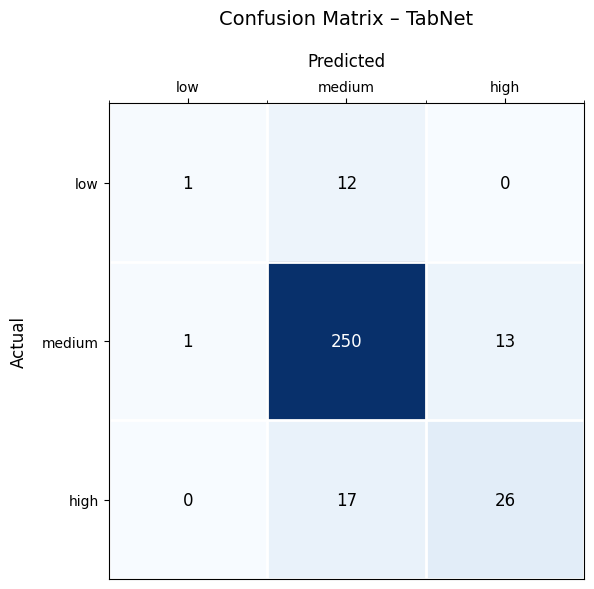

In [5]:
# confusion matrix plot for the final TABNET model 
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

class_names = ["low", "medium", "high"]
labels = [0, 1, 2]

cm = confusion_matrix(y_test, y_pred, labels=labels)


# confusion matrix 
fig, ax = plt.subplots(figsize=(7, 6))

im = ax.imshow(cm, cmap="Blues")
ax.set_xlabel("Predicted", fontsize=12, labelpad=10)
ax.set_ylabel("Actual", fontsize=12, labelpad=10)
ax.xaxis.set_label_position("top")
ax.xaxis.tick_top()

ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

threshold = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center",
            va="center",
            fontsize=12,
            color="white" if cm[i, j] > threshold else "black"
        )


ax.set_xticks(np.arange(-.5, len(class_names), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(class_names), 1), minor=True)
ax.grid(which="minor", color="white", linestyle="-", linewidth=2)
ax.tick_params(which="minor", bottom=False, left=False)

ax.set_title("Confusion Matrix – TabNet", fontsize=14, pad=20)

plt.tight_layout()
plt.show()


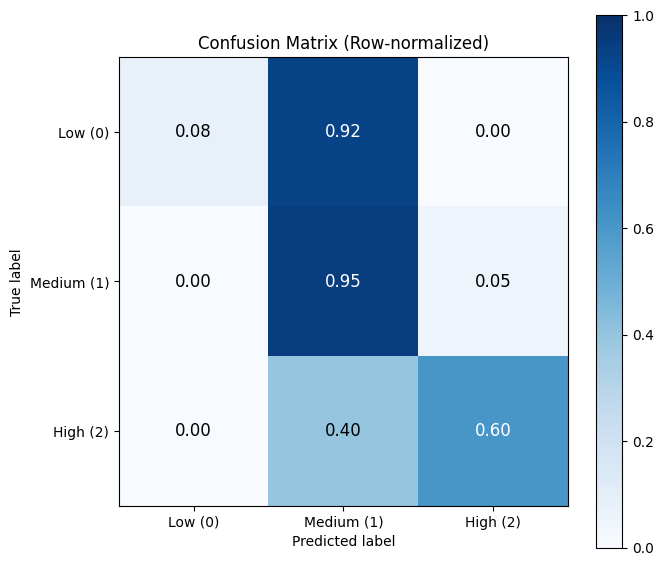

In [6]:
# confusion matrix row-normalized plot for the final TABNET model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

class_names = ["Low (0)", "Medium (1)", "High (2)"]
labels = [0, 1, 2]


cm = confusion_matrix(y_test, y_pred, labels=labels)

#row-normalize by true class
row_sums = cm.sum(axis=1, keepdims=True)
cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm, dtype=float), where=row_sums != 0)

fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(cm_norm, cmap="Blues", vmin=0.0, vmax=1.0)
cbar = plt.colorbar(im, ax=ax)
ax.set_title("Confusion Matrix (Row-normalized)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        val = cm_norm[i, j]
        ax.text(
            j, i, f"{val:.2f}",
            ha="center", va="center",
            color="white" if val > 0.5 else "black",
            fontsize=12
        )

plt.tight_layout()
plt.show()


In [ ]:


import numpy as np
import pandas as pd
import torch
import random

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
)

from pytorch_tabnet.tab_model import TabNetClassifier
import shap


BEST_CFG = {
    "n_d": 8,
    "n_a": 24,
    "n_steps": 4,
    "n_independent": 3,
    "n_shared": 2,
    "lr": 0.003,
    "seed": 42,
}

RANDOM_STATE = BEST_CFG["seed"]
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


df = pd.read_csv(r"D:\Wine quality project\winequality-red.csv")

def map_quality_to_3cls(q):
    if q <= 4:
        return "low"
    elif q <= 6:
        return "medium"
    else:
        return "high"

df["quality_3cls"] = df["quality"].apply(map_quality_to_3cls)
class_mapping = {"low": 0, "medium": 1, "high": 2}
y = df["quality_3cls"].map(class_mapping).values


df["sulphur_ratio"]      = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
df["nonfree_sulfur"]     = df["total sulfur dioxide"] - df["free sulfur dioxide"]
df["acid_ratio"]         = df["volatile acidity"] / (df["fixed acidity"] + 1e-6)
df["alc_sulphates"]      = df["alcohol"] * df["sulphates"]
df["density_alcohol"]    = df["density"] * df["alcohol"]
df["citric_fixed_ratio"] = df["citric acid"] / (df["fixed acidity"] + 1e-6)

drop_cols = ["quality", "quality_3cls"]
feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)


X_train_df = pd.DataFrame(X_train, columns=feature_cols)
X_test_df  = pd.DataFrame(X_test,  columns=feature_cols)

for col in feature_cols:
    lo = X_train_df[col].quantile(0.01)
    hi = X_train_df[col].quantile(0.99)
    X_train_df[col] = X_train_df[col].clip(lo, hi)
    X_test_df[col]  = X_test_df[col].clip(lo, hi)

X_train = X_train_df.values
X_test  = X_test_df.values

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train).astype(np.float32)
X_test_sc  = scaler.transform(X_test).astype(np.float32)

clf = TabNetClassifier(
    n_d=BEST_CFG["n_d"],
    n_a=BEST_CFG["n_a"],
    n_steps=BEST_CFG["n_steps"],
    gamma=1.0,
    n_independent=BEST_CFG["n_independent"],
    n_shared=BEST_CFG["n_shared"],
    lambda_sparse=1e-4,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=BEST_CFG["lr"]),
    mask_type="sparsemax",
    seed=BEST_CFG["seed"],
)

clf.fit(
    X_train_sc, y_train,
    eval_set=[(X_train_sc, y_train), (X_test_sc, y_test)],
    eval_name=["train", "valid"],
    eval_metric=["accuracy"],
    max_epochs=300,
    patience=30,
    batch_size=256,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
)


class_names = ["low", "medium", "high"]
labels = [0, 1, 2]

y_pred = clf.predict(X_test_sc)
proba_test = clf.predict_proba(X_test_sc)

acc      = accuracy_score(y_test, y_pred)
bal_acc  = balanced_accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("\n=== FINAL TABNET RESULTS ===")
print("BEST_CFG:", BEST_CFG)
print(f"Accuracy:          {acc:.4f}")
print(f"Balanced accuracy: {bal_acc:.4f}")
print(f"Macro F1:          {macro_f1:.4f}")

print("\nClassification Report:")
print(
    classification_report(
        y_test, y_pred,
        labels=labels,
        target_names=class_names,
        zero_division=0,
    )
)

cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(
    cm,
    index=[f"true_{t}" for t in class_names],
    columns=[f"pred_{t}" for t in class_names],
)
print("\nConfusion Matrix:")
print(cm_df)


def tabnet_predict_proba(X_np):
    X_np = np.asarray(X_np, dtype=np.float32)
    return clf.predict_proba(X_np)

def normalize_multiclass_shap(shap_values_raw, n_classes):
    if isinstance(shap_values_raw, list):
        return [np.asarray(sv) for sv in shap_values_raw]

    sv = np.asarray(shap_values_raw)
    if sv.ndim != 3:
        raise ValueError(f"Unexpected SHAP shape: {sv.shape}")

    if sv.shape[2] == n_classes:           # (n_samples,n_features,n_classes)
        return [sv[:, :, c] for c in range(n_classes)]
    if sv.shape[0] == n_classes:           # (n_classes,n_samples,n_features)
        return [sv[c, :, :] for c in range(n_classes)]

    raise ValueError(f"Cannot infer class axis from SHAP shape {sv.shape}")

def align_shap_and_features(sv, X_df):
    sv = np.asarray(sv)
    X = X_df.copy()

    m_rows = min(sv.shape[0], X.shape[0])
    sv = sv[:m_rows, :]
    X = X.iloc[:m_rows, :]

    if sv.shape[1] == X.shape[1] + 1:
        sv = sv[:, :-1]

    m_cols = min(sv.shape[1], X.shape[1])
    sv = sv[:, :m_cols]
    X = X.iloc[:, :m_cols]

    return sv, X

# Runtime controls
background_size  = 80
explain_size     = 120

rng = np.random.default_rng(RANDOM_STATE)
bg_idx = rng.choice(len(X_train_sc), size=min(background_size, len(X_train_sc)), replace=False)
ex_idx = rng.choice(len(X_test_sc),  size=min(explain_size, len(X_test_sc)),  replace=False)

X_bg = X_train_sc[bg_idx]
X_explain = X_test_sc[ex_idx]
X_explain_df = pd.DataFrame(X_explain, columns=feature_cols)

explainer = shap.KernelExplainer(tabnet_predict_proba, X_bg)
shap_values_raw = explainer.shap_values(X_explain, nsamples="auto")
shap_values_list = normalize_multiclass_shap(shap_values_raw, n_classes=3)

shap_importances = []
for cls_idx, cls_name in enumerate(class_names):
    sv_aligned, X_aligned = align_shap_and_features(shap_values_list[cls_idx], X_explain_df)
    mean_abs = np.mean(np.abs(sv_aligned), axis=0)

    tmp = pd.DataFrame({
        "feature": list(X_aligned.columns),
        "mean_abs_shap": mean_abs,
        "class": cls_name
    }).sort_values("mean_abs_shap", ascending=False)

    shap_importances.append(tmp)

shap_importances_df = pd.concat(shap_importances, ignore_index=True)

overall = (
    shap_importances_df
    .groupby("feature", as_index=False)["mean_abs_shap"]
    .mean()
    .rename(columns={"mean_abs_shap": "mean_abs_shap_overall"})
    .sort_values("mean_abs_shap_overall", ascending=False)
)

# Save SHAP CSVs
shap_importances_df.to_csv("shap_mean_abs_by_class.csv", index=False)
overall.to_csv("shap_mean_abs_overall.csv", index=False)

# ---- PRINT SHAP SUMMARY ----
TOPK = 8
print("\n================ SHAP NUMERIC SUMMARY ================")
print("What this is: mean(|SHAP|) = average magnitude of feature contribution to class probability.")
print(f"Computed on {len(X_explain_df)} explained samples, background size = {len(X_bg)}.")

for cls_name in class_names:
    top = shap_importances_df[shap_importances_df["class"] == cls_name].head(TOPK)
    print(f"\nTop {TOPK} SHAP features for class '{cls_name}':")
    for _, r in top.iterrows():
        print(f"  - {r['feature']:<22} mean(|SHAP|) = {r['mean_abs_shap']:.6f}")

print(f"\nTop {TOPK} SHAP features overall (avg across classes):")
top_overall = overall.head(TOPK)
for _, r in top_overall.iterrows():
    print(f"  - {r['feature']:<22} mean(|SHAP|) = {r['mean_abs_shap_overall']:.6f}")

print("\nSaved SHAP numeric outputs:")
print("  - shap_mean_abs_by_class.csv")
print("  - shap_mean_abs_overall.csv")


def compute_pdp_ice_numeric(
    model_predict_proba,
    X_scaled,
    feat_idx,
    class_idx,
    grid_points=20,
    ice_samples=50,
):
    X_scaled = np.asarray(X_scaled, dtype=np.float32)
    n = X_scaled.shape[0]
    vals = X_scaled[:, feat_idx]
    vmin, vmax = np.percentile(vals, [1, 99])
    grid = np.linspace(vmin, vmax, grid_points).astype(np.float32)

    rng_local = np.random.default_rng(RANDOM_STATE + feat_idx * 17 + class_idx * 31)
    N_ice = min(ice_samples, n)
    ice_idx = rng_local.choice(n, size=N_ice, replace=False)

    ice_curves = np.zeros((N_ice, grid_points), dtype=float)
    pdp_mean = np.zeros(grid_points, dtype=float)

    for j, g in enumerate(grid):
        X_temp = X_scaled.copy()
        X_temp[:, feat_idx] = g
        p_all = model_predict_proba(X_temp)[:, class_idx]
        pdp_mean[j] = p_all.mean()

        X_ice = X_scaled[ice_idx].copy()
        X_ice[:, feat_idx] = g
        ice_curves[:, j] = model_predict_proba(X_ice)[:, class_idx]

    ice_std = ice_curves.std(axis=0)
    ice_q10 = np.quantile(ice_curves, 0.10, axis=0)
    ice_q50 = np.quantile(ice_curves, 0.50, axis=0)
    ice_q90 = np.quantile(ice_curves, 0.90, axis=0)

    return grid, pdp_mean, ice_curves, ice_std, ice_q10, ice_q50, ice_q90

GRID_POINTS = 20
ICE_SAMPLES = 50

pdp_rows = []
ice_summary_rows = []

# Also collect compact summaries for printing
effect_rows = []         # PDP effect strength (range)
hetero_rows = []         # ICE heterogeneity (mean std)

for feat_idx, feat_name in enumerate(feature_cols):
    for cls_idx, cls_name in enumerate(class_names):
        grid, pdp_mean, ice_curves, ice_std, q10, q50, q90 = compute_pdp_ice_numeric(
            model_predict_proba=tabnet_predict_proba,
            X_scaled=X_test_sc,
            feat_idx=feat_idx,
            class_idx=cls_idx,
            grid_points=GRID_POINTS,
            ice_samples=ICE_SAMPLES,
        )

        # Save detailed PDP rows
        for j in range(len(grid)):
            pdp_rows.append({
                "feature": feat_name,
                "class": cls_name,
                "grid_value_scaled": float(grid[j]),
                "pdp_mean_proba": float(pdp_mean[j]),
            })

        # Save ICE summary rows
        for j in range(len(grid)):
            ice_summary_rows.append({
                "feature": feat_name,
                "class": cls_name,
                "grid_value_scaled": float(grid[j]),
                "ice_std": float(ice_std[j]),
                "ice_q10": float(q10[j]),
                "ice_q50": float(q50[j]),
                "ice_q90": float(q90[j]),
            })

        # Compact numeric descriptors for console output:
        pdp_range = float(np.max(pdp_mean) - np.min(pdp_mean))
        mean_ice_std = float(np.mean(ice_std))

        effect_rows.append({
            "feature": feat_name,
            "class": cls_name,
            "pdp_range": pdp_range,
            "pdp_min": float(np.min(pdp_mean)),
            "pdp_max": float(np.max(pdp_mean)),
        })

        hetero_rows.append({
            "feature": feat_name,
            "class": cls_name,
            "mean_ice_std": mean_ice_std,
        })

pdp_df = pd.DataFrame(pdp_rows)
ice_summary_df = pd.DataFrame(ice_summary_rows)

pdp_df.to_csv("pdp_numeric_all.csv", index=False)
ice_summary_df.to_csv("ice_numeric_summary_all.csv", index=False)

effect_df = pd.DataFrame(effect_rows).sort_values("pdp_range", ascending=False)
hetero_df = pd.DataFrame(hetero_rows).sort_values("mean_ice_std", ascending=False)

effect_df.to_csv("pdp_effect_strength_summary.csv", index=False)
hetero_df.to_csv("ice_heterogeneity_summary.csv", index=False)

# ---- PRINT PDP/ICE SUMMARY ----
TOPK_PDP = 6
TOPK_ICE = 6

print("\n================ PDP / ICE NUMERIC SUMMARY ================")
print("What PDP is: mean predicted probability vs a feature grid (global effect).")
print("What ICE is: per-sample predicted probability vs feature grid; variability shows heterogeneity.")
print(f"Grid points = {GRID_POINTS}, ICE samples per feature/class = {ICE_SAMPLES}.")

for cls_name in class_names:
    sub_eff = effect_df[effect_df["class"] == cls_name].head(TOPK_PDP)
    print(f"\nTop {TOPK_PDP} PDP effect strengths for class '{cls_name}' (largest PDP range):")
    for _, r in sub_eff.iterrows():
        print(f"  - {r['feature']:<22} PDP range = {r['pdp_range']:.4f} (min={r['pdp_min']:.4f}, max={r['pdp_max']:.4f})")

for cls_name in class_names:
    sub_het = hetero_df[hetero_df["class"] == cls_name].head(TOPK_ICE)
    print(f"\nTop {TOPK_ICE} ICE heterogeneity features for class '{cls_name}' (largest mean ICE std):")
    for _, r in sub_het.iterrows():
        print(f"  - {r['feature']:<22} mean ICE std = {r['mean_ice_std']:.4f}")

print("\nSaved PDP/ICE numeric outputs:")
print("  - pdp_numeric_all.csv")
print("  - ice_numeric_summary_all.csv")
print("  - pdp_effect_strength_summary.csv")
print("  - ice_heterogeneity_summary.csv")

print("\nDone.")


c:\Python310\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.24736 | train_accuracy: 0.59891 | valid_accuracy: 0.60938 |  0:00:00s
epoch 1  | loss: 0.98075 | train_accuracy: 0.66771 | valid_accuracy: 0.67812 |  0:00:00s
epoch 2  | loss: 0.84403 | train_accuracy: 0.72791 | valid_accuracy: 0.74062 |  0:00:01s
epoch 3  | loss: 0.74557 | train_accuracy: 0.7631  | valid_accuracy: 0.78438 |  0:00:02s
epoch 4  | loss: 0.67466 | train_accuracy: 0.79359 | valid_accuracy: 0.82188 |  0:00:02s
epoch 5  | loss: 0.62799 | train_accuracy: 0.81157 | valid_accuracy: 0.825   |  0:00:02s
epoch 6  | loss: 0.59293 | train_accuracy: 0.80766 | valid_accuracy: 0.82188 |  0:00:03s
epoch 7  | loss: 0.55778 | train_accuracy: 0.81001 | valid_accuracy: 0.82188 |  0:00:03s
epoch 8  | loss: 0.54572 | train_accuracy: 0.80766 | valid_accuracy: 0.81875 |  0:00:04s
epoch 9  | loss: 0.52666 | train_accuracy: 0.81001 | valid_accuracy: 0.82188 |  0:00:04s
epoch 10 | loss: 0.50871 | train_accuracy: 0.82252 | valid_accuracy: 0.82812 |  0:00:04s
epoch 11 | loss: 0.49

c:\Python310\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== FINAL TABNET RESULTS ===
BEST_CFG: {'n_d': 8, 'n_a': 24, 'n_steps': 4, 'n_independent': 3, 'n_shared': 2, 'lr': 0.003, 'seed': 42}
Accuracy:          0.8656
Balanced accuracy: 0.5428
Macro F1:          0.5628

Classification Report:
              precision    recall  f1-score   support

         low       0.50      0.08      0.13        13
      medium       0.90      0.95      0.92       264
        high       0.67      0.60      0.63        43

    accuracy                           0.87       320
   macro avg       0.69      0.54      0.56       320
weighted avg       0.85      0.87      0.85       320


Confusion Matrix:
             pred_low  pred_medium  pred_high
true_low            1           12          0
true_medium         1          250         13
true_high           0           17         26


  0%|          | 0/120 [00:00<?, ?it/s]


================ SHAP NUMERIC SUMMARY ================
What this is: mean(|SHAP|) = average magnitude of feature contribution to class probability.
Computed on 120 explained samples, background size = 80.

Top 8 SHAP features for class 'low':
  - fixed acidity          mean(|SHAP|) = 0.009096
  - citric acid            mean(|SHAP|) = 0.007585
  - acid_ratio             mean(|SHAP|) = 0.007009
  - sulphates              mean(|SHAP|) = 0.006400
  - nonfree_sulfur         mean(|SHAP|) = 0.006362
  - free sulfur dioxide    mean(|SHAP|) = 0.005701
  - total sulfur dioxide   mean(|SHAP|) = 0.004899
  - alcohol                mean(|SHAP|) = 0.004568

Top 8 SHAP features for class 'medium':
  - sulphates              mean(|SHAP|) = 0.045070
  - alcohol                mean(|SHAP|) = 0.041975
  - sulphur_ratio          mean(|SHAP|) = 0.023547
  - density_alcohol        mean(|SHAP|) = 0.022840
  - fixed acidity          mean(|SHAP|) = 0.021969
  - residual sugar         mean(|SHAP|) = 0.021595
 